In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import sys
import os
import glob
import random
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.stats import mode
from scipy import stats

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# Read dataset
df = pd.read_csv(r'D:\Google Drive\University of York courses\Independent Research Proposal\dissertation\data\preprocessed\data_time_series_forecasting_final.csv')
df.set_index('unique_id', inplace=True)
df["unique_id_time"] = pd.to_datetime(df["unique_id_time"])
print("Rows: ", df.shape[0])
print("Features: " + str(df.shape[1]) + "\n")
df.head(3)

Rows:  63525
Features: 20



key_neighb unique_id_time  crime_count_t  crime_count_t+1  women_vic_t  women_vic_t+1  men_vic_t  men_vic_t+1  less_18_vic_t  less_18_vic_t+1  18_to_29_vic_t  18_to_29_vic_t+1  30_to_39_vic_t  30_to_39_vic_t+1  40_to_49_vic_t  40_to_49_vic_t+1  50_to_59_vic_t  50_to_59_vic_t+1  more_60_vic_t  more_60_vic_t+1
unique_id                                                                                                                                                                                                                                                                                                                        
2019202-001     02-001     2019-02-01            0.0                1          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019302-001     02-001     2019-03-01            1.0                0          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019402-001     02-001     2019-04-01            0.0                1          0.0              0        0.0            1            0.0                0             0.0                 1             0.0                 0             0.0                 0             0.0                 0            0.0                0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63525 entries, 2019202-001 to 20211210-240
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key_neighb        63525 non-null  object        
 1   unique_id_time    63525 non-null  datetime64[ns]
 2   crime_count_t     63525 non-null  float64       
 3   crime_count_t+1   63525 non-null  int64         
 4   women_vic_t       63525 non-null  float64       
 5   women_vic_t+1     63525 non-null  int64         
 6   men_vic_t         63525 non-null  float64       
 7   men_vic_t+1       63525 non-null  int64         
 8   less_18_vic_t     63525 non-null  float64       
 9   less_18_vic_t+1   63525 non-null  int64         
 10  18_to_29_vic_t    63525 non-null  float64       
 11  18_to_29_vic_t+1  63525 non-null  int64         
 12  30_to_39_vic_t    63525 non-null  float64       
 13  30_to_39_vic_t+1  63525 non-null  int64         
 14  40_to_49_v

In [4]:
df.columns

Index(['key_neighb', 'unique_id_time', 'crime_count_t', 'crime_count_t+1', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1'], dtype='object')

# Training and testing sets

In [5]:
dfs_neighborhood_list = []
for neighborhood in df.key_neighb.unique():
    dfn = df[df.key_neighb == neighborhood]
    dfn = dfn.sort_values(by=('unique_id_time'))
    dfs_neighborhood_list.append(dfn)

In [6]:
print(dfs_neighborhood_list[-5].shape)
dfs_neighborhood_list[-5].head()

(35, 20)


key_neighb unique_id_time  crime_count_t  crime_count_t+1  women_vic_t  women_vic_t+1  men_vic_t  men_vic_t+1  less_18_vic_t  less_18_vic_t+1  18_to_29_vic_t  18_to_29_vic_t+1  30_to_39_vic_t  30_to_39_vic_t+1  40_to_49_vic_t  40_to_49_vic_t+1  50_to_59_vic_t  50_to_59_vic_t+1  more_60_vic_t  more_60_vic_t+1
unique_id                                                                                                                                                                                                                                                                                                                        
2019210-236     10-236     2019-02-01            1.0                1          0.0              0        0.0            1            0.0                1             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019310-236     10-236     2019-03-01            1.0                0          0.0              0        1.0            0            1.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019410-236     10-236     2019-04-01            0.0                0          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019510-236     10-236     2019-05-01            0.0                0          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019610-236     10-236     2019-06-01            0.0                0          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0

In [7]:
np.mean((dfs_neighborhood_list[0]['crime_count_t+1'] - dfs_neighborhood_list[0]['crime_count_t']))

0.0

In [8]:
def splitTrainingSets(df):
    X_cols = ['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1']
    y_cols = ['crime_count_t+1']
    
    # Features
    X = df[['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1']].values

    # Target
    y = df[['crime_count_t+1']].values
    
    train_size = int(len(X) * 0.8)
    print('Train size: ', train_size)

    # Split the dataset into train and test sets
    X_train_values, X_test_values = X[0: train_size], X[train_size: len(X)]
    X_train = pd.DataFrame(X_train_values)
    X_train.columns = X_cols
    X_test = pd.DataFrame(X_test_values)
    X_test.columns = X_cols
    
    y_train_values, y_test_values = y[0:train_size], y[train_size: len(y)]
    y_train = pd.DataFrame(y_train_values)
    y_train.columns = y_cols
    y_test = pd.DataFrame(y_test_values)
    y_test.columns = y_cols
    
    return X_train, y_train, X_test, y_test

In [9]:
def doWalkForwardValidation(df, n_min_train=20):
    X = df[['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', 
            '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1']].values
    y = df[['crime_count_t+1']].values
    n_records = len(X)
    print(n_records)
    for i in range(n_train, n_records):
        X_train_values, X_test_values = X[0:i], X[i:i+1]
        X_train = pd.DataFrame(X_train_values)
        X_train.columns = features_cols
        X_test = pd.DataFrame(X_test_values)
        X_test.columns = features_cols
        
        y_train_values, y_test_values = y[i:i], y[i:i+1]
        y_train = pd.DataFrame(y_train_values)
        y_train.columns = target_col
        y_test = pd.DataFrame(y_test_values)
        y_test.columns = features_cols
    

# Yeo-Johnson power transform

In [10]:
def transformYeoJohnson(train_values, test_values, list_cols):
    pt_yj = PowerTransformer(method='yeo-johnson') # Perform a yeo-johnson transform of the dataset
    pt_yj.fit(train_values)
    train_trans_vals = pt_yj.transform(train_values)
    test_trans_vals = pt_yj.transform(test_values)
    df_train_trans = pd.DataFrame(train_trans_vals)
    df_train_trans.columns = list_cols
    df_test_trans = pd.DataFrame(test_trans_vals)
    df_test_trans.columns = list_cols
    return df_train_trans, df_test_trans


# Min-max normalization

In [11]:
def minmaxNormalization(train_values, test_values, name_cols):
    scaler = MinMaxScaler() # Define min max scaler
    scaler.fit(train_values)
    n_train_values = scaler.transform(train_values)
    n_test_values = scaler.transform(test_values)
    n_train_df = pd.DataFrame(n_train_values)
    n_test_df = pd.DataFrame(n_test_values)
    n_train_df.columns = name_cols
    n_test_df.columns = name_cols
    return n_train_df, n_test_df

# Putting it all together (pre-training)

In [12]:
def setTrainingTestingData(data):
    
    X_cols = ['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1']
    y_cols = ['crime_count_t+1']
    
    df = data.copy()
    X_train, y_train, X_test, y_test = splitTrainingSets(df)

    X_train_trans, X_test_trans = transformYeoJohnson(X_train, X_test, X_cols)
    y_train_trans, y_test_trans = transformYeoJohnson(y_train, y_test, y_cols)

    X_train_tn, X_test_tn = minmaxNormalization(X_train_trans, X_test_trans, X_cols)
    y_train_tn, y_test_tn = minmaxNormalization(y_train_trans, y_test_trans, y_cols)
 
    return X_train_tn, y_train_tn, X_test_tn, y_test_tn
        

# Forecasting crime counts

In [13]:
def splitSequences(df, n_steps):
    # Features
    X_values = df[['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1']]
    # Target
    y_values = df[['crime_count_t+1']]
    # Join sequences
    sequences_df = pd.concat([X_values, y_values], axis=1)
    print(sequences_df.shape)
    sequences = sequences_df.values
    # Split the dataset into samples of train and test sets
    X, y = list(), list()
    for i in range(len(sequences)):
        end_i = i + n_steps # find the end of the pattern
        if end_i  > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_i, :-1], sequences[end_i-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    print(len(X))
    print(len(y))
    return np.array(X), np.array(y)
    
    
def splitTrainingTestingLSTM(X, y):
    train_size = int(len(X) * 0.8)
    print('Train size: ', train_size)
    # Split the dataset into train and test sets
    X_train, X_test = X[0: train_size], X[train_size: len(X)]
    y_train, y_test = y[0:train_size], y[train_size: len(y)]
    return X_train, y_train, X_test, y_test

In [18]:
def trainEvaluateModels(list_data):
    baseline_bias_list = []
    baseline_mae_list = []
    baseline_rmse_list = []
    
    lr_bias_list = []
    lr_mae_list = []
    lr_rmse_list = []
    
    dt_bias_list = []
    dt_mae_list = []
    dt_rmse_list = []
    
    rf_bias_list = []
    rf_mae_list = []
    rf_rmse_list = []
    importances_list = []
    
    mlp_bias_list = []
    mlp_mae_list = []
    mlp_rmse_list = []
    
    lstm_bias_list = []
    lstm_mae_list = []
    lstm_rmse_list = []
    
    print('Starting training...................................................', '\n')
    for df in list_data:
        print('For neighborhood with key ' + str(df.key_neighb.unique()[0]) + ' ...................................................' + '\n')
        print('Shape of data: ', df.shape)
        X_train, y_train, X_test, y_test = setTrainingTestingData(df)
        print('Shape of X_train: ', X_train.shape)
        print('Shape of y_train: ', y_train.shape)
        print('Shape of X_test: ', X_test.shape)
        print('Shape of y_test: ', y_test.shape)
        
        # Baseline forecasts
        baseline_forecasts = X_test["crime_count_t"]
        print(baseline_forecasts.shape)
        print(y_test.shape)
        bias1 = np.mean(y_test['crime_count_t+1'] - baseline_forecasts)
        mae1 = mean_absolute_error(y_test, baseline_forecasts)
        rmse1 = np.sqrt(mean_squared_error(y_test, baseline_forecasts))
        
        baseline_bias_list.append(bias1)
        baseline_mae_list.append(mae1)
        baseline_rmse_list.append(rmse1)
        
        print('Baseline bias: ', bias1)
        print('Baseline Mean Absolute Error:', mae1)  
        print('Baseline Root Mean Squared Error:', rmse1)
        
        # Multi-variate linear regression
        lr_model = linear_model.LinearRegression()
        lr_model.fit(X_train, y_train)
        y_pred_lm = lr_model.predict(X_test)
        
        bias2 = np.mean(y_test['crime_count_t+1'].values - y_pred_lm)
        mae2 = mean_absolute_error(y_test, y_pred_lm)
        rmse2 = np.sqrt(mean_squared_error(y_test, y_pred_lm))
        
        lr_bias_list.append(bias2)
        lr_mae_list.append(mae2)
        lr_rmse_list.append(rmse2)
        
        print('Multi-variate linear regression bias: ', bias2)
        print('Multi-variate linear regression Mean Absolute Error:', mae2)  
        print('Multi-variate linear regression Root Mean Squared Error:', rmse2)
        
        #Decision tree regressor
        decision_tree_model = DecisionTreeRegressor(random_state = 42) 
        decision_tree_model.fit(X_train, y_train)
        y_pred_dt = decision_tree_model.predict(X_test)
        
        bias3 = np.mean(y_test['crime_count_t+1'].values - y_pred_dt)
        mae3 = mean_absolute_error(y_test, y_pred_dt)
        rmse3 = np.sqrt(mean_squared_error(y_test, y_pred_dt))
        
        dt_bias_list.append(bias3)
        dt_mae_list.append(mae3)
        dt_rmse_list.append(rmse3)
        
        print('Decision tree regressor bias: ', bias3)
        print('Decision tree regressor Mean Absolute Error:', mae3)  
        print('Decision tree regressor Root Mean Squared Error:', rmse3)
        
        #Random forest regressor
        rf_model = RandomForestRegressor(random_state = 42)
        rf_model.fit(X_train, y_train)
        y_pred_rf = rf_model.predict(X_test)
        
        bias4 = np.mean(y_test['crime_count_t+1'].values - y_pred_rf)
        mae4 = mean_absolute_error(y_test, y_pred_rf)
        rmse4 = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        
        rf_bias_list.append(bias4)
        rf_mae_list.append(mae4)
        rf_rmse_list.append(rmse4)
        
        print('Random forest regressor bias: ', bias4)
        print('Random forest regressor Mean Absolute Error:', mae4)  
        print('Random forest regressor Root Mean Squared Error:', rmse4)
        
        importances = list(rf_model.feature_importances_) # Get numerical feature importances
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1'], importances)] # List of tuples with variable and importance
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) # Sort the feature importances by most important first
        importances_list.append(feature_importances)
        
        #Multi-layer perceptron
        mlp_model = MLPRegressor(hidden_layer_sizes=(20,20), activation="relu", random_state=42, max_iter=1000)
        mlp_model.fit(X_train, y_train)
        y_pred_mlp = mlp_model.predict(X_test)
        
        bias5 = np.mean(y_test['crime_count_t+1'].values - y_pred_mlp)
        mae5 = mean_absolute_error(y_test, y_pred_mlp)
        rmse5 = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
        
        mlp_bias_list.append(bias5)
        mlp_mae_list.append(mae5)
        mlp_rmse_list.append(rmse5)
        
        print('MLP bias: ', bias5)
        print('MLP Mean Absolute Error:', mae5)  
        print('MLP Root Mean Squared Error:', rmse5)
    
        #LSTM training and testing
        print()
        print("***********************LSTM training************************************", "\n")
        X, y = splitSequences(df, 2) # step 2
        X_train_l, y_train_l, X_test_l, y_test_l = splitTrainingTestingLSTM(X, y)
        # Vanilla LSTM
        n_nodes = 50 # Number of LSTM units to use in the hidden layer
        n_steps = X.shape[1]
        n_features = X.shape[2]
        n_epochs = 50 # Number of times to expose the model to the whole training dataset
        n_batch = 100 # Number of samples within an epoch after which the weights are updated

        model = Sequential()
        model.add(LSTM(n_nodes, activation = 'relu', input_shape=(n_steps, n_features)))
        model.add(Dense(n_nodes, activation = 'relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_l, y_train_l, epochs=n_epochs, batch_size=n_batch, verbose=0)
        y_pred_lstm = model.predict(X_test_l, verbose=0)
        
        bias6 = np.mean(y_test_l- y_pred_lstm)
        mae6 = mean_absolute_error(y_test_l, y_pred_lstm)
        rmse6 = np.sqrt(mean_squared_error(y_test_l, y_pred_lstm))
        
        print('LSTM bias: ', bias6)
        print('LSTM Mean Absolute Error:', mae6)  
        print('LSTM Root Mean Squared Error:', rmse6)
        
        lstm_bias_list.append(bias6)
        lstm_mae_list.append(mae6)
        lstm_rmse_list.append(rmse6)

    return baseline_bias_list, baseline_mae_list, baseline_rmse_list, lr_bias_list, lr_mae_list, lr_rmse_list, dt_bias_list, dt_mae_list, dt_rmse_list, rf_bias_list, rf_mae_list, rf_rmse_list, mlp_bias_list, mlp_mae_list, mlp_rmse_list, lstm_bias_list, lstm_mae_list, lstm_rmse_list   
 

In [19]:
baseline_bias_list, baseline_mae_list, baseline_rmse_list, lr_bias_list, lr_mae_list, lr_rmse_list, dt_bias_list, dt_mae_list, dt_rmse_list, rf_bias_list, rf_mae_list, rf_rmse_list, mlp_bias_list, mlp_mae_list, mlp_rmse_list, lstm_bias_list, lstm_mae_list, lstm_rmse_list = trainEvaluateModels(dfs_neighborhood_list)

Starting training................................................... 

For neighborhood with key 02-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.8670586505414074e-09
Baseline Mean Absolute Error: 0.16896334547297892
Baseline Root Mean Squared Error: 0.3161014725128733
Multi-variate linear regression bias:  -0.10263875659278501
Multi-variate linear regression Mean Absolute Error: 0.19277484608584924
Multi-variate linear regression Root Mean Squared Error: 0.1966823517912959
Decision tree regressor bias:  -0.0422408359014801
Decision tree regressor Mean Absolute Error: 0.0422408359014801
Decision tree regressor Root Mean Squared Error: 0.06452394264558022


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05171473004649506
Random forest regressor Mean Absolute Error: 0.13817458956712717
Random forest regressor Root Mean Squared Error: 0.17926437098246184
MLP bias:  -2.0727600505413943
MLP Mean Absolute Error: 2.1923364808392964
MLP Root Mean Squared Error: 4.013897811603421

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0670499290738787
LSTM Mean Absolute Error: 0.42368050132478985
LSTM Root Mean Squared Error: 0.4668297411972832
For neighborhood with key 02-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.039743885280276385
Baseline Mean Absolute Error: 0.31079328986612564
Baseline Root Mean Squared Error: 0.4172023262568587
Multi-variate linear regression bias:  -0.2897005888615962
Multi-variate linear regression Mean Absolute Error: 0.49854362285470977
Multi-variate linear regression Root Mean Squared Error: 0.5658121474080355
Decision tree regressor bias:  -0.10286554042607829
Decision tree regressor Mean Absolute Error: 0.37391494501192757
Decision tree regressor Root Mean Squared Error: 0.4501531410210807


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10903115151780055
Random forest regressor Mean Absolute Error: 0.3208250887006646
Random forest regressor Root Mean Squared Error: 0.36632598101616526
MLP bias:  -0.03367267626212774
MLP Mean Absolute Error: 0.3780941224633967
MLP Root Mean Squared Error: 0.4209269951348332

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.25658170666013447
LSTM Mean Absolute Error: 0.5828959005219596
LSTM Root Mean Squared Error: 0.6202277018201107
For neighborhood with key 02-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.022698061481607777
Baseline Mean Absolute Error: 0.36422903072656265
Baseline Root Mean Squared Error: 0.4081556839736667
Multi-variate linear regression bias:  -0.17363206766704375
Multi-variate linear regression Mean Absolute Error: 0.22354393481970905
Multi-variate linear regression Root Mean Squared Error: 0.27155678490422347
Decision tree regressor bias:  -0.34725108454922743
Decision tree regressor Mean Absolute Error: 0.45747263044891195
Decision tree regressor Root Mean Squared Error: 0.5230030813494367


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18704189345894787
Random forest regressor Mean Absolute Error: 0.22592572025382832
Random forest regressor Root Mean Squared Error: 0.29150730250622275
MLP bias:  -0.2051750744689327
MLP Mean Absolute Error: 0.26481878417640664
MLP Root Mean Squared Error: 0.3244602774291984

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08770350047520228
LSTM Mean Absolute Error: 0.9379315376281738
LSTM Root Mean Squared Error: 1.162020938433905
For neighborhood with key 02-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03794203732735092
Baseline Mean Absolute Error: 0.2576462664859707
Baseline Root Mean Squared Error: 0.290192364761836
Multi-variate linear regression bias:  -0.1489350038651209
Multi-variate linear regression Mean Absolute Error: 0.22994457648385971
Multi-variate linear regression Root Mean Squared Error: 0.2720863001313904
Decision tree regressor bias:  -0.14813822378790703
Decision tree regressor Mean Absolute Error: 0.14813822378790703
Decision tree regressor Root Mean Squared Error: 0.19682066747721363


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19508277079452183
Random forest regressor Mean Absolute Error: 0.1971232459055992
Random forest regressor Root Mean Squared Error: 0.2190494889043542
MLP bias:  -0.20885944744826063
MLP Mean Absolute Error: 0.22257988184682162
MLP Root Mean Squared Error: 0.26916107905550773

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.23529234102794103
LSTM Mean Absolute Error: 0.465596718447549
LSTM Root Mean Squared Error: 0.5982053810024526
For neighborhood with key 02-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03375545622761362
Baseline Mean Absolute Error: 0.26677699095936314
Baseline Root Mean Squared Error: 0.33613785501329146
Multi-variate linear regression bias:  -0.003172424287701014
Multi-variate linear regression Mean Absolute Error: 0.33544812416054814
Multi-variate linear regression Root Mean Squared Error: 0.41422191397438773
Decision tree regressor bias:  0.1362447687641783
Decision tree regressor Mean Absolute Error: 0.3218439442213227
Decision tree regressor Root Mean Squared Error: 0.37914876083669247


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.012391216753310794
Random forest regressor Mean Absolute Error: 0.22072585443733
Random forest regressor Root Mean Squared Error: 0.24516228524540348
MLP bias:  -0.12964194050403052
MLP Mean Absolute Error: 0.2752164013795868
MLP Root Mean Squared Error: 0.36658052063361823

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  2.164804526737758
LSTM Mean Absolute Error: 2.648414271218436
LSTM Root Mean Squared Error: 3.213983178412613
For neighborhood with key 02-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10834856470646136
Baseline Mean Absolute Error: 0.32712115998720676
Baseline Root Mean Squared Error: 0.4134558503871727
Multi-variate linear regression bias:  0.19746977664034052
Multi-variate linear regression Mean Absolute Error: 0.24788250674964427
Multi-variate linear regression Root Mean Squared Error: 0.28413976331543733
Decision tree regressor bias:  0.09943271161713375
Decision tree regressor Mean Absolute Error: 0.27705860795782083
Decision tree regressor Root Mean Squared Error: 0.4092332281756097


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09103533430750381
Random forest regressor Mean Absolute Error: 0.2436592357494228
Random forest regressor Root Mean Squared Error: 0.3322354204637475
MLP bias:  0.05290479700227633
MLP Mean Absolute Error: 0.27503551936394127
MLP Root Mean Squared Error: 0.32139856689999696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  2.3094147614070346
LSTM Mean Absolute Error: 3.0471011911119734
LSTM Root Mean Squared Error: 4.124520181826638
For neighborhood with key 02-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07088353453297348
Baseline Mean Absolute Error: 0.261182445740003
Baseline Root Mean Squared Error: 0.31426733793790285
Multi-variate linear regression bias:  0.02057509951274893
Multi-variate linear regression Mean Absolute Error: 0.3043679858302228
Multi-variate linear regression Root Mean Squared Error: 0.36051735433365084
Decision tree regressor bias:  -0.0801625842889996
Decision tree regressor Mean Absolute Error: 0.4552073369771593
Decision tree regressor Root Mean Squared Error: 0.4622058439372338


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.023424295312836685
Random forest regressor Mean Absolute Error: 0.2977381937603249
Random forest regressor Root Mean Squared Error: 0.3190943104876871
MLP bias:  -0.017926556465880872
MLP Mean Absolute Error: 0.30622001169768714
MLP Root Mean Squared Error: 0.33688620593715396

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.6635036894253322
LSTM Mean Absolute Error: 1.0790425624166216
LSTM Root Mean Squared Error: 1.256198531124338
For neighborhood with key 02-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09912528221664581
Baseline Mean Absolute Error: 0.16856186156077832
Baseline Root Mean Squared Error: 0.2633427908313666
Multi-variate linear regression bias:  -0.12141212738900334
Multi-variate linear regression Mean Absolute Error: 0.3900580370435615
Multi-variate linear regression Root Mean Squared Error: 0.5136088205521625
Decision tree regressor bias:  0.0245617386593234
Decision tree regressor Mean Absolute Error: 0.13403037485482205
Decision tree regressor Root Mean Squared Error: 0.23739117903818713


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12297617603063751
Random forest regressor Mean Absolute Error: 0.180809380240724
Random forest regressor Root Mean Squared Error: 0.22285108928848843
MLP bias:  -0.047929031817004364
MLP Mean Absolute Error: 0.18616702322120823
MLP Root Mean Squared Error: 0.23143313190449633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2768419086933136
LSTM Mean Absolute Error: 0.3778859334332602
LSTM Root Mean Squared Error: 0.4048724645516196
For neighborhood with key 02-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.1562068762722383e-10
Baseline Mean Absolute Error: 0.46974867840489576
Baseline Root Mean Squared Error: 0.6214190908803058
Multi-variate linear regression bias:  -0.17717477868976653
Multi-variate linear regression Mean Absolute Error: 0.4690509750896159
Multi-variate linear regression Root Mean Squared Error: 0.5471066687394416
Decision tree regressor bias:  -0.09781481439857571
Decision tree regressor Mean Absolute Error: 0.3092017196287494
Decision tree regressor Root Mean Squared Error: 0.477989876751629


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01885833379464832
Random forest regressor Mean Absolute Error: 0.2510890953994497
Random forest regressor Root Mean Squared Error: 0.36343773233539245
MLP bias:  -0.09978736718582641
MLP Mean Absolute Error: 0.33062667005407553
MLP Root Mean Squared Error: 0.4330652172334354

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.008032607180731637
LSTM Mean Absolute Error: 0.3760814964771271
LSTM Root Mean Squared Error: 0.43126250425543583
For neighborhood with key 02-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -8.747298123929731e-11
Baseline Mean Absolute Error: 0.855821547364525
Baseline Root Mean Squared Error: 0.9240368853756648
Multi-variate linear regression bias:  0.14263059556094682
Multi-variate linear regression Mean Absolute Error: 0.28548773841808966
Multi-variate linear regression Root Mean Squared Error: 0.46266567438622436
Decision tree regressor bias:  0.14252681539069154
Decision tree regressor Mean Absolute Error: 0.2853839582478344
Decision tree regressor Root Mean Squared Error: 0.4625539434843342


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22572527133281267
Random forest regressor Mean Absolute Error: 0.3336036070402585
Random forest regressor Root Mean Squared Error: 0.4736216594358131
MLP bias:  -4.3422710135613025
MLP Mean Absolute Error: 4.614657490936707
MLP Root Mean Squared Error: 6.55545112525006

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4235816129616329
LSTM Mean Absolute Error: 0.6446763234479087
LSTM Root Mean Squared Error: 0.9071349685019161
For neighborhood with key 02-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011248270879213809
Baseline Mean Absolute Error: 0.43910191285678024
Baseline Root Mean Squared Error: 0.5810677874193744
Multi-variate linear regression bias:  0.0787991131212623
Multi-variate linear regression Mean Absolute Error: 0.272896354018029
Multi-variate linear regression Root Mean Squared Error: 0.3620329194356886
Decision tree regressor bias:  0.16262645523799785
Decision tree regressor Mean Absolute Error: 0.23768481919399687
Decision tree regressor Root Mean Squared Error: 0.37881966120554644


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.152309522588622
Random forest regressor Mean Absolute Error: 0.22948324894264932
Random forest regressor Root Mean Squared Error: 0.3616408634813529
MLP bias:  0.00186190579229663
MLP Mean Absolute Error: 0.19913096423298704
MLP Root Mean Squared Error: 0.28973394787152706

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04700044648987906
LSTM Mean Absolute Error: 0.4148001287664686
LSTM Root Mean Squared Error: 0.44618923915659603
For neighborhood with key 02-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008293451376818433
Baseline Mean Absolute Error: 0.2601952849435554
Baseline Root Mean Squared Error: 0.3193164647644984
Multi-variate linear regression bias:  0.022034532014618437
Multi-variate linear regression Mean Absolute Error: 0.274586749466426
Multi-variate linear regression Root Mean Squared Error: 0.3731218023079195
Decision tree regressor bias:  -0.041485207571348284
Decision tree regressor Mean Absolute Error: 0.144033113606329
Decision tree regressor Root Mean Squared Error: 0.19945042996169896


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.027184987594357366
Random forest regressor Mean Absolute Error: 0.18953205257528882
Random forest regressor Root Mean Squared Error: 0.23203238053457076
MLP bias:  -0.01824682776743209
MLP Mean Absolute Error: 0.2123894808153613
MLP Root Mean Squared Error: 0.29942138303045224

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03128925817353385
LSTM Mean Absolute Error: 0.9297919571399689
LSTM Root Mean Squared Error: 1.2009228286940354
For neighborhood with key 02-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0073103149709725646
Baseline Mean Absolute Error: 0.420122279289619
Baseline Root Mean Squared Error: 0.5609276727690458
Multi-variate linear regression bias:  -0.008050309810864256
Multi-variate linear regression Mean Absolute Error: 0.22752633866575925
Multi-variate linear regression Root Mean Squared Error: 0.29840340249367237
Decision tree regressor bias:  0.0708591542731529
Decision tree regressor Mean Absolute Error: 0.1153932629937611
Decision tree regressor Root Mean Squared Error: 0.25333414122515796


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09413089122804955
Random forest regressor Mean Absolute Error: 0.09639783023282975
Random forest regressor Root Mean Squared Error: 0.2464719665065662
MLP bias:  0.05457865890095659
MLP Mean Absolute Error: 0.141891815099616
MLP Root Mean Squared Error: 0.24189103971821035

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1434213263647897
LSTM Mean Absolute Error: 0.9942203504698617
LSTM Root Mean Squared Error: 1.203460776778771
For neighborhood with key 02-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.5697299526379017e-09
Baseline Mean Absolute Error: 0.2614505600328007
Baseline Root Mean Squared Error: 0.48912920600581294
Multi-variate linear regression bias:  0.3763303497129379
Multi-variate linear regression Mean Absolute Error: 0.6979937644149443
Multi-variate linear regression Root Mean Squared Error: 0.893989972218228
Decision tree regressor bias:  0.23372095403224558
Decision tree regressor Mean Absolute Error: 0.5506307222115617
Decision tree regressor Root Mean Squared Error: 0.655616058778177


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24618661509524778
Random forest regressor Mean Absolute Error: 0.5552684657484658
Random forest regressor Root Mean Squared Error: 0.5918067787882433
MLP bias:  0.29922041100377234
MLP Mean Absolute Error: 0.6071959760907787
MLP Root Mean Squared Error: 0.6549807484758785

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2849521871123995
LSTM Mean Absolute Error: 0.5173128481422152
LSTM Root Mean Squared Error: 0.5616400932399251
For neighborhood with key 02-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.003529232816277983
Baseline Mean Absolute Error: 0.1958102516625765
Baseline Root Mean Squared Error: 0.2322679488972257
Multi-variate linear regression bias:  -0.1709884855639854
Multi-variate linear regression Mean Absolute Error: 0.1709884855639854
Multi-variate linear regression Root Mean Squared Error: 0.20859340463788706
Decision tree regressor bias:  -0.044887574702558074
Decision tree regressor Mean Absolute Error: 0.15640203191151694
Decision tree regressor Root Mean Squared Error: 0.19113623469069085


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07970707342329526
Random forest regressor Mean Absolute Error: 0.12475574978027613
Random forest regressor Root Mean Squared Error: 0.16603288474758207
MLP bias:  -0.08819185774613393
MLP Mean Absolute Error: 0.09514937560540172
MLP Root Mean Squared Error: 0.11881394237648939

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07949634960719518
LSTM Mean Absolute Error: 0.7335669824055263
LSTM Root Mean Squared Error: 0.8474616528170986
For neighborhood with key 02-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 11.94211788188109
Baseline Root Mean Squared Error: 22.34165679323278
Multi-variate linear regression bias:  5.971058940940544
Multi-variate linear regression Mean Absolute Error: 5.971058940940545
Multi-variate linear regression Root Mean Squared Error: 15.797937021437393
Decision tree regressor bias:  5.971058940940545
Decision tree regressor Mean Absolute Error: 5.971058940940545
Decision tree regressor Root Mean Squared Error: 15.797937021437393


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  5.971058940940545
Random forest regressor Mean Absolute Error: 5.971058940940545
Random forest regressor Root Mean Squared Error: 15.797937021437393
MLP bias:  6.122813608755527
MLP Mean Absolute Error: 6.122813608755527
MLP Root Mean Squared Error: 15.80714883204875

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.14436851428555592
LSTM Mean Absolute Error: 0.14456254157370754
LSTM Root Mean Squared Error: 0.3778880374890651
For neighborhood with key 02-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05464014516771652
Baseline Mean Absolute Error: 0.3327600710336652
Baseline Root Mean Squared Error: 0.3713193050635801
Multi-variate linear regression bias:  0.14085945675419453
Multi-variate linear regression Mean Absolute Error: 0.3649143943577067
Multi-variate linear regression Root Mean Squared Error: 0.43802790414006837
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.16752072681023764
Decision tree regressor Root Mean Squared Error: 0.31340258245363256


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17233756710373305
Random forest regressor Mean Absolute Error: 0.2884517906363614
Random forest regressor Root Mean Squared Error: 0.3878101742631686
MLP bias:  0.1701752039697023
MLP Mean Absolute Error: 0.40278863722161556
MLP Root Mean Squared Error: 0.5099745104137592

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.008276786123003279
LSTM Mean Absolute Error: 0.7675517797470093
LSTM Root Mean Squared Error: 0.9829764063816588
For neighborhood with key 02-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02963494604505725
Baseline Mean Absolute Error: 0.21052026123346934
Baseline Root Mean Squared Error: 0.2316619906551755
Multi-variate linear regression bias:  -0.0677980539672355
Multi-variate linear regression Mean Absolute Error: 0.24429520523898213
Multi-variate linear regression Root Mean Squared Error: 0.26033600929994827
Decision tree regressor bias:  0.003808661964489055
Decision tree regressor Mean Absolute Error: 0.14748501798284805
Decision tree regressor Root Mean Squared Error: 0.16810101904338298


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.053247001238315335
Random forest regressor Mean Absolute Error: 0.13390793676065832
Random forest regressor Root Mean Squared Error: 0.1646866979162846
MLP bias:  -0.09050631968381458
MLP Mean Absolute Error: 0.12137991658864225
MLP Root Mean Squared Error: 0.12440834762141428

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.44636378969464985
LSTM Mean Absolute Error: 0.9568025044032505
LSTM Root Mean Squared Error: 1.1056699107741137
For neighborhood with key 02-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.060142952249162655
Baseline Mean Absolute Error: 0.19864017956136745
Baseline Root Mean Squared Error: 0.25253731987063394
Multi-variate linear regression bias:  -0.056379110498905795
Multi-variate linear regression Mean Absolute Error: 0.15555391874958038
Multi-variate linear regression Root Mean Squared Error: 0.20744844394930953
Decision tree regressor bias:  -0.07675742394680928
Decision tree regressor Mean Absolute Error: 0.15785065394948553
Decision tree regressor Root Mean Squared Error: 0.19486618429089586


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10738781038847686
Random forest regressor Mean Absolute Error: 0.13770070312280566
Random forest regressor Root Mean Squared Error: 0.17917912039940032
MLP bias:  -0.16464033756039903
MLP Mean Absolute Error: 0.17603073152294327
MLP Root Mean Squared Error: 0.23063101547062687

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.6439251729420253
LSTM Mean Absolute Error: 1.12359995501382
LSTM Root Mean Squared Error: 1.4083313257997037
For neighborhood with key 02-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04133581963704661
Baseline Mean Absolute Error: 0.21851932965254933
Baseline Root Mean Squared Error: 0.2972615055909981
Multi-variate linear regression bias:  0.21596018274372197
Multi-variate linear regression Mean Absolute Error: 0.3395466526834952
Multi-variate linear regression Root Mean Squared Error: 0.36227436630286575
Decision tree regressor bias:  0.16921868411802565
Decision tree regressor Mean Absolute Error: 0.2815256360956182
Decision tree regressor Root Mean Squared Error: 0.306552561820566


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08395090054284252
Random forest regressor Mean Absolute Error: 0.15231759749816545
Random forest regressor Root Mean Squared Error: 0.19089100176215626
MLP bias:  -0.013230780439211332
MLP Mean Absolute Error: 0.15281168487209515
MLP Root Mean Squared Error: 0.20296247836549072

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1890532629830497
LSTM Mean Absolute Error: 2.7852918079921176
LSTM Root Mean Squared Error: 3.517671077978098
For neighborhood with key 02-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1348509723300968
Baseline Mean Absolute Error: 0.700033932755723
Baseline Root Mean Squared Error: 0.737869833745979
Multi-variate linear regression bias:  0.4075946278335584
Multi-variate linear regression Mean Absolute Error: 0.7175601539493456
Multi-variate linear regression Root Mean Squared Error: 0.8235846652125525
Decision tree regressor bias:  0.07544545081138883
Decision tree regressor Mean Absolute Error: 0.43975030350465005
Decision tree regressor Root Mean Squared Error: 0.4806964817741564


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10351039964199196
Random forest regressor Mean Absolute Error: 0.2988043010634878
Random forest regressor Root Mean Squared Error: 0.3777521432398747
MLP bias:  -0.44372970972205766
MLP Mean Absolute Error: 0.912650633627537
MLP Root Mean Squared Error: 1.2426899926713093

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5775751641818455
LSTM Mean Absolute Error: 1.1886624523571558
LSTM Root Mean Squared Error: 1.4108535477527007
For neighborhood with key 02-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007454324862001689
Baseline Mean Absolute Error: 0.6024158718774624
Baseline Root Mean Squared Error: 0.6167289534168243
Multi-variate linear regression bias:  -0.4073264685866626
Multi-variate linear regression Mean Absolute Error: 0.4777939446098527
Multi-variate linear regression Root Mean Squared Error: 0.5154817370430691
Decision tree regressor bias:  0.1916402305816347
Decision tree regressor Mean Absolute Error: 0.1916402305816347
Decision tree regressor Root Mean Squared Error: 0.26246840014247524


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09721780970174095
Random forest regressor Mean Absolute Error: 0.24519751525232816
Random forest regressor Root Mean Squared Error: 0.25455508409774924
MLP bias:  -0.15387500050517242
MLP Mean Absolute Error: 0.299682459589617
MLP Root Mean Squared Error: 0.31705367809370233

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4041223440851484
LSTM Mean Absolute Error: 1.2167805518422807
LSTM Root Mean Squared Error: 1.4742459635747094
For neighborhood with key 02-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10936019747379154
Baseline Mean Absolute Error: 0.4075019810631157
Baseline Root Mean Squared Error: 0.6274778123603512
Multi-variate linear regression bias:  -0.24955599757797758
Multi-variate linear regression Mean Absolute Error: 0.5075641674038834
Multi-variate linear regression Root Mean Squared Error: 0.6302725137338389
Decision tree regressor bias:  -0.0387598634573905
Decision tree regressor Mean Absolute Error: 0.33272882744991467
Decision tree regressor Root Mean Squared Error: 0.4422734343044632


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07584636620447004
Random forest regressor Mean Absolute Error: 0.3553489710854712
Random forest regressor Root Mean Squared Error: 0.4351704085751936
MLP bias:  -0.2342574766766415
MLP Mean Absolute Error: 0.3215273499906444
MLP Root Mean Squared Error: 0.40283446200799145

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3066393562725612
LSTM Mean Absolute Error: 0.9175460934638977
LSTM Root Mean Squared Error: 1.4692757127483846
For neighborhood with key 02-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714539264549752
Baseline Root Mean Squared Error: 0.7559624883097374
Multi-variate linear regression bias:  0.04970266970316946
Multi-variate linear regression Mean Absolute Error: 0.08696975044851131
Multi-variate linear regression Root Mean Squared Error: 0.18302592672337517
Decision tree regressor bias:  -0.01862086285946892
Decision tree regressor Mean Absolute Error: 0.018646217885872694
Decision tree regressor Root Mean Squared Error: 0.02846322283723232


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14912276154343568
Random forest regressor Mean Absolute Error: 0.18742422425615168
Random forest regressor Root Mean Squared Error: 0.3228808444717117
MLP bias:  -102.42368730822041
MLP Mean Absolute Error: 102.42368730822041
MLP Root Mean Squared Error: 191.81328733291062

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.22883910685777664
LSTM Mean Absolute Error: 0.38032145904643194
LSTM Root Mean Squared Error: 0.5642094558808962
For neighborhood with key 02-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.048560519455734016
Baseline Mean Absolute Error: 0.2258568851330501
Baseline Root Mean Squared Error: 0.27943309865557003
Multi-variate linear regression bias:  0.31065116700638656
Multi-variate linear regression Mean Absolute Error: 0.3106511670063865
Multi-variate linear regression Root Mean Squared Error: 0.3612526440948312
Decision tree regressor bias:  0.05183772884817688
Decision tree regressor Mean Absolute Error: 0.246719079920875
Decision tree regressor Root Mean Squared Error: 0.2818015461125353


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02974163263884175
Random forest regressor Mean Absolute Error: 0.1483664711450001
Random forest regressor Root Mean Squared Error: 0.1595816256523851
MLP bias:  0.13832574682781953
MLP Mean Absolute Error: 0.17379063945632597
MLP Root Mean Squared Error: 0.20248689679655033

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07741521937506539
LSTM Mean Absolute Error: 0.5266744153840202
LSTM Root Mean Squared Error: 0.6805786402067486
For neighborhood with key 02-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03568262793164145
Baseline Mean Absolute Error: 0.22507442104997052
Baseline Root Mean Squared Error: 0.3065794954753248
Multi-variate linear regression bias:  -0.05598710564973848
Multi-variate linear regression Mean Absolute Error: 0.24709598529844504
Multi-variate linear regression Root Mean Squared Error: 0.28840363019986087
Decision tree regressor bias:  0.03672944900133189
Decision tree regressor Mean Absolute Error: 0.23888347973107432
Decision tree regressor Root Mean Squared Error: 0.3270272615248445


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00829379706638994
Random forest regressor Mean Absolute Error: 0.19362327792777698
Random forest regressor Root Mean Squared Error: 0.2415994890243278
MLP bias:  -0.09676249160491006
MLP Mean Absolute Error: 0.24467256731338724
MLP Root Mean Squared Error: 0.32601430912129115

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0387108496257237
LSTM Mean Absolute Error: 0.656131557055882
LSTM Root Mean Squared Error: 0.7370274053980995
For neighborhood with key 02-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00011095177485590366
Baseline Mean Absolute Error: 0.5713063354258424
Baseline Root Mean Squared Error: 0.7557672572386307
Multi-variate linear regression bias:  0.2857086436003457
Multi-variate linear regression Mean Absolute Error: 0.2857086436003514
Multi-variate linear regression Root Mean Squared Error: 0.5345119283962038
Decision tree regressor bias:  0.28570864360034914
Decision tree regressor Mean Absolute Error: 0.28570864360034914
Decision tree regressor Root Mean Squared Error: 0.5345119283962049


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.27713738429233864
Random forest regressor Mean Absolute Error: 0.29427990290835965
Random forest regressor Root Mean Squared Error: 0.5347524046689904
MLP bias:  -1.5689305055605582
MLP Mean Absolute Error: 1.8544441496827122
MLP Root Mean Squared Error: 3.497041371319949

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1569000482559204
LSTM Mean Absolute Error: 0.3491327783891133
LSTM Root Mean Squared Error: 0.49681499487136926
For neighborhood with key 02-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28570864360034914
Baseline Root Mean Squared Error: 0.5345119283962049
Multi-variate linear regression bias:  -1.3169737409456577e-16
Multi-variate linear regression Mean Absolute Error: 1.3470437563009188e-16
Multi-variate linear regression Root Mean Squared Error: 2.914801472174814e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.051427555848062974
Random forest regressor Mean Absolute Error: 0.051427555848062974
Random forest regressor Root Mean Squared Error: 0.13606452330986007
MLP bias:  0.00016978907102495135
MLP Mean Absolute Error: 0.023330437030906225
MLP Root Mean Squared Error: 0.03339293048638031

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.015538366511464119
LSTM Mean Absolute Error: 0.11324708562876497
LSTM Root Mean Squared Error: 0.15553011011810033
For neighborhood with key 02-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.19387754993530976
Multi-variate linear regression Mean Absolute Error: 0.3469387744251056
Multi-variate linear regression Root Mean Squared Error: 0.44453680690715747
Decision tree regressor bias:  0.21428571428571427
Decision tree regressor Mean Absolute Error: 0.3571428571428571
Decision tree regressor Root Mean Squared Error: 0.5455447255899809


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13903250281992854
Random forest regressor Mean Absolute Error: 0.2966591071573957
Random forest regressor Root Mean Squared Error: 0.3877309241164663
MLP bias:  -25.06576109331669
MLP Mean Absolute Error: 25.066007525397215
MLP Root Mean Squared Error: 49.652610581020376

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.20107223811958516
LSTM Mean Absolute Error: 0.3628164394093411
LSTM Root Mean Squared Error: 0.4507278969136388
For neighborhood with key 02-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02352709809616322
Baseline Mean Absolute Error: 0.3622029315187632
Baseline Root Mean Squared Error: 0.4072061120892205
Multi-variate linear regression bias:  0.13230715290378875
Multi-variate linear regression Mean Absolute Error: 0.23913810793484955
Multi-variate linear regression Root Mean Squared Error: 0.302291935524074
Decision tree regressor bias:  -0.08158184074600193
Decision tree regressor Mean Absolute Error: 0.19750297447455709
Decision tree regressor Root Mean Squared Error: 0.2426981513941267


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.030204263506755345
Random forest regressor Mean Absolute Error: 0.19680029293696405
Random forest regressor Root Mean Squared Error: 0.2257627048323143
MLP bias:  -0.026221424534881774
MLP Mean Absolute Error: 0.13935354669735162
MLP Root Mean Squared Error: 0.16559224139096004

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.638693026133946
LSTM Mean Absolute Error: 3.0118486200060164
LSTM Root Mean Squared Error: 3.7371036091286203
For neighborhood with key 02-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1404346091044322
Baseline Mean Absolute Error: 0.4213038273132966
Baseline Root Mean Squared Error: 0.6435522264125951
Multi-variate linear regression bias:  0.015098826762244232
Multi-variate linear regression Mean Absolute Error: 0.2952534071452292
Multi-variate linear regression Root Mean Squared Error: 0.4210444004824699
Decision tree regressor bias:  -0.08503112734355314
Decision tree regressor Mean Absolute Error: 0.3328569081160805
Decision tree regressor Root Mean Squared Error: 0.5032078585029203


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05902731196465859
Random forest regressor Mean Absolute Error: 0.32196694623580174
Random forest regressor Root Mean Squared Error: 0.4842561586309027
MLP bias:  -0.3595341090551506
MLP Mean Absolute Error: 0.6296957128140834
MLP Root Mean Squared Error: 1.1932418309808355

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.02538174337574414
LSTM Mean Absolute Error: 0.379683614309345
LSTM Root Mean Squared Error: 0.45429840438115476
For neighborhood with key 02-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08278116317599049
Baseline Mean Absolute Error: 0.38825213303410766
Baseline Root Mean Squared Error: 0.43107301394865
Multi-variate linear regression bias:  0.2564268896883217
Multi-variate linear regression Mean Absolute Error: 0.3421117092273248
Multi-variate linear regression Root Mean Squared Error: 0.40397782264512994
Decision tree regressor bias:  0.2892114689682724
Decision tree regressor Mean Absolute Error: 0.43246591139665347
Decision tree regressor Root Mean Squared Error: 0.5570370703414054


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2759937661332486
Random forest regressor Mean Absolute Error: 0.2781593728092467
Random forest regressor Root Mean Squared Error: 0.37709276310065365
MLP bias:  0.28964065648540777
MLP Mean Absolute Error: 0.29817404648827966
MLP Root Mean Squared Error: 0.3577627453245441

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3708303315298898
LSTM Mean Absolute Error: 0.9319111279078892
LSTM Root Mean Squared Error: 1.0635604761789972
For neighborhood with key 02-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07078614982963911
Baseline Mean Absolute Error: 0.27009012898439316
Baseline Root Mean Squared Error: 0.3459054011930485
Multi-variate linear regression bias:  0.026774247548782187
Multi-variate linear regression Mean Absolute Error: 0.14388631287140471
Multi-variate linear regression Root Mean Squared Error: 0.17450179437352756
Decision tree regressor bias:  0.0626508166799398
Decision tree regressor Mean Absolute Error: 0.15745973362016522
Decision tree regressor Root Mean Squared Error: 0.2608659376302866


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12808488150238256
Random forest regressor Mean Absolute Error: 0.23274599705312113
Random forest regressor Root Mean Squared Error: 0.26217904512488743
MLP bias:  0.031134976154105685
MLP Mean Absolute Error: 0.15431946439483674
MLP Root Mean Squared Error: 0.17638696275375867

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06356925623757499
LSTM Mean Absolute Error: 0.6259810073035104
LSTM Root Mean Squared Error: 0.7173075480352152
For neighborhood with key 02-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04953314940424986
Baseline Mean Absolute Error: 0.303256013654689
Baseline Root Mean Squared Error: 0.3604138603148328
Multi-variate linear regression bias:  0.12620988692858068
Multi-variate linear regression Mean Absolute Error: 0.24080291110177707
Multi-variate linear regression Root Mean Squared Error: 0.2787937028166054
Decision tree regressor bias:  -0.007975264238723427
Decision tree regressor Mean Absolute Error: 0.18575732159106284
Decision tree regressor Root Mean Squared Error: 0.22701706800508237


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06130701074849847
Random forest regressor Mean Absolute Error: 0.22131497050025992
Random forest regressor Root Mean Squared Error: 0.2382645440672034
MLP bias:  0.012828918680556032
MLP Mean Absolute Error: 0.23307003595698525
MLP Root Mean Squared Error: 0.2630223623206646

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.03392973116465977
LSTM Mean Absolute Error: 1.003203707081931
LSTM Root Mean Squared Error: 1.077532991750102
For neighborhood with key 02-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1423428566452618
Baseline Mean Absolute Error: 0.4404335386945174
Baseline Root Mean Squared Error: 0.6728960234179469
Multi-variate linear regression bias:  -0.3854155978658598
Multi-variate linear regression Mean Absolute Error: 0.42552152864276643
Multi-variate linear regression Root Mean Squared Error: 0.4495369762644675
Decision tree regressor bias:  -0.18863462165297137
Decision tree regressor Mean Absolute Error: 0.20101101798794124
Decision tree regressor Root Mean Squared Error: 0.258245882911635


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17437481720014686
Random forest regressor Mean Absolute Error: 0.24383378792791735
Random forest regressor Root Mean Squared Error: 0.2811537775811571
MLP bias:  -0.2683234952434417
MLP Mean Absolute Error: 0.2683234952434417
MLP Root Mean Squared Error: 0.30038420585029274

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.05827456712722778
LSTM Mean Absolute Error: 0.5818038242203849
LSTM Root Mean Squared Error: 0.8979926244738454
For neighborhood with key 02-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.046281013106560805
Baseline Mean Absolute Error: 0.472730503997819
Baseline Root Mean Squared Error: 0.5475112404798544
Multi-variate linear regression bias:  -0.060049270748538004
Multi-variate linear regression Mean Absolute Error: 0.32384821314749995
Multi-variate linear regression Root Mean Squared Error: 0.3813043383126534
Decision tree regressor bias:  -0.09382347011798164
Decision tree regressor Mean Absolute Error: 0.14073520517697247
Decision tree regressor Root Mean Squared Error: 0.2322012418420738


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03326149187305911
Random forest regressor Mean Absolute Error: 0.22439260351202656
Random forest regressor Root Mean Squared Error: 0.2690622270903171
MLP bias:  -0.04682614071148788
MLP Mean Absolute Error: 0.26262503170442814
MLP Root Mean Squared Error: 0.3377606470779209

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.04726091878754752
LSTM Mean Absolute Error: 0.7085390133517129
LSTM Root Mean Squared Error: 0.9209271162933599
For neighborhood with key 02-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1299082038001866
Baseline Mean Absolute Error: 0.632602581193799
Baseline Root Mean Squared Error: 0.7125803098744349
Multi-variate linear regression bias:  0.18504468114983139
Multi-variate linear regression Mean Absolute Error: 0.35774652773832666
Multi-variate linear regression Root Mean Squared Error: 0.4203188291827851
Decision tree regressor bias:  0.2504286302702103
Decision tree regressor Mean Absolute Error: 0.3065685099679657
Decision tree regressor Root Mean Squared Error: 0.4817196203939613


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19696807763345214
Random forest regressor Mean Absolute Error: 0.2998181029215529
Random forest regressor Root Mean Squared Error: 0.3952612650770416
MLP bias:  0.1313265510396554
MLP Mean Absolute Error: 0.3068391820549656
MLP Root Mean Squared Error: 0.4162390042164189

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3766711354255676
LSTM Mean Absolute Error: 0.9003602181162152
LSTM Root Mean Squared Error: 1.1085326235738153
For neighborhood with key 02-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08513070626729573
Baseline Mean Absolute Error: 0.5358601258777159
Baseline Root Mean Squared Error: 0.5411157887722406
Multi-variate linear regression bias:  -0.01653187306334611
Multi-variate linear regression Mean Absolute Error: 0.41204740855834815
Multi-variate linear regression Root Mean Squared Error: 0.49721586511891336
Decision tree regressor bias:  -0.036944573564936065
Decision tree regressor Mean Absolute Error: 0.2636782904898798
Decision tree regressor Root Mean Squared Error: 0.34870049123106994


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10309683777165479
Random forest regressor Mean Absolute Error: 0.32443643393911004
Random forest regressor Root Mean Squared Error: 0.37036089157418833
MLP bias:  0.10693909868277615
MLP Mean Absolute Error: 0.3617372244491509
MLP Root Mean Squared Error: 0.4895276599132518

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.17766095910753524
LSTM Mean Absolute Error: 1.0649060010910034
LSTM Root Mean Squared Error: 1.1570691470394423
For neighborhood with key 02-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.24735449735449744
Multi-variate linear regression Mean Absolute Error: 0.4060846560846559
Multi-variate linear regression Root Mean Squared Error: 0.6249142602369241
Decision tree regressor bias:  0.20408163265306123
Decision tree regressor Mean Absolute Error: 0.3673469387755102
Decision tree regressor Root Mean Squared Error: 0.5453220088117301


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18829523847325705
Random forest regressor Mean Absolute Error: 0.35051310306971517
Random forest regressor Root Mean Squared Error: 0.51604694220918
MLP bias:  0.13695232371066196
MLP Mean Absolute Error: 0.3159607025373162
MLP Root Mean Squared Error: 0.46632895868960644

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1633891865078892
LSTM Mean Absolute Error: 0.35749695050929275
LSTM Root Mean Squared Error: 0.504531103747993
For neighborhood with key 02-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.15736410690449873
Baseline Mean Absolute Error: 0.3649033235404979
Baseline Root Mean Squared Error: 0.5061750850832769
Multi-variate linear regression bias:  -0.10630323985071251
Multi-variate linear regression Mean Absolute Error: 0.6622563584750115
Multi-variate linear regression Root Mean Squared Error: 0.8163087881885557
Decision tree regressor bias:  0.007648408961948231
Decision tree regressor Mean Absolute Error: 0.31895723391594705
Decision tree regressor Root Mean Squared Error: 0.4409166555217081


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0393250712882487
Random forest regressor Mean Absolute Error: 0.43681002996473345
Random forest regressor Root Mean Squared Error: 0.493958487409903
MLP bias:  0.008019272615353077
MLP Mean Absolute Error: 0.45957880917560084
MLP Root Mean Squared Error: 0.5334985133330294

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3854150814669473
LSTM Mean Absolute Error: 0.6373265257903508
LSTM Root Mean Squared Error: 0.6936517641079758
For neighborhood with key 02-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.16937765205091979
Multi-variate linear regression Mean Absolute Error: 0.16937765205091979
Multi-variate linear regression Root Mean Squared Error: 0.2783384120563159
Decision tree regressor bias:  -0.2040816326530612
Decision tree regressor Mean Absolute Error: 0.2040816326530612
Decision tree regressor Root Mean Squared Error: 0.383706034223738


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13711249775950124
Random forest regressor Mean Absolute Error: 0.13711249775950124
Random forest regressor Root Mean Squared Error: 0.2135985312552236
MLP bias:  -0.11118757755604938
MLP Mean Absolute Error: 0.11118757755604938
MLP Root Mean Squared Error: 0.15070671073000685

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2328157446214131
LSTM Mean Absolute Error: 0.2328157446214131
LSTM Root Mean Squared Error: 0.2441080330421216
For neighborhood with key 02-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.027684653712490032
Baseline Mean Absolute Error: 0.31556089312253527
Baseline Root Mean Squared Error: 0.3995357378553081
Multi-variate linear regression bias:  -0.11066649122487801
Multi-variate linear regression Mean Absolute Error: 0.36570328676984815
Multi-variate linear regression Root Mean Squared Error: 0.45213895656022374
Decision tree regressor bias:  -0.014958676250811551
Decision tree regressor Mean Absolute Error: 0.37123137857485805
Decision tree regressor Root Mean Squared Error: 0.39844046212295897


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03620520062574217
Random forest regressor Mean Absolute Error: 0.27483470644379976
Random forest regressor Root Mean Squared Error: 0.3098536825139924
MLP bias:  -0.1840712156168838
MLP Mean Absolute Error: 0.32342858144503905
MLP Root Mean Squared Error: 0.40513142628174614

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.02628195285797119
LSTM Mean Absolute Error: 1.2238227469580514
LSTM Root Mean Squared Error: 1.334577433120354
For neighborhood with key 02-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1425268154551193
Baseline Mean Absolute Error: 0.1425268154551193
Baseline Root Mean Squared Error: 0.3770905088522428
Multi-variate linear regression bias:  -46.79655160849401
Multi-variate linear regression Mean Absolute Error: 46.796551608494006
Multi-variate linear regression Root Mean Squared Error: 123.6935633684992
Decision tree regressor bias:  -0.044782689997676595
Decision tree regressor Mean Absolute Error: 0.044782689997676595
Decision tree regressor Root Mean Squared Error: 0.04837083360868755


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07046053224367801
Random forest regressor Mean Absolute Error: 0.07046053224367801
Random forest regressor Root Mean Squared Error: 0.07481561518918736
MLP bias:  -0.09219722595340225
MLP Mean Absolute Error: 0.09219722595340225
MLP Root Mean Squared Error: 0.14293662677753466

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12454009907586235
LSTM Mean Absolute Error: 0.12454009907586235
LSTM Root Mean Squared Error: 0.14004598657546682
For neighborhood with key 02-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.16348256236505893
Baseline Mean Absolute Error: 0.3676599721306056
Baseline Root Mean Squared Error: 0.5189736243618956
Multi-variate linear regression bias:  0.09028639834341667
Multi-variate linear regression Mean Absolute Error: 0.4596471200742471
Multi-variate linear regression Root Mean Squared Error: 0.5585478095326416
Decision tree regressor bias:  0.3102422286447989
Decision tree regressor Mean Absolute Error: 0.3943807868752694
Decision tree regressor Root Mean Squared Error: 0.542004573483042


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1802414515946147
Random forest regressor Mean Absolute Error: 0.3631523577641165
Random forest regressor Root Mean Squared Error: 0.4655098098211159
MLP bias:  0.1502427030087198
MLP Mean Absolute Error: 0.3974161211665085
MLP Root Mean Squared Error: 0.5221271586190874

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06095304233687265
LSTM Mean Absolute Error: 0.3876795044967106
LSTM Root Mean Squared Error: 0.3957622813039991
For neighborhood with key 02-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.005167232188140374
Baseline Mean Absolute Error: 0.1847103727690745
Baseline Root Mean Squared Error: 0.21824221511602743
Multi-variate linear regression bias:  -0.30857455897354247
Multi-variate linear regression Mean Absolute Error: 0.3085745589735424
Multi-variate linear regression Root Mean Squared Error: 0.4072417757821394
Decision tree regressor bias:  -0.1800110339957901
Decision tree regressor Mean Absolute Error: 0.2133314881440824
Decision tree regressor Root Mean Squared Error: 0.2477957782127603


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19204673177505407
Random forest regressor Mean Absolute Error: 0.19204673177505407
Random forest regressor Root Mean Squared Error: 0.21650442751191548
MLP bias:  -0.12388471453405939
MLP Mean Absolute Error: 0.15070005090340896
MLP Root Mean Squared Error: 0.20217148964594758

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.26240781375340055
LSTM Mean Absolute Error: 0.6197640555245536
LSTM Root Mean Squared Error: 0.7949782777865894
For neighborhood with key 02-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00895561351340641
Baseline Mean Absolute Error: 0.4705362149775363
Baseline Root Mean Squared Error: 0.5855918618044915
Multi-variate linear regression bias:  0.13649729141726394
Multi-variate linear regression Mean Absolute Error: 0.2844004639158041
Multi-variate linear regression Root Mean Squared Error: 0.5013225022837703
Decision tree regressor bias:  0.11303689995304991
Decision tree regressor Mean Absolute Error: 0.1776294142119356
Decision tree regressor Root Mean Squared Error: 0.2990675262494588


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03741291665532272
Random forest regressor Mean Absolute Error: 0.13743903873622565
Random forest regressor Root Mean Squared Error: 0.16388893829873982
MLP bias:  0.018850482463802172
MLP Mean Absolute Error: 0.13511244181470525
MLP Root Mean Squared Error: 0.18244635223066685

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.015549408538000924
LSTM Mean Absolute Error: 0.4521840512752533
LSTM Root Mean Squared Error: 0.5385580625857137
For neighborhood with key 02-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.159680109498769
Baseline Mean Absolute Error: 0.3935403490873884
Baseline Root Mean Squared Error: 0.5232504864731107
Multi-variate linear regression bias:  0.18464284267582967
Multi-variate linear regression Mean Absolute Error: 0.2518440528417174
Multi-variate linear regression Root Mean Squared Error: 0.4645043629563826
Decision tree regressor bias:  -0.0053890781106725105
Decision tree regressor Mean Absolute Error: 0.24516398798266814
Decision tree regressor Root Mean Squared Error: 0.3620648528308271


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04661195013452705
Random forest regressor Mean Absolute Error: 0.28155041505940676
Random forest regressor Root Mean Squared Error: 0.334600473189822
MLP bias:  0.10783505699741126
MLP Mean Absolute Error: 0.35065645427141856
MLP Root Mean Squared Error: 0.4177216295323982

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5442934036254883
LSTM Mean Absolute Error: 1.1526695489883423
LSTM Root Mean Squared Error: 1.305455114906787
For neighborhood with key 02-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038461538461538464
Multi-variate linear regression Mean Absolute Error: 0.03846153846153846
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153845
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Error: 0.03846153846153847
Decision tree regressor Root Mean Squared Error: 0.038461538461538464


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03401611456176674
Random forest regressor Mean Absolute Error: 0.03401611456176674
Random forest regressor Root Mean Squared Error: 0.034016114561766744
MLP bias:  -0.010827907739117598
MLP Mean Absolute Error: 0.010827907739117598
MLP Root Mean Squared Error: 0.0108279077391176

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04340234771370888
LSTM Mean Absolute Error: 0.04340234771370888
LSTM Root Mean Squared Error: 0.04340234771370888
For neighborhood with key 02-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05115956824723295
Baseline Mean Absolute Error: 0.22299208627017217
Baseline Root Mean Squared Error: 0.2652313769889514
Multi-variate linear regression bias:  0.031727654559895825
Multi-variate linear regression Mean Absolute Error: 0.29482088367110926
Multi-variate linear regression Root Mean Squared Error: 0.3681607695400603
Decision tree regressor bias:  0.24008074882858482
Decision tree regressor Mean Absolute Error: 0.4082069673816839
Decision tree regressor Root Mean Squared Error: 0.42145548143657396


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14480680824416242
Random forest regressor Mean Absolute Error: 0.28336867370215374
Random forest regressor Root Mean Squared Error: 0.30898996660256206
MLP bias:  0.1201538497909169
MLP Mean Absolute Error: 0.19913631249252672
MLP Root Mean Squared Error: 0.25247947638834906

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8139805112566266
LSTM Mean Absolute Error: 1.0907267502376012
LSTM Root Mean Squared Error: 1.3512626685663562
For neighborhood with key 02-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.923804690421353e-10
Baseline Mean Absolute Error: 0.5410309074197116
Baseline Root Mean Squared Error: 0.7210420582873235
Multi-variate linear regression bias:  0.06744924907672178
Multi-variate linear regression Mean Absolute Error: 0.5525143626803899
Multi-variate linear regression Root Mean Squared Error: 0.7872141037794282
Decision tree regressor bias:  -0.13018832964826416
Decision tree regressor Mean Absolute Error: 0.196311049503396
Decision tree regressor Root Mean Squared Error: 0.33309074297110247


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07078635719320858
Random forest regressor Mean Absolute Error: 0.16291362143045648
Random forest regressor Root Mean Squared Error: 0.21052726461035928
MLP bias:  0.05515842195598362
MLP Mean Absolute Error: 0.2061735320512668
MLP Root Mean Squared Error: 0.2909843657713234

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.021872435297284807
LSTM Mean Absolute Error: 0.7497840097972325
LSTM Root Mean Squared Error: 0.9657657750143995
For neighborhood with key 02-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.4949946043023894e-12
Baseline Mean Absolute Error: 0.2129792470108995
Baseline Root Mean Squared Error: 0.3984476864025435
Multi-variate linear regression bias:  -0.15490712101977488
Multi-variate linear regression Mean Absolute Error: 0.5869615627759381
Multi-variate linear regression Root Mean Squared Error: 0.8323975614745326
Decision tree regressor bias:  -0.06298992522805553
Decision tree regressor Mean Absolute Error: 0.22272436048623018
Decision tree regressor Root Mean Squared Error: 0.27157807764865


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04925582043264409
Random forest regressor Mean Absolute Error: 0.20740092016279224
Random forest regressor Root Mean Squared Error: 0.257429038101905
MLP bias:  -0.115241849801944
MLP Mean Absolute Error: 0.2767654298502126
MLP Root Mean Squared Error: 0.30774770953450503

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.11852179254804339
LSTM Mean Absolute Error: 0.42024742705481394
LSTM Root Mean Squared Error: 0.45938315894625015
For neighborhood with key 02-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11892099686787874
Baseline Mean Absolute Error: 0.2639928450933798
Baseline Root Mean Squared Error: 0.29434060617319047
Multi-variate linear regression bias:  -0.23598559400344477
Multi-variate linear regression Mean Absolute Error: 0.4280925080281187
Multi-variate linear regression Root Mean Squared Error: 0.5123976991492926
Decision tree regressor bias:  -0.007677499394967123
Decision tree regressor Mean Absolute Error: 0.5407067588417146
Decision tree regressor Root Mean Squared Error: 0.5905044307136267


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03818500003756734
Random forest regressor Mean Absolute Error: 0.2009146576839722
Random forest regressor Root Mean Squared Error: 0.2271894397614797
MLP bias:  -0.14339176225978867
MLP Mean Absolute Error: 0.34680848827127825
MLP Root Mean Squared Error: 0.3839449822328508

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1550489068031311
LSTM Mean Absolute Error: 0.6956766418048314
LSTM Root Mean Squared Error: 0.9243561821083378
For neighborhood with key 02-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.003994766771408436
Baseline Mean Absolute Error: 0.5443525935454799
Baseline Root Mean Squared Error: 0.5991580141877364
Multi-variate linear regression bias:  -0.13480803608524206
Multi-variate linear regression Mean Absolute Error: 0.3227733396120907
Multi-variate linear regression Root Mean Squared Error: 0.39149829897972727
Decision tree regressor bias:  -0.06497731377386802
Decision tree regressor Mean Absolute Error: 0.4553560331028868
Decision tree regressor Root Mean Squared Error: 0.5139441348566696


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0825449985811896
Random forest regressor Mean Absolute Error: 0.3312269569572828
Random forest regressor Root Mean Squared Error: 0.3793403498632709
MLP bias:  -1.0803020959077785
MLP Mean Absolute Error: 1.1116636605572598
MLP Root Mean Squared Error: 2.054991899454678

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.016400477715900967
LSTM Mean Absolute Error: 0.6142274779932839
LSTM Root Mean Squared Error: 0.7188574030022509
For neighborhood with key 02-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05726869499947213
Baseline Mean Absolute Error: 0.34445269734657585
Baseline Root Mean Squared Error: 0.37216296719907827
Multi-variate linear regression bias:  0.0006939179640865846
Multi-variate linear regression Mean Absolute Error: 0.27166482707960476
Multi-variate linear regression Root Mean Squared Error: 0.3142374090911263
Decision tree regressor bias:  -0.1402647787539721
Decision tree regressor Mean Absolute Error: 0.3725878631246345
Decision tree regressor Root Mean Squared Error: 0.37949522530391033


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0029548018769156186
Random forest regressor Mean Absolute Error: 0.21490806642723395
Random forest regressor Root Mean Squared Error: 0.22823987441709107
MLP bias:  0.03197227273389778
MLP Mean Absolute Error: 0.20300669476514432
MLP Root Mean Squared Error: 0.2494007036348423

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.45085662603378296
LSTM Mean Absolute Error: 1.1132553390094213
LSTM Root Mean Squared Error: 1.3221194943132148
For neighborhood with key 02-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08488146861018331
Baseline Mean Absolute Error: 0.4501291940652371
Baseline Root Mean Squared Error: 0.6912547634950345
Multi-variate linear regression bias:  -0.2640298774753869
Multi-variate linear regression Mean Absolute Error: 0.4450133808531085
Multi-variate linear regression Root Mean Squared Error: 0.5201730616694632
Decision tree regressor bias:  -0.20921225334389776
Decision tree regressor Mean Absolute Error: 0.47653033362681485
Decision tree regressor Root Mean Squared Error: 0.5051859020988304


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.015173366717470882
Random forest regressor Mean Absolute Error: 0.29176418526725756
Random forest regressor Root Mean Squared Error: 0.33945631980545493
MLP bias:  -0.009237225243936427
MLP Mean Absolute Error: 0.18234068429255385
MLP Root Mean Squared Error: 0.21805503447635688

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.9084860256740025
LSTM Mean Absolute Error: 1.5900201797485352
LSTM Root Mean Squared Error: 1.8070593501312293
For neighborhood with key 02-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.10837438423645322
Multi-variate linear regression Mean Absolute Error: 0.10837438423645322
Multi-variate linear regression Root Mean Squared Error: 0.11802116798729996
Decision tree regressor bias:  -0.1020408163265306
Decision tree regressor Mean Absolute Error: 0.1020408163265306
Decision tree regressor Root Mean Squared Error: 0.12073632210407378


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10700066365645748
Random forest regressor Mean Absolute Error: 0.12156824507498978
Random forest regressor Root Mean Squared Error: 0.1349692239100986
MLP bias:  -0.09981481993808597
MLP Mean Absolute Error: 0.10004802988151172
MLP Root Mean Squared Error: 0.11609611997331161

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1194034069776535
LSTM Mean Absolute Error: 0.21893095331532614
LSTM Root Mean Squared Error: 0.2285200209602316
For neighborhood with key 02-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  4.5537102660071175e-10
Baseline Mean Absolute Error: 0.4078204632366952
Baseline Root Mean Squared Error: 0.5176654693564418
Multi-variate linear regression bias:  0.06116262035766772
Multi-variate linear regression Mean Absolute Error: 0.18038313466470232
Multi-variate linear regression Root Mean Squared Error: 0.2651628410450989
Decision tree regressor bias:  0.07375233361509334
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.35025220208456603


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02296074991151856
Random forest regressor Mean Absolute Error: 0.23574218633058594
Random forest regressor Root Mean Squared Error: 0.28267923245120197
MLP bias:  0.20874617961579342
MLP Mean Absolute Error: 0.28503966423376303
MLP Root Mean Squared Error: 0.4050122133363764

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.03975771154676165
LSTM Mean Absolute Error: 0.9225109134401593
LSTM Root Mean Squared Error: 1.0560510008625281
For neighborhood with key 02-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.026903592524937094
Baseline Mean Absolute Error: 0.34698916875989994
Baseline Root Mean Squared Error: 0.3674289552001796
Multi-variate linear regression bias:  0.12835235523522892
Multi-variate linear regression Mean Absolute Error: 0.3277686007518379
Multi-variate linear regression Root Mean Squared Error: 0.33645695432193967
Decision tree regressor bias:  -0.0018367384557056918
Decision tree regressor Mean Absolute Error: 0.3074379879396346
Decision tree regressor Root Mean Squared Error: 0.3662952492591807


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17190535650271777
Random forest regressor Mean Absolute Error: 0.24146639359709413
Random forest regressor Root Mean Squared Error: 0.2870438827090816
MLP bias:  0.04847173768275787
MLP Mean Absolute Error: 0.19722826216318104
MLP Root Mean Squared Error: 0.23688616179252184

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8029324497495379
LSTM Mean Absolute Error: 1.2172455276761736
LSTM Root Mean Squared Error: 1.4330675489905476
For neighborhood with key 02-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.035991469747468634
Baseline Mean Absolute Error: 0.3091849380874144
Baseline Root Mean Squared Error: 0.3427976661710628
Multi-variate linear regression bias:  0.0409267250439914
Multi-variate linear regression Mean Absolute Error: 0.15056899288552522
Multi-variate linear regression Root Mean Squared Error: 0.18005384005098257
Decision tree regressor bias:  -0.09244079087968246
Decision tree regressor Mean Absolute Error: 0.12878702364514352
Decision tree regressor Root Mean Squared Error: 0.18526477180912052


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0045757384541317515
Random forest regressor Mean Absolute Error: 0.12751165106093068
Random forest regressor Root Mean Squared Error: 0.1690737003214629
MLP bias:  -0.040538564757703635
MLP Mean Absolute Error: 0.20215449402774302
MLP Root Mean Squared Error: 0.2553456079728418

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3481786251068115
LSTM Mean Absolute Error: 1.2217206614358085
LSTM Root Mean Squared Error: 1.549476757346585
For neighborhood with key 02-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.030857073354481148
Baseline Mean Absolute Error: 0.23951807104308978
Baseline Root Mean Squared Error: 0.32464506865965376
Multi-variate linear regression bias:  0.08859378973733593
Multi-variate linear regression Mean Absolute Error: 0.2856257352972175
Multi-variate linear regression Root Mean Squared Error: 0.3548164688974361
Decision tree regressor bias:  -0.019442336131766953
Decision tree regressor Mean Absolute Error: 0.2509328091457845
Decision tree regressor Root Mean Squared Error: 0.3349287297545687


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04080899202853755
Random forest regressor Mean Absolute Error: 0.1831592058423958
Random forest regressor Root Mean Squared Error: 0.2379890454546857
MLP bias:  0.024214492744703164
MLP Mean Absolute Error: 0.2506824789064304
MLP Root Mean Squared Error: 0.29916958020424556

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3511053664343698
LSTM Mean Absolute Error: 0.8439918075289045
LSTM Root Mean Squared Error: 1.0315517113667692
For neighborhood with key 02-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.018266374441474133
Baseline Mean Absolute Error: 0.1508513545146096
Baseline Root Mean Squared Error: 0.17303961354293762
Multi-variate linear regression bias:  0.12842930521325435
Multi-variate linear regression Mean Absolute Error: 0.1423059287103681
Multi-variate linear regression Root Mean Squared Error: 0.2009824176662537
Decision tree regressor bias:  0.17204815647287955
Decision tree regressor Mean Absolute Error: 0.17204815647287955
Decision tree regressor Root Mean Squared Error: 0.2455510046216115


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15643276123929292
Random forest regressor Mean Absolute Error: 0.15862440312382883
Random forest regressor Root Mean Squared Error: 0.18342442692479083
MLP bias:  0.17404307681943568
MLP Mean Absolute Error: 0.24426504734844334
MLP Root Mean Squared Error: 0.2928924272253569

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8515367337635585
LSTM Mean Absolute Error: 1.1101356063570296
LSTM Root Mean Squared Error: 1.3987338226654842
For neighborhood with key 02-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10121187671765844
Baseline Mean Absolute Error: 0.274953136225573
Baseline Root Mean Squared Error: 0.36442943055504473
Multi-variate linear regression bias:  -0.07827615889747346
Multi-variate linear regression Mean Absolute Error: 0.41527289035284587
Multi-variate linear regression Root Mean Squared Error: 0.5043623755606298
Decision tree regressor bias:  0.011616058727105376
Decision tree regressor Mean Absolute Error: 0.23939623376903926
Decision tree regressor Root Mean Squared Error: 0.2673185909048106


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06690996483311933
Random forest regressor Mean Absolute Error: 0.16350661369831734
Random forest regressor Root Mean Squared Error: 0.20913253230496268
MLP bias:  -0.05492894106917039
MLP Mean Absolute Error: 0.31555375484409115
MLP Root Mean Squared Error: 0.40451148770640394

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3372596672603062
LSTM Mean Absolute Error: 1.0890044144221716
LSTM Root Mean Squared Error: 1.3340760214922456
For neighborhood with key 02-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02510653912739457
Baseline Mean Absolute Error: 0.32748084253459336
Baseline Root Mean Squared Error: 0.39746943871221535
Multi-variate linear regression bias:  0.16777202742879793
Multi-variate linear regression Mean Absolute Error: 0.19165310251098336
Multi-variate linear regression Root Mean Squared Error: 0.2477984578356987
Decision tree regressor bias:  0.1140070421665181
Decision tree regressor Mean Absolute Error: 0.2725073723617641
Decision tree regressor Root Mean Squared Error: 0.3427026525563664


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08527101371208255
Random forest regressor Mean Absolute Error: 0.19233225880258203
Random forest regressor Root Mean Squared Error: 0.26631731328172586
MLP bias:  -25.17692908255207
MLP Mean Absolute Error: 25.257030382734495
MLP Root Mean Squared Error: 47.62711141556094

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.46217192922319683
LSTM Mean Absolute Error: 2.0582620416368758
LSTM Root Mean Squared Error: 2.4170868180056884
For neighborhood with key 02-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.061152651814347925
Baseline Mean Absolute Error: 0.3037677084007268
Baseline Root Mean Squared Error: 0.32516456506844277
Multi-variate linear regression bias:  -0.07995483815486294
Multi-variate linear regression Mean Absolute Error: 0.3697966545928618
Multi-variate linear regression Root Mean Squared Error: 0.42859154717616077
Decision tree regressor bias:  -0.13674729414474376
Decision tree regressor Mean Absolute Error: 0.23926404800809004
Decision tree regressor Root Mean Squared Error: 0.28135002598568676


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.060882809999514086
Random forest regressor Mean Absolute Error: 0.1629042557599511
Random forest regressor Root Mean Squared Error: 0.19539012844142076
MLP bias:  0.016481650528070973
MLP Mean Absolute Error: 0.18704396783029148
MLP Root Mean Squared Error: 0.23677275807147763

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0852603827204023
LSTM Mean Absolute Error: 0.8309846009526934
LSTM Root Mean Squared Error: 0.9131616914714074
For neighborhood with key 02-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0028918918836773255
Baseline Mean Absolute Error: 0.24182874415482178
Baseline Root Mean Squared Error: 0.3092253840420704
Multi-variate linear regression bias:  -0.12440940582119216
Multi-variate linear regression Mean Absolute Error: 0.19642721881749672
Multi-variate linear regression Root Mean Squared Error: 0.28066145470092757
Decision tree regressor bias:  -0.048215871336256
Decision tree regressor Mean Absolute Error: 0.2906734144863384
Decision tree regressor Root Mean Squared Error: 0.4388777577579214


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.038241383177891906
Random forest regressor Mean Absolute Error: 0.24851991542336066
Random forest regressor Root Mean Squared Error: 0.31671633269458405
MLP bias:  -0.11912174171340251
MLP Mean Absolute Error: 0.29812929884849343
MLP Root Mean Squared Error: 0.332299174341766

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3028088467461722
LSTM Mean Absolute Error: 1.0364732231412614
LSTM Root Mean Squared Error: 1.1741202440946144
For neighborhood with key 02-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06950948186800739
Baseline Mean Absolute Error: 0.24936701162639752
Baseline Root Mean Squared Error: 0.31106894289849235
Multi-variate linear regression bias:  -0.12454081389382747
Multi-variate linear regression Mean Absolute Error: 0.3193307458655769
Multi-variate linear regression Root Mean Squared Error: 0.3520350883320819
Decision tree regressor bias:  -0.20457670028652838
Decision tree regressor Mean Absolute Error: 0.3232405627492207
Decision tree regressor Root Mean Squared Error: 0.3690173149336836


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17402365614706833
Random forest regressor Mean Absolute Error: 0.24894075456317358
Random forest regressor Root Mean Squared Error: 0.28617816117242034
MLP bias:  -0.1755440705541583
MLP Mean Absolute Error: 0.23940220074102045
MLP Root Mean Squared Error: 0.311907077356131

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3204780987330845
LSTM Mean Absolute Error: 1.6061231068202428
LSTM Root Mean Squared Error: 1.777603752073285
For neighborhood with key 02-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714292968463
Baseline Mean Absolute Error: 0.4264808462484039
Baseline Root Mean Squared Error: 0.6514641669316524
Multi-variate linear regression bias:  -78.72523799374942
Multi-variate linear regression Mean Absolute Error: 78.7252379937494
Multi-variate linear regression Root Mean Squared Error: 207.42242571861567
Decision tree regressor bias:  0.1134494813855211
Decision tree regressor Mean Absolute Error: 0.17017422207828167
Decision tree regressor Root Mean Squared Error: 0.37707022042562527


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06799854345600452
Random forest regressor Mean Absolute Error: 0.15446022646295265
Random forest regressor Root Mean Squared Error: 0.23130257337166846
MLP bias:  -3.0447120686690936
MLP Mean Absolute Error: 3.0447120686690936
MLP Root Mean Squared Error: 5.039713352166323

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18265936896204948
LSTM Mean Absolute Error: 0.30005485830562456
LSTM Root Mean Squared Error: 0.48374990776347687
For neighborhood with key 02-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04533581273584529
Baseline Mean Absolute Error: 0.2753940170785501
Baseline Root Mean Squared Error: 0.35273678473434017
Multi-variate linear regression bias:  0.025876133098771664
Multi-variate linear regression Mean Absolute Error: 0.35986431684887243
Multi-variate linear regression Root Mean Squared Error: 0.4611211053612023
Decision tree regressor bias:  -0.02834659624788041
Decision tree regressor Mean Absolute Error: 0.19454456109226909
Decision tree regressor Root Mean Squared Error: 0.22452349303069846


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04703300934084772
Random forest regressor Mean Absolute Error: 0.18757967529656858
Random forest regressor Root Mean Squared Error: 0.2290309223558032
MLP bias:  -0.031068926788561935
MLP Mean Absolute Error: 0.2731311322195324
MLP Root Mean Squared Error: 0.30998190412580573

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.42479521887642996
LSTM Mean Absolute Error: 1.285785470690046
LSTM Root Mean Squared Error: 1.7445881425779357
For neighborhood with key 02-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004095957789668663
Baseline Mean Absolute Error: 0.38612164441587066
Baseline Root Mean Squared Error: 0.4790801035815599
Multi-variate linear regression bias:  0.025536944651967722
Multi-variate linear regression Mean Absolute Error: 0.3344686195527395
Multi-variate linear regression Root Mean Squared Error: 0.44349993841612473
Decision tree regressor bias:  0.015939108064605936
Decision tree regressor Mean Absolute Error: 0.2241735106626323
Decision tree regressor Root Mean Squared Error: 0.382410850960681


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04540723557335025
Random forest regressor Mean Absolute Error: 0.23523372869302928
Random forest regressor Root Mean Squared Error: 0.38378935287950133
MLP bias:  0.06665945160831518
MLP Mean Absolute Error: 0.2731428248027558
MLP Root Mean Squared Error: 0.3877602628555663

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08589441861425128
LSTM Mean Absolute Error: 0.8900417983531952
LSTM Root Mean Squared Error: 1.1359468389776806
For neighborhood with key 02-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.022496544330362096
Baseline Mean Absolute Error: 0.6642770059413
Baseline Root Mean Squared Error: 0.7118153395851957
Multi-variate linear regression bias:  0.012996820007772263
Multi-variate linear regression Mean Absolute Error: 0.5844183618777095
Multi-variate linear regression Root Mean Squared Error: 0.6739463211908252
Decision tree regressor bias:  -0.05728641464235113
Decision tree regressor Mean Absolute Error: 0.44235469160891394
Decision tree regressor Root Mean Squared Error: 0.5467520433130372


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06645508657481368
Random forest regressor Mean Absolute Error: 0.42109152502848735
Random forest regressor Root Mean Squared Error: 0.5015842142034187
MLP bias:  -6.396589691529533
MLP Mean Absolute Error: 6.691803024649798
MLP Root Mean Squared Error: 8.901517577364372

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12905713490077428
LSTM Mean Absolute Error: 0.5811570882797241
LSTM Root Mean Squared Error: 0.6317752276968093
For neighborhood with key 02-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05133874646056768
Baseline Mean Absolute Error: 0.3155572525819482
Baseline Root Mean Squared Error: 0.3856120508977347
Multi-variate linear regression bias:  -0.10606483236839435
Multi-variate linear regression Mean Absolute Error: 0.21097825299257306
Multi-variate linear regression Root Mean Squared Error: 0.2494631323626316
Decision tree regressor bias:  -0.03176928164491782
Decision tree regressor Mean Absolute Error: 0.21042526461882666
Decision tree regressor Root Mean Squared Error: 0.24766354933214757


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07156814908299046
Random forest regressor Mean Absolute Error: 0.14091759467290393
Random forest regressor Root Mean Squared Error: 0.1775281140281889
MLP bias:  -0.11732494952514401
MLP Mean Absolute Error: 0.13789871353113586
MLP Root Mean Squared Error: 0.21442173219828156

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.5317395074026925
LSTM Mean Absolute Error: 1.6522866998400008
LSTM Root Mean Squared Error: 2.0035870042263237
For neighborhood with key 02-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03232523524563735
Baseline Mean Absolute Error: 0.16162616492820606
Baseline Root Mean Squared Error: 0.19123865651258717
Multi-variate linear regression bias:  0.15230705365833985
Multi-variate linear regression Mean Absolute Error: 0.3393030748801422
Multi-variate linear regression Root Mean Squared Error: 0.39683917971676913
Decision tree regressor bias:  0.2595614936028242
Decision tree regressor Mean Absolute Error: 0.3704790959689186
Decision tree regressor Root Mean Squared Error: 0.43613362389060567


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14707208077096806
Random forest regressor Mean Absolute Error: 0.26011284562831644
Random forest regressor Root Mean Squared Error: 0.29924232878519114
MLP bias:  0.11581479000724089
MLP Mean Absolute Error: 0.2591076823119564
MLP Root Mean Squared Error: 0.3010190433140986

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.35207308190209524
LSTM Mean Absolute Error: 0.641653835773468
LSTM Root Mean Squared Error: 0.7289179068836299
For neighborhood with key 02-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13227920335325621
Baseline Mean Absolute Error: 0.3303485284416984
Baseline Root Mean Squared Error: 0.4196190312015271
Multi-variate linear regression bias:  -0.17949255916829077
Multi-variate linear regression Mean Absolute Error: 0.2813511026521684
Multi-variate linear regression Root Mean Squared Error: 0.337379133696323
Decision tree regressor bias:  -0.1265809015434746
Decision tree regressor Mean Absolute Error: 0.22354585819593104
Decision tree regressor Root Mean Squared Error: 0.2571478704767695


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15058822040336778
Random forest regressor Mean Absolute Error: 0.17128899776466766
Random forest regressor Root Mean Squared Error: 0.23115903357813966
MLP bias:  -0.09937285659863646
MLP Mean Absolute Error: 0.19558825686321685
MLP Root Mean Squared Error: 0.22474251854467692

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.8723306485584804
LSTM Mean Absolute Error: 1.843577299799238
LSTM Root Mean Squared Error: 2.0836983530088062
For neighborhood with key 02-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.027336318762580327
Baseline Mean Absolute Error: 0.3741069687757049
Baseline Root Mean Squared Error: 0.5114746448904595
Multi-variate linear regression bias:  0.11512031506862304
Multi-variate linear regression Mean Absolute Error: 0.2976434545503667
Multi-variate linear regression Root Mean Squared Error: 0.3459535757634054
Decision tree regressor bias:  -0.048984571019331395
Decision tree regressor Mean Absolute Error: 0.18247343467095628
Decision tree regressor Root Mean Squared Error: 0.2576364642153954


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07415284038148731
Random forest regressor Mean Absolute Error: 0.16888046265411383
Random forest regressor Root Mean Squared Error: 0.1789653760420185
MLP bias:  -0.05925183180958038
MLP Mean Absolute Error: 0.24540541811472272
MLP Root Mean Squared Error: 0.292031778959001

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18730853285108293
LSTM Mean Absolute Error: 1.1475031886781966
LSTM Root Mean Squared Error: 1.5259316292165097
For neighborhood with key 02-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.011849564502786989
Baseline Mean Absolute Error: 0.26382648315853685
Baseline Root Mean Squared Error: 0.3664446029749374
Multi-variate linear regression bias:  0.17037352862547525
Multi-variate linear regression Mean Absolute Error: 0.5095421509910372
Multi-variate linear regression Root Mean Squared Error: 0.5532441827313657
Decision tree regressor bias:  0.1535839905740315
Decision tree regressor Mean Absolute Error: 0.24969026757326565
Decision tree regressor Root Mean Squared Error: 0.31505360897938234


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11131556250240579
Random forest regressor Mean Absolute Error: 0.2574826470238812
Random forest regressor Root Mean Squared Error: 0.2955477282932923
MLP bias:  0.0790613421347232
MLP Mean Absolute Error: 0.19430193721597336
MLP Root Mean Squared Error: 0.24506563522355923

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.42608989988054546
LSTM Mean Absolute Error: 1.7357677050999232
LSTM Root Mean Squared Error: 1.9516122129973346
For neighborhood with key 02-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1456451815974853
Baseline Mean Absolute Error: 0.4226962704189946
Baseline Root Mean Squared Error: 0.6457335655561156
Multi-variate linear regression bias:  -0.005371513912894137
Multi-variate linear regression Mean Absolute Error: 0.24616251469880207
Multi-variate linear regression Root Mean Squared Error: 0.35507401552623974
Decision tree regressor bias:  0.0544230855403489
Decision tree regressor Mean Absolute Error: 0.18475883195647122
Decision tree regressor Root Mean Squared Error: 0.33140367935812604


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04487117223642671
Random forest regressor Mean Absolute Error: 0.24876783359131943
Random forest regressor Root Mean Squared Error: 0.34734558335752846
MLP bias:  0.052738976608082244
MLP Mean Absolute Error: 0.2164971661996193
MLP Root Mean Squared Error: 0.33889903531841

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.31520261083330425
LSTM Mean Absolute Error: 0.6153357710157122
LSTM Root Mean Squared Error: 1.0021157803450265
For neighborhood with key 02-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14181185151427608
Baseline Mean Absolute Error: 0.14181185151427608
Baseline Root Mean Squared Error: 0.37519889206839296
Multi-variate linear regression bias:  -0.2501880253753869
Multi-variate linear regression Mean Absolute Error: 0.28556383838644084
Multi-variate linear regression Root Mean Squared Error: 0.512865296139443
Decision tree regressor bias:  -0.21845383638467233
Decision tree regressor Mean Absolute Error: 0.21845383638467233
Decision tree regressor Root Mean Squared Error: 0.38285108827815906


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14667078559185018
Random forest regressor Mean Absolute Error: 0.14667078559185018
Random forest regressor Root Mean Squared Error: 0.17427115110172026
MLP bias:  -3.2972747972976024
MLP Mean Absolute Error: 3.2972747972976024
MLP Root Mean Squared Error: 6.1880297862114855

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.23879326241356985
LSTM Mean Absolute Error: 0.23879326241356985
LSTM Root Mean Squared Error: 0.2421728021120746
For neighborhood with key 02-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01882099013163934
Baseline Mean Absolute Error: 0.29131458555002904
Baseline Root Mean Squared Error: 0.5102351432675386
Multi-variate linear regression bias:  0.31142607942476663
Multi-variate linear regression Mean Absolute Error: 0.6897079700886145
Multi-variate linear regression Root Mean Squared Error: 0.7749171298669344
Decision tree regressor bias:  0.6212565987174118
Decision tree regressor Mean Absolute Error: 0.6811969176245337
Decision tree regressor Root Mean Squared Error: 0.7765378093438505


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4253793711378337
Random forest regressor Mean Absolute Error: 0.6522271233233087
Random forest regressor Root Mean Squared Error: 0.6881148806947127
MLP bias:  -0.18925745279564374
MLP Mean Absolute Error: 0.7010797260546803
MLP Root Mean Squared Error: 0.9354394698404291

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.32231680835996357
LSTM Mean Absolute Error: 0.4903508595057896
LSTM Root Mean Squared Error: 0.7190444958153617
For neighborhood with key 02-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06369225011205566
Baseline Mean Absolute Error: 0.2700782673757063
Baseline Root Mean Squared Error: 0.3086459064283658
Multi-variate linear regression bias:  0.09306213828790369
Multi-variate linear regression Mean Absolute Error: 0.2705611181759468
Multi-variate linear regression Root Mean Squared Error: 0.3102023520038084
Decision tree regressor bias:  0.10953194700201088
Decision tree regressor Mean Absolute Error: 0.2991792216192092
Decision tree regressor Root Mean Squared Error: 0.3140417324614604


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06805494554191362
Random forest regressor Mean Absolute Error: 0.22591248757663723
Random forest regressor Root Mean Squared Error: 0.26532308657155135
MLP bias:  0.07626706017989995
MLP Mean Absolute Error: 0.20478509967222772
MLP Root Mean Squared Error: 0.24589285563574

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.062016146523612
LSTM Mean Absolute Error: 1.5965514183044434
LSTM Root Mean Squared Error: 2.161092001738033
For neighborhood with key 02-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.012311876020335209
Baseline Mean Absolute Error: 0.24558830895789246
Baseline Root Mean Squared Error: 0.2665477114328637
Multi-variate linear regression bias:  0.010438135324492876
Multi-variate linear regression Mean Absolute Error: 0.16695060001767287
Multi-variate linear regression Root Mean Squared Error: 0.2019739946360823
Decision tree regressor bias:  0.060106670960020626
Decision tree regressor Mean Absolute Error: 0.24015865224996283
Decision tree regressor Root Mean Squared Error: 0.27562739363642924


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10283087490935462
Random forest regressor Mean Absolute Error: 0.1870801648222336
Random forest regressor Root Mean Squared Error: 0.2399369218147
MLP bias:  0.07994581874732846
MLP Mean Absolute Error: 0.21829776377636895
MLP Root Mean Squared Error: 0.24783703725048725

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.38395893573760986
LSTM Mean Absolute Error: 1.1343006236212594
LSTM Root Mean Squared Error: 1.3806847973124066
For neighborhood with key 02-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.057329570618026585
Baseline Mean Absolute Error: 0.22229993621793537
Baseline Root Mean Squared Error: 0.28727457632991193
Multi-variate linear regression bias:  -0.2591999798807325
Multi-variate linear regression Mean Absolute Error: 0.30809587536940036
Multi-variate linear regression Root Mean Squared Error: 0.37449107695801476
Decision tree regressor bias:  0.07516937264421365
Decision tree regressor Mean Absolute Error: 0.345476696663201
Decision tree regressor Root Mean Squared Error: 0.38027574950870974


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.010587124719121663
Random forest regressor Mean Absolute Error: 0.2312426968319667
Random forest regressor Root Mean Squared Error: 0.24934236470544296
MLP bias:  -0.11749670828504098
MLP Mean Absolute Error: 0.15082383139369465
MLP Root Mean Squared Error: 0.18580292930603226

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.20250907966068812
LSTM Mean Absolute Error: 1.1301429441996984
LSTM Root Mean Squared Error: 1.2720149343591722
For neighborhood with key 02-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.014380180764984398
Baseline Mean Absolute Error: 0.15935926125336924
Baseline Root Mean Squared Error: 0.2420594952242873
Multi-variate linear regression bias:  0.3454700660173712
Multi-variate linear regression Mean Absolute Error: 0.37758048242772774
Multi-variate linear regression Root Mean Squared Error: 0.4361252160403125
Decision tree regressor bias:  0.05384400968898784
Decision tree regressor Mean Absolute Error: 0.35602231848669214
Decision tree regressor Root Mean Squared Error: 0.37327910067954984


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2503169186033788
Random forest regressor Mean Absolute Error: 0.2884746152952247
Random forest regressor Root Mean Squared Error: 0.35187403997724576
MLP bias:  0.3141966783026127
MLP Mean Absolute Error: 0.3591077035688391
MLP Root Mean Squared Error: 0.44251651916547785

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2656113760811942
LSTM Mean Absolute Error: 0.5135301181248256
LSTM Root Mean Squared Error: 0.644995487951815
For neighborhood with key 02-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010657498137096473
Baseline Mean Absolute Error: 0.3129615753835639
Baseline Root Mean Squared Error: 0.4142492334126071
Multi-variate linear regression bias:  -0.0404288085324636
Multi-variate linear regression Mean Absolute Error: 0.21764396352766854
Multi-variate linear regression Root Mean Squared Error: 0.25084073528158496
Decision tree regressor bias:  -0.0977959490489126
Decision tree regressor Mean Absolute Error: 0.2596054858092428
Decision tree regressor Root Mean Squared Error: 0.3318848161235649


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07025278378339954
Random forest regressor Mean Absolute Error: 0.22359447946447591
Random forest regressor Root Mean Squared Error: 0.24900031249906507
MLP bias:  -0.10906254353939472
MLP Mean Absolute Error: 0.18988517456693013
MLP Root Mean Squared Error: 0.2114612213769651

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2918042540550232
LSTM Mean Absolute Error: 0.4851744771003723
LSTM Root Mean Squared Error: 0.5026671050991324
For neighborhood with key 02-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007873530059972298
Baseline Mean Absolute Error: 0.4961602411608937
Baseline Root Mean Squared Error: 0.5630900928966498
Multi-variate linear regression bias:  -0.11281277754418487
Multi-variate linear regression Mean Absolute Error: 0.3885409483992922
Multi-variate linear regression Root Mean Squared Error: 0.43875893701063895
Decision tree regressor bias:  -0.10316270951249731
Decision tree regressor Mean Absolute Error: 0.40862987095909814
Decision tree regressor Root Mean Squared Error: 0.458890145338797


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10803758693489982
Random forest regressor Mean Absolute Error: 0.26462519968946735
Random forest regressor Root Mean Squared Error: 0.3128330954544257
MLP bias:  -0.18196531919585315
MLP Mean Absolute Error: 0.26885700404889146
MLP Root Mean Squared Error: 0.32400526059405926

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3221528189522879
LSTM Mean Absolute Error: 1.0667937312807356
LSTM Root Mean Squared Error: 1.2356334128106723
For neighborhood with key 02-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07719999947640489
Baseline Mean Absolute Error: 0.2554996217949502
Baseline Root Mean Squared Error: 0.450861001680523
Multi-variate linear regression bias:  -0.10654539445538169
Multi-variate linear regression Mean Absolute Error: 0.15047590069602387
Multi-variate linear regression Root Mean Squared Error: 0.1964549900674412
Decision tree regressor bias:  -0.04616059179126724
Decision tree regressor Mean Absolute Error: 0.29935235395730464
Decision tree regressor Root Mean Squared Error: 0.36031013110688465


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.014302622718405924
Random forest regressor Mean Absolute Error: 0.1520043051702165
Random forest regressor Root Mean Squared Error: 0.20490258558442886
MLP bias:  -0.09365111920123072
MLP Mean Absolute Error: 0.20496240250413564
MLP Root Mean Squared Error: 0.2554532637759407

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.1507972308567592
LSTM Mean Absolute Error: 1.005183185849871
LSTM Root Mean Squared Error: 1.4580426819325403
For neighborhood with key 02-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.016036420267606988
Baseline Mean Absolute Error: 0.1932530008977544
Baseline Root Mean Squared Error: 0.22903118829546815
Multi-variate linear regression bias:  0.08638911220015318
Multi-variate linear regression Mean Absolute Error: 0.25411387739505203
Multi-variate linear regression Root Mean Squared Error: 0.3124211926469331
Decision tree regressor bias:  0.03139002480912954
Decision tree regressor Mean Absolute Error: 0.13024097395942905
Decision tree regressor Root Mean Squared Error: 0.15363587343807936


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05896311909982967
Random forest regressor Mean Absolute Error: 0.18538646048948015
Random forest regressor Root Mean Squared Error: 0.21875231533559747
MLP bias:  0.0062222525545234985
MLP Mean Absolute Error: 0.24545965335565417
MLP Root Mean Squared Error: 0.2868350144044034

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.64687899180821
LSTM Mean Absolute Error: 2.0595079830714633
LSTM Root Mean Squared Error: 2.532751703463587
For neighborhood with key 02-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.003983474580961044
Baseline Mean Absolute Error: 0.3056004670676446
Baseline Root Mean Squared Error: 0.3679149986787629
Multi-variate linear regression bias:  0.1467356293301456
Multi-variate linear regression Mean Absolute Error: 0.24097300497790644
Multi-variate linear regression Root Mean Squared Error: 0.2882614893271641
Decision tree regressor bias:  0.12127695952505399
Decision tree regressor Mean Absolute Error: 0.2834415870729813
Decision tree regressor Root Mean Squared Error: 0.3454580153036276


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19139796475283072
Random forest regressor Mean Absolute Error: 0.22890412512375238
Random forest regressor Root Mean Squared Error: 0.2742775231732175
MLP bias:  0.2690260945532346
MLP Mean Absolute Error: 0.2962414741743202
MLP Root Mean Squared Error: 0.37252921198179756

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3769468239375523
LSTM Mean Absolute Error: 1.2002739565713065
LSTM Root Mean Squared Error: 1.4210987682606673
For neighborhood with key 02-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14345447049418597
Baseline Mean Absolute Error: 0.42916875620847167
Baseline Root Mean Squared Error: 0.6234317811921795
Multi-variate linear regression bias:  -0.056801646153707024
Multi-variate linear regression Mean Absolute Error: 0.09013226448938896
Multi-variate linear regression Root Mean Squared Error: 0.13069930579542127
Decision tree regressor bias:  -0.09340229579606632
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3193157253228957


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0080423287849239
Random forest regressor Mean Absolute Error: 0.24591857839403994
Random forest regressor Root Mean Squared Error: 0.35074388792243694
MLP bias:  -0.10745211237688104
MLP Mean Absolute Error: 0.17656955441404312
MLP Root Mean Squared Error: 0.24885393311938045

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12227994629314967
LSTM Mean Absolute Error: 0.5762453036648887
LSTM Root Mean Squared Error: 0.6683209811593043
For neighborhood with key 02-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06121370209238134
Baseline Mean Absolute Error: 0.7158621872610167
Baseline Root Mean Squared Error: 0.7913474968260855
Multi-variate linear regression bias:  0.039661532604944115
Multi-variate linear regression Mean Absolute Error: 0.4292123809164607
Multi-variate linear regression Root Mean Squared Error: 0.4972863541591063
Decision tree regressor bias:  -0.011662158622560894
Decision tree regressor Mean Absolute Error: 0.49922721747857723
Decision tree regressor Root Mean Squared Error: 0.6449498729622168


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.019767089145475206
Random forest regressor Mean Absolute Error: 0.38796334960941614
Random forest regressor Root Mean Squared Error: 0.47929465941372373
MLP bias:  0.055818244667390826
MLP Mean Absolute Error: 0.4487424167782964
MLP Root Mean Squared Error: 0.5223090630106555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2872363882405417
LSTM Mean Absolute Error: 0.9359939907278333
LSTM Root Mean Squared Error: 1.3496630687246176
For neighborhood with key 02-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.014076181674319566
Baseline Mean Absolute Error: 0.3966930008765414
Baseline Root Mean Squared Error: 0.4314850599961847
Multi-variate linear regression bias:  0.03708500281294268
Multi-variate linear regression Mean Absolute Error: 0.23693080616113224
Multi-variate linear regression Root Mean Squared Error: 0.3055965646558559
Decision tree regressor bias:  0.007472999184404179
Decision tree regressor Mean Absolute Error: 0.11195058584154019
Decision tree regressor Root Mean Squared Error: 0.17771180117501129


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05045692737322501
Random forest regressor Mean Absolute Error: 0.18996662994607932
Random forest regressor Root Mean Squared Error: 0.21330667621738394
MLP bias:  0.01954810628850964
MLP Mean Absolute Error: 0.12187302451329514
MLP Root Mean Squared Error: 0.1564716276198204

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.05760278872081211
LSTM Mean Absolute Error: 0.7439482126917157
LSTM Root Mean Squared Error: 0.8172835772896464
For neighborhood with key 02-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1016274419643044
Baseline Mean Absolute Error: 0.27379611906102497
Baseline Root Mean Squared Error: 0.40670589343773067
Multi-variate linear regression bias:  0.024850203610454664
Multi-variate linear regression Mean Absolute Error: 0.3497828713030295
Multi-variate linear regression Root Mean Squared Error: 0.43389100717591406
Decision tree regressor bias:  -0.1642419213480715
Decision tree regressor Mean Absolute Error: 0.327509080964196
Decision tree regressor Root Mean Squared Error: 0.40272133836182444


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.015210115540836748
Random forest regressor Mean Absolute Error: 0.26101604088855573
Random forest regressor Root Mean Squared Error: 0.2802804367457812
MLP bias:  -0.02738313422359117
MLP Mean Absolute Error: 0.25674372766992554
MLP Root Mean Squared Error: 0.3432264147970603

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.11600908211299352
LSTM Mean Absolute Error: 0.9153728996004377
LSTM Root Mean Squared Error: 0.9895397920488403
For neighborhood with key 02-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.044829016070622875
Baseline Mean Absolute Error: 0.36583779055520177
Baseline Root Mean Squared Error: 0.44498732124753065
Multi-variate linear regression bias:  -0.022082294974754783
Multi-variate linear regression Mean Absolute Error: 0.44297776801001154
Multi-variate linear regression Root Mean Squared Error: 0.577646331272259
Decision tree regressor bias:  0.03363219359878555
Decision tree regressor Mean Absolute Error: 0.33772523437198804
Decision tree regressor Root Mean Squared Error: 0.38755282897069815


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08339866603079678
Random forest regressor Mean Absolute Error: 0.2792417297686889
Random forest regressor Root Mean Squared Error: 0.3074266230531021
MLP bias:  0.0881176974817133
MLP Mean Absolute Error: 0.27951068742076524
MLP Root Mean Squared Error: 0.367608076288858

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.41440246786390034
LSTM Mean Absolute Error: 1.5910536050796509
LSTM Root Mean Squared Error: 1.8068812446423297
For neighborhood with key 02-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.027075810350128387
Baseline Mean Absolute Error: 0.4113068742037231
Baseline Root Mean Squared Error: 0.47370171655063165
Multi-variate linear regression bias:  -0.15343601828179612
Multi-variate linear regression Mean Absolute Error: 0.5110763149037137
Multi-variate linear regression Root Mean Squared Error: 0.5606310765937191
Decision tree regressor bias:  0.024268987725946736
Decision tree regressor Mean Absolute Error: 0.19037774957202566
Decision tree regressor Root Mean Squared Error: 0.32348119889679733


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07447570200375128
Random forest regressor Mean Absolute Error: 0.3358942367608678
Random forest regressor Root Mean Squared Error: 0.35540054434253093
MLP bias:  0.1391236287955461
MLP Mean Absolute Error: 0.2866516534433877
MLP Root Mean Squared Error: 0.3553870399162593

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1457222189222063
LSTM Mean Absolute Error: 1.8407936096191406
LSTM Root Mean Squared Error: 2.881078665732076
For neighborhood with key 02-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0735587811745174
Baseline Mean Absolute Error: 0.21112310457021075
Baseline Root Mean Squared Error: 0.29113604916255764
Multi-variate linear regression bias:  -0.06149291594368644
Multi-variate linear regression Mean Absolute Error: 0.148222592660991
Multi-variate linear regression Root Mean Squared Error: 0.17900079653888643
Decision tree regressor bias:  -0.050325354250928635
Decision tree regressor Mean Absolute Error: 0.2881932066765836
Decision tree regressor Root Mean Squared Error: 0.3466524875717736


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03356114208593853
Random forest regressor Mean Absolute Error: 0.09680938260460793
Random forest regressor Root Mean Squared Error: 0.1287592620743359
MLP bias:  0.029482924364027083
MLP Mean Absolute Error: 0.2525139771649948
MLP Root Mean Squared Error: 0.27561428828930046

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07588674340929304
LSTM Mean Absolute Error: 0.4331313371658325
LSTM Root Mean Squared Error: 0.6516024951820348
For neighborhood with key 02-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014477349655663576
Baseline Mean Absolute Error: 0.43358736101586354
Baseline Root Mean Squared Error: 0.4939888490823539
Multi-variate linear regression bias:  0.33221871564411054
Multi-variate linear regression Mean Absolute Error: 0.725995318602787
Multi-variate linear regression Root Mean Squared Error: 0.8257941025015063
Decision tree regressor bias:  0.08829885203498489
Decision tree regressor Mean Absolute Error: 0.47348743197140036
Decision tree regressor Root Mean Squared Error: 0.5109505419775978


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.041968656195089646
Random forest regressor Mean Absolute Error: 0.31077324275908863
Random forest regressor Root Mean Squared Error: 0.3517976037573538
MLP bias:  0.05314712066002669
MLP Mean Absolute Error: 0.29302604020993683
MLP Root Mean Squared Error: 0.3499617680915717

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2677020856312343
LSTM Mean Absolute Error: 1.0822956732341222
LSTM Root Mean Squared Error: 1.160370808263162
For neighborhood with key 02-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.18295302501118088
Multi-variate linear regression Mean Absolute Error: 0.35265793799926054
Multi-variate linear regression Root Mean Squared Error: 0.5165105040656036
Decision tree regressor bias:  0.19642857142857142
Decision tree regressor Mean Absolute Error: 0.3392857142857143
Decision tree regressor Root Mean Squared Error: 0.5153882032022076


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1407388194402862
Random forest regressor Mean Absolute Error: 0.3168487204062146
Random forest regressor Root Mean Squared Error: 0.4092879001383151
MLP bias:  0.04927887680012127
MLP Mean Absolute Error: 0.4442907688098314
MLP Root Mean Squared Error: 0.565623218929118

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.21438935186181748
LSTM Mean Absolute Error: 0.36334966123104095
LSTM Root Mean Squared Error: 0.4507430342519415
For neighborhood with key 02-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010047118076698986
Baseline Mean Absolute Error: 0.22501976434510818
Baseline Root Mean Squared Error: 0.2979697436372635
Multi-variate linear regression bias:  -0.07598508953496304
Multi-variate linear regression Mean Absolute Error: 0.1740584091467848
Multi-variate linear regression Root Mean Squared Error: 0.206978758153736
Decision tree regressor bias:  -0.1673273631563921
Decision tree regressor Mean Absolute Error: 0.4023942455781993
Decision tree regressor Root Mean Squared Error: 0.48923573242350504


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18763827326117263
Random forest regressor Mean Absolute Error: 0.2880324489998675
Random forest regressor Root Mean Squared Error: 0.32644561408502665
MLP bias:  -0.28194239360778667
MLP Mean Absolute Error: 0.3573590515921502
MLP Root Mean Squared Error: 0.40870969958506825

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.47980018172945293
LSTM Mean Absolute Error: 0.6227037821497236
LSTM Root Mean Squared Error: 0.7077193246162087
For neighborhood with key 02-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03339148145358133
Baseline Mean Absolute Error: 0.1739101393854794
Baseline Root Mean Squared Error: 0.21402520570612193
Multi-variate linear regression bias:  0.18884221347888622
Multi-variate linear regression Mean Absolute Error: 0.2166791060825593
Multi-variate linear regression Root Mean Squared Error: 0.2518418150922615
Decision tree regressor bias:  0.1762059946490206
Decision tree regressor Mean Absolute Error: 0.2927992966177442
Decision tree regressor Root Mean Squared Error: 0.3077607986043948


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1106452474852312
Random forest regressor Mean Absolute Error: 0.1956091695420339
Random forest regressor Root Mean Squared Error: 0.20683818906847487
MLP bias:  0.15943047666039126
MLP Mean Absolute Error: 0.19694060014003684
MLP Root Mean Squared Error: 0.2098077723462308

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9786267280578613
LSTM Mean Absolute Error: 1.92266879762922
LSTM Root Mean Squared Error: 2.122028804677448
For neighborhood with key 02-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10858348630218222
Baseline Mean Absolute Error: 0.3129076121654622
Baseline Root Mean Squared Error: 0.412856672211854
Multi-variate linear regression bias:  0.15714220721831415
Multi-variate linear regression Mean Absolute Error: 0.2349290770686562
Multi-variate linear regression Root Mean Squared Error: 0.29128884700141555
Decision tree regressor bias:  0.013915096447108675
Decision tree regressor Mean Absolute Error: 0.37198174447609983
Decision tree regressor Root Mean Squared Error: 0.4407536999407832


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.013038021200604297
Random forest regressor Mean Absolute Error: 0.18974218688635386
Random forest regressor Root Mean Squared Error: 0.2883663704152391
MLP bias:  -0.0770951072528722
MLP Mean Absolute Error: 0.20113276562653265
MLP Root Mean Squared Error: 0.2663420382087698

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6035560114043099
LSTM Mean Absolute Error: 1.0438421709196908
LSTM Root Mean Squared Error: 1.2339562299304978
For neighborhood with key 02-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.026126044909989248
Baseline Mean Absolute Error: 0.7250143664606077
Baseline Root Mean Squared Error: 0.8133984419669109
Multi-variate linear regression bias:  0.08394908567776495
Multi-variate linear regression Mean Absolute Error: 0.47335079332071883
Multi-variate linear regression Root Mean Squared Error: 0.5319592013938814
Decision tree regressor bias:  -0.004026141225637968
Decision tree regressor Mean Absolute Error: 0.42274215192804965
Decision tree regressor Root Mean Squared Error: 0.4548242543197082


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14787438551682536
Random forest regressor Mean Absolute Error: 0.4212200601550017
Random forest regressor Root Mean Squared Error: 0.5195784823667083
MLP bias:  0.12657796432185453
MLP Mean Absolute Error: 0.4839864304839005
MLP Root Mean Squared Error: 0.5629997458880234

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5206594807761056
LSTM Mean Absolute Error: 1.7448857852390833
LSTM Root Mean Squared Error: 2.0747535211205217
For neighborhood with key 02-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.23015873015872915
Multi-variate linear regression Mean Absolute Error: 0.3571428571428562
Multi-variate linear regression Root Mean Squared Error: 0.516483155667426
Decision tree regressor bias:  0.20634920634920634
Decision tree regressor Mean Absolute Error: 0.33333333333333337
Decision tree regressor Root Mean Squared Error: 0.5126271511731791


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19398950656043998
Random forest regressor Mean Absolute Error: 0.3251255462469402
Random forest regressor Root Mean Squared Error: 0.4930834721654973
MLP bias:  -2.45669864062815
MLP Mean Absolute Error: 2.7095675659505964
MLP Root Mean Squared Error: 4.822075350048357

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18542696642024176
LSTM Mean Absolute Error: 0.3270961248448917
LSTM Root Mean Squared Error: 0.4655455800288712
For neighborhood with key 02-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09541296314699906
Baseline Mean Absolute Error: 0.3811272488612848
Baseline Root Mean Squared Error: 0.5675433456094597
Multi-variate linear regression bias:  -0.2201212426491027
Multi-variate linear regression Mean Absolute Error: 0.31903186245744536
Multi-variate linear regression Root Mean Squared Error: 0.3413035902702339
Decision tree regressor bias:  -0.08896939077824231
Decision tree regressor Mean Absolute Error: 0.1814948984630404
Decision tree regressor Root Mean Squared Error: 0.29243819044271935


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15544780198730668
Random forest regressor Mean Absolute Error: 0.2701091952140439
Random forest regressor Root Mean Squared Error: 0.33053749118610365
MLP bias:  -0.6721958032405483
MLP Mean Absolute Error: 0.9059003527795076
MLP Root Mean Squared Error: 1.5821213196227601

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.09504996027265276
LSTM Mean Absolute Error: 0.8259734426225934
LSTM Root Mean Squared Error: 0.931538231812591
For neighborhood with key 02-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  6.707368311558476e-10
Baseline Mean Absolute Error: 0.5175631414639873
Baseline Root Mean Squared Error: 0.6846716800435264
Multi-variate linear regression bias:  0.10368752008865952
Multi-variate linear regression Mean Absolute Error: 0.14200250294456024
Multi-variate linear regression Root Mean Squared Error: 0.22874436581322471
Decision tree regressor bias:  -0.16820802119378533
Decision tree regressor Mean Absolute Error: 0.16820802119378533
Decision tree regressor Root Mean Squared Error: 0.34743293237281947


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08595664013195252
Random forest regressor Mean Absolute Error: 0.16640312211010083
Random forest regressor Root Mean Squared Error: 0.21893712577090008
MLP bias:  -0.09839786727625352
MLP Mean Absolute Error: 0.1046341032323971
MLP Root Mean Squared Error: 0.13155738556085003

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.05901728996208736
LSTM Mean Absolute Error: 0.29777369116033825
LSTM Root Mean Squared Error: 0.3126845931297306
For neighborhood with key 02-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01208090718368777
Baseline Mean Absolute Error: 0.2427882784521405
Baseline Root Mean Squared Error: 0.3075591701307244
Multi-variate linear regression bias:  0.3629056555954532
Multi-variate linear regression Mean Absolute Error: 0.37252644043594685
Multi-variate linear regression Root Mean Squared Error: 0.4923542598127884
Decision tree regressor bias:  0.18329063543323215
Decision tree regressor Mean Absolute Error: 0.45559193883731597
Decision tree regressor Root Mean Squared Error: 0.49441542064317734


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11296839695282435
Random forest regressor Mean Absolute Error: 0.2824907520224294
Random forest regressor Root Mean Squared Error: 0.31033659619954024
MLP bias:  0.10880690000557156
MLP Mean Absolute Error: 0.28774083224943664
MLP Root Mean Squared Error: 0.3194850563526178

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0394024167742048
LSTM Mean Absolute Error: 1.863579205104283
LSTM Root Mean Squared Error: 1.9490485266933373
For neighborhood with key 02-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12608708734899476
Baseline Mean Absolute Error: 0.35071848399114086
Baseline Root Mean Squared Error: 0.535937796184241
Multi-variate linear regression bias:  -0.02087556701265994
Multi-variate linear regression Mean Absolute Error: 0.2504970423852662
Multi-variate linear regression Root Mean Squared Error: 0.2689738894376962
Decision tree regressor bias:  -0.11231569832107306
Decision tree regressor Mean Absolute Error: 0.11231569832107306
Decision tree regressor Root Mean Squared Error: 0.148579703043057


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11971926515488578
Random forest regressor Mean Absolute Error: 0.12140400062970168
Random forest regressor Root Mean Squared Error: 0.1595036203467919
MLP bias:  -0.088369233447103
MLP Mean Absolute Error: 0.15075033463106774
MLP Root Mean Squared Error: 0.16797298483076628

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.20750859805515834
LSTM Mean Absolute Error: 0.34382680484226774
LSTM Root Mean Squared Error: 0.34853347930452083
For neighborhood with key 14-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.027202586536839633
Baseline Mean Absolute Error: 0.3489157275421323
Baseline Root Mean Squared Error: 0.4314275173880242
Multi-variate linear regression bias:  -0.0021453975556762093
Multi-variate linear regression Mean Absolute Error: 0.3388764339104586
Multi-variate linear regression Root Mean Squared Error: 0.38644181855308923
Decision tree regressor bias:  -0.19118022208102267
Decision tree regressor Mean Absolute Error: 0.24229175082917123
Decision tree regressor Root Mean Squared Error: 0.31005004444285894


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.018543741925142743
Random forest regressor Mean Absolute Error: 0.22238415188049077
Random forest regressor Root Mean Squared Error: 0.2450373917465211
MLP bias:  0.07616125216065199
MLP Mean Absolute Error: 0.2168009338007329
MLP Root Mean Squared Error: 0.26176965175671935

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4064420631953648
LSTM Mean Absolute Error: 1.3702774729047502
LSTM Root Mean Squared Error: 1.4632076737707262
For neighborhood with key 14-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06869618640713437
Baseline Mean Absolute Error: 0.16469248300355505
Baseline Root Mean Squared Error: 0.2435891370533891
Multi-variate linear regression bias:  0.10643234706214964
Multi-variate linear regression Mean Absolute Error: 0.14472782653730934
Multi-variate linear regression Root Mean Squared Error: 0.17389729988808772
Decision tree regressor bias:  0.0258463935019573
Decision tree regressor Mean Absolute Error: 0.2265749805168311
Decision tree regressor Root Mean Squared Error: 0.2595794162133012


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03252410524958615
Random forest regressor Mean Absolute Error: 0.15826432565027246
Random forest regressor Root Mean Squared Error: 0.1778236104469596
MLP bias:  -0.03908897564886236
MLP Mean Absolute Error: 0.08888030077466862
MLP Root Mean Squared Error: 0.10725113346655891

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1465852090290614
LSTM Mean Absolute Error: 1.324008584022522
LSTM Root Mean Squared Error: 1.8667933912486394
For neighborhood with key 14-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.043351777528538374
Baseline Mean Absolute Error: 0.09934226452353956
Baseline Root Mean Squared Error: 0.12499525303222658
Multi-variate linear regression bias:  0.052853594267216475
Multi-variate linear regression Mean Absolute Error: 0.0845363080940555
Multi-variate linear regression Root Mean Squared Error: 0.09085731519863001
Decision tree regressor bias:  -0.25226477073193593
Decision tree regressor Mean Absolute Error: 0.27499951704470976
Decision tree regressor Root Mean Squared Error: 0.32716346104946087


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06599998416586993
Random forest regressor Mean Absolute Error: 0.07654810573946025
Random forest regressor Root Mean Squared Error: 0.09668227963990689
MLP bias:  -0.0641528712555439
MLP Mean Absolute Error: 0.0951874730680189
MLP Root Mean Squared Error: 0.10872020900234859

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.654536383492606
LSTM Mean Absolute Error: 1.0230486733572823
LSTM Root Mean Squared Error: 1.309083504641935
For neighborhood with key 14-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06760737049292907
Baseline Mean Absolute Error: 0.13363988978170513
Baseline Root Mean Squared Error: 0.1941172274381683
Multi-variate linear regression bias:  -0.22285061819113805
Multi-variate linear regression Mean Absolute Error: 0.24985273103132247
Multi-variate linear regression Root Mean Squared Error: 0.3143693267607399
Decision tree regressor bias:  -0.18435348537583773
Decision tree regressor Mean Absolute Error: 0.18435348537583773
Decision tree regressor Root Mean Squared Error: 0.25916366296184445


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10168998235085185
Random forest regressor Mean Absolute Error: 0.12447995876529568
Random forest regressor Root Mean Squared Error: 0.15526037474127727
MLP bias:  -0.06615973598396803
MLP Mean Absolute Error: 0.06615973598396803
MLP Root Mean Squared Error: 0.08134236387531181

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.21812340191432408
LSTM Mean Absolute Error: 1.2825618812016077
LSTM Root Mean Squared Error: 1.5576373496039762
For neighborhood with key 14-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03794320101317702
Baseline Mean Absolute Error: 0.46826994257333937
Baseline Root Mean Squared Error: 0.542052498125556
Multi-variate linear regression bias:  0.2639160134190334
Multi-variate linear regression Mean Absolute Error: 0.3397865571816646
Multi-variate linear regression Root Mean Squared Error: 0.3748086897089555
Decision tree regressor bias:  0.21527816619897247
Decision tree regressor Mean Absolute Error: 0.21527816619897247
Decision tree regressor Root Mean Squared Error: 0.3298677689364001


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16951363772278785
Random forest regressor Mean Absolute Error: 0.23665330999397324
Random forest regressor Root Mean Squared Error: 0.306054112148799
MLP bias:  0.04887111887354255
MLP Mean Absolute Error: 0.2625368048711724
MLP Root Mean Squared Error: 0.28845444139104837

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.35345496450151714
LSTM Mean Absolute Error: 1.1443026747022356
LSTM Root Mean Squared Error: 1.2615520410801586
For neighborhood with key 14-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11510963699373465
Baseline Mean Absolute Error: 0.3724659191096421
Baseline Root Mean Squared Error: 0.39590508803846525
Multi-variate linear regression bias:  -0.014493299719453817
Multi-variate linear regression Mean Absolute Error: 0.08735375929234054
Multi-variate linear regression Root Mean Squared Error: 0.13309064724759045
Decision tree regressor bias:  -0.038171402948824706
Decision tree regressor Mean Absolute Error: 0.1549177535250934
Decision tree regressor Root Mean Squared Error: 0.1885788315606039


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10427475863638289
Random forest regressor Mean Absolute Error: 0.17587343646282808
Random forest regressor Root Mean Squared Error: 0.19354280437329105
MLP bias:  -0.11378436243607558
MLP Mean Absolute Error: 0.17869799362836586
MLP Root Mean Squared Error: 0.25332806611865694

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2428781475339617
LSTM Mean Absolute Error: 1.274262479373387
LSTM Root Mean Squared Error: 1.643942977314293
For neighborhood with key 14-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11953367173829611
Baseline Mean Absolute Error: 0.30909174576227755
Baseline Root Mean Squared Error: 0.45402677451630924
Multi-variate linear regression bias:  0.030452921498303955
Multi-variate linear regression Mean Absolute Error: 0.3381975239933968
Multi-variate linear regression Root Mean Squared Error: 0.36388883002178274
Decision tree regressor bias:  0.15968140470555056
Decision tree regressor Mean Absolute Error: 0.3258890131461127
Decision tree regressor Root Mean Squared Error: 0.41202750538221644


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08429617189769857
Random forest regressor Mean Absolute Error: 0.30026300415655927
Random forest regressor Root Mean Squared Error: 0.3352455855123651
MLP bias:  0.09006117511027181
MLP Mean Absolute Error: 0.28824827682063503
MLP Root Mean Squared Error: 0.32357055906987436

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.026523100478308543
LSTM Mean Absolute Error: 0.48782474228313993
LSTM Root Mean Squared Error: 0.5031678665729487
For neighborhood with key 14-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -4.163336342344337e-17
Multi-variate linear regression Mean Absolute Error: 4.163336342344337e-17
Multi-variate linear regression Root Mean Squared Error: 4.163336342344337e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.009152335167803671
MLP Mean Absolute Error: 0.009152335167803671
MLP Root Mean Squared Error: 0.009152335167803673

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04837670922279358
LSTM Mean Absolute Error: 0.04837670922279358
LSTM Root Mean Squared Error: 0.04837670922279358
For neighborhood with key 14-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07678755294799156
Baseline Mean Absolute Error: 0.3108707322304372
Baseline Root Mean Squared Error: 0.33840709036029315
Multi-variate linear regression bias:  0.02217030691123633
Multi-variate linear regression Mean Absolute Error: 0.23880449173334392
Multi-variate linear regression Root Mean Squared Error: 0.25557939182951095
Decision tree regressor bias:  0.06585870126498637
Decision tree regressor Mean Absolute Error: 0.1942729227632456
Decision tree regressor Root Mean Squared Error: 0.24601512861699432


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06572116091990411
Random forest regressor Mean Absolute Error: 0.1311532341556609
Random forest regressor Root Mean Squared Error: 0.15901879940936736
MLP bias:  -0.04216199521985302
MLP Mean Absolute Error: 0.18923547485929898
MLP Root Mean Squared Error: 0.2267671625639155

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5685851233346122
LSTM Mean Absolute Error: 1.0538582801818848
LSTM Root Mean Squared Error: 1.253569018577374
For neighborhood with key 14-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03023174659707211
Baseline Mean Absolute Error: 0.3925496251089774
Baseline Root Mean Squared Error: 0.5018010421341826
Multi-variate linear regression bias:  0.28479575203309354
Multi-variate linear regression Mean Absolute Error: 0.49734737384723476
Multi-variate linear regression Root Mean Squared Error: 0.5351960405722811
Decision tree regressor bias:  0.18986821094589493
Decision tree regressor Mean Absolute Error: 0.5213314167483898
Decision tree regressor Root Mean Squared Error: 0.577150866434095


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2514232074922524
Random forest regressor Mean Absolute Error: 0.4565155236732275
Random forest regressor Root Mean Squared Error: 0.5263532314836878
MLP bias:  0.3562055803590957
MLP Mean Absolute Error: 0.456210911962278
MLP Root Mean Squared Error: 0.5167609984672523

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3478597785745348
LSTM Mean Absolute Error: 0.6963056879384177
LSTM Root Mean Squared Error: 0.8542570254094848
For neighborhood with key 14-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.046596677355780006
Baseline Mean Absolute Error: 0.30040884433754744
Baseline Root Mean Squared Error: 0.3661238950158321
Multi-variate linear regression bias:  0.08838423273197801
Multi-variate linear regression Mean Absolute Error: 0.1856372665948638
Multi-variate linear regression Root Mean Squared Error: 0.2515414895188087
Decision tree regressor bias:  0.07648942302310664
Decision tree regressor Mean Absolute Error: 0.07648942302310664
Decision tree regressor Root Mean Squared Error: 0.11770097202070334


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03977004024380764
Random forest regressor Mean Absolute Error: 0.1491357214539601
Random forest regressor Root Mean Squared Error: 0.16406229743649026
MLP bias:  -0.05184673310756079
MLP Mean Absolute Error: 0.1604380019180804
MLP Root Mean Squared Error: 0.21848021929180103

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3040348121098109
LSTM Mean Absolute Error: 1.5130287919725691
LSTM Root Mean Squared Error: 2.2152369554996554
For neighborhood with key 14-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.026689267525850196
Baseline Mean Absolute Error: 0.1535984873719953
Baseline Root Mean Squared Error: 0.23122644339319398
Multi-variate linear regression bias:  0.08916512873175018
Multi-variate linear regression Mean Absolute Error: 0.35535902604326886
Multi-variate linear regression Root Mean Squared Error: 0.40261980351716076
Decision tree regressor bias:  0.18253999066856672
Decision tree regressor Mean Absolute Error: 0.3429169763810681
Decision tree regressor Root Mean Squared Error: 0.4049782566059942


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09007108953131067
Random forest regressor Mean Absolute Error: 0.2286682712521402
Random forest regressor Root Mean Squared Error: 0.26345178941469877
MLP bias:  0.04995993900942245
MLP Mean Absolute Error: 0.15807654651901246
MLP Root Mean Squared Error: 0.24752103563501046

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6786225523267474
LSTM Mean Absolute Error: 1.499840532030378
LSTM Root Mean Squared Error: 1.6897564898925324
For neighborhood with key 14-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09724407016771887
Baseline Mean Absolute Error: 0.2632920742962254
Baseline Root Mean Squared Error: 0.2859610876578372
Multi-variate linear regression bias:  -0.010106975434048735
Multi-variate linear regression Mean Absolute Error: 0.23679289709589785
Multi-variate linear regression Root Mean Squared Error: 0.28262483305144037
Decision tree regressor bias:  0.10560550842823153
Decision tree regressor Mean Absolute Error: 0.2310896116343843
Decision tree regressor Root Mean Squared Error: 0.28892348713866933


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.016248920599767663
Random forest regressor Mean Absolute Error: 0.16486821651666433
Random forest regressor Root Mean Squared Error: 0.19880863479939573
MLP bias:  0.0345700018977742
MLP Mean Absolute Error: 0.17616547810443417
MLP Root Mean Squared Error: 0.22066412763149745

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8881171941757202
LSTM Mean Absolute Error: 1.1433122668947493
LSTM Root Mean Squared Error: 1.4743206939609348
For neighborhood with key 14-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.006367780881387183
Baseline Mean Absolute Error: 0.2208779267634198
Baseline Root Mean Squared Error: 0.2728528577975983
Multi-variate linear regression bias:  0.05714938636556901
Multi-variate linear regression Mean Absolute Error: 0.206944886169244
Multi-variate linear regression Root Mean Squared Error: 0.22955966188812696
Decision tree regressor bias:  -0.11966387328954069
Decision tree regressor Mean Absolute Error: 0.14880937049926368
Decision tree regressor Root Mean Squared Error: 0.17719370521659328


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04475842830369097
Random forest regressor Mean Absolute Error: 0.14112834891619283
Random forest regressor Root Mean Squared Error: 0.15087905051507633
MLP bias:  0.04990559971529314
MLP Mean Absolute Error: 0.13826786620947348
MLP Root Mean Squared Error: 0.17281515287720586

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4676654849733625
LSTM Mean Absolute Error: 1.2043581860406058
LSTM Root Mean Squared Error: 1.4859868013494026
For neighborhood with key 14-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.049738121966464634
Baseline Mean Absolute Error: 0.1677846119790674
Baseline Root Mean Squared Error: 0.24348801644990464
Multi-variate linear regression bias:  -0.024926032828942297
Multi-variate linear regression Mean Absolute Error: 0.16046309548724555
Multi-variate linear regression Root Mean Squared Error: 0.19830257110651653
Decision tree regressor bias:  0.06694801752964855
Decision tree regressor Mean Absolute Error: 0.2448950663863094
Decision tree regressor Root Mean Squared Error: 0.29334145062475986


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.010256998181838037
Random forest regressor Mean Absolute Error: 0.1577926200509818
Random forest regressor Root Mean Squared Error: 0.17295527493819757
MLP bias:  0.012023645819037207
MLP Mean Absolute Error: 0.12848688112903592
MLP Root Mean Squared Error: 0.15817540508640335

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2859221867152624
LSTM Mean Absolute Error: 1.6558423723493303
LSTM Root Mean Squared Error: 2.0694160896784353
For neighborhood with key 14-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.030943989879334333
Baseline Mean Absolute Error: 0.10908070424885032
Baseline Root Mean Squared Error: 0.1577252421926485
Multi-variate linear regression bias:  0.06402281057420675
Multi-variate linear regression Mean Absolute Error: 0.22355875385486515
Multi-variate linear regression Root Mean Squared Error: 0.2638908304197062
Decision tree regressor bias:  -0.03554544382122691
Decision tree regressor Mean Absolute Error: 0.19388685272736006
Decision tree regressor Root Mean Squared Error: 0.3206847979154219


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03898806633826603
Random forest regressor Mean Absolute Error: 0.16516015244030216
Random forest regressor Root Mean Squared Error: 0.25149474169822195
MLP bias:  0.01453199174938119
MLP Mean Absolute Error: 0.1665329420296929
MLP Root Mean Squared Error: 0.20998881375711148

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2519584042685372
LSTM Mean Absolute Error: 1.3764074529920305
LSTM Root Mean Squared Error: 1.9731045057466603
For neighborhood with key 14-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.008773390591253214
Baseline Mean Absolute Error: 0.18210497228185224
Baseline Root Mean Squared Error: 0.2050619926303895
Multi-variate linear regression bias:  -0.05623065496619152
Multi-variate linear regression Mean Absolute Error: 0.2396989335969916
Multi-variate linear regression Root Mean Squared Error: 0.28601696970989715
Decision tree regressor bias:  -0.16890361569838136
Decision tree regressor Mean Absolute Error: 0.27462842591898845
Decision tree regressor Root Mean Squared Error: 0.29928706910674974


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.022231290098186703
Random forest regressor Mean Absolute Error: 0.18302897886146458
Random forest regressor Root Mean Squared Error: 0.21665614402250624
MLP bias:  0.06951043041026123
MLP Mean Absolute Error: 0.1877407768712492
MLP Root Mean Squared Error: 0.2625577820025299

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15654941967555455
LSTM Mean Absolute Error: 1.3830863748277937
LSTM Root Mean Squared Error: 1.587845593955819
For neighborhood with key 14-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0722589710297478
Baseline Mean Absolute Error: 0.1945881684521254
Baseline Root Mean Squared Error: 0.2890134072689987
Multi-variate linear regression bias:  0.04066961810100749
Multi-variate linear regression Mean Absolute Error: 0.2893244934033316
Multi-variate linear regression Root Mean Squared Error: 0.34565684701492105
Decision tree regressor bias:  0.06393819179082856
Decision tree regressor Mean Absolute Error: 0.19181457537248564
Decision tree regressor Root Mean Squared Error: 0.29300160368007594


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07126547950740961
Random forest regressor Mean Absolute Error: 0.2216214737463158
Random forest regressor Root Mean Squared Error: 0.2769984063354111
MLP bias:  -0.019434123886303407
MLP Mean Absolute Error: 0.20766710166051955
MLP Root Mean Squared Error: 0.2998406305135629

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.01010269352367946
LSTM Mean Absolute Error: 0.5327696246760232
LSTM Root Mean Squared Error: 0.5544079483527309
For neighborhood with key 14-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.028975676162495665
Baseline Mean Absolute Error: 0.3768458844298814
Baseline Root Mean Squared Error: 0.42919953701568925
Multi-variate linear regression bias:  -0.0994654455818629
Multi-variate linear regression Mean Absolute Error: 0.2695522246664648
Multi-variate linear regression Root Mean Squared Error: 0.38979453861256474
Decision tree regressor bias:  -0.15834353679837188
Decision tree regressor Mean Absolute Error: 0.31205475399096855
Decision tree regressor Root Mean Squared Error: 0.3407235463883075


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0909472405252334
Random forest regressor Mean Absolute Error: 0.20918420719867195
Random forest regressor Root Mean Squared Error: 0.26279657719523297
MLP bias:  -0.16990448142113168
MLP Mean Absolute Error: 0.24081293852094166
MLP Root Mean Squared Error: 0.27558101236414795

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.02382430008479527
LSTM Mean Absolute Error: 1.4112527540751867
LSTM Root Mean Squared Error: 1.7449827703831005
For neighborhood with key 14-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.009163786250713766
Baseline Mean Absolute Error: 0.3351044115698005
Baseline Root Mean Squared Error: 0.3586978939755225
Multi-variate linear regression bias:  -0.08285200360430701
Multi-variate linear regression Mean Absolute Error: 0.18613541032367018
Multi-variate linear regression Root Mean Squared Error: 0.24759068544523044
Decision tree regressor bias:  -0.049793351878263385
Decision tree regressor Mean Absolute Error: 0.1673876230107882
Decision tree regressor Root Mean Squared Error: 0.255907504381357


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14360073904308676
Random forest regressor Mean Absolute Error: 0.23364698955921298
Random forest regressor Root Mean Squared Error: 0.2570109797799358
MLP bias:  -438.3700787080743
MLP Mean Absolute Error: 438.56275864041476
MLP Root Mean Squared Error: 1066.9674410036757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.17128465005329677
LSTM Mean Absolute Error: 1.712303136076246
LSTM Root Mean Squared Error: 2.1958236445965365
For neighborhood with key 14-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06365010168432993
Baseline Mean Absolute Error: 0.2856007006795575
Baseline Root Mean Squared Error: 0.30271510931776835
Multi-variate linear regression bias:  -0.17700631927902544
Multi-variate linear regression Mean Absolute Error: 0.2992991975502805
Multi-variate linear regression Root Mean Squared Error: 0.37688584406825587
Decision tree regressor bias:  -0.03664901088963015
Decision tree regressor Mean Absolute Error: 0.23463045151551737
Decision tree regressor Root Mean Squared Error: 0.32657990658362235


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05013310306803941
Random forest regressor Mean Absolute Error: 0.15925693655334403
Random forest regressor Root Mean Squared Error: 0.2046772500796989
MLP bias:  -0.14029318865467694
MLP Mean Absolute Error: 0.21750327216255552
MLP Root Mean Squared Error: 0.2648440285519389

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.9854295764650617
LSTM Mean Absolute Error: 2.1818735088620866
LSTM Root Mean Squared Error: 2.9185186747289844
For neighborhood with key 14-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.015254417562997407
Baseline Mean Absolute Error: 0.10330830519877153
Baseline Root Mean Squared Error: 0.12786120735701462
Multi-variate linear regression bias:  0.04339345087186597
Multi-variate linear regression Mean Absolute Error: 0.2041419405438773
Multi-variate linear regression Root Mean Squared Error: 0.26170672738252504
Decision tree regressor bias:  -0.07118443235183393
Decision tree regressor Mean Absolute Error: 0.2245449922001414
Decision tree regressor Root Mean Squared Error: 0.27640987695470004


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.008813688159564721
Random forest regressor Mean Absolute Error: 0.1523130046846686
Random forest regressor Root Mean Squared Error: 0.17724539552453344
MLP bias:  -0.03594139809201736
MLP Mean Absolute Error: 0.20739232694977083
MLP Root Mean Squared Error: 0.23425600351936887

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2564815793718611
LSTM Mean Absolute Error: 2.754868507385254
LSTM Root Mean Squared Error: 2.9797719936156057
For neighborhood with key 14-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1650258365944089
Baseline Mean Absolute Error: 0.26393552941855536
Baseline Root Mean Squared Error: 0.40580152490463745
Multi-variate linear regression bias:  -0.09074818415366478
Multi-variate linear regression Mean Absolute Error: 0.38175532274591906
Multi-variate linear regression Root Mean Squared Error: 0.5452373503843116
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.04945484641207327
Decision tree regressor Root Mean Squared Error: 0.09252154569475235


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10909518983243925
Random forest regressor Mean Absolute Error: 0.12442619222018178
Random forest regressor Root Mean Squared Error: 0.17837887058639934
MLP bias:  0.0654085426538258
MLP Mean Absolute Error: 0.22196952580633256
MLP Root Mean Squared Error: 0.2507166482084175

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.42925868715558735
LSTM Mean Absolute Error: 0.5303640025002616
LSTM Root Mean Squared Error: 0.6645701290137631
For neighborhood with key 14-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07668637586751924
Baseline Mean Absolute Error: 0.362400661581805
Baseline Root Mean Squared Error: 0.48092340278963003
Multi-variate linear regression bias:  -0.5495855543468806
Multi-variate linear regression Mean Absolute Error: 0.6514891363244404
Multi-variate linear regression Root Mean Squared Error: 0.8238235721863363
Decision tree regressor bias:  -0.10976507224717522
Decision tree regressor Mean Absolute Error: 0.3954793579614609
Decision tree regressor Root Mean Squared Error: 0.47750771633747946


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.022378638436867253
Random forest regressor Mean Absolute Error: 0.31123918516703747
Random forest regressor Root Mean Squared Error: 0.34868941691908084
MLP bias:  -0.20460493515448772
MLP Mean Absolute Error: 0.3304143223832025
MLP Root Mean Squared Error: 0.391988474002491

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.008053192070552282
LSTM Mean Absolute Error: 0.6450488993099758
LSTM Root Mean Squared Error: 0.8423151201241535
For neighborhood with key 14-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07743393179667302
Baseline Mean Absolute Error: 0.16454660074594532
Baseline Root Mean Squared Error: 0.2652772318116509
Multi-variate linear regression bias:  0.09994157504130885
Multi-variate linear regression Mean Absolute Error: 0.14749533540865176
Multi-variate linear regression Root Mean Squared Error: 0.1999884301067712
Decision tree regressor bias:  -0.028948499537591488
Decision tree regressor Mean Absolute Error: 0.2885836385742308
Decision tree regressor Root Mean Squared Error: 0.3749321729689169


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.017991236478351942
Random forest regressor Mean Absolute Error: 0.20678977069171497
Random forest regressor Root Mean Squared Error: 0.25566143563855587
MLP bias:  0.0735458769052512
MLP Mean Absolute Error: 0.2600672110882218
MLP Root Mean Squared Error: 0.31639770943366136

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.11180394887924194
LSTM Mean Absolute Error: 0.7659499560083661
LSTM Root Mean Squared Error: 0.9667414240570099
For neighborhood with key 14-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0396447542962431
Baseline Mean Absolute Error: 0.3326524716730591
Baseline Root Mean Squared Error: 0.38204687079518435
Multi-variate linear regression bias:  0.1668152928699867
Multi-variate linear regression Mean Absolute Error: 0.5014400903560957
Multi-variate linear regression Root Mean Squared Error: 0.6032356085874679
Decision tree regressor bias:  0.028499239893013808
Decision tree regressor Mean Absolute Error: 0.17506216769150892
Decision tree regressor Root Mean Squared Error: 0.22987641120621516


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.021391144116545985
Random forest regressor Mean Absolute Error: 0.20515287346339925
Random forest regressor Root Mean Squared Error: 0.24758116199104696
MLP bias:  0.014297055611128056
MLP Mean Absolute Error: 0.3180551322502785
MLP Root Mean Squared Error: 0.3604877157789872

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.46954774856567383
LSTM Mean Absolute Error: 2.2885152953011647
LSTM Root Mean Squared Error: 2.66022014468504
For neighborhood with key 14-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09757854639544185
Baseline Mean Absolute Error: 0.4643535962888835
Baseline Root Mean Squared Error: 0.4938108067076998
Multi-variate linear regression bias:  0.09578451549369772
Multi-variate linear regression Mean Absolute Error: 0.3525202463694446
Multi-variate linear regression Root Mean Squared Error: 0.42853471929428183
Decision tree regressor bias:  -0.02518725114417612
Decision tree regressor Mean Absolute Error: 0.32424886482533866
Decision tree regressor Root Mean Squared Error: 0.40562948088972217


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.009541455285028025
Random forest regressor Mean Absolute Error: 0.24345535954285655
Random forest regressor Root Mean Squared Error: 0.26830454829221134
MLP bias:  -0.015479467666301285
MLP Mean Absolute Error: 0.3648727973494096
MLP Root Mean Squared Error: 0.4170796170411108

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.23630422353744507
LSTM Mean Absolute Error: 0.8000793031283787
LSTM Root Mean Squared Error: 1.0172704233555334
For neighborhood with key 14-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10303142964662612
Baseline Mean Absolute Error: 0.10303142964662612
Baseline Root Mean Squared Error: 0.2725955400684202
Multi-variate linear regression bias:  -0.00021952595757278797
Multi-variate linear regression Mean Absolute Error: 0.1830292961054832
Multi-variate linear regression Root Mean Squared Error: 0.2665839496231357
Decision tree regressor bias:  -0.05151571482331306
Decision tree regressor Mean Absolute Error: 0.20606285929325224
Decision tree regressor Root Mean Squared Error: 0.2549897790246591


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07097485018440672
Random forest regressor Mean Absolute Error: 0.22278675551015567
Random forest regressor Root Mean Squared Error: 0.2587878938609556
MLP bias:  -0.05168130306717706
MLP Mean Absolute Error: 0.2135659746990593
MLP Root Mean Squared Error: 0.2576474585522354

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.17597963128771102
LSTM Mean Absolute Error: 0.3771448646272932
LSTM Root Mean Squared Error: 0.402298153786421
For neighborhood with key 14-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06011406208572793
Baseline Mean Absolute Error: 0.370029755908372
Baseline Root Mean Squared Error: 0.5199107625693852
Multi-variate linear regression bias:  0.1878307284221226
Multi-variate linear regression Mean Absolute Error: 0.5023623621815172
Multi-variate linear regression Root Mean Squared Error: 0.618543900042258
Decision tree regressor bias:  0.25429390388168616
Decision tree regressor Mean Absolute Error: 0.5090430091373565
Decision tree regressor Root Mean Squared Error: 0.6533058900031495


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23845372255029146
Random forest regressor Mean Absolute Error: 0.4841930685817511
Random forest regressor Root Mean Squared Error: 0.5555496077514849
MLP bias:  -0.7136163762011171
MLP Mean Absolute Error: 1.277197661071206
MLP Root Mean Squared Error: 2.44164863415758

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5685249279652324
LSTM Mean Absolute Error: 0.7541808432766369
LSTM Root Mean Squared Error: 1.1709723725228256
For neighborhood with key 14-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01591729617270437
Baseline Mean Absolute Error: 0.14874438104772944
Baseline Root Mean Squared Error: 0.19168699832650696
Multi-variate linear regression bias:  -0.05945425015369205
Multi-variate linear regression Mean Absolute Error: 0.3134038795567365
Multi-variate linear regression Root Mean Squared Error: 0.34875555147173604
Decision tree regressor bias:  0.0801626265889692
Decision tree regressor Mean Absolute Error: 0.1524204950552937
Decision tree regressor Root Mean Squared Error: 0.20504454879270884


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.014894361215594596
Random forest regressor Mean Absolute Error: 0.13105963165557719
Random forest regressor Root Mean Squared Error: 0.15426057371761998
MLP bias:  -0.21190697552015564
MLP Mean Absolute Error: 0.3198173698849865
MLP Root Mean Squared Error: 0.5364470047156396

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.03784476859228952
LSTM Mean Absolute Error: 0.6292026809283665
LSTM Root Mean Squared Error: 0.7154917334643773
For neighborhood with key 14-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.056596062703548375
Baseline Mean Absolute Error: 0.24400277256892838
Baseline Root Mean Squared Error: 0.2718977386445949
Multi-variate linear regression bias:  -0.09065291966910916
Multi-variate linear regression Mean Absolute Error: 0.20308961217546015
Multi-variate linear regression Root Mean Squared Error: 0.2378093583456133
Decision tree regressor bias:  -0.18729957556519566
Decision tree regressor Mean Absolute Error: 0.2287204542203742
Decision tree regressor Root Mean Squared Error: 0.2790856033632241


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12427951631795627
Random forest regressor Mean Absolute Error: 0.17878385138438482
Random forest regressor Root Mean Squared Error: 0.24584181783899392
MLP bias:  -0.10257733720636032
MLP Mean Absolute Error: 0.2577595111900656
MLP Root Mean Squared Error: 0.32739099165056545

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5710370200020927
LSTM Mean Absolute Error: 1.1520438875470842
LSTM Root Mean Squared Error: 1.319904192756207
For neighborhood with key 14-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05096548879266621
Baseline Mean Absolute Error: 0.13979042883072776
Baseline Root Mean Squared Error: 0.18066092321480795
Multi-variate linear regression bias:  0.19724260569119875
Multi-variate linear regression Mean Absolute Error: 0.3365317373469444
Multi-variate linear regression Root Mean Squared Error: 0.3991965325721351
Decision tree regressor bias:  -0.246234210615417
Decision tree regressor Mean Absolute Error: 0.37579013977120296
Decision tree regressor Root Mean Squared Error: 0.40208967462580303


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.029117669891025284
Random forest regressor Mean Absolute Error: 0.1670379672230582
Random forest regressor Root Mean Squared Error: 0.21240930369876065
MLP bias:  0.10642062144002165
MLP Mean Absolute Error: 0.14529538091830588
MLP Root Mean Squared Error: 0.1784186042298578

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8263790266854423
LSTM Mean Absolute Error: 1.2314122063773019
LSTM Root Mean Squared Error: 1.372135841059994
For neighborhood with key 14-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02687561036314232
Baseline Mean Absolute Error: 0.22615812039532754
Baseline Root Mean Squared Error: 0.26279080066408367
Multi-variate linear regression bias:  0.05624910759560592
Multi-variate linear regression Mean Absolute Error: 0.22428544740869658
Multi-variate linear regression Root Mean Squared Error: 0.29117229219997337
Decision tree regressor bias:  0.08526412148617883
Decision tree regressor Mean Absolute Error: 0.11089214030491305
Decision tree regressor Root Mean Squared Error: 0.13259612533584897


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.028238477020514494
Random forest regressor Mean Absolute Error: 0.14791876641124252
Random forest regressor Root Mean Squared Error: 0.19275340960960183
MLP bias:  -0.06465156654327026
MLP Mean Absolute Error: 0.16003716902190332
MLP Root Mean Squared Error: 0.2205832946899341

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.7142391545431954
LSTM Mean Absolute Error: 2.9865717547280446
LSTM Root Mean Squared Error: 3.46590660305444
For neighborhood with key 14-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.030664877840402616
Baseline Mean Absolute Error: 0.2831008978500151
Baseline Root Mean Squared Error: 0.3340439597309026
Multi-variate linear regression bias:  0.003656671103895909
Multi-variate linear regression Mean Absolute Error: 0.1814889209566877
Multi-variate linear regression Root Mean Squared Error: 0.21030438890191697
Decision tree regressor bias:  -0.0032248476774541473
Decision tree regressor Mean Absolute Error: 0.11747267181909092
Decision tree regressor Root Mean Squared Error: 0.17785041900773574


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03802970358688485
Random forest regressor Mean Absolute Error: 0.16749252738810003
Random forest regressor Root Mean Squared Error: 0.21771703872063977
MLP bias:  -0.023181214213350874
MLP Mean Absolute Error: 0.18998605688455725
MLP Root Mean Squared Error: 0.2315306689385117

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8999821288245065
LSTM Mean Absolute Error: 1.435095191001892
LSTM Root Mean Squared Error: 2.0301086506469423
For neighborhood with key 14-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01732880228228078
Baseline Mean Absolute Error: 0.3087117875412355
Baseline Root Mean Squared Error: 0.3369241288705867
Multi-variate linear regression bias:  0.42378826557158533
Multi-variate linear regression Mean Absolute Error: 0.43598079968701986
Multi-variate linear regression Root Mean Squared Error: 0.5771396370900289
Decision tree regressor bias:  -0.06841922285364022
Decision tree regressor Mean Absolute Error: 0.3728053869771338
Decision tree regressor Root Mean Squared Error: 0.40265830884433


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1372604289080928
Random forest regressor Mean Absolute Error: 0.27587544634839417
Random forest regressor Root Mean Squared Error: 0.31246977492856315
MLP bias:  0.30165499917973776
MLP Mean Absolute Error: 0.37806125931394885
MLP Root Mean Squared Error: 0.41485947948579577

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.8295830488204956
LSTM Mean Absolute Error: 1.9112189326967512
LSTM Root Mean Squared Error: 2.646261214220369
For neighborhood with key 14-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.039253243171882946
Baseline Mean Absolute Error: 0.25469055626141746
Baseline Root Mean Squared Error: 0.32711986110387153
Multi-variate linear regression bias:  0.1282724793519117
Multi-variate linear regression Mean Absolute Error: 0.39230777500173764
Multi-variate linear regression Root Mean Squared Error: 0.4697168483902264
Decision tree regressor bias:  0.012510071927311414
Decision tree regressor Mean Absolute Error: 0.22408986279228132
Decision tree regressor Root Mean Squared Error: 0.29239141405545066


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.015420539495559842
Random forest regressor Mean Absolute Error: 0.19437754840224655
Random forest regressor Root Mean Squared Error: 0.22982603980019198
MLP bias:  -0.07894989574979218
MLP Mean Absolute Error: 0.19056101000071948
MLP Root Mean Squared Error: 0.2219912829412328

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5505588054656982
LSTM Mean Absolute Error: 1.3344686031341553
LSTM Root Mean Squared Error: 1.658248684410015
For neighborhood with key 14-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.023642231337892197
Baseline Mean Absolute Error: 0.23293302461848184
Baseline Root Mean Squared Error: 0.31291652880047816
Multi-variate linear regression bias:  -0.10644969532559334
Multi-variate linear regression Mean Absolute Error: 0.1898390325856277
Multi-variate linear regression Root Mean Squared Error: 0.2647405282082139
Decision tree regressor bias:  -0.09157180720784229
Decision tree regressor Mean Absolute Error: 0.16859960782305186
Decision tree regressor Root Mean Squared Error: 0.2472236194678843


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08749625084992867
Random forest regressor Mean Absolute Error: 0.12867400884072636
Random forest regressor Root Mean Squared Error: 0.24442273926507752
MLP bias:  -0.11802680202373114
MLP Mean Absolute Error: 0.19884879111333834
MLP Root Mean Squared Error: 0.25289120160943357

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1491837842123849
LSTM Mean Absolute Error: 1.1003964628492082
LSTM Root Mean Squared Error: 1.5490915587007559
For neighborhood with key 14-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.016828020579616236
Baseline Mean Absolute Error: 0.16202573045067384
Baseline Root Mean Squared Error: 0.17979758584433062
Multi-variate linear regression bias:  -0.05920323022152356
Multi-variate linear regression Mean Absolute Error: 0.3099453757864499
Multi-variate linear regression Root Mean Squared Error: 0.34429981970544304
Decision tree regressor bias:  0.11126041615541286
Decision tree regressor Mean Absolute Error: 0.29557576232237165
Decision tree regressor Root Mean Squared Error: 0.35897234101101133


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05672131669167304
Random forest regressor Mean Absolute Error: 0.1688543534439797
Random forest regressor Root Mean Squared Error: 0.21424761506456566
MLP bias:  -0.04859852750392786
MLP Mean Absolute Error: 0.21862534227058733
MLP Root Mean Squared Error: 0.2558366223256883

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3624214444841658
LSTM Mean Absolute Error: 1.4250595229012626
LSTM Root Mean Squared Error: 1.6859900862217316
For neighborhood with key 14-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0014401061615257418
Baseline Mean Absolute Error: 0.2665314100251028
Baseline Root Mean Squared Error: 0.3457371644631277
Multi-variate linear regression bias:  -0.08443051040484749
Multi-variate linear regression Mean Absolute Error: 0.2105831914236292
Multi-variate linear regression Root Mean Squared Error: 0.24045965409126033
Decision tree regressor bias:  -0.05342763903464102
Decision tree regressor Mean Absolute Error: 0.24478355491969142
Decision tree regressor Root Mean Squared Error: 0.33362688631407594


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0825338757581519
Random forest regressor Mean Absolute Error: 0.23928301685563533
Random forest regressor Root Mean Squared Error: 0.29006000110456204
MLP bias:  -0.18769473648044985
MLP Mean Absolute Error: 0.2716836838018148
MLP Root Mean Squared Error: 0.3382073586007099

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7510391473770142
LSTM Mean Absolute Error: 2.1347089324678694
LSTM Root Mean Squared Error: 2.445021905759936
For neighborhood with key 14-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05828764885142403
Baseline Mean Absolute Error: 0.24273691604243158
Baseline Root Mean Squared Error: 0.2800576528170462
Multi-variate linear regression bias:  -0.027524436826900596
Multi-variate linear regression Mean Absolute Error: 0.1510065720885421
Multi-variate linear regression Root Mean Squared Error: 0.2015512689414821
Decision tree regressor bias:  -0.06918044486008863
Decision tree regressor Mean Absolute Error: 0.12516673577711823
Decision tree regressor Root Mean Squared Error: 0.17656492038436297


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05002664186481455
Random forest regressor Mean Absolute Error: 0.12230639504841215
Random forest regressor Root Mean Squared Error: 0.16418478753370722
MLP bias:  -0.12046559236718155
MLP Mean Absolute Error: 0.1707983316499556
MLP Root Mean Squared Error: 0.29066321502413084

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.697881179196494
LSTM Mean Absolute Error: 0.9437429138592311
LSTM Root Mean Squared Error: 1.2689984276714752
For neighborhood with key 14-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.006250358014469477
Baseline Mean Absolute Error: 0.1519012129863378
Baseline Root Mean Squared Error: 0.19392595963025155
Multi-variate linear regression bias:  -0.01686629357540577
Multi-variate linear regression Mean Absolute Error: 0.1906005773414096
Multi-variate linear regression Root Mean Squared Error: 0.23246342980774062
Decision tree regressor bias:  -0.02097086480150875
Decision tree regressor Mean Absolute Error: 0.29128513570680364
Decision tree regressor Root Mean Squared Error: 0.33195090964962093


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0012447962247554686
Random forest regressor Mean Absolute Error: 0.16463858695187158
Random forest regressor Root Mean Squared Error: 0.19629958439980533
MLP bias:  0.06074670959918327
MLP Mean Absolute Error: 0.1635421353708925
MLP Root Mean Squared Error: 0.19112819429056713

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.719208972794669
LSTM Mean Absolute Error: 1.1472990001950945
LSTM Root Mean Squared Error: 1.3796242679811104
For neighborhood with key 14-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04063915135797348
Baseline Mean Absolute Error: 0.24377804118168164
Baseline Root Mean Squared Error: 0.2944776034261358
Multi-variate linear regression bias:  -0.12690253452422334
Multi-variate linear regression Mean Absolute Error: 0.17880962078871485
Multi-variate linear regression Root Mean Squared Error: 0.21126418974240238
Decision tree regressor bias:  -0.1830141325572507
Decision tree regressor Mean Absolute Error: 0.2642924395919815
Decision tree regressor Root Mean Squared Error: 0.3269778927636653


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19341508882083516
Random forest regressor Mean Absolute Error: 0.23191585884515056
Random forest regressor Root Mean Squared Error: 0.2709239628844081
MLP bias:  -0.21083097674073592
MLP Mean Absolute Error: 0.22467618068822448
MLP Root Mean Squared Error: 0.27186096499288837

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.031140233789171492
LSTM Mean Absolute Error: 1.1107235210282462
LSTM Root Mean Squared Error: 1.3070079046615983
For neighborhood with key 14-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.029669306709066885
Baseline Mean Absolute Error: 0.40138038966091927
Baseline Root Mean Squared Error: 0.4674543586662636
Multi-variate linear regression bias:  -0.34749242718879075
Multi-variate linear regression Mean Absolute Error: 0.45282074442237147
Multi-variate linear regression Root Mean Squared Error: 0.6062262567326657
Decision tree regressor bias:  0.06240651299093318
Decision tree regressor Mean Absolute Error: 0.18721953897279953
Decision tree regressor Root Mean Squared Error: 0.2844854771999969


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.014773064026018539
Random forest regressor Mean Absolute Error: 0.19599466594323298
Random forest regressor Root Mean Squared Error: 0.2132320544212387
MLP bias:  0.15240322512945464
MLP Mean Absolute Error: 0.23821237881809967
MLP Root Mean Squared Error: 0.2831418953488571

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03284634862627302
LSTM Mean Absolute Error: 0.7463125671659198
LSTM Root Mean Squared Error: 0.8063699748313107
For neighborhood with key 14-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0015606858991152645
Baseline Mean Absolute Error: 0.12785305712579734
Baseline Root Mean Squared Error: 0.15043105909767926
Multi-variate linear regression bias:  0.10419230486097454
Multi-variate linear regression Mean Absolute Error: 0.14467268843356543
Multi-variate linear regression Root Mean Squared Error: 0.19454651384472885
Decision tree regressor bias:  0.06003374260550939
Decision tree regressor Mean Absolute Error: 0.2461206290986686
Decision tree regressor Root Mean Squared Error: 0.2714541636968048


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.00833062883379117
Random forest regressor Mean Absolute Error: 0.11355115539547293
Random forest regressor Root Mean Squared Error: 0.1354007623435669
MLP bias:  0.014464021575648967
MLP Mean Absolute Error: 0.18512806506461257
MLP Root Mean Squared Error: 0.20638035477055777

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9185705525534493
LSTM Mean Absolute Error: 1.5913659163883753
LSTM Root Mean Squared Error: 1.8092553939942098
For neighborhood with key 14-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.16961838789808498
Baseline Mean Absolute Error: 0.44195205109189967
Baseline Root Mean Squared Error: 0.5987219893596947
Multi-variate linear regression bias:  0.15312720603361846
Multi-variate linear regression Mean Absolute Error: 0.5108519177798067
Multi-variate linear regression Root Mean Squared Error: 0.5885536425869757
Decision tree regressor bias:  0.39369186120608984
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6060762191159652


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.32697728029230755
Random forest regressor Mean Absolute Error: 0.36701150745359473
Random forest regressor Root Mean Squared Error: 0.5132771835847804
MLP bias:  -2.060639221958302
MLP Mean Absolute Error: 2.404684880994548
MLP Root Mean Squared Error: 4.769131019337747

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.49705512608800617
LSTM Mean Absolute Error: 0.6694160912718091
LSTM Root Mean Squared Error: 0.8189784061171486
For neighborhood with key 14-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04765150241656809
Baseline Mean Absolute Error: 0.41984456882910576
Baseline Root Mean Squared Error: 0.4793685360445402
Multi-variate linear regression bias:  0.0485675533493533
Multi-variate linear regression Mean Absolute Error: 0.21605288178944576
Multi-variate linear regression Root Mean Squared Error: 0.29736435183447796
Decision tree regressor bias:  -0.11378781325289332
Decision tree regressor Mean Absolute Error: 0.34136343975868
Decision tree regressor Root Mean Squared Error: 0.38200836300683466


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11425817205802431
Random forest regressor Mean Absolute Error: 0.2882573358669884
Random forest regressor Root Mean Squared Error: 0.3198919282243302
MLP bias:  -0.06644808177526128
MLP Mean Absolute Error: 0.21458862110042007
MLP Root Mean Squared Error: 0.27443876520421395

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.45475226640701294
LSTM Mean Absolute Error: 0.7683073367391314
LSTM Root Mean Squared Error: 0.9579881042075202
For neighborhood with key 14-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01112034650461364
Baseline Mean Absolute Error: 0.12249218879174303
Baseline Root Mean Squared Error: 0.18032073409779137
Multi-variate linear regression bias:  0.0340659593487581
Multi-variate linear regression Mean Absolute Error: 0.08437806941108694
Multi-variate linear regression Root Mean Squared Error: 0.129420228184375
Decision tree regressor bias:  0.044139732389690704
Decision tree regressor Mean Absolute Error: 0.10369113426231798
Decision tree regressor Root Mean Squared Error: 0.13376873629052433


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08476123785666598
Random forest regressor Mean Absolute Error: 0.15147016077996103
Random forest regressor Root Mean Squared Error: 0.1901046527552383
MLP bias:  0.03306582453439916
MLP Mean Absolute Error: 0.22756502063841538
MLP Root Mean Squared Error: 0.2709443670445984

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9139266184398106
LSTM Mean Absolute Error: 1.246242676462446
LSTM Root Mean Squared Error: 1.3258423148202896
For neighborhood with key 14-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01257971616727335
Baseline Mean Absolute Error: 0.23477228023805466
Baseline Root Mean Squared Error: 0.30272030077157985
Multi-variate linear regression bias:  -0.031071294484296588
Multi-variate linear regression Mean Absolute Error: 0.2929748827802525
Multi-variate linear regression Root Mean Squared Error: 0.3054015716204628
Decision tree regressor bias:  -0.09564479519672561
Decision tree regressor Mean Absolute Error: 0.30904535031196284
Decision tree regressor Root Mean Squared Error: 0.35202099497420086


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.051914067785005624
Random forest regressor Mean Absolute Error: 0.2644645613279026
Random forest regressor Root Mean Squared Error: 0.3328544396468519
MLP bias:  -0.02101232992769979
MLP Mean Absolute Error: 0.21275021954656212
MLP Root Mean Squared Error: 0.23803494184050278

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.683818885258266
LSTM Mean Absolute Error: 1.5588106427873885
LSTM Root Mean Squared Error: 1.7558380350984863
For neighborhood with key 14-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0111940031522572
Baseline Mean Absolute Error: 0.387830246382263
Baseline Root Mean Squared Error: 0.4529266925867022
Multi-variate linear regression bias:  -0.2354968028267106
Multi-variate linear regression Mean Absolute Error: 0.4148480110475273
Multi-variate linear regression Root Mean Squared Error: 0.594472978598222
Decision tree regressor bias:  -0.1636149680339101
Decision tree regressor Mean Absolute Error: 0.19743792801563265
Decision tree regressor Root Mean Squared Error: 0.28618046595900676


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1682091788306297
Random forest regressor Mean Absolute Error: 0.25140637590519677
Random forest regressor Root Mean Squared Error: 0.31293712272683855
MLP bias:  -0.1920498493082232
MLP Mean Absolute Error: 0.2297503685063261
MLP Root Mean Squared Error: 0.330424068987281

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6656045743397304
LSTM Mean Absolute Error: 1.6833461863654
LSTM Root Mean Squared Error: 2.0633591808659135
For neighborhood with key 14-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011709217439711095
Baseline Mean Absolute Error: 0.1388455985225902
Baseline Root Mean Squared Error: 0.20184584587434823
Multi-variate linear regression bias:  -0.0650476539265169
Multi-variate linear regression Mean Absolute Error: 0.2934911276439968
Multi-variate linear regression Root Mean Squared Error: 0.32448879988735163
Decision tree regressor bias:  0.09040412852179629
Decision tree regressor Mean Absolute Error: 0.17833751796309347
Decision tree regressor Root Mean Squared Error: 0.2196938966687338


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.037843336126781424
Random forest regressor Mean Absolute Error: 0.08967836459197505
Random forest regressor Root Mean Squared Error: 0.0988386928717797
MLP bias:  -0.15227804068247888
MLP Mean Absolute Error: 0.19465977832559397
MLP Root Mean Squared Error: 0.22993704995751107

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3970132555280413
LSTM Mean Absolute Error: 2.109419141496931
LSTM Root Mean Squared Error: 2.5318340231438854
For neighborhood with key 14-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08828234264330385
Baseline Mean Absolute Error: 0.17699520207437996
Baseline Root Mean Squared Error: 0.2383446015094245
Multi-variate linear regression bias:  -0.058142259659608314
Multi-variate linear regression Mean Absolute Error: 0.44505525749501096
Multi-variate linear regression Root Mean Squared Error: 0.4922889056479715
Decision tree regressor bias:  -0.14672263792102883
Decision tree regressor Mean Absolute Error: 0.24010003078288997
Decision tree regressor Root Mean Squared Error: 0.2991209536450163


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0839264566022471
Random forest regressor Mean Absolute Error: 0.2942715353114114
Random forest regressor Root Mean Squared Error: 0.31519216255341376
MLP bias:  -0.055815964017189135
MLP Mean Absolute Error: 0.32403040300531477
MLP Root Mean Squared Error: 0.38078602489783503

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.11946473802839007
LSTM Mean Absolute Error: 1.3127613748822893
LSTM Root Mean Squared Error: 1.5509161000410965
For neighborhood with key 14-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.027052472942259913
Baseline Mean Absolute Error: 0.23440949742864775
Baseline Root Mean Squared Error: 0.266182142501942
Multi-variate linear regression bias:  0.09388989159493473
Multi-variate linear regression Mean Absolute Error: 0.22925097603777275
Multi-variate linear regression Root Mean Squared Error: 0.2844339754554824
Decision tree regressor bias:  -0.10112581187244249
Decision tree regressor Mean Absolute Error: 0.2072405002720811
Decision tree regressor Root Mean Squared Error: 0.27444353959903184


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0888056550697862
Random forest regressor Mean Absolute Error: 0.17865258718400387
Random forest regressor Root Mean Squared Error: 0.24116190890322048
MLP bias:  0.021788776052587704
MLP Mean Absolute Error: 0.2530309346700153
MLP Root Mean Squared Error: 0.31304762274861075

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.04037301880972726
LSTM Mean Absolute Error: 1.0414293493543352
LSTM Root Mean Squared Error: 1.1328160436220978
For neighborhood with key 14-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03330403972919488
Baseline Mean Absolute Error: 0.2988935991563021
Baseline Root Mean Squared Error: 0.3468756540108333
Multi-variate linear regression bias:  0.27172882740657284
Multi-variate linear regression Mean Absolute Error: 0.280117460286483
Multi-variate linear regression Root Mean Squared Error: 0.3559949246683596
Decision tree regressor bias:  0.22335981950686112
Decision tree regressor Mean Absolute Error: 0.25490109341435124
Decision tree regressor Root Mean Squared Error: 0.3225236102443651


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2352876688777539
Random forest regressor Mean Absolute Error: 0.24579273373565996
Random forest regressor Root Mean Squared Error: 0.2762925094981327
MLP bias:  0.2810157457682754
MLP Mean Absolute Error: 0.2810157457682754
MLP Root Mean Squared Error: 0.3307077219960984

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.20058916296277726
LSTM Mean Absolute Error: 1.077222466468811
LSTM Root Mean Squared Error: 1.2419300669323439
For neighborhood with key 14-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -3.8437394537079884e-10
Baseline Mean Absolute Error: 0.40662785638973015
Baseline Root Mean Squared Error: 0.5087801598996612
Multi-variate linear regression bias:  -0.03803518622651773
Multi-variate linear regression Mean Absolute Error: 0.2714583994004238
Multi-variate linear regression Root Mean Squared Error: 0.32430640307252223
Decision tree regressor bias:  0.08775610086355459
Decision tree regressor Mean Absolute Error: 0.3188717551418016
Decision tree regressor Root Mean Squared Error: 0.4539909194826164


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09801137979394635
Random forest regressor Mean Absolute Error: 0.28283765266830174
Random forest regressor Root Mean Squared Error: 0.33458612740754856
MLP bias:  -0.007680272893778174
MLP Mean Absolute Error: 0.316000622216023
MLP Root Mean Squared Error: 0.3686106882976391

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10201153584889003
LSTM Mean Absolute Error: 0.6210622872625079
LSTM Root Mean Squared Error: 0.7185997565217269
For neighborhood with key 14-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.035590783578533916
Baseline Mean Absolute Error: 0.20729392464690413
Baseline Root Mean Squared Error: 0.2674216716616726
Multi-variate linear regression bias:  -0.003642412435277597
Multi-variate linear regression Mean Absolute Error: 0.2009751916293169
Multi-variate linear regression Root Mean Squared Error: 0.2613705783277963
Decision tree regressor bias:  -0.21317285635753333
Decision tree regressor Mean Absolute Error: 0.21317285635753333
Decision tree regressor Root Mean Squared Error: 0.2704571258457842


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12928704358513973
Random forest regressor Mean Absolute Error: 0.14409592642593436
Random forest regressor Root Mean Squared Error: 0.17744019636282413
MLP bias:  -0.1184917776422408
MLP Mean Absolute Error: 0.16040622263936058
MLP Root Mean Squared Error: 0.18599801074838446

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.37253274236406597
LSTM Mean Absolute Error: 1.1541530404772078
LSTM Root Mean Squared Error: 1.5034717241276696
For neighborhood with key 14-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011062429259804765
Baseline Mean Absolute Error: 0.35032209305766493
Baseline Root Mean Squared Error: 0.457955796309498
Multi-variate linear regression bias:  0.2702355560476048
Multi-variate linear regression Mean Absolute Error: 0.3684116130596538
Multi-variate linear regression Root Mean Squared Error: 0.529316169862027
Decision tree regressor bias:  0.11362338649466844
Decision tree regressor Mean Absolute Error: 0.17806989152718083
Decision tree regressor Root Mean Squared Error: 0.2398847833710914


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07461887945191388
Random forest regressor Mean Absolute Error: 0.1832123525949157
Random forest regressor Root Mean Squared Error: 0.23470490618039938
MLP bias:  0.016931897698567084
MLP Mean Absolute Error: 0.3020969547309309
MLP Root Mean Squared Error: 0.34406740562800964

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3143244002546583
LSTM Mean Absolute Error: 0.9542165356022971
LSTM Root Mean Squared Error: 1.285459581017535
For neighborhood with key 14-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009835322112599076
Baseline Mean Absolute Error: 0.27280100602815593
Baseline Root Mean Squared Error: 0.28119925622738323
Multi-variate linear regression bias:  0.23541961288187596
Multi-variate linear regression Mean Absolute Error: 0.3293454179444647
Multi-variate linear regression Root Mean Squared Error: 0.37030806741685574
Decision tree regressor bias:  0.1739870501358602
Decision tree regressor Mean Absolute Error: 0.3489131155381611
Decision tree regressor Root Mean Squared Error: 0.44308355967434554


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.012895878651057116
Random forest regressor Mean Absolute Error: 0.15207569248001424
Random forest regressor Root Mean Squared Error: 0.1770227915372795
MLP bias:  0.05482403450375574
MLP Mean Absolute Error: 0.1027613366775696
MLP Root Mean Squared Error: 0.13892327404482305

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3117587225777763
LSTM Mean Absolute Error: 3.030416897365025
LSTM Root Mean Squared Error: 3.5928761651669174
For neighborhood with key 14-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04605364555992627
Baseline Mean Absolute Error: 0.30286958361581423
Baseline Root Mean Squared Error: 0.3907024127653405
Multi-variate linear regression bias:  -0.08263490773745755
Multi-variate linear regression Mean Absolute Error: 0.3527387625402159
Multi-variate linear regression Root Mean Squared Error: 0.37096785989834474
Decision tree regressor bias:  0.07647354196821096
Decision tree regressor Mean Absolute Error: 0.2811461716260134
Decision tree regressor Root Mean Squared Error: 0.3301453781925402


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.016806786072545394
Random forest regressor Mean Absolute Error: 0.17978297365942447
Random forest regressor Root Mean Squared Error: 0.20658226045474198
MLP bias:  -0.03216600775489548
MLP Mean Absolute Error: 0.2097684776727742
MLP Root Mean Squared Error: 0.25696563965101255

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3303119795663017
LSTM Mean Absolute Error: 2.394629274095808
LSTM Root Mean Squared Error: 3.004227673764043
For neighborhood with key 14-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0386676292388898
Baseline Mean Absolute Error: 0.404360070496962
Baseline Root Mean Squared Error: 0.47544731798561707
Multi-variate linear regression bias:  0.008142606590981828
Multi-variate linear regression Mean Absolute Error: 0.22912757370510736
Multi-variate linear regression Root Mean Squared Error: 0.3158082899206688
Decision tree regressor bias:  -0.2526786426757514
Decision tree regressor Mean Absolute Error: 0.35632891650950965
Decision tree regressor Root Mean Squared Error: 0.38565227365739474


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09040343421212757
Random forest regressor Mean Absolute Error: 0.21870481791284307
Random forest regressor Root Mean Squared Error: 0.27138167585579553
MLP bias:  -0.10299904486696446
MLP Mean Absolute Error: 0.22233979369624
MLP Root Mean Squared Error: 0.28272455366093746

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.16156230654035295
LSTM Mean Absolute Error: 3.4437949998038158
LSTM Root Mean Squared Error: 4.528032364865462
For neighborhood with key 14-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010475512024177966
Baseline Mean Absolute Error: 0.23599154806320616
Baseline Root Mean Squared Error: 0.2572206343712952
Multi-variate linear regression bias:  -0.30309726437799467
Multi-variate linear regression Mean Absolute Error: 0.38737481757820386
Multi-variate linear regression Root Mean Squared Error: 0.4199045337074028
Decision tree regressor bias:  0.22959123435866038
Decision tree regressor Mean Absolute Error: 0.28168391339446813
Decision tree regressor Root Mean Squared Error: 0.3415321480998065


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19852076430335128
Random forest regressor Mean Absolute Error: 0.2018072583258203
Random forest regressor Root Mean Squared Error: 0.2435472056478008
MLP bias:  0.28991362103770363
MLP Mean Absolute Error: 0.28991362103770363
MLP Root Mean Squared Error: 0.36497670413909955

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3201298373086112
LSTM Mean Absolute Error: 1.4331131322043282
LSTM Root Mean Squared Error: 1.920859064796905
For neighborhood with key 14-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08490639574590832
Baseline Mean Absolute Error: 0.2612858394385183
Baseline Root Mean Squared Error: 0.3432704729850559
Multi-variate linear regression bias:  0.23401948566666309
Multi-variate linear regression Mean Absolute Error: 0.23401948566666309
Multi-variate linear regression Root Mean Squared Error: 0.2852398955425856
Decision tree regressor bias:  0.09443845463035694
Decision tree regressor Mean Absolute Error: 0.21318446883520334
Decision tree regressor Root Mean Squared Error: 0.24419075163765494


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19314313400393354
Random forest regressor Mean Absolute Error: 0.19314313400393354
Random forest regressor Root Mean Squared Error: 0.21333351657068075
MLP bias:  0.23830710405509228
MLP Mean Absolute Error: 0.26215615448394974
MLP Root Mean Squared Error: 0.3130881924506602

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8732935360499791
LSTM Mean Absolute Error: 1.2766738619123186
LSTM Root Mean Squared Error: 1.4155607795098104
For neighborhood with key 14-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.029361942809629345
Baseline Mean Absolute Error: 0.3529688574354169
Baseline Root Mean Squared Error: 0.4716257263883236
Multi-variate linear regression bias:  -0.03833025516185933
Multi-variate linear regression Mean Absolute Error: 0.24578896309288614
Multi-variate linear regression Root Mean Squared Error: 0.28371517718352707
Decision tree regressor bias:  0.11530140077434366
Decision tree regressor Mean Absolute Error: 0.20830551385144386
Decision tree regressor Root Mean Squared Error: 0.2853922956871701


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.048984313865390115
Random forest regressor Mean Absolute Error: 0.17720529876375735
Random forest regressor Root Mean Squared Error: 0.1989632014204467
MLP bias:  -0.06688092226321089
MLP Mean Absolute Error: 0.1838677753053666
MLP Root Mean Squared Error: 0.2176420712182354

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.12493338755198888
LSTM Mean Absolute Error: 0.8953490001814706
LSTM Root Mean Squared Error: 1.3757008453273807
For neighborhood with key 14-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0900572708107364
Baseline Mean Absolute Error: 0.35842810143819515
Baseline Root Mean Squared Error: 0.44724906781483026
Multi-variate linear regression bias:  0.138342610581484
Multi-variate linear regression Mean Absolute Error: 0.4056575224203304
Multi-variate linear regression Root Mean Squared Error: 0.43802358706335043
Decision tree regressor bias:  0.100705338382975
Decision tree regressor Mean Absolute Error: 0.3264275128587954
Decision tree regressor Root Mean Squared Error: 0.4053564746580975


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06819591014231757
Random forest regressor Mean Absolute Error: 0.3135021943934016
Random forest regressor Root Mean Squared Error: 0.3731636326673924
MLP bias:  0.0017532939290591917
MLP Mean Absolute Error: 0.28138154459321324
MLP Root Mean Squared Error: 0.32626405968675054

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.788108263696943
LSTM Mean Absolute Error: 1.665521400315421
LSTM Root Mean Squared Error: 2.8150513018083885
For neighborhood with key 14-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05447065522874682
Baseline Mean Absolute Error: 0.2763489046432831
Baseline Root Mean Squared Error: 0.3778538010738797
Multi-variate linear regression bias:  0.08396813878054411
Multi-variate linear regression Mean Absolute Error: 0.2484681243567142
Multi-variate linear regression Root Mean Squared Error: 0.35886652102377575
Decision tree regressor bias:  -0.1881398176691354
Decision tree regressor Mean Absolute Error: 0.27931065085518963
Decision tree regressor Root Mean Squared Error: 0.3318799638736853


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18899454246209896
Random forest regressor Mean Absolute Error: 0.2658509560534986
Random forest regressor Root Mean Squared Error: 0.30496110370302976
MLP bias:  -0.12726634812980128
MLP Mean Absolute Error: 0.3325716648333787
MLP Root Mean Squared Error: 0.3537276709670036

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1225713746888297
LSTM Mean Absolute Error: 0.671577683516911
LSTM Root Mean Squared Error: 0.7212991163486185
For neighborhood with key 03-126 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00879211351084944
Baseline Mean Absolute Error: 0.47512222489222716
Baseline Root Mean Squared Error: 0.5075891423571159
Multi-variate linear regression bias:  0.17812838980281215
Multi-variate linear regression Mean Absolute Error: 0.4323871216625682
Multi-variate linear regression Root Mean Squared Error: 0.557160608550528
Decision tree regressor bias:  -0.0791735921812003
Decision tree regressor Mean Absolute Error: 0.30154479236477766
Decision tree regressor Root Mean Squared Error: 0.37717019597677803


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.022587435155639577
Random forest regressor Mean Absolute Error: 0.22068461534831305
Random forest regressor Root Mean Squared Error: 0.27087807184974627
MLP bias:  -0.015656419510863363
MLP Mean Absolute Error: 0.23989538905027247
MLP Root Mean Squared Error: 0.3064283391303764

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0358647746699197
LSTM Mean Absolute Error: 1.4467958509922028
LSTM Root Mean Squared Error: 1.6747004739223483
For neighborhood with key 03-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.001631674459063743
Baseline Mean Absolute Error: 0.20820008805131365
Baseline Root Mean Squared Error: 0.27543128597837513
Multi-variate linear regression bias:  -0.28077829872442506
Multi-variate linear regression Mean Absolute Error: 0.28077829872442506
Multi-variate linear regression Root Mean Squared Error: 0.32128056657248055
Decision tree regressor bias:  -0.16950036091533077
Decision tree regressor Mean Absolute Error: 0.16950036091533077
Decision tree regressor Root Mean Squared Error: 0.3171061387398482


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13088761451677747
Random forest regressor Mean Absolute Error: 0.13088761451677747
Random forest regressor Root Mean Squared Error: 0.17732316622917094
MLP bias:  -0.15493561563402589
MLP Mean Absolute Error: 0.1780280456634412
MLP Root Mean Squared Error: 0.22472575916606385

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.24856228487832205
LSTM Mean Absolute Error: 0.4660316024507795
LSTM Root Mean Squared Error: 0.48563250027805693
For neighborhood with key 03-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06626885403820802
Baseline Mean Absolute Error: 0.27151043492296056
Baseline Root Mean Squared Error: 0.38063339603739565
Multi-variate linear regression bias:  0.012877313987819071
Multi-variate linear regression Mean Absolute Error: 0.30988213131793596
Multi-variate linear regression Root Mean Squared Error: 0.35412569312344844
Decision tree regressor bias:  0.2991327882849019
Decision tree regressor Mean Absolute Error: 0.36660753643074956
Decision tree regressor Root Mean Squared Error: 0.45590298446444716


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17803222273660282
Random forest regressor Mean Absolute Error: 0.28500798374205993
Random forest regressor Root Mean Squared Error: 0.33540024028441995
MLP bias:  0.05581060385018701
MLP Mean Absolute Error: 0.25649256418183525
MLP Root Mean Squared Error: 0.29711921301310873

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10986492463520595
LSTM Mean Absolute Error: 0.4987377183777945
LSTM Root Mean Squared Error: 0.6067368430466115
For neighborhood with key 03-128 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.20366538106543483
Baseline Mean Absolute Error: 0.6953869057520954
Baseline Root Mean Squared Error: 0.7518723477906832
Multi-variate linear regression bias:  0.2384642283812017
Multi-variate linear regression Mean Absolute Error: 0.5032831188487114
Multi-variate linear regression Root Mean Squared Error: 0.6152333982408036
Decision tree regressor bias:  -0.06887538998938993
Decision tree regressor Mean Absolute Error: 0.3076339098239655
Decision tree regressor Root Mean Squared Error: 0.3573191635572206


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05898411319903014
Random forest regressor Mean Absolute Error: 0.3166560105222627
Random forest regressor Root Mean Squared Error: 0.38384545540413695
MLP bias:  -0.030288255278497607
MLP Mean Absolute Error: 0.3713877877806001
MLP Root Mean Squared Error: 0.42543683985904174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.24909155709402903
LSTM Mean Absolute Error: 1.9099403790065221
LSTM Root Mean Squared Error: 2.1208001818980846
For neighborhood with key 03-129 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05203971892473073
Baseline Mean Absolute Error: 0.293377758526479
Baseline Root Mean Squared Error: 0.3663828275195908
Multi-variate linear regression bias:  -0.10523889933526476
Multi-variate linear regression Mean Absolute Error: 0.24859484311397329
Multi-variate linear regression Root Mean Squared Error: 0.2720743383103671
Decision tree regressor bias:  0.07133420688876686
Decision tree regressor Mean Absolute Error: 0.3830736688954584
Decision tree regressor Root Mean Squared Error: 0.4013561313623378


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11621572408982443
Random forest regressor Mean Absolute Error: 0.21355034800225514
Random forest regressor Root Mean Squared Error: 0.26925162400769137
MLP bias:  -0.12758066779623647
MLP Mean Absolute Error: 0.20205240821794349
MLP Root Mean Squared Error: 0.24602460240951413

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3651188271386283
LSTM Mean Absolute Error: 1.569182174546378
LSTM Root Mean Squared Error: 2.206925291643859
For neighborhood with key 03-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.002503669832731243
Baseline Mean Absolute Error: 0.25602936550766875
Baseline Root Mean Squared Error: 0.2917894026319722
Multi-variate linear regression bias:  -0.02101196493635631
Multi-variate linear regression Mean Absolute Error: 0.24062857689149203
Multi-variate linear regression Root Mean Squared Error: 0.2653832041816139
Decision tree regressor bias:  0.019370449800010396
Decision tree regressor Mean Absolute Error: 0.18853570201506872
Decision tree regressor Root Mean Squared Error: 0.23480170851635354


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10229595733353816
Random forest regressor Mean Absolute Error: 0.1334905897383914
Random forest regressor Root Mean Squared Error: 0.17079942792774364
MLP bias:  0.12479408473993106
MLP Mean Absolute Error: 0.16716954904508738
MLP Root Mean Squared Error: 0.22201921224423082

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -1.24388701575143
LSTM Mean Absolute Error: 2.0667392866952077
LSTM Root Mean Squared Error: 2.2479969384094844
For neighborhood with key 03-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.016604990575969186
Baseline Mean Absolute Error: 0.208945515846809
Baseline Root Mean Squared Error: 0.3159726939424466
Multi-variate linear regression bias:  -0.03181044906138144
Multi-variate linear regression Mean Absolute Error: 0.2564804387407496
Multi-variate linear regression Root Mean Squared Error: 0.28046935917257676
Decision tree regressor bias:  0.030795142910975244
Decision tree regressor Mean Absolute Error: 0.20878241073308454
Decision tree regressor Root Mean Squared Error: 0.25640324099172523


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.008406580490670394
Random forest regressor Mean Absolute Error: 0.17593967372029784
Random forest regressor Root Mean Squared Error: 0.18977567194935377
MLP bias:  0.015584887550862079
MLP Mean Absolute Error: 0.14755381494469466
MLP Root Mean Squared Error: 0.16457418396483384

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.6494134366512299
LSTM Mean Absolute Error: 0.6683537662029266
LSTM Root Mean Squared Error: 0.900273221597325
For neighborhood with key 03-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08346976719301999
Baseline Mean Absolute Error: 0.1696964024928149
Baseline Root Mean Squared Error: 0.2695997070600299
Multi-variate linear regression bias:  -0.20472543528319262
Multi-variate linear regression Mean Absolute Error: 0.3493735401894571
Multi-variate linear regression Root Mean Squared Error: 0.4572870790968402
Decision tree regressor bias:  -0.39075671775062926
Decision tree regressor Mean Absolute Error: 0.39075671775062926
Decision tree regressor Root Mean Squared Error: 0.47214890450352653


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24697211526717977
Random forest regressor Mean Absolute Error: 0.30547693124164577
Random forest regressor Root Mean Squared Error: 0.3337831865415969
MLP bias:  -0.4319694377866922
MLP Mean Absolute Error: 0.4489423959574517
MLP Root Mean Squared Error: 0.5104295349382534

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.21728717429297312
LSTM Mean Absolute Error: 0.6624200599534171
LSTM Root Mean Squared Error: 0.7047390572785116
For neighborhood with key 03-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.011410701718892762
Baseline Mean Absolute Error: 0.185321004906521
Baseline Root Mean Squared Error: 0.24902197485635116
Multi-variate linear regression bias:  0.14394252465362598
Multi-variate linear regression Mean Absolute Error: 0.501494367512119
Multi-variate linear regression Root Mean Squared Error: 0.6079197294864574
Decision tree regressor bias:  0.004910769271259933
Decision tree regressor Mean Absolute Error: 0.35212966561166453
Decision tree regressor Root Mean Squared Error: 0.4117136248083384


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00913792298308101
Random forest regressor Mean Absolute Error: 0.3175565468935913
Random forest regressor Root Mean Squared Error: 0.37095677425556933
MLP bias:  -1.2268596161751568
MLP Mean Absolute Error: 1.5085712254241148
MLP Root Mean Squared Error: 3.2348792957901202

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2376156108719962
LSTM Mean Absolute Error: 0.6070498313222613
LSTM Root Mean Squared Error: 0.7409573669562199
For neighborhood with key 03-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  -0.2665852281222133
MLP Mean Absolute Error: 0.5782347598030542
MLP Root Mean Squared Error: 1.163529142651323

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.14462198055947997
LSTM Mean Absolute Error: 0.1446329375030473
LSTM Root Mean Squared Error: 0.3779731555883324
For neighborhood with key 03-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956526
Multi-variate linear regression Mean Absolute Error: 0.04347826086956525
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956526
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.04347826086956522
Decision tree regressor Root Mean Squared Error: 0.04347826086956522


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.037297630630239324
Random forest regressor Mean Absolute Error: 0.037297630630239324
Random forest regressor Root Mean Squared Error: 0.037297630630239324
MLP bias:  -0.04904174246837828
MLP Mean Absolute Error: 0.04904174246837828
MLP Root Mean Squared Error: 0.04904174246837828

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.040328408990587504
LSTM Mean Absolute Error: 0.06712453705923897
LSTM Root Mean Squared Error: 0.06800132150716952
For neighborhood with key 03-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08003812189807388
Baseline Mean Absolute Error: 0.08003812189807388
Baseline Root Mean Squared Error: 0.20039875232502077
Multi-variate linear regression bias:  -0.17607721044674124
Multi-variate linear regression Mean Absolute Error: 0.22454825837776043
Multi-variate linear regression Root Mean Squared Error: 0.26465376943397456
Decision tree regressor bias:  -0.07350231925470037
Decision tree regressor Mean Absolute Error: 0.07350231925470037
Decision tree regressor Root Mean Squared Error: 0.1944688575344116


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17387383057001643
Random forest regressor Mean Absolute Error: 0.18857429442095644
Random forest regressor Root Mean Squared Error: 0.2213202482269444
MLP bias:  -0.2367398668944034
MLP Mean Absolute Error: 0.28028488596424606
MLP Root Mean Squared Error: 0.3839770106389583

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.23878071137837
LSTM Mean Absolute Error: 0.5315101657594953
LSTM Root Mean Squared Error: 0.5425074300710687
For neighborhood with key 03-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05793033078385818
Baseline Mean Absolute Error: 0.15098521691870334
Baseline Root Mean Squared Error: 0.20214040693117077
Multi-variate linear regression bias:  0.2081828443124787
Multi-variate linear regression Mean Absolute Error: 0.3484677030574476
Multi-variate linear regression Root Mean Squared Error: 0.4013993681757096
Decision tree regressor bias:  0.2597838128414818
Decision tree regressor Mean Absolute Error: 0.3484102925830076
Decision tree regressor Root Mean Squared Error: 0.3876446479328218


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22642528079674765
Random forest regressor Mean Absolute Error: 0.277470961692116
Random forest regressor Root Mean Squared Error: 0.321031482167766
MLP bias:  -0.6750698960474557
MLP Mean Absolute Error: 1.1235375398375178
MLP Root Mean Squared Error: 2.3113829954425684

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2912586246218
LSTM Mean Absolute Error: 0.7128924471991402
LSTM Root Mean Squared Error: 0.8661466008535313
For neighborhood with key 03-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04349050812774197
Baseline Mean Absolute Error: 0.5653399874654811
Baseline Root Mean Squared Error: 0.6328455598937913
Multi-variate linear regression bias:  0.2205863658422726
Multi-variate linear regression Mean Absolute Error: 0.4622867874391821
Multi-variate linear regression Root Mean Squared Error: 0.5450167590099892
Decision tree regressor bias:  -0.0768125988485856
Decision tree regressor Mean Absolute Error: 0.2314208186693767
Decision tree regressor Root Mean Squared Error: 0.28331112206895426


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10682662744981952
Random forest regressor Mean Absolute Error: 0.24373812403598127
Random forest regressor Root Mean Squared Error: 0.29771580938659004
MLP bias:  -0.7172224636148213
MLP Mean Absolute Error: 0.8850105146490065
MLP Root Mean Squared Error: 1.9922805741630554

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10544659410204206
LSTM Mean Absolute Error: 1.6078150102070399
LSTM Root Mean Squared Error: 1.8271501143054332
For neighborhood with key 03-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.031091049008219667
Baseline Mean Absolute Error: 0.1404260926781923
Baseline Root Mean Squared Error: 0.19132911202535619
Multi-variate linear regression bias:  -0.10103041931337174
Multi-variate linear regression Mean Absolute Error: 0.2017596295928141
Multi-variate linear regression Root Mean Squared Error: 0.2470116186795748
Decision tree regressor bias:  -0.09741893868280768
Decision tree regressor Mean Absolute Error: 0.21850992764394178
Decision tree regressor Root Mean Squared Error: 0.29520195808282396


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1264296124620125
Random forest regressor Mean Absolute Error: 0.1695362608739719
Random forest regressor Root Mean Squared Error: 0.228197316045166
MLP bias:  -0.11981274514727995
MLP Mean Absolute Error: 0.2440423484986962
MLP Root Mean Squared Error: 0.27178074157700666

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06679880619049072
LSTM Mean Absolute Error: 0.6241314922060285
LSTM Root Mean Squared Error: 0.812729052607525
For neighborhood with key 03-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010960608911308345
Baseline Mean Absolute Error: 0.37636974757426206
Baseline Root Mean Squared Error: 0.40650866473467695
Multi-variate linear regression bias:  0.13332989384034064
Multi-variate linear regression Mean Absolute Error: 0.20861058884045974
Multi-variate linear regression Root Mean Squared Error: 0.2784785782713748
Decision tree regressor bias:  -0.007445868655336474
Decision tree regressor Mean Absolute Error: 0.21201267451828956
Decision tree regressor Root Mean Squared Error: 0.26195951471594575


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.022048201386082194
Random forest regressor Mean Absolute Error: 0.2028062396657871
Random forest regressor Root Mean Squared Error: 0.22244221080263094
MLP bias:  0.020652716594862706
MLP Mean Absolute Error: 0.2539603335465546
MLP Root Mean Squared Error: 0.28881214704447694

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.465377824647086
LSTM Mean Absolute Error: 0.995561957359314
LSTM Root Mean Squared Error: 1.3806798340909139
For neighborhood with key 03-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2995835849037921
Baseline Root Mean Squared Error: 0.4123927410607197
Multi-variate linear regression bias:  0.37136621594183583
Multi-variate linear regression Mean Absolute Error: 0.8884734657803222
Multi-variate linear regression Root Mean Squared Error: 1.329222102528584
Decision tree regressor bias:  0.39189156361481403
Decision tree regressor Mean Absolute Error: 0.5182871044803082
Decision tree regressor Root Mean Squared Error: 0.5998520007204415


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30410087703872024
Random forest regressor Mean Absolute Error: 0.4373232445865241
Random forest regressor Root Mean Squared Error: 0.48124892416090725
MLP bias:  -0.8414282539599925
MLP Mean Absolute Error: 1.2920345074383401
MLP Root Mean Squared Error: 2.6899296416216503

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.47412442735263277
LSTM Mean Absolute Error: 0.93239112836974
LSTM Root Mean Squared Error: 1.2783611878451016
For neighborhood with key 03-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.220446049250313e-16
Multi-variate linear regression Mean Absolute Error: 2.220446049250313e-16
Multi-variate linear regression Root Mean Squared Error: 2.220446049250313e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.00047071496777478794
MLP Mean Absolute Error: 0.00047071496777478794
MLP Root Mean Squared Error: 0.0004707149677747879

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0756482481956482
LSTM Mean Absolute Error: 0.0756482481956482
LSTM Root Mean Squared Error: 0.0756482481956482
For neighborhood with key 03-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05759029664980354
Baseline Mean Absolute Error: 0.29274587926887585
Baseline Root Mean Squared Error: 0.37346775135167637
Multi-variate linear regression bias:  0.02706189121660819
Multi-variate linear regression Mean Absolute Error: 0.1872792692678898
Multi-variate linear regression Root Mean Squared Error: 0.2358070943243862
Decision tree regressor bias:  0.11635644880067895
Decision tree regressor Mean Absolute Error: 0.35727134296039204
Decision tree regressor Root Mean Squared Error: 0.419593467090135


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13541831947198182
Random forest regressor Mean Absolute Error: 0.2063731873725118
Random forest regressor Root Mean Squared Error: 0.2496043523147163
MLP bias:  0.11501835990095907
MLP Mean Absolute Error: 0.2062673124803655
MLP Root Mean Squared Error: 0.24666024128464947

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.23429277965000697
LSTM Mean Absolute Error: 2.855827808380127
LSTM Root Mean Squared Error: 3.532473832399625
For neighborhood with key 03-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11483174506954599
Baseline Mean Absolute Error: 0.3541521287535719
Baseline Root Mean Squared Error: 0.5391481845241383
Multi-variate linear regression bias:  -0.032926404892364695
Multi-variate linear regression Mean Absolute Error: 0.4408859157032182
Multi-variate linear regression Root Mean Squared Error: 0.5729473016212212
Decision tree regressor bias:  -0.09679205613257214
Decision tree regressor Mean Absolute Error: 0.33369821643036446
Decision tree regressor Root Mean Squared Error: 0.47578546322436777


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07476642918138568
Random forest regressor Mean Absolute Error: 0.3150351161907271
Random forest regressor Root Mean Squared Error: 0.45696749199507686
MLP bias:  -1.6463053738876883
MLP Mean Absolute Error: 1.911236453367396
MLP Root Mean Squared Error: 3.1966831486763847

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2939617250646864
LSTM Mean Absolute Error: 0.4404379938329969
LSTM Root Mean Squared Error: 0.48128804026036576
For neighborhood with key 03-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1445663365517405
Baseline Mean Absolute Error: 0.7083953555100183
Baseline Root Mean Squared Error: 0.8369704420595566
Multi-variate linear regression bias:  0.04148387660696862
Multi-variate linear regression Mean Absolute Error: 0.5854662130229876
Multi-variate linear regression Root Mean Squared Error: 0.6896723658379644
Decision tree regressor bias:  -0.032686118523397374
Decision tree regressor Mean Absolute Error: 0.5641609701704394
Decision tree regressor Root Mean Squared Error: 0.7258219362171113


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.034140897742496894
Random forest regressor Mean Absolute Error: 0.46790718969070244
Random forest regressor Root Mean Squared Error: 0.5447990596931742
MLP bias:  -3.139295649744033
MLP Mean Absolute Error: 3.4112913935113576
MLP Root Mean Squared Error: 5.704175021111855

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.24365701260311262
LSTM Mean Absolute Error: 0.5734684611005443
LSTM Root Mean Squared Error: 0.7408445549002626
For neighborhood with key 03-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.00407903769866691
MLP Mean Absolute Error: 0.00407903769866691
MLP Root Mean Squared Error: 0.00407903769866691

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.015593323856592178
LSTM Mean Absolute Error: 0.015593323856592178
LSTM Root Mean Squared Error: 0.015593323856592178
For neighborhood with key 03-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857206
Multi-variate linear regression Mean Absolute Error: 0.21428571428571355
Multi-variate linear regression Root Mean Squared Error: 0.42257712736425745
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.21428571428571427
Decision tree regressor Root Mean Squared Error: 0.4225771273642583


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06595238095238096
Random forest regressor Mean Absolute Error: 0.21976190476190477
Random forest regressor Root Mean Squared Error: 0.4292523030602628
MLP bias:  -0.731117412572037
MLP Mean Absolute Error: 0.731117412572037
MLP Root Mean Squared Error: 1.5522390974347449

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08950383109705788
LSTM Mean Absolute Error: 0.19724051654338837
LSTM Root Mean Squared Error: 0.3857860898977921
For neighborhood with key 03-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0990564263365716
Baseline Mean Absolute Error: 0.2429064272454939
Baseline Root Mean Squared Error: 0.309096279750243
Multi-variate linear regression bias:  -0.06716035894510645
Multi-variate linear regression Mean Absolute Error: 0.408935719818275
Multi-variate linear regression Root Mean Squared Error: 0.4173725683416477
Decision tree regressor bias:  0.15368007304846626
Decision tree regressor Mean Absolute Error: 0.3400179530524984
Decision tree regressor Root Mean Squared Error: 0.4386091805683765


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.048799209751056324
Random forest regressor Mean Absolute Error: 0.2788768256856696
Random forest regressor Root Mean Squared Error: 0.32511989293580396
MLP bias:  -1.9089418075897886
MLP Mean Absolute Error: 1.970677011211195
MLP Root Mean Squared Error: 3.2612238214960154

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10571590491703578
LSTM Mean Absolute Error: 0.944369741848537
LSTM Root Mean Squared Error: 1.155255762986263
For neighborhood with key 03-155 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03999999999999999
Multi-variate linear regression Mean Absolute Error: 0.03999999999999999
Multi-variate linear regression Root Mean Squared Error: 0.03999999999999999
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04580064798325672
Random forest regressor Mean Absolute Error: 0.04580064798325672
Random forest regressor Root Mean Squared Error: 0.04580064798325671
MLP bias:  -0.021630769857880983
MLP Mean Absolute Error: 0.021630769857880983
MLP Root Mean Squared Error: 0.021630769857880983

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.046208180487155914
LSTM Mean Absolute Error: 0.046208180487155914
LSTM Root Mean Squared Error: 0.046208180487155914
For neighborhood with key 05-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0634273684084534
Baseline Mean Absolute Error: 0.278167217613349
Baseline Root Mean Squared Error: 0.3897735076942915
Multi-variate linear regression bias:  0.13691102444414352
Multi-variate linear regression Mean Absolute Error: 0.3288788235219237
Multi-variate linear regression Root Mean Squared Error: 0.4377380068742356
Decision tree regressor bias:  0.1762924283601078
Decision tree regressor Mean Absolute Error: 0.31804031721769116
Decision tree regressor Root Mean Squared Error: 0.4281084363306154


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13154194270851402
Random forest regressor Mean Absolute Error: 0.2418062053211465
Random forest regressor Root Mean Squared Error: 0.32135815018348096
MLP bias:  0.1346655261105266
MLP Mean Absolute Error: 0.21360389733155122
MLP Root Mean Squared Error: 0.30009259652000586

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07838564259665352
LSTM Mean Absolute Error: 0.5682872874396188
LSTM Root Mean Squared Error: 0.7346196267732824
For neighborhood with key 05-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04208588933363809
Baseline Mean Absolute Error: 0.3249070832111087
Baseline Root Mean Squared Error: 0.3443631894178727
Multi-variate linear regression bias:  0.03658326425881372
Multi-variate linear regression Mean Absolute Error: 0.2462298446546966
Multi-variate linear regression Root Mean Squared Error: 0.3024825567917947
Decision tree regressor bias:  0.1256635271891246
Decision tree regressor Mean Absolute Error: 0.1256635271891246
Decision tree regressor Root Mean Squared Error: 0.17759621658828187


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11396739300582735
Random forest regressor Mean Absolute Error: 0.1422462029643026
Random forest regressor Root Mean Squared Error: 0.16806793214172672
MLP bias:  0.0846845237492835
MLP Mean Absolute Error: 0.23295352682525047
MLP Root Mean Squared Error: 0.26759514365643694

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.18569016456604
LSTM Mean Absolute Error: 1.5031938212258475
LSTM Root Mean Squared Error: 1.8194516628555777
For neighborhood with key 05-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0680528508843314
Baseline Mean Absolute Error: 0.2980512713782537
Baseline Root Mean Squared Error: 0.3958918397331515
Multi-variate linear regression bias:  -0.0010849381039552176
Multi-variate linear regression Mean Absolute Error: 0.4478436911412545
Multi-variate linear regression Root Mean Squared Error: 0.521843695840264
Decision tree regressor bias:  0.11499920875772306
Decision tree regressor Mean Absolute Error: 0.11499920875772306
Decision tree regressor Root Mean Squared Error: 0.17815242557662936


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04864342058123625
Random forest regressor Mean Absolute Error: 0.18983496743278122
Random forest regressor Root Mean Squared Error: 0.21498831179855768
MLP bias:  0.009646103504613717
MLP Mean Absolute Error: 0.18051060926092496
MLP Root Mean Squared Error: 0.20503269685298905

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06175191913332258
LSTM Mean Absolute Error: 0.9059928229876927
LSTM Root Mean Squared Error: 1.0072648286006485
For neighborhood with key 05-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.586032892321652e-17
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.1632653061224493
Multi-variate linear regression Mean Absolute Error: 0.1632653061224493
Multi-variate linear regression Root Mean Squared Error: 0.3818017741606079
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  -1.538697900923397
MLP Mean Absolute Error: 1.5556512663522082
MLP Root Mean Squared Error: 2.9927831839328918

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.12553004601172038
LSTM Mean Absolute Error: 0.15402352490595408
LSTM Root Mean Squared Error: 0.36786964732512906
For neighborhood with key 05-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.8486856490085302e-10
Baseline Mean Absolute Error: 0.5785209945757089
Baseline Root Mean Squared Error: 0.7607214032692393
Multi-variate linear regression bias:  0.09325832973366675
Multi-variate linear regression Mean Absolute Error: 0.6995481710843461
Multi-variate linear regression Root Mean Squared Error: 0.7903366803169423
Decision tree regressor bias:  0.07497478290970586
Decision tree regressor Mean Absolute Error: 0.7178319257668486
Decision tree regressor Root Mean Squared Error: 0.8117673106001903


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04114034138184519
Random forest regressor Mean Absolute Error: 0.5291575516925963
Random forest regressor Root Mean Squared Error: 0.604322605769831
MLP bias:  -2.5597714821908846
MLP Mean Absolute Error: 2.8094561287100075
MLP Root Mean Squared Error: 5.253646854272531

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.01192678724016462
LSTM Mean Absolute Error: 0.6423618367740086
LSTM Root Mean Squared Error: 0.7196340707174498
For neighborhood with key 05-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05016826215144612
Baseline Mean Absolute Error: 0.3773625185908835
Baseline Root Mean Squared Error: 0.477704182481555
Multi-variate linear regression bias:  0.1506682196885613
Multi-variate linear regression Mean Absolute Error: 0.3466571634859328
Multi-variate linear regression Root Mean Squared Error: 0.38159997906307624
Decision tree regressor bias:  -0.207714449258384
Decision tree regressor Mean Absolute Error: 0.27985853059596305
Decision tree regressor Root Mean Squared Error: 0.3918912383763512


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10537415571532804
Random forest regressor Mean Absolute Error: 0.25128853656670336
Random forest regressor Root Mean Squared Error: 0.31577088958595806
MLP bias:  -0.10201672581529413
MLP Mean Absolute Error: 0.26183990772548954
MLP Root Mean Squared Error: 0.30708163604836947

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.00494837760925293
LSTM Mean Absolute Error: 0.7364484923226493
LSTM Root Mean Squared Error: 0.8993642421692486
For neighborhood with key 07-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05757201089264931
Baseline Mean Absolute Error: 0.3985997496549805
Baseline Root Mean Squared Error: 0.4912962808838958
Multi-variate linear regression bias:  0.09527794449102368
Multi-variate linear regression Mean Absolute Error: 0.2509823259289615
Multi-variate linear regression Root Mean Squared Error: 0.28650432571366924
Decision tree regressor bias:  0.12574976274723287
Decision tree regressor Mean Absolute Error: 0.31571095671916
Decision tree regressor Root Mean Squared Error: 0.3874597103180067


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06822110124494798
Random forest regressor Mean Absolute Error: 0.2568937584215288
Random forest regressor Root Mean Squared Error: 0.3254232645437834
MLP bias:  0.03317264497165754
MLP Mean Absolute Error: 0.1277338634108841
MLP Root Mean Squared Error: 0.16065598143366436

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.16836575950895036
LSTM Mean Absolute Error: 1.478118087564196
LSTM Root Mean Squared Error: 1.5751330906582435
For neighborhood with key 07-275 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009584327647959055
Baseline Mean Absolute Error: 0.24072288056494748
Baseline Root Mean Squared Error: 0.28104602793472555
Multi-variate linear regression bias:  0.04416151226361303
Multi-variate linear regression Mean Absolute Error: 0.18041750993686786
Multi-variate linear regression Root Mean Squared Error: 0.20613236626337453
Decision tree regressor bias:  0.10138582193233228
Decision tree regressor Mean Absolute Error: 0.18498658026722475
Decision tree regressor Root Mean Squared Error: 0.23589314476555234


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04500984195390402
Random forest regressor Mean Absolute Error: 0.14143303667885185
Random forest regressor Root Mean Squared Error: 0.17001281830731133
MLP bias:  0.03253508725645236
MLP Mean Absolute Error: 0.20606853099837494
MLP Root Mean Squared Error: 0.2421739355439745

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.6710268769945418
LSTM Mean Absolute Error: 1.966097661427089
LSTM Root Mean Squared Error: 2.652093057899405
For neighborhood with key 07-276 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12397546051899787
Baseline Mean Absolute Error: 0.241580889505961
Baseline Root Mean Squared Error: 0.3005829810758706
Multi-variate linear regression bias:  0.06184289500935778
Multi-variate linear regression Mean Absolute Error: 0.19307050925371297
Multi-variate linear regression Root Mean Squared Error: 0.25687062004567424
Decision tree regressor bias:  -0.03574884483549171
Decision tree regressor Mean Absolute Error: 0.20210930308521474
Decision tree regressor Root Mean Squared Error: 0.26086893276107903


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.041653331704961556
Random forest regressor Mean Absolute Error: 0.13738982714676012
Random forest regressor Root Mean Squared Error: 0.19684967395655767
MLP bias:  -0.006242795750889286
MLP Mean Absolute Error: 0.15693328568689488
MLP Root Mean Squared Error: 0.23203849897401504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1826848132269723
LSTM Mean Absolute Error: 1.3942495925085885
LSTM Root Mean Squared Error: 1.9010858199413183
For neighborhood with key 07-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01158457215928659
Baseline Mean Absolute Error: 0.5090040520616885
Baseline Root Mean Squared Error: 0.6468577188710906
Multi-variate linear regression bias:  0.20389977483859595
Multi-variate linear regression Mean Absolute Error: 0.2726220511664815
Multi-variate linear regression Root Mean Squared Error: 0.37899501957623366
Decision tree regressor bias:  0.09252692746285228
Decision tree regressor Mean Absolute Error: 0.1596338813219064
Decision tree regressor Root Mean Squared Error: 0.28176463057157275


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10008378916645422
Random forest regressor Mean Absolute Error: 0.22744494611091523
Random forest regressor Root Mean Squared Error: 0.30032539609827846
MLP bias:  0.14988016168338905
MLP Mean Absolute Error: 0.215341703087371
MLP Root Mean Squared Error: 0.3115490477271855

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.11395043986184257
LSTM Mean Absolute Error: 0.501153473343168
LSTM Root Mean Squared Error: 0.6628989327721887
For neighborhood with key 07-277 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01357628303595844
Baseline Mean Absolute Error: 0.18408644227336887
Baseline Root Mean Squared Error: 0.219514209440343
Multi-variate linear regression bias:  0.20984179367558617
Multi-variate linear regression Mean Absolute Error: 0.22390135572881245
Multi-variate linear regression Root Mean Squared Error: 0.24579162253454429
Decision tree regressor bias:  0.04675690013931729
Decision tree regressor Mean Absolute Error: 0.08701788610604565
Decision tree regressor Root Mean Squared Error: 0.12136225990218598


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0312715728467073
Random forest regressor Mean Absolute Error: 0.10730405935000195
Random forest regressor Root Mean Squared Error: 0.1339042828754146
MLP bias:  0.15765746403824318
MLP Mean Absolute Error: 0.20474163060517458
MLP Root Mean Squared Error: 0.2437392843906395

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.9170176642281669
LSTM Mean Absolute Error: 2.199031557355608
LSTM Root Mean Squared Error: 2.488042551258868
For neighborhood with key 07-278 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05039355279184323
Baseline Mean Absolute Error: 0.26279210703991956
Baseline Root Mean Squared Error: 0.2814436297002015
Multi-variate linear regression bias:  0.009887907061238703
Multi-variate linear regression Mean Absolute Error: 0.2126658919425707
Multi-variate linear regression Root Mean Squared Error: 0.24308860279767244
Decision tree regressor bias:  -0.08406494950761816
Decision tree regressor Mean Absolute Error: 0.2844386804594635
Decision tree regressor Root Mean Squared Error: 0.33073419334731136


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14351439640518793
Random forest regressor Mean Absolute Error: 0.2288155682711098
Random forest regressor Root Mean Squared Error: 0.28286066692125056
MLP bias:  -0.11294664418458265
MLP Mean Absolute Error: 0.2981315241583421
MLP Root Mean Squared Error: 0.37397908301648175

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.33042523690632414
LSTM Mean Absolute Error: 1.2515896473612105
LSTM Root Mean Squared Error: 1.5040898809064294
For neighborhood with key 07-313 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010290080052363093
Baseline Mean Absolute Error: 0.2585767574151704
Baseline Root Mean Squared Error: 0.2862701990066584
Multi-variate linear regression bias:  0.0769344804932734
Multi-variate linear regression Mean Absolute Error: 0.18970966489339594
Multi-variate linear regression Root Mean Squared Error: 0.21071670810141624
Decision tree regressor bias:  0.10144531076403175
Decision tree regressor Mean Absolute Error: 0.254710864858538
Decision tree regressor Root Mean Squared Error: 0.3030994589553319


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1023946464002192
Random forest regressor Mean Absolute Error: 0.15136543507534733
Random forest regressor Root Mean Squared Error: 0.18307191828518732
MLP bias:  0.057041409680810014
MLP Mean Absolute Error: 0.15139927931878372
MLP Root Mean Squared Error: 0.21165603738557706

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2638609068734306
LSTM Mean Absolute Error: 1.8222182137625558
LSTM Root Mean Squared Error: 2.303804926735154
For neighborhood with key 07-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.1573057111649864
Multi-variate linear regression Mean Absolute Error: 0.18242345056844012
Multi-variate linear regression Root Mean Squared Error: 0.2652869397378268
Decision tree regressor bias:  0.11904761904761904
Decision tree regressor Mean Absolute Error: 0.15079365079365079
Decision tree regressor Root Mean Squared Error: 0.35819949512370663


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09275492402692034
Random forest regressor Mean Absolute Error: 0.2422345720622239
Random forest regressor Root Mean Squared Error: 0.34229402976094386
MLP bias:  0.07614118697548454
MLP Mean Absolute Error: 0.2974215615217047
MLP Root Mean Squared Error: 0.40583123731745085

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.19920569977590016
LSTM Mean Absolute Error: 0.46415832745177404
LSTM Root Mean Squared Error: 0.5479891575959386
For neighborhood with key 07-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03135634172590695
Random forest regressor Mean Absolute Error: 0.03135634172590695
Random forest regressor Root Mean Squared Error: 0.03135634172590695
MLP bias:  -0.007299338163525293
MLP Mean Absolute Error: 0.007299338163525293
MLP Root Mean Squared Error: 0.007299338163525293

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04393426328897476
LSTM Mean Absolute Error: 0.04393426328897476
LSTM Root Mean Squared Error: 0.04393426328897476
For neighborhood with key 07-149 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.013540655083091463
MLP Mean Absolute Error: 0.013540655083091463
MLP Root Mean Squared Error: 0.013540655083091465

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.025376927107572556
LSTM Mean Absolute Error: 0.025376927107572556
LSTM Root Mean Squared Error: 0.025376927107572556
For neighborhood with key 07-150 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04165301794817249
Baseline Mean Absolute Error: 0.24406126776877382
Baseline Root Mean Squared Error: 0.3943813711536934
Multi-variate linear regression bias:  0.11233879181485365
Multi-variate linear regression Mean Absolute Error: 0.30182983305847016
Multi-variate linear regression Root Mean Squared Error: 0.3249828175236825
Decision tree regressor bias:  0.3115306843748649
Decision tree regressor Mean Absolute Error: 0.3790001009819538
Decision tree regressor Root Mean Squared Error: 0.5424160812995852


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1427109275151614
Random forest regressor Mean Absolute Error: 0.3085114107420616
Random forest regressor Root Mean Squared Error: 0.3563989903160833
MLP bias:  0.03404572469565267
MLP Mean Absolute Error: 0.2499526034997179
MLP Root Mean Squared Error: 0.31985493466825055

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0963309747832162
LSTM Mean Absolute Error: 0.4057689734867641
LSTM Root Mean Squared Error: 0.4549182285390922
For neighborhood with key 07-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14055802507479817
Baseline Mean Absolute Error: 0.2439190562905262
Baseline Root Mean Squared Error: 0.28013528405259897
Multi-variate linear regression bias:  -0.08932067259844728
Multi-variate linear regression Mean Absolute Error: 0.18889291567378994
Multi-variate linear regression Root Mean Squared Error: 0.2198056805479628
Decision tree regressor bias:  0.013337691681137362
Decision tree regressor Mean Absolute Error: 0.2494759990836765
Decision tree regressor Root Mean Squared Error: 0.3581615518335739


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05443723130946315
Random forest regressor Mean Absolute Error: 0.1521700317429034
Random forest regressor Root Mean Squared Error: 0.1781048875953479
MLP bias:  -0.09886752124819734
MLP Mean Absolute Error: 0.21597301178526734
MLP Root Mean Squared Error: 0.25284670892629535

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07535348619733538
LSTM Mean Absolute Error: 0.9515915598188128
LSTM Root Mean Squared Error: 1.1617020420842235
For neighborhood with key 07-152 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03872887062976056
Baseline Mean Absolute Error: 0.34954191971148074
Baseline Root Mean Squared Error: 0.37120467908463467
Multi-variate linear regression bias:  -0.022756015525597712
Multi-variate linear regression Mean Absolute Error: 0.4808947383925748
Multi-variate linear regression Root Mean Squared Error: 0.5477430178975932
Decision tree regressor bias:  -0.04935599619722248
Decision tree regressor Mean Absolute Error: 0.35265310147370893
Decision tree regressor Root Mean Squared Error: 0.4049226425294632


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03785243664145604
Random forest regressor Mean Absolute Error: 0.385207795027505
Random forest regressor Root Mean Squared Error: 0.4504962376611603
MLP bias:  -0.005474810179379548
MLP Mean Absolute Error: 0.40957585115967865
MLP Root Mean Squared Error: 0.47911372196085417

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3580170358930315
LSTM Mean Absolute Error: 2.3853369440351213
LSTM Root Mean Squared Error: 2.7136524495242353
For neighborhood with key 07-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.10285714285714283
Multi-variate linear regression Mean Absolute Error: 0.17142857142857143
Multi-variate linear regression Root Mean Squared Error: 0.3647308205081816
Decision tree regressor bias:  0.10285714285714286
Decision tree regressor Mean Absolute Error: 0.1714285714285714
Decision tree regressor Root Mean Squared Error: 0.3647308205081816


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10160666459144718
Random forest regressor Mean Absolute Error: 0.1723217701897826
Random forest regressor Root Mean Squared Error: 0.36438015022944864
MLP bias:  0.1223175633575987
MLP Mean Absolute Error: 0.15752827107110295
MLP Root Mean Squared Error: 0.3706893118199888

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0761063929115023
LSTM Mean Absolute Error: 0.19053624996117183
LSTM Root Mean Squared Error: 0.3581077528256498
For neighborhood with key 07-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.017787921616485815
Baseline Mean Absolute Error: 0.18509486886947418
Baseline Root Mean Squared Error: 0.2530378336155789
Multi-variate linear regression bias:  -0.2717513899743581
Multi-variate linear regression Mean Absolute Error: 0.2717513899743581
Multi-variate linear regression Root Mean Squared Error: 0.31174940828566033
Decision tree regressor bias:  -0.23615221153865118
Decision tree regressor Mean Absolute Error: 0.3360004564555971
Decision tree regressor Root Mean Squared Error: 0.40359620724614037


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2086241986779316
Random forest regressor Mean Absolute Error: 0.2722849314762103
Random forest regressor Root Mean Squared Error: 0.29343705790450203
MLP bias:  -0.19043812797047455
MLP Mean Absolute Error: 0.2257876929824021
MLP Root Mean Squared Error: 0.2725741351275066

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.22407609224319458
LSTM Mean Absolute Error: 1.0247597779546465
LSTM Root Mean Squared Error: 1.2134535890043143
For neighborhood with key 16-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12755103084259223
Baseline Mean Absolute Error: 0.3450423200228204
Baseline Root Mean Squared Error: 0.4935097716285692
Multi-variate linear regression bias:  -0.1321545509736775
Multi-variate linear regression Mean Absolute Error: 0.761048637219944
Multi-variate linear regression Root Mean Squared Error: 0.8184773311700861
Decision tree regressor bias:  0.11022304507396861
Decision tree regressor Mean Absolute Error: 0.4700647417723848
Decision tree regressor Root Mean Squared Error: 0.5648869173039173


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05684536509898238
Random forest regressor Mean Absolute Error: 0.4718382839307247
Random forest regressor Root Mean Squared Error: 0.5052280670330993
MLP bias:  0.06375748005440166
MLP Mean Absolute Error: 0.5090363582215247
MLP Root Mean Squared Error: 0.5653258640143883

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1804701430456979
LSTM Mean Absolute Error: 0.9431242772511074
LSTM Root Mean Squared Error: 1.0991366593008471
For neighborhood with key 16-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0030171120230275683
Baseline Mean Absolute Error: 0.39315277314009645
Baseline Root Mean Squared Error: 0.4270657322473517
Multi-variate linear regression bias:  0.08055534635612756
Multi-variate linear regression Mean Absolute Error: 0.2398452259722284
Multi-variate linear regression Root Mean Squared Error: 0.28544160286664727
Decision tree regressor bias:  0.10027471493104552
Decision tree regressor Mean Absolute Error: 0.3910890277858997
Decision tree regressor Root Mean Squared Error: 0.42299487145263714


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07188093822591614
Random forest regressor Mean Absolute Error: 0.24262867147499317
Random forest regressor Root Mean Squared Error: 0.2879046461199363
MLP bias:  -0.015543488746679142
MLP Mean Absolute Error: 0.17931775314098747
MLP Root Mean Squared Error: 0.2234648925788498

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.8459505694253104
LSTM Mean Absolute Error: 3.1687239578792026
LSTM Root Mean Squared Error: 3.892931392620214
For neighborhood with key 16-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08632960954392531
Baseline Mean Absolute Error: 0.3584088279445427
Baseline Root Mean Squared Error: 0.44170244768945927
Multi-variate linear regression bias:  0.09631786795938069
Multi-variate linear regression Mean Absolute Error: 0.37552421595945995
Multi-variate linear regression Root Mean Squared Error: 0.4287964885871676
Decision tree regressor bias:  0.04625814148492281
Decision tree regressor Mean Absolute Error: 0.1662159435762696
Decision tree regressor Root Mean Squared Error: 0.19024435562348543


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.00801595296016053
Random forest regressor Mean Absolute Error: 0.2420769013692873
Random forest regressor Root Mean Squared Error: 0.2819204583560085
MLP bias:  -4046.9589359283314
MLP Mean Absolute Error: 4047.2145878695515
MLP Root Mean Squared Error: 9546.312374357209

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5608502456120082
LSTM Mean Absolute Error: 2.1700407777513777
LSTM Root Mean Squared Error: 2.5700465890360675
For neighborhood with key 16-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02944170196194168
Baseline Mean Absolute Error: 0.32846070625454676
Baseline Root Mean Squared Error: 0.40074492384039584
Multi-variate linear regression bias:  0.09174709906682614
Multi-variate linear regression Mean Absolute Error: 0.21855850923244893
Multi-variate linear regression Root Mean Squared Error: 0.26778380484117065
Decision tree regressor bias:  0.21179034355418563
Decision tree regressor Mean Absolute Error: 0.25553524903115254
Decision tree regressor Root Mean Squared Error: 0.31687903449746785


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11221519900301065
Random forest regressor Mean Absolute Error: 0.16968239180684655
Random forest regressor Root Mean Squared Error: 0.20422737541184455
MLP bias:  0.09250955807286841
MLP Mean Absolute Error: 0.16875161444438774
MLP Root Mean Squared Error: 0.19217262493607534

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.908846948828016
LSTM Mean Absolute Error: 1.496580115386418
LSTM Root Mean Squared Error: 1.8512062670828593
For neighborhood with key 16-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06587795777496243
Baseline Mean Absolute Error: 0.5065398537535816
Baseline Root Mean Squared Error: 0.614187404621199
Multi-variate linear regression bias:  0.1675889345167214
Multi-variate linear regression Mean Absolute Error: 0.5645073041583554
Multi-variate linear regression Root Mean Squared Error: 0.6077744451095757
Decision tree regressor bias:  0.1298097986708702
Decision tree regressor Mean Absolute Error: 0.4155240843851559
Decision tree regressor Root Mean Squared Error: 0.5470300734539726


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.043324176083524055
Random forest regressor Mean Absolute Error: 0.3518006193970345
Random forest regressor Root Mean Squared Error: 0.43904708595518754
MLP bias:  -0.07455417341240944
MLP Mean Absolute Error: 0.5022443754864925
MLP Root Mean Squared Error: 0.6358079082496626

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6038315211023603
LSTM Mean Absolute Error: 1.3859355364527022
LSTM Root Mean Squared Error: 1.9789712032753384
For neighborhood with key 16-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06682535694637386
Baseline Mean Absolute Error: 0.18061315246452952
Baseline Root Mean Squared Error: 0.24001180641004224
Multi-variate linear regression bias:  -0.17158260131762712
Multi-variate linear regression Mean Absolute Error: 0.5222060692283339
Multi-variate linear regression Root Mean Squared Error: 0.5480178747716413
Decision tree regressor bias:  -0.07066900426921299
Decision tree regressor Mean Absolute Error: 0.19282124696877384
Decision tree regressor Root Mean Squared Error: 0.22434818055606376


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09204375624180854
Random forest regressor Mean Absolute Error: 0.2141312205789579
Random forest regressor Root Mean Squared Error: 0.2552002595154962
MLP bias:  -42.125595250654236
MLP Mean Absolute Error: 42.303306159896685
MLP Root Mean Squared Error: 111.51925777282725

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.35581503595624653
LSTM Mean Absolute Error: 1.1867854595184326
LSTM Root Mean Squared Error: 1.4399284777424748
For neighborhood with key 16-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13362924171983884
Baseline Mean Absolute Error: 0.6866020108659044
Baseline Root Mean Squared Error: 0.8128385724058732
Multi-variate linear regression bias:  0.08230865815708217
Multi-variate linear regression Mean Absolute Error: 0.4512607815534845
Multi-variate linear regression Root Mean Squared Error: 0.6128616204989392
Decision tree regressor bias:  0.2643382716897701
Decision tree regressor Mean Absolute Error: 0.2643382716897701
Decision tree regressor Root Mean Squared Error: 0.47843197159512746


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24481584932584877
Random forest regressor Mean Absolute Error: 0.28733166349951295
Random forest regressor Root Mean Squared Error: 0.4836119369327694
MLP bias:  0.2658717258281372
MLP Mean Absolute Error: 0.3527802161816265
MLP Root Mean Squared Error: 0.4694963110361066

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.2501876253102507
LSTM Mean Absolute Error: 0.5064281549836908
LSTM Root Mean Squared Error: 0.6362520472467944
For neighborhood with key 12-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14279884591274664
Baseline Mean Absolute Error: 0.4283965377382399
Baseline Root Mean Squared Error: 0.6543865205474968
Multi-variate linear regression bias:  0.21042122787654963
Multi-variate linear regression Mean Absolute Error: 0.27057774033686194
Multi-variate linear regression Root Mean Squared Error: 0.4551765074492049
Decision tree regressor bias:  0.24800370686308723
Decision tree regressor Mean Absolute Error: 0.3081540828029369
Decision tree regressor Root Mean Squared Error: 0.5219466628298033


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2411180598734892
Random forest regressor Mean Absolute Error: 0.30339605206336145
Random forest regressor Root Mean Squared Error: 0.5108568514519174
MLP bias:  -0.4150077543966778
MLP Mean Absolute Error: 0.6845034627720789
MLP Root Mean Squared Error: 1.4015872217168173

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15438898227044515
LSTM Mean Absolute Error: 0.31978524902037214
LSTM Root Mean Squared Error: 0.45523386778162567
For neighborhood with key 12-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  9.706521301008512e-15
Baseline Mean Absolute Error: 0.26999169386954547
Baseline Root Mean Squared Error: 0.5051082078672967
Multi-variate linear regression bias:  -0.020901381309577464
Multi-variate linear regression Mean Absolute Error: 0.14630966916704072
Multi-variate linear regression Root Mean Squared Error: 0.27649928501437465
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.007693147857422575
Random forest regressor Mean Absolute Error: 0.02470585540692403
Random forest regressor Root Mean Squared Error: 0.04840943455261599
MLP bias:  -0.05495069113119744
MLP Mean Absolute Error: 0.06285500321892866
MLP Root Mean Squared Error: 0.1460703610453266

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07024830792631422
LSTM Mean Absolute Error: 0.2180765803371157
LSTM Root Mean Squared Error: 0.25567540989144305
For neighborhood with key 12-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.1336285243856992e-09
Baseline Mean Absolute Error: 0.6236727419130234
Baseline Root Mean Squared Error: 0.727815775630421
Multi-variate linear regression bias:  -0.029003008687836344
Multi-variate linear regression Mean Absolute Error: 0.2545948529538445
Multi-variate linear regression Root Mean Squared Error: 0.3312178101641919
Decision tree regressor bias:  -0.0984957374039616
Decision tree regressor Mean Absolute Error: 0.4266404823655819
Decision tree regressor Root Mean Squared Error: 0.5136434148361011


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12041364149183473
Random forest regressor Mean Absolute Error: 0.314292647535808
Random forest regressor Root Mean Squared Error: 0.37837051669338184
MLP bias:  -7.754934088471401
MLP Mean Absolute Error: 7.785497755618475
MLP Root Mean Squared Error: 11.066802264188205

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.45449369294302805
LSTM Mean Absolute Error: 1.1749064752033778
LSTM Root Mean Squared Error: 1.4647458110817804
For neighborhood with key 12-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1001894673892014
Baseline Mean Absolute Error: 0.3240279703107524
Baseline Root Mean Squared Error: 0.3971659290015466
Multi-variate linear regression bias:  -0.13749135675148366
Multi-variate linear regression Mean Absolute Error: 0.4343711832121165
Multi-variate linear regression Root Mean Squared Error: 0.5615376166354645
Decision tree regressor bias:  -0.00582387726588001
Decision tree regressor Mean Absolute Error: 0.24564038237307267
Decision tree regressor Root Mean Squared Error: 0.3762774560488759


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.012765440227986766
Random forest regressor Mean Absolute Error: 0.15394786220712717
Random forest regressor Root Mean Squared Error: 0.18435709412326776
MLP bias:  0.06606288788431473
MLP Mean Absolute Error: 0.21141279667558807
MLP Root Mean Squared Error: 0.26146260709792685

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.17579145090920584
LSTM Mean Absolute Error: 0.7325922080448696
LSTM Root Mean Squared Error: 0.9677371918240774
For neighborhood with key 12-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1771889188577332
Baseline Mean Absolute Error: 0.24660681152126745
Baseline Root Mean Squared Error: 0.34220069922840657
Multi-variate linear regression bias:  0.2630381210248822
Multi-variate linear regression Mean Absolute Error: 0.3801101461988736
Multi-variate linear regression Root Mean Squared Error: 0.531530075800502
Decision tree regressor bias:  0.39888887247838883
Decision tree regressor Mean Absolute Error: 0.39888887247838883
Decision tree regressor Root Mean Squared Error: 0.5703193894462381


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4349985070819392
Random forest regressor Mean Absolute Error: 0.4349985070819392
Random forest regressor Root Mean Squared Error: 0.4957615325020123
MLP bias:  0.5160653380163481
MLP Mean Absolute Error: 0.5191430146234021
MLP Root Mean Squared Error: 0.5877758150297046

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9512476282460349
LSTM Mean Absolute Error: 1.007170272724969
LSTM Root Mean Squared Error: 1.241907633696348
For neighborhood with key 12-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14290979768760254
Baseline Mean Absolute Error: 0.42850748951309575
Baseline Root Mean Squared Error: 0.6545560131538906
Multi-variate linear regression bias:  -0.07830439448325639
Multi-variate linear regression Mean Absolute Error: 0.2025498610004747
Multi-variate linear regression Root Mean Squared Error: 0.30248276193700857
Decision tree regressor bias:  -0.17141691203969217
Decision tree regressor Mean Absolute Error: 0.17141691203969217
Decision tree regressor Root Mean Squared Error: 0.3793184956337975


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07852056468360827
Random forest regressor Mean Absolute Error: 0.1803495857548242
Random forest regressor Root Mean Squared Error: 0.28778758773139657
MLP bias:  -0.044278228607214566
MLP Mean Absolute Error: 0.14034658224729382
MLP Root Mean Squared Error: 0.1956302040653299

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03992793921913419
LSTM Mean Absolute Error: 0.20915706349270685
LSTM Root Mean Squared Error: 0.2748705393155716
For neighborhood with key 12-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.003291923696991637
Baseline Mean Absolute Error: 0.14859269076172302
Baseline Root Mean Squared Error: 0.2780596802541237
Multi-variate linear regression bias:  -0.18571770671682572
Multi-variate linear regression Mean Absolute Error: 0.22483312165469607
Multi-variate linear regression Root Mean Squared Error: 0.23440982834826724
Decision tree regressor bias:  -0.1898557680733933
Decision tree regressor Mean Absolute Error: 0.1898557680733933
Decision tree regressor Root Mean Squared Error: 0.22464037424077032


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24926479945268554
Random forest regressor Mean Absolute Error: 0.2772368826154987
Random forest regressor Root Mean Squared Error: 0.2911901172102888
MLP bias:  -0.20975193849971596
MLP Mean Absolute Error: 0.2597019228483015
MLP Root Mean Squared Error: 0.27947123290799747

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.23881758536611283
LSTM Mean Absolute Error: 0.39813182609421865
LSTM Root Mean Squared Error: 0.4158009628372447
For neighborhood with key 12-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.03246753246753253
Multi-variate linear regression Mean Absolute Error: 0.045454545454545456
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454546
Decision tree regressor bias:  -0.03896103896103897
Decision tree regressor Mean Absolute Error: 0.03896103896103897
Decision tree regressor Root Mean Squared Error: 0.04208273180784325


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04570971051940322
Random forest regressor Mean Absolute Error: 0.04570971051940322
Random forest regressor Root Mean Squared Error: 0.04880138881578342
MLP bias:  -0.04964752538528193
MLP Mean Absolute Error: 0.04964752538528193
MLP Root Mean Squared Error: 0.04967152258233816

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0771832402263369
LSTM Mean Absolute Error: 0.08131063729524612
LSTM Root Mean Squared Error: 0.08811745199606635
For neighborhood with key 12-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01391815035956534
Baseline Mean Absolute Error: 0.11532318488504521
Baseline Root Mean Squared Error: 0.1473634582912106
Multi-variate linear regression bias:  0.10185003785671067
Multi-variate linear regression Mean Absolute Error: 0.21901528692630098
Multi-variate linear regression Root Mean Squared Error: 0.2711955531726672
Decision tree regressor bias:  0.08202091347165245
Decision tree regressor Mean Absolute Error: 0.28285922021225207
Decision tree regressor Root Mean Squared Error: 0.33826236648489905


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08373814022323597
Random forest regressor Mean Absolute Error: 0.17561696097674634
Random forest regressor Root Mean Squared Error: 0.1997379566789984
MLP bias:  0.08152317162174125
MLP Mean Absolute Error: 0.22213202347975597
MLP Root Mean Squared Error: 0.2526112886236792

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.40225175448826384
LSTM Mean Absolute Error: 0.5016491072518485
LSTM Root Mean Squared Error: 0.6906290395065147
For neighborhood with key 03-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05250987937820193
Multi-variate linear regression Mean Absolute Error: 0.05250987937820194
Multi-variate linear regression Root Mean Squared Error: 0.05250987937820192
Decision tree regressor bias:  -0.05250987937820185
Decision tree regressor Mean Absolute Error: 0.05250987937820185
Decision tree regressor Root Mean Squared Error: 0.05250987937820185


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06108452366906219
Random forest regressor Mean Absolute Error: 0.06108452366906219
Random forest regressor Root Mean Squared Error: 0.06108452366906218
MLP bias:  -0.06891362137194706
MLP Mean Absolute Error: 0.06891362137194706
MLP Root Mean Squared Error: 0.06891362137194708

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.11259289085865021
LSTM Mean Absolute Error: 0.11259289085865021
LSTM Root Mean Squared Error: 0.11259289085865021
For neighborhood with key 03-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08953553312878063
Baseline Mean Absolute Error: 0.522089384498284
Baseline Root Mean Squared Error: 0.6407522037932833
Multi-variate linear regression bias:  -0.09377904297698152
Multi-variate linear regression Mean Absolute Error: 0.2902052262890473
Multi-variate linear regression Root Mean Squared Error: 0.31386230161008577
Decision tree regressor bias:  0.16271592108038074
Decision tree regressor Mean Absolute Error: 0.22164884245180896
Decision tree regressor Root Mean Squared Error: 0.30870107079408005


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08218329418248223
Random forest regressor Mean Absolute Error: 0.24331472820973168
Random forest regressor Root Mean Squared Error: 0.27729791968480316
MLP bias:  -0.007466421560767917
MLP Mean Absolute Error: 0.25289939839905984
MLP Root Mean Squared Error: 0.3101239887104268

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.1828204733984811
LSTM Mean Absolute Error: 0.7846985033580235
LSTM Root Mean Squared Error: 1.0712409385207804
For neighborhood with key 03-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05545607452750155
Baseline Mean Absolute Error: 0.14604139392966844
Baseline Root Mean Squared Error: 0.21821398361743422
Multi-variate linear regression bias:  -0.28596799524775557
Multi-variate linear regression Mean Absolute Error: 0.2859679952477556
Multi-variate linear regression Root Mean Squared Error: 0.3176016460225492
Decision tree regressor bias:  0.04868046464322281
Decision tree regressor Mean Absolute Error: 0.04868046464322281
Decision tree regressor Root Mean Squared Error: 0.1287964031530402


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08086918267511112
Random forest regressor Mean Absolute Error: 0.10227880764405074
Random forest regressor Root Mean Squared Error: 0.11051861331388713
MLP bias:  -0.1894769894690079
MLP Mean Absolute Error: 0.1894769894690079
MLP Root Mean Squared Error: 0.20693294269448353

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07035868508475167
LSTM Mean Absolute Error: 0.38962790795734953
LSTM Root Mean Squared Error: 0.4131630747001715
For neighborhood with key 03-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.044174524716954364
Baseline Mean Absolute Error: 0.11530538934863399
Baseline Root Mean Squared Error: 0.15030118143477772
Multi-variate linear regression bias:  0.10326073537032279
Multi-variate linear regression Mean Absolute Error: 0.14657771564252964
Multi-variate linear regression Root Mean Squared Error: 0.16818326745953685
Decision tree regressor bias:  0.1889844405975165
Decision tree regressor Mean Absolute Error: 0.21938144022118475
Decision tree regressor Root Mean Squared Error: 0.24970897082994478


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12685309313619011
Random forest regressor Mean Absolute Error: 0.13691589685780853
Random forest regressor Root Mean Squared Error: 0.1651081416502872
MLP bias:  0.0949379887908658
MLP Mean Absolute Error: 0.11600121330889086
MLP Root Mean Squared Error: 0.16427065428244447

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3295619998659407
LSTM Mean Absolute Error: 1.4407041583742415
LSTM Root Mean Squared Error: 1.780162220240981
For neighborhood with key 03-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.5405663094420724e-09
Baseline Mean Absolute Error: 0.4057430510638355
Baseline Root Mean Squared Error: 0.5367476046537449
Multi-variate linear regression bias:  -0.42427067207211017
Multi-variate linear regression Mean Absolute Error: 0.4242706720721102
Multi-variate linear regression Root Mean Squared Error: 0.5428774555361661
Decision tree regressor bias:  -0.23668344555524037
Decision tree regressor Mean Absolute Error: 0.23668344555524037
Decision tree regressor Root Mean Squared Error: 0.36884450998031043


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23332187650094002
Random forest regressor Mean Absolute Error: 0.4171234068348146
Random forest regressor Root Mean Squared Error: 0.43126569198655695
MLP bias:  -0.22127428260977514
MLP Mean Absolute Error: 0.3576380088624477
MLP Root Mean Squared Error: 0.38848135310719306

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.33840099402836393
LSTM Mean Absolute Error: 0.4304640633719308
LSTM Root Mean Squared Error: 0.49620408571574287
For neighborhood with key 03-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04105280607440958
Baseline Mean Absolute Error: 0.4406901758101731
Baseline Root Mean Squared Error: 0.5885546470046933
Multi-variate linear regression bias:  664.1808414709982
Multi-variate linear regression Mean Absolute Error: 3893.7683907712335
Multi-variate linear regression Root Mean Squared Error: 5262.672872511851
Decision tree regressor bias:  -0.062090363234502136
Decision tree regressor Mean Absolute Error: 0.062090363234502136
Decision tree regressor Root Mean Squared Error: 0.11927732924525829


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.001498527735980294
Random forest regressor Mean Absolute Error: 0.09542160781118861
Random forest regressor Root Mean Squared Error: 0.11717365705092106
MLP bias:  -0.1271085968080695
MLP Mean Absolute Error: 0.17532328827897198
MLP Root Mean Squared Error: 0.23279395281121723

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0065122076443263465
LSTM Mean Absolute Error: 0.677497889314379
LSTM Root Mean Squared Error: 0.7454794437455465
For neighborhood with key 03-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06601265739026795
Baseline Mean Absolute Error: 0.3001765041875822
Baseline Root Mean Squared Error: 0.32853727075379424
Multi-variate linear regression bias:  -0.05958727181002904
Multi-variate linear regression Mean Absolute Error: 0.12775637252686312
Multi-variate linear regression Root Mean Squared Error: 0.1426173225996829
Decision tree regressor bias:  -0.19251646495338148
Decision tree regressor Mean Absolute Error: 0.21904728071626497
Decision tree regressor Root Mean Squared Error: 0.26046238337332234


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06882053785819213
Random forest regressor Mean Absolute Error: 0.12087694815115128
Random forest regressor Root Mean Squared Error: 0.13948871516410463
MLP bias:  -0.050489170520592715
MLP Mean Absolute Error: 0.18444119535269474
MLP Root Mean Squared Error: 0.22734141146446205

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15070416246141707
LSTM Mean Absolute Error: 1.3597739934921265
LSTM Root Mean Squared Error: 1.6949664456050588
For neighborhood with key 03-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.00020945007706663077
Baseline Mean Absolute Error: 0.3160228931249405
Baseline Root Mean Squared Error: 0.4515189978497436
Multi-variate linear regression bias:  0.016386136226560457
Multi-variate linear regression Mean Absolute Error: 0.35240036242246414
Multi-variate linear regression Root Mean Squared Error: 0.4054786796802274
Decision tree regressor bias:  0.08952775664317307
Decision tree regressor Mean Absolute Error: 0.2796430347482265
Decision tree regressor Root Mean Squared Error: 0.3595960316109283


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09720360558829998
Random forest regressor Mean Absolute Error: 0.30044522332624896
Random forest regressor Root Mean Squared Error: 0.34330520587154095
MLP bias:  0.028902082331924966
MLP Mean Absolute Error: 0.338244538707368
MLP Root Mean Squared Error: 0.41496513423693776

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.45735826662608553
LSTM Mean Absolute Error: 1.1127610632351466
LSTM Root Mean Squared Error: 1.3631179885573788
For neighborhood with key 03-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1307252787315354
Baseline Mean Absolute Error: 0.1307252787315354
Baseline Root Mean Squared Error: 0.3458665775932438
Multi-variate linear regression bias:  -640.4470835138939
Multi-variate linear regression Mean Absolute Error: 640.447083513894
Multi-variate linear regression Root Mean Squared Error: 1694.117850181051
Decision tree regressor bias:  -0.13072527873153542
Decision tree regressor Mean Absolute Error: 0.13072527873153542
Decision tree regressor Root Mean Squared Error: 0.14119943903102883


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10027978433605236
Random forest regressor Mean Absolute Error: 0.17732323834670777
Random forest regressor Root Mean Squared Error: 0.18128513536067267
MLP bias:  -0.030781384024281273
MLP Mean Absolute Error: 0.221445092697579
MLP Root Mean Squared Error: 0.2866573637586212

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2681529607091631
LSTM Mean Absolute Error: 0.368550785950252
LSTM Root Mean Squared Error: 0.3686173493736903
For neighborhood with key 03-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10264471500903774
Baseline Mean Absolute Error: 0.5722941848613197
Baseline Root Mean Squared Error: 0.6818187226408232
Multi-variate linear regression bias:  0.4608128066601872
Multi-variate linear regression Mean Absolute Error: 0.5221409092011221
Multi-variate linear regression Root Mean Squared Error: 0.8191691156282084
Decision tree regressor bias:  -0.024599285165247436
Decision tree regressor Mean Absolute Error: 0.4423639509992517
Decision tree regressor Root Mean Squared Error: 0.5639969337305181


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.034715440647176916
Random forest regressor Mean Absolute Error: 0.35629800904106185
Random forest regressor Root Mean Squared Error: 0.4353957833674967
MLP bias:  0.0617627887721403
MLP Mean Absolute Error: 0.3456445938349121
MLP Root Mean Squared Error: 0.4441031892170875

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07849358235086713
LSTM Mean Absolute Error: 0.609533714396613
LSTM Root Mean Squared Error: 0.7743708212966744
For neighborhood with key 03-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.004795950785565558
Baseline Mean Absolute Error: 0.6275312050923152
Baseline Root Mean Squared Error: 0.7258906657012224
Multi-variate linear regression bias:  0.03410132632664977
Multi-variate linear regression Mean Absolute Error: 0.8414378124064819
Multi-variate linear regression Root Mean Squared Error: 0.8911942667182171
Decision tree regressor bias:  -0.0866862056023444
Decision tree regressor Mean Absolute Error: 0.577191824372478
Decision tree regressor Root Mean Squared Error: 0.6610546673040821


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.015053463441360413
Random forest regressor Mean Absolute Error: 0.5337809676636766
Random forest regressor Root Mean Squared Error: 0.5711706719084358
MLP bias:  -0.045292382549676456
MLP Mean Absolute Error: 0.6700974996281743
MLP Root Mean Squared Error: 0.7611381941277493

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07693789260728019
LSTM Mean Absolute Error: 1.0935633650847845
LSTM Root Mean Squared Error: 1.2538267005322106
For neighborhood with key 03-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.018982379824491896
Baseline Mean Absolute Error: 0.40364064453402676
Baseline Root Mean Squared Error: 0.49956895119680406
Multi-variate linear regression bias:  0.08460964622940735
Multi-variate linear regression Mean Absolute Error: 0.4983102385878528
Multi-variate linear regression Root Mean Squared Error: 0.6380944395808499
Decision tree regressor bias:  0.19762290013487607
Decision tree regressor Mean Absolute Error: 0.35640920399335585
Decision tree regressor Root Mean Squared Error: 0.47980895944513546


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0780547991649534
Random forest regressor Mean Absolute Error: 0.32833130768263663
Random forest regressor Root Mean Squared Error: 0.36787594586915423
MLP bias:  -1.3783937342649888
MLP Mean Absolute Error: 1.578185981633268
MLP Root Mean Squared Error: 2.4491404222191986

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.037545817238943915
LSTM Mean Absolute Error: 0.5775390863418579
LSTM Root Mean Squared Error: 0.6485476350162767
For neighborhood with key 03-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007977192288152302
Baseline Mean Absolute Error: 0.29093544210277006
Baseline Root Mean Squared Error: 0.3583390613509782
Multi-variate linear regression bias:  0.19049083942683281
Multi-variate linear regression Mean Absolute Error: 0.2996559767888081
Multi-variate linear regression Root Mean Squared Error: 0.390291424425963
Decision tree regressor bias:  0.21096092624563068
Decision tree regressor Mean Absolute Error: 0.2571877083505219
Decision tree regressor Root Mean Squared Error: 0.35688403164423205


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1915776771757837
Random forest regressor Mean Absolute Error: 0.27057398095727325
Random forest regressor Root Mean Squared Error: 0.31017357960143055
MLP bias:  0.19632939288352785
MLP Mean Absolute Error: 0.30402817460238024
MLP Root Mean Squared Error: 0.34008095385062637

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.216068182672773
LSTM Mean Absolute Error: 1.70690541607993
LSTM Root Mean Squared Error: 2.21487627561799
For neighborhood with key 03-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0682733962728518
Baseline Mean Absolute Error: 0.4511495738732321
Baseline Root Mean Squared Error: 0.6587311895994283
Multi-variate linear regression bias:  -0.18143565272977044
Multi-variate linear regression Mean Absolute Error: 0.32254582053069275
Multi-variate linear regression Root Mean Squared Error: 0.4949722609414308
Decision tree regressor bias:  -0.13593191112608832
Decision tree regressor Mean Absolute Error: 0.28342197437812244
Decision tree regressor Root Mean Squared Error: 0.3909057327045925


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1338751638507495
Random forest regressor Mean Absolute Error: 0.285480851510921
Random forest regressor Root Mean Squared Error: 0.4394813665056892
MLP bias:  -0.10254533169607395
MLP Mean Absolute Error: 0.2658125438547772
MLP Root Mean Squared Error: 0.41334191062494824

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3113490683691842
LSTM Mean Absolute Error: 1.9387216057096208
LSTM Root Mean Squared Error: 2.076297653039718
For neighborhood with key 03-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07413253782935518
Baseline Mean Absolute Error: 0.14678456865460213
Baseline Root Mean Squared Error: 0.1677681855171395
Multi-variate linear regression bias:  -0.1455022098160652
Multi-variate linear regression Mean Absolute Error: 0.25181826687888265
Multi-variate linear regression Root Mean Squared Error: 0.2731127663536391
Decision tree regressor bias:  -0.15543026682322453
Decision tree regressor Mean Absolute Error: 0.200548752345376
Decision tree regressor Root Mean Squared Error: 0.2290989773540559


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.02189169469973277
Random forest regressor Mean Absolute Error: 0.0835417647472714
Random forest regressor Root Mean Squared Error: 0.10466661070541998
MLP bias:  -0.07947039332125101
MLP Mean Absolute Error: 0.15630007961917952
MLP Root Mean Squared Error: 0.1930560337613128

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.36384824344090055
LSTM Mean Absolute Error: 0.55560074533735
LSTM Root Mean Squared Error: 0.6600893593218928
For neighborhood with key 03-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.011308057335135414
MLP Mean Absolute Error: 0.011308057335135414
MLP Root Mean Squared Error: 0.011308057335135412

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.030390622094273567
LSTM Mean Absolute Error: 0.030390622094273567
LSTM Root Mean Squared Error: 0.030390622094273567
For neighborhood with key 03-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.043641728174795454
Baseline Mean Absolute Error: 0.3400746315506055
Baseline Root Mean Squared Error: 0.43930978049053854
Multi-variate linear regression bias:  -0.018175222093006767
Multi-variate linear regression Mean Absolute Error: 0.40724195186857765
Multi-variate linear regression Root Mean Squared Error: 0.5016602038284917
Decision tree regressor bias:  0.15340415575278013
Decision tree regressor Mean Absolute Error: 0.35016362104556553
Decision tree regressor Root Mean Squared Error: 0.4348729723131446


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.049212546256480035
Random forest regressor Mean Absolute Error: 0.2872535589474241
Random forest regressor Root Mean Squared Error: 0.34662142056339235
MLP bias:  -0.2451152168133411
MLP Mean Absolute Error: 0.37518382244198634
MLP Root Mean Squared Error: 0.39718775474183077

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03179430961608887
LSTM Mean Absolute Error: 1.7181332792554582
LSTM Root Mean Squared Error: 2.1408614840033335
For neighborhood with key 03-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11929999982482688
Baseline Mean Absolute Error: 0.3429506848587195
Baseline Root Mean Squared Error: 0.437557717926453
Multi-variate linear regression bias:  0.08449169944701923
Multi-variate linear regression Mean Absolute Error: 0.4290326513702355
Multi-variate linear regression Root Mean Squared Error: 0.48368834216760864
Decision tree regressor bias:  0.07203367682216791
Decision tree regressor Mean Absolute Error: 0.2586795307629754
Decision tree regressor Root Mean Squared Error: 0.3566668115934719


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18237678856045367
Random forest regressor Mean Absolute Error: 0.29664050349901866
Random forest regressor Root Mean Squared Error: 0.36862637042185237
MLP bias:  0.2637517547349129
MLP Mean Absolute Error: 0.3973887998764537
MLP Root Mean Squared Error: 0.4926045774857497

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.593039333820343
LSTM Mean Absolute Error: 0.8566501225743975
LSTM Root Mean Squared Error: 0.9859051251449762
For neighborhood with key 03-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.054478020717568514
Baseline Mean Absolute Error: 0.3028132548649621
Baseline Root Mean Squared Error: 0.43657795245660524
Multi-variate linear regression bias:  0.5173523458462501
Multi-variate linear regression Mean Absolute Error: 3.190830017440617
Multi-variate linear regression Root Mean Squared Error: 4.9299769830197
Decision tree regressor bias:  0.2884229877546622
Decision tree regressor Mean Absolute Error: 0.3901028808904581
Decision tree regressor Root Mean Squared Error: 0.5276420617877808


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2786550048569105
Random forest regressor Mean Absolute Error: 0.3962319753001105
Random forest regressor Root Mean Squared Error: 0.43410027743692514
MLP bias:  0.060986216509829605
MLP Mean Absolute Error: 0.6673298448202968
MLP Root Mean Squared Error: 0.7809851471716672

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.620513664824622
LSTM Mean Absolute Error: 0.693342638867242
LSTM Root Mean Squared Error: 0.793212021086369
For neighborhood with key 03-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04492619229878441
Baseline Mean Absolute Error: 0.28829815708492984
Baseline Root Mean Squared Error: 0.31367463209474167
Multi-variate linear regression bias:  0.06967944724159804
Multi-variate linear regression Mean Absolute Error: 0.21973519052442522
Multi-variate linear regression Root Mean Squared Error: 0.24249187288151727
Decision tree regressor bias:  0.12097505894906578
Decision tree regressor Mean Absolute Error: 0.12097505894906578
Decision tree regressor Root Mean Squared Error: 0.19282685226448926


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05387674679368161
Random forest regressor Mean Absolute Error: 0.1292935941433314
Random forest regressor Root Mean Squared Error: 0.1733610601381628
MLP bias:  -0.010770767823776712
MLP Mean Absolute Error: 0.151937307455205
MLP Root Mean Squared Error: 0.18444816022660915

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5504406264850071
LSTM Mean Absolute Error: 0.9183099695614406
LSTM Root Mean Squared Error: 1.0900467789868848
For neighborhood with key 03-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010231479773310332
Baseline Mean Absolute Error: 0.3072566066049058
Baseline Root Mean Squared Error: 0.3403960664764648
Multi-variate linear regression bias:  -0.04585267696207814
Multi-variate linear regression Mean Absolute Error: 0.25496312299662766
Multi-variate linear regression Root Mean Squared Error: 0.29081626255695997
Decision tree regressor bias:  0.19491101398359842
Decision tree regressor Mean Absolute Error: 0.32686902664977513
Decision tree regressor Root Mean Squared Error: 0.37065332864740275


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10340595133935504
Random forest regressor Mean Absolute Error: 0.24661702095852162
Random forest regressor Root Mean Squared Error: 0.2790153607569121
MLP bias:  -0.10514557864543063
MLP Mean Absolute Error: 0.21418032806080275
MLP Root Mean Squared Error: 0.2545704269744085

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.6910563196454729
LSTM Mean Absolute Error: 3.307135377611433
LSTM Root Mean Squared Error: 3.9276023615847464
For neighborhood with key 03-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1254173588320103
Baseline Mean Absolute Error: 0.1254173588320103
Baseline Root Mean Squared Error: 0.3318231415600495
Multi-variate linear regression bias:  -0.06972890036354522
Multi-variate linear regression Mean Absolute Error: 0.18016307422302907
Multi-variate linear regression Root Mean Squared Error: 0.1988866591483452
Decision tree regressor bias:  -0.1254173588320103
Decision tree regressor Mean Absolute Error: 0.1254173588320103
Decision tree regressor Root Mean Squared Error: 0.13546623027823862


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08194463469340083
Random forest regressor Mean Absolute Error: 0.17197339544164564
Random forest regressor Root Mean Squared Error: 0.18162897485808285
MLP bias:  -0.7762585458196861
MLP Mean Absolute Error: 0.7762585458196861
MLP Root Mean Squared Error: 1.7672892050219298

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14540704233305796
LSTM Mean Absolute Error: 0.3319911062717438
LSTM Root Mean Squared Error: 0.359089123988944
For neighborhood with key 03-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03673078603388658
Baseline Mean Absolute Error: 0.3224450717481724
Baseline Root Mean Squared Error: 0.4766580765662929
Multi-variate linear regression bias:  0.13218292791522634
Multi-variate linear regression Mean Absolute Error: 0.2346703650690221
Multi-variate linear regression Root Mean Squared Error: 0.2637169218926604
Decision tree regressor bias:  -0.0924087244802781
Decision tree regressor Mean Absolute Error: 0.1658702933390138
Decision tree regressor Root Mean Squared Error: 0.28047052227936065


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.061300211358623506
Random forest regressor Mean Absolute Error: 0.20277573175623262
Random forest regressor Root Mean Squared Error: 0.25402403454455336
MLP bias:  0.15912362738308053
MLP Mean Absolute Error: 0.23022864250955616
MLP Root Mean Squared Error: 0.3131346022504347

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3052864500454494
LSTM Mean Absolute Error: 0.7453180466379438
LSTM Root Mean Squared Error: 1.102730104297959
For neighborhood with key 03-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10973002023182303
Baseline Mean Absolute Error: 0.28069918523963305
Baseline Root Mean Squared Error: 0.3460399549980351
Multi-variate linear regression bias:  -0.17694962083817423
Multi-variate linear regression Mean Absolute Error: 0.34758506722864885
Multi-variate linear regression Root Mean Squared Error: 0.41130160974602864
Decision tree regressor bias:  -0.17594860610439586
Decision tree regressor Mean Absolute Error: 0.45856756844982105
Decision tree regressor Root Mean Squared Error: 0.4844802375042934


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14062280036858804
Random forest regressor Mean Absolute Error: 0.3064073174742453
Random forest regressor Root Mean Squared Error: 0.3709028597235991
MLP bias:  -0.26628110101058705
MLP Mean Absolute Error: 0.43241479207802386
MLP Root Mean Squared Error: 0.5051316277223757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3098542945725577
LSTM Mean Absolute Error: 0.6527108039174762
LSTM Root Mean Squared Error: 0.818626237125755
For neighborhood with key 03-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01687240716515762
Baseline Mean Absolute Error: 0.4447260491454398
Baseline Root Mean Squared Error: 0.5812582823395125
Multi-variate linear regression bias:  -0.0353743694203316
Multi-variate linear regression Mean Absolute Error: 0.2998315818551523
Multi-variate linear regression Root Mean Squared Error: 0.4724220187887931
Decision tree regressor bias:  -0.05528905135519529
Decision tree regressor Mean Absolute Error: 0.28046414378877477
Decision tree regressor Root Mean Squared Error: 0.4857680965219551


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0555833377627997
Random forest regressor Mean Absolute Error: 0.28075843019637914
Random forest regressor Root Mean Squared Error: 0.46677107284173247
MLP bias:  -0.03854065103224844
MLP Mean Absolute Error: 0.34612182856499024
MLP Root Mean Squared Error: 0.5113113484657519

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.01743199144090925
LSTM Mean Absolute Error: 0.4687298366001674
LSTM Root Mean Squared Error: 0.48644874455622517
For neighborhood with key 03-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14266048370736933
Baseline Mean Absolute Error: 0.41907795441453366
Baseline Root Mean Squared Error: 0.6401702081883662
Multi-variate linear regression bias:  0.13833143588162408
Multi-variate linear regression Mean Absolute Error: 0.34735561839620416
Multi-variate linear regression Root Mean Squared Error: 0.4797140050434032
Decision tree regressor bias:  0.18724614604063433
Decision tree regressor Mean Absolute Error: 0.2995938336650149
Decision tree regressor Root Mean Squared Error: 0.46341056865732694


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16471446335405834
Random forest regressor Mean Absolute Error: 0.321970141122452
Random forest regressor Root Mean Squared Error: 0.46720561673760275
MLP bias:  -1.253464877352146
MLP Mean Absolute Error: 1.4942047735377624
MLP Root Mean Squared Error: 2.490387901642161

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07403423743588584
LSTM Mean Absolute Error: 0.36118582103933605
LSTM Root Mean Squared Error: 0.444870819864227
For neighborhood with key 03-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.037325786693177994
Random forest regressor Mean Absolute Error: 0.037325786693177994
Random forest regressor Root Mean Squared Error: 0.037325786693177994
MLP bias:  -0.016829998849447553
MLP Mean Absolute Error: 0.016829998849447553
MLP Root Mean Squared Error: 0.016829998849447553

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.013018075376749039
LSTM Mean Absolute Error: 0.013018075376749039
LSTM Root Mean Squared Error: 0.013018075376749039
For neighborhood with key 03-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011933878199203949
Baseline Mean Absolute Error: 0.23074008749195954
Baseline Root Mean Squared Error: 0.2805344943642441
Multi-variate linear regression bias:  -0.049103976227294316
Multi-variate linear regression Mean Absolute Error: 0.3077609428855753
Multi-variate linear regression Root Mean Squared Error: 0.386099252739726
Decision tree regressor bias:  0.029421207697448937
Decision tree regressor Mean Absolute Error: 0.29459988370371376
Decision tree regressor Root Mean Squared Error: 0.3809751696152925


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0010181143988783495
Random forest regressor Mean Absolute Error: 0.2335515099260878
Random forest regressor Root Mean Squared Error: 0.2715542121105749
MLP bias:  -0.007606869570265525
MLP Mean Absolute Error: 0.24389498308124866
MLP Root Mean Squared Error: 0.27663911143993036

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2167926856449672
LSTM Mean Absolute Error: 0.8393398182732719
LSTM Root Mean Squared Error: 1.0541228389517971
For neighborhood with key 03-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -4.144498101852991e-09
Baseline Mean Absolute Error: 0.26207541123640904
Baseline Root Mean Squared Error: 0.34354868158797114
Multi-variate linear regression bias:  0.21844629280291286
Multi-variate linear regression Mean Absolute Error: 0.21844629280291286
Multi-variate linear regression Root Mean Squared Error: 0.2909580349524956
Decision tree regressor bias:  0.19141624329413118
Decision tree regressor Mean Absolute Error: 0.26489556849929363
Decision tree regressor Root Mean Squared Error: 0.33729703283952134


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10780976719688892
Random forest regressor Mean Absolute Error: 0.21323167696706452
Random forest regressor Root Mean Squared Error: 0.2358705365649683
MLP bias:  0.16531030675863598
MLP Mean Absolute Error: 0.196807864463513
MLP Root Mean Squared Error: 0.2363847259002099

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.27151594843183247
LSTM Mean Absolute Error: 0.6970336096627372
LSTM Root Mean Squared Error: 1.0056730698469063
For neighborhood with key 03-149 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13950269263247958
Baseline Mean Absolute Error: 0.7049329981246594
Baseline Root Mean Squared Error: 0.8298030084265984
Multi-variate linear regression bias:  0.18062563461900016
Multi-variate linear regression Mean Absolute Error: 0.4239925518508755
Multi-variate linear regression Root Mean Squared Error: 0.5667853953618505
Decision tree regressor bias:  0.3757169478344096
Decision tree regressor Mean Absolute Error: 0.4222178453785695
Decision tree regressor Root Mean Squared Error: 0.6090455870803794


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4171941958513292
Random forest regressor Mean Absolute Error: 0.48882295598833003
Random forest regressor Root Mean Squared Error: 0.6096513138225598
MLP bias:  0.35936152611375266
MLP Mean Absolute Error: 0.46160632014570085
MLP Root Mean Squared Error: 0.5519328020517593

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.5635541022888252
LSTM Mean Absolute Error: 0.8341298896287169
LSTM Root Mean Squared Error: 1.1490681563253162
For neighborhood with key 03-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04759961530202126
Multi-variate linear regression Mean Absolute Error: 0.04759961530202127
Multi-variate linear regression Root Mean Squared Error: 0.04759961530202126
Decision tree regressor bias:  -0.047599615302021205
Decision tree regressor Mean Absolute Error: 0.047599615302021205
Decision tree regressor Root Mean Squared Error: 0.0475996153020212


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06330780836574425
Random forest regressor Mean Absolute Error: 0.06330780836574425
Random forest regressor Root Mean Squared Error: 0.06330780836574425
MLP bias:  -0.03864436808171615
MLP Mean Absolute Error: 0.03864436808171615
MLP Root Mean Squared Error: 0.038644368081716146

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.132740352834974
LSTM Mean Absolute Error: 0.132740352834974
LSTM Root Mean Squared Error: 0.13398760225362122
For neighborhood with key 03-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05224647166397469
Multi-variate linear regression Mean Absolute Error: 0.05224647166397468
Multi-variate linear regression Root Mean Squared Error: 0.0522464716639747
Decision tree regressor bias:  -0.05224647166397457
Decision tree regressor Mean Absolute Error: 0.05224647166397457
Decision tree regressor Root Mean Squared Error: 0.052246471663974586


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06008828135259165
Random forest regressor Mean Absolute Error: 0.06008828135259165
Random forest regressor Root Mean Squared Error: 0.06008828135259165
MLP bias:  -0.045378615145935476
MLP Mean Absolute Error: 0.045378615145935476
MLP Root Mean Squared Error: 0.04537861514593547

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0731421560049057
LSTM Mean Absolute Error: 0.0731421560049057
LSTM Root Mean Squared Error: 0.0731421560049057
For neighborhood with key 03-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2033524478826024
Baseline Mean Absolute Error: 0.5528980554688285
Baseline Root Mean Squared Error: 0.6690624022871697
Multi-variate linear regression bias:  -0.07265909185908635
Multi-variate linear regression Mean Absolute Error: 0.3603846167017849
Multi-variate linear regression Root Mean Squared Error: 0.40210438381059055
Decision tree regressor bias:  -0.07392877276914385
Decision tree regressor Mean Absolute Error: 0.4705362176371453
Decision tree regressor Root Mean Squared Error: 0.5920064592680694


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04491374007041403
Random forest regressor Mean Absolute Error: 0.4213218776856322
Random forest regressor Root Mean Squared Error: 0.4836759530679782
MLP bias:  -0.03439597449384475
MLP Mean Absolute Error: 0.3732152745094616
MLP Root Mean Squared Error: 0.4379758235224176

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.005245136363165719
LSTM Mean Absolute Error: 0.6743406440530505
LSTM Root Mean Squared Error: 0.8254202637965926
For neighborhood with key 03-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.009084862450953302
Baseline Mean Absolute Error: 0.412216189643702
Baseline Root Mean Squared Error: 0.4733159061658537
Multi-variate linear regression bias:  0.09265131346904298
Multi-variate linear regression Mean Absolute Error: 0.465190321769596
Multi-variate linear regression Root Mean Squared Error: 0.5172774937604079
Decision tree regressor bias:  -0.04079237305487936
Decision tree regressor Mean Absolute Error: 0.46853156904667015
Decision tree regressor Root Mean Squared Error: 0.4949660619022666


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07080902469157771
Random forest regressor Mean Absolute Error: 0.30604923780391474
Random forest regressor Root Mean Squared Error: 0.3601629262503407
MLP bias:  -0.21020789110375646
MLP Mean Absolute Error: 0.3776887007335673
MLP Root Mean Squared Error: 0.4592358164850598

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.22471340213503158
LSTM Mean Absolute Error: 0.8872815115111214
LSTM Root Mean Squared Error: 1.0477195245990176
For neighborhood with key 03-150 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714282
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.03869047619047615
Multi-variate linear regression Mean Absolute Error: 0.2351190476190477
Multi-variate linear regression Root Mean Squared Error: 0.4132548808675423
Decision tree regressor bias:  0.10714285714285716
Decision tree regressor Mean Absolute Error: 0.1666666666666667
Decision tree regressor Root Mean Squared Error: 0.3639237230388756


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03841142188844055
Random forest regressor Mean Absolute Error: 0.23440793506010896
Random forest regressor Root Mean Squared Error: 0.4006962300187305
MLP bias:  -3.932401580461869
MLP Mean Absolute Error: 4.217809043774136
MLP Root Mean Squared Error: 6.444294504355272

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.017165875860622952
LSTM Mean Absolute Error: 0.285134847675051
LSTM Root Mean Squared Error: 0.40260944580309027
For neighborhood with key 03-157 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07519216012249699
Baseline Mean Absolute Error: 0.3064666432080077
Baseline Root Mean Squared Error: 0.4291951600811243
Multi-variate linear regression bias:  0.22218498120335245
Multi-variate linear regression Mean Absolute Error: 0.2976040835080481
Multi-variate linear regression Root Mean Squared Error: 0.38458127373051465
Decision tree regressor bias:  0.19082940032533321
Decision tree regressor Mean Absolute Error: 0.19082940032533321
Decision tree regressor Root Mean Squared Error: 0.36493948350105065


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16097683144171232
Random forest regressor Mean Absolute Error: 0.24380216623730352
Random forest regressor Root Mean Squared Error: 0.3030132278382141
MLP bias:  0.18259788122371098
MLP Mean Absolute Error: 0.24522850056613538
MLP Root Mean Squared Error: 0.3138150246521139

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  0.018708212035042898
LSTM Mean Absolute Error: 0.5469048874718803
LSTM Root Mean Squared Error: 0.6728057678173653
For neighborhood with key 03-158 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  6.343976138063162e-10
Baseline Mean Absolute Error: 0.5374748376706956
Baseline Root Mean Squared Error: 0.6668680617592493
Multi-variate linear regression bias:  0.29752044005118305
Multi-variate linear regression Mean Absolute Error: 0.4426930431545607
Multi-variate linear regression Root Mean Squared Error: 0.5116952171206137
Decision tree regressor bias:  0.3230567108535454
Decision tree regressor Mean Absolute Error: 0.3230567108535454
Decision tree regressor Root Mean Squared Error: 0.47419712197779346


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.32585148460818786
Random forest regressor Mean Absolute Error: 0.34252879615408194
Random forest regressor Root Mean Squared Error: 0.4431367743256887
MLP bias:  -0.8260787704831125
MLP Mean Absolute Error: 1.1195852155788892
MLP Root Mean Squared Error: 1.7896893984595401

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3538295882088797
LSTM Mean Absolute Error: 0.7726561001368931
LSTM Root Mean Squared Error: 1.045064783771484
For neighborhood with key 03-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.047585472211977654
Baseline Mean Absolute Error: 0.35975374237929747
Baseline Root Mean Squared Error: 0.41483264360045075
Multi-variate linear regression bias:  -0.06906571033476931
Multi-variate linear regression Mean Absolute Error: 0.2949903638903191
Multi-variate linear regression Root Mean Squared Error: 0.32611773232898045
Decision tree regressor bias:  0.0921221277991536
Decision tree regressor Mean Absolute Error: 0.31429226721370157
Decision tree regressor Root Mean Squared Error: 0.44231326239328306


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11622120093832641
Random forest regressor Mean Absolute Error: 0.2766798592097891
Random forest regressor Root Mean Squared Error: 0.34894637989829425
MLP bias:  -0.07604031888703354
MLP Mean Absolute Error: 0.23876246970248996
MLP Root Mean Squared Error: 0.25758276077357395

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5315349612917218
LSTM Mean Absolute Error: 1.236110874584743
LSTM Root Mean Squared Error: 1.4033046314007944
For neighborhood with key 03-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10239251003231635
Baseline Mean Absolute Error: 0.5319686887205181
Baseline Root Mean Squared Error: 0.6281338964718917
Multi-variate linear regression bias:  -0.21334054200269756
Multi-variate linear regression Mean Absolute Error: 0.2420985999471159
Multi-variate linear regression Root Mean Squared Error: 0.35596110224720046
Decision tree regressor bias:  0.10683831860096886
Decision tree regressor Mean Absolute Error: 0.10683831860096886
Decision tree regressor Root Mean Squared Error: 0.28266762151044983


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.058167367605389535
Random forest regressor Mean Absolute Error: 0.08426705326170357
Random forest regressor Root Mean Squared Error: 0.17854325873648402
MLP bias:  0.11516537350596019
MLP Mean Absolute Error: 0.17586177866878067
MLP Root Mean Squared Error: 0.27536496147819234

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.014955686671393258
LSTM Mean Absolute Error: 0.47089836852891104
LSTM Root Mean Squared Error: 0.4829660495108238
For neighborhood with key 03-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13700139895836183
Baseline Mean Absolute Error: 0.13700139895836183
Baseline Root Mean Squared Error: 0.3624716309117688
Multi-variate linear regression bias:  -0.03615475263821982
Multi-variate linear regression Mean Absolute Error: 0.06406717843197635
Multi-variate linear regression Root Mean Squared Error: 0.06552143283153504
Decision tree regressor bias:  -0.05011096553509827
Decision tree regressor Mean Absolute Error: 0.05011096553509827
Decision tree regressor Root Mean Squared Error: 0.05412602896330417


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04822306345880651
Random forest regressor Mean Absolute Error: 0.04822306345880651
Random forest regressor Root Mean Squared Error: 0.04946261902941829
MLP bias:  -0.052583302774262895
MLP Mean Absolute Error: 0.07721804846167489
MLP Root Mean Squared Error: 0.077305482953516

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2179027103951999
LSTM Mean Absolute Error: 0.2179027103951999
LSTM Root Mean Squared Error: 0.22995001924118713
For neighborhood with key 03-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0013297568775130695
Baseline Mean Absolute Error: 0.2837238739039632
Baseline Root Mean Squared Error: 0.5308045940527348
Multi-variate linear regression bias:  0.14374473305614038
Multi-variate linear regression Mean Absolute Error: 0.22148663236017932
Multi-variate linear regression Root Mean Squared Error: 0.38054321960455834
Decision tree regressor bias:  -0.03992110951938753
Decision tree regressor Mean Absolute Error: 0.03992110951938753
Decision tree regressor Root Mean Squared Error: 0.0468525970106133


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04551245989223935
Random forest regressor Mean Absolute Error: 0.12230994372652304
Random forest regressor Root Mean Squared Error: 0.22657903506077015
MLP bias:  -0.21909282942987068
MLP Mean Absolute Error: 0.2224029510970186
MLP Root Mean Squared Error: 0.47286640660652385

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.001232466527393886
LSTM Mean Absolute Error: 0.21077694637434824
LSTM Root Mean Squared Error: 0.30487262324935166
For neighborhood with key 03-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.24003349073158153
Multi-variate linear regression Mean Absolute Error: 0.24003349073158153
Multi-variate linear regression Root Mean Squared Error: 0.3923921566926727
Decision tree regressor bias:  -0.11764705882352942
Decision tree regressor Mean Absolute Error: 0.11764705882352942
Decision tree regressor Root Mean Squared Error: 0.11764705882352942


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12064109562976207
Random forest regressor Mean Absolute Error: 0.12064109562976207
Random forest regressor Root Mean Squared Error: 0.12193262991968597
MLP bias:  -0.11121006335050947
MLP Mean Absolute Error: 0.11121006335050947
MLP Root Mean Squared Error: 0.11321473607310989

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14877314120531082
LSTM Mean Absolute Error: 0.14877314120531082
LSTM Root Mean Squared Error: 0.14973158668645115
For neighborhood with key 03-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 3.1701569100199734e-18
Multi-variate linear regression Root Mean Squared Error: 8.387446800965817e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05857142857142857
Random forest regressor Mean Absolute Error: 0.05857142857142857
Random forest regressor Root Mean Squared Error: 0.15496543393378318
MLP bias:  0.04408612141344707
MLP Mean Absolute Error: 0.06416598008364961
MLP Root Mean Squared Error: 0.14310003413616634

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08866307432098049
LSTM Mean Absolute Error: 0.12313919753900596
LSTM Root Mean Squared Error: 0.26352767786572096
For neighborhood with key 03-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0020570562470961944
Baseline Mean Absolute Error: 0.27533974586308935
Baseline Root Mean Squared Error: 0.515127872438718
Multi-variate linear regression bias:  0.10523543874457797
Multi-variate linear regression Mean Absolute Error: 0.36685472981160283
Multi-variate linear regression Root Mean Squared Error: 0.7078502670762614
Decision tree regressor bias:  0.13869840105509276
Decision tree regressor Mean Absolute Error: 0.13869840105509276
Decision tree regressor Root Mean Squared Error: 0.3669614764340741


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09017853513993322
Random forest regressor Mean Absolute Error: 0.17980688275180592
Random forest regressor Root Mean Squared Error: 0.37632351972361555
MLP bias:  0.0932887950117787
MLP Mean Absolute Error: 0.11808674939052177
MLP Root Mean Squared Error: 0.27994439979913965

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.018252570714269365
LSTM Mean Absolute Error: 0.47831759069647106
LSTM Root Mean Squared Error: 0.7120803065979918
For neighborhood with key 03-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.037822147031744024
Multi-variate linear regression Mean Absolute Error: 0.06807327928710324
Multi-variate linear regression Root Mean Squared Error: 0.07901621461499136
Decision tree regressor bias:  -0.042857142857142864
Decision tree regressor Mean Absolute Error: 0.042857142857142864
Decision tree regressor Root Mean Squared Error: 0.06546536707079773


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.027603159085560585
Random forest regressor Mean Absolute Error: 0.06845835891460801
Random forest regressor Root Mean Squared Error: 0.07696764532338678
MLP bias:  -2.222035620633887
MLP Mean Absolute Error: 2.3032067478406324
MLP Root Mean Squared Error: 5.875620672146768

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.13462759820478304
LSTM Mean Absolute Error: 0.2751518152654171
LSTM Root Mean Squared Error: 0.3803490665686046
For neighborhood with key 03-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06164305157508413
Baseline Mean Absolute Error: 0.26468104495807426
Baseline Root Mean Squared Error: 0.35117408146345497
Multi-variate linear regression bias:  0.045872067374842174
Multi-variate linear regression Mean Absolute Error: 0.20463490805779944
Multi-variate linear regression Root Mean Squared Error: 0.2346726859701647
Decision tree regressor bias:  -0.025194651859475052
Decision tree regressor Mean Absolute Error: 0.14286405021462997
Decision tree regressor Root Mean Squared Error: 0.1887533834394555


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06174011782114714
Random forest regressor Mean Absolute Error: 0.1487861441369064
Random forest regressor Root Mean Squared Error: 0.16561039407688186
MLP bias:  -0.1472302831871691
MLP Mean Absolute Error: 0.1675167847538872
MLP Root Mean Squared Error: 0.22602263961415445

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5880969039031437
LSTM Mean Absolute Error: 1.4352264702320099
LSTM Root Mean Squared Error: 1.6502261479507725
For neighborhood with key 03-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.27900538560006477
Baseline Root Mean Squared Error: 0.521971280990097
Multi-variate linear regression bias:  -0.1399058198842433
Multi-variate linear regression Mean Absolute Error: 0.35429381019024514
Multi-variate linear regression Root Mean Squared Error: 0.42481919691457115
Decision tree regressor bias:  -0.2624638369142803
Decision tree regressor Mean Absolute Error: 0.49496832491433435
Decision tree regressor Root Mean Squared Error: 0.6288503078657315


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1509976007422627
Random forest regressor Mean Absolute Error: 0.38794519458245025
Random forest regressor Root Mean Squared Error: 0.48051355226885606
MLP bias:  -0.7234160824578858
MLP Mean Absolute Error: 0.9535622670288929
MLP Root Mean Squared Error: 1.879271043932461

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14038064863000596
LSTM Mean Absolute Error: 0.3563108082328524
LSTM Root Mean Squared Error: 0.39302368998378806
For neighborhood with key 03-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714282
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.057007355787843425
Multi-variate linear regression Mean Absolute Error: 0.25522648083623684
Multi-variate linear regression Root Mean Squared Error: 0.3289310593710799
Decision tree regressor bias:  -0.028571428571428564
Decision tree regressor Mean Absolute Error: 0.31428571428571433
Decision tree regressor Root Mean Squared Error: 0.5398412465054624


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1416046001151043
Random forest regressor Mean Absolute Error: 0.3499794474899517
Random forest regressor Root Mean Squared Error: 0.47924411736413997
MLP bias:  -1.2036680637631803
MLP Mean Absolute Error: 1.429052047577158
MLP Root Mean Squared Error: 2.4116891191612173

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1803511061838695
LSTM Mean Absolute Error: 0.3888341635465622
LSTM Root Mean Squared Error: 0.42684865597601296
For neighborhood with key 03-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005738867227867832
Baseline Mean Absolute Error: 0.40275968893421005
Baseline Root Mean Squared Error: 0.49988516958388884
Multi-variate linear regression bias:  -0.14999738585949343
Multi-variate linear regression Mean Absolute Error: 0.1987623325518179
Multi-variate linear regression Root Mean Squared Error: 0.23515495812307846
Decision tree regressor bias:  -0.07730171343791081
Decision tree regressor Mean Absolute Error: 0.1287739062716415
Decision tree regressor Root Mean Squared Error: 0.1668152426469147


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06610217191468745
Random forest regressor Mean Absolute Error: 0.14802795312494405
Random forest regressor Root Mean Squared Error: 0.1680371437817462
MLP bias:  -0.1365143432148685
MLP Mean Absolute Error: 0.16419858821518193
MLP Root Mean Squared Error: 0.18616544797232548

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.34946984904153006
LSTM Mean Absolute Error: 1.663368821144104
LSTM Root Mean Squared Error: 2.3369149812626713
For neighborhood with key 03-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.012601311053086428
MLP Mean Absolute Error: 0.012601311053086428
MLP Root Mean Squared Error: 0.012601311053086428

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.09141158312559128
LSTM Mean Absolute Error: 0.09141158312559128
LSTM Root Mean Squared Error: 0.09141158312559128
For neighborhood with key 03-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06342955560672006
Baseline Mean Absolute Error: 0.36223556316552125
Baseline Root Mean Squared Error: 0.40776014551621137
Multi-variate linear regression bias:  -0.2654872406164123
Multi-variate linear regression Mean Absolute Error: 0.30579385817717836
Multi-variate linear regression Root Mean Squared Error: 0.32278187286999716
Decision tree regressor bias:  -0.20825710114314538
Decision tree regressor Mean Absolute Error: 0.2810690165238957
Decision tree regressor Root Mean Squared Error: 0.3110356437931381


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18587090765282022
Random forest regressor Mean Absolute Error: 0.28094524130040743
Random forest regressor Root Mean Squared Error: 0.2956802934913903
MLP bias:  -0.15897798842665792
MLP Mean Absolute Error: 0.26448681353597225
MLP Root Mean Squared Error: 0.2767750328022164

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2262703435761588
LSTM Mean Absolute Error: 0.5424156274114337
LSTM Root Mean Squared Error: 0.6087903096533316
For neighborhood with key 03-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0995943196580557
Baseline Mean Absolute Error: 0.20317007510648682
Baseline Root Mean Squared Error: 0.2551155064241481
Multi-variate linear regression bias:  0.10086228083441125
Multi-variate linear regression Mean Absolute Error: 0.2577625027703592
Multi-variate linear regression Root Mean Squared Error: 0.3164826009548833
Decision tree regressor bias:  0.1713462353893773
Decision tree regressor Mean Absolute Error: 0.21877161956361166
Decision tree regressor Root Mean Squared Error: 0.2698233962790999


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11278564321085371
Random forest regressor Mean Absolute Error: 0.13299416614800375
Random forest regressor Root Mean Squared Error: 0.16332799118956395
MLP bias:  0.03510799475612818
MLP Mean Absolute Error: 0.16008499129435422
MLP Root Mean Squared Error: 0.19115558646602174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06744442667279925
LSTM Mean Absolute Error: 0.6841108117784772
LSTM Root Mean Squared Error: 0.8203065324589737
For neighborhood with key 03-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014712624236801395
Baseline Mean Absolute Error: 0.40948730098001374
Baseline Root Mean Squared Error: 0.506822903690716
Multi-variate linear regression bias:  -0.09602515683951232
Multi-variate linear regression Mean Absolute Error: 0.40939254270319675
Multi-variate linear regression Root Mean Squared Error: 0.4584836420677627
Decision tree regressor bias:  -0.10433420082013946
Decision tree regressor Mean Absolute Error: 0.32636789584725967
Decision tree regressor Root Mean Squared Error: 0.40346643679020855


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10445665624115603
Random forest regressor Mean Absolute Error: 0.33161347634399563
Random forest regressor Root Mean Squared Error: 0.39155194741733146
MLP bias:  -0.020956481552695583
MLP Mean Absolute Error: 0.4181563674080345
MLP Root Mean Squared Error: 0.4465014155973423

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.13529097182410105
LSTM Mean Absolute Error: 0.8377655148506165
LSTM Root Mean Squared Error: 0.9097750892324552
For neighborhood with key 03-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.03733766233766232
Multi-variate linear regression Mean Absolute Error: 0.12337662337662339
Multi-variate linear regression Root Mean Squared Error: 0.21784419900773652
Decision tree regressor bias:  -0.03246753246753247
Decision tree regressor Mean Absolute Error: 0.03246753246753247
Decision tree regressor Root Mean Squared Error: 0.038416102487659844


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.043681864019213305
Random forest regressor Mean Absolute Error: 0.12232727007012958
Random forest regressor Root Mean Squared Error: 0.2240607216832902
MLP bias:  -1.3132115695627617
MLP Mean Absolute Error: 1.3132115695627617
MLP Root Mean Squared Error: 2.9741323038835614

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.042613083230597634
LSTM Mean Absolute Error: 0.18243129498192243
LSTM Root Mean Squared Error: 0.31255512514787565
For neighborhood with key 03-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.026132594597943093
Baseline Mean Absolute Error: 0.5120190963484854
Baseline Root Mean Squared Error: 0.532891889409408
Multi-variate linear regression bias:  -0.19208747899185696
Multi-variate linear regression Mean Absolute Error: 0.21627186037307283
Multi-variate linear regression Root Mean Squared Error: 0.2442774274230232
Decision tree regressor bias:  -0.2066874723649518
Decision tree regressor Mean Absolute Error: 0.3221502271432936
Decision tree regressor Root Mean Squared Error: 0.3780656672996813


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19188173030502617
Random forest regressor Mean Absolute Error: 0.2707648182159428
Random forest regressor Root Mean Squared Error: 0.32098265512694346
MLP bias:  -0.20906953242231946
MLP Mean Absolute Error: 0.31437960763217676
MLP Root Mean Squared Error: 0.3617772110159368

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.13033903496606009
LSTM Mean Absolute Error: 1.0176593491009303
LSTM Root Mean Squared Error: 1.1808768111953218
For neighborhood with key 03-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.49378662442079807
Baseline Root Mean Squared Error: 0.6532183044737425
Multi-variate linear regression bias:  0.0713227030326033
Multi-variate linear regression Mean Absolute Error: 0.18384108425315454
Multi-variate linear regression Root Mean Squared Error: 0.29515603305111554
Decision tree regressor bias:  0.06858147561399973
Decision tree regressor Mean Absolute Error: 0.15087924635079938
Decision tree regressor Root Mean Squared Error: 0.2970456810645539


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07485528834647459
Random forest regressor Mean Absolute Error: 0.14970766596208343
Random forest regressor Root Mean Squared Error: 0.30008180221427155
MLP bias:  0.06722406529216018
MLP Mean Absolute Error: 0.15595488726183973
MLP Root Mean Squared Error: 0.2966760409093399

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.013114537511553084
LSTM Mean Absolute Error: 0.31775143316813875
LSTM Root Mean Squared Error: 0.36935565582509183
For neighborhood with key 03-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.282952763340721e-09
Baseline Mean Absolute Error: 0.5268397018612634
Baseline Root Mean Squared Error: 0.6729956794700077
Multi-variate linear regression bias:  0.3213869116798304
Multi-variate linear regression Mean Absolute Error: 0.3222553253854091
Multi-variate linear regression Root Mean Squared Error: 0.5015889420050972
Decision tree regressor bias:  0.2634198520721081
Decision tree regressor Mean Absolute Error: 0.2634198520721081
Decision tree regressor Root Mean Squared Error: 0.45832098242847374


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23310161582409547
Random forest regressor Mean Absolute Error: 0.23310161582409547
Random forest regressor Root Mean Squared Error: 0.39709253533768496
MLP bias:  0.1633526661606542
MLP Mean Absolute Error: 0.19245770242822505
MLP Root Mean Squared Error: 0.30032076031309407

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.22321882843971252
LSTM Mean Absolute Error: 0.7204557529517582
LSTM Root Mean Squared Error: 0.8480626590737371
For neighborhood with key 03-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.002311449343765894
Baseline Mean Absolute Error: 0.44319224311871974
Baseline Root Mean Squared Error: 0.5439714499905222
Multi-variate linear regression bias:  -0.06964487843667963
Multi-variate linear regression Mean Absolute Error: 0.32879963798875395
Multi-variate linear regression Root Mean Squared Error: 0.47153760672283773
Decision tree regressor bias:  0.0073825491375795116
Decision tree regressor Mean Absolute Error: 0.3329043842084342
Decision tree regressor Root Mean Squared Error: 0.387112422004448


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.026270621809354355
Random forest regressor Mean Absolute Error: 0.20384727623487933
Random forest regressor Root Mean Squared Error: 0.2607687122743399
MLP bias:  -0.02642233262481589
MLP Mean Absolute Error: 0.25387759704992374
MLP Root Mean Squared Error: 0.3184672699863303

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.4057942543710981
LSTM Mean Absolute Error: 1.159398513180869
LSTM Root Mean Squared Error: 1.5214413215980145
For neighborhood with key 03-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04545454545454547
Multi-variate linear regression Mean Absolute Error: 0.04545454545454547
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454547
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error: 0.04545454545454546
Decision tree regressor Root Mean Squared Error: 0.045454545454545456


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.040793769498574994
Random forest regressor Mean Absolute Error: 0.040793769498574994
Random forest regressor Root Mean Squared Error: 0.040793769498574994
MLP bias:  -0.04312216026685919
MLP Mean Absolute Error: 0.04312216026685919
MLP Root Mean Squared Error: 0.043122160266859194

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0662531703710556
LSTM Mean Absolute Error: 0.0662531703710556
LSTM Root Mean Squared Error: 0.0662531703710556
For neighborhood with key 03-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1488095238095238
Multi-variate linear regression Mean Absolute Error: 0.1488095238095238
Multi-variate linear regression Root Mean Squared Error: 0.2187854279701084
Decision tree regressor bias:  -0.08333333333333333
Decision tree regressor Mean Absolute Error: 0.08333333333333333
Decision tree regressor Root Mean Squared Error: 0.08333333333333334


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12882037533858387
Random forest regressor Mean Absolute Error: 0.12882037533858387
Random forest regressor Root Mean Squared Error: 0.16621135882844848
MLP bias:  -2.8785525956855076
MLP Mean Absolute Error: 2.8785525956855076
MLP Root Mean Squared Error: 5.919414746338717

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12318008552704539
LSTM Mean Absolute Error: 0.12318008552704539
LSTM Root Mean Squared Error: 0.14527982591379784
For neighborhood with key 03-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0075366281571842
Baseline Mean Absolute Error: 0.1512071041237752
Baseline Root Mean Squared Error: 0.21544781358044615
Multi-variate linear regression bias:  -0.29391339636304536
Multi-variate linear regression Mean Absolute Error: 0.29391339636304536
Multi-variate linear regression Root Mean Squared Error: 0.33180024810278674
Decision tree regressor bias:  -0.1273863179546588
Decision tree regressor Mean Absolute Error: 0.2211695121967438
Decision tree regressor Root Mean Squared Error: 0.2532484536152183


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09744498360501026
Random forest regressor Mean Absolute Error: 0.17241425906450164
Random forest regressor Root Mean Squared Error: 0.20376956660469103
MLP bias:  -0.01976804604213362
MLP Mean Absolute Error: 0.20113104123358908
MLP Root Mean Squared Error: 0.22940756980525343

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1046605280467443
LSTM Mean Absolute Error: 1.4658154249191284
LSTM Root Mean Squared Error: 1.6454656107792276
For neighborhood with key 03-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038461538461538464
Multi-variate linear regression Mean Absolute Error: 0.03846153846153846
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153845


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.043555885579798614
Random forest regressor Mean Absolute Error: 0.043555885579798614
Random forest regressor Root Mean Squared Error: 0.043555885579798614
MLP bias:  -0.015116066799359812
MLP Mean Absolute Error: 0.015116066799359812
MLP Root Mean Squared Error: 0.01511606679935981

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04132021218538284
LSTM Mean Absolute Error: 0.04132021218538284
LSTM Root Mean Squared Error: 0.04132021218538284
For neighborhood with key 03-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.16666666666666677
Multi-variate linear regression Mean Absolute Error: 0.16666666666666677
Multi-variate linear regression Root Mean Squared Error: 0.16666666666666677
Decision tree regressor bias:  -0.16666666666666666
Decision tree regressor Mean Absolute Error: 0.16666666666666666
Decision tree regressor Root Mean Squared Error: 0.16666666666666669


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14309511454168536
Random forest regressor Mean Absolute Error: 0.14309511454168536
Random forest regressor Root Mean Squared Error: 0.14309511454168533
MLP bias:  -0.17404361394733897
MLP Mean Absolute Error: 0.17404361394733897
MLP Root Mean Squared Error: 0.174043613947339

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.15622824430465698
LSTM Mean Absolute Error: 0.15622824430465698
LSTM Root Mean Squared Error: 0.15622824430465698
For neighborhood with key 03-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.38721509935831516
Baseline Root Mean Squared Error: 0.512237428395634
Multi-variate linear regression bias:  0.18010292551756327
Multi-variate linear regression Mean Absolute Error: 0.40818597601714474
Multi-variate linear regression Root Mean Squared Error: 0.49213470955434735
Decision tree regressor bias:  0.21898275309016493
Decision tree regressor Mean Absolute Error: 0.21898275309016493
Decision tree regressor Root Mean Squared Error: 0.36837602821266224


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2155140797994017
Random forest regressor Mean Absolute Error: 0.26437095429609225
Random forest regressor Root Mean Squared Error: 0.368510107460469
MLP bias:  0.2010469429584533
MLP Mean Absolute Error: 0.352942663123274
MLP Root Mean Squared Error: 0.43418262153118886

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.267023150409971
LSTM Mean Absolute Error: 0.4676069574696677
LSTM Root Mean Squared Error: 0.4852339810193957
For neighborhood with key 03-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0016943658165480744
Baseline Mean Absolute Error: 0.5664140371326692
Baseline Root Mean Squared Error: 0.7493314088844835
Multi-variate linear regression bias:  0.14146158752180005
Multi-variate linear regression Mean Absolute Error: 0.14470207125457427
Multi-variate linear regression Root Mean Squared Error: 0.37388775620656395
Decision tree regressor bias:  0.0016600842396770224
Decision tree regressor Mean Absolute Error: 0.0016600842396770224
Decision tree regressor Root Mean Squared Error: 0.004392170053603146


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.005182159775139603
Random forest regressor Mean Absolute Error: 0.030597630326283452
Random forest regressor Root Mean Squared Error: 0.047494529691039775
MLP bias:  -1.416319264463494
MLP Mean Absolute Error: 1.4477001790889055
MLP Root Mean Squared Error: 3.083460852835559

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2332484003688608
LSTM Mean Absolute Error: 0.34908477483051165
LSTM Root Mean Squared Error: 0.5738513225969752
For neighborhood with key 03-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13926641568052545
Baseline Mean Absolute Error: 0.6864312588578818
Baseline Root Mean Squared Error: 0.8126944554324115
Multi-variate linear regression bias:  -0.16233683359221524
Multi-variate linear regression Mean Absolute Error: 0.427933634731087
Multi-variate linear regression Root Mean Squared Error: 0.5686166525739099
Decision tree regressor bias:  -0.007979717217705668
Decision tree regressor Mean Absolute Error: 0.032243445468920606
Decision tree regressor Root Mean Squared Error: 0.04945644401476782


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07919061973481442
Random forest regressor Mean Absolute Error: 0.12999481645535335
Random forest regressor Root Mean Squared Error: 0.2019073838812673
MLP bias:  -2.0462772860165446
MLP Mean Absolute Error: 2.09013611391206
MLP Root Mean Squared Error: 4.486603900056886

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.14103951624461583
LSTM Mean Absolute Error: 0.43656034980501446
LSTM Root Mean Squared Error: 0.6746999005880202
For neighborhood with key 03-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0036723361649467928
Baseline Mean Absolute Error: 0.5232056321761028
Baseline Root Mean Squared Error: 0.6951035718900668
Multi-variate linear regression bias:  0.027317842456619862
Multi-variate linear regression Mean Absolute Error: 0.20410906301910994
Multi-variate linear regression Root Mean Squared Error: 0.24898576570823963
Decision tree regressor bias:  0.1163592185727278
Decision tree regressor Mean Absolute Error: 0.2090348660548725
Decision tree regressor Root Mean Squared Error: 0.388101292514508


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.010673752648517363
Random forest regressor Mean Absolute Error: 0.2636596905514147
Random forest regressor Root Mean Squared Error: 0.3392444136061494
MLP bias:  0.09036857596039523
MLP Mean Absolute Error: 0.24092444231472898
MLP Root Mean Squared Error: 0.4089023778061067

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.22103602119854518
LSTM Mean Absolute Error: 1.1787496847765786
LSTM Root Mean Squared Error: 1.456383181914101
For neighborhood with key 03-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11398440102999415
Baseline Mean Absolute Error: 0.2923008986656547
Baseline Root Mean Squared Error: 0.3973344437700929
Multi-variate linear regression bias:  -0.10023915122343229
Multi-variate linear regression Mean Absolute Error: 0.29291424466382504
Multi-variate linear regression Root Mean Squared Error: 0.3214961959067498
Decision tree regressor bias:  -0.08508269220258595
Decision tree regressor Mean Absolute Error: 0.2633991898382465
Decision tree regressor Root Mean Squared Error: 0.32994149685713464


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0678450864975642
Random forest regressor Mean Absolute Error: 0.19335058871864924
Random forest regressor Root Mean Squared Error: 0.22654839446266273
MLP bias:  -0.046242054159579486
MLP Mean Absolute Error: 0.20602067497212515
MLP Root Mean Squared Error: 0.25314028265034105

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.13589931385857718
LSTM Mean Absolute Error: 0.7299684541566032
LSTM Root Mean Squared Error: 0.8740283636917233
For neighborhood with key 03-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05083391453994148
Baseline Mean Absolute Error: 0.3148392348088654
Baseline Root Mean Squared Error: 0.39096546145226646
Multi-variate linear regression bias:  0.022379032775066546
Multi-variate linear regression Mean Absolute Error: 0.19375785396908113
Multi-variate linear regression Root Mean Squared Error: 0.23355456559152835
Decision tree regressor bias:  0.08595013936195592
Decision tree regressor Mean Absolute Error: 0.3228587175099299
Decision tree regressor Root Mean Squared Error: 0.42894621730886906


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.039370974082500634
Random forest regressor Mean Absolute Error: 0.23260793859635998
Random forest regressor Root Mean Squared Error: 0.28901927075513045
MLP bias:  0.07497286301720697
MLP Mean Absolute Error: 0.2042581874354832
MLP Root Mean Squared Error: 0.2483500956609168

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4887757386480059
LSTM Mean Absolute Error: 0.8695904782840184
LSTM Root Mean Squared Error: 0.9749076336373983
For neighborhood with key 03-134 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.084181878877173
Baseline Mean Absolute Error: 0.35530867337836886
Baseline Root Mean Squared Error: 0.4944277057053
Multi-variate linear regression bias:  -0.2647869487998933
Multi-variate linear regression Mean Absolute Error: 0.3898891017627829
Multi-variate linear regression Root Mean Squared Error: 0.44458582586391937
Decision tree regressor bias:  0.044000224871170945
Decision tree regressor Mean Absolute Error: 0.1908442229113915
Decision tree regressor Root Mean Squared Error: 0.2434538809824692


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02563787783869367
Random forest regressor Mean Absolute Error: 0.3005444076899333
Random forest regressor Root Mean Squared Error: 0.32848854779197534
MLP bias:  -0.15118783700071253
MLP Mean Absolute Error: 0.4053264991826419
MLP Root Mean Squared Error: 0.46066646747179246

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7253671969686236
LSTM Mean Absolute Error: 1.301500345979418
LSTM Root Mean Squared Error: 1.6025629784960937
For neighborhood with key 03-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.009597800008570514
Baseline Mean Absolute Error: 0.5031747922131621
Baseline Root Mean Squared Error: 0.6657587635522237
Multi-variate linear regression bias:  0.05951890650094677
Multi-variate linear regression Mean Absolute Error: 0.4713569194965765
Multi-variate linear regression Root Mean Squared Error: 0.5913224851201755
Decision tree regressor bias:  -3.172065784643304e-17
Decision tree regressor Mean Absolute Error: 0.4935769922045915
Decision tree regressor Root Mean Squared Error: 0.6529409871183076


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04754374732416332
Random forest regressor Mean Absolute Error: 0.44356535991940527
Random forest regressor Root Mean Squared Error: 0.5773294529493356
MLP bias:  -0.017220578851270405
MLP Mean Absolute Error: 0.46502493416443513
MLP Root Mean Squared Error: 0.5816684547430059

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07983344580445971
LSTM Mean Absolute Error: 0.48135577142238617
LSTM Root Mean Squared Error: 0.5136430896602144
For neighborhood with key 03-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05715562995017166
Baseline Mean Absolute Error: 0.41920177674506537
Baseline Root Mean Squared Error: 0.4846569695061181
Multi-variate linear regression bias:  0.19535556543298063
Multi-variate linear regression Mean Absolute Error: 0.3814562416808868
Multi-variate linear regression Root Mean Squared Error: 0.45373876485870407
Decision tree regressor bias:  0.18010088115651715
Decision tree regressor Mean Absolute Error: 0.18010088115651715
Decision tree regressor Root Mean Squared Error: 0.2518932712628868


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09978965352184213
Random forest regressor Mean Absolute Error: 0.2535428541361261
Random forest regressor Root Mean Squared Error: 0.27386956208438457
MLP bias:  0.04323327979986681
MLP Mean Absolute Error: 0.2403019260526278
MLP Root Mean Squared Error: 0.275916423299546

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.24623446805136545
LSTM Mean Absolute Error: 0.8816391570227486
LSTM Root Mean Squared Error: 1.3412882667440298
For neighborhood with key 03-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04999999999999996
Multi-variate linear regression Mean Absolute Error: 0.04999999999999997
Multi-variate linear regression Root Mean Squared Error: 0.049999999999999954
Decision tree regressor bias:  -0.049999999999999996
Decision tree regressor Mean Absolute Error: 0.049999999999999996
Decision tree regressor Root Mean Squared Error: 0.05


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.045625194417040556
Random forest regressor Mean Absolute Error: 0.045625194417040556
Random forest regressor Root Mean Squared Error: 0.04562519441704056
MLP bias:  -0.052662289822752104
MLP Mean Absolute Error: 0.052662289822752104
MLP Root Mean Squared Error: 0.05266228982275208

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.000961701784815107
LSTM Mean Absolute Error: 0.012838197605950492
LSTM Root Mean Squared Error: 0.019349549354277327
For neighborhood with key 03-135 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.017222987687404805
Baseline Mean Absolute Error: 0.4948199895893638
Baseline Root Mean Squared Error: 0.5571728334130844
Multi-variate linear regression bias:  0.09876160183608701
Multi-variate linear regression Mean Absolute Error: 0.25498521966773907
Multi-variate linear regression Root Mean Squared Error: 0.3850727931310513
Decision tree regressor bias:  -0.16373545640098378
Decision tree regressor Mean Absolute Error: 0.19922968713209405
Decision tree regressor Root Mean Squared Error: 0.25100880246499463


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07649611834968768
Random forest regressor Mean Absolute Error: 0.2131286642264843
Random forest regressor Root Mean Squared Error: 0.25871019259316247
MLP bias:  -0.07328715553744077
MLP Mean Absolute Error: 0.35834179783459613
MLP Root Mean Squared Error: 0.3888894812879729

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.20669473920549666
LSTM Mean Absolute Error: 1.7812164851597376
LSTM Root Mean Squared Error: 2.3099051319988604
For neighborhood with key 03-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01889263011518524
Baseline Mean Absolute Error: 0.32670334118895833
Baseline Root Mean Squared Error: 0.39410591555332297
Multi-variate linear regression bias:  0.14224945990875776
Multi-variate linear regression Mean Absolute Error: 0.1839829787085371
Multi-variate linear regression Root Mean Squared Error: 0.22729086651715746
Decision tree regressor bias:  -0.3357108495199595
Decision tree regressor Mean Absolute Error: 0.3357108495199595
Decision tree regressor Root Mean Squared Error: 0.41675642617125436


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.16019528736841576
Random forest regressor Mean Absolute Error: 0.16019528736841576
Random forest regressor Root Mean Squared Error: 0.2270220081237479
MLP bias:  -0.157732828404317
MLP Mean Absolute Error: 0.20307454885384504
MLP Root Mean Squared Error: 0.26070891290750137

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.31648329326084684
LSTM Mean Absolute Error: 0.665339538029262
LSTM Root Mean Squared Error: 0.8855262339805444
For neighborhood with key 03-137 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08181063679678442
Baseline Mean Absolute Error: 0.339027148336439
Baseline Root Mean Squared Error: 0.35956276105122426
Multi-variate linear regression bias:  -0.1784527678572521
Multi-variate linear regression Mean Absolute Error: 0.3009433720999052
Multi-variate linear regression Root Mean Squared Error: 0.324384790486056
Decision tree regressor bias:  -0.3371627831371877
Decision tree regressor Mean Absolute Error: 0.3371627831371877
Decision tree regressor Root Mean Squared Error: 0.46994281945926886


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.331153405983944
Random forest regressor Mean Absolute Error: 0.3616921779893869
Random forest regressor Root Mean Squared Error: 0.4423821218625738
MLP bias:  -0.37154179724220243
MLP Mean Absolute Error: 0.4292168672123477
MLP Root Mean Squared Error: 0.5019321176705596

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07268929481506348
LSTM Mean Absolute Error: 0.8504876920155117
LSTM Root Mean Squared Error: 1.0237151248511638
For neighborhood with key 03-138 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.027857943096955613
Baseline Mean Absolute Error: 0.2979369445781237
Baseline Root Mean Squared Error: 0.33983841480840643
Multi-variate linear regression bias:  -0.06355024387754835
Multi-variate linear regression Mean Absolute Error: 0.3151760085076219
Multi-variate linear regression Root Mean Squared Error: 0.430371231689115
Decision tree regressor bias:  -0.2235064272576783
Decision tree regressor Mean Absolute Error: 0.306510361424663
Decision tree regressor Root Mean Squared Error: 0.3198325341808872


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09458097015198172
Random forest regressor Mean Absolute Error: 0.17395750183936856
Random forest regressor Root Mean Squared Error: 0.20893942647127572
MLP bias:  -0.07401343229298583
MLP Mean Absolute Error: 0.18982103893896515
MLP Root Mean Squared Error: 0.21806105593217265

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.41487625667027067
LSTM Mean Absolute Error: 1.1601114954267229
LSTM Root Mean Squared Error: 1.51760705525357
For neighborhood with key 03-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04591001314122962
Baseline Mean Absolute Error: 0.13408782818400167
Baseline Root Mean Squared Error: 0.17915874628438433
Multi-variate linear regression bias:  -0.011343911636017024
Multi-variate linear regression Mean Absolute Error: 0.06607831661488059
Multi-variate linear regression Root Mean Squared Error: 0.07999941624671643
Decision tree regressor bias:  0.027950206992169657
Decision tree regressor Mean Absolute Error: 0.12977358526601376
Decision tree regressor Root Mean Squared Error: 0.17789075746405794


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08865468954891763
Random forest regressor Mean Absolute Error: 0.11139406067845734
Random forest regressor Root Mean Squared Error: 0.16024620025478692
MLP bias:  0.07716561431769864
MLP Mean Absolute Error: 0.10951239100684027
MLP Root Mean Squared Error: 0.16716545851926287

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.34406089782714844
LSTM Mean Absolute Error: 0.4145986693246024
LSTM Root Mean Squared Error: 0.6277682410465485
For neighborhood with key 03-140 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.011483036232296137
Baseline Mean Absolute Error: 0.28996014283114485
Baseline Root Mean Squared Error: 0.33852854868528853
Multi-variate linear regression bias:  0.10872821509388439
Multi-variate linear regression Mean Absolute Error: 0.23330952480717945
Multi-variate linear regression Root Mean Squared Error: 0.3080860503601212
Decision tree regressor bias:  -0.14313064166285056
Decision tree regressor Mean Absolute Error: 0.19279857142053528
Decision tree regressor Root Mean Squared Error: 0.26517725643017587


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04851220714527515
Random forest regressor Mean Absolute Error: 0.15596972584147434
Random forest regressor Root Mean Squared Error: 0.18596585859312087
MLP bias:  -0.010191147197806592
MLP Mean Absolute Error: 0.22102028139100263
MLP Root Mean Squared Error: 0.24691769148623785

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08119538852146693
LSTM Mean Absolute Error: 0.898498705455235
LSTM Root Mean Squared Error: 1.1492709918837085
For neighborhood with key 03-141 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.017193095428353105
Baseline Mean Absolute Error: 0.23863994009344466
Baseline Root Mean Squared Error: 0.31701972673383827
Multi-variate linear regression bias:  -0.073736054724875
Multi-variate linear regression Mean Absolute Error: 0.2827859083615047
Multi-variate linear regression Root Mean Squared Error: 0.37054073415661865
Decision tree regressor bias:  -0.07196418847432196
Decision tree regressor Mean Absolute Error: 0.2500378978756076
Decision tree regressor Root Mean Squared Error: 0.29917151796553587


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04766468773812301
Random forest regressor Mean Absolute Error: 0.2115745856124668
Random forest regressor Root Mean Squared Error: 0.2722896095835967
MLP bias:  -0.08113256285269951
MLP Mean Absolute Error: 0.2435977349672373
MLP Root Mean Squared Error: 0.2688704124413732

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15370609079088485
LSTM Mean Absolute Error: 0.9670494794845581
LSTM Root Mean Squared Error: 1.0798049182948573
For neighborhood with key 03-142 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03745930758524514
Baseline Mean Absolute Error: 0.21367963775611148
Baseline Root Mean Squared Error: 0.2716582920371794
Multi-variate linear regression bias:  -0.06700346854444526
Multi-variate linear regression Mean Absolute Error: 0.24991449745171312
Multi-variate linear regression Root Mean Squared Error: 0.29661078732201024
Decision tree regressor bias:  -0.06377067001681579
Decision tree regressor Mean Absolute Error: 0.20640131829075345
Decision tree regressor Root Mean Squared Error: 0.26698009870730327


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.015673433788590208
Random forest regressor Mean Absolute Error: 0.1605883066491744
Random forest regressor Root Mean Squared Error: 0.19765669093651236
MLP bias:  -0.010674261144835875
MLP Mean Absolute Error: 0.4355764718836488
MLP Root Mean Squared Error: 0.4901440763173231

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.02382140500204904
LSTM Mean Absolute Error: 1.1289371252059937
LSTM Root Mean Squared Error: 1.271890980645514
For neighborhood with key 03-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004354323280907624
Baseline Mean Absolute Error: 0.15788218422709907
Baseline Root Mean Squared Error: 0.2212468768315412
Multi-variate linear regression bias:  0.1330678983911348
Multi-variate linear regression Mean Absolute Error: 0.2858102035306488
Multi-variate linear regression Root Mean Squared Error: 0.30807056507865677
Decision tree regressor bias:  0.08188786354040474
Decision tree regressor Mean Absolute Error: 0.11895244869099804
Decision tree regressor Root Mean Squared Error: 0.21321653942668375


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09095860304226935
Random forest regressor Mean Absolute Error: 0.1377688627322101
Random forest regressor Root Mean Squared Error: 0.1859037477092224
MLP bias:  0.18729763375647984
MLP Mean Absolute Error: 0.20139499053205837
MLP Root Mean Squared Error: 0.25180076183946754

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.32298031875065397
LSTM Mean Absolute Error: 0.6255985498428345
LSTM Root Mean Squared Error: 0.6532491190512241
For neighborhood with key 03-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.028417277367895677
Baseline Mean Absolute Error: 0.5382075928285395
Baseline Root Mean Squared Error: 0.5654867040597774
Multi-variate linear regression bias:  0.1703551657137658
Multi-variate linear regression Mean Absolute Error: 0.2653507274255094
Multi-variate linear regression Root Mean Squared Error: 0.3342212701983963
Decision tree regressor bias:  0.082963505107301
Decision tree regressor Mean Absolute Error: 0.1397980570811585
Decision tree regressor Root Mean Squared Error: 0.24447668420689905


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10956199426716985
Random forest regressor Mean Absolute Error: 0.17190055406250668
Random forest regressor Root Mean Squared Error: 0.2564592488290777
MLP bias:  0.1122179630898038
MLP Mean Absolute Error: 0.18035305087125164
MLP Root Mean Squared Error: 0.23789657087547983

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.814108031136649
LSTM Mean Absolute Error: 1.3779900074005127
LSTM Root Mean Squared Error: 1.7626625574887342
For neighborhood with key 03-144 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03629214449076205
Baseline Mean Absolute Error: 0.37249902602837803
Baseline Root Mean Squared Error: 0.5226459095908355
Multi-variate linear regression bias:  -0.019787973141475314
Multi-variate linear regression Mean Absolute Error: 0.5961991767024681
Multi-variate linear regression Root Mean Squared Error: 0.691762509413371
Decision tree regressor bias:  -0.01639746865895751
Decision tree regressor Mean Absolute Error: 0.3450633608002062
Decision tree regressor Root Mean Squared Error: 0.44623113155793986


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07001429917531686
Random forest regressor Mean Absolute Error: 0.3763725637737972
Random forest regressor Root Mean Squared Error: 0.4372109280439332
MLP bias:  0.2898889136159232
MLP Mean Absolute Error: 0.46257143644538956
MLP Root Mean Squared Error: 0.6004946412392309

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3651301690510341
LSTM Mean Absolute Error: 1.205825856753758
LSTM Root Mean Squared Error: 1.5010510212722945
For neighborhood with key 03-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07776610033678502
Baseline Mean Absolute Error: 0.18001370306113837
Baseline Root Mean Squared Error: 0.22372530198990104
Multi-variate linear regression bias:  -0.10083430850133297
Multi-variate linear regression Mean Absolute Error: 0.19002218926108835
Multi-variate linear regression Root Mean Squared Error: 0.21817787570168262
Decision tree regressor bias:  -0.08750399576653815
Decision tree regressor Mean Absolute Error: 0.29199918501312144
Decision tree regressor Root Mean Squared Error: 0.3190703911272536


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07955269985120504
Random forest regressor Mean Absolute Error: 0.17312851044622293
Random forest regressor Root Mean Squared Error: 0.21695214128469018
MLP bias:  -0.47203828702737294
MLP Mean Absolute Error: 0.529256164815616
MLP Root Mean Squared Error: 0.7221333483972688

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3470662832260132
LSTM Mean Absolute Error: 1.0755681480680193
LSTM Root Mean Squared Error: 1.1512112054035148
For neighborhood with key 03-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07106791465443964
Baseline Mean Absolute Error: 0.6126294603459487
Baseline Root Mean Squared Error: 0.6919136116351193
Multi-variate linear regression bias:  -0.3596274294730492
Multi-variate linear regression Mean Absolute Error: 0.7762572206349826
Multi-variate linear regression Root Mean Squared Error: 0.9997720473401602
Decision tree regressor bias:  -0.026462601871838482
Decision tree regressor Mean Absolute Error: 0.1989915420341914
Decision tree regressor Root Mean Squared Error: 0.3155849301207983


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0948619522627863
Random forest regressor Mean Absolute Error: 0.23315015119310895
Random forest regressor Root Mean Squared Error: 0.3086450792350797
MLP bias:  0.03233213769582921
MLP Mean Absolute Error: 0.33839733375668934
MLP Root Mean Squared Error: 0.3984624727422458

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6428806270871844
LSTM Mean Absolute Error: 1.6367915528161185
LSTM Root Mean Squared Error: 2.158638865894144
For neighborhood with key 03-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.09774436090225555
Multi-variate linear regression Mean Absolute Error: 0.17293233082706766
Multi-variate linear regression Root Mean Squared Error: 0.36082392633689697
Decision tree regressor bias:  0.09774436090225569
Decision tree regressor Mean Absolute Error: 0.17293233082706763
Decision tree regressor Root Mean Squared Error: 0.3608239263368971


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08961732115024136
Random forest regressor Mean Absolute Error: 0.18044093507997896
Random forest regressor Root Mean Squared Error: 0.36062463041349097
MLP bias:  0.08405537447631281
MLP Mean Absolute Error: 0.18702029189544006
MLP Root Mean Squared Error: 0.3633451419168897

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07877350013170924
LSTM Mean Absolute Error: 0.18831174980316842
LSTM Root Mean Squared Error: 0.35825304060404983
For neighborhood with key 03-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.018647896457938566
Baseline Mean Absolute Error: 0.5427649695492184
Baseline Root Mean Squared Error: 0.6831696519019768
Multi-variate linear regression bias:  0.023452033677051957
Multi-variate linear regression Mean Absolute Error: 0.4370113533182662
Multi-variate linear regression Root Mean Squared Error: 0.5630253324364379
Decision tree regressor bias:  -0.008853721837307942
Decision tree regressor Mean Absolute Error: 0.22954906553968618
Decision tree regressor Root Mean Squared Error: 0.39495365967521073


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08595570342921846
Random forest regressor Mean Absolute Error: 0.4039483019695231
Random forest regressor Root Mean Squared Error: 0.46546249230802306
MLP bias:  0.15438220285241686
MLP Mean Absolute Error: 0.44879062570654554
MLP Root Mean Squared Error: 0.5032605989760924

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.14017135330608912
LSTM Mean Absolute Error: 0.7499774311270032
LSTM Root Mean Squared Error: 0.8144703716479627
For neighborhood with key 03-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.015208731020065385
Baseline Mean Absolute Error: 0.4744249901890369
Baseline Root Mean Squared Error: 0.59627810532669
Multi-variate linear regression bias:  0.5319365279176413
Multi-variate linear regression Mean Absolute Error: 0.7769376276424618
Multi-variate linear regression Root Mean Squared Error: 0.9679775321208947
Decision tree regressor bias:  0.10901307478063715
Decision tree regressor Mean Absolute Error: 0.15079885503414917
Decision tree regressor Root Mean Squared Error: 0.26910799315542105


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0833484085210614
Random forest regressor Mean Absolute Error: 0.24356815919581343
Random forest regressor Root Mean Squared Error: 0.2879981900392311
MLP bias:  -0.04894488894250889
MLP Mean Absolute Error: 0.2892801748760586
MLP Root Mean Squared Error: 0.31678384725982994

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.20966129643576487
LSTM Mean Absolute Error: 0.8877793891089303
LSTM Root Mean Squared Error: 1.3284768853043185
For neighborhood with key 03-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03048311422686464
Baseline Mean Absolute Error: 0.38930525171703245
Baseline Root Mean Squared Error: 0.45853629251543476
Multi-variate linear regression bias:  0.19788322341241626
Multi-variate linear regression Mean Absolute Error: 0.5406252344363406
Multi-variate linear regression Root Mean Squared Error: 0.6575643778392168
Decision tree regressor bias:  0.3311061311713765
Decision tree regressor Mean Absolute Error: 0.5072628683405608
Decision tree regressor Root Mean Squared Error: 0.6006645776692242


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21801728068456344
Random forest regressor Mean Absolute Error: 0.29722809310187237
Random forest regressor Root Mean Squared Error: 0.3520296555653143
MLP bias:  0.13247267757713888
MLP Mean Absolute Error: 0.19486041610867638
MLP Root Mean Squared Error: 0.24520831306607577

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.747665354183742
LSTM Mean Absolute Error: 1.0520579985209875
LSTM Root Mean Squared Error: 1.4794894863667285
For neighborhood with key 03-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -4.275281715950184e-11
Baseline Mean Absolute Error: 0.48979322438573114
Baseline Root Mean Squared Error: 0.6479355327845507
Multi-variate linear regression bias:  -0.11839622732013727
Multi-variate linear regression Mean Absolute Error: 0.5406908754285753
Multi-variate linear regression Root Mean Squared Error: 0.6772847777528249
Decision tree regressor bias:  0.07346898365144675
Decision tree regressor Mean Absolute Error: 0.14693796730289346
Decision tree regressor Root Mean Squared Error: 0.29692136241775696


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.027026735396443926
Random forest regressor Mean Absolute Error: 0.19203358450131372
Random forest regressor Root Mean Squared Error: 0.30433465729942966
MLP bias:  0.034843713744707946
MLP Mean Absolute Error: 0.25380508462527557
MLP Root Mean Squared Error: 0.3456972613481025

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12021418554442269
LSTM Mean Absolute Error: 0.44673689348357065
LSTM Root Mean Squared Error: 0.47377249868593185
For neighborhood with key 03-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5647196716476807
Baseline Root Mean Squared Error: 0.7471066219380839
Multi-variate linear regression bias:  0.2183222656023062
Multi-variate linear regression Mean Absolute Error: 0.21997630871132393
Multi-variate linear regression Root Mean Squared Error: 0.3997449400769594
Decision tree regressor bias:  0.13950269296669746
Decision tree regressor Mean Absolute Error: 0.14621159274758824
Decision tree regressor Root Mean Squared Error: 0.3780686567220502


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19262819181507598
Random forest regressor Mean Absolute Error: 0.19262819181507598
Random forest regressor Root Mean Squared Error: 0.4002464791322388
MLP bias:  -7.900504427811728
MLP Mean Absolute Error: 7.900504427811728
MLP Root Mean Squared Error: 10.771527871308193

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3180846106261015
LSTM Mean Absolute Error: 0.4029818983482463
LSTM Root Mean Squared Error: 0.7465010788844099
For neighborhood with key 03-152 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004449778000395667
Baseline Mean Absolute Error: 0.17678527030222377
Baseline Root Mean Squared Error: 0.28534127643780943
Multi-variate linear regression bias:  -0.2595751797500592
Multi-variate linear regression Mean Absolute Error: 0.3178873682689998
Multi-variate linear regression Root Mean Squared Error: 0.39286421485066225
Decision tree regressor bias:  -0.11065845899577233
Decision tree regressor Mean Absolute Error: 0.1753139606362808
Decision tree regressor Root Mean Squared Error: 0.23587700495007013


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11193498506501141
Random forest regressor Mean Absolute Error: 0.2340047173702072
Random forest regressor Root Mean Squared Error: 0.2514955754082245
MLP bias:  -0.17614131220328805
MLP Mean Absolute Error: 0.24067511073481404
MLP Root Mean Squared Error: 0.27693233929322786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.16584410411970957
LSTM Mean Absolute Error: 0.5842074538980212
LSTM Root Mean Squared Error: 0.6620993127516333
For neighborhood with key 03-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.012603235147559249
Baseline Mean Absolute Error: 0.3757912568669748
Baseline Root Mean Squared Error: 0.4974046069139582
Multi-variate linear regression bias:  -0.47764629440344636
Multi-variate linear regression Mean Absolute Error: 0.8925932486351111
Multi-variate linear regression Root Mean Squared Error: 1.4422611714812428
Decision tree regressor bias:  0.0388394492014534
Decision tree regressor Mean Absolute Error: 0.2718761444101738
Decision tree regressor Root Mean Squared Error: 0.391296608276428


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01861166594880409
Random forest regressor Mean Absolute Error: 0.3013652867997888
Random forest regressor Root Mean Squared Error: 0.36939951974198854
MLP bias:  -0.12096248900165506
MLP Mean Absolute Error: 0.4540326983770204
MLP Root Mean Squared Error: 0.4930479210432874

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.20039144796984537
LSTM Mean Absolute Error: 0.5719757143940244
LSTM Root Mean Squared Error: 0.5842848712282197
For neighborhood with key 03-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006899351371269886
Baseline Mean Absolute Error: 0.3420421809747082
Baseline Root Mean Squared Error: 0.42946446241202924
Multi-variate linear regression bias:  -0.17605104629317583
Multi-variate linear regression Mean Absolute Error: 0.21495108602550034
Multi-variate linear regression Root Mean Squared Error: 0.27432363744593874
Decision tree regressor bias:  -0.045612193633630393
Decision tree regressor Mean Absolute Error: 0.25511946527578505
Decision tree regressor Root Mean Squared Error: 0.3280142608755946


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08565819752885953
Random forest regressor Mean Absolute Error: 0.2025783607362859
Random forest regressor Root Mean Squared Error: 0.23378784937762215
MLP bias:  -0.21212784374592902
MLP Mean Absolute Error: 0.32677704519600104
MLP Root Mean Squared Error: 0.3503168139612753

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.003663820879799979
LSTM Mean Absolute Error: 0.6871606537273952
LSTM Root Mean Squared Error: 0.8968595857828072
For neighborhood with key 03-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.010848226425632407
MLP Mean Absolute Error: 0.010848226425632407
MLP Root Mean Squared Error: 0.010848226425632407

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0611533522605896
LSTM Mean Absolute Error: 0.0611533522605896
LSTM Root Mean Squared Error: 0.0611533522605896
For neighborhood with key 03-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08445258283158863
Baseline Mean Absolute Error: 0.20002629521994816
Baseline Root Mean Squared Error: 0.3105642322627301
Multi-variate linear regression bias:  -0.16703460714692034
Multi-variate linear regression Mean Absolute Error: 0.3595871760794425
Multi-variate linear regression Root Mean Squared Error: 0.3973950202908183
Decision tree regressor bias:  -0.07509305846099008
Decision tree regressor Mean Absolute Error: 0.3017660534048923
Decision tree regressor Root Mean Squared Error: 0.3629103827829536


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12374884615285826
Random forest regressor Mean Absolute Error: 0.26660998900364186
Random forest regressor Root Mean Squared Error: 0.3312382854190244
MLP bias:  -0.2127124167552717
MLP Mean Absolute Error: 0.32490096474902724
MLP Root Mean Squared Error: 0.36829559053163746

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.5708933898380825
LSTM Mean Absolute Error: 0.7191753387451172
LSTM Root Mean Squared Error: 0.8777347092905904
For neighborhood with key 03-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009140292057896944
Baseline Mean Absolute Error: 0.14724388167767752
Baseline Root Mean Squared Error: 0.26732861316831397
Multi-variate linear regression bias:  -0.0464557542983976
Multi-variate linear regression Mean Absolute Error: 0.1467656257352906
Multi-variate linear regression Root Mean Squared Error: 0.22616520561625622
Decision tree regressor bias:  -0.08203075795608508
Decision tree regressor Mean Absolute Error: 0.2292746396337626
Decision tree regressor Root Mean Squared Error: 0.37644277926759995


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.003054870059298803
Random forest regressor Mean Absolute Error: 0.07446320056846858
Random forest regressor Root Mean Squared Error: 0.13301754997711848
MLP bias:  0.029399389058547314
MLP Mean Absolute Error: 0.1047383133581808
MLP Root Mean Squared Error: 0.15179279032789345

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  -0.18893574816840036
LSTM Mean Absolute Error: 0.4154964344842093
LSTM Root Mean Squared Error: 0.4419436891267155
For neighborhood with key 03-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.022528902805634847
Baseline Mean Absolute Error: 0.2925653893815684
Baseline Root Mean Squared Error: 0.35207714894098985
Multi-variate linear regression bias:  0.14358870526410472
Multi-variate linear regression Mean Absolute Error: 0.5263080487187665
Multi-variate linear regression Root Mean Squared Error: 0.6623276449428082
Decision tree regressor bias:  -0.11275504733233306
Decision tree regressor Mean Absolute Error: 0.1994705408029461
Decision tree regressor Root Mean Squared Error: 0.257086455577609


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07680263260625289
Random forest regressor Mean Absolute Error: 0.15799802130167048
Random forest regressor Root Mean Squared Error: 0.19023616140085722
MLP bias:  0.09510290251678803
MLP Mean Absolute Error: 0.269495756055857
MLP Root Mean Squared Error: 0.3025672613608799

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.23228161675589426
LSTM Mean Absolute Error: 1.6154229981558663
LSTM Root Mean Squared Error: 1.9339030397371424
For neighborhood with key 03-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03403182463307785
Baseline Mean Absolute Error: 0.36753352947982
Baseline Root Mean Squared Error: 0.48939441790842086
Multi-variate linear regression bias:  0.09062497197472844
Multi-variate linear regression Mean Absolute Error: 0.5495485043324678
Multi-variate linear regression Root Mean Squared Error: 0.7579867304434789
Decision tree regressor bias:  -0.2204131284212263
Decision tree regressor Mean Absolute Error: 0.44659028127225797
Decision tree regressor Root Mean Squared Error: 0.5025647301228161


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09064714449969498
Random forest regressor Mean Absolute Error: 0.3277842256166719
Random forest regressor Root Mean Squared Error: 0.371503946950881
MLP bias:  -0.09722499359673112
MLP Mean Absolute Error: 0.3512441232137313
MLP Root Mean Squared Error: 0.3998814897947433

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.45906141826084684
LSTM Mean Absolute Error: 0.779357773917062
LSTM Root Mean Squared Error: 0.8589136702997676
For neighborhood with key 03-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -3.714312904864617e-10
Baseline Mean Absolute Error: 0.21457427575423585
Baseline Root Mean Squared Error: 0.2838550855349664
Multi-variate linear regression bias:  -0.21266310950700518
Multi-variate linear regression Mean Absolute Error: 0.2464267665873665
Multi-variate linear regression Root Mean Squared Error: 0.2973070988961857
Decision tree regressor bias:  -0.14392143383630934
Decision tree regressor Mean Absolute Error: 0.14392143383630934
Decision tree regressor Root Mean Squared Error: 0.2228931499110683


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1706435071834285
Random forest regressor Mean Absolute Error: 0.20590286002087593
Random forest regressor Root Mean Squared Error: 0.24217042710600217
MLP bias:  -0.17558784932957147
MLP Mean Absolute Error: 0.22284267287399182
MLP Root Mean Squared Error: 0.24479720911746866

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.46390208176204134
LSTM Mean Absolute Error: 0.5345807075500488
LSTM Root Mean Squared Error: 0.6896394195289824
For neighborhood with key 03-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -6.39421563316692e-10
Baseline Mean Absolute Error: 0.2705748362700947
Baseline Root Mean Squared Error: 0.3840620575821658
Multi-variate linear regression bias:  -0.1448795619538287
Multi-variate linear regression Mean Absolute Error: 0.29099333177592435
Multi-variate linear regression Root Mean Squared Error: 0.32433882539154624
Decision tree regressor bias:  -0.19579978554053026
Decision tree regressor Mean Absolute Error: 0.19579978554053026
Decision tree regressor Root Mean Squared Error: 0.23472469701937482


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11813862442299203
Random forest regressor Mean Absolute Error: 0.1949774322337646
Random forest regressor Root Mean Squared Error: 0.2694628758911878
MLP bias:  -0.9779686253754037
MLP Mean Absolute Error: 1.0846507693559018
MLP Root Mean Squared Error: 2.314459510990881

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.077813378402165
LSTM Mean Absolute Error: 1.0436024580683028
LSTM Root Mean Squared Error: 1.1318495284679921
For neighborhood with key 03-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03240248082827895
Baseline Mean Absolute Error: 0.2239327184631938
Baseline Root Mean Squared Error: 0.2538868016823207
Multi-variate linear regression bias:  -0.023096788219962288
Multi-variate linear regression Mean Absolute Error: 0.13367272058068896
Multi-variate linear regression Root Mean Squared Error: 0.171311764121053
Decision tree regressor bias:  0.07780870397700194
Decision tree regressor Mean Absolute Error: 0.17482278978107427
Decision tree regressor Root Mean Squared Error: 0.25700405198063786


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03454443031051576
Random forest regressor Mean Absolute Error: 0.09043251966005575
Random forest regressor Root Mean Squared Error: 0.11994697631830893
MLP bias:  -0.04829604624350968
MLP Mean Absolute Error: 0.1724444370631268
MLP Root Mean Squared Error: 0.20162118397227735

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2723902974809919
LSTM Mean Absolute Error: 0.928553751536778
LSTM Root Mean Squared Error: 1.099933301490555
For neighborhood with key 03-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0023091585257452507
Baseline Mean Absolute Error: 0.28340512718854044
Baseline Root Mean Squared Error: 0.5282913978413727
Multi-variate linear regression bias:  0.45307056836143855
Multi-variate linear regression Mean Absolute Error: 0.612608901477935
Multi-variate linear regression Root Mean Squared Error: 0.9257026736025411
Decision tree regressor bias:  0.0630879762988947
Decision tree regressor Mean Absolute Error: 0.22262630941539102
Decision tree regressor Root Mean Squared Error: 0.3944985895758167


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08102964778179671
Random forest regressor Mean Absolute Error: 0.2868377415617837
Random forest regressor Root Mean Squared Error: 0.41447273793274014
MLP bias:  -0.870072407719822
MLP Mean Absolute Error: 1.0552831066097406
MLP Root Mean Squared Error: 1.404872479834599

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.19718271014945848
LSTM Mean Absolute Error: 0.5104215033352375
LSTM Root Mean Squared Error: 0.7067594535587471
For neighborhood with key 03-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.08695652173913045
Multi-variate linear regression Mean Absolute Error: 0.08695652173913045
Multi-variate linear regression Root Mean Squared Error: 0.08695652173913045
Decision tree regressor bias:  -0.0869565217391304
Decision tree regressor Mean Absolute Error: 0.0869565217391304
Decision tree regressor Root Mean Squared Error: 0.08695652173913042


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09071044048282573
Random forest regressor Mean Absolute Error: 0.09071044048282573
Random forest regressor Root Mean Squared Error: 0.09071044048282573
MLP bias:  -0.051598517783875475
MLP Mean Absolute Error: 0.051598517783875475
MLP Root Mean Squared Error: 0.051598517783875475

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06786952912807465
LSTM Mean Absolute Error: 0.06786952912807465
LSTM Root Mean Squared Error: 0.06786952912807465
For neighborhood with key 03-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.019209530174281366
Baseline Mean Absolute Error: 0.1670559917675845
Baseline Root Mean Squared Error: 0.19059608403550776
Multi-variate linear regression bias:  0.1371710653996765
Multi-variate linear regression Mean Absolute Error: 0.36236454135366636
Multi-variate linear regression Root Mean Squared Error: 0.44519191004048175
Decision tree regressor bias:  -0.11011460380655723
Decision tree regressor Mean Absolute Error: 0.27263485802299875
Decision tree regressor Root Mean Squared Error: 0.36601762196043713


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0493122290360418
Random forest regressor Mean Absolute Error: 0.1390757852133313
Random forest regressor Root Mean Squared Error: 0.18813105642216346
MLP bias:  -0.10572366480179106
MLP Mean Absolute Error: 0.3797549220608701
MLP Root Mean Squared Error: 0.44310597625186166

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12719677175794328
LSTM Mean Absolute Error: 1.0743802104677473
LSTM Root Mean Squared Error: 1.3419876749069024
For neighborhood with key 03-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.06249720239406033
Multi-variate linear regression Mean Absolute Error: 0.06249720239406033
Multi-variate linear regression Root Mean Squared Error: 0.06249720239406035
Decision tree regressor bias:  -0.0625
Decision tree regressor Mean Absolute Error: 0.0625
Decision tree regressor Root Mean Squared Error: 0.0625


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.056055957544347654
Random forest regressor Mean Absolute Error: 0.056055957544347654
Random forest regressor Root Mean Squared Error: 0.05605595754434765
MLP bias:  -0.06860540580511863
MLP Mean Absolute Error: 0.06860540580511863
MLP Root Mean Squared Error: 0.06860540580511862

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.21029193699359894
LSTM Mean Absolute Error: 0.21029193699359894
LSTM Root Mean Squared Error: 0.21029193699359894
For neighborhood with key 03-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14134111977295039
Baseline Mean Absolute Error: 0.6430105564708569
Baseline Root Mean Squared Error: 0.7609758654304593
Multi-variate linear regression bias:  -0.10987321244259518
Multi-variate linear regression Mean Absolute Error: 0.18605219644542872
Multi-variate linear regression Root Mean Squared Error: 0.2930753895145131
Decision tree regressor bias:  -0.06304609610974864
Decision tree regressor Mean Absolute Error: 0.06304609610974864
Decision tree regressor Root Mean Squared Error: 0.09699895592466766


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03693414014292008
Random forest regressor Mean Absolute Error: 0.0740142229932902
Random forest regressor Root Mean Squared Error: 0.09909605604619082
MLP bias:  -0.12444658250026619
MLP Mean Absolute Error: 0.12577596199855418
MLP Root Mean Squared Error: 0.181875280261868

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04801058237041746
LSTM Mean Absolute Error: 0.2946418044822557
LSTM Root Mean Squared Error: 0.34557553837971833
For neighborhood with key 03-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  5.358270652574707e-10
Baseline Mean Absolute Error: 0.56658350392315
Baseline Root Mean Squared Error: 0.7463629761609872
Multi-variate linear regression bias:  0.10270547232092145
Multi-variate linear regression Mean Absolute Error: 0.3681803061918955
Multi-variate linear regression Root Mean Squared Error: 0.48912827209509024
Decision tree regressor bias:  0.11034147879255736
Decision tree regressor Mean Absolute Error: 0.43133487164363327
Decision tree regressor Root Mean Squared Error: 0.5723151323933119


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16444061954948988
Random forest regressor Mean Absolute Error: 0.4687134310320004
Random forest regressor Root Mean Squared Error: 0.6030295066800934
MLP bias:  -1.616234404908439
MLP Mean Absolute Error: 1.8761676174945054
MLP Root Mean Squared Error: 3.272150053599281

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.37958971836737226
LSTM Mean Absolute Error: 0.4802242357816015
LSTM Root Mean Squared Error: 0.7032108819345545
For neighborhood with key 03-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.040283243842831454
Baseline Mean Absolute Error: 0.1641804404769223
Baseline Root Mean Squared Error: 0.1824809554672816
Multi-variate linear regression bias:  0.13347747828325934
Multi-variate linear regression Mean Absolute Error: 0.22351697065539183
Multi-variate linear regression Root Mean Squared Error: 0.2689617549113677
Decision tree regressor bias:  0.15770017999787558
Decision tree regressor Mean Absolute Error: 0.269101726785918
Decision tree regressor Root Mean Squared Error: 0.3126730455228837


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13597990874876192
Random forest regressor Mean Absolute Error: 0.14163671401029013
Random forest regressor Root Mean Squared Error: 0.16490094390216656
MLP bias:  0.16791721269737497
MLP Mean Absolute Error: 0.17317540526855127
MLP Root Mean Squared Error: 0.2177828187952268

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2310526030404227
LSTM Mean Absolute Error: 1.453754493168422
LSTM Root Mean Squared Error: 1.6760858814482547
For neighborhood with key 03-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04263506170255732
Baseline Mean Absolute Error: 0.1156090603976957
Baseline Root Mean Squared Error: 0.14913223492531336
Multi-variate linear regression bias:  0.27825337194460864
Multi-variate linear regression Mean Absolute Error: 0.2809898060145529
Multi-variate linear regression Root Mean Squared Error: 0.3214875885736452
Decision tree regressor bias:  0.24210650466962544
Decision tree regressor Mean Absolute Error: 0.29667319960568317
Decision tree regressor Root Mean Squared Error: 0.3890508158885281


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.27988921201659256
Random forest regressor Mean Absolute Error: 0.2864457664854038
Random forest regressor Root Mean Squared Error: 0.32171923873906866
MLP bias:  0.2877805356461168
MLP Mean Absolute Error: 0.2877805356461168
MLP Root Mean Squared Error: 0.33147324228918157

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.4691106932503837
LSTM Mean Absolute Error: 1.4691106932503837
LSTM Root Mean Squared Error: 1.6775079517041702
For neighborhood with key 03-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.006835639446893963
Baseline Mean Absolute Error: 0.5061094527600382
Baseline Root Mean Squared Error: 0.6132503540928861
Multi-variate linear regression bias:  0.380682265783811
Multi-variate linear regression Mean Absolute Error: 0.42114944241240654
Multi-variate linear regression Root Mean Squared Error: 0.46720962332184734
Decision tree regressor bias:  0.24965710093004392
Decision tree regressor Mean Absolute Error: 0.24965710093004392
Decision tree regressor Root Mean Squared Error: 0.3883567227454072


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.27744823464658114
Random forest regressor Mean Absolute Error: 0.3250400300661057
Random forest regressor Root Mean Squared Error: 0.3576733755513239
MLP bias:  -0.37522699720048774
MLP Mean Absolute Error: 0.8054518591004468
MLP Root Mean Squared Error: 1.3536715026977582

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.44765559264591764
LSTM Mean Absolute Error: 0.6938915593283517
LSTM Root Mean Squared Error: 1.1226884104065933
For neighborhood with key 03-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.053221288515406244
Multi-variate linear regression Mean Absolute Error: 0.10924369747899162
Multi-variate linear regression Root Mean Squared Error: 0.22733987434109626
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08714285714285715
Random forest regressor Mean Absolute Error: 0.08714285714285715
Random forest regressor Root Mean Squared Error: 0.2305583285356286
MLP bias:  -2.473198393085726
MLP Mean Absolute Error: 2.473198393085726
MLP Root Mean Squared Error: 4.983491335312904

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.13712963887623378
LSTM Mean Absolute Error: 0.13712963887623378
LSTM Root Mean Squared Error: 0.205046643193253
For neighborhood with key 03-117 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13987645714987615
Baseline Mean Absolute Error: 0.4036189523817418
Baseline Root Mean Squared Error: 0.6165987628058275
Multi-variate linear regression bias:  -0.25642487455542906
Multi-variate linear regression Mean Absolute Error: 0.2619093792603186
Multi-variate linear regression Root Mean Squared Error: 0.41717925527468264
Decision tree regressor bias:  -0.20221512660830981
Decision tree regressor Mean Absolute Error: 0.4659576218401754
Decision tree regressor Root Mean Squared Error: 0.6353171561774894


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1380452994247039
Random forest regressor Mean Absolute Error: 0.3887582611289439
Random forest regressor Root Mean Squared Error: 0.519609791617629
MLP bias:  -2.9455052928640058
MLP Mean Absolute Error: 2.9455052928640058
MLP Root Mean Squared Error: 5.562526575594822

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.20306869915553502
LSTM Mean Absolute Error: 0.39350353819983347
LSTM Root Mean Squared Error: 0.41435103902716275
For neighborhood with key 03-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -6.499816557996902e-12
Baseline Mean Absolute Error: 0.17002587760972562
Baseline Root Mean Squared Error: 0.318089290450576
Multi-variate linear regression bias:  -0.028079430065124086
Multi-variate linear regression Mean Absolute Error: 0.12850305649375873
Multi-variate linear regression Root Mean Squared Error: 0.17840868948578384
Decision tree regressor bias:  -0.07084411566801076
Decision tree regressor Mean Absolute Error: 0.07084411566801076
Decision tree regressor Root Mean Squared Error: 0.08382388809101783


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07243844562347268
Random forest regressor Mean Absolute Error: 0.11284388096532515
Random forest regressor Root Mean Squared Error: 0.121236300582941
MLP bias:  -0.08853100703687151
MLP Mean Absolute Error: 0.12244959555658065
MLP Root Mean Squared Error: 0.12506387832434795

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1785991873059954
LSTM Mean Absolute Error: 0.344156699521201
LSTM Root Mean Squared Error: 0.3730926408700349
For neighborhood with key 03-120 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.010886913247253882
MLP Mean Absolute Error: 0.010886913247253882
MLP Root Mean Squared Error: 0.010886913247253882

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.02110949531197548
LSTM Mean Absolute Error: 0.02110949531197548
LSTM Root Mean Squared Error: 0.02110949531197548
For neighborhood with key 03-121 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28086921906095147
Baseline Root Mean Squared Error: 0.5254581941084187
Multi-variate linear regression bias:  -0.1624639528396217
Multi-variate linear regression Mean Absolute Error: 0.1624639528396222
Multi-variate linear regression Root Mean Squared Error: 0.3067236505165112
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09830422667133301
Random forest regressor Mean Absolute Error: 0.09830422667133301
Random forest regressor Root Mean Squared Error: 0.26008853659887005
MLP bias:  0.03856833317306108
MLP Mean Absolute Error: 0.07637140139689887
MLP Root Mean Squared Error: 0.15853041109887897

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.05905794032982418
LSTM Mean Absolute Error: 0.24928583204746246
LSTM Root Mean Squared Error: 0.3100905198180973
For neighborhood with key 03-122 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.4892431266745749
Baseline Root Mean Squared Error: 0.6562760452534598
Multi-variate linear regression bias:  -0.27993883646487
Multi-variate linear regression Mean Absolute Error: 0.5128596857275348
Multi-variate linear regression Root Mean Squared Error: 0.6459305905614422
Decision tree regressor bias:  -0.07763243484983719
Decision tree regressor Mean Absolute Error: 0.15981787960383365
Decision tree regressor Root Mean Squared Error: 0.2938127463079554


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10196938668504837
Random forest regressor Mean Absolute Error: 0.2604432961532727
Random forest regressor Root Mean Squared Error: 0.3112047695373484
MLP bias:  -1.9766007976609152
MLP Mean Absolute Error: 2.1521827805576503
MLP Root Mean Squared Error: 5.035147527900678

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.01460409164428711
LSTM Mean Absolute Error: 0.5924646428653172
LSTM Root Mean Squared Error: 0.7388056625352478
For neighborhood with key 03-123 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14119705861746568
Baseline Mean Absolute Error: 0.42359117585239753
Baseline Root Mean Squared Error: 0.6470462090196539
Multi-variate linear regression bias:  0.3353908966030263
Multi-variate linear regression Mean Absolute Error: 0.36042495476922365
Multi-variate linear regression Root Mean Squared Error: 0.5479981899227677
Decision tree regressor bias:  0.2635678427526028
Decision tree regressor Mean Absolute Error: 0.2823941172349316
Decision tree regressor Root Mean Squared Error: 0.5116107203116661


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30426139119148676
Random forest regressor Mean Absolute Error: 0.3245340877329427
Random forest regressor Root Mean Squared Error: 0.5145753704640218
MLP bias:  0.35990682378349526
MLP Mean Absolute Error: 0.388925418230346
MLP Root Mean Squared Error: 0.5393654711972611

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2636775012527193
LSTM Mean Absolute Error: 0.4517370015382767
LSTM Root Mean Squared Error: 0.4837177897374037
For neighborhood with key 03-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05555555555555548
Multi-variate linear regression Mean Absolute Error: 0.05555555555555548
Multi-variate linear regression Root Mean Squared Error: 0.0555555555555555
Decision tree regressor bias:  -0.055555555555555566
Decision tree regressor Mean Absolute Error: 0.055555555555555566
Decision tree regressor Root Mean Squared Error: 0.05555555555555555


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04504512615007968
Random forest regressor Mean Absolute Error: 0.04504512615007968
Random forest regressor Root Mean Squared Error: 0.045045126150079697
MLP bias:  -0.05396612577777206
MLP Mean Absolute Error: 0.05396612577777206
MLP Root Mean Squared Error: 0.05396612577777207

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08423860371112823
LSTM Mean Absolute Error: 0.08423860371112823
LSTM Root Mean Squared Error: 0.08423860371112823
For neighborhood with key 03-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03028288486866496
Baseline Mean Absolute Error: 0.2111240627750945
Baseline Root Mean Squared Error: 0.39901939864523883
Multi-variate linear regression bias:  -0.09965690225780233
Multi-variate linear regression Mean Absolute Error: 0.11248984827812346
Multi-variate linear regression Root Mean Squared Error: 0.12749875456249146
Decision tree regressor bias:  0.00695542991947807
Decision tree regressor Mean Absolute Error: 0.14606402830903925
Decision tree regressor Root Mean Squared Error: 0.21851565457657385


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.007004526893490641
Random forest regressor Mean Absolute Error: 0.15622967353635417
Random forest regressor Root Mean Squared Error: 0.2180765967832815
MLP bias:  -0.12589871418827644
MLP Mean Absolute Error: 0.1739917680631772
MLP Root Mean Squared Error: 0.21981953300760185

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3466862738132477
LSTM Mean Absolute Error: 0.4419938964503152
LSTM Root Mean Squared Error: 0.49744087220358585
For neighborhood with key 04-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.01841087573451408
MLP Mean Absolute Error: 0.01841087573451408
MLP Root Mean Squared Error: 0.01841087573451408

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  5.607679486274719e-05
LSTM Mean Absolute Error: 5.607679486274719e-05
LSTM Root Mean Squared Error: 5.607679486274719e-05
For neighborhood with key 04-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.10000000000000049
Multi-variate linear regression Mean Absolute Error: 0.17142857142857162
Multi-variate linear regression Root Mean Squared Error: 0.36154430670982174
Decision tree regressor bias:  0.09999999999999996
Decision tree regressor Mean Absolute Error: 0.17142857142857146
Decision tree regressor Root Mean Squared Error: 0.36154430670982174


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08748994329997446
Random forest regressor Mean Absolute Error: 0.1591049789501821
Random forest regressor Root Mean Squared Error: 0.3289170730182008
MLP bias:  -0.003722628063347448
MLP Mean Absolute Error: 0.1611378537914126
MLP Root Mean Squared Error: 0.24429777402938338

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.014142941417438644
LSTM Mean Absolute Error: 0.17983989444162166
LSTM Root Mean Squared Error: 0.24593979705980487
For neighborhood with key 04-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.2524357569114602
Multi-variate linear regression Mean Absolute Error: 0.41209962245767884
Multi-variate linear regression Root Mean Squared Error: 0.5608557917203866
Decision tree regressor bias:  0.04761904761904762
Decision tree regressor Mean Absolute Error: 0.1904761904761905
Decision tree regressor Root Mean Squared Error: 0.33333333333333337


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06502096305949694
Random forest regressor Mean Absolute Error: 0.2295136401818732
Random forest regressor Root Mean Squared Error: 0.34203416636509637
MLP bias:  0.09489142504568514
MLP Mean Absolute Error: 0.2971892078158133
MLP Root Mean Squared Error: 0.3953701878290206

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.042034998536109924
LSTM Mean Absolute Error: 0.42245856140341076
LSTM Root Mean Squared Error: 0.4520981842361201
For neighborhood with key 04-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.135829719547618
Baseline Mean Absolute Error: 0.135829719547618
Baseline Root Mean Squared Error: 0.359371658574646
Multi-variate linear regression bias:  -0.5905848679546412
Multi-variate linear regression Mean Absolute Error: 0.5905848679546412
Multi-variate linear regression Root Mean Squared Error: 0.8066364778441741
Decision tree regressor bias:  -0.31438376382744476
Decision tree regressor Mean Absolute Error: 0.31438376382744476
Decision tree regressor Root Mean Squared Error: 0.5010616635319598


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.31112606950084054
Random forest regressor Mean Absolute Error: 0.31112606950084054
Random forest regressor Root Mean Squared Error: 0.36266934651018945
MLP bias:  -0.9873420034111484
MLP Mean Absolute Error: 0.9873420034111484
MLP Root Mean Squared Error: 1.689784347322065

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.5608118602207729
LSTM Mean Absolute Error: 0.5608118602207729
LSTM Root Mean Squared Error: 0.6351506361060916
For neighborhood with key 04-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.571453926454979
Baseline Root Mean Squared Error: 0.7559624883097424
Multi-variate linear regression bias:  0.27892484583016336
Multi-variate linear regression Mean Absolute Error: 0.30613573018390483
Multi-variate linear regression Root Mean Squared Error: 0.5354544954158279
Decision tree regressor bias:  0.2721215210506188
Decision tree regressor Mean Absolute Error: 0.29933240540436035
Decision tree regressor Root Mean Squared Error: 0.5351518663562964


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2640712636889756
Random forest regressor Mean Absolute Error: 0.29994530790118873
Random forest regressor Root Mean Squared Error: 0.46551969429469237
MLP bias:  -2.5050386048368396
MLP Mean Absolute Error: 2.6751839889695836
MLP Root Mean Squared Error: 3.6808609264793666

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5061011074909142
LSTM Mean Absolute Error: 0.5660514038588319
LSTM Root Mean Squared Error: 0.8182711040549788
For neighborhood with key 04-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.05494505494505502
Multi-variate linear regression Mean Absolute Error: 0.47252747252747257
Multi-variate linear regression Root Mean Squared Error: 0.6007884366082042
Decision tree regressor bias:  0.03296703296703296
Decision tree regressor Mean Absolute Error: 0.49450549450549447
Decision tree regressor Root Mean Squared Error: 0.6336572854214724


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.056831874824521934
Random forest regressor Mean Absolute Error: 0.44159412471282217
Random forest regressor Root Mean Squared Error: 0.5652426441252767
MLP bias:  0.06199060278423433
MLP Mean Absolute Error: 0.46078646518475824
MLP Root Mean Squared Error: 0.5747379086963306

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.015561274119785853
LSTM Mean Absolute Error: 0.4122447839805058
LSTM Root Mean Squared Error: 0.5042029801334582
For neighborhood with key 04-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06238233179089919
Baseline Mean Absolute Error: 0.7007819843371957
Baseline Root Mean Squared Error: 0.8055304770601439
Multi-variate linear regression bias:  0.07570189511965572
Multi-variate linear regression Mean Absolute Error: 0.43764035127797657
Multi-variate linear regression Root Mean Squared Error: 0.5153852527191125
Decision tree regressor bias:  0.1060584678923617
Decision tree regressor Mean Absolute Error: 0.5323411846539349
Decision tree regressor Root Mean Squared Error: 0.6657207083855314


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06759043019968583
Random forest regressor Mean Absolute Error: 0.47331067375376973
Random forest regressor Root Mean Squared Error: 0.5516639883070749
MLP bias:  0.07926275482763072
MLP Mean Absolute Error: 0.43578404896685674
MLP Root Mean Squared Error: 0.5217374454538148

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08562967606953212
LSTM Mean Absolute Error: 1.5118236626897539
LSTM Root Mean Squared Error: 1.6930557412336529
For neighborhood with key 04-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 04-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.2857142857142857
Multi-variate linear regression Mean Absolute Error: 0.2857142857142857
Multi-variate linear regression Root Mean Squared Error: 0.5345224838248488
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2857142857142857
Random forest regressor Mean Absolute Error: 0.2857142857142857
Random forest regressor Root Mean Squared Error: 0.5345224838248488
MLP bias:  -0.352598627728105
MLP Mean Absolute Error: 0.4630893826753361
MLP Root Mean Squared Error: 0.8286544256785621

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2339290345885924
LSTM Mean Absolute Error: 0.28611076436936855
LSTM Root Mean Squared Error: 0.48814190707592686
For neighborhood with key 04-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.27819117523056663
Baseline Mean Absolute Error: 0.34836623415112555
Baseline Root Mean Squared Error: 0.4287951606115377
Multi-variate linear regression bias:  -0.05647252607806284
Multi-variate linear regression Mean Absolute Error: 0.29123279433100535
Multi-variate linear regression Root Mean Squared Error: 0.299173672378676
Decision tree regressor bias:  -0.09548523469556235
Decision tree regressor Mean Absolute Error: 0.17999124522647397
Decision tree regressor Root Mean Squared Error: 0.23114560823667324


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0318724814030155
Random forest regressor Mean Absolute Error: 0.09158965779334176
Random forest regressor Root Mean Squared Error: 0.12033571972663662
MLP bias:  -0.013429796283936812
MLP Mean Absolute Error: 0.16959351108426596
MLP Root Mean Squared Error: 0.19533633460274075

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -1.0384366512298584
LSTM Mean Absolute Error: 1.4097603729793005
LSTM Root Mean Squared Error: 1.5534209305289792
For neighborhood with key 04-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -8.326672684688674e-17
Multi-variate linear regression Mean Absolute Error: 8.326672684688674e-17
Multi-variate linear regression Root Mean Squared Error: 8.326672684688674e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.005205726011067474
MLP Mean Absolute Error: 0.005205726011067474
MLP Root Mean Squared Error: 0.005205726011067474

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14563708007335663
LSTM Mean Absolute Error: 0.14563708007335663
LSTM Root Mean Squared Error: 0.14563708007335663
For neighborhood with key 04-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.07142851204041688
Multi-variate linear regression Mean Absolute Error: 0.21428577367386895
Multi-variate linear regression Root Mean Squared Error: 0.42257719763329377
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09142857142857143
Random forest regressor Mean Absolute Error: 0.21714285714285714
Random forest regressor Root Mean Squared Error: 0.4140393356054125
MLP bias:  -115.53853089939923
MLP Mean Absolute Error: 115.8856191411563
MLP Root Mean Squared Error: 231.50049560391966

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.028060786426067352
LSTM Mean Absolute Error: 0.35499613519225803
LSTM Root Mean Squared Error: 0.45165791241111286
For neighborhood with key 04-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03594021843915745
Baseline Mean Absolute Error: 0.24977406727512827
Baseline Root Mean Squared Error: 0.420610292640077
Multi-variate linear regression bias:  -0.09077248825674657
Multi-variate linear regression Mean Absolute Error: 0.5554894009837589
Multi-variate linear regression Root Mean Squared Error: 0.6723007046010471
Decision tree regressor bias:  0.10627955567223465
Decision tree regressor Mean Absolute Error: 0.34125694753338026
Decision tree regressor Root Mean Squared Error: 0.5083750737688747


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12374684870074273
Random forest regressor Mean Absolute Error: 0.41667409033842756
Random forest regressor Root Mean Squared Error: 0.473721723753618
MLP bias:  0.0907148388488611
MLP Mean Absolute Error: 0.4446955352600341
MLP Root Mean Squared Error: 0.5435814992099941

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.27262793268476215
LSTM Mean Absolute Error: 1.1502340521131242
LSTM Root Mean Squared Error: 1.410939842675636
For neighborhood with key 04-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.046131445964472294
Multi-variate linear regression Mean Absolute Error: 0.0468208249615169
Multi-variate linear regression Root Mean Squared Error: 0.05499826262707663
Decision tree regressor bias:  -0.047178611035989415
Decision tree regressor Mean Absolute Error: 0.04783926591057671
Decision tree regressor Root Mean Squared Error: 0.05622012755510501


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.009182526460692222
Random forest regressor Mean Absolute Error: 0.08057698970107731
Random forest regressor Root Mean Squared Error: 0.10781557987902632
MLP bias:  -1.5671951416039651
MLP Mean Absolute Error: 1.5671951416039651
MLP Root Mean Squared Error: 2.8799437057409207

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2367311343550682
LSTM Mean Absolute Error: 0.3199048010366304
LSTM Root Mean Squared Error: 0.6827458977070164
For neighborhood with key 04-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0010241857648226763
Baseline Mean Absolute Error: 0.572721291713082
Baseline Root Mean Squared Error: 0.7576403072952284
Multi-variate linear regression bias:  0.3831155330533162
Multi-variate linear regression Mean Absolute Error: 0.4181009557938417
Multi-variate linear regression Root Mean Squared Error: 0.7072547935040631
Decision tree regressor bias:  0.14401559588180943
Decision tree regressor Mean Absolute Error: 0.14401559588180943
Decision tree regressor Root Mean Squared Error: 0.37950005655960806


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13972988159609515
Random forest regressor Mean Absolute Error: 0.15115845302466657
Random forest regressor Root Mean Squared Error: 0.30694884222734353
MLP bias:  -0.6043065870364922
MLP Mean Absolute Error: 0.9798081076586137
MLP Root Mean Squared Error: 2.103794612935196

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4264243681515966
LSTM Mean Absolute Error: 0.6415151857904026
LSTM Root Mean Squared Error: 1.0126862169556394
For neighborhood with key 04-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13926641380764765
Baseline Mean Absolute Error: 0.6864312596457095
Baseline Root Mean Squared Error: 0.8126944562995327
Multi-variate linear regression bias:  0.05077263421378903
Multi-variate linear regression Mean Absolute Error: 0.3041555585252883
Multi-variate linear regression Root Mean Squared Error: 0.36547958272181275
Decision tree regressor bias:  -0.03978429711342545
Decision tree regressor Mean Absolute Error: 0.055506888958175404
Decision tree regressor Root Mean Squared Error: 0.091531189712141


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08684847827399589
Random forest regressor Mean Absolute Error: 0.1952858785051374
Random forest regressor Root Mean Squared Error: 0.2588027487969151
MLP bias:  -1.2788143743588631
MLP Mean Absolute Error: 1.3409454163279375
MLP Root Mean Squared Error: 3.267582068310042

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.19182924926280975
LSTM Mean Absolute Error: 0.4480048822505133
LSTM Root Mean Squared Error: 0.6236190759521505
For neighborhood with key 04-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10689340546966099
Baseline Mean Absolute Error: 0.6291666554626402
Baseline Root Mean Squared Error: 0.8855298483206123
Multi-variate linear regression bias:  -0.21322639016100298
Multi-variate linear regression Mean Absolute Error: 0.45806073602166864
Multi-variate linear regression Root Mean Squared Error: 0.5465936297631793
Decision tree regressor bias:  -0.07219670833684377
Decision tree regressor Mean Absolute Error: 0.3087556726155372
Decision tree regressor Root Mean Squared Error: 0.4439744066736058


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15591160851602962
Random forest regressor Mean Absolute Error: 0.41399438231853253
Random forest regressor Root Mean Squared Error: 0.4971373240396187
MLP bias:  -0.19545067842508615
MLP Mean Absolute Error: 0.33043098337657645
MLP Root Mean Squared Error: 0.420755145016845

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15030255062239511
LSTM Mean Absolute Error: 0.7758753171988896
LSTM Root Mean Squared Error: 0.8872171167001313
For neighborhood with key 04-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14496545514495912
Baseline Mean Absolute Error: 0.4213202503055441
Baseline Root Mean Squared Error: 0.6401676570550178
Multi-variate linear regression bias:  0.36039895997208893
Multi-variate linear regression Mean Absolute Error: 1.1750072847422417
Multi-variate linear regression Root Mean Squared Error: 1.8790156563080824
Decision tree regressor bias:  0.22758630189695234
Decision tree regressor Mean Absolute Error: 0.30886712400300675
Decision tree regressor Root Mean Squared Error: 0.5043342380069872


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09368822801701449
Random forest regressor Mean Absolute Error: 0.44185285275167496
Random forest regressor Root Mean Squared Error: 0.5792003000887224
MLP bias:  0.15034238817475717
MLP Mean Absolute Error: 0.45168908978475025
MLP Root Mean Squared Error: 0.5878960176045093

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06768377763884408
LSTM Mean Absolute Error: 0.47817010964666096
LSTM Root Mean Squared Error: 0.514684457436795
For neighborhood with key 04-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006744314613435419
Baseline Mean Absolute Error: 0.5412612802892766
Baseline Root Mean Squared Error: 0.7160769538324674
Multi-variate linear regression bias:  -0.045792957854736444
Multi-variate linear regression Mean Absolute Error: 0.3425036230807169
Multi-variate linear regression Root Mean Squared Error: 0.4808037412737867
Decision tree regressor bias:  0.07703171124364494
Decision tree regressor Mean Absolute Error: 0.19697108620771103
Decision tree regressor Root Mean Squared Error: 0.37386788764013296


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.008348372444487467
Random forest regressor Mean Absolute Error: 0.23157363976823112
Random forest regressor Root Mean Squared Error: 0.2859197169521777
MLP bias:  0.07494635282197441
MLP Mean Absolute Error: 0.23458197825013952
MLP Root Mean Squared Error: 0.3189901081034199

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.092713613063097
LSTM Mean Absolute Error: 0.31490475524749073
LSTM Root Mean Squared Error: 0.40625694250244293
For neighborhood with key 04-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13792731049804055
Baseline Mean Absolute Error: 0.5659057497277059
Baseline Root Mean Squared Error: 0.676664637291104
Multi-variate linear regression bias:  -0.39204617030007094
Multi-variate linear regression Mean Absolute Error: 0.4768007839039608
Multi-variate linear regression Root Mean Squared Error: 0.6243635794925336
Decision tree regressor bias:  -0.3181577411253214
Decision tree regressor Mean Absolute Error: 0.35250455560113914
Decision tree regressor Root Mean Squared Error: 0.43855618223440085


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24610851070900028
Random forest regressor Mean Absolute Error: 0.3015343585199625
Random forest regressor Root Mean Squared Error: 0.37477566688251446
MLP bias:  -3.141352829277705
MLP Mean Absolute Error: 3.3034528369039817
MLP Root Mean Squared Error: 6.361779458696721

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3329565439905439
LSTM Mean Absolute Error: 0.8493158050945827
LSTM Root Mean Squared Error: 0.9664846813831408
For neighborhood with key 04-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 04-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 04-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.4974782438504943
Baseline Root Mean Squared Error: 0.6581018579467777
Multi-variate linear regression bias:  0.019064809167754743
Multi-variate linear regression Mean Absolute Error: 0.23935790040846208
Multi-variate linear regression Root Mean Squared Error: 0.2769996568555717
Decision tree regressor bias:  -0.019133778609634406
Decision tree regressor Mean Absolute Error: 0.17220400748670955
Decision tree regressor Root Mean Squared Error: 0.27025403981172846


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0014120828529457033
Random forest regressor Mean Absolute Error: 0.22796466088617479
Random forest regressor Root Mean Squared Error: 0.28273645062863056
MLP bias:  -2.659526723818068
MLP Mean Absolute Error: 2.8098858008405556
MLP Root Mean Squared Error: 5.693073566265117

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07840091841561454
LSTM Mean Absolute Error: 0.4237217903137207
LSTM Root Mean Squared Error: 0.4436935588610739
For neighborhood with key 04-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.08417997097242368
Multi-variate linear regression Mean Absolute Error: 0.08417997097242368
Multi-variate linear regression Root Mean Squared Error: 0.08417997097242366
Decision tree regressor bias:  -0.10526315789473684
Decision tree regressor Mean Absolute Error: 0.10526315789473684
Decision tree regressor Root Mean Squared Error: 0.10526315789473682


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1030299770894366
Random forest regressor Mean Absolute Error: 0.1030299770894366
Random forest regressor Root Mean Squared Error: 0.1030299770894366
MLP bias:  -0.1008397478496169
MLP Mean Absolute Error: 0.1008397478496169
MLP Root Mean Squared Error: 0.10083974784961688

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12342366576194763
LSTM Mean Absolute Error: 0.12342366576194763
LSTM Root Mean Squared Error: 0.12342366576194763
For neighborhood with key 04-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.2357206289971755e-09
Baseline Mean Absolute Error: 0.28571428571428575
Baseline Root Mean Squared Error: 0.4634902603701033
Multi-variate linear regression bias:  0.19332296477215208
Multi-variate linear regression Mean Absolute Error: 0.3584592048275709
Multi-variate linear regression Root Mean Squared Error: 0.4187034972113717
Decision tree regressor bias:  0.132958770711064
Decision tree regressor Mean Absolute Error: 0.132958770711064
Decision tree regressor Root Mean Squared Error: 0.21410475420418082


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11596895068820376
Random forest regressor Mean Absolute Error: 0.26649896701216064
Random forest regressor Root Mean Squared Error: 0.3320344748889573
MLP bias:  0.15133696424408938
MLP Mean Absolute Error: 0.29877937742051813
MLP Root Mean Squared Error: 0.38686628760033126

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2169699796608516
LSTM Mean Absolute Error: 0.8911972088473183
LSTM Root Mean Squared Error: 1.1505282418068283
For neighborhood with key 04-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2129792470094045
Baseline Root Mean Squared Error: 0.3984476864011451
Multi-variate linear regression bias:  0.016845419035711323
Multi-variate linear regression Mean Absolute Error: 0.4260466691746241
Multi-variate linear regression Root Mean Squared Error: 0.4741044074604461
Decision tree regressor bias:  -0.14372812104134938
Decision tree regressor Mean Absolute Error: 0.5223578935025129
Decision tree regressor Root Mean Squared Error: 0.605587378927913


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.079629469553148
Random forest regressor Mean Absolute Error: 0.42534888358618433
Random forest regressor Root Mean Squared Error: 0.5072817605402475
MLP bias:  -2.06666106594606
MLP Mean Absolute Error: 2.445124377083782
MLP Root Mean Squared Error: 4.438567548700753

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.04989803050245557
LSTM Mean Absolute Error: 0.43485909487519947
LSTM Root Mean Squared Error: 0.4673148896153579
For neighborhood with key 04-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09664091128412652
Baseline Mean Absolute Error: 0.4401716311949904
Baseline Root Mean Squared Error: 0.5481363128267334
Multi-variate linear regression bias:  2.4615325549064537
Multi-variate linear regression Mean Absolute Error: 2.658331166998763
Multi-variate linear regression Root Mean Squared Error: 4.235860564739832
Decision tree regressor bias:  -0.027507229300435008
Decision tree regressor Mean Absolute Error: 0.17664107685044447
Decision tree regressor Root Mean Squared Error: 0.23946487847748127


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07108629784269173
Random forest regressor Mean Absolute Error: 0.2875943514663196
Random forest regressor Root Mean Squared Error: 0.33794837605985023
MLP bias:  0.08969190305529219
MLP Mean Absolute Error: 0.4117740874946367
MLP Root Mean Squared Error: 0.5085688502959597

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.47896320053509306
LSTM Mean Absolute Error: 0.8857545043740954
LSTM Root Mean Squared Error: 1.0497909309901177
For neighborhood with key 04-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.18311537230194336
Baseline Mean Absolute Error: 0.6604521051574601
Baseline Root Mean Squared Error: 0.7634627756722749
Multi-variate linear regression bias:  0.13155993593963525
Multi-variate linear regression Mean Absolute Error: 0.7873724288861156
Multi-variate linear regression Root Mean Squared Error: 1.056631560519101
Decision tree regressor bias:  0.17232956962191534
Decision tree regressor Mean Absolute Error: 0.24484980283491403
Decision tree regressor Root Mean Squared Error: 0.3580404971971643


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2140715077294437
Random forest regressor Mean Absolute Error: 0.2655754288011318
Random forest regressor Root Mean Squared Error: 0.37295649593500685
MLP bias:  0.1382644091046631
MLP Mean Absolute Error: 0.27017368809113484
MLP Root Mean Squared Error: 0.3609071530721845

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4035425995077406
LSTM Mean Absolute Error: 1.129851073026657
LSTM Root Mean Squared Error: 1.5296035990076098
For neighborhood with key 04-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2853678809483135
Baseline Root Mean Squared Error: 0.533874419849142
Multi-variate linear regression bias:  0.10032210907987664
Multi-variate linear regression Mean Absolute Error: 0.17166949065778772
Multi-variate linear regression Root Mean Squared Error: 0.3620283132306811
Decision tree regressor bias:  0.10191710033868338
Decision tree regressor Mean Absolute Error: 0.1698618338978056
Decision tree regressor Root Mean Squared Error: 0.36176981811949194


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10385601480875559
Random forest regressor Mean Absolute Error: 0.16921153544656198
Random forest regressor Root Mean Squared Error: 0.36309799290029143
MLP bias:  -1.0031489480885494
MLP Mean Absolute Error: 1.0031489480885494
MLP Root Mean Squared Error: 1.8279673803018235

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06277273914643697
LSTM Mean Absolute Error: 0.1982650746192251
LSTM Root Mean Squared Error: 0.35884635407262994
For neighborhood with key 04-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 04-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04075538652794334
Baseline Mean Absolute Error: 0.13668426451416513
Baseline Root Mean Squared Error: 0.15995785726240597
Multi-variate linear regression bias:  -0.05414985580783164
Multi-variate linear regression Mean Absolute Error: 0.2727324013028328
Multi-variate linear regression Root Mean Squared Error: 0.34438840224651807
Decision tree regressor bias:  0.13950799368170946
Decision tree regressor Mean Absolute Error: 0.17441697630572267
Decision tree regressor Root Mean Squared Error: 0.21912826117980544


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10996889690286142
Random forest regressor Mean Absolute Error: 0.10996889690286142
Random forest regressor Root Mean Squared Error: 0.1257891287785004
MLP bias:  -2.6751200067843572
MLP Mean Absolute Error: 2.831086866322967
MLP Root Mean Squared Error: 3.4654071138731197

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3790309088570731
LSTM Mean Absolute Error: 0.7068367344992501
LSTM Root Mean Squared Error: 0.8832352879793336
For neighborhood with key 04-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11920139303166286
Baseline Mean Absolute Error: 0.4221776073027974
Baseline Root Mean Squared Error: 0.6056922972827506
Multi-variate linear regression bias:  -0.12670737603275653
Multi-variate linear regression Mean Absolute Error: 0.48239987168374066
Multi-variate linear regression Root Mean Squared Error: 0.5427854532314063
Decision tree regressor bias:  -0.17017112526906988
Decision tree regressor Mean Absolute Error: 0.43341354186298353
Decision tree regressor Root Mean Squared Error: 0.5693979930101384


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04514973748230227
Random forest regressor Mean Absolute Error: 0.384631368853169
Random forest regressor Root Mean Squared Error: 0.442055371935649
MLP bias:  -0.09555172454042814
MLP Mean Absolute Error: 0.309280774828166
MLP Root Mean Squared Error: 0.40016638648523467

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.14675375606332505
LSTM Mean Absolute Error: 0.6605304884059089
LSTM Root Mean Squared Error: 0.8870635807571067
For neighborhood with key 04-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.16917293097159852
Multi-variate linear regression Mean Absolute Error: 0.16917293097159852
Multi-variate linear regression Root Mean Squared Error: 0.23049129081580738
Decision tree regressor bias:  -0.09022556390977443
Decision tree regressor Mean Absolute Error: 0.09022556390977443
Decision tree regressor Root Mean Squared Error: 0.09745474734447909


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18611537149117904
Random forest regressor Mean Absolute Error: 0.18611537149117904
Random forest regressor Root Mean Squared Error: 0.22635807556805448
MLP bias:  -0.20169890631411322
MLP Mean Absolute Error: 0.20169890631411322
MLP Root Mean Squared Error: 0.24626577383189305

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.21388929869447434
LSTM Mean Absolute Error: 0.21388929869447434
LSTM Root Mean Squared Error: 0.2274561317886932
For neighborhood with key 04-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07670853609975929
Baseline Mean Absolute Error: 0.4605618718454319
Baseline Root Mean Squared Error: 0.5457643877928452
Multi-variate linear regression bias:  -0.048869588885993596
Multi-variate linear regression Mean Absolute Error: 0.3520248641881754
Multi-variate linear regression Root Mean Squared Error: 0.41079986309932537
Decision tree regressor bias:  -0.169884554310025
Decision tree regressor Mean Absolute Error: 0.25476482637416104
Decision tree regressor Root Mean Squared Error: 0.31540728817521263


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.026130190834622778
Random forest regressor Mean Absolute Error: 0.24985659657217893
Random forest regressor Root Mean Squared Error: 0.3137380269223687
MLP bias:  0.018446040581686775
MLP Mean Absolute Error: 0.1555584118318945
MLP Root Mean Squared Error: 0.21243512893878133

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.21090957948139735
LSTM Mean Absolute Error: 0.7501277497836522
LSTM Root Mean Squared Error: 0.8708587233922293
For neighborhood with key 04-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09009112476978005
Baseline Mean Absolute Error: 0.3443825538307698
Baseline Root Mean Squared Error: 0.43395067659262254
Multi-variate linear regression bias:  -0.06257057272879797
Multi-variate linear regression Mean Absolute Error: 0.26625928425547624
Multi-variate linear regression Root Mean Squared Error: 0.2959991556233999
Decision tree regressor bias:  -0.04083660264108158
Decision tree regressor Mean Absolute Error: 0.37301922636844104
Decision tree regressor Root Mean Squared Error: 0.407075316732097


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12169827689793057
Random forest regressor Mean Absolute Error: 0.3078334447226373
Random forest regressor Root Mean Squared Error: 0.3345489300576657
MLP bias:  -0.11172327462706431
MLP Mean Absolute Error: 0.28321392385872685
MLP Root Mean Squared Error: 0.3583181841480924

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3142942956515721
LSTM Mean Absolute Error: 1.4214768665177482
LSTM Root Mean Squared Error: 1.6263136869635917
For neighborhood with key 04-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10172894338406804
Baseline Mean Absolute Error: 0.28227983561887143
Baseline Root Mean Squared Error: 0.39204270722489043
Multi-variate linear regression bias:  0.28144979590859
Multi-variate linear regression Mean Absolute Error: 0.5288151238994082
Multi-variate linear regression Root Mean Squared Error: 0.6217940977663234
Decision tree regressor bias:  0.01382436735710523
Decision tree regressor Mean Absolute Error: 0.27944862258167485
Decision tree regressor Root Mean Squared Error: 0.35328631535354177


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05064227730229958
Random forest regressor Mean Absolute Error: 0.31394946539842283
Random forest regressor Root Mean Squared Error: 0.3739607282868719
MLP bias:  0.1766426973898784
MLP Mean Absolute Error: 0.5100533513068867
MLP Root Mean Squared Error: 0.5327325312403809

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.21366878492491587
LSTM Mean Absolute Error: 0.854780490909304
LSTM Root Mean Squared Error: 1.3960765659659429
For neighborhood with key 04-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04889662436423735
Baseline Mean Absolute Error: 0.2184557926518695
Baseline Root Mean Squared Error: 0.2545125345750693
Multi-variate linear regression bias:  0.041701767800630035
Multi-variate linear regression Mean Absolute Error: 0.2136838649851192
Multi-variate linear regression Root Mean Squared Error: 0.2337150740610586
Decision tree regressor bias:  0.19302562829398645
Decision tree regressor Mean Absolute Error: 0.19302562829398645
Decision tree regressor Root Mean Squared Error: 0.2461152900081402


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03632859079903118
Random forest regressor Mean Absolute Error: 0.11515251590409957
Random forest regressor Root Mean Squared Error: 0.1369037629274292
MLP bias:  0.022113737436008984
MLP Mean Absolute Error: 0.08576741013726583
MLP Root Mean Squared Error: 0.0975131854693409

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.15298901285443986
LSTM Mean Absolute Error: 0.7846010071890694
LSTM Root Mean Squared Error: 0.9872520742418077
For neighborhood with key 04-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.18462889192473128
Baseline Mean Absolute Error: 0.44771937033366066
Baseline Root Mean Squared Error: 0.4883133039159424
Multi-variate linear regression bias:  -0.12408257262682659
Multi-variate linear regression Mean Absolute Error: 0.24917507205196512
Multi-variate linear regression Root Mean Squared Error: 0.3150945152669721
Decision tree regressor bias:  -0.17574345265825903
Decision tree regressor Mean Absolute Error: 0.17574345265825903
Decision tree regressor Root Mean Squared Error: 0.38785011082051757


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14702310257962978
Random forest regressor Mean Absolute Error: 0.29156303192218713
Random forest regressor Root Mean Squared Error: 0.31915020159484936
MLP bias:  -0.05185992017375272
MLP Mean Absolute Error: 0.2597595150163467
MLP Root Mean Squared Error: 0.3075164382078291

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -1.0307977540152413
LSTM Mean Absolute Error: 1.0307977540152413
LSTM Root Mean Squared Error: 1.2404243632797685
For neighborhood with key 04-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01432558912711084
Baseline Mean Absolute Error: 0.1721288235008139
Baseline Root Mean Squared Error: 0.20699331352139042
Multi-variate linear regression bias:  0.011803298569924712
Multi-variate linear regression Mean Absolute Error: 0.11417448732966783
Multi-variate linear regression Root Mean Squared Error: 0.13403968796909138
Decision tree regressor bias:  0.03408140542447706
Decision tree regressor Mean Absolute Error: 0.19110120803870692
Decision tree regressor Root Mean Squared Error: 0.23571756260649984


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.053578055437777605
Random forest regressor Mean Absolute Error: 0.12455436646323463
Random forest regressor Root Mean Squared Error: 0.1376720617597151
MLP bias:  -0.045984289944055914
MLP Mean Absolute Error: 0.22133334149029935
MLP Root Mean Squared Error: 0.24617803800245566

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7928630624498639
LSTM Mean Absolute Error: 1.7213148730141776
LSTM Root Mean Squared Error: 2.1352739918955557
For neighborhood with key 04-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.33648981459029e-12
Baseline Mean Absolute Error: 0.24977184942583838
Baseline Root Mean Squared Error: 0.4672803427061884
Multi-variate linear regression bias:  0.041908709115401246
Multi-variate linear regression Mean Absolute Error: 0.08738188473004509
Multi-variate linear regression Root Mean Squared Error: 0.17295589057422975
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.024190617000028374
Random forest regressor Mean Absolute Error: 0.07914042387444686
Random forest regressor Root Mean Squared Error: 0.15482045810080183
MLP bias:  -0.37777821576345466
MLP Mean Absolute Error: 0.41563665324697613
MLP Root Mean Squared Error: 1.0500915279343912

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1765472207750593
LSTM Mean Absolute Error: 0.26589242049625944
LSTM Root Mean Squared Error: 0.27258400493510865
For neighborhood with key 04-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.2428571428571428
Multi-variate linear regression Mean Absolute Error: 0.32857142857142857
Multi-variate linear regression Root Mean Squared Error: 0.5140872632984738
Decision tree regressor bias:  0.2285714285714285
Decision tree regressor Mean Absolute Error: 0.3142857142857142
Decision tree regressor Root Mean Squared Error: 0.5126959555693246


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21959729515549373
Random forest regressor Mean Absolute Error: 0.31644450264676977
Random forest regressor Root Mean Squared Error: 0.5069966481502631
MLP bias:  0.21147403643504484
MLP Mean Absolute Error: 0.3050961290900899
MLP Root Mean Squared Error: 0.47558327939321987

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2683317129101072
LSTM Mean Absolute Error: 0.3402506432362965
LSTM Root Mean Squared Error: 0.5330765564557302
For neighborhood with key 04-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.19517649493254705
Baseline Mean Absolute Error: 0.6968459302605795
Baseline Root Mean Squared Error: 0.8067921947991846
Multi-variate linear regression bias:  -0.3174603174603182
Multi-variate linear regression Mean Absolute Error: 1.4258555077079278
Multi-variate linear regression Root Mean Squared Error: 1.7548842897173877
Decision tree regressor bias:  -0.01587301587301588
Decision tree regressor Mean Absolute Error: 0.2698412698412698
Decision tree regressor Root Mean Squared Error: 0.5056994387959997


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0884459746602604
Random forest regressor Mean Absolute Error: 0.35723718345146915
Random forest regressor Root Mean Squared Error: 0.4985941223800267
MLP bias:  -1.1180190776416785
MLP Mean Absolute Error: 1.5169985395243644
MLP Root Mean Squared Error: 2.998641899451757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.17989979365042277
LSTM Mean Absolute Error: 0.44614655737365994
LSTM Root Mean Squared Error: 0.5042316944667792
For neighborhood with key 04-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06343703963602922
Baseline Mean Absolute Error: 0.20042525607998923
Baseline Root Mean Squared Error: 0.30307849825370375
Multi-variate linear regression bias:  0.0926476386064864
Multi-variate linear regression Mean Absolute Error: 0.3368147124132127
Multi-variate linear regression Root Mean Squared Error: 0.41418313116747185
Decision tree regressor bias:  0.0643942709980755
Decision tree regressor Mean Absolute Error: 0.26796213293992294
Decision tree regressor Root Mean Squared Error: 0.3769748945852669


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07120303327279325
Random forest regressor Mean Absolute Error: 0.2640275550616859
Random forest regressor Root Mean Squared Error: 0.33249990611049773
MLP bias:  0.0019638430390204464
MLP Mean Absolute Error: 0.22621642168532174
MLP Root Mean Squared Error: 0.28673653518857517

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.021090260573795865
LSTM Mean Absolute Error: 0.3714395420891898
LSTM Root Mean Squared Error: 0.4388213237523519
For neighborhood with key 15-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03844305150617676
Baseline Mean Absolute Error: 0.30235966552144145
Baseline Root Mean Squared Error: 0.3878989915870505
Multi-variate linear regression bias:  0.048575720922124185
Multi-variate linear regression Mean Absolute Error: 0.32054918270096877
Multi-variate linear regression Root Mean Squared Error: 0.3707404054389187
Decision tree regressor bias:  0.03858525111710761
Decision tree regressor Mean Absolute Error: 0.22308660406641567
Decision tree regressor Root Mean Squared Error: 0.2650463494174128


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08588744029629278
Random forest regressor Mean Absolute Error: 0.2219944533052997
Random forest regressor Root Mean Squared Error: 0.26317094090727816
MLP bias:  0.1331419723639428
MLP Mean Absolute Error: 0.19362266080355023
MLP Root Mean Squared Error: 0.23830174746141555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1037656153951372
LSTM Mean Absolute Error: 1.6227860365595137
LSTM Root Mean Squared Error: 2.3819544099091723
For neighborhood with key 15-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11592385876673618
Baseline Mean Absolute Error: 0.2840102112204256
Baseline Root Mean Squared Error: 0.3521065162876583
Multi-variate linear regression bias:  -0.3719785806051478
Multi-variate linear regression Mean Absolute Error: 0.5210285331281977
Multi-variate linear regression Root Mean Squared Error: 0.6659166363377683
Decision tree regressor bias:  -0.13395809970987166
Decision tree regressor Mean Absolute Error: 0.31122950222411305
Decision tree regressor Root Mean Squared Error: 0.37645102107640793


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1811116059858044
Random forest regressor Mean Absolute Error: 0.31093588994939697
Random forest regressor Root Mean Squared Error: 0.3531377121571622
MLP bias:  -0.2848900419539078
MLP Mean Absolute Error: 0.4013366341715577
MLP Root Mean Squared Error: 0.42761929260086695

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.5842718652316502
LSTM Mean Absolute Error: 0.68104635817664
LSTM Root Mean Squared Error: 0.9346978092281858
For neighborhood with key 15-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.046286761180602834
Baseline Mean Absolute Error: 0.15837187525828392
Baseline Root Mean Squared Error: 0.17569837498057525
Multi-variate linear regression bias:  0.07484923857341352
Multi-variate linear regression Mean Absolute Error: 0.09094238558801425
Multi-variate linear regression Root Mean Squared Error: 0.12184852289519121
Decision tree regressor bias:  0.09011844256468064
Decision tree regressor Mean Absolute Error: 0.20017646577517992
Decision tree regressor Root Mean Squared Error: 0.2507021038629703


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.013253613244980993
Random forest regressor Mean Absolute Error: 0.11346010634518151
Random forest regressor Root Mean Squared Error: 0.12602651427422126
MLP bias:  -0.018887950712390578
MLP Mean Absolute Error: 0.15684912037562598
MLP Root Mean Squared Error: 0.20787876473664538

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.49654250485556467
LSTM Mean Absolute Error: 0.6872997113636562
LSTM Root Mean Squared Error: 0.9672530232837746
For neighborhood with key 15-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.025410983685155226
Baseline Mean Absolute Error: 0.296538664175937
Baseline Root Mean Squared Error: 0.3299330345668417
Multi-variate linear regression bias:  0.13164938142688684
Multi-variate linear regression Mean Absolute Error: 0.31965641516947335
Multi-variate linear regression Root Mean Squared Error: 0.35049782789323247
Decision tree regressor bias:  -0.0068083347757994595
Decision tree regressor Mean Absolute Error: 0.17915308253423265
Decision tree regressor Root Mean Squared Error: 0.21111276080448793


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07904480785156055
Random forest regressor Mean Absolute Error: 0.15593821310384057
Random forest regressor Root Mean Squared Error: 0.19540196941614477
MLP bias:  -0.1886666857708143
MLP Mean Absolute Error: 0.3222169258554986
MLP Root Mean Squared Error: 0.3500996811368922

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.19263546807425364
LSTM Mean Absolute Error: 1.2871740886143275
LSTM Root Mean Squared Error: 1.4908614539266543
For neighborhood with key 15-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007236557647519602
Baseline Mean Absolute Error: 0.14758546802508876
Baseline Root Mean Squared Error: 0.1737612923914105
Multi-variate linear regression bias:  0.1252455150725083
Multi-variate linear regression Mean Absolute Error: 0.1550304450303686
Multi-variate linear regression Root Mean Squared Error: 0.19305229842370036
Decision tree regressor bias:  0.10239993530631586
Decision tree regressor Mean Absolute Error: 0.10239993530631586
Decision tree regressor Root Mean Squared Error: 0.13489273737287416


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.008169493475779475
Random forest regressor Mean Absolute Error: 0.09751630391144808
Random forest regressor Root Mean Squared Error: 0.11965611632355035
MLP bias:  0.023780817110040646
MLP Mean Absolute Error: 0.10916345353445848
MLP Root Mean Squared Error: 0.13251407700453596

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.5217815126691545
LSTM Mean Absolute Error: 2.276885850088937
LSTM Root Mean Squared Error: 2.7699680733175995
For neighborhood with key 15-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.024167295725163653
Baseline Mean Absolute Error: 0.1698511769800752
Baseline Root Mean Squared Error: 0.2174761125797158
Multi-variate linear regression bias:  -0.0921065570854178
Multi-variate linear regression Mean Absolute Error: 0.10222422622790596
Multi-variate linear regression Root Mean Squared Error: 0.12577106182282674
Decision tree regressor bias:  -0.09106316351663903
Decision tree regressor Mean Absolute Error: 0.09106316351663903
Decision tree regressor Root Mean Squared Error: 0.10898608826177746


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07254763293341589
Random forest regressor Mean Absolute Error: 0.10872121342343798
Random forest regressor Root Mean Squared Error: 0.13313625698705764
MLP bias:  -0.03135972801287721
MLP Mean Absolute Error: 0.1000632052077991
MLP Root Mean Squared Error: 0.11538012870586624

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8608512878417969
LSTM Mean Absolute Error: 3.0034351348876953
LSTM Root Mean Squared Error: 3.5973212824645433
For neighborhood with key 15-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07404226892791017
Baseline Mean Absolute Error: 0.36327224418362164
Baseline Root Mean Squared Error: 0.41704183068689654
Multi-variate linear regression bias:  -0.10170374826366574
Multi-variate linear regression Mean Absolute Error: 0.21554194374888472
Multi-variate linear regression Root Mean Squared Error: 0.23726983612069732
Decision tree regressor bias:  -0.17489836886351687
Decision tree regressor Mean Absolute Error: 0.44231842635809293
Decision tree regressor Root Mean Squared Error: 0.45737393958790296


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09405825528841939
Random forest regressor Mean Absolute Error: 0.23256091420201175
Random forest regressor Root Mean Squared Error: 0.2718361907610634
MLP bias:  -0.15124011913726895
MLP Mean Absolute Error: 0.18820689729971377
MLP Root Mean Squared Error: 0.26174252771986445

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5031745093209403
LSTM Mean Absolute Error: 1.5418964794703893
LSTM Root Mean Squared Error: 1.9541854185060898
For neighborhood with key 15-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0421347616643582
Baseline Mean Absolute Error: 0.15667235172934696
Baseline Root Mean Squared Error: 0.19991439508913947
Multi-variate linear regression bias:  -0.00492447001573055
Multi-variate linear regression Mean Absolute Error: 0.14983096166892393
Multi-variate linear regression Root Mean Squared Error: 0.1840505319513198
Decision tree regressor bias:  -0.16335626649041363
Decision tree regressor Mean Absolute Error: 0.16335626649041363
Decision tree regressor Root Mean Squared Error: 0.21345866522656312


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0756592787497039
Random forest regressor Mean Absolute Error: 0.12376161128015215
Random forest regressor Root Mean Squared Error: 0.13452488612807606
MLP bias:  -0.09660252332333222
MLP Mean Absolute Error: 0.20056429619744515
MLP Root Mean Squared Error: 0.2378501464576394

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.544771466936384
LSTM Mean Absolute Error: 1.7822935240609306
LSTM Root Mean Squared Error: 2.2234821527361617
For neighborhood with key 15-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11237309039666536
Baseline Mean Absolute Error: 0.2990684785900522
Baseline Root Mean Squared Error: 0.3698746695119185
Multi-variate linear regression bias:  -0.007121205007725033
Multi-variate linear regression Mean Absolute Error: 0.3796091583952411
Multi-variate linear regression Root Mean Squared Error: 0.4667719414522957
Decision tree regressor bias:  -0.06786960477882571
Decision tree regressor Mean Absolute Error: 0.4493024384465665
Decision tree regressor Root Mean Squared Error: 0.5428138792905826


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03049838929817902
Random forest regressor Mean Absolute Error: 0.24133932700251676
Random forest regressor Root Mean Squared Error: 0.34943172342537143
MLP bias:  0.009710258108262664
MLP Mean Absolute Error: 0.3168993012374747
MLP Root Mean Squared Error: 0.35290420312207943

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7253608192716327
LSTM Mean Absolute Error: 1.8200973612921578
LSTM Root Mean Squared Error: 2.406271022916386
For neighborhood with key 15-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.061207579863365925
Baseline Mean Absolute Error: 0.2575176414222355
Baseline Root Mean Squared Error: 0.3031330818910809
Multi-variate linear regression bias:  -0.11627318510179047
Multi-variate linear regression Mean Absolute Error: 0.21874643488213377
Multi-variate linear regression Root Mean Squared Error: 0.2891698876009647
Decision tree regressor bias:  0.05204456127022559
Decision tree regressor Mean Absolute Error: 0.24825786125165403
Decision tree regressor Root Mean Squared Error: 0.30718285247605936


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05924777845610888
Random forest regressor Mean Absolute Error: 0.17278072455800106
Random forest regressor Root Mean Squared Error: 0.2055801660497021
MLP bias:  -0.04803205360014579
MLP Mean Absolute Error: 0.13833450088368318
MLP Root Mean Squared Error: 0.16070262212229908

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9910764013017926
LSTM Mean Absolute Error: 1.7492335864475794
LSTM Root Mean Squared Error: 2.05929677875346
For neighborhood with key 15-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05100664157108263
Baseline Mean Absolute Error: 0.11842871698454972
Baseline Root Mean Squared Error: 0.1566131034243212
Multi-variate linear regression bias:  0.0705720016651473
Multi-variate linear regression Mean Absolute Error: 0.1599347220337752
Multi-variate linear regression Root Mean Squared Error: 0.19102846242395413
Decision tree regressor bias:  0.1376268933955221
Decision tree regressor Mean Absolute Error: 0.23352128002737843
Decision tree regressor Root Mean Squared Error: 0.26481758566006186


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04782121472205062
Random forest regressor Mean Absolute Error: 0.10170333619719674
Random forest regressor Root Mean Squared Error: 0.11296945437307146
MLP bias:  0.023600960860802093
MLP Mean Absolute Error: 0.13620433417247318
MLP Root Mean Squared Error: 0.17837852319648093

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  3.731619426182338
LSTM Mean Absolute Error: 7.42986706324986
LSTM Root Mean Squared Error: 9.06862308031967
For neighborhood with key 15-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.026342107853396683
Baseline Mean Absolute Error: 0.4085866921261741
Baseline Root Mean Squared Error: 0.4847929460209759
Multi-variate linear regression bias:  0.23345376580482322
Multi-variate linear regression Mean Absolute Error: 0.6999709500926647
Multi-variate linear regression Root Mean Squared Error: 0.851289419148974
Decision tree regressor bias:  0.04759082264101344
Decision tree regressor Mean Absolute Error: 0.3514989916931029
Decision tree regressor Root Mean Squared Error: 0.37945033137531287


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0812420972166581
Random forest regressor Mean Absolute Error: 0.2836678281904737
Random forest regressor Root Mean Squared Error: 0.3080376537435823
MLP bias:  0.2054564944858291
MLP Mean Absolute Error: 0.37681537767500084
MLP Root Mean Squared Error: 0.4911543189736644

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18651410511561803
LSTM Mean Absolute Error: 2.4276723180498396
LSTM Root Mean Squared Error: 2.8514159154439556
For neighborhood with key 15-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011666701815570049
Baseline Mean Absolute Error: 0.1373788159291937
Baseline Root Mean Squared Error: 0.17663367029306495
Multi-variate linear regression bias:  0.0544801980268199
Multi-variate linear regression Mean Absolute Error: 0.17657635047353887
Multi-variate linear regression Root Mean Squared Error: 0.2235167867127744
Decision tree regressor bias:  -0.0619638195544678
Decision tree regressor Mean Absolute Error: 0.19321001264453866
Decision tree regressor Root Mean Squared Error: 0.22826136254913912


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00942384493399044
Random forest regressor Mean Absolute Error: 0.10595817406582962
Random forest regressor Root Mean Squared Error: 0.1366594964888641
MLP bias:  -0.030023107195210928
MLP Mean Absolute Error: 0.09296023208497527
MLP Root Mean Squared Error: 0.10131797048454712

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  2.2070236206054688
LSTM Mean Absolute Error: 4.317212241036551
LSTM Root Mean Squared Error: 5.537686211640364
For neighborhood with key 15-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04425790031283465
Baseline Mean Absolute Error: 0.1962389400164153
Baseline Root Mean Squared Error: 0.2265799972537334
Multi-variate linear regression bias:  -0.04128851315978433
Multi-variate linear regression Mean Absolute Error: 0.22539795876230226
Multi-variate linear regression Root Mean Squared Error: 0.25439295090315495
Decision tree regressor bias:  0.13402008688176928
Decision tree regressor Mean Absolute Error: 0.23442044400119225
Decision tree regressor Root Mean Squared Error: 0.2453041164061586


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11412408037025035
Random forest regressor Mean Absolute Error: 0.19475567341362554
Random forest regressor Root Mean Squared Error: 0.22541598907903726
MLP bias:  0.13043750714559144
MLP Mean Absolute Error: 0.18093309979060915
MLP Root Mean Squared Error: 0.2237820688888247

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.7635804585048132
LSTM Mean Absolute Error: 2.920992578778948
LSTM Root Mean Squared Error: 3.2086930193154726
For neighborhood with key 15-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.004994830488008893
Baseline Mean Absolute Error: 0.09903658624623811
Baseline Root Mean Squared Error: 0.13552039044987696
Multi-variate linear regression bias:  0.2004770512716284
Multi-variate linear regression Mean Absolute Error: 0.20047705127162838
Multi-variate linear regression Root Mean Squared Error: 0.266545612480345
Decision tree regressor bias:  0.04900939269108501
Decision tree regressor Mean Absolute Error: 0.17557913009115472
Decision tree regressor Root Mean Squared Error: 0.19584508183783958


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.016547908883167445
Random forest regressor Mean Absolute Error: 0.10647124306479945
Random forest regressor Root Mean Squared Error: 0.11369945764032141
MLP bias:  0.01999157695522296
MLP Mean Absolute Error: 0.08454951690735582
MLP Root Mean Squared Error: 0.10069423714336848

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  3.624053955078125
LSTM Mean Absolute Error: 5.603606087820871
LSTM Root Mean Squared Error: 6.0814019822048415
For neighborhood with key 15-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008646267945353456
Baseline Mean Absolute Error: 0.2741988138644231
Baseline Root Mean Squared Error: 0.33015193539812765
Multi-variate linear regression bias:  -0.05975686887430604
Multi-variate linear regression Mean Absolute Error: 0.1376271875637342
Multi-variate linear regression Root Mean Squared Error: 0.18370608132025731
Decision tree regressor bias:  0.02408948992948397
Decision tree regressor Mean Absolute Error: 0.1867051795024275
Decision tree regressor Root Mean Squared Error: 0.26246678797995404


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03010806609694115
Random forest regressor Mean Absolute Error: 0.16367567571942918
Random forest regressor Root Mean Squared Error: 0.2002471280118634
MLP bias:  -0.0550073750533784
MLP Mean Absolute Error: 0.12988408617869265
MLP Root Mean Squared Error: 0.16137877423575028

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.6998040335518974
LSTM Mean Absolute Error: 3.126306942531041
LSTM Root Mean Squared Error: 3.2936886173519735
For neighborhood with key 15-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09146938173326784
Baseline Mean Absolute Error: 0.311450540459135
Baseline Root Mean Squared Error: 0.3260108113396133
Multi-variate linear regression bias:  0.37947802559771615
Multi-variate linear regression Mean Absolute Error: 0.500003464829089
Multi-variate linear regression Root Mean Squared Error: 0.5801447756126175
Decision tree regressor bias:  0.11690695521235665
Decision tree regressor Mean Absolute Error: 0.3314279350920412
Decision tree regressor Root Mean Squared Error: 0.3875005002170434


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1496196397557104
Random forest regressor Mean Absolute Error: 0.2445114746473573
Random forest regressor Root Mean Squared Error: 0.30023643319875576
MLP bias:  0.12951748153740503
MLP Mean Absolute Error: 0.2958931955537308
MLP Root Mean Squared Error: 0.3144412290119305

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  4.064770971025739
LSTM Mean Absolute Error: 4.9027219499860495
LSTM Root Mean Squared Error: 5.941812315797892
For neighborhood with key 15-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02509779672438491
Baseline Mean Absolute Error: 0.3276913930888384
Baseline Root Mean Squared Error: 0.3712989329210985
Multi-variate linear regression bias:  0.048539804924545134
Multi-variate linear regression Mean Absolute Error: 0.22613415998515135
Multi-variate linear regression Root Mean Squared Error: 0.2712926114310305
Decision tree regressor bias:  0.05454327352014809
Decision tree regressor Mean Absolute Error: 0.16984585275019098
Decision tree regressor Root Mean Squared Error: 0.23738148817852875


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.017420582101407418
Random forest regressor Mean Absolute Error: 0.12060903591529734
Random forest regressor Root Mean Squared Error: 0.13569562084608394
MLP bias:  0.01904263874466549
MLP Mean Absolute Error: 0.1437897651130528
MLP Root Mean Squared Error: 0.17272988680808823

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2733755792890276
LSTM Mean Absolute Error: 2.6356425285339355
LSTM Root Mean Squared Error: 3.499787013263312
For neighborhood with key 15-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.029106303896015855
Baseline Mean Absolute Error: 0.08986228093840483
Baseline Root Mean Squared Error: 0.12418030841774846
Multi-variate linear regression bias:  -0.0024030158587435052
Multi-variate linear regression Mean Absolute Error: 0.14843575744781776
Multi-variate linear regression Root Mean Squared Error: 0.22031216086334832
Decision tree regressor bias:  0.08539540099986336
Decision tree regressor Mean Absolute Error: 0.14031708978807192
Decision tree regressor Root Mean Squared Error: 0.18749269111973463


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0043368977950954245
Random forest regressor Mean Absolute Error: 0.049682455078565335
Random forest regressor Root Mean Squared Error: 0.06677596325842967
MLP bias:  -0.12061811463250019
MLP Mean Absolute Error: 0.13255959331248307
MLP Root Mean Squared Error: 0.21091902715338506

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7662854194641113
LSTM Mean Absolute Error: 0.955549989427839
LSTM Root Mean Squared Error: 1.092742199718163
For neighborhood with key 15-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05132097605014902
Baseline Mean Absolute Error: 0.20969861002085893
Baseline Root Mean Squared Error: 0.28201354437058346
Multi-variate linear regression bias:  -0.11583094461361824
Multi-variate linear regression Mean Absolute Error: 0.15506968231223953
Multi-variate linear regression Root Mean Squared Error: 0.1653648887467204
Decision tree regressor bias:  -0.0362995882390003
Decision tree regressor Mean Absolute Error: 0.11709104353453714
Decision tree regressor Root Mean Squared Error: 0.15206367078677563


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04949023849614422
Random forest regressor Mean Absolute Error: 0.10668096457039436
Random forest regressor Root Mean Squared Error: 0.13819996837169174
MLP bias:  -0.031032448182775285
MLP Mean Absolute Error: 0.0938044121260627
MLP Root Mean Squared Error: 0.1143638730327639

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3026735952922276
LSTM Mean Absolute Error: 1.0032374347959245
LSTM Root Mean Squared Error: 1.2424434167503662
For neighborhood with key 15-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.055781061461990356
Baseline Mean Absolute Error: 0.303185863272737
Baseline Root Mean Squared Error: 0.39230753955540193
Multi-variate linear regression bias:  0.10700593872800718
Multi-variate linear regression Mean Absolute Error: 0.4564851905777929
Multi-variate linear regression Root Mean Squared Error: 0.5103714622089568
Decision tree regressor bias:  -0.020216443530383987
Decision tree regressor Mean Absolute Error: 0.2954225521406318
Decision tree regressor Root Mean Squared Error: 0.36321276982766554


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03956854430070449
Random forest regressor Mean Absolute Error: 0.20725463394619048
Random forest regressor Root Mean Squared Error: 0.25535192391612704
MLP bias:  -0.011285303363543673
MLP Mean Absolute Error: 0.16222206207307696
MLP Root Mean Squared Error: 0.23223388307056814

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.113379853112357
LSTM Mean Absolute Error: 2.6083477905818393
LSTM Root Mean Squared Error: 3.1386101010726875
For neighborhood with key 15-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03291825862932569
Baseline Mean Absolute Error: 0.4726984236271509
Baseline Root Mean Squared Error: 0.5248147569432364
Multi-variate linear regression bias:  -0.03678466320607061
Multi-variate linear regression Mean Absolute Error: 0.2814858639841133
Multi-variate linear regression Root Mean Squared Error: 0.33106098869663053
Decision tree regressor bias:  -0.17010876620941
Decision tree regressor Mean Absolute Error: 0.35809389559995125
Decision tree regressor Root Mean Squared Error: 0.44891961464796526


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07203266453163869
Random forest regressor Mean Absolute Error: 0.3054617243071199
Random forest regressor Root Mean Squared Error: 0.3623991113963093
MLP bias:  -0.015276631289516174
MLP Mean Absolute Error: 0.24218955495857655
MLP Root Mean Squared Error: 0.31051628604105

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9073999438967023
LSTM Mean Absolute Error: 2.30218357699258
LSTM Root Mean Squared Error: 2.810843433737848
For neighborhood with key 15-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08298703112608087
Baseline Mean Absolute Error: 0.2528556835545366
Baseline Root Mean Squared Error: 0.2742112408681011
Multi-variate linear regression bias:  -0.0994802936920373
Multi-variate linear regression Mean Absolute Error: 0.22809972499471262
Multi-variate linear regression Root Mean Squared Error: 0.268537810008077
Decision tree regressor bias:  -0.1579898144783549
Decision tree regressor Mean Absolute Error: 0.2429241406925827
Decision tree regressor Root Mean Squared Error: 0.344992263909959


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11676274756763509
Random forest regressor Mean Absolute Error: 0.1682532902418441
Random forest regressor Root Mean Squared Error: 0.18713816701452468
MLP bias:  -0.20195268304164443
MLP Mean Absolute Error: 0.2227387559137133
MLP Root Mean Squared Error: 0.24731972957057194

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.6667071495737348
LSTM Mean Absolute Error: 0.6667071495737348
LSTM Root Mean Squared Error: 0.7942696915704011
For neighborhood with key 15-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01273641351535082
Baseline Mean Absolute Error: 0.34421020415671394
Baseline Root Mean Squared Error: 0.41876465168318483
Multi-variate linear regression bias:  0.013698575013257146
Multi-variate linear regression Mean Absolute Error: 0.15267532478834617
Multi-variate linear regression Root Mean Squared Error: 0.19163329596662967
Decision tree regressor bias:  -0.08364136506173528
Decision tree regressor Mean Absolute Error: 0.20922975155646517
Decision tree regressor Root Mean Squared Error: 0.2730371200438829


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08043885258517122
Random forest regressor Mean Absolute Error: 0.20649003459237805
Random forest regressor Root Mean Squared Error: 0.23461806917844824
MLP bias:  -0.13085947603592346
MLP Mean Absolute Error: 0.21408571265045223
MLP Root Mean Squared Error: 0.23979147056290767

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8303008420126778
LSTM Mean Absolute Error: 1.931537389755249
LSTM Root Mean Squared Error: 2.9051690779600405
For neighborhood with key 15-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.1230207161031354e-09
Baseline Mean Absolute Error: 0.1666456748924567
Baseline Root Mean Squared Error: 0.22600881107150864
Multi-variate linear regression bias:  -0.6523159799533447
Multi-variate linear regression Mean Absolute Error: 0.6623429543193763
Multi-variate linear regression Root Mean Squared Error: 0.7588196506236339
Decision tree regressor bias:  -0.42202332107288043
Decision tree regressor Mean Absolute Error: 0.42202332107288043
Decision tree regressor Root Mean Squared Error: 0.4817569911366821


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.22261791896119623
Random forest regressor Mean Absolute Error: 0.2741600034409604
Random forest regressor Root Mean Squared Error: 0.3534293354795244
MLP bias:  -0.524939861734577
MLP Mean Absolute Error: 0.63365226957362
MLP Root Mean Squared Error: 0.6871641307791715

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3420588842460087
LSTM Mean Absolute Error: 0.49110510093825205
LSTM Root Mean Squared Error: 0.5629142193490788
For neighborhood with key 15-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0060177991497430494
Baseline Mean Absolute Error: 0.29480611976064913
Baseline Root Mean Squared Error: 0.3382400629953109
Multi-variate linear regression bias:  -0.2166273549559823
Multi-variate linear regression Mean Absolute Error: 0.2874540202226633
Multi-variate linear regression Root Mean Squared Error: 0.3561392184686919
Decision tree regressor bias:  -0.020259585049273825
Decision tree regressor Mean Absolute Error: 0.18481434146091028
Decision tree regressor Root Mean Squared Error: 0.22777638012900958


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.01865609443997571
Random forest regressor Mean Absolute Error: 0.15767634549830004
Random forest regressor Root Mean Squared Error: 0.18832480316375738
MLP bias:  -0.08772373481064462
MLP Mean Absolute Error: 0.17345444313990463
MLP Root Mean Squared Error: 0.19158473812169444

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1553025245666504
LSTM Mean Absolute Error: 1.5284461975097656
LSTM Root Mean Squared Error: 1.9058329417901025
For neighborhood with key 15-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.021968570748671774
Baseline Mean Absolute Error: 0.3597780675202925
Baseline Root Mean Squared Error: 0.36896334216739934
Multi-variate linear regression bias:  -0.10526453899286659
Multi-variate linear regression Mean Absolute Error: 0.23383923936651888
Multi-variate linear regression Root Mean Squared Error: 0.2953734236711962
Decision tree regressor bias:  0.014168346466967066
Decision tree regressor Mean Absolute Error: 0.2514546573462954
Decision tree regressor Root Mean Squared Error: 0.2845644066008713


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.045243410338283684
Random forest regressor Mean Absolute Error: 0.21919510653679355
Random forest regressor Root Mean Squared Error: 0.23883332472016294
MLP bias:  0.009212500084129755
MLP Mean Absolute Error: 0.08462767933866684
MLP Root Mean Squared Error: 0.1070964330744954

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8745955739702497
LSTM Mean Absolute Error: 1.7289286340985979
LSTM Root Mean Squared Error: 1.8890984064043732
For neighborhood with key 15-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.025964769703613024
Baseline Mean Absolute Error: 0.15670223811969533
Baseline Root Mean Squared Error: 0.17679078792622777
Multi-variate linear regression bias:  0.06087504434397092
Multi-variate linear regression Mean Absolute Error: 0.12016847481462342
Multi-variate linear regression Root Mean Squared Error: 0.14241878096384655
Decision tree regressor bias:  0.1943869133704998
Decision tree regressor Mean Absolute Error: 0.26182613045082725
Decision tree regressor Root Mean Squared Error: 0.3023590334634276


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04959432792928108
Random forest regressor Mean Absolute Error: 0.08758578314398717
Random forest regressor Root Mean Squared Error: 0.1053631079512617
MLP bias:  0.07126484015483871
MLP Mean Absolute Error: 0.15154301056512295
MLP Root Mean Squared Error: 0.1959229172242277

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5071994236537388
LSTM Mean Absolute Error: 2.5893045152936662
LSTM Root Mean Squared Error: 3.128372760880396
For neighborhood with key 15-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.047518184629024095
Baseline Mean Absolute Error: 0.22992802117265093
Baseline Root Mean Squared Error: 0.26546857049934036
Multi-variate linear regression bias:  -0.10032477548043693
Multi-variate linear regression Mean Absolute Error: 0.21694701135318675
Multi-variate linear regression Root Mean Squared Error: 0.2676888141033049
Decision tree regressor bias:  -0.02843137147089192
Decision tree regressor Mean Absolute Error: 0.2025824386259443
Decision tree regressor Root Mean Squared Error: 0.22881228272047607


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04341794876723549
Random forest regressor Mean Absolute Error: 0.1513154651356369
Random forest regressor Root Mean Squared Error: 0.18226746651264739
MLP bias:  -0.14305709643167427
MLP Mean Absolute Error: 0.29664225057598304
MLP Root Mean Squared Error: 0.3445170823924782

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08189998354230608
LSTM Mean Absolute Error: 2.6767428943089078
LSTM Root Mean Squared Error: 2.957462051919127
For neighborhood with key 15-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.003035994287068046
Baseline Mean Absolute Error: 0.05831074705077454
Baseline Root Mean Squared Error: 0.10503043389311624
Multi-variate linear regression bias:  -0.05964809526597308
Multi-variate linear regression Mean Absolute Error: 0.11298804003279962
Multi-variate linear regression Root Mean Squared Error: 0.22643117314221725
Decision tree regressor bias:  -3.172065784643304e-17
Decision tree regressor Mean Absolute Error: 0.05606029677552381
Decision tree regressor Root Mean Squared Error: 0.10487921176743895


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06802003534807316
Random forest regressor Mean Absolute Error: 0.08206884946659429
Random forest regressor Root Mean Squared Error: 0.1568720320562026
MLP bias:  -0.107619662881753
MLP Mean Absolute Error: 0.19536439157171476
MLP Root Mean Squared Error: 0.2700716881368778

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4665731447083609
LSTM Mean Absolute Error: 0.5358357855251857
LSTM Root Mean Squared Error: 0.6608830661062214
For neighborhood with key 15-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04836669693694023
Baseline Mean Absolute Error: 0.30172398414641066
Baseline Root Mean Squared Error: 0.3297169049033637
Multi-variate linear regression bias:  -0.10209528110587471
Multi-variate linear regression Mean Absolute Error: 0.4253066936011618
Multi-variate linear regression Root Mean Squared Error: 0.4766294271742741
Decision tree regressor bias:  0.13375801963428405
Decision tree regressor Mean Absolute Error: 0.26626445078025657
Decision tree regressor Root Mean Squared Error: 0.3121838859083919


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16491961119876258
Random forest regressor Mean Absolute Error: 0.24883000620359605
Random forest regressor Root Mean Squared Error: 0.30754574881495
MLP bias:  0.06007799674733844
MLP Mean Absolute Error: 0.3053662567619428
MLP Root Mean Squared Error: 0.3599542354611591

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.212428433554513
LSTM Mean Absolute Error: 3.078657899584089
LSTM Root Mean Squared Error: 3.7686859786174702
For neighborhood with key 15-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.001533313526929108
Baseline Mean Absolute Error: 0.2715237724718397
Baseline Root Mean Squared Error: 0.31533736800011347
Multi-variate linear regression bias:  0.04377236667538227
Multi-variate linear regression Mean Absolute Error: 0.22743317753363929
Multi-variate linear regression Root Mean Squared Error: 0.28068590925154785
Decision tree regressor bias:  0.09098710840123798
Decision tree regressor Mean Absolute Error: 0.24476129727434773
Decision tree regressor Root Mean Squared Error: 0.2719242230574118


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05232152206294018
Random forest regressor Mean Absolute Error: 0.15855947325790343
Random forest regressor Root Mean Squared Error: 0.1869165277294689
MLP bias:  -0.013479585217856301
MLP Mean Absolute Error: 0.1515762325804219
MLP Root Mean Squared Error: 0.1672945090715594

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1608163969857352
LSTM Mean Absolute Error: 2.653087411608015
LSTM Root Mean Squared Error: 3.5923693879182474
For neighborhood with key 15-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.024629828225151466
Baseline Mean Absolute Error: 0.09668100454015656
Baseline Root Mean Squared Error: 0.11821256083480525
Multi-variate linear regression bias:  0.02324812638712513
Multi-variate linear regression Mean Absolute Error: 0.1368752311672215
Multi-variate linear regression Root Mean Squared Error: 0.18407172842393502
Decision tree regressor bias:  0.22018437405631697
Decision tree regressor Mean Absolute Error: 0.2909408933308314
Decision tree regressor Root Mean Squared Error: 0.31248047831899417


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0276004134516001
Random forest regressor Mean Absolute Error: 0.06840556655466072
Random forest regressor Root Mean Squared Error: 0.0751068547077435
MLP bias:  0.00838508018392013
MLP Mean Absolute Error: 0.08788887786963584
MLP Root Mean Squared Error: 0.11624248603300325

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  6.776504789079938
LSTM Mean Absolute Error: 6.776504789079938
LSTM Root Mean Squared Error: 7.712498286583554
For neighborhood with key 15-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03373169360507279
Baseline Mean Absolute Error: 0.4128478390897329
Baseline Root Mean Squared Error: 0.5479662758240007
Multi-variate linear regression bias:  -0.040170643678868974
Multi-variate linear regression Mean Absolute Error: 0.5231088241091798
Multi-variate linear regression Root Mean Squared Error: 0.8045556967321191
Decision tree regressor bias:  -0.24329728137581166
Decision tree regressor Mean Absolute Error: 0.24329728137581166
Decision tree regressor Root Mean Squared Error: 0.4120082929703007


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19068584011253562
Random forest regressor Mean Absolute Error: 0.28472487721436796
Random forest regressor Root Mean Squared Error: 0.37561997294834054
MLP bias:  -0.1965046251942561
MLP Mean Absolute Error: 0.40681596378102425
MLP Root Mean Squared Error: 0.5746465872718615

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.311401184116091
LSTM Mean Absolute Error: 0.5158194175788334
LSTM Root Mean Squared Error: 0.5422819402669429
For neighborhood with key 15-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.015413980813796952
Baseline Mean Absolute Error: 0.293989064929669
Baseline Root Mean Squared Error: 0.35295761370501844
Multi-variate linear regression bias:  -0.03463486951295047
Multi-variate linear regression Mean Absolute Error: 0.12253298536383252
Multi-variate linear regression Root Mean Squared Error: 0.16686814408432998
Decision tree regressor bias:  0.026347903609481575
Decision tree regressor Mean Absolute Error: 0.06405164300280417
Decision tree regressor Root Mean Squared Error: 0.10132756182677892


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.007607186844879198
Random forest regressor Mean Absolute Error: 0.06872314262660324
Random forest regressor Root Mean Squared Error: 0.07471288934556312
MLP bias:  -0.0076251880411456795
MLP Mean Absolute Error: 0.08426250481001754
MLP Root Mean Squared Error: 0.1025083752419533

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7508492129189628
LSTM Mean Absolute Error: 1.6691904749189104
LSTM Root Mean Squared Error: 1.9786672080103733
For neighborhood with key 15-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09434836537641712
Baseline Mean Absolute Error: 0.34595338328191555
Baseline Root Mean Squared Error: 0.407689507609674
Multi-variate linear regression bias:  0.20899326986417865
Multi-variate linear regression Mean Absolute Error: 0.5440999331103621
Multi-variate linear regression Root Mean Squared Error: 0.6629972270803656
Decision tree regressor bias:  -0.01635755935462711
Decision tree regressor Mean Absolute Error: 0.3680490775483231
Decision tree regressor Root Mean Squared Error: 0.4701148701551741


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04430478950519801
Random forest regressor Mean Absolute Error: 0.34296798585507887
Random forest regressor Root Mean Squared Error: 0.35329343624567777
MLP bias:  -0.17285881948638307
MLP Mean Absolute Error: 0.32947167914240766
MLP Root Mean Squared Error: 0.39071757922113476

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.23157920156206405
LSTM Mean Absolute Error: 2.4179069314684187
LSTM Root Mean Squared Error: 2.7092587916427084
For neighborhood with key 15-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.012291318551103991
Baseline Mean Absolute Error: 0.29874385611180454
Baseline Root Mean Squared Error: 0.35533335399109994
Multi-variate linear regression bias:  -0.04905305561442396
Multi-variate linear regression Mean Absolute Error: 0.4615179510554036
Multi-variate linear regression Root Mean Squared Error: 0.5832571811014888
Decision tree regressor bias:  -0.04036045808515165
Decision tree regressor Mean Absolute Error: 0.15276107365302907
Decision tree regressor Root Mean Squared Error: 0.2233365211011588


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07797444604035417
Random forest regressor Mean Absolute Error: 0.1878405307015203
Random forest regressor Root Mean Squared Error: 0.23665143376457512
MLP bias:  -0.08990471971058096
MLP Mean Absolute Error: 0.23914395388717716
MLP Root Mean Squared Error: 0.2951065136723081

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8108457667487008
LSTM Mean Absolute Error: 1.4525203193937029
LSTM Root Mean Squared Error: 2.093217142312292
For neighborhood with key 15-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03175035097274358
Baseline Mean Absolute Error: 0.6094077649264601
Baseline Root Mean Squared Error: 0.6595593609903908
Multi-variate linear regression bias:  -0.16882551286345338
Multi-variate linear regression Mean Absolute Error: 0.32071567065031437
Multi-variate linear regression Root Mean Squared Error: 0.3882387578767807
Decision tree regressor bias:  0.10504034647314502
Decision tree regressor Mean Absolute Error: 0.3829519773831124
Decision tree regressor Root Mean Squared Error: 0.425971993472588


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11677164119231996
Random forest regressor Mean Absolute Error: 0.29670012099290294
Random forest regressor Root Mean Squared Error: 0.3246545909145657
MLP bias:  -0.039960123833843966
MLP Mean Absolute Error: 0.24738806269310804
MLP Root Mean Squared Error: 0.30826291804946426

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15515957559858048
LSTM Mean Absolute Error: 1.4533462183816093
LSTM Root Mean Squared Error: 1.9412006885466018
For neighborhood with key 15-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.056165566596236526
Baseline Mean Absolute Error: 0.14482245508142472
Baseline Root Mean Squared Error: 0.17630605758137732
Multi-variate linear regression bias:  0.005335603223821046
Multi-variate linear regression Mean Absolute Error: 0.40025307314399944
Multi-variate linear regression Root Mean Squared Error: 0.521053006424075
Decision tree regressor bias:  -0.06658479316431971
Decision tree regressor Mean Absolute Error: 0.21636233846311792
Decision tree regressor Root Mean Squared Error: 0.23715485142507903


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.023798619918804616
Random forest regressor Mean Absolute Error: 0.12197123444076609
Random forest regressor Root Mean Squared Error: 0.13633430554954631
MLP bias:  -0.033958902423505244
MLP Mean Absolute Error: 0.16016891685815152
MLP Root Mean Squared Error: 0.2105902373850799

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.03686244147164481
LSTM Mean Absolute Error: 1.3738643101283483
LSTM Root Mean Squared Error: 1.6544376365233304
For neighborhood with key 15-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.013518218996476428
Baseline Mean Absolute Error: 0.26314406807952345
Baseline Root Mean Squared Error: 0.3443570708567925
Multi-variate linear regression bias:  0.03890255702659242
Multi-variate linear regression Mean Absolute Error: 0.299362993830356
Multi-variate linear regression Root Mean Squared Error: 0.3424054825439257
Decision tree regressor bias:  -0.053670395429368974
Decision tree regressor Mean Absolute Error: 0.34164523433331084
Decision tree regressor Root Mean Squared Error: 0.4401124550866324


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.023673362967660126
Random forest regressor Mean Absolute Error: 0.3032082478833168
Random forest regressor Root Mean Squared Error: 0.3643309148770935
MLP bias:  0.05998440968442842
MLP Mean Absolute Error: 0.31923367910413963
MLP Root Mean Squared Error: 0.376636246216213

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.26989351000104633
LSTM Mean Absolute Error: 1.469632693699428
LSTM Root Mean Squared Error: 1.6113172519134362
For neighborhood with key 15-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.057762196532309344
Baseline Mean Absolute Error: 0.1310461430685683
Baseline Root Mean Squared Error: 0.17640488174924054
Multi-variate linear regression bias:  0.010022786915098192
Multi-variate linear regression Mean Absolute Error: 0.1563769103965127
Multi-variate linear regression Root Mean Squared Error: 0.16909196811132102
Decision tree regressor bias:  0.12639002885318967
Decision tree regressor Mean Absolute Error: 0.16215116067713398
Decision tree regressor Root Mean Squared Error: 0.19721013434798287


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07301112106875882
Random forest regressor Mean Absolute Error: 0.10510685768677618
Random forest regressor Root Mean Squared Error: 0.1260216769543204
MLP bias:  -0.03315964704879805
MLP Mean Absolute Error: 0.16843443857972498
MLP Root Mean Squared Error: 0.20100765273060398

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.23903376715523855
LSTM Mean Absolute Error: 0.6607082230704171
LSTM Root Mean Squared Error: 0.978550882047334
For neighborhood with key 15-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02104810341231658
Baseline Mean Absolute Error: 0.160615464328951
Baseline Root Mean Squared Error: 0.2010225025672471
Multi-variate linear regression bias:  -0.037716740957238086
Multi-variate linear regression Mean Absolute Error: 0.24455928978176036
Multi-variate linear regression Root Mean Squared Error: 0.2877573921766566
Decision tree regressor bias:  -0.04232278649205616
Decision tree regressor Mean Absolute Error: 0.20771147720872568
Decision tree regressor Root Mean Squared Error: 0.22811118690687798


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.001378559476658468
Random forest regressor Mean Absolute Error: 0.1450096045126296
Random forest regressor Root Mean Squared Error: 0.17735248482830138
MLP bias:  0.04085956562488019
MLP Mean Absolute Error: 0.08838814695567702
MLP Root Mean Squared Error: 0.12484428805898803

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04796065602983747
LSTM Mean Absolute Error: 1.1136056695665633
LSTM Root Mean Squared Error: 1.3210289043350874
For neighborhood with key 15-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05852609038930628
Baseline Mean Absolute Error: 0.22256379321203945
Baseline Root Mean Squared Error: 0.2750779240577278
Multi-variate linear regression bias:  -0.21167436081339597
Multi-variate linear regression Mean Absolute Error: 0.2624369820816749
Multi-variate linear regression Root Mean Squared Error: 0.32218144113872993
Decision tree regressor bias:  -0.1612662468828713
Decision tree regressor Mean Absolute Error: 0.2632864900523249
Decision tree regressor Root Mean Squared Error: 0.3124792758520129


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11871562016902644
Random forest regressor Mean Absolute Error: 0.17379824957827936
Random forest regressor Root Mean Squared Error: 0.1986881906112413
MLP bias:  -0.13895588131265854
MLP Mean Absolute Error: 0.21382911854503134
MLP Root Mean Squared Error: 0.25634892437936213

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.24819304261888778
LSTM Mean Absolute Error: 0.9498368161065238
LSTM Root Mean Squared Error: 1.2133349394458093
For neighborhood with key 15-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.039896932574854126
Baseline Mean Absolute Error: 0.1474093829349991
Baseline Root Mean Squared Error: 0.17107444163942773
Multi-variate linear regression bias:  -0.11291245308703592
Multi-variate linear regression Mean Absolute Error: 0.30454494800267556
Multi-variate linear regression Root Mean Squared Error: 0.3756673322562786
Decision tree regressor bias:  -0.050272070070830975
Decision tree regressor Mean Absolute Error: 0.22162694540821962
Decision tree regressor Root Mean Squared Error: 0.2772743761970449


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05688689868871756
Random forest regressor Mean Absolute Error: 0.11371979795963208
Random forest regressor Root Mean Squared Error: 0.17613116371468268
MLP bias:  0.10068959454642616
MLP Mean Absolute Error: 0.3068374218192729
MLP Root Mean Squared Error: 0.34698518632958

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5035383360726493
LSTM Mean Absolute Error: 1.3036558968680245
LSTM Root Mean Squared Error: 1.6001157148706509
For neighborhood with key 15-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03226419259674364
Baseline Mean Absolute Error: 0.2174307160728221
Baseline Root Mean Squared Error: 0.24316947203013697
Multi-variate linear regression bias:  0.41113457430319594
Multi-variate linear regression Mean Absolute Error: 0.4823920932854254
Multi-variate linear regression Root Mean Squared Error: 0.5555983264638412
Decision tree regressor bias:  0.34956184749533137
Decision tree regressor Mean Absolute Error: 0.43725548136901377
Decision tree regressor Root Mean Squared Error: 0.5451335281736223


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.29154059535824584
Random forest regressor Mean Absolute Error: 0.29154059535824584
Random forest regressor Root Mean Squared Error: 0.33365632520392347
MLP bias:  0.20301412110121544
MLP Mean Absolute Error: 0.2800443227247126
MLP Root Mean Squared Error: 0.31051138899401515

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8916261792182922
LSTM Mean Absolute Error: 0.9945817249161857
LSTM Root Mean Squared Error: 1.2714394012715575
For neighborhood with key 15-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.012538785541197648
Baseline Mean Absolute Error: 0.22866821962874326
Baseline Root Mean Squared Error: 0.302709549861532
Multi-variate linear regression bias:  -0.09687340755851363
Multi-variate linear regression Mean Absolute Error: 0.4812169357986509
Multi-variate linear regression Root Mean Squared Error: 0.5328471435599132
Decision tree regressor bias:  -0.019061665967048995
Decision tree regressor Mean Absolute Error: 0.3468010083392092
Decision tree regressor Root Mean Squared Error: 0.3863943549343897


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07734122665486257
Random forest regressor Mean Absolute Error: 0.28199770898244225
Random forest regressor Root Mean Squared Error: 0.31231110506583837
MLP bias:  -0.170340765086527
MLP Mean Absolute Error: 0.3344503477745178
MLP Root Mean Squared Error: 0.4012745994197242

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.44313243457249235
LSTM Mean Absolute Error: 1.3669569492340088
LSTM Root Mean Squared Error: 1.6303570222781052
For neighborhood with key 15-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.039138118281822794
Baseline Mean Absolute Error: 0.4121158458638075
Baseline Root Mean Squared Error: 0.49829970394010475
Multi-variate linear regression bias:  0.15940912471331875
Multi-variate linear regression Mean Absolute Error: 0.5594504614524026
Multi-variate linear regression Root Mean Squared Error: 0.6776559837376341
Decision tree regressor bias:  -0.10648913721791249
Decision tree regressor Mean Absolute Error: 0.3387805325139909
Decision tree regressor Root Mean Squared Error: 0.4152492044177927


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05563428611204357
Random forest regressor Mean Absolute Error: 0.16601244852665703
Random forest regressor Root Mean Squared Error: 0.2368764807617976
MLP bias:  0.13712801902737815
MLP Mean Absolute Error: 0.2783671697769055
MLP Root Mean Squared Error: 0.3456904304545771

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9500505243028913
LSTM Mean Absolute Error: 1.4467226096561976
LSTM Root Mean Squared Error: 1.9470619904270137
For neighborhood with key 15-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.009191448963192914
Baseline Mean Absolute Error: 0.1458276895036496
Baseline Root Mean Squared Error: 0.18690036167315893
Multi-variate linear regression bias:  -0.017749113818321713
Multi-variate linear regression Mean Absolute Error: 0.1351802059157323
Multi-variate linear regression Root Mean Squared Error: 0.14919997853972955
Decision tree regressor bias:  0.004306748054164676
Decision tree regressor Mean Absolute Error: 0.15222777210010235
Decision tree regressor Root Mean Squared Error: 0.2014358933395706


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00666255407352097
Random forest regressor Mean Absolute Error: 0.043437925177853345
Random forest regressor Root Mean Squared Error: 0.052503794443109826
MLP bias:  0.0930378596409994
MLP Mean Absolute Error: 0.17536518620742142
MLP Root Mean Squared Error: 0.2159132343004205

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.33638899666922434
LSTM Mean Absolute Error: 1.5923606327601842
LSTM Root Mean Squared Error: 2.2065126924000222
For neighborhood with key 15-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.033187411003234135
Baseline Mean Absolute Error: 0.12930089618089835
Baseline Root Mean Squared Error: 0.15549113778079712
Multi-variate linear regression bias:  0.0940545345164069
Multi-variate linear regression Mean Absolute Error: 0.26785923127551875
Multi-variate linear regression Root Mean Squared Error: 0.2934636562497704
Decision tree regressor bias:  0.046499421716334866
Decision tree regressor Mean Absolute Error: 0.13685406630112887
Decision tree regressor Root Mean Squared Error: 0.18043478137459296


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05954084940852645
Random forest regressor Mean Absolute Error: 0.1419700602681132
Random forest regressor Root Mean Squared Error: 0.17687514475003926
MLP bias:  -0.01333604561757225
MLP Mean Absolute Error: 0.11837301616426023
MLP Root Mean Squared Error: 0.13577351855007527

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  2.907153470175607
LSTM Mean Absolute Error: 3.7289938926696777
LSTM Root Mean Squared Error: 4.297357871189462
For neighborhood with key 15-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.046396070789090124
Baseline Mean Absolute Error: 0.1248763122774166
Baseline Root Mean Squared Error: 0.1674924132355536
Multi-variate linear regression bias:  0.24766324583252483
Multi-variate linear regression Mean Absolute Error: 0.33397882337436774
Multi-variate linear regression Root Mean Squared Error: 0.3881904710346194
Decision tree regressor bias:  -0.15044601562943502
Decision tree regressor Mean Absolute Error: 0.26196142443664805
Decision tree regressor Root Mean Squared Error: 0.32835528861505253


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0447175832870015
Random forest regressor Mean Absolute Error: 0.20244785947876492
Random forest regressor Root Mean Squared Error: 0.220405877498343
MLP bias:  -0.14630053503192877
MLP Mean Absolute Error: 0.1873775541111529
MLP Root Mean Squared Error: 0.25397441737311516

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  2.090801647731236
LSTM Mean Absolute Error: 2.332808358328683
LSTM Root Mean Squared Error: 3.1070514802105933
For neighborhood with key 15-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0691434807088773
Baseline Mean Absolute Error: 0.220296428910788
Baseline Root Mean Squared Error: 0.24236603152732752
Multi-variate linear regression bias:  0.0713824043715801
Multi-variate linear regression Mean Absolute Error: 0.1560781585515831
Multi-variate linear regression Root Mean Squared Error: 0.18647178888740312
Decision tree regressor bias:  -0.10828371055479409
Decision tree regressor Mean Absolute Error: 0.17229400775169348
Decision tree regressor Root Mean Squared Error: 0.21654315888568948


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.012037944657678545
Random forest regressor Mean Absolute Error: 0.09906224694188101
Random forest regressor Root Mean Squared Error: 0.12179855990670845
MLP bias:  0.1207220138383792
MLP Mean Absolute Error: 0.2648323664479994
MLP Root Mean Squared Error: 0.2895110510108875

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.863509110042027
LSTM Mean Absolute Error: 1.6672609192984444
LSTM Root Mean Squared Error: 1.9335614776109014
For neighborhood with key 15-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.019464230773915552
Baseline Mean Absolute Error: 0.10099374617809753
Baseline Root Mean Squared Error: 0.12054299958552538
Multi-variate linear regression bias:  -0.09183077882196292
Multi-variate linear regression Mean Absolute Error: 0.11088540613690068
Multi-variate linear regression Root Mean Squared Error: 0.12714870268143527
Decision tree regressor bias:  -0.02124196877529325
Decision tree regressor Mean Absolute Error: 0.11957015164568315
Decision tree regressor Root Mean Squared Error: 0.13847054333846917


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06359546944251553
Random forest regressor Mean Absolute Error: 0.0928667184809486
Random forest regressor Root Mean Squared Error: 0.10832325713679208
MLP bias:  -0.06782875970651957
MLP Mean Absolute Error: 0.11572986951308442
MLP Root Mean Squared Error: 0.14452447212628958

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1053720201764787
LSTM Mean Absolute Error: 1.3623614992414201
LSTM Root Mean Squared Error: 1.6401624601673894
For neighborhood with key 15-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.024779660367929033
Baseline Mean Absolute Error: 0.24538917944166821
Baseline Root Mean Squared Error: 0.2898397062775341
Multi-variate linear regression bias:  0.10958151307567772
Multi-variate linear regression Mean Absolute Error: 0.1839200761418323
Multi-variate linear regression Root Mean Squared Error: 0.2148258072555973
Decision tree regressor bias:  0.06219352927626841
Decision tree regressor Mean Absolute Error: 0.23003114094582175
Decision tree regressor Root Mean Squared Error: 0.24100214531185807


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.011917083171109986
Random forest regressor Mean Absolute Error: 0.1428605858764239
Random forest regressor Root Mean Squared Error: 0.16181080097692055
MLP bias:  0.0961000254349417
MLP Mean Absolute Error: 0.12004832874629108
MLP Root Mean Squared Error: 0.14115039271273563

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3617921641894749
LSTM Mean Absolute Error: 0.783445486000606
LSTM Root Mean Squared Error: 0.950121581561332
For neighborhood with key 15-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.9609382847666066e-09
Baseline Mean Absolute Error: 0.33773828859390914
Baseline Root Mean Squared Error: 0.3887878899411882
Multi-variate linear regression bias:  -0.09952315592830249
Multi-variate linear regression Mean Absolute Error: 0.38603742413600045
Multi-variate linear regression Root Mean Squared Error: 0.48528737003289035
Decision tree regressor bias:  -0.127551171330048
Decision tree regressor Mean Absolute Error: 0.28050278409028745
Decision tree regressor Root Mean Squared Error: 0.3790725477124164


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2639482203786435
Random forest regressor Mean Absolute Error: 0.27979559360917294
Random forest regressor Root Mean Squared Error: 0.33724812275347726
MLP bias:  -0.18943515387720627
MLP Mean Absolute Error: 0.3239905182708123
MLP Root Mean Squared Error: 0.3578897864045717

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4809260368347168
LSTM Mean Absolute Error: 1.555203642163958
LSTM Root Mean Squared Error: 1.8232271588412836
For neighborhood with key 15-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08056357352125566
Baseline Mean Absolute Error: 0.31914960493155503
Baseline Root Mean Squared Error: 0.3377999574750936
Multi-variate linear regression bias:  -0.07515043796743358
Multi-variate linear regression Mean Absolute Error: 0.28007450238149634
Multi-variate linear regression Root Mean Squared Error: 0.4060322720264027
Decision tree regressor bias:  -0.08563383541751558
Decision tree regressor Mean Absolute Error: 0.20571809511301226
Decision tree regressor Root Mean Squared Error: 0.2828455353880422


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08428194573599368
Random forest regressor Mean Absolute Error: 0.11072193152240899
Random forest regressor Root Mean Squared Error: 0.1509521605485729
MLP bias:  -0.0163897486834679
MLP Mean Absolute Error: 0.18253237816067186
MLP Root Mean Squared Error: 0.23833199717088122

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.971658434186663
LSTM Mean Absolute Error: 1.583986827305385
LSTM Root Mean Squared Error: 1.7952608413050644
For neighborhood with key 15-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956526
Multi-variate linear regression Mean Absolute Error: 0.04347826086956525
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956526
Decision tree regressor bias:  -0.0434782608695652
Decision tree regressor Mean Absolute Error: 0.0434782608695652
Decision tree regressor Root Mean Squared Error: 0.04347826086956521


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03923954845476584
Random forest regressor Mean Absolute Error: 0.03923954845476584
Random forest regressor Root Mean Squared Error: 0.03923954845476584
MLP bias:  -0.047323668654137285
MLP Mean Absolute Error: 0.047323668654137285
MLP Root Mean Squared Error: 0.047323668654137285

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03527303785085678
LSTM Mean Absolute Error: 0.03527303785085678
LSTM Root Mean Squared Error: 0.03527303785085678
For neighborhood with key 15-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.008525304997651742
Baseline Mean Absolute Error: 0.18411959884934026
Baseline Root Mean Squared Error: 0.33403491259797946
Multi-variate linear regression bias:  0.12654616239403454
Multi-variate linear regression Mean Absolute Error: 0.43362132475071974
Multi-variate linear regression Root Mean Squared Error: 0.554249992980116
Decision tree regressor bias:  -0.046025201100715965
Decision tree regressor Mean Absolute Error: 0.22161949495240446
Decision tree regressor Root Mean Squared Error: 0.29988502310258897


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09965689489864238
Random forest regressor Mean Absolute Error: 0.22666440702466792
Random forest regressor Root Mean Squared Error: 0.26303581050189495
MLP bias:  -0.19650259829100114
MLP Mean Absolute Error: 0.2950139425820723
MLP Root Mean Squared Error: 0.3495482694036903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3150855600833893
LSTM Mean Absolute Error: 0.8803606842245374
LSTM Root Mean Squared Error: 1.0465674235369156
For neighborhood with key 15-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02144354972673693
Baseline Mean Absolute Error: 0.35851539887333966
Baseline Root Mean Squared Error: 0.4451881592626321
Multi-variate linear regression bias:  0.01492872906671964
Multi-variate linear regression Mean Absolute Error: 0.3954096291459212
Multi-variate linear regression Root Mean Squared Error: 0.5592801117914789
Decision tree regressor bias:  0.012999095736578616
Decision tree regressor Mean Absolute Error: 0.16840223265933393
Decision tree regressor Root Mean Squared Error: 0.2800511827853491


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03055555654519493
Random forest regressor Mean Absolute Error: 0.14234565218237874
Random forest regressor Root Mean Squared Error: 0.15983246864587566
MLP bias:  -0.0033141252987960368
MLP Mean Absolute Error: 0.19469683607887073
MLP Root Mean Squared Error: 0.24604217800234082

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14118446622576034
LSTM Mean Absolute Error: 1.7911903517586845
LSTM Root Mean Squared Error: 1.9478102841965748
For neighborhood with key 15-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04052499157743929
Baseline Mean Absolute Error: 0.15409588571327268
Baseline Root Mean Squared Error: 0.18069598662335115
Multi-variate linear regression bias:  0.1197627837072854
Multi-variate linear regression Mean Absolute Error: 0.14773994725407658
Multi-variate linear regression Root Mean Squared Error: 0.19303231732755927
Decision tree regressor bias:  0.24594570837243995
Decision tree regressor Mean Absolute Error: 0.3519249518583062
Decision tree regressor Root Mean Squared Error: 0.42947075479440056


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1499779513290501
Random forest regressor Mean Absolute Error: 0.15736246951391789
Random forest regressor Root Mean Squared Error: 0.1910205757661287
MLP bias:  0.13152774678228865
MLP Mean Absolute Error: 0.2066815413228062
MLP Root Mean Squared Error: 0.23798005489750534

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6843194961547852
LSTM Mean Absolute Error: 1.4195221492222376
LSTM Root Mean Squared Error: 1.7467387638867258
For neighborhood with key 15-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.015896488341900977
Baseline Mean Absolute Error: 0.21036610918864537
Baseline Root Mean Squared Error: 0.269335443096824
Multi-variate linear regression bias:  0.03598870156017814
Multi-variate linear regression Mean Absolute Error: 0.11492945963774104
Multi-variate linear regression Root Mean Squared Error: 0.14574633876389642
Decision tree regressor bias:  0.034527909370881675
Decision tree regressor Mean Absolute Error: 0.20734214274357401
Decision tree regressor Root Mean Squared Error: 0.23320145183623023


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0455495077550388
Random forest regressor Mean Absolute Error: 0.13131200485843655
Random forest regressor Root Mean Squared Error: 0.1757018822385004
MLP bias:  0.08950414180739637
MLP Mean Absolute Error: 0.12783151465526674
MLP Root Mean Squared Error: 0.13779101862091553

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3946007319859095
LSTM Mean Absolute Error: 2.463860103062221
LSTM Root Mean Squared Error: 3.579226179048012
For neighborhood with key 15-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05456166962267003
Baseline Mean Absolute Error: 0.1355583398598655
Baseline Root Mean Squared Error: 0.14561961893908684
Multi-variate linear regression bias:  0.0005669203773618585
Multi-variate linear regression Mean Absolute Error: 0.08297670732258146
Multi-variate linear regression Root Mean Squared Error: 0.09990776761227028
Decision tree regressor bias:  0.1014281474638951
Decision tree regressor Mean Absolute Error: 0.11695462027090242
Decision tree regressor Root Mean Squared Error: 0.17911916236158787


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06842628263832291
Random forest regressor Mean Absolute Error: 0.07381494739483155
Random forest regressor Root Mean Squared Error: 0.09534813021374555
MLP bias:  0.11370108914715762
MLP Mean Absolute Error: 0.11370108914715762
MLP Root Mean Squared Error: 0.11643308860050776

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  5.918574810028076
LSTM Mean Absolute Error: 5.918574810028076
LSTM Root Mean Squared Error: 6.685823997884115
For neighborhood with key 15-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03583242181328066
Baseline Mean Absolute Error: 0.14495031091817778
Baseline Root Mean Squared Error: 0.18113870319727576
Multi-variate linear regression bias:  -0.09950340096374935
Multi-variate linear regression Mean Absolute Error: 0.1693575683917429
Multi-variate linear regression Root Mean Squared Error: 0.21405259401051946
Decision tree regressor bias:  -0.013634175597350282
Decision tree regressor Mean Absolute Error: 0.18006719552218867
Decision tree regressor Root Mean Squared Error: 0.23364028101961531


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06189788775748723
Random forest regressor Mean Absolute Error: 0.11874414218916504
Random forest regressor Root Mean Squared Error: 0.14749485383753047
MLP bias:  -0.08451290144355872
MLP Mean Absolute Error: 0.10553583012827553
MLP Root Mean Squared Error: 0.14035131667309844

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9481570720672607
LSTM Mean Absolute Error: 1.5028331960950578
LSTM Root Mean Squared Error: 1.8674165652232766
For neighborhood with key 15-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010198332604922977
Baseline Mean Absolute Error: 0.2908641438251113
Baseline Root Mean Squared Error: 0.36267639834598026
Multi-variate linear regression bias:  -0.1095777362669203
Multi-variate linear regression Mean Absolute Error: 0.4770829654462498
Multi-variate linear regression Root Mean Squared Error: 0.5102700992839019
Decision tree regressor bias:  -0.09194627659228845
Decision tree regressor Mean Absolute Error: 0.26718661902833435
Decision tree regressor Root Mean Squared Error: 0.3461615985742769


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.049043057730664606
Random forest regressor Mean Absolute Error: 0.3365830603308194
Random forest regressor Root Mean Squared Error: 0.36692945379470954
MLP bias:  -3.765293919835862
MLP Mean Absolute Error: 3.9851450547880107
MLP Root Mean Squared Error: 7.149353179178131

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1945158839225769
LSTM Mean Absolute Error: 0.9779876215117318
LSTM Root Mean Squared Error: 1.3810029293845412
For neighborhood with key 15-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02745405506236735
Baseline Mean Absolute Error: 0.18433888741314078
Baseline Root Mean Squared Error: 0.23301614554674127
Multi-variate linear regression bias:  0.17512250609302707
Multi-variate linear regression Mean Absolute Error: 0.34692255083130835
Multi-variate linear regression Root Mean Squared Error: 0.3580849288394784
Decision tree regressor bias:  -0.08913450691450411
Decision tree regressor Mean Absolute Error: 0.1489523784730608
Decision tree regressor Root Mean Squared Error: 0.1965057665577448


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02316125390708532
Random forest regressor Mean Absolute Error: 0.10890618371636254
Random forest regressor Root Mean Squared Error: 0.13977693930956928
MLP bias:  0.02116882407122172
MLP Mean Absolute Error: 0.16808241145035283
MLP Root Mean Squared Error: 0.20769933729804824

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9389880725315639
LSTM Mean Absolute Error: 1.7457310131617956
LSTM Root Mean Squared Error: 2.0565530393359612
For neighborhood with key 05-206 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14036857570345967
Baseline Mean Absolute Error: 0.43933664423436775
Baseline Root Mean Squared Error: 0.5039535172320552
Multi-variate linear regression bias:  -0.0315085278629765
Multi-variate linear regression Mean Absolute Error: 0.26626079518549406
Multi-variate linear regression Root Mean Squared Error: 0.31313278696243413
Decision tree regressor bias:  0.02755470569399263
Decision tree regressor Mean Absolute Error: 0.3252383097474087
Decision tree regressor Root Mean Squared Error: 0.43348569885711574


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.031231978495916763
Random forest regressor Mean Absolute Error: 0.28157527654370634
Random forest regressor Root Mean Squared Error: 0.3092222102789539
MLP bias:  0.08600064795526406
MLP Mean Absolute Error: 0.1986928868284413
MLP Root Mean Squared Error: 0.2627521837946325

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.6326537217412677
LSTM Mean Absolute Error: 1.7391344564301627
LSTM Root Mean Squared Error: 2.000287666802571
For neighborhood with key 05-208 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07431772837329695
Baseline Mean Absolute Error: 0.4174664803252886
Baseline Root Mean Squared Error: 0.46801822545346733
Multi-variate linear regression bias:  -0.14707766011150603
Multi-variate linear regression Mean Absolute Error: 0.6253598147499112
Multi-variate linear regression Root Mean Squared Error: 0.7514320544121373
Decision tree regressor bias:  -0.2197326539562076
Decision tree regressor Mean Absolute Error: 0.2197326539562076
Decision tree regressor Root Mean Squared Error: 0.29834801779385317


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06811378176680447
Random forest regressor Mean Absolute Error: 0.206920014218935
Random forest regressor Root Mean Squared Error: 0.2542263437463565
MLP bias:  -0.1988595470477628
MLP Mean Absolute Error: 0.3254300436769676
MLP Root Mean Squared Error: 0.3560256850846316

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.05575948527881077
LSTM Mean Absolute Error: 0.6180859335831234
LSTM Root Mean Squared Error: 0.75518866869368
For neighborhood with key 05-210 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0070093687187584575
MLP Mean Absolute Error: 0.0070093687187584575
MLP Root Mean Squared Error: 0.007009368718758458

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.048891469836235046
LSTM Mean Absolute Error: 0.048891469836235046
LSTM Root Mean Squared Error: 0.048891469836235046
For neighborhood with key 05-211 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7175214741754729
Baseline Root Mean Squared Error: 0.8470880235682108
Multi-variate linear regression bias:  -157.10224085726014
Multi-variate linear regression Mean Absolute Error: 157.34509800015044
Multi-variate linear regression Root Mean Squared Error: 309.76066620087823
Decision tree regressor bias:  -0.01981069148369214
Decision tree regressor Mean Absolute Error: 0.26590359423059357
Decision tree regressor Root Mean Squared Error: 0.49607434051766963


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04359874114754265
Random forest regressor Mean Absolute Error: 0.29543441653241714
Random forest regressor Root Mean Squared Error: 0.4638250323906568
MLP bias:  -28.483152294296268
MLP Mean Absolute Error: 28.79707950620649
MLP Root Mean Squared Error: 68.29291485812482

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3186554791671889
LSTM Mean Absolute Error: 0.6505825338619096
LSTM Root Mean Squared Error: 0.7770804693458127
For neighborhood with key 05-212 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07748032358601543
Baseline Mean Absolute Error: 0.20073850781552174
Baseline Root Mean Squared Error: 0.2589371215345572
Multi-variate linear regression bias:  0.1268225867074178
Multi-variate linear regression Mean Absolute Error: 0.1466712350509754
Multi-variate linear regression Root Mean Squared Error: 0.23663239561372365
Decision tree regressor bias:  -0.01055284196587877
Decision tree regressor Mean Absolute Error: 0.2464647336164815
Decision tree regressor Root Mean Squared Error: 0.2912722689792971


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16194364699774666
Random forest regressor Mean Absolute Error: 0.18740740597279534
Random forest regressor Root Mean Squared Error: 0.21372482186045005
MLP bias:  0.15698404453023335
MLP Mean Absolute Error: 0.18400243501471847
MLP Root Mean Squared Error: 0.22064346110808322

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4170149564743042
LSTM Mean Absolute Error: 0.9444347960608346
LSTM Root Mean Squared Error: 1.208394983024411
For neighborhood with key 05-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08003585438972426
Baseline Mean Absolute Error: 0.14873320213501123
Baseline Root Mean Squared Error: 0.18033717689348802
Multi-variate linear regression bias:  -0.07089961303440741
Multi-variate linear regression Mean Absolute Error: 0.28769426286006644
Multi-variate linear regression Root Mean Squared Error: 0.37083814501827195
Decision tree regressor bias:  -0.06869734774528699
Decision tree regressor Mean Absolute Error: 0.11506537790534697
Decision tree regressor Root Mean Squared Error: 0.1550568261269523


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10943826277706635
Random forest regressor Mean Absolute Error: 0.18025657888487104
Random forest regressor Root Mean Squared Error: 0.21859077432699037
MLP bias:  -0.11597426544915894
MLP Mean Absolute Error: 0.23077960019023092
MLP Root Mean Squared Error: 0.28551561682432186

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.4186788371631077
LSTM Mean Absolute Error: 0.7137227313859122
LSTM Root Mean Squared Error: 0.8096319068357171
For neighborhood with key 05-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.012211856483816175
Baseline Mean Absolute Error: 0.19703483928775536
Baseline Root Mean Squared Error: 0.254238696087777
Multi-variate linear regression bias:  0.054171206508533895
Multi-variate linear regression Mean Absolute Error: 0.3233912886276655
Multi-variate linear regression Root Mean Squared Error: 0.34991256624588496
Decision tree regressor bias:  0.030729622562621097
Decision tree regressor Mean Absolute Error: 0.20094271276380615
Decision tree regressor Root Mean Squared Error: 0.2778105256361402


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06788332272543615
Random forest regressor Mean Absolute Error: 0.1391082323989706
Random forest regressor Root Mean Squared Error: 0.17500851218164076
MLP bias:  -0.01631632966848103
MLP Mean Absolute Error: 0.1897020496401965
MLP Root Mean Squared Error: 0.2228382750612785

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.054992812020438056
LSTM Mean Absolute Error: 1.6530399322509766
LSTM Root Mean Squared Error: 2.0284686968124586
For neighborhood with key 05-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07244105137566446
Baseline Mean Absolute Error: 0.2540573594957728
Baseline Root Mean Squared Error: 0.3520659099822311
Multi-variate linear regression bias:  -0.0628101077577573
Multi-variate linear regression Mean Absolute Error: 0.222442503214261
Multi-variate linear regression Root Mean Squared Error: 0.24975721728150344
Decision tree regressor bias:  -0.07501648863275061
Decision tree regressor Mean Absolute Error: 0.2612848985166
Decision tree regressor Root Mean Squared Error: 0.38107203551942437


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.005790822440473266
Random forest regressor Mean Absolute Error: 0.23862531603714845
Random forest regressor Root Mean Squared Error: 0.24607399138182445
MLP bias:  0.0158986627245113
MLP Mean Absolute Error: 0.24092642496085157
MLP Root Mean Squared Error: 0.26745928298456795

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3272046617099217
LSTM Mean Absolute Error: 0.6611867376736232
LSTM Root Mean Squared Error: 0.8318894051781778
For neighborhood with key 05-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006215966830812063
Baseline Mean Absolute Error: 0.2446187528864962
Baseline Root Mean Squared Error: 0.45778750941441443
Multi-variate linear regression bias:  0.05235221315404802
Multi-variate linear regression Mean Absolute Error: 0.1754949067495844
Multi-variate linear regression Root Mean Squared Error: 0.30923705541621366
Decision tree regressor bias:  0.07525041591519246
Decision tree regressor Mean Absolute Error: 0.15050083183038496
Decision tree regressor Root Mean Squared Error: 0.3041209351968737


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.033738666790216316
Random forest regressor Mean Absolute Error: 0.19016921133333348
Random forest regressor Root Mean Squared Error: 0.3122709407594029
MLP bias:  0.05082123177705556
MLP Mean Absolute Error: 0.1761240506305803
MLP Root Mean Squared Error: 0.3111132111382306

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.11865665231432233
LSTM Mean Absolute Error: 0.3317886931555612
LSTM Root Mean Squared Error: 0.37563816698410685
For neighborhood with key 05-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.012350919907505729
Baseline Mean Absolute Error: 0.3766346551534648
Baseline Root Mean Squared Error: 0.4734072744861009
Multi-variate linear regression bias:  -0.2316982851729177
Multi-variate linear regression Mean Absolute Error: 0.5178754010946511
Multi-variate linear regression Root Mean Squared Error: 0.6027007252870903
Decision tree regressor bias:  -0.16610487408405275
Decision tree regressor Mean Absolute Error: 0.3604942884157944
Decision tree regressor Root Mean Squared Error: 0.4508614527353515


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12235348986137855
Random forest regressor Mean Absolute Error: 0.3544475439349823
Random forest regressor Root Mean Squared Error: 0.4002986519296897
MLP bias:  -0.10722712237237944
MLP Mean Absolute Error: 0.402559230855
MLP Root Mean Squared Error: 0.4470836089395592

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3489808567932674
LSTM Mean Absolute Error: 0.8809824969087329
LSTM Root Mean Squared Error: 0.9566577628115978
For neighborhood with key 05-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03565643833898517
Baseline Mean Absolute Error: 0.37660836957840615
Baseline Root Mean Squared Error: 0.47311362645761035
Multi-variate linear regression bias:  -0.32163671420617207
Multi-variate linear regression Mean Absolute Error: 0.3557324305807537
Multi-variate linear regression Root Mean Squared Error: 0.4560941701396753
Decision tree regressor bias:  -0.1411074637835807
Decision tree regressor Mean Absolute Error: 0.2727403583685462
Decision tree regressor Root Mean Squared Error: 0.32006579123389034


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05438836848187046
Random forest regressor Mean Absolute Error: 0.24591339197553527
Random forest regressor Root Mean Squared Error: 0.31281372688716186
MLP bias:  -0.09343442895604097
MLP Mean Absolute Error: 0.24999143489814862
MLP Root Mean Squared Error: 0.327259172168451

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.15309659923825944
LSTM Mean Absolute Error: 1.0043688246182032
LSTM Root Mean Squared Error: 1.0926832227560128
For neighborhood with key 05-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01935501855813058
Baseline Mean Absolute Error: 0.18050480738295
Baseline Root Mean Squared Error: 0.28003207511319855
Multi-variate linear regression bias:  -0.1026872798155662
Multi-variate linear regression Mean Absolute Error: 0.426324746698925
Multi-variate linear regression Root Mean Squared Error: 0.5204692575769609
Decision tree regressor bias:  -0.2056530981149005
Decision tree regressor Mean Absolute Error: 0.2056530981149005
Decision tree regressor Root Mean Squared Error: 0.33062818528981874


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13307854540510758
Random forest regressor Mean Absolute Error: 0.21508805946940118
Random forest regressor Root Mean Squared Error: 0.2645657356849511
MLP bias:  -0.27533890337856615
MLP Mean Absolute Error: 0.36383896656958253
MLP Root Mean Squared Error: 0.3773806399036239

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.8207790681294033
LSTM Mean Absolute Error: 1.0804916279656547
LSTM Root Mean Squared Error: 1.2638078669038184
For neighborhood with key 05-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04279683266904228
Baseline Mean Absolute Error: 0.48937636426255754
Baseline Root Mean Squared Error: 0.6435344095424397
Multi-variate linear regression bias:  -0.313104292864135
Multi-variate linear regression Mean Absolute Error: 0.6222021886566375
Multi-variate linear regression Root Mean Squared Error: 0.7976482341204695
Decision tree regressor bias:  -0.1397171311548672
Decision tree regressor Mean Absolute Error: 0.3114784894600654
Decision tree regressor Root Mean Squared Error: 0.4589097243973104


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08422647735936761
Random forest regressor Mean Absolute Error: 0.3483226848015037
Random forest regressor Root Mean Squared Error: 0.4585204574501882
MLP bias:  -0.07932461389981224
MLP Mean Absolute Error: 0.3883680484786195
MLP Root Mean Squared Error: 0.5139667927718594

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.26804343291691374
LSTM Mean Absolute Error: 0.4400546210152762
LSTM Root Mean Squared Error: 0.5196725877100362
For neighborhood with key 05-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.022496539719862745
Baseline Mean Absolute Error: 0.45035018260368126
Baseline Root Mean Squared Error: 0.5814487130216681
Multi-variate linear regression bias:  0.279058947966066
Multi-variate linear regression Mean Absolute Error: 0.3804670930293656
Multi-variate linear regression Root Mean Squared Error: 0.4515286083169507
Decision tree regressor bias:  0.08231794844469778
Decision tree regressor Mean Absolute Error: 0.4806197798099038
Decision tree regressor Root Mean Squared Error: 0.5630050157678804


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03998332764397694
Random forest regressor Mean Absolute Error: 0.49847214680030383
Random forest regressor Root Mean Squared Error: 0.5325142024969234


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.12992355326879496
MLP Mean Absolute Error: 0.5235421009327097
MLP Root Mean Squared Error: 0.5672825300473657

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.046689904161861966
LSTM Mean Absolute Error: 0.5823962880032403
LSTM Root Mean Squared Error: 0.6028038773517503
For neighborhood with key 05-215 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02823055478875358
Baseline Mean Absolute Error: 0.2714766260358294
Baseline Root Mean Squared Error: 0.297510834250864
Multi-variate linear regression bias:  -0.13896286245581668
Multi-variate linear regression Mean Absolute Error: 0.45525979734293287
Multi-variate linear regression Root Mean Squared Error: 0.5925117079788129
Decision tree regressor bias:  0.1162362090912782
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03522276423774604
Random forest regressor Mean Absolute Error: 0.18794432114107426
Random forest regressor Root Mean Squared Error: 0.256102964479917
MLP bias:  -0.15667589209217656
MLP Mean Absolute Error: 0.33929142152968544
MLP Root Mean Squared Error: 0.4817740231087455

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2362006562096732
LSTM Mean Absolute Error: 0.686463441167559
LSTM Root Mean Squared Error: 0.8916326678444052
For neighborhood with key 05-216 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010914723928590173
Baseline Mean Absolute Error: 0.2862141318651297
Baseline Root Mean Squared Error: 0.3451220071877457
Multi-variate linear regression bias:  0.06356615533775388
Multi-variate linear regression Mean Absolute Error: 0.08622787402501111
Multi-variate linear regression Root Mean Squared Error: 0.12145512318057984
Decision tree regressor bias:  0.007585075102212925
Decision tree regressor Mean Absolute Error: 0.18670953041655275
Decision tree regressor Root Mean Squared Error: 0.21328669655767282


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08797968266162427
Random forest regressor Mean Absolute Error: 0.14373094888827956
Random forest regressor Root Mean Squared Error: 0.1774017914931225
MLP bias:  -0.008131314860240244
MLP Mean Absolute Error: 0.13452080839972283
MLP Root Mean Squared Error: 0.1656420855349966

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.420575703893389
LSTM Mean Absolute Error: 0.9982250247682843
LSTM Root Mean Squared Error: 1.159054793391394
For neighborhood with key 05-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.043900394470535384
Baseline Mean Absolute Error: 0.43126640887528606
Baseline Root Mean Squared Error: 0.509436213932196
Multi-variate linear regression bias:  -0.0735367887736948
Multi-variate linear regression Mean Absolute Error: 0.14084802223853093
Multi-variate linear regression Root Mean Squared Error: 0.1910621349804683
Decision tree regressor bias:  -0.01998820066072463
Decision tree regressor Mean Absolute Error: 0.10747380669753974
Decision tree regressor Root Mean Squared Error: 0.15417889791290706


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0037838650673497182
Random forest regressor Mean Absolute Error: 0.20095732869434713
Random forest regressor Root Mean Squared Error: 0.24610122797381895
MLP bias:  0.012107658509332672
MLP Mean Absolute Error: 0.24636511671981848
MLP Root Mean Squared Error: 0.3334518830823189

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.5532979624611991
LSTM Mean Absolute Error: 1.8565186432429723
LSTM Root Mean Squared Error: 1.9886530751417977
For neighborhood with key 05-217 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.056774433108726
Baseline Mean Absolute Error: 0.6010149542000632
Baseline Root Mean Squared Error: 0.629850481127399
Multi-variate linear regression bias:  0.4944780000594465
Multi-variate linear regression Mean Absolute Error: 0.6877545790015723
Multi-variate linear regression Root Mean Squared Error: 1.0412075754595345
Decision tree regressor bias:  0.1926890795321208
Decision tree regressor Mean Absolute Error: 0.31849310958273597
Decision tree regressor Root Mean Squared Error: 0.6173515587891595


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24534521159228317
Random forest regressor Mean Absolute Error: 0.43308544434609075
Random forest regressor Root Mean Squared Error: 0.6105357345581428
MLP bias:  0.26776724924351936
MLP Mean Absolute Error: 0.5139934569633808
MLP Root Mean Squared Error: 0.7028957748684961

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3605041333607264
LSTM Mean Absolute Error: 2.1199042286191667
LSTM Root Mean Squared Error: 2.665596566357983
For neighborhood with key 05-218 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01107437096781609
Baseline Mean Absolute Error: 0.27254576053058854
Baseline Root Mean Squared Error: 0.32273141565610564
Multi-variate linear regression bias:  -0.02808114841029455
Multi-variate linear regression Mean Absolute Error: 0.2639885769298363
Multi-variate linear regression Root Mean Squared Error: 0.316291862013079
Decision tree regressor bias:  -0.047882075921050975
Decision tree regressor Mean Absolute Error: 0.28115136552244696
Decision tree regressor Root Mean Squared Error: 0.34683919032896876


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.053702255456888
Random forest regressor Mean Absolute Error: 0.25192480066069917
Random forest regressor Root Mean Squared Error: 0.31107674076426134
MLP bias:  0.029729261071590907
MLP Mean Absolute Error: 0.2742025394093416
MLP Root Mean Squared Error: 0.3998930914857162

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.4704206500734602
LSTM Mean Absolute Error: 2.2043952430997575
LSTM Root Mean Squared Error: 3.246282824094661
For neighborhood with key 05-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12436956164730471
Baseline Mean Absolute Error: 0.6588229692868407
Baseline Root Mean Squared Error: 0.7813692011342595
Multi-variate linear regression bias:  -0.04879422450413861
Multi-variate linear regression Mean Absolute Error: 0.5062233793056372
Multi-variate linear regression Root Mean Squared Error: 0.8188222021349868
Decision tree regressor bias:  0.018487581894517633
Decision tree regressor Mean Absolute Error: 0.018487581894517633
Decision tree regressor Root Mean Squared Error: 0.04891354403583402


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05481988168045625
Random forest regressor Mean Absolute Error: 0.23292646882174006
Random forest regressor Root Mean Squared Error: 0.3313439542684801
MLP bias:  -4.629317842411008
MLP Mean Absolute Error: 4.801912637263716
MLP Root Mean Squared Error: 9.474982566233164

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.01639293134212494
LSTM Mean Absolute Error: 0.5780319975955146
LSTM Root Mean Squared Error: 0.7254076492196405
For neighborhood with key 05-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07944779278807686
Baseline Mean Absolute Error: 0.5240576640785163
Baseline Root Mean Squared Error: 0.646734314128396
Multi-variate linear regression bias:  0.05805263744719418
Multi-variate linear regression Mean Absolute Error: 0.18622309914764604
Multi-variate linear regression Root Mean Squared Error: 0.26198112415454516
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.15889558557615371
Decision tree regressor Root Mean Squared Error: 0.2972664207483932


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04385678224876556
Random forest regressor Mean Absolute Error: 0.15870112832950917
Random forest regressor Root Mean Squared Error: 0.23108082835883229
MLP bias:  -0.9260474375986246
MLP Mean Absolute Error: 1.1002268894285403
MLP Root Mean Squared Error: 2.6444154884483546

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.05079853960445949
LSTM Mean Absolute Error: 0.7006255601133619
LSTM Root Mean Squared Error: 0.9129513764507569
For neighborhood with key 05-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248487
Multi-variate linear regression bias:  0.14285855338562625
Multi-variate linear regression Mean Absolute Error: 0.14285855338562659
Multi-variate linear regression Root Mean Squared Error: 0.37796820491681193
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13285714285714284
Random forest regressor Mean Absolute Error: 0.13285714285714284
Random forest regressor Root Mean Squared Error: 0.3515069598985813
MLP bias:  0.13609228887396663
MLP Mean Absolute Error: 0.1477500399200409
MLP Root Mean Squared Error: 0.323310265277344

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10221806514476027
LSTM Mean Absolute Error: 0.16328204396579946
LSTM Root Mean Squared Error: 0.3527765405134365
For neighborhood with key 05-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.016178838622484086
Baseline Mean Absolute Error: 0.29991163258903747
Baseline Root Mean Squared Error: 0.3781439656420081
Multi-variate linear regression bias:  -0.04347705482125998
Multi-variate linear regression Mean Absolute Error: 0.29864741029396275
Multi-variate linear regression Root Mean Squared Error: 0.387146767890636
Decision tree regressor bias:  -0.05029904907483743
Decision tree regressor Mean Absolute Error: 0.2460365069128046
Decision tree regressor Root Mean Squared Error: 0.291221776763234


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.014662046649076535
Random forest regressor Mean Absolute Error: 0.14737215980693788
Random forest regressor Root Mean Squared Error: 0.15854944897055157
MLP bias:  -1.376917414752172
MLP Mean Absolute Error: 1.4180705664439053
MLP Root Mean Squared Error: 3.302778541651666

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15662822553089686
LSTM Mean Absolute Error: 0.7622477241924831
LSTM Root Mean Squared Error: 1.0113659669539738
For neighborhood with key 05-219 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010262691422261565
Baseline Mean Absolute Error: 0.24583423514592667
Baseline Root Mean Squared Error: 0.2664725469474659
Multi-variate linear regression bias:  -0.28013710263234615
Multi-variate linear regression Mean Absolute Error: 0.3933541782712532
Multi-variate linear regression Root Mean Squared Error: 0.4899150186244987
Decision tree regressor bias:  -0.13686026632828024
Decision tree regressor Mean Absolute Error: 0.3763803706724303
Decision tree regressor Root Mean Squared Error: 0.39180102877464656


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.16416228923566084
Random forest regressor Mean Absolute Error: 0.22370031103857432
Random forest regressor Root Mean Squared Error: 0.28306197986405807
MLP bias:  -0.06660234207660225
MLP Mean Absolute Error: 0.24724794583138301
MLP Root Mean Squared Error: 0.26133742189556497

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06521517889840263
LSTM Mean Absolute Error: 0.5885699646813529
LSTM Root Mean Squared Error: 0.6615713034988724
For neighborhood with key 05-220 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03356748820549549
Baseline Mean Absolute Error: 0.26878351501354963
Baseline Root Mean Squared Error: 0.3925812726596148
Multi-variate linear regression bias:  -0.07350019938699882
Multi-variate linear regression Mean Absolute Error: 0.2242621006834642
Multi-variate linear regression Root Mean Squared Error: 0.2788369671335576
Decision tree regressor bias:  -0.038102772382795864
Decision tree regressor Mean Absolute Error: 0.1964587287010336
Decision tree regressor Root Mean Squared Error: 0.26948794311540974


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.028311515156473867
Random forest regressor Mean Absolute Error: 0.1775841499403574
Random forest regressor Root Mean Squared Error: 0.22823789145773246
MLP bias:  -0.03739613899544943
MLP Mean Absolute Error: 0.2927163584572364
MLP Root Mean Squared Error: 0.34452790504017244

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.13484105042048863
LSTM Mean Absolute Error: 2.1947777441569736
LSTM Root Mean Squared Error: 2.5524542358991185
For neighborhood with key 05-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14200398744092774
Baseline Mean Absolute Error: 0.42942458398764366
Baseline Root Mean Squared Error: 0.6459547203275733
Multi-variate linear regression bias:  -0.46599221426137233
Multi-variate linear regression Mean Absolute Error: 0.5610093256262357
Multi-variate linear regression Root Mean Squared Error: 0.8753799055002233
Decision tree regressor bias:  -0.2740027969849344
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5239111120923438


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10060761623546975
Random forest regressor Mean Absolute Error: 0.27526901894616107
Random forest regressor Root Mean Squared Error: 0.3277112119509751
MLP bias:  -1.9594456076677227
MLP Mean Absolute Error: 2.108155550843498
MLP Root Mean Squared Error: 4.089725884818268

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.16119560173579625
LSTM Mean Absolute Error: 0.6157050728797913
LSTM Root Mean Squared Error: 0.7669681566368401
For neighborhood with key 05-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04251647097597904
Baseline Mean Absolute Error: 0.23775414806858336
Baseline Root Mean Squared Error: 0.35249814386836703
Multi-variate linear regression bias:  -0.012586331494615138
Multi-variate linear regression Mean Absolute Error: 0.45779178260722275
Multi-variate linear regression Root Mean Squared Error: 0.4965588504111341
Decision tree regressor bias:  -0.1048047773044564
Decision tree regressor Mean Absolute Error: 0.4233276791536028
Decision tree regressor Root Mean Squared Error: 0.4461339285224435


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07293052653292678
Random forest regressor Mean Absolute Error: 0.21278366473995589
Random forest regressor Root Mean Squared Error: 0.28479905982214027
MLP bias:  -0.03877036033228857
MLP Mean Absolute Error: 0.2649953291747361
MLP Root Mean Squared Error: 0.29521616570863934

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.40013550009046284
LSTM Mean Absolute Error: 0.40013550009046284
LSTM Root Mean Squared Error: 0.5524348334591663
For neighborhood with key 05-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00012158974664006854
Baseline Mean Absolute Error: 0.2858612304873334
Baseline Root Mean Squared Error: 0.534522602920775
Multi-variate linear regression bias:  0.30080579490842085
Multi-variate linear regression Mean Absolute Error: 0.556619748396793
Multi-variate linear regression Root Mean Squared Error: 0.6421099854934544
Decision tree regressor bias:  0.2586376686203881
Decision tree regressor Mean Absolute Error: 0.5715628386884154
Decision tree regressor Root Mean Squared Error: 0.7396471189587583


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16202905946358268
Random forest regressor Mean Absolute Error: 0.447670850193626
Random forest regressor Root Mean Squared Error: 0.5313568815065832
MLP bias:  -1.009773963447387
MLP Mean Absolute Error: 1.3112144030871176
MLP Root Mean Squared Error: 2.3811838645880727

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4289057297366006
LSTM Mean Absolute Error: 0.578560837677547
LSTM Root Mean Squared Error: 0.8395678094031038
For neighborhood with key 05-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0871807905925706
Baseline Mean Absolute Error: 0.3808049149805732
Baseline Root Mean Squared Error: 0.4769378065167695
Multi-variate linear regression bias:  -0.31728363363988793
Multi-variate linear regression Mean Absolute Error: 0.4601871440817366
Multi-variate linear regression Root Mean Squared Error: 0.6279051356595282
Decision tree regressor bias:  -0.16603916661364043
Decision tree regressor Mean Absolute Error: 0.40538940481493096
Decision tree regressor Root Mean Squared Error: 0.5037093656264411


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.21587165587191087
Random forest regressor Mean Absolute Error: 0.33600313373194035
Random forest regressor Root Mean Squared Error: 0.39300132917517555
MLP bias:  -0.27728383198497997
MLP Mean Absolute Error: 0.3610372500863367
MLP Root Mean Squared Error: 0.5120930985969429

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.5436874883515495
LSTM Mean Absolute Error: 1.1684825675828117
LSTM Root Mean Squared Error: 1.4485036025028841
For neighborhood with key 05-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01026924226776284
Baseline Mean Absolute Error: 0.1861617169641692
Baseline Root Mean Squared Error: 0.2077461757092146
Multi-variate linear regression bias:  -0.0376352880002302
Multi-variate linear regression Mean Absolute Error: 0.13719063557319688
Multi-variate linear regression Root Mean Squared Error: 0.15649596226310122
Decision tree regressor bias:  -0.08157796325745847
Decision tree regressor Mean Absolute Error: 0.11738271774956087
Decision tree regressor Root Mean Squared Error: 0.1746020957465812


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07779664959130654
Random forest regressor Mean Absolute Error: 0.12957389342028372
Random forest regressor Root Mean Squared Error: 0.15823758486337883
MLP bias:  -0.24718615739552993
MLP Mean Absolute Error: 0.24718615739552993
MLP Root Mean Squared Error: 0.2932072214107603

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.20624985013689315
LSTM Mean Absolute Error: 0.8273148877280099
LSTM Root Mean Squared Error: 1.0028732962855824
For neighborhood with key 05-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010580270462697867
Baseline Mean Absolute Error: 0.35108794597376086
Baseline Root Mean Squared Error: 0.38984811857580054
Multi-variate linear regression bias:  0.14004120979733956
Multi-variate linear regression Mean Absolute Error: 0.3346136789310183
Multi-variate linear regression Root Mean Squared Error: 0.4602136121192724
Decision tree regressor bias:  0.06241128636427952
Decision tree regressor Mean Absolute Error: 0.06241128636427952
Decision tree regressor Root Mean Squared Error: 0.11676082532148513


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08994109302240957
Random forest regressor Mean Absolute Error: 0.16425307161521216
Random forest regressor Root Mean Squared Error: 0.1823641766038272
MLP bias:  0.10442404862854027
MLP Mean Absolute Error: 0.16066597670294877
MLP Root Mean Squared Error: 0.20165117127487725

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.7982481718063354
LSTM Mean Absolute Error: 1.5759146043232508
LSTM Root Mean Squared Error: 2.0506422285272357
For neighborhood with key 05-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04859966618477898
Baseline Mean Absolute Error: 0.17336547411350178
Baseline Root Mean Squared Error: 0.19966356572193872
Multi-variate linear regression bias:  -0.10311634162015483
Multi-variate linear regression Mean Absolute Error: 0.17873931167788695
Multi-variate linear regression Root Mean Squared Error: 0.21125654585073572
Decision tree regressor bias:  0.001627983895807634
Decision tree regressor Mean Absolute Error: 0.28711576416698303
Decision tree regressor Root Mean Squared Error: 0.32412125659097335


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08478621517626335
Random forest regressor Mean Absolute Error: 0.1797513174142396
Random forest regressor Root Mean Squared Error: 0.21872555526651635
MLP bias:  -0.03762704646903882
MLP Mean Absolute Error: 0.205759660897103
MLP Root Mean Squared Error: 0.2644151463856291

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.02087080478668213
LSTM Mean Absolute Error: 0.4724092994417463
LSTM Root Mean Squared Error: 0.609539890161025
For neighborhood with key 05-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008536480473001453
Baseline Mean Absolute Error: 0.4446788460824001
Baseline Root Mean Squared Error: 0.46872187782193164
Multi-variate linear regression bias:  -0.18196921856844286
Multi-variate linear regression Mean Absolute Error: 0.38019499161313075
Multi-variate linear regression Root Mean Squared Error: 0.448737731589106
Decision tree regressor bias:  -0.09948271162009636
Decision tree regressor Mean Absolute Error: 0.26442812350348016
Decision tree regressor Root Mean Squared Error: 0.30268677500405894


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05007978517687074
Random forest regressor Mean Absolute Error: 0.1915342870404813
Random forest regressor Root Mean Squared Error: 0.21796002028130904
MLP bias:  -0.0785648762768856
MLP Mean Absolute Error: 0.1734371049337516
MLP Root Mean Squared Error: 0.2119005607364261

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.27965504782540457
LSTM Mean Absolute Error: 1.481792620250157
LSTM Root Mean Squared Error: 1.7910603812270758
For neighborhood with key 05-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.029382648886343104
Baseline Mean Absolute Error: 0.39091128414082427
Baseline Root Mean Squared Error: 0.42975371894283854
Multi-variate linear regression bias:  0.18081084251198207
Multi-variate linear regression Mean Absolute Error: 0.4369235208299616
Multi-variate linear regression Root Mean Squared Error: 0.49746246492133417
Decision tree regressor bias:  0.17106518740347848
Decision tree regressor Mean Absolute Error: 0.4630506701003179
Decision tree regressor Root Mean Squared Error: 0.5246359684764855


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07797014748180156
Random forest regressor Mean Absolute Error: 0.3664261605082149
Random forest regressor Root Mean Squared Error: 0.40332926064309604
MLP bias:  0.09836443948501856
MLP Mean Absolute Error: 0.42259696112693007
MLP Root Mean Squared Error: 0.5083415940847102

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4769721712384905
LSTM Mean Absolute Error: 1.5277346542903356
LSTM Root Mean Squared Error: 1.7013171289751134
For neighborhood with key 05-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.3986760852855377
Baseline Mean Absolute Error: 0.6851015392477174
Baseline Root Mean Squared Error: 0.8562248150071142
Multi-variate linear regression bias:  -0.10607537359586246
Multi-variate linear regression Mean Absolute Error: 0.32694786872855036
Multi-variate linear regression Root Mean Squared Error: 0.4076275393171075
Decision tree regressor bias:  -0.00817758227801262
Decision tree regressor Mean Absolute Error: 0.17902826809139918
Decision tree regressor Root Mean Squared Error: 0.28593118130954365


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04099402409993124
Random forest regressor Mean Absolute Error: 0.27307096865655905
Random forest regressor Root Mean Squared Error: 0.333328167495616
MLP bias:  -0.10258496955025806
MLP Mean Absolute Error: 0.3221687791833568
MLP Root Mean Squared Error: 0.39532457295359996

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8512451137815203
LSTM Mean Absolute Error: 1.9651530640465873
LSTM Root Mean Squared Error: 2.9583628760799354
For neighborhood with key 05-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11615615154208304
Baseline Mean Absolute Error: 0.31275864828298866
Baseline Root Mean Squared Error: 0.46909614321314697
Multi-variate linear regression bias:  0.18984042238828847
Multi-variate linear regression Mean Absolute Error: 0.2797565950026519
Multi-variate linear regression Root Mean Squared Error: 0.36596421769679255
Decision tree regressor bias:  0.2085057655219924
Decision tree regressor Mean Absolute Error: 0.2085057655219924
Decision tree regressor Root Mean Squared Error: 0.3900785688751591


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2008222699638908
Random forest regressor Mean Absolute Error: 0.31781669660675554
Random forest regressor Root Mean Squared Error: 0.44066880426327487
MLP bias:  0.14827885683957556
MLP Mean Absolute Error: 0.2784945408797933
MLP Root Mean Squared Error: 0.3741050208497203

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06416388068880353
LSTM Mean Absolute Error: 0.4319533407688141
LSTM Root Mean Squared Error: 0.46957124337453654
For neighborhood with key 05-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1308773694860285
Baseline Mean Absolute Error: 0.39450835215499225
Baseline Root Mean Squared Error: 0.44916780912062043
Multi-variate linear regression bias:  0.026854258875200872
Multi-variate linear regression Mean Absolute Error: 0.36169971980106974
Multi-variate linear regression Root Mean Squared Error: 0.42370069393272114
Decision tree regressor bias:  0.21249999781922793
Decision tree regressor Mean Absolute Error: 0.2695723458938323
Decision tree regressor Root Mean Squared Error: 0.3410961651474823


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.29131112010465277
Random forest regressor Mean Absolute Error: 0.29131112010465277
Random forest regressor Root Mean Squared Error: 0.3586527841897318
MLP bias:  0.24055486765717182
MLP Mean Absolute Error: 0.25748021572662044
MLP Root Mean Squared Error: 0.35663998735055885

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.230257775102343
LSTM Mean Absolute Error: 1.364249050617218
LSTM Root Mean Squared Error: 1.6759662892605558
For neighborhood with key 05-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014310695102367392
Baseline Mean Absolute Error: 0.34260260023695277
Baseline Root Mean Squared Error: 0.44726648957923165
Multi-variate linear regression bias:  0.04379089195680236
Multi-variate linear regression Mean Absolute Error: 0.22947621610012423
Multi-variate linear regression Root Mean Squared Error: 0.2527547864232821
Decision tree regressor bias:  0.17368641596887094
Decision tree regressor Mean Absolute Error: 0.17368641596887094
Decision tree regressor Root Mean Squared Error: 0.3249375306461087


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10864084004397948
Random forest regressor Mean Absolute Error: 0.1838296921458136
Random forest regressor Root Mean Squared Error: 0.24298900284521327
MLP bias:  0.10282404323911434
MLP Mean Absolute Error: 0.127309870263169
MLP Root Mean Squared Error: 0.22329232118264536

***********************LSTM training************************************ 

C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)




(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05611640214920044
LSTM Mean Absolute Error: 0.4189833998680115
LSTM Root Mean Squared Error: 0.4338417470639987
For neighborhood with key 05-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0762558743800357
Baseline Mean Absolute Error: 0.42354223701526333
Baseline Root Mean Squared Error: 0.506052458622128
Multi-variate linear regression bias:  -0.052331469410825844
Multi-variate linear regression Mean Absolute Error: 0.2585183376910968
Multi-variate linear regression Root Mean Squared Error: 0.26499639043492323
Decision tree regressor bias:  -0.035374819394404566
Decision tree regressor Mean Absolute Error: 0.26167845102484116
Decision tree regressor Root Mean Squared Error: 0.3359605110571304


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01343903959849765
Random forest regressor Mean Absolute Error: 0.26842628445478495
Random forest regressor Root Mean Squared Error: 0.29345526206691536
MLP bias:  0.007742837460680584
MLP Mean Absolute Error: 0.23365801550722082
MLP Root Mean Squared Error: 0.2508594823179375

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.023255360977990285
LSTM Mean Absolute Error: 0.6214122899941036
LSTM Root Mean Squared Error: 0.715603597571896
For neighborhood with key 05-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02587381378008471
Baseline Mean Absolute Error: 0.26367308863585653
Baseline Root Mean Squared Error: 0.28365522535685295
Multi-variate linear regression bias:  0.023585770708755015
Multi-variate linear regression Mean Absolute Error: 0.25020754145332974
Multi-variate linear regression Root Mean Squared Error: 0.3405568842053682
Decision tree regressor bias:  0.0004686315904327395
Decision tree regressor Mean Absolute Error: 0.16839840071829165
Decision tree regressor Root Mean Squared Error: 0.21311571020599132


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.048082757779148555
Random forest regressor Mean Absolute Error: 0.17975301538456984
Random forest regressor Root Mean Squared Error: 0.20336713117885374
MLP bias:  -0.028197332742068197
MLP Mean Absolute Error: 0.17190497090319123
MLP Root Mean Squared Error: 0.2163725443956027

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1278625556400844
LSTM Mean Absolute Error: 1.199575662612915
LSTM Root Mean Squared Error: 1.3631983457046417
For neighborhood with key 05-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -39636734015882.9
Multi-variate linear regression Mean Absolute Error: 39636734015883.0
Multi-variate linear regression Root Mean Squared Error: 104868940988840.77
Decision tree regressor bias:  -0.13784461152882205
Decision tree regressor Mean Absolute Error: 0.13784461152882205
Decision tree regressor Root Mean Squared Error: 0.15928102100687366


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11841433329664766
Random forest regressor Mean Absolute Error: 0.11841433329664766
Random forest regressor Root Mean Squared Error: 0.11898808902060719
MLP bias:  -1.143088103375187
MLP Mean Absolute Error: 1.143088103375187
MLP Root Mean Squared Error: 2.7822275358250534

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.11917549158845629
LSTM Mean Absolute Error: 0.11917549158845629
LSTM Root Mean Squared Error: 0.128177749902821
For neighborhood with key 05-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0098155572809204
MLP Mean Absolute Error: 0.0098155572809204
MLP Root Mean Squared Error: 0.0098155572809204

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.021546661853790283
LSTM Mean Absolute Error: 0.021546661853790283
LSTM Root Mean Squared Error: 0.021546661853790283
For neighborhood with key 05-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.027806815955111967
Baseline Mean Absolute Error: 0.26859716019249774
Baseline Root Mean Squared Error: 0.36126713712440306
Multi-variate linear regression bias:  -0.03997933776434641
Multi-variate linear regression Mean Absolute Error: 0.42992445006883717
Multi-variate linear regression Root Mean Squared Error: 0.4821070110019976
Decision tree regressor bias:  0.17002694871544158
Decision tree regressor Mean Absolute Error: 0.3814782513805107
Decision tree regressor Root Mean Squared Error: 0.4762571581295003


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08013175960889422
Random forest regressor Mean Absolute Error: 0.31048626214588515
Random forest regressor Root Mean Squared Error: 0.37078816488722793
MLP bias:  0.05635460892528166
MLP Mean Absolute Error: 0.41939093422596024
MLP Root Mean Squared Error: 0.48132824725658635

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08954350011689323
LSTM Mean Absolute Error: 0.5912584619862693
LSTM Root Mean Squared Error: 0.7965272375122395
For neighborhood with key 05-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -5.53461108684434e-16
Multi-variate linear regression Mean Absolute Error: 7.898033431483418e-16
Multi-variate linear regression Root Mean Squared Error: 1.616046100751068e-15
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0028571428571428597
Random forest regressor Mean Absolute Error: 0.0028571428571428597
Random forest regressor Root Mean Squared Error: 0.007559289460184551
MLP bias:  -2.055295789422002
MLP Mean Absolute Error: 2.055295789422002
MLP Root Mean Squared Error: 3.2653015418058255

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07244071577276502
LSTM Mean Absolute Error: 0.23661439546516963
LSTM Root Mean Squared Error: 0.27812191934868974
For neighborhood with key 05-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.01068160963516998
MLP Mean Absolute Error: 0.01068160963516998
MLP Root Mean Squared Error: 0.01068160963516998

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.01617659628391266
LSTM Mean Absolute Error: 0.01617659628391266
LSTM Root Mean Squared Error: 0.01617659628391266
For neighborhood with key 05-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0700611078217864
Baseline Mean Absolute Error: 0.19176366120532654
Baseline Root Mean Squared Error: 0.28368068865215806
Multi-variate linear regression bias:  -0.23908490791738413
Multi-variate linear regression Mean Absolute Error: 0.3639445503474284
Multi-variate linear regression Root Mean Squared Error: 0.4692745179791006
Decision tree regressor bias:  -0.11010581286154293
Decision tree regressor Mean Absolute Error: 0.20746785556837502
Decision tree regressor Root Mean Squared Error: 0.2800161793837961


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05673815444441709
Random forest regressor Mean Absolute Error: 0.2317444151207119
Random forest regressor Root Mean Squared Error: 0.26997748803791005
MLP bias:  -0.07772715720857185
MLP Mean Absolute Error: 0.24036187712413612
MLP Root Mean Squared Error: 0.27280209309958536

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.21176338621548244
LSTM Mean Absolute Error: 0.5791185200214386
LSTM Root Mean Squared Error: 0.6970000793843365
For neighborhood with key 05-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014198365034275882
Baseline Mean Absolute Error: 0.26098686250745506
Baseline Root Mean Squared Error: 0.45488133478340914
Multi-variate linear regression bias:  -0.002353103589668385
Multi-variate linear regression Mean Absolute Error: 0.37925920593505547
Multi-variate linear regression Root Mean Squared Error: 0.42200478102865524
Decision tree regressor bias:  -0.047967788885669105
Decision tree regressor Mean Absolute Error: 0.29733446855370493
Decision tree regressor Root Mean Squared Error: 0.42289107248325325


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.051318792317448736
Random forest regressor Mean Absolute Error: 0.3068942866343439
Random forest regressor Root Mean Squared Error: 0.36647534294704
MLP bias:  -2.8662130244166186
MLP Mean Absolute Error: 2.9822972199835838
MLP Root Mean Squared Error: 4.343847339335016

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04734046757221222
LSTM Mean Absolute Error: 0.6009772994688579
LSTM Root Mean Squared Error: 0.6927458380699698
For neighborhood with key 05-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.014474995994805978
MLP Mean Absolute Error: 0.014474995994805978
MLP Root Mean Squared Error: 0.014474995994805978

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.037433527410030365
LSTM Mean Absolute Error: 0.037433527410030365
LSTM Root Mean Squared Error: 0.037433527410030365
For neighborhood with key 05-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06751067236214871
Baseline Mean Absolute Error: 0.27057118825335946
Baseline Root Mean Squared Error: 0.3371312519940956
Multi-variate linear regression bias:  -0.31807910213136653
Multi-variate linear regression Mean Absolute Error: 0.3667313505898787
Multi-variate linear regression Root Mean Squared Error: 0.5436907958276139
Decision tree regressor bias:  0.027740988601980758
Decision tree regressor Mean Absolute Error: 0.276609262616093
Decision tree regressor Root Mean Squared Error: 0.3527132944243369


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0248689677729205
Random forest regressor Mean Absolute Error: 0.22830214810740726
Random forest regressor Root Mean Squared Error: 0.27594243044245165
MLP bias:  0.05976233304445272
MLP Mean Absolute Error: 0.1055382328193842
MLP Root Mean Squared Error: 0.12472927579465701

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.31099034207207815
LSTM Mean Absolute Error: 0.6130400981221881
LSTM Root Mean Squared Error: 0.814905593268615
For neighborhood with key 05-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03786551383212406
Baseline Mean Absolute Error: 0.6018792761026007
Baseline Root Mean Squared Error: 0.7699720733461011
Multi-variate linear regression bias:  0.11496129295157557
Multi-variate linear regression Mean Absolute Error: 0.44940878973805626
Multi-variate linear regression Root Mean Squared Error: 0.4641597631037774
Decision tree regressor bias:  0.028926340456616104
Decision tree regressor Mean Absolute Error: 0.3733573367511092
Decision tree regressor Root Mean Squared Error: 0.4205613065593202


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10128992543216661
Random forest regressor Mean Absolute Error: 0.29628447532227836
Random forest regressor Root Mean Squared Error: 0.34069658057910235
MLP bias:  0.06845494683726885
MLP Mean Absolute Error: 0.167176012695974
MLP Root Mean Squared Error: 0.21813607641517846

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5816784586225238
LSTM Mean Absolute Error: 1.1099872759410314
LSTM Root Mean Squared Error: 1.5799154529429464
For neighborhood with key 05-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.020716011820088785
Baseline Mean Absolute Error: 0.2546757525178621
Baseline Root Mean Squared Error: 0.3533928909487334
Multi-variate linear regression bias:  0.23941856670798012
Multi-variate linear regression Mean Absolute Error: 0.42002389768528214
Multi-variate linear regression Root Mean Squared Error: 0.5183893383354434
Decision tree regressor bias:  0.13969576212067739
Decision tree regressor Mean Absolute Error: 0.2462307289288194
Decision tree regressor Root Mean Squared Error: 0.35282494552468435


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09113894118111134
Random forest regressor Mean Absolute Error: 0.22567637250241332
Random forest regressor Root Mean Squared Error: 0.2596670479309267
MLP bias:  -0.007836760301620279
MLP Mean Absolute Error: 0.28131096541063566
MLP Root Mean Squared Error: 0.36264949549003367

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.16771350588117326
LSTM Mean Absolute Error: 0.6026648793901715
LSTM Root Mean Squared Error: 0.6839696676715432
For neighborhood with key 05-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.020325832564605184
Baseline Mean Absolute Error: 0.5782467525092361
Baseline Root Mean Squared Error: 0.624963615447392
Multi-variate linear regression bias:  0.11902681961805744
Multi-variate linear regression Mean Absolute Error: 0.42997135641359935
Multi-variate linear regression Root Mean Squared Error: 0.6190830679000425
Decision tree regressor bias:  -0.12919833999983274
Decision tree regressor Mean Absolute Error: 0.3287225350244465
Decision tree regressor Root Mean Squared Error: 0.46375364656641405


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04345391073655889
Random forest regressor Mean Absolute Error: 0.29934579125446736
Random forest regressor Root Mean Squared Error: 0.345795830873095
MLP bias:  -0.017385225460727467
MLP Mean Absolute Error: 0.2555137039430844
MLP Root Mean Squared Error: 0.3179574264633631

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1818980574607849
LSTM Mean Absolute Error: 0.4884804146630423
LSTM Root Mean Squared Error: 0.5273159071496395
For neighborhood with key 05-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.24369747899159658
Multi-variate linear regression Mean Absolute Error: 0.29411764705882365
Multi-variate linear regression Root Mean Squared Error: 0.5045516992362378
Decision tree regressor bias:  0.24369747899159663
Decision tree regressor Mean Absolute Error: 0.2941176470588235
Decision tree regressor Root Mean Squared Error: 0.5045516992362378


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24259433327987065
Random forest regressor Mean Absolute Error: 0.2944652603281529
Random forest regressor Root Mean Squared Error: 0.5039140098710776
MLP bias:  0.21718907580801594
MLP Mean Absolute Error: 0.3224219136895517
MLP Root Mean Squared Error: 0.5102980083941403

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.24409077955143793
LSTM Mean Absolute Error: 0.3201467426759856
LSTM Root Mean Squared Error: 0.48549647870387974
For neighborhood with key 05-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.014881939395587098
Baseline Mean Absolute Error: 0.6878113221158831
Baseline Root Mean Squared Error: 0.749709339858941
Multi-variate linear regression bias:  0.5215804350799408
Multi-variate linear regression Mean Absolute Error: 0.9184313438249159
Multi-variate linear regression Root Mean Squared Error: 1.058187465183535
Decision tree regressor bias:  0.12349638800684234
Decision tree regressor Mean Absolute Error: 0.31710393650984753
Decision tree regressor Root Mean Squared Error: 0.4336149536489901


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08296042138272038
Random forest regressor Mean Absolute Error: 0.42498819704740887
Random forest regressor Root Mean Squared Error: 0.4462123915554845
MLP bias:  -1.2266785637535027
MLP Mean Absolute Error: 1.7068499285323366
MLP Root Mean Squared Error: 2.749020084003617

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08600645405905587
LSTM Mean Absolute Error: 0.6206016029630389
LSTM Root Mean Squared Error: 0.7178853317351259
For neighborhood with key 05-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05368920189619202
Baseline Mean Absolute Error: 0.1950779238256987
Baseline Root Mean Squared Error: 0.2135865444899789
Multi-variate linear regression bias:  -0.1729133664252308
Multi-variate linear regression Mean Absolute Error: 0.2701342108601431
Multi-variate linear regression Root Mean Squared Error: 0.3157930490449705
Decision tree regressor bias:  -0.04435973555182161
Decision tree regressor Mean Absolute Error: 0.0972969284042472
Decision tree regressor Root Mean Squared Error: 0.14543130730129675


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09138624208677083
Random forest regressor Mean Absolute Error: 0.11313272011619464
Random forest regressor Root Mean Squared Error: 0.14779435251329376
MLP bias:  -0.06552638171832671
MLP Mean Absolute Error: 0.18358636095802394
MLP Root Mean Squared Error: 0.2411772894462808

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2095049619674683
LSTM Mean Absolute Error: 1.3527918032237463
LSTM Root Mean Squared Error: 1.7718130733037218
For neighborhood with key 05-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.016953824736293793
Baseline Mean Absolute Error: 0.7932985379271925
Baseline Root Mean Squared Error: 0.8524667111623535
Multi-variate linear regression bias:  0.15168017299941097
Multi-variate linear regression Mean Absolute Error: 0.525450546327223
Multi-variate linear regression Root Mean Squared Error: 0.6247537521440472
Decision tree regressor bias:  0.1558700093006747
Decision tree regressor Mean Absolute Error: 0.31219350948314395
Decision tree regressor Root Mean Squared Error: 0.4737191339915918


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1819855276484009
Random forest regressor Mean Absolute Error: 0.3338354895072731
Random forest regressor Root Mean Squared Error: 0.4620766438652988
MLP bias:  0.16188283764124303
MLP Mean Absolute Error: 0.3862428917743329
MLP Root Mean Squared Error: 0.44844299721915415

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.002695064459528242
LSTM Mean Absolute Error: 0.40544331286634716
LSTM Root Mean Squared Error: 0.43830775190949994
For neighborhood with key 05-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12487527416340193
Baseline Mean Absolute Error: 0.24315475630274866
Baseline Root Mean Squared Error: 0.511383656010943
Multi-variate linear regression bias:  -5.008151633253569
Multi-variate linear regression Mean Absolute Error: 5.1955161940137
Multi-variate linear regression Root Mean Squared Error: 10.02258976116277
Decision tree regressor bias:  0.09485402678395907
Decision tree regressor Mean Absolute Error: 0.594854026783959
Decision tree regressor Root Mean Squared Error: 0.7733816572773146


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.025785424751071383
Random forest regressor Mean Absolute Error: 0.5924940573882754
Random forest regressor Root Mean Squared Error: 0.7008336755054465
MLP bias:  -0.9140159208578618
MLP Mean Absolute Error: 1.5699841828824697
MLP Root Mean Squared Error: 2.6123830107191934

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1302292219230107
LSTM Mean Absolute Error: 0.6014176479407719
LSTM Root Mean Squared Error: 0.6733801552546212
For neighborhood with key 05-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  6.83573388369853e-10
Baseline Mean Absolute Error: 0.5016694360161421
Baseline Root Mean Squared Error: 0.6636462840303708
Multi-variate linear regression bias:  1070.1843430440026
Multi-variate linear regression Mean Absolute Error: 13673.126470168267
Multi-variate linear regression Root Mean Squared Error: 25657.38321180792
Decision tree regressor bias:  -0.0877921514224502
Decision tree regressor Mean Absolute Error: 0.5643781162871798
Decision tree regressor Root Mean Squared Error: 0.6694280046121088


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.052881181164197204
Random forest regressor Mean Absolute Error: 0.5091262658335534
Random forest regressor Root Mean Squared Error: 0.5836841477602593
MLP bias:  -0.1654032174373979
MLP Mean Absolute Error: 0.4326035039935583
MLP Root Mean Squared Error: 0.5096906339919095

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06799939274787903
LSTM Mean Absolute Error: 0.41655693309647696
LSTM Root Mean Squared Error: 0.44826315050340776
For neighborhood with key 05-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.014055901069141785
MLP Mean Absolute Error: 0.014055901069141785
MLP Root Mean Squared Error: 0.014055901069141783

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.023529911413788795
LSTM Mean Absolute Error: 0.023529911413788795
LSTM Root Mean Squared Error: 0.023529911413788795
For neighborhood with key 05-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  5.971058940940545
Baseline Mean Absolute Error: 5.971058940940545
Baseline Root Mean Squared Error: 15.797937021437393
Multi-variate linear regression bias:  5.971058940940544
Multi-variate linear regression Mean Absolute Error: 5.971058940940545
Multi-variate linear regression Root Mean Squared Error: 15.797937021437393
Decision tree regressor bias:  5.971058940940545
Decision tree regressor Mean Absolute Error: 5.971058940940545
Decision tree regressor Root Mean Squared Error: 15.797937021437393


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  5.971058940940545
Random forest regressor Mean Absolute Error: 5.971058940940545
Random forest regressor Root Mean Squared Error: 15.797937021437393
MLP bias:  4.798011766159066
MLP Mean Absolute Error: 7.165866331940549
MLP Root Mean Squared Error: 15.986029724258273

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.14125575318134256
LSTM Mean Absolute Error: 0.14582599253792847
LSTM Root Mean Squared Error: 0.37801516484217285
For neighborhood with key 05-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0033116800392685324
Baseline Mean Absolute Error: 0.5587574008356022
Baseline Root Mean Squared Error: 0.739382560318884
Multi-variate linear regression bias:  0.041396170600903
Multi-variate linear regression Mean Absolute Error: 0.528448497270036
Multi-variate linear regression Root Mean Squared Error: 0.7009186916964482
Decision tree regressor bias:  0.23851841810503768
Decision tree regressor Mean Absolute Error: 0.30229260160363414
Decision tree regressor Root Mean Squared Error: 0.5083437520587821


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16240222111727176
Random forest regressor Mean Absolute Error: 0.3606380841086142
Random forest regressor Root Mean Squared Error: 0.5098958688477447
MLP bias:  0.1939176641124602
MLP Mean Absolute Error: 0.35616517181341756
MLP Root Mean Squared Error: 0.5043708363021908

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2737694297518049
LSTM Mean Absolute Error: 0.6783200332096645
LSTM Root Mean Squared Error: 1.1184783668920903
For neighborhood with key 05-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.029216356767699018
Baseline Mean Absolute Error: 0.2022652629476061
Baseline Root Mean Squared Error: 0.26462015500318375
Multi-variate linear regression bias:  0.033356018579473866
Multi-variate linear regression Mean Absolute Error: 0.16247750222527918
Multi-variate linear regression Root Mean Squared Error: 0.21299355904645054
Decision tree regressor bias:  0.08532857593456032
Decision tree regressor Mean Absolute Error: 0.17916075005537557
Decision tree regressor Root Mean Squared Error: 0.24570150116929668


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.028823484838884857
Random forest regressor Mean Absolute Error: 0.16370581307524742
Random forest regressor Root Mean Squared Error: 0.1920468620615325
MLP bias:  -0.08756920525332304
MLP Mean Absolute Error: 0.23718113865972829
MLP Root Mean Squared Error: 0.27824953634448324

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.987723674092974
LSTM Mean Absolute Error: 0.9977061918803624
LSTM Root Mean Squared Error: 1.48635408568762
For neighborhood with key 05-221 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05514799292032303
Baseline Mean Absolute Error: 0.2607234591954046
Baseline Root Mean Squared Error: 0.3635498725434189
Multi-variate linear regression bias:  0.027872083974576186
Multi-variate linear regression Mean Absolute Error: 0.2219871922220223
Multi-variate linear regression Root Mean Squared Error: 0.23519461927281415
Decision tree regressor bias:  0.10278773313754079
Decision tree regressor Mean Absolute Error: 0.10278773313754079
Decision tree regressor Root Mean Squared Error: 0.19231303643523073


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09498703460954701
Random forest regressor Mean Absolute Error: 0.20662702166269573
Random forest regressor Root Mean Squared Error: 0.219233084896985
MLP bias:  -0.0545193681824347
MLP Mean Absolute Error: 0.1403339864866691
MLP Root Mean Squared Error: 0.14706227790551124

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3452056901795523
LSTM Mean Absolute Error: 0.9213208045278277
LSTM Root Mean Squared Error: 1.10442984575302
For neighborhood with key 05-222 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.002735788945742303
Baseline Mean Absolute Error: 0.520763876774769
Baseline Root Mean Squared Error: 0.6469494986343165
Multi-variate linear regression bias:  -0.06356855413646195
Multi-variate linear regression Mean Absolute Error: 0.26045582370998444
Multi-variate linear regression Root Mean Squared Error: 0.29638914180546155
Decision tree regressor bias:  0.08160523990386832
Decision tree regressor Mean Absolute Error: 0.1872020701210077
Decision tree regressor Root Mean Squared Error: 0.2536729340726418


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04901849427372824
Random forest regressor Mean Absolute Error: 0.24223432366637956
Random forest regressor Root Mean Squared Error: 0.27635080728984174
MLP bias:  -0.11041055855192179
MLP Mean Absolute Error: 0.26870245936499215
MLP Root Mean Squared Error: 0.311005302249563

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.13235711199896677
LSTM Mean Absolute Error: 1.3300631046295166
LSTM Root Mean Squared Error: 1.9482442241616953
For neighborhood with key 05-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07169595631206552
Baseline Mean Absolute Error: 0.6012042590850806
Baseline Root Mean Squared Error: 0.6149345121324519
Multi-variate linear regression bias:  -0.043271885478509735
Multi-variate linear regression Mean Absolute Error: 0.2075287030008592
Multi-variate linear regression Root Mean Squared Error: 0.23206111882598304
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.14942161865792697
Decision tree regressor Root Mean Squared Error: 0.24209069131460165


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.048004563499834556
Random forest regressor Mean Absolute Error: 0.2293019033218906
Random forest regressor Root Mean Squared Error: 0.25564968732213206
MLP bias:  -0.0617394150519352
MLP Mean Absolute Error: 0.21122993757441852
MLP Root Mean Squared Error: 0.23674959273014332

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03634706565311977
LSTM Mean Absolute Error: 0.6223253182002476
LSTM Root Mean Squared Error: 0.7108819965297174
For neighborhood with key 05-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13073548889360498
Baseline Mean Absolute Error: 0.4607603173411719
Baseline Root Mean Squared Error: 0.5061200358524337
Multi-variate linear regression bias:  -0.04246446599035607
Multi-variate linear regression Mean Absolute Error: 0.7486855585470462
Multi-variate linear regression Root Mean Squared Error: 0.952201789357062
Decision tree regressor bias:  -0.22181606047452465
Decision tree regressor Mean Absolute Error: 0.49683675084749707
Decision tree regressor Root Mean Squared Error: 0.5470728734119608


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17019385784293187
Random forest regressor Mean Absolute Error: 0.43066663295703417
Random forest regressor Root Mean Squared Error: 0.47460619670875986
MLP bias:  -0.2003515815157977
MLP Mean Absolute Error: 0.35712666586671166
MLP Root Mean Squared Error: 0.45382874087943326

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.7376466138022286
LSTM Mean Absolute Error: 0.7553422621318272
LSTM Root Mean Squared Error: 1.0030033045426385
For neighborhood with key 05-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.023065173042640424
Baseline Mean Absolute Error: 0.24218371758568694
Baseline Root Mean Squared Error: 0.2966791138387737
Multi-variate linear regression bias:  0.11183634578754717
Multi-variate linear regression Mean Absolute Error: 0.2655870893986348
Multi-variate linear regression Root Mean Squared Error: 0.29498115498323796
Decision tree regressor bias:  -0.0476990030265617
Decision tree regressor Mean Absolute Error: 0.2425172317190118
Decision tree regressor Root Mean Squared Error: 0.32941251466686716


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0072941892840168955
Random forest regressor Mean Absolute Error: 0.16001463439581207
Random forest regressor Root Mean Squared Error: 0.22788991798782043
MLP bias:  0.06321461328065292
MLP Mean Absolute Error: 0.16587250956609065
MLP Root Mean Squared Error: 0.21373583594045906

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2821346861975534
LSTM Mean Absolute Error: 0.8970257043838501
LSTM Root Mean Squared Error: 1.0974506657792646
For neighborhood with key 05-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10091807809437782
Baseline Mean Absolute Error: 0.27234509146712754
Baseline Root Mean Squared Error: 0.386538673872099
Multi-variate linear regression bias:  0.16204398612850907
Multi-variate linear regression Mean Absolute Error: 0.1743407831681258
Multi-variate linear regression Root Mean Squared Error: 0.22701609075678186
Decision tree regressor bias:  0.08361901026382036
Decision tree regressor Mean Absolute Error: 0.2682690217592088
Decision tree regressor Root Mean Squared Error: 0.36364338211873015


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12918854574378752
Random forest regressor Mean Absolute Error: 0.2635165004487958
Random forest regressor Root Mean Squared Error: 0.3023670934646665
MLP bias:  0.06591111608808113
MLP Mean Absolute Error: 0.2924696927843966
MLP Root Mean Squared Error: 0.34539536057247744

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3908384484904153
LSTM Mean Absolute Error: 0.7473701706954411
LSTM Root Mean Squared Error: 1.0430051555152096
For neighborhood with key 05-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.0816681711721685e-17
Multi-variate linear regression Mean Absolute Error: 2.0816681711721685e-17
Multi-variate linear regression Root Mean Squared Error: 2.0816681711721685e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.007565289056330554
MLP Mean Absolute Error: 0.007565289056330554
MLP Root Mean Squared Error: 0.007565289056330554

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.01843651942908764
LSTM Mean Absolute Error: 0.01843651942908764
LSTM Root Mean Squared Error: 0.01843651942908764
For neighborhood with key 05-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08186714797780323
Baseline Mean Absolute Error: 0.27398355388322787
Baseline Root Mean Squared Error: 0.32394223278901857
Multi-variate linear regression bias:  0.05820332074673935
Multi-variate linear regression Mean Absolute Error: 0.25935643539766373
Multi-variate linear regression Root Mean Squared Error: 0.33834115675209253
Decision tree regressor bias:  0.09073943802216049
Decision tree regressor Mean Absolute Error: 0.22782714582127714
Decision tree regressor Root Mean Squared Error: 0.2743291881356152


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.033527588436709235
Random forest regressor Mean Absolute Error: 0.18449094658753346
Random forest regressor Root Mean Squared Error: 0.2066340255161176
MLP bias:  -0.12230454894818107
MLP Mean Absolute Error: 0.19325050842585648
MLP Root Mean Squared Error: 0.24388880368120985

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.0499046189444405
LSTM Mean Absolute Error: 1.7357234954833984
LSTM Root Mean Squared Error: 2.1312208344135377
For neighborhood with key 05-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.047920132274612906
Baseline Mean Absolute Error: 0.48172292319725674
Baseline Root Mean Squared Error: 0.5277784849616074
Multi-variate linear regression bias:  -0.019360828010165275
Multi-variate linear regression Mean Absolute Error: 0.3670366680873295
Multi-variate linear regression Root Mean Squared Error: 0.4735888459174374
Decision tree regressor bias:  -0.21051779427401107
Decision tree regressor Mean Absolute Error: 0.3052448754270469
Decision tree regressor Root Mean Squared Error: 0.357733439172973


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06537941338298699
Random forest regressor Mean Absolute Error: 0.23476833588605786
Random forest regressor Root Mean Squared Error: 0.26132206655737955
MLP bias:  -0.08412433275611123
MLP Mean Absolute Error: 0.302203620894276
MLP Root Mean Squared Error: 0.34876465393815287

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.002921393939426967
LSTM Mean Absolute Error: 2.29712975025177
LSTM Root Mean Squared Error: 2.910363742061001
For neighborhood with key 05-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09872760984475057
Baseline Mean Absolute Error: 0.27233289110476705
Baseline Root Mean Squared Error: 0.30522422288990153
Multi-variate linear regression bias:  0.03023496878169169
Multi-variate linear regression Mean Absolute Error: 0.1736183711727273
Multi-variate linear regression Root Mean Squared Error: 0.22638491462233964
Decision tree regressor bias:  -0.07809713002822079
Decision tree regressor Mean Absolute Error: 0.33621769176917365
Decision tree regressor Root Mean Squared Error: 0.35571434544426017


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06954007451503286
Random forest regressor Mean Absolute Error: 0.19173433641818066
Random forest regressor Root Mean Squared Error: 0.23339046398903196
MLP bias:  -0.17340737004119955
MLP Mean Absolute Error: 0.28214842319009076
MLP Root Mean Squared Error: 0.33972691074279027

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2959553173610142
LSTM Mean Absolute Error: 0.9121537208557129
LSTM Root Mean Squared Error: 0.9828233686368746
For neighborhood with key 05-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14932866263666003
Baseline Root Mean Squared Error: 0.3823168760875599
Multi-variate linear regression bias:  0.029356932606337458
Multi-variate linear regression Mean Absolute Error: 0.6162678547814892
Multi-variate linear regression Root Mean Squared Error: 0.7814884723067483
Decision tree regressor bias:  0.2721433229149687
Decision tree regressor Mean Absolute Error: 0.2889500456040443
Decision tree regressor Root Mean Squared Error: 0.5224732149513168


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3996177217451402
Random forest regressor Mean Absolute Error: 0.41680623519066284
Random forest regressor Root Mean Squared Error: 0.47180036244912826
MLP bias:  -1.1025170359530314
MLP Mean Absolute Error: 1.4215310679623736
MLP Root Mean Squared Error: 2.3450555874108696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6172123700380325
LSTM Mean Absolute Error: 0.6723158976861409
LSTM Root Mean Squared Error: 0.8622978667370558
For neighborhood with key 05-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05815511205885899
Baseline Mean Absolute Error: 0.26917554443409547
Baseline Root Mean Squared Error: 0.31413998804556115
Multi-variate linear regression bias:  -0.18967195554706903
Multi-variate linear regression Mean Absolute Error: 0.18967195554706903
Multi-variate linear regression Root Mean Squared Error: 0.25225312445674913
Decision tree regressor bias:  -0.034488822427987884
Decision tree regressor Mean Absolute Error: 0.24157582901268856
Decision tree regressor Root Mean Squared Error: 0.3096344961206735


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.038390111555281534
Random forest regressor Mean Absolute Error: 0.16213648887464016
Random forest regressor Root Mean Squared Error: 0.20001765317057957
MLP bias:  -0.10800259395108067
MLP Mean Absolute Error: 0.2024959721202179
MLP Root Mean Squared Error: 0.2947552204304481

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.057740466935294
LSTM Mean Absolute Error: 1.4184576272964478
LSTM Root Mean Squared Error: 1.741581365459649
For neighborhood with key 05-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.018127529324481504
Baseline Mean Absolute Error: 0.4688656780762375
Baseline Root Mean Squared Error: 0.6126748043581332
Multi-variate linear regression bias:  -0.012854357886887232
Multi-variate linear regression Mean Absolute Error: 0.46323126163129336
Multi-variate linear regression Root Mean Squared Error: 0.5813611472373802
Decision tree regressor bias:  0.09219643951740464
Decision tree regressor Mean Absolute Error: 0.1331726348584734
Decision tree regressor Root Mean Squared Error: 0.3005890915525226


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09177305215983163
Random forest regressor Mean Absolute Error: 0.1335960222160464
Random forest regressor Root Mean Squared Error: 0.2998658778053709
MLP bias:  -0.020761674417691483
MLP Mean Absolute Error: 0.22162643885054464
MLP Root Mean Squared Error: 0.34040992782061985

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.16738480968134745
LSTM Mean Absolute Error: 0.4034391662904194
LSTM Root Mean Squared Error: 0.48491225500116053
For neighborhood with key 05-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.023676914188751237
Baseline Mean Absolute Error: 0.42472299009095815
Baseline Root Mean Squared Error: 0.5127855210009526
Multi-variate linear regression bias:  0.0803583790855931
Multi-variate linear regression Mean Absolute Error: 0.22256160979550016
Multi-variate linear regression Root Mean Squared Error: 0.27324869641157645
Decision tree regressor bias:  0.03669106191988312
Decision tree regressor Mean Absolute Error: 0.18214034813874752
Decision tree regressor Root Mean Squared Error: 0.23056503007662346


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.002861127498786372
Random forest regressor Mean Absolute Error: 0.24877262227658115
Random forest regressor Root Mean Squared Error: 0.27025922609537617
MLP bias:  0.012680485183699004
MLP Mean Absolute Error: 0.1271502909590005
MLP Root Mean Squared Error: 0.18610958561720384

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5386169382504055
LSTM Mean Absolute Error: 1.0612090740885054
LSTM Root Mean Squared Error: 1.3626643800619247
For neighborhood with key 05-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09507940025040226
Baseline Mean Absolute Error: 0.31235799956801824
Baseline Root Mean Squared Error: 0.4289357116386321
Multi-variate linear regression bias:  0.1177988000485663
Multi-variate linear regression Mean Absolute Error: 0.22527412650179748
Multi-variate linear regression Root Mean Squared Error: 0.262067124770605
Decision tree regressor bias:  -0.04836255876438722
Decision tree regressor Mean Absolute Error: 0.11297706714671436
Decision tree regressor Root Mean Squared Error: 0.17344444713394436


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01607757445488397
Random forest regressor Mean Absolute Error: 0.16466692855734508
Random forest regressor Root Mean Squared Error: 0.19889525615787865
MLP bias:  0.005554405743331404
MLP Mean Absolute Error: 0.23979684742211635
MLP Root Mean Squared Error: 0.24989959412540044

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.23007244723183767
LSTM Mean Absolute Error: 0.7163758873939514
LSTM Root Mean Squared Error: 0.7874769916833356
For neighborhood with key 05-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08887564834597762
Baseline Mean Absolute Error: 0.08887564834597762
Baseline Root Mean Squared Error: 0.23514286313308583
Multi-variate linear regression bias:  -0.2532540536198858
Multi-variate linear regression Mean Absolute Error: 0.35238228833011503
Multi-variate linear regression Root Mean Squared Error: 0.5017682697816894
Decision tree regressor bias:  -0.20326196424139947
Decision tree regressor Mean Absolute Error: 0.25735537121855206
Decision tree regressor Root Mean Squared Error: 0.3634071611813584


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.21495786746176826
Random forest regressor Mean Absolute Error: 0.21957853458288223
Random forest regressor Root Mean Squared Error: 0.31901494958477883
MLP bias:  -0.22649132229758867
MLP Mean Absolute Error: 0.2499267454331912
MLP Root Mean Squared Error: 0.2712620558933115

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.29993385076522827
LSTM Mean Absolute Error: 0.43671079192842754
LSTM Root Mean Squared Error: 0.44452550668261603
For neighborhood with key 05-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0005182913973630632
MLP Mean Absolute Error: 0.0005182913973630632
MLP Root Mean Squared Error: 0.0005182913973630632

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0027875415980815887
LSTM Mean Absolute Error: 0.0027875415980815887
LSTM Root Mean Squared Error: 0.0027875415980815887
For neighborhood with key 05-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04545454545454544
Multi-variate linear regression Mean Absolute Error: 0.04545454545454545
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454544
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error: 0.04545454545454546
Decision tree regressor Root Mean Squared Error: 0.045454545454545456


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04775556658758299
Random forest regressor Mean Absolute Error: 0.04775556658758299
Random forest regressor Root Mean Squared Error: 0.04775556658758298
MLP bias:  -0.05150149486652343
MLP Mean Absolute Error: 0.05150149486652343
MLP Root Mean Squared Error: 0.05150149486652344

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08575819432735443
LSTM Mean Absolute Error: 0.08575819432735443
LSTM Root Mean Squared Error: 0.08575819432735443
For neighborhood with key 05-223 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07803295147412141
Baseline Mean Absolute Error: 0.26254484622903057
Baseline Root Mean Squared Error: 0.3012403741413506
Multi-variate linear regression bias:  0.006924646729372755
Multi-variate linear regression Mean Absolute Error: 0.1583114924274413
Multi-variate linear regression Root Mean Squared Error: 0.21563332069712474
Decision tree regressor bias:  -0.09286354029120644
Decision tree regressor Mean Absolute Error: 0.26179562430500747
Decision tree regressor Root Mean Squared Error: 0.3357499439088137


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01702707496274256
Random forest regressor Mean Absolute Error: 0.14515472924746686
Random forest regressor Root Mean Squared Error: 0.19908747551449157
MLP bias:  0.06317547323754576
MLP Mean Absolute Error: 0.17354165539249689
MLP Root Mean Squared Error: 0.2127593873960013

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2642525264195033
LSTM Mean Absolute Error: 1.3458436557224818
LSTM Root Mean Squared Error: 2.109019465590294
For neighborhood with key 05-224 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.009341970835361304
Baseline Mean Absolute Error: 0.22446372310408677
Baseline Root Mean Squared Error: 0.23459274608503883
Multi-variate linear regression bias:  -0.11993115225955488
Multi-variate linear regression Mean Absolute Error: 0.1971823897759918
Multi-variate linear regression Root Mean Squared Error: 0.2454636451842587
Decision tree regressor bias:  -0.102993357919799
Decision tree regressor Mean Absolute Error: 0.18983576882916417
Decision tree regressor Root Mean Squared Error: 0.2406762631874898


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08323721258377541
Random forest regressor Mean Absolute Error: 0.14434643881582843
Random forest regressor Root Mean Squared Error: 0.16368024755804744
MLP bias:  -0.10105827254208512
MLP Mean Absolute Error: 0.11587587291239052
MLP Root Mean Squared Error: 0.13302205745469653

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1438141209738595
LSTM Mean Absolute Error: 0.8478682381766183
LSTM Root Mean Squared Error: 1.0161647561336165
For neighborhood with key 05-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12890856944938484
Baseline Mean Absolute Error: 0.12890856944938484
Baseline Root Mean Squared Error: 0.34106001662817076
Multi-variate linear regression bias:  -0.11874252817160512
Multi-variate linear regression Mean Absolute Error: 0.11874252817160513
Multi-variate linear regression Root Mean Squared Error: 0.11906597969620651
Decision tree regressor bias:  -0.1048483027381211
Decision tree regressor Mean Absolute Error: 0.1048483027381211
Decision tree regressor Root Mean Squared Error: 0.11324911045232161


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10738119580258913
Random forest regressor Mean Absolute Error: 0.10738119580258913
Random forest regressor Root Mean Squared Error: 0.11057368572978174
MLP bias:  -0.09213835586725982
MLP Mean Absolute Error: 0.10573572334654062
MLP Root Mean Squared Error: 0.1083675019459945

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2562286342893328
LSTM Mean Absolute Error: 0.2562286342893328
LSTM Root Mean Squared Error: 0.2571008583711589
For neighborhood with key 05-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.014055901069141813
MLP Mean Absolute Error: 0.014055901069141813
MLP Root Mean Squared Error: 0.014055901069141813

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  9.951530955731869e-06
LSTM Mean Absolute Error: 9.951530955731869e-06
LSTM Root Mean Squared Error: 9.951530955731869e-06
For neighborhood with key 05-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.014708980488395973
MLP Mean Absolute Error: 0.014708980488395973
MLP Root Mean Squared Error: 0.014708980488395971

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.015400072559714317
LSTM Mean Absolute Error: 0.015400072559714317
LSTM Root Mean Squared Error: 0.015400072559714317
For neighborhood with key 05-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12719252290250238
Baseline Mean Absolute Error: 0.3145913691736463
Baseline Root Mean Squared Error: 0.3557381786392018
Multi-variate linear regression bias:  0.14054223012074732
Multi-variate linear regression Mean Absolute Error: 0.31333899675642723
Multi-variate linear regression Root Mean Squared Error: 0.39694337539070407
Decision tree regressor bias:  0.008607341199827796
Decision tree regressor Mean Absolute Error: 0.18245182736524246
Decision tree regressor Root Mean Squared Error: 0.23713993650702964


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.024673203205836162
Random forest regressor Mean Absolute Error: 0.15517319755175826
Random forest regressor Root Mean Squared Error: 0.19260177748190133
MLP bias:  -0.027800877085198572
MLP Mean Absolute Error: 0.09873310381225564
MLP Root Mean Squared Error: 0.11699895302910933

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0769979442868914
LSTM Mean Absolute Error: 1.108530810901097
LSTM Root Mean Squared Error: 1.293229611176022
For neighborhood with key 05-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.1428571428571429
Multi-variate linear regression Mean Absolute Error: 0.14285714285714288
Multi-variate linear regression Root Mean Squared Error: 0.26726124191242445
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19
Random forest regressor Mean Absolute Error: 0.19
Random forest regressor Root Mean Squared Error: 0.35594943461115375
MLP bias:  -1.7771922070613815
MLP Mean Absolute Error: 1.7816744978181123
MLP Root Mean Squared Error: 2.439781086684636

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15949777513742447
LSTM Mean Absolute Error: 0.24197351613215037
LSTM Root Mean Squared Error: 0.3804825519170523
For neighborhood with key 05-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.20417740976554663
Baseline Root Mean Squared Error: 0.38198095673081367
Multi-variate linear regression bias:  -0.11686107043175814
Multi-variate linear regression Mean Absolute Error: 0.11686107043175817
Multi-variate linear regression Root Mean Squared Error: 0.1284971738621462
Decision tree regressor bias:  -0.11618851774762755
Decision tree regressor Mean Absolute Error: 0.11618851774762755
Decision tree regressor Root Mean Squared Error: 0.1264222219005272


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10195744772265845
Random forest regressor Mean Absolute Error: 0.10195744772265845
Random forest regressor Root Mean Squared Error: 0.11302011305830764
MLP bias:  -0.14293411413654752
MLP Mean Absolute Error: 0.14293411413654752
MLP Root Mean Squared Error: 0.14366574660138354

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2517554461956024
LSTM Mean Absolute Error: 0.3751445880958012
LSTM Root Mean Squared Error: 0.3777996396828141
For neighborhood with key 05-214 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.16791979832607895
Multi-variate linear regression Mean Absolute Error: 0.22807017426592852
Multi-variate linear regression Root Mean Squared Error: 0.4150045983954558
Decision tree regressor bias:  0.11278195488721808
Decision tree regressor Mean Absolute Error: 0.17293233082706763
Decision tree regressor Root Mean Squared Error: 0.3800526904090259


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13670635192222647
Random forest regressor Mean Absolute Error: 0.21067764165856345
Random forest regressor Root Mean Squared Error: 0.388920056495926
MLP bias:  0.23814662687951982
MLP Mean Absolute Error: 0.31884402357376546
MLP Root Mean Squared Error: 0.533073792745918

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18178145374570573
LSTM Mean Absolute Error: 0.3056275801999228
LSTM Root Mean Squared Error: 0.4596174700230214
For neighborhood with key 05-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1176470588235293
Multi-variate linear regression Mean Absolute Error: 0.11764705882352931
Multi-variate linear regression Root Mean Squared Error: 0.11764705882352931
Decision tree regressor bias:  -0.11764705882352942
Decision tree regressor Mean Absolute Error: 0.11764705882352942
Decision tree regressor Root Mean Squared Error: 0.11764705882352942


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11082903435573702
Random forest regressor Mean Absolute Error: 0.11082903435573702
Random forest regressor Root Mean Squared Error: 0.11082903435573704
MLP bias:  -0.12205072674145367
MLP Mean Absolute Error: 0.12205072674145367
MLP Root Mean Squared Error: 0.12205072674145369

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1865624487400055
LSTM Mean Absolute Error: 0.1865624487400055
LSTM Root Mean Squared Error: 0.1865624487400055
For neighborhood with key 05-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0933853670999385
Baseline Mean Absolute Error: 0.21306635220664116
Baseline Root Mean Squared Error: 0.24659700697314335
Multi-variate linear regression bias:  0.062356333337832935
Multi-variate linear regression Mean Absolute Error: 0.25136171912872535
Multi-variate linear regression Root Mean Squared Error: 0.32170915055187144
Decision tree regressor bias:  0.25165918583222985
Decision tree regressor Mean Absolute Error: 0.34523113907452946
Decision tree regressor Root Mean Squared Error: 0.3975839422342119


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.092775377007145
Random forest regressor Mean Absolute Error: 0.13073921356603893
Random forest regressor Root Mean Squared Error: 0.15635961846881594
MLP bias:  0.018353007883960333
MLP Mean Absolute Error: 0.11800563771134086
MLP Root Mean Squared Error: 0.13598148741856897

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.65937454359872
LSTM Mean Absolute Error: 0.8295411723000663
LSTM Root Mean Squared Error: 1.170413311236258
For neighborhood with key 05-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.3106324256896503
Multi-variate linear regression Mean Absolute Error: 0.3106324256896503
Multi-variate linear regression Root Mean Squared Error: 0.3944892670680507
Decision tree regressor bias:  -0.32653061224489793
Decision tree regressor Mean Absolute Error: 0.32653061224489793
Decision tree regressor Root Mean Squared Error: 0.42686736047656915


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29682703206420585
Random forest regressor Mean Absolute Error: 0.29682703206420585
Random forest regressor Root Mean Squared Error: 0.399648890060457
MLP bias:  -0.3183249767037192
MLP Mean Absolute Error: 0.3183249767037192
MLP Root Mean Squared Error: 0.4265420985836693

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.32127614319324493
LSTM Mean Absolute Error: 0.32127614319324493
LSTM Root Mean Squared Error: 0.343599835328966
For neighborhood with key 05-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04355684857880584
Baseline Mean Absolute Error: 0.33113331592319156
Baseline Root Mean Squared Error: 0.34874580780705605
Multi-variate linear regression bias:  -0.07010476432690367
Multi-variate linear regression Mean Absolute Error: 0.18823424526707763
Multi-variate linear regression Root Mean Squared Error: 0.22758700713266666
Decision tree regressor bias:  -0.029506087679055795
Decision tree regressor Mean Absolute Error: 0.16598457268131575
Decision tree regressor Root Mean Squared Error: 0.2297492883503666


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08770376546938366
Random forest regressor Mean Absolute Error: 0.2221417148247759
Random forest regressor Root Mean Squared Error: 0.2510803495587775
MLP bias:  -0.19852436714945115
MLP Mean Absolute Error: 0.29126656822628577
MLP Root Mean Squared Error: 0.32942453297416424

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.34155235971723286
LSTM Mean Absolute Error: 0.94058244568961
LSTM Root Mean Squared Error: 1.11946590227641
For neighborhood with key 05-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12928428865410976
Baseline Mean Absolute Error: 0.12928428865410976
Baseline Root Mean Squared Error: 0.2342544040504026
Multi-variate linear regression bias:  0.3841673395900631
Multi-variate linear regression Mean Absolute Error: 0.47455233069811215
Multi-variate linear regression Root Mean Squared Error: 0.501384147034926
Decision tree regressor bias:  0.4536621566053043
Decision tree regressor Mean Absolute Error: 0.4536621566053043
Decision tree regressor Root Mean Squared Error: 0.5329694707888774


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5665088588296723
Random forest regressor Mean Absolute Error: 0.5665088588296723
Random forest regressor Root Mean Squared Error: 0.5856378261314115
MLP bias:  -30.662743633949162
MLP Mean Absolute Error: 31.461468610150316
MLP Root Mean Squared Error: 81.04714612828619

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.013014052595411
LSTM Mean Absolute Error: 1.013014052595411
LSTM Root Mean Squared Error: 1.1036971446850639
For neighborhood with key 05-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.15989857929876447
Baseline Mean Absolute Error: 0.20017449582865318
Baseline Root Mean Squared Error: 0.3197644337351606
Multi-variate linear regression bias:  -5.8483953278643
Multi-variate linear regression Mean Absolute Error: 6.165096646161189
Multi-variate linear regression Root Mean Squared Error: 8.991893144704965
Decision tree regressor bias:  0.0963767176002306
Decision tree regressor Mean Absolute Error: 0.37112719909451275
Decision tree regressor Root Mean Squared Error: 0.5258213911090166


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12379113635691033
Random forest regressor Mean Absolute Error: 0.37276538240505824
Random forest regressor Root Mean Squared Error: 0.5020890905961576
MLP bias:  0.2593678130405921
MLP Mean Absolute Error: 0.4037433807145033
MLP Root Mean Squared Error: 0.5307783974926721

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18952778833253042
LSTM Mean Absolute Error: 0.5829430179936546
LSTM Root Mean Squared Error: 0.771419850185843
For neighborhood with key 05-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14210615555950637
Baseline Mean Absolute Error: 0.6596692947358883
Baseline Root Mean Squared Error: 0.7806278958170385
Multi-variate linear regression bias:  -0.3342611726457029
Multi-variate linear regression Mean Absolute Error: 0.5523080891776198
Multi-variate linear regression Root Mean Squared Error: 0.6886323734138899
Decision tree regressor bias:  -0.27868784417189796
Decision tree regressor Mean Absolute Error: 0.4976568645926749
Decision tree regressor Root Mean Squared Error: 0.6599162710634822


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11236795561296316
Random forest regressor Mean Absolute Error: 0.3568173694427629
Random forest regressor Root Mean Squared Error: 0.45969280020798453
MLP bias:  -0.08775342197386891
MLP Mean Absolute Error: 0.39250521955667556
MLP Root Mean Squared Error: 0.4936726168397495

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12854133333478654
LSTM Mean Absolute Error: 0.4409536378724234
LSTM Root Mean Squared Error: 0.4787248770245571
For neighborhood with key 05-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.06722664183951117
Multi-variate linear regression Mean Absolute Error: 0.18487419849662337
Multi-variate linear regression Root Mean Squared Error: 0.21555915099324438
Decision tree regressor bias:  -0.12605042016806725
Decision tree regressor Mean Absolute Error: 0.12605042016806725
Decision tree regressor Root Mean Squared Error: 0.14914486848150293


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03885431957744125
Random forest regressor Mean Absolute Error: 0.19884569188393958
Random forest regressor Root Mean Squared Error: 0.2541075009301441
MLP bias:  -0.015823633356174836
MLP Mean Absolute Error: 0.23602852249695566
MLP Root Mean Squared Error: 0.29052620777843513

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08300900033542088
LSTM Mean Absolute Error: 0.28370971764836994
LSTM Root Mean Squared Error: 0.33863928623996675
For neighborhood with key 05-253 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1552410283492916
Baseline Mean Absolute Error: 0.4025568066083571
Baseline Root Mean Squared Error: 0.5442609920183267
Multi-variate linear regression bias:  0.3910845998552144
Multi-variate linear regression Mean Absolute Error: 0.6156434680039947
Multi-variate linear regression Root Mean Squared Error: 0.8790983880934882
Decision tree regressor bias:  0.5060084801333877
Decision tree regressor Mean Absolute Error: 0.5771089984171793
Decision tree regressor Root Mean Squared Error: 0.6904586369489684


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.32963454563214956
Random forest regressor Mean Absolute Error: 0.4253160688692578
Random forest regressor Root Mean Squared Error: 0.4881279145118007
MLP bias:  -0.21243444524950952
MLP Mean Absolute Error: 0.9572995773016081
MLP Root Mean Squared Error: 1.5142669441887449

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.0188302653176444
LSTM Mean Absolute Error: 1.1528001938547408
LSTM Root Mean Squared Error: 1.5975982993328077
For neighborhood with key 05-254 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.14678721317030172
Multi-variate linear regression Mean Absolute Error: 0.14678721317055252
Multi-variate linear regression Root Mean Squared Error: 0.17368097285100215
Decision tree regressor bias:  -0.14678721317050689
Decision tree regressor Mean Absolute Error: 0.14678721317050689
Decision tree regressor Root Mean Squared Error: 0.1736809728511139


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19340618594534628
Random forest regressor Mean Absolute Error: 0.19340618594534628
Random forest regressor Root Mean Squared Error: 0.19941612131745204
MLP bias:  -0.16647334543442288
MLP Mean Absolute Error: 0.16647334543442288
MLP Root Mean Squared Error: 0.1727318998150586

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.240169920027256
LSTM Mean Absolute Error: 0.240169920027256
LSTM Root Mean Squared Error: 0.2633710112941362
For neighborhood with key 05-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14066743012693722
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.4833448540746669
Multi-variate linear regression bias:  0.06576995932264827
Multi-variate linear regression Mean Absolute Error: 0.5601504318177185
Multi-variate linear regression Root Mean Squared Error: 0.6603245316733987
Decision tree regressor bias:  -0.026705055230302786
Decision tree regressor Mean Absolute Error: 0.2782187959704386
Decision tree regressor Root Mean Squared Error: 0.3325618608057329


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.022140156009003164
Random forest regressor Mean Absolute Error: 0.26071758922839516
Random forest regressor Root Mean Squared Error: 0.27681433877369227
MLP bias:  -0.024351967724489356
MLP Mean Absolute Error: 0.3140373097543332
MLP Root Mean Squared Error: 0.4103097652546428

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.4021472590310233
LSTM Mean Absolute Error: 0.9451104913439069
LSTM Root Mean Squared Error: 1.121006877369472
For neighborhood with key 05-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute Error: 0.037037037037037035
Decision tree regressor Root Mean Squared Error: 0.037037037037037035


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03746866836866836
Random forest regressor Mean Absolute Error: 0.03746866836866836
Random forest regressor Root Mean Squared Error: 0.03746866836866836
MLP bias:  -0.015947271823798154
MLP Mean Absolute Error: 0.015947271823798154
MLP Root Mean Squared Error: 0.015947271823798154

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03823030740022659
LSTM Mean Absolute Error: 0.03823030740022659
LSTM Root Mean Squared Error: 0.03823030740022659
For neighborhood with key 05-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -5.650392534814078e-10
Baseline Mean Absolute Error: 0.4492627938493314
Baseline Root Mean Squared Error: 0.5943188129197048
Multi-variate linear regression bias:  -0.15532341381386405
Multi-variate linear regression Mean Absolute Error: 0.35909228531783094
Multi-variate linear regression Root Mean Squared Error: 0.44406621468231205
Decision tree regressor bias:  -0.05615784916053652
Decision tree regressor Mean Absolute Error: 0.2527103212224143
Decision tree regressor Root Mean Squared Error: 0.40006309394098294


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.057255132484728306
Random forest regressor Mean Absolute Error: 0.2889239112066154
Random forest regressor Root Mean Squared Error: 0.3585729497286973
MLP bias:  -1.1847667432731162
MLP Mean Absolute Error: 1.3851521444435468
MLP Root Mean Squared Error: 2.312953545097352

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.18899898018155778
LSTM Mean Absolute Error: 0.4879290120942252
LSTM Root Mean Squared Error: 0.5274145246586723
For neighborhood with key 05-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00750388272645646
Baseline Mean Absolute Error: 0.5555094776281837
Baseline Root Mean Squared Error: 0.7316209262188029
Multi-variate linear regression bias:  0.2219150947209387
Multi-variate linear regression Mean Absolute Error: 0.309894302301918
Multi-variate linear regression Root Mean Squared Error: 0.49620320774747617
Decision tree regressor bias:  0.23914747365871533
Decision tree regressor Mean Absolute Error: 0.2790053859351679
Decision tree regressor Root Mean Squared Error: 0.4861194906520529


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.259366130269917
Random forest regressor Mean Absolute Error: 0.29335538469561645
Random forest regressor Root Mean Squared Error: 0.4957828590396919
MLP bias:  -2.685354055314041
MLP Mean Absolute Error: 3.201720365101237
MLP Root Mean Squared Error: 7.65085250590486

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18332883582583495
LSTM Mean Absolute Error: 0.37605404295027256
LSTM Root Mean Squared Error: 0.4824199697915678
For neighborhood with key 05-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08196375992733082
Baseline Mean Absolute Error: 0.22014629717292125
Baseline Root Mean Squared Error: 0.26839915147937143
Multi-variate linear regression bias:  -0.03173829841194703
Multi-variate linear regression Mean Absolute Error: 0.18310589893074755
Multi-variate linear regression Root Mean Squared Error: 0.20801539999971683
Decision tree regressor bias:  0.08694205258766398
Decision tree regressor Mean Absolute Error: 0.4087592413780344
Decision tree regressor Root Mean Squared Error: 0.4518840610434873


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04747337568185193
Random forest regressor Mean Absolute Error: 0.20898300324439642
Random forest regressor Root Mean Squared Error: 0.23930435228308594
MLP bias:  -0.01530188086386187
MLP Mean Absolute Error: 0.19476014990788784
MLP Root Mean Squared Error: 0.22147826685491218

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.036646825926644463
LSTM Mean Absolute Error: 0.8535015072141375
LSTM Root Mean Squared Error: 0.9269936183085694
For neighborhood with key 05-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.2861283784003165e-09
Baseline Mean Absolute Error: 0.35550259308996196
Baseline Root Mean Squared Error: 0.4702857258773143
Multi-variate linear regression bias:  0.028140808683042202
Multi-variate linear regression Mean Absolute Error: 0.10086834484052364
Multi-variate linear regression Root Mean Squared Error: 0.13656881118578043
Decision tree regressor bias:  -0.03478224125532914
Decision tree regressor Mean Absolute Error: 0.03478224125532914
Decision tree regressor Root Mean Squared Error: 0.09202516040305196


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.005785455832258755
Random forest regressor Mean Absolute Error: 0.0277545988553061
Random forest regressor Root Mean Squared Error: 0.04132805614945206
MLP bias:  -0.003604081092175298
MLP Mean Absolute Error: 0.079183655049433
MLP Root Mean Squared Error: 0.11575261082013974

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1924228561776025
LSTM Mean Absolute Error: 0.44668190607002806
LSTM Root Mean Squared Error: 0.469240374856813
For neighborhood with key 05-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.054124069807927014
Baseline Mean Absolute Error: 0.2659087155927818
Baseline Root Mean Squared Error: 0.3130373864379379
Multi-variate linear regression bias:  -0.1631307495242181
Multi-variate linear regression Mean Absolute Error: 0.2824644169087292
Multi-variate linear regression Root Mean Squared Error: 0.3747280410134685
Decision tree regressor bias:  -0.21223691587295268
Decision tree regressor Mean Absolute Error: 0.29682327079658805
Decision tree regressor Root Mean Squared Error: 0.38574333304723446


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0889815515818182
Random forest regressor Mean Absolute Error: 0.1699007057478981
Random forest regressor Root Mean Squared Error: 0.20636155888086358
MLP bias:  -0.15733586924234455
MLP Mean Absolute Error: 0.21152940848598062
MLP Root Mean Squared Error: 0.2590959112566295

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.02141639164515904
LSTM Mean Absolute Error: 1.2792977264949255
LSTM Root Mean Squared Error: 1.5794123644315679
For neighborhood with key 05-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010655621137893645
Baseline Mean Absolute Error: 0.41504165830347217
Baseline Root Mean Squared Error: 0.4784491364589184
Multi-variate linear regression bias:  -0.1130521162902544
Multi-variate linear regression Mean Absolute Error: 0.293843075012738
Multi-variate linear regression Root Mean Squared Error: 0.3761015131852052
Decision tree regressor bias:  -0.0941702071608732
Decision tree regressor Mean Absolute Error: 0.15393905521325316
Decision tree regressor Root Mean Squared Error: 0.20750455484483282


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04132913706145447
Random forest regressor Mean Absolute Error: 0.18403119444988406
Random forest regressor Root Mean Squared Error: 0.22445754445993218
MLP bias:  -0.24413417316350558
MLP Mean Absolute Error: 0.29934051251575094
MLP Root Mean Squared Error: 0.31803544037041986

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10127617631639753
LSTM Mean Absolute Error: 0.7533862590789795
LSTM Root Mean Squared Error: 0.9729837655873572
For neighborhood with key 05-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02228866185079462
Baseline Mean Absolute Error: 0.3132759745202975
Baseline Root Mean Squared Error: 0.3725980950168396
Multi-variate linear regression bias:  0.11389822190774054
Multi-variate linear regression Mean Absolute Error: 0.22703666166597086
Multi-variate linear regression Root Mean Squared Error: 0.2831603047721936
Decision tree regressor bias:  -0.10259945559148623
Decision tree regressor Mean Absolute Error: 0.3801419566424341
Decision tree regressor Root Mean Squared Error: 0.44584523031252044


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05655251429446211
Random forest regressor Mean Absolute Error: 0.2869995671336355
Random forest regressor Root Mean Squared Error: 0.31413977772584517
MLP bias:  0.06163687822282549
MLP Mean Absolute Error: 0.18704330665686944
MLP Root Mean Squared Error: 0.20004113830641046

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.29134853397096905
LSTM Mean Absolute Error: 0.784960925579071
LSTM Root Mean Squared Error: 1.0676677742884
For neighborhood with key 05-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.3310959001699985e-09
Baseline Mean Absolute Error: 0.3730040144947436
Baseline Root Mean Squared Error: 0.4278220164930521
Multi-variate linear regression bias:  0.023077290269214408
Multi-variate linear regression Mean Absolute Error: 0.2971515424437144
Multi-variate linear regression Root Mean Squared Error: 0.3454008849619133
Decision tree regressor bias:  -0.06948068272713101
Decision tree regressor Mean Absolute Error: 0.14303225863510485
Decision tree regressor Root Mean Squared Error: 0.21123708657015663


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.00607605147065869
Random forest regressor Mean Absolute Error: 0.1818887735357577
Random forest regressor Root Mean Squared Error: 0.21604414768421654
MLP bias:  -0.07721534908909002
MLP Mean Absolute Error: 0.24042710322929134
MLP Root Mean Squared Error: 0.2700464210907265

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6145463841302055
LSTM Mean Absolute Error: 1.3602286917822701
LSTM Root Mean Squared Error: 1.6364593484939114
For neighborhood with key 05-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.001560885200271803
Baseline Mean Absolute Error: 0.394918300043724
Baseline Root Mean Squared Error: 0.4529436051195589
Multi-variate linear regression bias:  0.06526575682335059
Multi-variate linear regression Mean Absolute Error: 0.44392676008377524
Multi-variate linear regression Root Mean Squared Error: 0.5167102832825602
Decision tree regressor bias:  0.05488365941365238
Decision tree regressor Mean Absolute Error: 0.36991635404433815
Decision tree regressor Root Mean Squared Error: 0.39813910641447714


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.005169868855144485
Random forest regressor Mean Absolute Error: 0.23050883840560404
Random forest regressor Root Mean Squared Error: 0.25169087330571527
MLP bias:  -0.05521455971530914
MLP Mean Absolute Error: 0.33282866340863404
MLP Root Mean Squared Error: 0.4005917995672889

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.17273534195763723
LSTM Mean Absolute Error: 1.2971123371805464
LSTM Root Mean Squared Error: 1.724737973109138
For neighborhood with key 05-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14142162336378689
Baseline Mean Absolute Error: 0.42071013264905355
Baseline Root Mean Squared Error: 0.6358357719136769
Multi-variate linear regression bias:  -0.019307856987410145
Multi-variate linear regression Mean Absolute Error: 0.216619792263896
Multi-variate linear regression Root Mean Squared Error: 0.2995895810827523
Decision tree regressor bias:  -0.1440090318792389
Decision tree regressor Mean Absolute Error: 0.1597316237239888
Decision tree regressor Root Mean Squared Error: 0.3591606451274143


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10739392039495389
Random forest regressor Mean Absolute Error: 0.17087328015988285
Random forest regressor Root Mean Squared Error: 0.3185128821498136
MLP bias:  0.03240262208735981
MLP Mean Absolute Error: 0.2394362910904082
MLP Root Mean Squared Error: 0.3100204880035496

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.023418454187256948
LSTM Mean Absolute Error: 0.5183751859835216
LSTM Root Mean Squared Error: 0.6073717062022043
For neighborhood with key 05-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10425288234165422
Baseline Mean Absolute Error: 0.31275864702487927
Baseline Root Mean Squared Error: 0.477746724747807
Multi-variate linear regression bias:  0.1230062982518067
Multi-variate linear regression Mean Absolute Error: 0.2802444197689353
Multi-variate linear regression Root Mean Squared Error: 0.3331883202245451
Decision tree regressor bias:  0.14595403527827702
Decision tree regressor Mean Absolute Error: 0.27105749408822877
Decision tree regressor Root Mean Squared Error: 0.4016104654908898


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16087284754155745
Random forest regressor Mean Absolute Error: 0.2618013387405308
Random forest regressor Root Mean Squared Error: 0.356786034283031
MLP bias:  -0.2648594533718217
MLP Mean Absolute Error: 0.3673996107438807
MLP Root Mean Squared Error: 0.549467094692791

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0685200308050428
LSTM Mean Absolute Error: 0.45707401633262634
LSTM Root Mean Squared Error: 0.4833476010286557
For neighborhood with key 05-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02203920533200279
Baseline Mean Absolute Error: 0.15444467858832958
Baseline Root Mean Squared Error: 0.19908481731244937
Multi-variate linear regression bias:  0.13247192363536808
Multi-variate linear regression Mean Absolute Error: 0.1324719236353681
Multi-variate linear regression Root Mean Squared Error: 0.18392659648813792
Decision tree regressor bias:  -0.029103899726044935
Decision tree regressor Mean Absolute Error: 0.21793457880812925
Decision tree regressor Root Mean Squared Error: 0.2613982655631015


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0174235851359413
Random forest regressor Mean Absolute Error: 0.15802177487045174
Random forest regressor Root Mean Squared Error: 0.165320446324741
MLP bias:  0.02884139671189872
MLP Mean Absolute Error: 0.11142143771096001
MLP Root Mean Squared Error: 0.13049338669973776

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7426695568220956
LSTM Mean Absolute Error: 1.5461257951600211
LSTM Root Mean Squared Error: 1.7723594754241472
For neighborhood with key 05-225 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03482300437721583
Baseline Mean Absolute Error: 0.2570841015402438
Baseline Root Mean Squared Error: 0.2853841329508807
Multi-variate linear regression bias:  -0.068625261519261
Multi-variate linear regression Mean Absolute Error: 0.27116939159218195
Multi-variate linear regression Root Mean Squared Error: 0.33730838055821627
Decision tree regressor bias:  -0.015135033877491877
Decision tree regressor Mean Absolute Error: 0.22471082335912776
Decision tree regressor Root Mean Squared Error: 0.2390519714278396


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0667353709551228
Random forest regressor Mean Absolute Error: 0.14669403450136492
Random forest regressor Root Mean Squared Error: 0.18852341016519295
MLP bias:  -0.072429616809693
MLP Mean Absolute Error: 0.12800413291514554
MLP Root Mean Squared Error: 0.17502023774215844

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.5189241000584193
LSTM Mean Absolute Error: 2.1591040066310336
LSTM Root Mean Squared Error: 2.976524498794215
For neighborhood with key 05-226 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0015253537783790588
Baseline Mean Absolute Error: 0.1913168562535424
Baseline Root Mean Squared Error: 0.2182131905269287
Multi-variate linear regression bias:  -0.019622209973956462
Multi-variate linear regression Mean Absolute Error: 0.1457295685709565
Multi-variate linear regression Root Mean Squared Error: 0.2217898737281146
Decision tree regressor bias:  0.021441148800149277
Decision tree regressor Mean Absolute Error: 0.1493615943678943
Decision tree regressor Root Mean Squared Error: 0.2416101484214587


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.012145423439173781
Random forest regressor Mean Absolute Error: 0.09653895220356039
Random forest regressor Root Mean Squared Error: 0.12414414753851243
MLP bias:  -0.020748769683975266
MLP Mean Absolute Error: 0.06030063884548505
MLP Root Mean Squared Error: 0.07183525443345572

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.44836902618408203
LSTM Mean Absolute Error: 1.472306524004255
LSTM Root Mean Squared Error: 1.648456675625913
For neighborhood with key 05-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0153303036653112
Baseline Mean Absolute Error: 0.2854948125344058
Baseline Root Mean Squared Error: 0.359072800384002
Multi-variate linear regression bias:  -0.010955577550958662
Multi-variate linear regression Mean Absolute Error: 0.2880476853310937
Multi-variate linear regression Root Mean Squared Error: 0.32761346121795554
Decision tree regressor bias:  -0.10632895385000854
Decision tree regressor Mean Absolute Error: 0.3063020838422762
Decision tree regressor Root Mean Squared Error: 0.37061264661726356


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.025045837869049854
Random forest regressor Mean Absolute Error: 0.22180733621363918
Random forest regressor Root Mean Squared Error: 0.2729593257449903
MLP bias:  0.06710221148582933
MLP Mean Absolute Error: 0.17477654971076687
MLP Root Mean Squared Error: 0.23233092597019564

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.127657983984266
LSTM Mean Absolute Error: 1.280536643096379
LSTM Root Mean Squared Error: 1.4101732741307134
For neighborhood with key 05-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.034576441332863105
Baseline Mean Absolute Error: 0.10409428777451495
Baseline Root Mean Squared Error: 0.13007477797681716
Multi-variate linear regression bias:  -0.0655773721932314
Multi-variate linear regression Mean Absolute Error: 0.13697513118965862
Multi-variate linear regression Root Mean Squared Error: 0.15478171481272016
Decision tree regressor bias:  0.013171078912943763
Decision tree regressor Mean Absolute Error: 0.14138932982640168
Decision tree regressor Root Mean Squared Error: 0.19146817419120643


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00840337416049522
Random forest regressor Mean Absolute Error: 0.082385736981036
Random forest regressor Root Mean Squared Error: 0.09170500892717492
MLP bias:  -0.08664087251493023
MLP Mean Absolute Error: 0.1625816640859281
MLP Root Mean Squared Error: 0.18906273014900857

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.083982297352382
LSTM Mean Absolute Error: 1.384153195789882
LSTM Root Mean Squared Error: 1.494196596647909
For neighborhood with key 05-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.008307863067179646
Baseline Mean Absolute Error: 0.5509249556634107
Baseline Root Mean Squared Error: 0.6207092222406302
Multi-variate linear regression bias:  0.3136766213420268
Multi-variate linear regression Mean Absolute Error: 0.41246944707040106
Multi-variate linear regression Root Mean Squared Error: 0.4563944263025636
Decision tree regressor bias:  0.17147743273410804
Decision tree regressor Mean Absolute Error: 0.36897563273300416
Decision tree regressor Root Mean Squared Error: 0.4296338440142088


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13770638714200537
Random forest regressor Mean Absolute Error: 0.25838638155803884
Random forest regressor Root Mean Squared Error: 0.28697849423356925
MLP bias:  0.12191082821704635
MLP Mean Absolute Error: 0.2735339876182598
MLP Root Mean Squared Error: 0.2944950266768203

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.650185797895704
LSTM Mean Absolute Error: 1.6563777327537537
LSTM Root Mean Squared Error: 1.887160057896377
For neighborhood with key 05-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.04002897813864823
Multi-variate linear regression Mean Absolute Error: 0.12480618669651669
Multi-variate linear regression Root Mean Squared Error: 0.14488214161941546
Decision tree regressor bias:  0.058823529411764684
Decision tree regressor Mean Absolute Error: 0.22689075630252103
Decision tree regressor Root Mean Squared Error: 0.3908240656885205


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.010582840031939164
Random forest regressor Mean Absolute Error: 0.1519081714260117
Random forest regressor Root Mean Squared Error: 0.23038292580591424
MLP bias:  -0.09870767251086697
MLP Mean Absolute Error: 0.12418500138194598
MLP Root Mean Squared Error: 0.12757439527585498

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.05648304522037506
LSTM Mean Absolute Error: 0.2407218281711851
LSTM Root Mean Squared Error: 0.2922757339894138
For neighborhood with key 05-117 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038461538461538464
Multi-variate linear regression Mean Absolute Error: 0.03846153846153846
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153845
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Error: 0.03846153846153847
Decision tree regressor Root Mean Squared Error: 0.038461538461538464


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0381910858063032
Random forest regressor Mean Absolute Error: 0.0381910858063032
Random forest regressor Root Mean Squared Error: 0.0381910858063032
MLP bias:  -0.012909066516245377
MLP Mean Absolute Error: 0.012909066516245377
MLP Root Mean Squared Error: 0.012909066516245378

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04238176718354225
LSTM Mean Absolute Error: 0.04238176718354225
LSTM Root Mean Squared Error: 0.04238176718354225
For neighborhood with key 05-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.005264529410585432
Baseline Mean Absolute Error: 0.5272382537768794
Baseline Root Mean Squared Error: 0.6999854885491846
Multi-variate linear regression bias:  0.1377333961303258
Multi-variate linear regression Mean Absolute Error: 0.609864571306861
Multi-variate linear regression Root Mean Squared Error: 0.7644295157702851
Decision tree regressor bias:  0.024727423531138708
Decision tree regressor Mean Absolute Error: 0.260986862183147
Decision tree regressor Root Mean Squared Error: 0.49044832242900627


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04458359298812572
Random forest regressor Mean Absolute Error: 0.3019489808222687
Random forest regressor Root Mean Squared Error: 0.40248890283826416
MLP bias:  0.06865284579694057
MLP Mean Absolute Error: 0.2958871017508716
MLP Root Mean Squared Error: 0.42927326134116106

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18667300258363997
LSTM Mean Absolute Error: 0.7701003296034676
LSTM Root Mean Squared Error: 0.8848966497952346
For neighborhood with key 05-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014539678699427017
Baseline Mean Absolute Error: 0.18635338003809757
Baseline Root Mean Squared Error: 0.2258674786193321
Multi-variate linear regression bias:  0.20107298337284543
Multi-variate linear regression Mean Absolute Error: 0.21576630077558165
Multi-variate linear regression Root Mean Squared Error: 0.25622944455388463
Decision tree regressor bias:  0.13082783377978496
Decision tree regressor Mean Absolute Error: 0.13082783377978496
Decision tree regressor Root Mean Squared Error: 0.17556672653650834


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10207316573444149
Random forest regressor Mean Absolute Error: 0.10561438429658324
Random forest regressor Root Mean Squared Error: 0.13456642842369387
MLP bias:  0.0650923800216254
MLP Mean Absolute Error: 0.1183591792306509
MLP Root Mean Squared Error: 0.12409333739266021

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  2.097884110042027
LSTM Mean Absolute Error: 2.3737209183829173
LSTM Root Mean Squared Error: 2.9953633857557844
For neighborhood with key 05-120 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08982120133588294
Baseline Mean Absolute Error: 0.44910601161391284
Baseline Root Mean Squared Error: 0.5313893991555142
Multi-variate linear regression bias:  -0.31811844990312615
Multi-variate linear regression Mean Absolute Error: 0.5158640932657864
Multi-variate linear regression Root Mean Squared Error: 0.6214379683882787
Decision tree regressor bias:  -0.14114760403779747
Decision tree regressor Mean Absolute Error: 0.4491060128475374
Decision tree regressor Root Mean Squared Error: 0.4807142915082595


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.16167237502362003
Random forest regressor Mean Absolute Error: 0.42002477394994947
Random forest regressor Root Mean Squared Error: 0.44211455201938965
MLP bias:  -0.29813276129465394
MLP Mean Absolute Error: 0.5226145358088797
MLP Root Mean Squared Error: 0.6195598022366196

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3515970664364951
LSTM Mean Absolute Error: 0.5967316159180233
LSTM Root Mean Squared Error: 0.6293835906711475
For neighborhood with key 05-121 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11013610142123154
Baseline Mean Absolute Error: 0.45904260629027566
Baseline Root Mean Squared Error: 0.5506782792577692
Multi-variate linear regression bias:  -0.1791369692626688
Multi-variate linear regression Mean Absolute Error: 0.27114276204137566
Multi-variate linear regression Root Mean Squared Error: 0.29673654521042625
Decision tree regressor bias:  -0.16197066075645425
Decision tree regressor Mean Absolute Error: 0.23144068897420683
Decision tree regressor Root Mean Squared Error: 0.31544060506288


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13585561067436316
Random forest regressor Mean Absolute Error: 0.2110457223569254
Random forest regressor Root Mean Squared Error: 0.24893061141379505
MLP bias:  -0.11044577165490042
MLP Mean Absolute Error: 0.2024571523170371
MLP Root Mean Squared Error: 0.2522750297603595

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.8005850698266711
LSTM Mean Absolute Error: 1.0047252220766885
LSTM Root Mean Squared Error: 1.0570272715745062
For neighborhood with key 05-122 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.009815557280920373
MLP Mean Absolute Error: 0.009815557280920373
MLP Root Mean Squared Error: 0.009815557280920373

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.02681872248649597
LSTM Mean Absolute Error: 0.02681872248649597
LSTM Root Mean Squared Error: 0.02681872248649597
For neighborhood with key 05-227 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01654149353160316
Baseline Mean Absolute Error: 0.41933630415276435
Baseline Root Mean Squared Error: 0.4967335877660173
Multi-variate linear regression bias:  -0.060032790535438856
Multi-variate linear regression Mean Absolute Error: 0.33846118875676395
Multi-variate linear regression Root Mean Squared Error: 0.40366098159927016
Decision tree regressor bias:  0.2128716926565494
Decision tree regressor Mean Absolute Error: 0.3522683199152738
Decision tree regressor Root Mean Squared Error: 0.43890790968831994


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0552428390290488
Random forest regressor Mean Absolute Error: 0.249608721367516
Random forest regressor Root Mean Squared Error: 0.28344217235468666
MLP bias:  0.03786790778337234
MLP Mean Absolute Error: 0.2984957085755027
MLP Root Mean Squared Error: 0.3512241030800419

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.11547654015677315
LSTM Mean Absolute Error: 2.3592794963291714
LSTM Root Mean Squared Error: 2.510406511977401
For neighborhood with key 05-228 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06637155029018915
Baseline Mean Absolute Error: 0.2753085917093169
Baseline Root Mean Squared Error: 0.32125268800789386
Multi-variate linear regression bias:  -0.019898249574772375
Multi-variate linear regression Mean Absolute Error: 0.1209177074446626
Multi-variate linear regression Root Mean Squared Error: 0.14223012980475824
Decision tree regressor bias:  0.1266962430391147
Decision tree regressor Mean Absolute Error: 0.20796844814375268
Decision tree regressor Root Mean Squared Error: 0.25806072627467824


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.028948005392114173
Random forest regressor Mean Absolute Error: 0.11156851179016451
Random forest regressor Root Mean Squared Error: 0.14066362025780882
MLP bias:  -0.039346365590679076
MLP Mean Absolute Error: 0.11712054105350787
MLP Root Mean Squared Error: 0.13317667133277517

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2783942563193185
LSTM Mean Absolute Error: 1.483135393687657
LSTM Root Mean Squared Error: 1.5435348856459568
For neighborhood with key 05-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.043418502872248514
Baseline Mean Absolute Error: 0.16559356682780324
Baseline Root Mean Squared Error: 0.22730378893314854
Multi-variate linear regression bias:  -0.15378643038289969
Multi-variate linear regression Mean Absolute Error: 0.1770924309642574
Multi-variate linear regression Root Mean Squared Error: 0.22806946061293568
Decision tree regressor bias:  -0.05608161778000713
Decision tree regressor Mean Absolute Error: 0.22249242983574158
Decision tree regressor Root Mean Squared Error: 0.24689452050110677


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10225465521940828
Random forest regressor Mean Absolute Error: 0.10225465521940828
Random forest regressor Root Mean Squared Error: 0.14236218684343344
MLP bias:  -0.12884193669053393
MLP Mean Absolute Error: 0.14010842775925922
MLP Root Mean Squared Error: 0.1848153636998895

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07179064410073417
LSTM Mean Absolute Error: 0.45988661902291433
LSTM Root Mean Squared Error: 0.4931012025590798
For neighborhood with key 05-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.22448979591836707
Multi-variate linear regression Mean Absolute Error: 0.3469387755102038
Multi-variate linear regression Root Mean Squared Error: 0.5093871009938238
Decision tree regressor bias:  0.20408163265306126
Decision tree regressor Mean Absolute Error: 0.32653061224489793
Decision tree regressor Root Mean Squared Error: 0.5065172916730962


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16482997130271568
Random forest regressor Mean Absolute Error: 0.2949684840872921
Random forest regressor Root Mean Squared Error: 0.4407660045712473
MLP bias:  0.20651266205579813
MLP Mean Absolute Error: 0.3354829934513796
MLP Root Mean Squared Error: 0.49979997030807166

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.11387743162257331
LSTM Mean Absolute Error: 0.3481328008430345
LSTM Root Mean Squared Error: 0.45719527836196655
For neighborhood with key 05-126 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05444500567308445
Baseline Mean Absolute Error: 0.5215035798922869
Baseline Root Mean Squared Error: 0.6456022748389525
Multi-variate linear regression bias:  -0.03134150285411244
Multi-variate linear regression Mean Absolute Error: 0.18915484311264685
Multi-variate linear regression Root Mean Squared Error: 0.2354487805329538
Decision tree regressor bias:  -0.004715904490544019
Decision tree regressor Mean Absolute Error: 0.2672476895515334
Decision tree regressor Root Mean Squared Error: 0.29655143054534855


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00123191968672207
Random forest regressor Mean Absolute Error: 0.25252693443384683
Random forest regressor Root Mean Squared Error: 0.29201574563129123
MLP bias:  0.12741467220704839
MLP Mean Absolute Error: 0.2624818021496925
MLP Root Mean Squared Error: 0.30148219253488207

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1920205695288522
LSTM Mean Absolute Error: 1.8108593906675066
LSTM Root Mean Squared Error: 2.3911965091490233
For neighborhood with key 05-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.012594115932339722
Baseline Mean Absolute Error: 0.3776658088359793
Baseline Root Mean Squared Error: 0.4998826173310493
Multi-variate linear regression bias:  -0.15034466940968563
Multi-variate linear regression Mean Absolute Error: 0.33832083592583034
Multi-variate linear regression Root Mean Squared Error: 0.3957326942620637
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.34287406419299266


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1596994665232739
Random forest regressor Mean Absolute Error: 0.1694353370091168
Random forest regressor Root Mean Squared Error: 0.20732655028694297
MLP bias:  -0.0665633534846918
MLP Mean Absolute Error: 0.22860657629589637
MLP Root Mean Squared Error: 0.2378868656833807

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.20348013724599565
LSTM Mean Absolute Error: 0.39287478157452177
LSTM Root Mean Squared Error: 0.4045685147887679
For neighborhood with key 05-229 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0015133913445570008
Baseline Mean Absolute Error: 0.22661151982749272
Baseline Root Mean Squared Error: 0.26253900776639305
Multi-variate linear regression bias:  0.006090817227832706
Multi-variate linear regression Mean Absolute Error: 0.23280589903184756
Multi-variate linear regression Root Mean Squared Error: 0.35710514302861557
Decision tree regressor bias:  -0.032599338672118804
Decision tree regressor Mean Absolute Error: 0.3457692345692284
Decision tree regressor Root Mean Squared Error: 0.4283680495400798


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03510026759442134
Random forest regressor Mean Absolute Error: 0.19423455014616792
Random forest regressor Root Mean Squared Error: 0.27169469733998747
MLP bias:  -0.9138796139600249
MLP Mean Absolute Error: 1.046623093882387
MLP Root Mean Squared Error: 2.28115508421636

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  0.1470830695969718
LSTM Mean Absolute Error: 0.5402235559054783
LSTM Root Mean Squared Error: 0.6815894220478441
For neighborhood with key 05-230 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09723538763760851
Baseline Mean Absolute Error: 0.40230828144215014
Baseline Root Mean Squared Error: 0.4786853847591174
Multi-variate linear regression bias:  -0.026139913866250968
Multi-variate linear regression Mean Absolute Error: 0.2424212724785119
Multi-variate linear regression Root Mean Squared Error: 0.26032911624420363
Decision tree regressor bias:  0.21828949212809592
Decision tree regressor Mean Absolute Error: 0.3128865355511789
Decision tree regressor Root Mean Squared Error: 0.4172168810515157


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19977978517101205
Random forest regressor Mean Absolute Error: 0.26215607779871175
Random forest regressor Root Mean Squared Error: 0.31260980086989293
MLP bias:  -0.029171617191205066
MLP Mean Absolute Error: 0.17271918828517283
MLP Root Mean Squared Error: 0.21444818933671847

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1572551727294922
LSTM Mean Absolute Error: 1.6295269557407923
LSTM Root Mean Squared Error: 1.9395042383283638
For neighborhood with key 05-231 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11385901198683866
Baseline Mean Absolute Error: 0.5709752647130133
Baseline Root Mean Squared Error: 0.6930913858372145
Multi-variate linear regression bias:  -0.411776888040807
Multi-variate linear regression Mean Absolute Error: 0.4207433822181308
Multi-variate linear regression Root Mean Squared Error: 0.5086678075108267
Decision tree regressor bias:  -0.2270927080693371
Decision tree regressor Mean Absolute Error: 0.36221569565233513
Decision tree regressor Root Mean Squared Error: 0.42008371617377205


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2705696640100722
Random forest regressor Mean Absolute Error: 0.3493715383050727
Random forest regressor Root Mean Squared Error: 0.41925562961095514
MLP bias:  -0.3749107380888324
MLP Mean Absolute Error: 0.4101176245110684
MLP Root Mean Squared Error: 0.5305714781914843

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.21555420330592565
LSTM Mean Absolute Error: 1.2251018626349313
LSTM Root Mean Squared Error: 1.5223444577142586
For neighborhood with key 05-129 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.022523936165107044
Baseline Mean Absolute Error: 0.23107856219558104
Baseline Root Mean Squared Error: 0.2538485334487488
Multi-variate linear regression bias:  0.07286587924207055
Multi-variate linear regression Mean Absolute Error: 0.14437937447408553
Multi-variate linear regression Root Mean Squared Error: 0.19298587848517143
Decision tree regressor bias:  -0.07558837129670737
Decision tree regressor Mean Absolute Error: 0.18358239908428448
Decision tree regressor Root Mean Squared Error: 0.26598978078177754


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04144692699967595
Random forest regressor Mean Absolute Error: 0.172643284716603
Random forest regressor Root Mean Squared Error: 0.21201536912369084
MLP bias:  -0.03788353650812461
MLP Mean Absolute Error: 0.1810463534944897
MLP Root Mean Squared Error: 0.2222554008408175

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4822583283696856
LSTM Mean Absolute Error: 1.1245692712920052
LSTM Root Mean Squared Error: 1.3604701968498976
For neighborhood with key 05-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05268656171082575
Baseline Mean Absolute Error: 0.3216306695309839
Baseline Root Mean Squared Error: 0.360505424858103
Multi-variate linear regression bias:  -0.07437892808861307
Multi-variate linear regression Mean Absolute Error: 0.24390000126352954
Multi-variate linear regression Root Mean Squared Error: 0.3175803486815285
Decision tree regressor bias:  -0.01589442078750915
Decision tree regressor Mean Absolute Error: 0.34216911108303755
Decision tree regressor Root Mean Squared Error: 0.428995274783021


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.026388420136797135
Random forest regressor Mean Absolute Error: 0.2464882704075894
Random forest regressor Root Mean Squared Error: 0.28373530588780055
MLP bias:  -0.041935383685782535
MLP Mean Absolute Error: 0.27394162338684175
MLP Root Mean Squared Error: 0.29491316645734245

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2306341188294547
LSTM Mean Absolute Error: 0.8459112048149109
LSTM Root Mean Squared Error: 1.01758946410216
For neighborhood with key 05-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010721533357087911
Baseline Mean Absolute Error: 0.3516247448308353
Baseline Root Mean Squared Error: 0.37948185403670326
Multi-variate linear regression bias:  -0.07468846847984328
Multi-variate linear regression Mean Absolute Error: 0.38205757544828994
Multi-variate linear regression Root Mean Squared Error: 0.41898040814560633
Decision tree regressor bias:  -0.01444650780039122
Decision tree regressor Mean Absolute Error: 0.3066533325986939
Decision tree regressor Root Mean Squared Error: 0.35495758829843177


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.043077538665058236
Random forest regressor Mean Absolute Error: 0.23892348878104533
Random forest regressor Root Mean Squared Error: 0.26538310243077584
MLP bias:  0.026777193328536834
MLP Mean Absolute Error: 0.13491594924689365
MLP Root Mean Squared Error: 0.2019852470408312

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6597760404859271
LSTM Mean Absolute Error: 1.3381600720541817
LSTM Root Mean Squared Error: 1.9181385720683928
For neighborhood with key 05-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04081217298404979
Baseline Mean Absolute Error: 0.28787863607228914
Baseline Root Mean Squared Error: 0.3675542821241021
Multi-variate linear regression bias:  -0.09749488283836208
Multi-variate linear regression Mean Absolute Error: 0.2695350091742906
Multi-variate linear regression Root Mean Squared Error: 0.3258531457330131
Decision tree regressor bias:  0.08436658872388003
Decision tree regressor Mean Absolute Error: 0.17093783615492583
Decision tree regressor Root Mean Squared Error: 0.24271453440156707


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03301376800716286
Random forest regressor Mean Absolute Error: 0.18473489855363573
Random forest regressor Root Mean Squared Error: 0.25250217337882475
MLP bias:  -0.09405782571677775
MLP Mean Absolute Error: 0.30202060058762353
MLP Root Mean Squared Error: 0.3216357954402551

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12821197509765625
LSTM Mean Absolute Error: 1.1606595516204834
LSTM Root Mean Squared Error: 1.2795537707193576
For neighborhood with key 05-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05783428415196301
Baseline Mean Absolute Error: 0.3646030663526827
Baseline Root Mean Squared Error: 0.4192251305262845
Multi-variate linear regression bias:  -0.10459321336207156
Multi-variate linear regression Mean Absolute Error: 0.3104565523685752
Multi-variate linear regression Root Mean Squared Error: 0.3698544383326013
Decision tree regressor bias:  0.14084057284455603
Decision tree regressor Mean Absolute Error: 0.47499009885558385
Decision tree regressor Root Mean Squared Error: 0.5570842197560342


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14415281730096088
Random forest regressor Mean Absolute Error: 0.284268583620753
Random forest regressor Root Mean Squared Error: 0.35140453570533836
MLP bias:  0.26335228647072495
MLP Mean Absolute Error: 0.3633624689504896
MLP Root Mean Squared Error: 0.4802724118287129

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.03156552995954241
LSTM Mean Absolute Error: 1.6492505754743303
LSTM Root Mean Squared Error: 1.904236646581933
For neighborhood with key 05-134 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1242084921715347
Baseline Mean Absolute Error: 0.33174771126743013
Baseline Root Mean Squared Error: 0.49689124207281804
Multi-variate linear regression bias:  0.10810826461585496
Multi-variate linear regression Mean Absolute Error: 0.2786433888016539
Multi-variate linear regression Root Mean Squared Error: 0.35460689838728515
Decision tree regressor bias:  0.13515647496080482
Decision tree regressor Mean Absolute Error: 0.40546942488241455
Decision tree regressor Root Mean Squared Error: 0.5109067821001151


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.115712013543647
Random forest regressor Mean Absolute Error: 0.4095447346895464
Random forest regressor Root Mean Squared Error: 0.5149793027618221
MLP bias:  0.005805328485597624
MLP Mean Absolute Error: 0.3851896417714674
MLP Root Mean Squared Error: 0.5069978373369951

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.042009400469916205
LSTM Mean Absolute Error: 0.5522734139646802
LSTM Root Mean Squared Error: 0.5948151956574012
For neighborhood with key 05-135 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004637559152791515
Baseline Mean Absolute Error: 0.24953417205419853
Baseline Root Mean Squared Error: 0.4669163039794659
Multi-variate linear regression bias:  -0.17628826309422838
Multi-variate linear regression Mean Absolute Error: 0.4013945056099277
Multi-variate linear regression Root Mean Squared Error: 0.5444458516641897
Decision tree regressor bias:  0.055657294174923565
Decision tree regressor Mean Absolute Error: 0.17470491322254264
Decision tree regressor Root Mean Squared Error: 0.31277327891801376


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.025743291738656696
Random forest regressor Mean Absolute Error: 0.20531352660342053
Random forest regressor Root Mean Squared Error: 0.330514194755363
MLP bias:  -0.01851851943234604
MLP Mean Absolute Error: 0.24838165573376436
MLP Root Mean Squared Error: 0.3630731029405034

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.18992553438459123
LSTM Mean Absolute Error: 0.3893797312464033
LSTM Root Mean Squared Error: 0.41685432009360956
For neighborhood with key 05-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute Error: 0.037037037037037035
Decision tree regressor Root Mean Squared Error: 0.037037037037037035


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.037806105006105005
Random forest regressor Mean Absolute Error: 0.037806105006105005
Random forest regressor Root Mean Squared Error: 0.03780610500610501
MLP bias:  -0.01594727182379818
MLP Mean Absolute Error: 0.01594727182379818
MLP Root Mean Squared Error: 0.01594727182379818

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03935617953538895
LSTM Mean Absolute Error: 0.03935617953538895
LSTM Root Mean Squared Error: 0.03935617953538895
For neighborhood with key 05-137 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  6.938893903907228e-17
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-17
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.005331749506491484
MLP Mean Absolute Error: 0.005331749506491484
MLP Root Mean Squared Error: 0.005331749506491484

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.09422699362039566
LSTM Mean Absolute Error: 0.09422699362039566
LSTM Root Mean Squared Error: 0.09422699362039566
For neighborhood with key 05-138 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11231569860452864
Baseline Mean Absolute Error: 0.11231569860452864
Baseline Root Mean Squared Error: 0.29715940683606706
Multi-variate linear regression bias:  -0.2661360892764607
Multi-variate linear regression Mean Absolute Error: 0.2661360892764607
Multi-variate linear regression Root Mean Squared Error: 0.28337594187847337
Decision tree regressor bias:  -0.25018879625977436
Decision tree regressor Mean Absolute Error: 0.25018879625977436
Decision tree regressor Root Mean Squared Error: 0.26871720972350877


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2950675026241694
Random forest regressor Mean Absolute Error: 0.2950675026241694
Random forest regressor Root Mean Squared Error: 0.32464610422781753
MLP bias:  -0.36728580258596316
MLP Mean Absolute Error: 0.36728580258596316
MLP Root Mean Squared Error: 0.44031048764458974

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3470876046589443
LSTM Mean Absolute Error: 0.3470876046589443
LSTM Root Mean Squared Error: 0.3523914031246077
For neighborhood with key 05-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2889500456040443
Baseline Root Mean Squared Error: 0.5405760362715197
Multi-variate linear regression bias:  -0.1412392629122636
Multi-variate linear regression Mean Absolute Error: 0.14123926291226382
Multi-variate linear regression Root Mean Squared Error: 0.37368396502391804
Decision tree regressor bias:  0.0016178799448792905
Decision tree regressor Mean Absolute Error: 0.0016178799448792905
Decision tree regressor Root Mean Squared Error: 0.0042805079853094905


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0016178799448792905
Random forest regressor Mean Absolute Error: 0.0016178799448792905
Random forest regressor Root Mean Squared Error: 0.0042805079853094905
MLP bias:  -0.011265473988725067
MLP Mean Absolute Error: 0.030088929766280418
MLP Root Mean Squared Error: 0.044722454875107794

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10409196891954967
LSTM Mean Absolute Error: 0.22084264350788935
LSTM Root Mean Squared Error: 0.36602365404157655
For neighborhood with key 05-141 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.3866206471614239
Baseline Mean Absolute Error: 0.6465195808715559
Baseline Root Mean Squared Error: 0.9817353940759451
Multi-variate linear regression bias:  -0.388612307105921
Multi-variate linear regression Mean Absolute Error: 0.4673419925456891
Multi-variate linear regression Root Mean Squared Error: 0.8139808517427899
Decision tree regressor bias:  -0.4019806998864164
Decision tree regressor Mean Absolute Error: 0.4776294980931749
Decision tree regressor Root Mean Squared Error: 0.8222972985968282


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.40701824234664746
Random forest regressor Mean Absolute Error: 0.5392781800834271
Random forest regressor Root Mean Squared Error: 0.8916098489794936
MLP bias:  -0.4624555210159425
MLP Mean Absolute Error: 0.5903073914101906
MLP Root Mean Squared Error: 0.9025630700992577

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.17638882568904332
LSTM Mean Absolute Error: 1.0243486506598336
LSTM Root Mean Squared Error: 1.3075645547249146
For neighborhood with key 05-232 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.033774015227675744
Baseline Mean Absolute Error: 0.12954990658912358
Baseline Root Mean Squared Error: 0.15708917325948715
Multi-variate linear regression bias:  -0.009886797511714321
Multi-variate linear regression Mean Absolute Error: 0.4139802937146377
Multi-variate linear regression Root Mean Squared Error: 0.47680047809382303
Decision tree regressor bias:  0.1932027055140493
Decision tree regressor Mean Absolute Error: 0.2877517439351867
Decision tree regressor Root Mean Squared Error: 0.33652511939335245


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15176509757895787
Random forest regressor Mean Absolute Error: 0.2032234602247791
Random forest regressor Root Mean Squared Error: 0.23415829487028716
MLP bias:  0.197834418321054
MLP Mean Absolute Error: 0.2551411861840786
MLP Root Mean Squared Error: 0.2999486998411446

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4609792573111398
LSTM Mean Absolute Error: 1.6805787086486816
LSTM Root Mean Squared Error: 2.0312632077978026
For neighborhood with key 05-233 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.006308699042834994
Baseline Mean Absolute Error: 0.25780584576213955
Baseline Root Mean Squared Error: 0.29389017412760415
Multi-variate linear regression bias:  -0.05212893520441236
Multi-variate linear regression Mean Absolute Error: 0.19082645304715268
Multi-variate linear regression Root Mean Squared Error: 0.22675786706654052
Decision tree regressor bias:  -0.08173425325157238
Decision tree regressor Mean Absolute Error: 0.13570649809182683
Decision tree regressor Root Mean Squared Error: 0.18408817071354108


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0683193329993932
Random forest regressor Mean Absolute Error: 0.1094389085817414
Random forest regressor Root Mean Squared Error: 0.13014980415240354
MLP bias:  -0.04056496070548264
MLP Mean Absolute Error: 0.16817919469936798
MLP Root Mean Squared Error: 0.20199842964817025

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.09184568268912179
LSTM Mean Absolute Error: 0.7562410831451416
LSTM Root Mean Squared Error: 0.9112339086333537
For neighborhood with key 05-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09166296041784379
Baseline Mean Absolute Error: 0.6630915318464152
Baseline Root Mean Squared Error: 0.7478584500192162
Multi-variate linear regression bias:  0.29626963977618004
Multi-variate linear regression Mean Absolute Error: 0.5665513727544755
Multi-variate linear regression Root Mean Squared Error: 0.6389732354962772
Decision tree regressor bias:  0.06370664980709714
Decision tree regressor Mean Absolute Error: 0.44211760137447154
Decision tree regressor Root Mean Squared Error: 0.5578415798122214


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0001229478241882655
Random forest regressor Mean Absolute Error: 0.3933489806595944
Random forest regressor Root Mean Squared Error: 0.45284882779276686
MLP bias:  0.07695477277833405
MLP Mean Absolute Error: 0.556287926626723
MLP Root Mean Squared Error: 0.5926934516600538

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10668509347098214
LSTM Mean Absolute Error: 1.1896059172494071
LSTM Root Mean Squared Error: 1.4939661170050402
For neighborhood with key 05-234 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12341093757945056
Baseline Mean Absolute Error: 0.25618454007810215
Baseline Root Mean Squared Error: 0.3309501143631244
Multi-variate linear regression bias:  0.21610165988428406
Multi-variate linear regression Mean Absolute Error: 0.25539585785531477
Multi-variate linear regression Root Mean Squared Error: 0.2881862319048585
Decision tree regressor bias:  0.097223388395924
Decision tree regressor Mean Absolute Error: 0.2598684300750008
Decision tree regressor Root Mean Squared Error: 0.34834920881629644


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09738542618511926
Random forest regressor Mean Absolute Error: 0.22918429603070575
Random forest regressor Root Mean Squared Error: 0.29342722682724093
MLP bias:  0.15027635544614928
MLP Mean Absolute Error: 0.28058061271745144
MLP Root Mean Squared Error: 0.3228086836894337

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9719298481941223
LSTM Mean Absolute Error: 1.3779696651867457
LSTM Root Mean Squared Error: 2.0673128639767593
For neighborhood with key 05-235 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0034257950473191973
Baseline Mean Absolute Error: 0.275224582235385
Baseline Root Mean Squared Error: 0.31957406206585987
Multi-variate linear regression bias:  -0.026392753560052953
Multi-variate linear regression Mean Absolute Error: 0.35998665463559576
Multi-variate linear regression Root Mean Squared Error: 0.40214092779412935
Decision tree regressor bias:  -0.07004390825300957
Decision tree regressor Mean Absolute Error: 0.3440233160793697
Decision tree regressor Root Mean Squared Error: 0.4013387801337694


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09272019244448611
Random forest regressor Mean Absolute Error: 0.21649867893644212
Random forest regressor Root Mean Squared Error: 0.2636548230376579
MLP bias:  -0.271533411259541
MLP Mean Absolute Error: 0.3587063535067709
MLP Root Mean Squared Error: 0.5069109849657712

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0983795097896031
LSTM Mean Absolute Error: 0.9751009259905133
LSTM Root Mean Squared Error: 1.096995236652979
For neighborhood with key 05-236 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0931840264453246
Baseline Mean Absolute Error: 0.2224930871290403
Baseline Root Mean Squared Error: 0.2739761184500285
Multi-variate linear regression bias:  -0.24216396551512365
Multi-variate linear regression Mean Absolute Error: 0.2588466334414023
Multi-variate linear regression Root Mean Squared Error: 0.2967461001435619
Decision tree regressor bias:  -0.2669058574325957
Decision tree regressor Mean Absolute Error: 0.34034755585949844
Decision tree regressor Root Mean Squared Error: 0.3851108206103144


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10778175780341767
Random forest regressor Mean Absolute Error: 0.24686147583613025
Random forest regressor Root Mean Squared Error: 0.29724832939758644
MLP bias:  -0.13846476017743334
MLP Mean Absolute Error: 0.16225189133133514
MLP Root Mean Squared Error: 0.20556473822479351

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.037461348942347934
LSTM Mean Absolute Error: 0.5705282517841884
LSTM Root Mean Squared Error: 0.7545149321141101
For neighborhood with key 05-144 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.008390816099768217
MLP Mean Absolute Error: 0.008390816099768217
MLP Root Mean Squared Error: 0.008390816099768217

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0038814228028059006
LSTM Mean Absolute Error: 0.0038814228028059006
LSTM Root Mean Squared Error: 0.0038814228028059006
For neighborhood with key 05-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.26821005111344054
Multi-variate linear regression Mean Absolute Error: 0.33955891057936977
Multi-variate linear regression Root Mean Squared Error: 0.42056347892877144
Decision tree regressor bias:  -0.12007344230209875
Decision tree regressor Mean Absolute Error: 0.40578772801638446
Decision tree regressor Root Mean Squared Error: 0.5208128816651298


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17021952368322343
Random forest regressor Mean Absolute Error: 0.3575199645584669
Random forest regressor Root Mean Squared Error: 0.39826532546410043
MLP bias:  -0.1888352406115488
MLP Mean Absolute Error: 0.4041129772501727
MLP Root Mean Squared Error: 0.4459948955323872

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.16186318014349257
LSTM Mean Absolute Error: 0.4879909987960543
LSTM Root Mean Squared Error: 0.5773868136213806
For neighborhood with key 05-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01660905457689705
Baseline Mean Absolute Error: 0.2751916374597963
Baseline Root Mean Squared Error: 0.33996299457424933
Multi-variate linear regression bias:  -0.15603019135256924
Multi-variate linear regression Mean Absolute Error: 0.19361580535888848
Multi-variate linear regression Root Mean Squared Error: 0.2552926774313702
Decision tree regressor bias:  0.13815880481078113
Decision tree regressor Mean Absolute Error: 0.17293911927993005
Decision tree regressor Root Mean Squared Error: 0.20928119151397495


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09216606261100886
Random forest regressor Mean Absolute Error: 0.11077082496591088
Random forest regressor Root Mean Squared Error: 0.13023394924055398
MLP bias:  0.07900545064101498
MLP Mean Absolute Error: 0.17069085420126123
MLP Root Mean Squared Error: 0.19234730010806983

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  2.471167428152902
LSTM Mean Absolute Error: 3.5855159759521484
LSTM Root Mean Squared Error: 4.813083048053194
For neighborhood with key 05-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28571427963773505
Baseline Root Mean Squared Error: 0.5345224724566634
Multi-variate linear regression bias:  0.1428571398188675
Multi-variate linear regression Mean Absolute Error: 0.14285713981886755
Multi-variate linear regression Root Mean Squared Error: 0.3779644649707063
Decision tree regressor bias:  0.14285713981886752
Decision tree regressor Mean Absolute Error: 0.14285713981886752
Decision tree regressor Root Mean Squared Error: 0.3779644649707063


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285713981886752
Random forest regressor Mean Absolute Error: 0.14285713981886752
Random forest regressor Root Mean Squared Error: 0.3779644649707063
MLP bias:  0.16957678765432288
MLP Mean Absolute Error: 0.16957678765432288
MLP Root Mean Squared Error: 0.3846269175395205

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.14248236594721675
LSTM Mean Absolute Error: 0.14349554099940828
LSTM Root Mean Squared Error: 0.3779081244562858
For neighborhood with key 05-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.0487012987012988
Multi-variate linear regression Mean Absolute Error: 0.33441558441558455
Multi-variate linear regression Root Mean Squared Error: 0.4562468159064712
Decision tree regressor bias:  -0.13392857142857142
Decision tree regressor Mean Absolute Error: 0.41964285714285715
Decision tree regressor Root Mean Squared Error: 0.5575176166338988


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05832252542778855
Random forest regressor Mean Absolute Error: 0.34220301095533284
Random forest regressor Root Mean Squared Error: 0.465841266988007
MLP bias:  -0.017801799762592885
MLP Mean Absolute Error: 0.31501129027634583
MLP Root Mean Squared Error: 0.4453167297145566

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10282136712755476
LSTM Mean Absolute Error: 0.28927232537950787
LSTM Root Mean Squared Error: 0.3399555390185531
For neighborhood with key 05-149 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.18762999209019565
Baseline Mean Absolute Error: 0.35979405844832774
Baseline Root Mean Squared Error: 0.44335026890139373
Multi-variate linear regression bias:  0.0915585227068556
Multi-variate linear regression Mean Absolute Error: 0.22284198313075626
Multi-variate linear regression Root Mean Squared Error: 0.24683203699926767
Decision tree regressor bias:  0.03442934684332838
Decision tree regressor Mean Absolute Error: 0.07581896478753104
Decision tree regressor Root Mean Squared Error: 0.10349005366838723


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.026002633870856044
Random forest regressor Mean Absolute Error: 0.09885879137269964
Random forest regressor Root Mean Squared Error: 0.1187425417795339
MLP bias:  0.05428659152662354
MLP Mean Absolute Error: 0.17180221314976363
MLP Root Mean Squared Error: 0.20086666485450252

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.0169255563191004
LSTM Mean Absolute Error: 1.4481538534164429
LSTM Root Mean Squared Error: 1.9221771805542713
For neighborhood with key 05-150 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.046872354312140124
Multi-variate linear regression Mean Absolute Error: 0.1510741544763187
Multi-variate linear regression Root Mean Squared Error: 0.18499087266897005
Decision tree regressor bias:  0.0672268907563025
Decision tree regressor Mean Absolute Error: 0.21848739495798322
Decision tree regressor Root Mean Squared Error: 0.3952260845816756


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.02797556605067225
Random forest regressor Mean Absolute Error: 0.22901459594895548
Random forest regressor Root Mean Squared Error: 0.3039090699471795
MLP bias:  -0.09094823965572771
MLP Mean Absolute Error: 0.154852156324054
MLP Root Mean Squared Error: 0.16392646563008517

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.017150840855070522
LSTM Mean Absolute Error: 0.29818060009607245
LSTM Root Mean Squared Error: 0.42499662534696636
For neighborhood with key 05-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06592648297270834
Baseline Mean Absolute Error: 0.20094722815596752
Baseline Root Mean Squared Error: 0.2242757704867945
Multi-variate linear regression bias:  -0.06122110564964838
Multi-variate linear regression Mean Absolute Error: 0.11340516364536594
Multi-variate linear regression Root Mean Squared Error: 0.13173819932630018
Decision tree regressor bias:  -0.12115980086370629
Decision tree regressor Mean Absolute Error: 0.15701123344523824
Decision tree regressor Root Mean Squared Error: 0.2203064697454414


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06679264096926203
Random forest regressor Mean Absolute Error: 0.13967825640422316
Random forest regressor Root Mean Squared Error: 0.15500140164511791
MLP bias:  -0.19801291100263896
MLP Mean Absolute Error: 0.19801291100263896
MLP Root Mean Squared Error: 0.22497538804288988

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1255688454423632
LSTM Mean Absolute Error: 0.5666541244302478
LSTM Root Mean Squared Error: 0.698817805170975
For neighborhood with key 05-237 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.025534454567226757
Baseline Mean Absolute Error: 0.351105244696393
Baseline Root Mean Squared Error: 0.44609767847175075
Multi-variate linear regression bias:  0.08664914892095141
Multi-variate linear regression Mean Absolute Error: 0.2892435826444347
Multi-variate linear regression Root Mean Squared Error: 0.32562064839454186
Decision tree regressor bias:  0.20703750533102347
Decision tree regressor Mean Absolute Error: 0.3824017220519114
Decision tree regressor Root Mean Squared Error: 0.5071433399952845


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.208513392309314
Random forest regressor Mean Absolute Error: 0.34689473895191886
Random forest regressor Root Mean Squared Error: 0.4121884826744006
MLP bias:  0.23239870286903422
MLP Mean Absolute Error: 0.38976740096746393
MLP Root Mean Squared Error: 0.44353665500842504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7240851947239467
LSTM Mean Absolute Error: 1.771376473563058
LSTM Root Mean Squared Error: 1.9947056202784252
For neighborhood with key 05-238 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12680651592048628
Baseline Mean Absolute Error: 0.4295920278842635
Baseline Root Mean Squared Error: 0.45597859767237187
Multi-variate linear regression bias:  -0.22763767874653965
Multi-variate linear regression Mean Absolute Error: 0.3925374262958963
Multi-variate linear regression Root Mean Squared Error: 0.5276496701096841
Decision tree regressor bias:  0.06768616237431206
Decision tree regressor Mean Absolute Error: 0.5914418500172747
Decision tree regressor Root Mean Squared Error: 0.6911233044102596


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01763236009206273
Random forest regressor Mean Absolute Error: 0.41701925043938315
Random forest regressor Root Mean Squared Error: 0.5474001048232485
MLP bias:  0.06303597527657974
MLP Mean Absolute Error: 0.42949402863904523
MLP Root Mean Squared Error: 0.49620444159449684

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6824279853275844
LSTM Mean Absolute Error: 2.3184419700077603
LSTM Root Mean Squared Error: 2.7713540312770086
For neighborhood with key 05-239 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.024644199412653753
Baseline Mean Absolute Error: 0.25486469083025093
Baseline Root Mean Squared Error: 0.3134270071909813
Multi-variate linear regression bias:  -0.12488713348963447
Multi-variate linear regression Mean Absolute Error: 0.30445916295208225
Multi-variate linear regression Root Mean Squared Error: 0.38462883298530165
Decision tree regressor bias:  -0.14760653208698035
Decision tree regressor Mean Absolute Error: 0.28306540479559233
Decision tree regressor Root Mean Squared Error: 0.35742443770554255


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10716456556928915
Random forest regressor Mean Absolute Error: 0.23193517633412217
Random forest regressor Root Mean Squared Error: 0.2526289638747871
MLP bias:  -0.08759292572089572
MLP Mean Absolute Error: 0.2164984171226185
MLP Root Mean Squared Error: 0.24575330322543798

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.16471002783094132
LSTM Mean Absolute Error: 1.316750134740557
LSTM Root Mean Squared Error: 1.5377510503766436
For neighborhood with key 05-240 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.005986270162931843
Baseline Mean Absolute Error: 0.16599425514182148
Baseline Root Mean Squared Error: 0.19810213560145823
Multi-variate linear regression bias:  -0.3062188610422704
Multi-variate linear regression Mean Absolute Error: 0.3062188610422704
Multi-variate linear regression Root Mean Squared Error: 0.3489140910295208
Decision tree regressor bias:  -0.1008686105396853
Decision tree regressor Mean Absolute Error: 0.19800862102925007
Decision tree regressor Root Mean Squared Error: 0.24596989804547603


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08276882283567304
Random forest regressor Mean Absolute Error: 0.18943459154891212
Random forest regressor Root Mean Squared Error: 0.21950875345091753
MLP bias:  -0.060616389438768174
MLP Mean Absolute Error: 0.17958000318010786
MLP Root Mean Squared Error: 0.20167520887140014

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.21641005788530623
LSTM Mean Absolute Error: 0.9453113760266986
LSTM Root Mean Squared Error: 1.2229220495090458
For neighborhood with key 05-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13640173228685162
Baseline Mean Absolute Error: 0.4727100575144007
Baseline Root Mean Squared Error: 0.525914212169946
Multi-variate linear regression bias:  0.026083334952984316
Multi-variate linear regression Mean Absolute Error: 0.20882678677966057
Multi-variate linear regression Root Mean Squared Error: 0.2918175935259823
Decision tree regressor bias:  -0.09106308080909391
Decision tree regressor Mean Absolute Error: 0.1946512049051918
Decision tree regressor Root Mean Squared Error: 0.24396574230979462


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.016646012331393734
Random forest regressor Mean Absolute Error: 0.22466335134307475
Random forest regressor Root Mean Squared Error: 0.26108300775671095
MLP bias:  -0.032284549606539495
MLP Mean Absolute Error: 0.26254246835662837
MLP Root Mean Squared Error: 0.3213973906708616

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4108520746231079
LSTM Mean Absolute Error: 1.1893874406814575
LSTM Root Mean Squared Error: 1.44443517746043
For neighborhood with key 05-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10481053788051116
Baseline Mean Absolute Error: 0.32715400394440175
Baseline Root Mean Squared Error: 0.47268095219371864
Multi-variate linear regression bias:  0.023386546436759203
Multi-variate linear regression Mean Absolute Error: 0.2471936939950159
Multi-variate linear regression Root Mean Squared Error: 0.35413345809550484
Decision tree regressor bias:  0.07312512805531358
Decision tree regressor Mean Absolute Error: 0.11467674756720622
Decision tree regressor Root Mean Squared Error: 0.2544467385327342


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12503825641698893
Random forest regressor Mean Absolute Error: 0.13067231268566454
Random forest regressor Root Mean Squared Error: 0.2576888460411325
MLP bias:  -4.541322101321811
MLP Mean Absolute Error: 4.727218658926607
MLP Root Mean Squared Error: 8.641774771371368

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.13402648057256425
LSTM Mean Absolute Error: 0.5356308690139225
LSTM Root Mean Squared Error: 0.6174700609156872
For neighborhood with key 05-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01589350358943826
Baseline Mean Absolute Error: 0.17233131880984193
Baseline Root Mean Squared Error: 0.19987390389567775
Multi-variate linear regression bias:  0.023141982767409603
Multi-variate linear regression Mean Absolute Error: 0.22645413093547415
Multi-variate linear regression Root Mean Squared Error: 0.24140165868189786
Decision tree regressor bias:  0.17078714401790288
Decision tree regressor Mean Absolute Error: 0.25238277241645174
Decision tree regressor Root Mean Squared Error: 0.2904248482451009


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.001979230697557312
Random forest regressor Mean Absolute Error: 0.12496739807190933
Random forest regressor Root Mean Squared Error: 0.1504425618226299
MLP bias:  -0.1436237214247512
MLP Mean Absolute Error: 0.2082794056403888
MLP Root Mean Squared Error: 0.24678447039665544

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.039035286222185404
LSTM Mean Absolute Error: 1.2222166401999337
LSTM Root Mean Squared Error: 1.54389830153587
For neighborhood with key 05-241 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06889982245147859
Baseline Mean Absolute Error: 0.21950527888414886
Baseline Root Mean Squared Error: 0.2606888514176229
Multi-variate linear regression bias:  0.2083381683077603
Multi-variate linear regression Mean Absolute Error: 0.2763296222836199
Multi-variate linear regression Root Mean Squared Error: 0.3512473114585195
Decision tree regressor bias:  0.09701591978048278
Decision tree regressor Mean Absolute Error: 0.25995010373353356
Decision tree regressor Root Mean Squared Error: 0.32255549216741397


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22670295842622004
Random forest regressor Mean Absolute Error: 0.22670295842622004
Random forest regressor Root Mean Squared Error: 0.25920871826051295
MLP bias:  0.2160150944994282
MLP Mean Absolute Error: 0.23467220864996044
MLP Root Mean Squared Error: 0.2924628379295161

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.888888989176069
LSTM Mean Absolute Error: 1.0800171409334456
LSTM Root Mean Squared Error: 1.1890901310324324
For neighborhood with key 05-242 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.015033314686436391
Baseline Mean Absolute Error: 0.1410975890637515
Baseline Root Mean Squared Error: 0.16827809256062104
Multi-variate linear regression bias:  0.048690649399245965
Multi-variate linear regression Mean Absolute Error: 0.14427408309135453
Multi-variate linear regression Root Mean Squared Error: 0.20689696445252523
Decision tree regressor bias:  -0.2032215446494114
Decision tree regressor Mean Absolute Error: 0.273828308838219
Decision tree regressor Root Mean Squared Error: 0.3545677038293682


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.012603262992049474
Random forest regressor Mean Absolute Error: 0.1406548292532979
Random forest regressor Root Mean Squared Error: 0.15369128509390068
MLP bias:  -0.09123860829342013
MLP Mean Absolute Error: 0.2429416753792672
MLP Root Mean Squared Error: 0.2818591964161446

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.22052928805351257
LSTM Mean Absolute Error: 0.5896147872720446
LSTM Root Mean Squared Error: 0.7468955301055764
For neighborhood with key 05-243 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.030331536647080683
Baseline Mean Absolute Error: 0.2522195880847708
Baseline Root Mean Squared Error: 0.3219061685314068
Multi-variate linear regression bias:  0.05296733730160132
Multi-variate linear regression Mean Absolute Error: 0.36213452612866126
Multi-variate linear regression Root Mean Squared Error: 0.4076150003494225
Decision tree regressor bias:  0.20405848294859194
Decision tree regressor Mean Absolute Error: 0.26472156346876075
Decision tree regressor Root Mean Squared Error: 0.31469698234120613


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11190809979485296
Random forest regressor Mean Absolute Error: 0.2055934326700401
Random forest regressor Root Mean Squared Error: 0.2567966645792705
MLP bias:  0.12315550502634949
MLP Mean Absolute Error: 0.2072199018803706
MLP Root Mean Squared Error: 0.27101744362704017

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.24788481848580496
LSTM Mean Absolute Error: 1.225686822618757
LSTM Root Mean Squared Error: 1.5396038302217963
For neighborhood with key 05-244 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09973818572963089
Baseline Mean Absolute Error: 0.31167332472741066
Baseline Root Mean Squared Error: 0.3850166494412714
Multi-variate linear regression bias:  -0.12335248262180401
Multi-variate linear regression Mean Absolute Error: 0.23209852789541735
Multi-variate linear regression Root Mean Squared Error: 0.2564283185746642
Decision tree regressor bias:  -0.2057057552285208
Decision tree regressor Mean Absolute Error: 0.2057057552285208
Decision tree regressor Root Mean Squared Error: 0.272497208152667


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12093169962940899
Random forest regressor Mean Absolute Error: 0.12093169962940899
Random forest regressor Root Mean Squared Error: 0.14746423172041384
MLP bias:  -0.17805783615646106
MLP Mean Absolute Error: 0.17805783615646106
MLP Root Mean Squared Error: 0.21027543928029546

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3366531601973942
LSTM Mean Absolute Error: 0.6616587170532772
LSTM Root Mean Squared Error: 0.7322598372020046
For neighborhood with key 05-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03532120707483212
Baseline Mean Absolute Error: 0.13644109282390418
Baseline Root Mean Squared Error: 0.20688534242308998
Multi-variate linear regression bias:  -0.3255828556292471
Multi-variate linear regression Mean Absolute Error: 0.3255828556292471
Multi-variate linear regression Root Mean Squared Error: 0.4019779798720459
Decision tree regressor bias:  -0.22250795115001054
Decision tree regressor Mean Absolute Error: 0.27701599140017824
Decision tree regressor Root Mean Squared Error: 0.3205880357771251


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24668047470124627
Random forest regressor Mean Absolute Error: 0.2605770640290031
Random forest regressor Root Mean Squared Error: 0.32687150908354246
MLP bias:  -0.45619732544967956
MLP Mean Absolute Error: 0.45619732544967956
MLP Root Mean Squared Error: 0.5173569613317365

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.5600407293864659
LSTM Mean Absolute Error: 1.1034754514694214
LSTM Root Mean Squared Error: 1.2094930831442912
For neighborhood with key 05-255 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009604098692966103
Baseline Mean Absolute Error: 0.28470410412995373
Baseline Root Mean Squared Error: 0.3498812262520374
Multi-variate linear regression bias:  0.11874338541153627
Multi-variate linear regression Mean Absolute Error: 0.19776264828022086
Multi-variate linear regression Root Mean Squared Error: 0.2187427056097314
Decision tree regressor bias:  0.10082217622949188
Decision tree regressor Mean Absolute Error: 0.3393307377193766
Decision tree regressor Root Mean Squared Error: 0.4205862384901866


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.023166725711477574
Random forest regressor Mean Absolute Error: 0.12842583839987085
Random forest regressor Root Mean Squared Error: 0.14972429933344647
MLP bias:  0.12472780961053595
MLP Mean Absolute Error: 0.164154168090657
MLP Root Mean Squared Error: 0.1835312950208761

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.36404733998434885
LSTM Mean Absolute Error: 0.7228360346385411
LSTM Root Mean Squared Error: 0.8906452896829844
For neighborhood with key 05-245 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.057325091506463775
Baseline Mean Absolute Error: 0.274793357614105
Baseline Root Mean Squared Error: 0.3248001050340973
Multi-variate linear regression bias:  -0.038294906614631676
Multi-variate linear regression Mean Absolute Error: 0.22946326443654327
Multi-variate linear regression Root Mean Squared Error: 0.3027712221315068
Decision tree regressor bias:  -0.09839610466337792
Decision tree regressor Mean Absolute Error: 0.20506427291583967
Decision tree regressor Root Mean Squared Error: 0.24984832070444324


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12123810924830171
Random forest regressor Mean Absolute Error: 0.18513611594319032
Random forest regressor Root Mean Squared Error: 0.21283850576121274
MLP bias:  -0.07526954526272774
MLP Mean Absolute Error: 0.2795766241538673
MLP Root Mean Squared Error: 0.3796902590948758

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2954008919852121
LSTM Mean Absolute Error: 0.670762130192348
LSTM Root Mean Squared Error: 0.7685013361158822
For neighborhood with key 05-246 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.045598008977259914
Baseline Mean Absolute Error: 0.1728707928994968
Baseline Root Mean Squared Error: 0.2336292316393376
Multi-variate linear regression bias:  -0.2570911373834821
Multi-variate linear regression Mean Absolute Error: 0.3395794930787348
Multi-variate linear regression Root Mean Squared Error: 0.3723650626533685
Decision tree regressor bias:  -0.290422054272977
Decision tree regressor Mean Absolute Error: 0.3458003754656884
Decision tree regressor Root Mean Squared Error: 0.403276073673783


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07933599917897684
Random forest regressor Mean Absolute Error: 0.19126080251393812
Random forest regressor Root Mean Squared Error: 0.24541419573355527
MLP bias:  -0.11592002764433063
MLP Mean Absolute Error: 0.20937710820074096
MLP Root Mean Squared Error: 0.24443969004425017

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.16681718826293945
LSTM Mean Absolute Error: 2.7933201789855957
LSTM Root Mean Squared Error: 2.9723408906234527
For neighborhood with key 05-161 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0691105615807424
Baseline Mean Absolute Error: 0.4160029931559447
Baseline Root Mean Squared Error: 0.5209030998665644
Multi-variate linear regression bias:  -0.040783369631570324
Multi-variate linear regression Mean Absolute Error: 0.2081300192426764
Multi-variate linear regression Root Mean Squared Error: 0.24959125162906834
Decision tree regressor bias:  -0.009540486694390156
Decision tree regressor Mean Absolute Error: 0.29675001295887
Decision tree regressor Root Mean Squared Error: 0.37348958547726074


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03632062834446962
Random forest regressor Mean Absolute Error: 0.24892447160056433
Random forest regressor Root Mean Squared Error: 0.3026153686740427
MLP bias:  -0.06794206212494229
MLP Mean Absolute Error: 0.1986389961128665
MLP Root Mean Squared Error: 0.2580141253684328

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07501099365098136
LSTM Mean Absolute Error: 0.694852603333337
LSTM Root Mean Squared Error: 0.8701798432894707
For neighborhood with key 05-256 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009188331250079765
Baseline Mean Absolute Error: 0.15105283765916333
Baseline Root Mean Squared Error: 0.1831239101929979
Multi-variate linear regression bias:  0.23802313153362284
Multi-variate linear regression Mean Absolute Error: 0.34173065487313126
Multi-variate linear regression Root Mean Squared Error: 0.4019547870813788
Decision tree regressor bias:  -0.06662123686999158
Decision tree regressor Mean Absolute Error: 0.18528910069949872
Decision tree regressor Root Mean Squared Error: 0.20606353255266946


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.022576314741137176
Random forest regressor Mean Absolute Error: 0.10818582470398384
Random forest regressor Root Mean Squared Error: 0.13566460977275263
MLP bias:  0.11806294447023842
MLP Mean Absolute Error: 0.21500089506404038
MLP Root Mean Squared Error: 0.26672314136101055

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.005314247948782784
LSTM Mean Absolute Error: 1.1245757852281844
LSTM Root Mean Squared Error: 1.3850552191195307
For neighborhood with key 05-247 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09556062930250794
Baseline Mean Absolute Error: 0.41507175370665256
Baseline Root Mean Squared Error: 0.5115587868672621
Multi-variate linear regression bias:  0.2671744891633433
Multi-variate linear regression Mean Absolute Error: 0.33364375184509243
Multi-variate linear regression Root Mean Squared Error: 0.3994420410208862
Decision tree regressor bias:  0.08738192468917128
Decision tree regressor Mean Absolute Error: 0.251481216748353
Decision tree regressor Root Mean Squared Error: 0.28455269065697636


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14840629179978482
Random forest regressor Mean Absolute Error: 0.2615992706118771
Random forest regressor Root Mean Squared Error: 0.3218359568132568
MLP bias:  0.17815460375309886
MLP Mean Absolute Error: 0.3097876829792389
MLP Root Mean Squared Error: 0.3553267703391442

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8766376631600517
LSTM Mean Absolute Error: 1.4939055783408028
LSTM Root Mean Squared Error: 1.8889984047580628
For neighborhood with key 05-248 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05643080594582026
Baseline Mean Absolute Error: 0.28133325910881846
Baseline Root Mean Squared Error: 0.3246245903845798
Multi-variate linear regression bias:  -0.08054571501902084
Multi-variate linear regression Mean Absolute Error: 0.2208263534745804
Multi-variate linear regression Root Mean Squared Error: 0.24857822126495877
Decision tree regressor bias:  -0.016037199241293574
Decision tree regressor Mean Absolute Error: 0.08022354944835298
Decision tree regressor Root Mean Squared Error: 0.15305402235678256


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0014195596273521294
Random forest regressor Mean Absolute Error: 0.12203913906118033
Random forest regressor Root Mean Squared Error: 0.1519078775253117
MLP bias:  -0.1303207863096943
MLP Mean Absolute Error: 0.1322660877156014
MLP Root Mean Squared Error: 0.1540569147812715

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.317952070917402
LSTM Mean Absolute Error: 0.7571398019790649
LSTM Root Mean Squared Error: 0.889752449241572
For neighborhood with key 05-163 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014458563032348699
Baseline Mean Absolute Error: 0.2931063968682829
Baseline Root Mean Squared Error: 0.3505190226157386
Multi-variate linear regression bias:  -0.034530377125887184
Multi-variate linear regression Mean Absolute Error: 0.22386375138404888
Multi-variate linear regression Root Mean Squared Error: 0.29658471735736525
Decision tree regressor bias:  -0.024400816026024213
Decision tree regressor Mean Absolute Error: 0.23530461389737484
Decision tree regressor Root Mean Squared Error: 0.31595605030832286


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0849130700030963
Random forest regressor Mean Absolute Error: 0.18925662708034885
Random forest regressor Root Mean Squared Error: 0.2191952202088223
MLP bias:  -0.058119589668480694
MLP Mean Absolute Error: 0.21310214300378513
MLP Root Mean Squared Error: 0.2606799192191386

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.060307911464146206
LSTM Mean Absolute Error: 0.7584490435464042
LSTM Root Mean Squared Error: 0.9628552566394003
For neighborhood with key 05-164 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.001733059016922762
Baseline Mean Absolute Error: 0.20875050209066418
Baseline Root Mean Squared Error: 0.2933387234490189
Multi-variate linear regression bias:  0.003727864322093931
Multi-variate linear regression Mean Absolute Error: 0.19323298993692006
Multi-variate linear regression Root Mean Squared Error: 0.2144751930043933
Decision tree regressor bias:  -0.01473655842186564
Decision tree regressor Mean Absolute Error: 0.19284348820714786
Decision tree regressor Root Mean Squared Error: 0.27880288674136455


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08655045854204566
Random forest regressor Mean Absolute Error: 0.16392824947250223
Random forest regressor Root Mean Squared Error: 0.18889032256176744
MLP bias:  -0.07337387006676968
MLP Mean Absolute Error: 0.1276842349777759
MLP Root Mean Squared Error: 0.16480123337873034

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4444363628114973
LSTM Mean Absolute Error: 0.7385554824556623
LSTM Root Mean Squared Error: 0.8889587093464895
For neighborhood with key 05-165 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.13756613756613753
Multi-variate linear regression Mean Absolute Error: 0.4074074074074074
Multi-variate linear regression Root Mean Squared Error: 0.582335166825475
Decision tree regressor bias:  -0.18253968253968256
Decision tree regressor Mean Absolute Error: 0.45238095238095244
Decision tree regressor Root Mean Squared Error: 0.6441296439664391


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1166620543015391
Random forest regressor Mean Absolute Error: 0.3875265141989971
Random forest regressor Root Mean Squared Error: 0.531777012672077
MLP bias:  -2.150876796189274
MLP Mean Absolute Error: 2.418357645599925
MLP Root Mean Squared Error: 4.660210358936256

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10266470057623726
LSTM Mean Absolute Error: 0.35774931950228556
LSTM Root Mean Squared Error: 0.43221310058099655
For neighborhood with key 05-166 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857138301783017
Baseline Root Mean Squared Error: 0.5345216315950589
Multi-variate linear regression bias:  0.08233359777980419
Multi-variate linear regression Mean Absolute Error: 0.09556862468169684
Multi-variate linear regression Root Mean Squared Error: 0.23599288488048034
Decision tree regressor bias:  0.14285691508915085
Decision tree regressor Mean Absolute Error: 0.14285691508915085
Decision tree regressor Root Mean Squared Error: 0.37796387039176377


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12143117461856982
Random forest regressor Mean Absolute Error: 0.12143117461856982
Random forest regressor Root Mean Squared Error: 0.32127668945119436
MLP bias:  -0.8207745193830959
MLP Mean Absolute Error: 1.401400070419924
MLP Root Mean Squared Error: 3.038227459859438

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.13874863939625875
LSTM Mean Absolute Error: 0.3372699852500643
LSTM Root Mean Squared Error: 0.6432929328148896
For neighborhood with key 05-167 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.922255949653768e-09
Baseline Mean Absolute Error: 0.23295494631266825
Baseline Root Mean Squared Error: 0.3006291989132849
Multi-variate linear regression bias:  0.07854879258476123
Multi-variate linear regression Mean Absolute Error: 0.3199416205588844
Multi-variate linear regression Root Mean Squared Error: 0.34043606148435296
Decision tree regressor bias:  0.0043264180228484205
Decision tree regressor Mean Absolute Error: 0.3324743756646916
Decision tree regressor Root Mean Squared Error: 0.3890962175391765


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05217701403335995
Random forest regressor Mean Absolute Error: 0.22524329018335124
Random forest regressor Root Mean Squared Error: 0.2483430471127336
MLP bias:  0.015004001992071287
MLP Mean Absolute Error: 0.19694086954229892
MLP Root Mean Squared Error: 0.24575182971625947

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.04131891046251569
LSTM Mean Absolute Error: 0.6054478202547345
LSTM Root Mean Squared Error: 0.7030877831282121
For neighborhood with key 05-168 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.027094172664588658
Baseline Mean Absolute Error: 0.28629253326526954
Baseline Root Mean Squared Error: 0.31309735602338973
Multi-variate linear regression bias:  -0.14599924920168386
Multi-variate linear regression Mean Absolute Error: 0.21888659350337156
Multi-variate linear regression Root Mean Squared Error: 0.28041321107234124
Decision tree regressor bias:  -0.017617320994733787
Decision tree regressor Mean Absolute Error: 0.3551514037259046
Decision tree regressor Root Mean Squared Error: 0.42935538432021897


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0034579965360378995
Random forest regressor Mean Absolute Error: 0.20421643538905357
Random forest regressor Root Mean Squared Error: 0.23844416991102838
MLP bias:  -0.06251069896507695
MLP Mean Absolute Error: 0.16567470901855558
MLP Root Mean Squared Error: 0.1909730403734928

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.36513201679502216
LSTM Mean Absolute Error: 1.4815040911946977
LSTM Root Mean Squared Error: 1.702619828659225
For neighborhood with key 05-169 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.2200131698542854e-09
Baseline Mean Absolute Error: 0.5357412456471825
Baseline Root Mean Squared Error: 0.6950405235624514
Multi-variate linear regression bias:  0.058584003172439295
Multi-variate linear regression Mean Absolute Error: 0.3376239980938183
Multi-variate linear regression Root Mean Squared Error: 0.5344488674070323
Decision tree regressor bias:  0.11384135117564018
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.341742677697424


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22565739727110046
Random forest regressor Mean Absolute Error: 0.23195187704564071
Random forest regressor Root Mean Squared Error: 0.43130388145728477
MLP bias:  0.13660515095252174
MLP Mean Absolute Error: 0.2936797359811627
MLP Root Mean Squared Error: 0.42708868652878584

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.19043263792991638
LSTM Mean Absolute Error: 0.5130024084023067
LSTM Root Mean Squared Error: 0.6959761122902333
For neighborhood with key 05-170 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.036789311353612915
Baseline Mean Absolute Error: 0.2337580412128744
Baseline Root Mean Squared Error: 0.3185723753842728
Multi-variate linear regression bias:  -0.0598286921818333
Multi-variate linear regression Mean Absolute Error: 0.09767598708867123
Multi-variate linear regression Root Mean Squared Error: 0.12068169140460033
Decision tree regressor bias:  -0.1044299633438561
Decision tree regressor Mean Absolute Error: 0.1591323569145971
Decision tree regressor Root Mean Squared Error: 0.21690312281773894


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05430101909523298
Random forest regressor Mean Absolute Error: 0.07929072877582925
Random forest regressor Root Mean Squared Error: 0.12023167751412993
MLP bias:  -0.0026350689024734514
MLP Mean Absolute Error: 0.08981887312485971
MLP Root Mean Squared Error: 0.11493945562821062

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9323770318712506
LSTM Mean Absolute Error: 2.3870321341923306
LSTM Root Mean Squared Error: 3.331831477537786
For neighborhood with key 05-171 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10979184687652012
Baseline Mean Absolute Error: 0.1466592049962598
Baseline Root Mean Squared Error: 0.1823066771399708
Multi-variate linear regression bias:  -0.20662796530247304
Multi-variate linear regression Mean Absolute Error: 0.21951273452901673
Multi-variate linear regression Root Mean Squared Error: 0.27822092163588724
Decision tree regressor bias:  -0.09452705220243438
Decision tree regressor Mean Absolute Error: 0.221143058281945
Decision tree regressor Root Mean Squared Error: 0.254541047528852


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00964612086790644
Random forest regressor Mean Absolute Error: 0.11392873706976019
Random forest regressor Root Mean Squared Error: 0.1364121194839872
MLP bias:  -0.1723319218761897
MLP Mean Absolute Error: 0.19748852096247033
MLP Root Mean Squared Error: 0.25691836147968783

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07648117201668876
LSTM Mean Absolute Error: 0.7565873350415911
LSTM Root Mean Squared Error: 0.9480701132792282
For neighborhood with key 05-172 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04430649903786519
Baseline Mean Absolute Error: 0.2529966895505315
Baseline Root Mean Squared Error: 0.33978023720450296
Multi-variate linear regression bias:  0.07080400065198482
Multi-variate linear regression Mean Absolute Error: 0.26044820570348387
Multi-variate linear regression Root Mean Squared Error: 0.31999270427390947
Decision tree regressor bias:  0.09697343443919373
Decision tree regressor Mean Absolute Error: 0.15406568938519377
Decision tree regressor Root Mean Squared Error: 0.26535567738311555


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06383728536494239
Random forest regressor Mean Absolute Error: 0.18993494148763165
Random forest regressor Root Mean Squared Error: 0.30476225047011113
MLP bias:  0.07692388862137634
MLP Mean Absolute Error: 0.2237470932207787
MLP Root Mean Squared Error: 0.2984195963250104

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2626066931656429
LSTM Mean Absolute Error: 0.6859773014272962
LSTM Root Mean Squared Error: 1.1375361411398597
For neighborhood with key 05-173 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute Error: 0.037037037037037035
Decision tree regressor Root Mean Squared Error: 0.037037037037037035


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03428775371166676
Random forest regressor Mean Absolute Error: 0.03428775371166676
Random forest regressor Root Mean Squared Error: 0.03428775371166676
MLP bias:  -0.01594727182379818
MLP Mean Absolute Error: 0.01594727182379818
MLP Root Mean Squared Error: 0.01594727182379818

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0400550402700901
LSTM Mean Absolute Error: 0.0400550402700901
LSTM Root Mean Squared Error: 0.0400550402700901
For neighborhood with key 05-174 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09967471384089888
Baseline Mean Absolute Error: 0.22565161163506972
Baseline Root Mean Squared Error: 0.2393738730697351
Multi-variate linear regression bias:  0.06061084080918059
Multi-variate linear regression Mean Absolute Error: 0.17693478319974518
Multi-variate linear regression Root Mean Squared Error: 0.2128459723167964
Decision tree regressor bias:  -0.023791814196869106
Decision tree regressor Mean Absolute Error: 0.264672840203433
Decision tree regressor Root Mean Squared Error: 0.31632859911933675


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04227255169898597
Random forest regressor Mean Absolute Error: 0.2101084092717033
Random forest regressor Root Mean Squared Error: 0.2294008117862565
MLP bias:  0.013058175897978213
MLP Mean Absolute Error: 0.15207002812557185
MLP Root Mean Squared Error: 0.1933620022184672

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2293299436569214
LSTM Mean Absolute Error: 1.7897049529211861
LSTM Root Mean Squared Error: 2.229987533262164
For neighborhood with key 05-175 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04545454545449266
Multi-variate linear regression Mean Absolute Error: 0.045454545454492665
Multi-variate linear regression Root Mean Squared Error: 0.04545454545449266
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error: 0.04545454545454546
Decision tree regressor Root Mean Squared Error: 0.045454545454545456


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03968972725275053
Random forest regressor Mean Absolute Error: 0.03968972725275053
Random forest regressor Root Mean Squared Error: 0.03968972725275054
MLP bias:  -0.05733326145062484
MLP Mean Absolute Error: 0.05733326145062484
MLP Root Mean Squared Error: 0.057333261450624846

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06756987422704697
LSTM Mean Absolute Error: 0.06756987422704697
LSTM Root Mean Squared Error: 0.06756987422704697
For neighborhood with key 05-176 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -6.249372130895381e-10
Baseline Mean Absolute Error: 0.275570644832508
Baseline Root Mean Squared Error: 0.48680368533079865
Multi-variate linear regression bias:  1.1353600191491287
Multi-variate linear regression Mean Absolute Error: 4.3647193738344106
Multi-variate linear regression Root Mean Squared Error: 8.064070154323469
Decision tree regressor bias:  -0.14214619683186164
Decision tree regressor Mean Absolute Error: 0.14214619683186164
Decision tree regressor Root Mean Squared Error: 0.19298014451586298


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10057458716286048
Random forest regressor Mean Absolute Error: 0.1394013057730799
Random forest regressor Root Mean Squared Error: 0.1709707016154761
MLP bias:  -0.07465133855871191
MLP Mean Absolute Error: 0.2579175775190707
MLP Root Mean Squared Error: 0.33355753530854215

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.05271884799003601
LSTM Mean Absolute Error: 0.4292406908103398
LSTM Root Mean Squared Error: 0.5311888395498561
For neighborhood with key 05-177 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0017166981331929573
Baseline Mean Absolute Error: 0.14445241310414253
Baseline Root Mean Squared Error: 0.22804792551073638
Multi-variate linear regression bias:  0.8472280778815712
Multi-variate linear regression Mean Absolute Error: 0.9679211239412826
Multi-variate linear regression Root Mean Squared Error: 1.1933073287062388
Decision tree regressor bias:  0.4626509084734415
Decision tree regressor Mean Absolute Error: 0.5564341235905196
Decision tree regressor Root Mean Squared Error: 0.5864307295989161


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5090409594081532
Random forest regressor Mean Absolute Error: 0.5090409594081532
Random forest regressor Root Mean Squared Error: 0.5348815994111078
MLP bias:  0.581633837177513
MLP Mean Absolute Error: 0.581633837177513
MLP Root Mean Squared Error: 0.6459772320079179

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3261633941105434
LSTM Mean Absolute Error: 0.6187059198107038
LSTM Root Mean Squared Error: 0.9846743978206154
For neighborhood with key 05-178 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.004830126728003885
MLP Mean Absolute Error: 0.004830126728003885
MLP Root Mean Squared Error: 0.004830126728003885

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.04425482451915741
LSTM Mean Absolute Error: 0.04425482451915741
LSTM Root Mean Squared Error: 0.04425482451915741
For neighborhood with key 05-179 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04184515238600396
Baseline Mean Absolute Error: 0.3331758786553082
Baseline Root Mean Squared Error: 0.403661458806736
Multi-variate linear regression bias:  0.42187420780066726
Multi-variate linear regression Mean Absolute Error: 0.4920665764918251
Multi-variate linear regression Root Mean Squared Error: 0.6334730325243049
Decision tree regressor bias:  -0.032271340526336435
Decision tree regressor Mean Absolute Error: 0.14858484417552273
Decision tree regressor Root Mean Squared Error: 0.20563705949694103


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11477717338466621
Random forest regressor Mean Absolute Error: 0.1383473790808217
Random forest regressor Root Mean Squared Error: 0.2268861966406462
MLP bias:  0.06129493061669159
MLP Mean Absolute Error: 0.18893864200246444
MLP Root Mean Squared Error: 0.2817455741254372

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07546779087611608
LSTM Mean Absolute Error: 1.187213352748326
LSTM Root Mean Squared Error: 1.6087727382786248
For neighborhood with key 05-180 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.020438207707570082
Baseline Mean Absolute Error: 0.5140151999319628
Baseline Root Mean Squared Error: 0.6813938824659431
Multi-variate linear regression bias:  0.0632438714273735
Multi-variate linear regression Mean Absolute Error: 0.19515087100728687
Multi-variate linear regression Root Mean Squared Error: 0.3459337985687511
Decision tree regressor bias:  0.12339424805609818
Decision tree regressor Mean Absolute Error: 0.12339424805609818
Decision tree regressor Root Mean Squared Error: 0.32647049357225105


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12803256049028486
Random forest regressor Mean Absolute Error: 0.16278860702608583
Random forest regressor Root Mean Squared Error: 0.3347984263499995
MLP bias:  -1.020608041654908
MLP Mean Absolute Error: 1.2796518809261304
MLP Root Mean Squared Error: 3.0179228972227223

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07521322795322963
LSTM Mean Absolute Error: 0.38119001047951834
LSTM Root Mean Squared Error: 0.40559699312288167
For neighborhood with key 05-181 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.022524362419386046
Baseline Mean Absolute Error: 0.1584832933950493
Baseline Root Mean Squared Error: 0.1830295685068654
Multi-variate linear regression bias:  0.09407437509323548
Multi-variate linear regression Mean Absolute Error: 0.21192842952656568
Multi-variate linear regression Root Mean Squared Error: 0.25488974345392973
Decision tree regressor bias:  0.012953847446732574
Decision tree regressor Mean Absolute Error: 0.1779958469476318
Decision tree regressor Root Mean Squared Error: 0.2285031443270434


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.00212136103918301
Random forest regressor Mean Absolute Error: 0.09305252141045149
Random forest regressor Root Mean Squared Error: 0.11405622584537857
MLP bias:  0.00136862387009631
MLP Mean Absolute Error: 0.15299790030220323
MLP Root Mean Squared Error: 0.18793000946579033

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.5228258541652135
LSTM Mean Absolute Error: 2.5243784359523227
LSTM Root Mean Squared Error: 3.0522960455754573
For neighborhood with key 05-182 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.013466358063047381
Baseline Mean Absolute Error: 0.5310294972394293
Baseline Root Mean Squared Error: 0.7031632967095292
Multi-variate linear regression bias:  0.15467275299600391
Multi-variate linear regression Mean Absolute Error: 0.3115503348475968
Multi-variate linear regression Root Mean Squared Error: 0.39316123523396534
Decision tree regressor bias:  0.07413606146478599
Decision tree regressor Mean Absolute Error: 0.15229781192488107
Decision tree regressor Root Mean Squared Error: 0.30611465213831146


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10369689112492564
Random forest regressor Mean Absolute Error: 0.18889915741116672
Random forest regressor Root Mean Squared Error: 0.3155201380164358
MLP bias:  0.14532606276147544
MLP Mean Absolute Error: 0.2098612854413014
MLP Root Mean Squared Error: 0.3234315176794779

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.22966570087841578
LSTM Mean Absolute Error: 0.43295199956212727
LSTM Root Mean Squared Error: 0.5426826835285176
For neighborhood with key 05-183 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10227886754494671
Baseline Mean Absolute Error: 0.6162926297198882
Baseline Root Mean Squared Error: 0.7255245430341835
Multi-variate linear regression bias:  -0.13292538727835113
Multi-variate linear regression Mean Absolute Error: 0.26189218977947987
Multi-variate linear regression Root Mean Squared Error: 0.3381678170326248
Decision tree regressor bias:  -0.2143201964570985
Decision tree regressor Mean Absolute Error: 0.4056969193404372
Decision tree regressor Root Mean Squared Error: 0.5021531341530528


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14224171133822758
Random forest regressor Mean Absolute Error: 0.3321895987983158
Random forest regressor Root Mean Squared Error: 0.37989098746790007
MLP bias:  -0.14973108863414794
MLP Mean Absolute Error: 0.3224440960813962
MLP Root Mean Squared Error: 0.37961453223707065

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.023593221391950334
LSTM Mean Absolute Error: 1.3345554556165422
LSTM Root Mean Squared Error: 1.7933743558355575
For neighborhood with key 05-184 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008478259951168767
Baseline Mean Absolute Error: 0.4501469301998631
Baseline Root Mean Squared Error: 0.5891649501720125
Multi-variate linear regression bias:  -0.09031855469098347
Multi-variate linear regression Mean Absolute Error: 0.1957355145656121
Multi-variate linear regression Root Mean Squared Error: 0.23656648360476282
Decision tree regressor bias:  0.05492710688904613
Decision tree regressor Mean Absolute Error: 0.3857906456496321
Decision tree regressor Root Mean Squared Error: 0.45912480227306585


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.041543636273227366
Random forest regressor Mean Absolute Error: 0.3057418335308912
Random forest regressor Root Mean Squared Error: 0.3543524627225439
MLP bias:  -0.1380102308894267
MLP Mean Absolute Error: 0.29020934968164525
MLP Root Mean Squared Error: 0.2992677114848511

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.28559134687696186
LSTM Mean Absolute Error: 1.6492422308240617
LSTM Root Mean Squared Error: 2.3389686508472054
For neighborhood with key 05-185 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1108908332400286
Baseline Mean Absolute Error: 0.3623113640282139
Baseline Root Mean Squared Error: 0.5553297517893678
Multi-variate linear regression bias:  -1.0953708058737024
Multi-variate linear regression Mean Absolute Error: 1.8783972562459514
Multi-variate linear regression Root Mean Squared Error: 2.5093814415955724
Decision tree regressor bias:  -0.24006308463157758
Decision tree regressor Mean Absolute Error: 0.29197087904212454
Decision tree regressor Root Mean Squared Error: 0.4030089562624895


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17064527063056084
Random forest regressor Mean Absolute Error: 0.3193764080578288
Random forest regressor Root Mean Squared Error: 0.3538842907083514
MLP bias:  -0.8379028844113726
MLP Mean Absolute Error: 0.8379028844113726
MLP Root Mean Squared Error: 1.8710035898036934

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.32568917529923574
LSTM Mean Absolute Error: 0.6972242210592542
LSTM Root Mean Squared Error: 0.7558296875250341
For neighborhood with key 05-186 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28573964074068947
Baseline Root Mean Squared Error: 0.5345699187357665
Multi-variate linear regression bias:  -0.00756250381195562
Multi-variate linear regression Mean Absolute Error: 0.10390820515870569
Multi-variate linear regression Root Mean Squared Error: 0.14666254639307524
Decision tree regressor bias:  -0.032454854954330585
Decision tree regressor Mean Absolute Error: 0.03248020998073436
Decision tree regressor Root Mean Squared Error: 0.03841611713041509


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0346499123641494
Random forest regressor Mean Absolute Error: 0.12950563674262824
Random forest regressor Root Mean Squared Error: 0.22401108394551106
MLP bias:  -3.344401219537789
MLP Mean Absolute Error: 3.344401219537789
MLP Root Mean Squared Error: 6.545249789422609

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.20097103768161365
LSTM Mean Absolute Error: 0.2761386851114886
LSTM Root Mean Squared Error: 0.5881840538394832
For neighborhood with key 05-187 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-188 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006241056963306331
Baseline Mean Absolute Error: 0.1954929657983344
Baseline Root Mean Squared Error: 0.365920177962719
Multi-variate linear regression bias:  -0.04784510804405739
Multi-variate linear regression Mean Absolute Error: 0.40262178772587365
Multi-variate linear regression Root Mean Squared Error: 0.4300352402639092
Decision tree regressor bias:  -0.24205449658073178
Decision tree regressor Mean Absolute Error: 0.24205449658073178
Decision tree regressor Root Mean Squared Error: 0.2864027427259245


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23090108866394474
Random forest regressor Mean Absolute Error: 0.2805042479977119
Random forest regressor Root Mean Squared Error: 0.30958556960219774
MLP bias:  -0.21973811278679226
MLP Mean Absolute Error: 0.27846330086924903
MLP Root Mean Squared Error: 0.2916282612708719

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.31411748273032053
LSTM Mean Absolute Error: 0.46031577246529715
LSTM Root Mean Squared Error: 0.46533571594046536
For neighborhood with key 05-189 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08842534072429488
Baseline Mean Absolute Error: 0.3061525608969055
Baseline Root Mean Squared Error: 0.45285361100666466
Multi-variate linear regression bias:  -0.2895043463307938
Multi-variate linear regression Mean Absolute Error: 0.3978372181501609
Multi-variate linear regression Root Mean Squared Error: 0.4629684638577206
Decision tree regressor bias:  -0.08842533781399019
Decision tree regressor Mean Absolute Error: 0.3061525579866009
Decision tree regressor Root Mean Squared Error: 0.37106910647450814


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13127310055900182
Random forest regressor Mean Absolute Error: 0.2492202717817493
Random forest regressor Root Mean Squared Error: 0.2955915268889934
MLP bias:  -0.21884641800941118
MLP Mean Absolute Error: 0.23484259116746717
MLP Root Mean Squared Error: 0.26675915099078396

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.27412079913275583
LSTM Mean Absolute Error: 0.5016442452158246
LSTM Root Mean Squared Error: 0.6498561824639975
For neighborhood with key 05-190 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.11016901465172366
Multi-variate linear regression Mean Absolute Error: 0.11016901465172367
Multi-variate linear regression Root Mean Squared Error: 0.11016901465172367
Decision tree regressor bias:  -0.1101690146517236
Decision tree regressor Mean Absolute Error: 0.1101690146517236
Decision tree regressor Root Mean Squared Error: 0.11016901465172362


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11552653753186547
Random forest regressor Mean Absolute Error: 0.11552653753186547
Random forest regressor Root Mean Squared Error: 0.11552653753186547
MLP bias:  -0.10909611626999069
MLP Mean Absolute Error: 0.10909611626999069
MLP Root Mean Squared Error: 0.10909611626999068

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2360379546880722
LSTM Mean Absolute Error: 0.2360379546880722
LSTM Root Mean Squared Error: 0.2360379546880722
For neighborhood with key 05-192 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09477903463834077
Baseline Mean Absolute Error: 0.5378420235349337
Baseline Root Mean Squared Error: 0.6092169030469547
Multi-variate linear regression bias:  -0.0238433210918688
Multi-variate linear regression Mean Absolute Error: 0.3402379186374144
Multi-variate linear regression Root Mean Squared Error: 0.3691923789173315
Decision tree regressor bias:  -0.07246145474593975
Decision tree regressor Mean Absolute Error: 0.3567985627037344
Decision tree regressor Root Mean Squared Error: 0.4122065671484617


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03989003352958537
Random forest regressor Mean Absolute Error: 0.2782718013368399
Random forest regressor Root Mean Squared Error: 0.320363542861653


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.758788872163447
MLP Mean Absolute Error: 3.065333844655506
MLP Root Mean Squared Error: 4.509976216340408

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.14720594882965088
LSTM Mean Absolute Error: 0.601205221244267
LSTM Root Mean Squared Error: 0.6738310045412977
For neighborhood with key 05-193 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05887716454080884
Baseline Mean Absolute Error: 0.6157676289392028
Baseline Root Mean Squared Error: 0.6753688811984673
Multi-variate linear regression bias:  0.035191673808429004
Multi-variate linear regression Mean Absolute Error: 0.49812492899464206
Multi-variate linear regression Root Mean Squared Error: 0.5889626713010656
Decision tree regressor bias:  -0.023203769349933085
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.002960079217857649
Random forest regressor Mean Absolute Error: 0.3914716117697537
Random forest regressor Root Mean Squared Error: 0.4485597375198967
MLP bias:  -0.13870921896640184
MLP Mean Absolute Error: 0.3923709241841989
MLP Root Mean Squared Error: 0.4910564232731636

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2183853132384164
LSTM Mean Absolute Error: 0.5302700570651463
LSTM Root Mean Squared Error: 0.5957675877118861
For neighborhood with key 05-249 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.000430373246493159
Baseline Mean Absolute Error: 0.20179518904929392
Baseline Root Mean Squared Error: 0.22743475379982792
Multi-variate linear regression bias:  0.0930639573874696
Multi-variate linear regression Mean Absolute Error: 0.14410801873019916
Multi-variate linear regression Root Mean Squared Error: 0.19923666279675709
Decision tree regressor bias:  -0.07550388756009478
Decision tree regressor Mean Absolute Error: 0.1807788891500226
Decision tree regressor Root Mean Squared Error: 0.21466256396458971


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04012301393867718
Random forest regressor Mean Absolute Error: 0.12144939031369516
Random forest regressor Root Mean Squared Error: 0.12324651687657706
MLP bias:  -0.02161317423708552
MLP Mean Absolute Error: 0.11783421782082096
MLP Root Mean Squared Error: 0.13595372154282495

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1869251387459892
LSTM Mean Absolute Error: 1.846330029623849
LSTM Root Mean Squared Error: 2.263911099274451
For neighborhood with key 05-250 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.005461445210238225
Baseline Mean Absolute Error: 0.29491518943700124
Baseline Root Mean Squared Error: 0.3537088946065517
Multi-variate linear regression bias:  -0.04786364021689348
Multi-variate linear regression Mean Absolute Error: 0.4616170360366513
Multi-variate linear regression Root Mean Squared Error: 0.5189045717871358
Decision tree regressor bias:  -0.04725719676229128
Decision tree regressor Mean Absolute Error: 0.28367116312056845
Decision tree regressor Root Mean Squared Error: 0.2936614555841236


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.005754853350811638
Random forest regressor Mean Absolute Error: 0.22003981639280237
Random forest regressor Root Mean Squared Error: 0.24102595097269378
MLP bias:  -0.1056326109061524
MLP Mean Absolute Error: 0.24268868060212936
MLP Root Mean Squared Error: 0.3075315842215164

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7664632797241211
LSTM Mean Absolute Error: 1.6411770752498083
LSTM Root Mean Squared Error: 2.010314747523026
For neighborhood with key 05-195 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -2.8884113355078155e-09
Baseline Mean Absolute Error: 0.20366733334567594
Baseline Root Mean Squared Error: 0.22927682804485236
Multi-variate linear regression bias:  -0.029018259421135426
Multi-variate linear regression Mean Absolute Error: 0.10699225041618361
Multi-variate linear regression Root Mean Squared Error: 0.11767641847078887
Decision tree regressor bias:  -0.04055237631108526
Decision tree regressor Mean Absolute Error: 0.1484484875856995
Decision tree regressor Root Mean Squared Error: 0.1629795714910302


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0794409251780429
Random forest regressor Mean Absolute Error: 0.07978577255248916
Random forest regressor Root Mean Squared Error: 0.10176585698088746
MLP bias:  -0.01474886236586597
MLP Mean Absolute Error: 0.13240638674260943
MLP Root Mean Squared Error: 0.15361467077313296

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8318480423518589
LSTM Mean Absolute Error: 1.2527412687029158
LSTM Root Mean Squared Error: 1.6038766322880815
For neighborhood with key 05-196 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05539988059923063
Baseline Mean Absolute Error: 0.17049454171377307
Baseline Root Mean Squared Error: 0.22110296288621334
Multi-variate linear regression bias:  -0.10629762300890544
Multi-variate linear regression Mean Absolute Error: 0.2717152654204447
Multi-variate linear regression Root Mean Squared Error: 0.3525106287434246
Decision tree regressor bias:  -0.006551291829071889
Decision tree regressor Mean Absolute Error: 0.08815558878148044
Decision tree regressor Root Mean Squared Error: 0.11758099628669731


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.019255830538969176
Random forest regressor Mean Absolute Error: 0.0850810087884539
Random forest regressor Root Mean Squared Error: 0.11641707604913418
MLP bias:  -0.10665022984985086
MLP Mean Absolute Error: 0.18188061819321796
MLP Root Mean Squared Error: 0.20283589512477682

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5866976295198713
LSTM Mean Absolute Error: 0.901924695287432
LSTM Root Mean Squared Error: 1.0335401583971395
For neighborhood with key 05-197 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-213 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03846153846153847
Multi-variate linear regression Mean Absolute Error: 0.03846153846153847
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153847
Decision tree regressor bias:  -0.03846153846153846
Decision tree regressor Mean Absolute Error: 0.03846153846153846
Decision tree regressor Root Mean Squared Error: 0.03846153846153845


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03871277981277981
Random forest regressor Mean Absolute Error: 0.03871277981277981
Random forest regressor Root Mean Squared Error: 0.038712779812779805
MLP bias:  -0.042917319962377985
MLP Mean Absolute Error: 0.042917319962377985
MLP Root Mean Squared Error: 0.04291731996237799

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.053467974066734314
LSTM Mean Absolute Error: 0.053467974066734314
LSTM Root Mean Squared Error: 0.053467974066734314
For neighborhood with key 05-198 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07493576347222371
Baseline Mean Absolute Error: 0.44208588287579104
Baseline Root Mean Squared Error: 0.46091310371760336
Multi-variate linear regression bias:  0.11437922421586547
Multi-variate linear regression Mean Absolute Error: 0.3804013007588171
Multi-variate linear regression Root Mean Squared Error: 0.483017110221052
Decision tree regressor bias:  -0.05919642981345178
Decision tree regressor Mean Absolute Error: 0.37638937836093095
Decision tree regressor Root Mean Squared Error: 0.496884125017864


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.036851705985920406
Random forest regressor Mean Absolute Error: 0.36143727171823403
Random forest regressor Root Mean Squared Error: 0.4169310856205608
MLP bias:  -1.8202159629982262
MLP Mean Absolute Error: 2.069020338461299
MLP Root Mean Squared Error: 3.0948162453724217

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.19770223328045436
LSTM Mean Absolute Error: 0.6287545178617749
LSTM Root Mean Squared Error: 0.7782883607548403
For neighborhood with key 05-199 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02250530578490365
Baseline Mean Absolute Error: 0.2399844443808649
Baseline Root Mean Squared Error: 0.29010682625477835
Multi-variate linear regression bias:  0.14346621425643802
Multi-variate linear regression Mean Absolute Error: 0.2960355105632252
Multi-variate linear regression Root Mean Squared Error: 0.37083439956463304
Decision tree regressor bias:  -0.022708577658776336
Decision tree regressor Mean Absolute Error: 0.31136526352779015
Decision tree regressor Root Mean Squared Error: 0.3366404253899391


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.017431354211828714
Random forest regressor Mean Absolute Error: 0.21833995969451386
Random forest regressor Root Mean Squared Error: 0.26733815234559805
MLP bias:  -0.07660132844899725
MLP Mean Absolute Error: 0.23172858511358427
MLP Root Mean Squared Error: 0.2714291046744687

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1456461123057775
LSTM Mean Absolute Error: 2.230178850037711
LSTM Root Mean Squared Error: 2.7776261284871704
For neighborhood with key 05-200 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1209033874145311
Multi-variate linear regression Mean Absolute Error: 0.1209033874145311
Multi-variate linear regression Root Mean Squared Error: 0.1209033874145311
Decision tree regressor bias:  -0.12837073095891485
Decision tree regressor Mean Absolute Error: 0.12837073095891485
Decision tree regressor Root Mean Squared Error: 0.1283707309589149
Random forest regressor bias:  -0.11129868772616758
Random forest regressor Mean Absolute Error: 0.11129868772616758
Random forest regressor Root M

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.13830153239672727
MLP Mean Absolute Error: 0.13830153239672727
MLP Root Mean Squared Error: 0.13830153239672727

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22492222487926483
LSTM Mean Absolute Error: 0.22492222487926483
LSTM Root Mean Squared Error: 0.22492222487926483
For neighborhood with key 05-202 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.1626003403419286e-10
Baseline Mean Absolute Error: 0.5665835047752372
Baseline Root Mean Squared Error: 0.7463629772832797
Multi-variate linear regression bias:  1.3295269343787814
Multi-variate linear regression Mean Absolute Error: 1.3295269343787814
Multi-variate linear regression Root Mean Squared Error: 3.158976527649029
Decision tree regressor bias:  0.14285714285714

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2719600822921137
Random forest regressor Mean Absolute Error: 0.2775774666733328
Random forest regressor Root Mean Squared Error: 0.460897496244039
MLP bias:  -1.3543852319577705
MLP Mean Absolute Error: 1.636675467966641
MLP Root Mean Squared Error: 3.5591485839804293

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.41179092334849493
LSTM Mean Absolute Error: 0.45540948318583624
LSTM Root Mean Squared Error: 0.6139827513850616
For neighborhood with key 05-251 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.029471197575571057
Baseline Mean Absolute Error: 0.21951486901029216
Baseline Root Mean Squared Error: 0.2981388155164248
Multi-variate linear regression bias:  -0.024155082270946045
Multi-variate linear regression Mean Absolute Error: 0.19315500477287717
Multi-variate linear regression Root Mean Squared Error: 0.2429498545825968
Decision tree regressor bias:  0.06555064292072761
Decision tree regressor Mean Absolute Error: 0.219514864231354
Decision tree regressor Root Mean Squared Error: 0.29813881189453967


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10083426337423604
Random forest regressor Mean Absolute Error: 0.1740652824455196
Random forest regressor Root Mean Squared Error: 0.21449146149730586
MLP bias:  -0.09693772456290202
MLP Mean Absolute Error: 0.16558476318625978
MLP Root Mean Squared Error: 0.20608087347108556

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14881687930652074
LSTM Mean Absolute Error: 0.5394594711916787
LSTM Root Mean Squared Error: 0.6985592111247743
For neighborhood with key 05-252 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011287237638051981
Baseline Mean Absolute Error: 0.3673915679837469
Baseline Root Mean Squared Error: 0.4490838122212983
Multi-variate linear regression bias:  0.05946879750730997
Multi-variate linear regression Mean Absolute Error: 0.38349783966321976
Multi-variate linear regression Root Mean Squared Error: 0.490531028095728
Decision tree regressor bias:  0.25971632058630967
Decision tree regressor Mean Absolute Error: 0.5379932945811545
Decision tree regressor Root Mean Squared Error: 0.593507284344347


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1352821307158226
Random forest regressor Mean Absolute Error: 0.34995867526278207
Random forest regressor Root Mean Squared Error: 0.42393472899536205
MLP bias:  -0.0489862175620084
MLP Mean Absolute Error: 0.36034312251136985
MLP Root Mean Squared Error: 0.3826039593162089

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5159434080123901
LSTM Mean Absolute Error: 1.1177424533026559
LSTM Root Mean Squared Error: 1.4160734763687455
For neighborhood with key 05-205 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10242818103931048
Baseline Mean Absolute Error: 0.3240446319823791
Baseline Root Mean Squared Error: 0.46716799159115086
Multi-variate linear regression bias:  -0.06784217289509675
Multi-variate linear regression Mean Absolute Error: 0.4311596631450546
Multi-variate linear regression Root Mean Squared Error: 0.5609604474224972
Decision tree regressor bias:  0.034458115761849255
Decision tree regressor Mean Absolute Error: 0.1993348561372208
Decision tree regressor Root Mean Squared Error: 0.32940343161358343


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.02451216482014115
Random forest regressor Mean Absolute Error: 0.19455762255979012
Random forest regressor Root Mean Squared Error: 0.2556536491101881
MLP bias:  -0.06447753456370073
MLP Mean Absolute Error: 0.29071060793412185
MLP Root Mean Squared Error: 0.3902609657669539

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.177188583782741
LSTM Mean Absolute Error: 0.644638214792524
LSTM Root Mean Squared Error: 0.7185361516037114
For neighborhood with key 06-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04462978214996444
Baseline Mean Absolute Error: 0.1852238204186948
Baseline Root Mean Squared Error: 0.20954025850897784
Multi-variate linear regression bias:  0.20531101851028413
Multi-variate linear regression Mean Absolute Error: 0.24384107112734696
Multi-variate linear regression Root Mean Squared Error: 0.28225330510713204
Decision tree regressor bias:  0.09723864015699767
Decision tree regressor Mean Absolute Error: 0.24418953258606166
Decision tree regressor Root Mean Squared Error: 0.30298288984799904


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.152117274340619
Random forest regressor Mean Absolute Error: 0.2204251354263632
Random forest regressor Root Mean Squared Error: 0.2622900889886805
MLP bias:  0.1189500974233051
MLP Mean Absolute Error: 0.1567964243767269
MLP Root Mean Squared Error: 0.1970631308693059

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.8947602340153284
LSTM Mean Absolute Error: 2.5847359725407193
LSTM Root Mean Squared Error: 2.987058002390292
For neighborhood with key 06-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004180725550028923
Baseline Mean Absolute Error: 0.24443492606655615
Baseline Root Mean Squared Error: 0.29571607873298067
Multi-variate linear regression bias:  -0.033613332146740164
Multi-variate linear regression Mean Absolute Error: 0.12338415856226082
Multi-variate linear regression Root Mean Squared Error: 0.1432026732009138
Decision tree regressor bias:  0.005795457717782441
Decision tree regressor Mean Absolute Error: 0.2557447839299766
Decision tree regressor Root Mean Squared Error: 0.2982302948413115


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08116456800335692
Random forest regressor Mean Absolute Error: 0.14552819013613835
Random forest regressor Root Mean Squared Error: 0.17380242792846298
MLP bias:  0.018962671787348246
MLP Mean Absolute Error: 0.12374570570381827
MLP Root Mean Squared Error: 0.13538411315393903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7098849841526577
LSTM Mean Absolute Error: 1.8396975653512138
LSTM Root Mean Squared Error: 2.0702427619265236
For neighborhood with key 06-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05347839325423943
Baseline Mean Absolute Error: 0.13624963960129682
Baseline Root Mean Squared Error: 0.16745694365721753
Multi-variate linear regression bias:  -0.00888893607198606
Multi-variate linear regression Mean Absolute Error: 0.17959660016342563
Multi-variate linear regression Root Mean Squared Error: 0.19724126065455475
Decision tree regressor bias:  -0.08230300709512818
Decision tree regressor Mean Absolute Error: 0.1451695630592021
Decision tree regressor Root Mean Squared Error: 0.1670261527284616


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07165212959704208
Random forest regressor Mean Absolute Error: 0.11193240512574565
Random forest regressor Root Mean Squared Error: 0.12683222621308832
MLP bias:  -0.06070282943270464
MLP Mean Absolute Error: 0.1349940440514764
MLP Root Mean Squared Error: 0.17558816976121538

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.458558772291456
LSTM Mean Absolute Error: 0.6357990418161664
LSTM Root Mean Squared Error: 0.7965151442800816
For neighborhood with key 06-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.015557762723145777
Baseline Mean Absolute Error: 0.21831881525029312
Baseline Root Mean Squared Error: 0.27306882663042154
Multi-variate linear regression bias:  0.007908695716558231
Multi-variate linear regression Mean Absolute Error: 0.11386989257701574
Multi-variate linear regression Root Mean Squared Error: 0.1307483173578824
Decision tree regressor bias:  -0.22828172196921256
Decision tree regressor Mean Absolute Error: 0.22828172196921256
Decision tree regressor Root Mean Squared Error: 0.2987619010909327


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15962553292453813
Random forest regressor Mean Absolute Error: 0.15962553292453813
Random forest regressor Root Mean Squared Error: 0.19610974571104864
MLP bias:  -0.04340876873909526
MLP Mean Absolute Error: 0.18116362668740643
MLP Root Mean Squared Error: 0.18799555015963135

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2133488314492362
LSTM Mean Absolute Error: 0.7005284854343959
LSTM Root Mean Squared Error: 0.913712930946716
For neighborhood with key 06-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09054652288398383
Baseline Mean Absolute Error: 0.30377537607923727
Baseline Root Mean Squared Error: 0.3565301668724265
Multi-variate linear regression bias:  0.18825299093087783
Multi-variate linear regression Mean Absolute Error: 0.38242482976207676
Multi-variate linear regression Root Mean Squared Error: 0.47179794865023683
Decision tree regressor bias:  0.04064570129867564
Decision tree regressor Mean Absolute Error: 0.27461104637112327
Decision tree regressor Root Mean Squared Error: 0.3232030921480172


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08087369207540858
Random forest regressor Mean Absolute Error: 0.15080426608826453
Random forest regressor Root Mean Squared Error: 0.22154982945180335
MLP bias:  0.005722955708135706
MLP Mean Absolute Error: 0.10559792984983962
MLP Root Mean Squared Error: 0.15652442627128077

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08664659091404506
LSTM Mean Absolute Error: 1.2811379773276192
LSTM Root Mean Squared Error: 1.6712235425586188
For neighborhood with key 06-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05967021356917059
Baseline Mean Absolute Error: 0.107136381142416
Baseline Root Mean Squared Error: 0.1906766318168112
Multi-variate linear regression bias:  0.0683251259330336
Multi-variate linear regression Mean Absolute Error: 0.3513694996280065
Multi-variate linear regression Root Mean Squared Error: 0.3855363279485658
Decision tree regressor bias:  0.051404556690057654
Decision tree regressor Mean Absolute Error: 0.27391203274883597
Decision tree regressor Root Mean Squared Error: 0.310668667651094


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.018734398284618845
Random forest regressor Mean Absolute Error: 0.22808576895175164
Random forest regressor Root Mean Squared Error: 0.25024996206426714
MLP bias:  -0.08599650202282981
MLP Mean Absolute Error: 0.238229575868148
MLP Root Mean Squared Error: 0.29937238240749514

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.0714163269315446
LSTM Mean Absolute Error: 1.6597784417016166
LSTM Root Mean Squared Error: 1.7506919080013725
For neighborhood with key 06-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03519168224284229
Baseline Mean Absolute Error: 0.251621075443173
Baseline Root Mean Squared Error: 0.2947377158034677
Multi-variate linear regression bias:  0.09559790691965404
Multi-variate linear regression Mean Absolute Error: 0.22145522235978105
Multi-variate linear regression Root Mean Squared Error: 0.27510083349034664
Decision tree regressor bias:  0.24034669041408435
Decision tree regressor Mean Absolute Error: 0.24034669041408435
Decision tree regressor Root Mean Squared Error: 0.2665533208169036


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.024046205883039684
Random forest regressor Mean Absolute Error: 0.14516417264594314
Random forest regressor Root Mean Squared Error: 0.1900898767670994
MLP bias:  0.013875981068863206
MLP Mean Absolute Error: 0.131840163680827
MLP Root Mean Squared Error: 0.1869074761883825

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7554542337145124
LSTM Mean Absolute Error: 1.1906400408063615
LSTM Root Mean Squared Error: 1.7041546766526197
For neighborhood with key 06-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010766109754990452
Baseline Mean Absolute Error: 0.19673643629427442
Baseline Root Mean Squared Error: 0.23294721362742835
Multi-variate linear regression bias:  0.11468575619129565
Multi-variate linear regression Mean Absolute Error: 0.24064292462531472
Multi-variate linear regression Root Mean Squared Error: 0.32698185853873074
Decision tree regressor bias:  -0.06933001046835853
Decision tree regressor Mean Absolute Error: 0.16398288893936405
Decision tree regressor Root Mean Squared Error: 0.19340976609521673


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06638695864412639
Random forest regressor Mean Absolute Error: 0.1630831649185374
Random forest regressor Root Mean Squared Error: 0.17266827649460256
MLP bias:  -0.004208076666984877
MLP Mean Absolute Error: 0.12147855936434038
MLP Root Mean Squared Error: 0.15337186675938028

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.19793500219072616
LSTM Mean Absolute Error: 1.1852057661328996
LSTM Root Mean Squared Error: 1.4813008291577758
For neighborhood with key 06-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08375700020673194
Baseline Mean Absolute Error: 0.43097348469376145
Baseline Root Mean Squared Error: 0.49654137914754937
Multi-variate linear regression bias:  -0.09949953997911637
Multi-variate linear regression Mean Absolute Error: 0.25839846468551886
Multi-variate linear regression Root Mean Squared Error: 0.2930151934155533
Decision tree regressor bias:  -0.008752773391685944
Decision tree regressor Mean Absolute Error: 0.256844208459705
Decision tree regressor Root Mean Squared Error: 0.3537384842267383


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.015120094433067317
Random forest regressor Mean Absolute Error: 0.22127591418685238
Random forest regressor Root Mean Squared Error: 0.26037788158833025
MLP bias:  -0.1262997136706892
MLP Mean Absolute Error: 0.26172826902525365
MLP Root Mean Squared Error: 0.279723960273751

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.513367738042559
LSTM Mean Absolute Error: 1.45437753200531
LSTM Root Mean Squared Error: 1.7737937594485953
For neighborhood with key 06-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.21656830193710033
Baseline Mean Absolute Error: 0.24996875563825763
Baseline Root Mean Squared Error: 0.31653899072075603
Multi-variate linear regression bias:  0.04459339041647775
Multi-variate linear regression Mean Absolute Error: 0.12230400336121476
Multi-variate linear regression Root Mean Squared Error: 0.1863865055108855
Decision tree regressor bias:  -0.15616416894341917
Decision tree regressor Mean Absolute Error: 0.3117881002651089
Decision tree regressor Root Mean Squared Error: 0.34506484092985623


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07297945700840121
Random forest regressor Mean Absolute Error: 0.12944761292836424
Random forest regressor Root Mean Squared Error: 0.13787176668857895
MLP bias:  -0.06499552977463793
MLP Mean Absolute Error: 0.16662955356328965
MLP Root Mean Squared Error: 0.22156949769303744

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.12489886794771467
LSTM Mean Absolute Error: 0.9873227306774685
LSTM Root Mean Squared Error: 1.0495939256535072
For neighborhood with key 06-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14314236952390033
Baseline Mean Absolute Error: 0.19139081598035634
Baseline Root Mean Squared Error: 0.2250019520665987
Multi-variate linear regression bias:  0.21123585191871977
Multi-variate linear regression Mean Absolute Error: 0.2275776947661235
Multi-variate linear regression Root Mean Squared Error: 0.28796886622463824
Decision tree regressor bias:  0.37995981445226035
Decision tree regressor Mean Absolute Error: 0.4540899089293449
Decision tree regressor Root Mean Squared Error: 0.5220873849390343


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16789177627003632
Random forest regressor Mean Absolute Error: 0.19316244387366366
Random forest regressor Root Mean Squared Error: 0.26709886540175504
MLP bias:  0.04153857755277908
MLP Mean Absolute Error: 0.14329189084299068
MLP Root Mean Squared Error: 0.18233726709727865

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9009180920464652
LSTM Mean Absolute Error: 1.0137910331998552
LSTM Root Mean Squared Error: 1.4942956930474929
For neighborhood with key 06-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.021874162477596073
Baseline Mean Absolute Error: 0.22527588283970706
Baseline Root Mean Squared Error: 0.2880299689812703
Multi-variate linear regression bias:  0.03997490111257586
Multi-variate linear regression Mean Absolute Error: 0.21212034107171865
Multi-variate linear regression Root Mean Squared Error: 0.2682942196584255
Decision tree regressor bias:  -0.01730707174019151
Decision tree regressor Mean Absolute Error: 0.3523555790680265
Decision tree regressor Root Mean Squared Error: 0.4057217517337166


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03313976668503249
Random forest regressor Mean Absolute Error: 0.19667791920373315
Random forest regressor Root Mean Squared Error: 0.2209894568307927
MLP bias:  0.07814532627821014
MLP Mean Absolute Error: 0.23935861689868038
MLP Root Mean Squared Error: 0.30602057465588434

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.6180680479322161
LSTM Mean Absolute Error: 0.9722844191959926
LSTM Root Mean Squared Error: 1.0171093607383743
For neighborhood with key 06-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11662823511166186
Baseline Mean Absolute Error: 0.440841648959537
Baseline Root Mean Squared Error: 0.528845485141291
Multi-variate linear regression bias:  -0.1626639030699613
Multi-variate linear regression Mean Absolute Error: 0.45869581860406095
Multi-variate linear regression Root Mean Squared Error: 0.5857881195512472
Decision tree regressor bias:  -0.03422733396543566
Decision tree regressor Mean Absolute Error: 0.27873494308479463
Decision tree regressor Root Mean Squared Error: 0.40258167071876744


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07741478241037937
Random forest regressor Mean Absolute Error: 0.33825251171351883
Random forest regressor Root Mean Squared Error: 0.40291633420000045
MLP bias:  -0.19975027373968354
MLP Mean Absolute Error: 0.4051562392368308
MLP Root Mean Squared Error: 0.518822439735505

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.13663180385317122
LSTM Mean Absolute Error: 0.9509714416095189
LSTM Root Mean Squared Error: 1.2776024939698436
For neighborhood with key 06-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.057001298152024024
Baseline Mean Absolute Error: 0.2529656128751189
Baseline Root Mean Squared Error: 0.26226710228414263
Multi-variate linear regression bias:  0.0019281405822661626
Multi-variate linear regression Mean Absolute Error: 0.25814851226197294
Multi-variate linear regression Root Mean Squared Error: 0.33836729062078047
Decision tree regressor bias:  0.09409729471408612
Decision tree regressor Mean Absolute Error: 0.18933081662817552
Decision tree regressor Root Mean Squared Error: 0.2345605182877275


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10233524062061725
Random forest regressor Mean Absolute Error: 0.16163535576455246
Random forest regressor Root Mean Squared Error: 0.17848657132212256
MLP bias:  0.13288370902256827
MLP Mean Absolute Error: 0.2859286691457282
MLP Root Mean Squared Error: 0.33102807862395545

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.39940081323896137
LSTM Mean Absolute Error: 0.622957672391619
LSTM Root Mean Squared Error: 0.7863001518832684
For neighborhood with key 06-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08583655412073894
Baseline Mean Absolute Error: 0.4125417516905376
Baseline Root Mean Squared Error: 0.49238829696088254
Multi-variate linear regression bias:  -0.16756222553694824
Multi-variate linear regression Mean Absolute Error: 0.42467105642338343
Multi-variate linear regression Root Mean Squared Error: 0.5422533049920709
Decision tree regressor bias:  -0.043231484076726515
Decision tree regressor Mean Absolute Error: 0.29370038804174736
Decision tree regressor Root Mean Squared Error: 0.3700148459867286


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06595777864466511
Random forest regressor Mean Absolute Error: 0.2802103987351707
Random forest regressor Root Mean Squared Error: 0.3640189654782901
MLP bias:  -0.0068404391892343975
MLP Mean Absolute Error: 0.30598454854075124
MLP Root Mean Squared Error: 0.36689314656613825

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4190718914781298
LSTM Mean Absolute Error: 1.1352906014238084
LSTM Root Mean Squared Error: 1.4994845240280548
For neighborhood with key 06-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.001761203710872802
Baseline Mean Absolute Error: 0.5408318091545014
Baseline Root Mean Squared Error: 0.6985761300117352
Multi-variate linear regression bias:  0.16784738608369923
Multi-variate linear regression Mean Absolute Error: 0.5926839126285991
Multi-variate linear regression Root Mean Squared Error: 0.7636651202206857
Decision tree regressor bias:  0.047748987224079976
Decision tree regressor Mean Absolute Error: 0.30649968863810323
Decision tree regressor Root Mean Squared Error: 0.4178202715319776


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06469093390252253
Random forest regressor Mean Absolute Error: 0.3914275060612277
Random forest regressor Root Mean Squared Error: 0.4747357531729825
MLP bias:  -0.026941317935971095
MLP Mean Absolute Error: 0.42564953119930105
MLP Root Mean Squared Error: 0.5664881821079908

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.01514433537210737
LSTM Mean Absolute Error: 0.8092475576060159
LSTM Root Mean Squared Error: 1.0373612128498515
For neighborhood with key 06-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005297078209467486
Baseline Mean Absolute Error: 0.36284408346211655
Baseline Root Mean Squared Error: 0.5537454399793379
Multi-variate linear regression bias:  0.178717631909793
Multi-variate linear regression Mean Absolute Error: 0.32945668225609603
Multi-variate linear regression Root Mean Squared Error: 0.4165478846819506
Decision tree regressor bias:  0.07183271953836336
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.4221000163604583


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0355871073354365
Random forest regressor Mean Absolute Error: 0.33320699746145227
Random forest regressor Root Mean Squared Error: 0.39594565614465194
MLP bias:  0.016210644563431277
MLP Mean Absolute Error: 0.27733767545221805
MLP Root Mean Squared Error: 0.31988719773619184

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.14739117452076503
LSTM Mean Absolute Error: 0.756038350718362
LSTM Root Mean Squared Error: 0.8546556695376234
For neighborhood with key 06-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08479473749444319
Baseline Mean Absolute Error: 0.18391352962947996
Baseline Root Mean Squared Error: 0.2267799919285495
Multi-variate linear regression bias:  0.188724521033544
Multi-variate linear regression Mean Absolute Error: 0.27220634898846396
Multi-variate linear regression Root Mean Squared Error: 0.3250423537988633
Decision tree regressor bias:  0.0015977673688756086
Decision tree regressor Mean Absolute Error: 0.11521636983289389
Decision tree regressor Root Mean Squared Error: 0.14556215664034794


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.022252359382695756
Random forest regressor Mean Absolute Error: 0.10887506763748277
Random forest regressor Root Mean Squared Error: 0.12516496361702692
MLP bias:  0.1592271874899638
MLP Mean Absolute Error: 0.1716283309036488
MLP Root Mean Squared Error: 0.2248553378212358

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1547968217304774
LSTM Mean Absolute Error: 1.253036039216178
LSTM Root Mean Squared Error: 1.6008501524985241
For neighborhood with key 06-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0542491457511717
Baseline Mean Absolute Error: 0.26181433042015306
Baseline Root Mean Squared Error: 0.34963017307283845
Multi-variate linear regression bias:  0.22731895140111535
Multi-variate linear regression Mean Absolute Error: 0.27560284982614985
Multi-variate linear regression Root Mean Squared Error: 0.34929588623720764
Decision tree regressor bias:  0.11496574907989467
Decision tree regressor Mean Absolute Error: 0.35578171110690404
Decision tree regressor Root Mean Squared Error: 0.390558174680215


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.002878940509415514
Random forest regressor Mean Absolute Error: 0.24930839006308592
Random forest regressor Root Mean Squared Error: 0.2935692379692009
MLP bias:  0.06825362859761128
MLP Mean Absolute Error: 0.36741998452930946
MLP Root Mean Squared Error: 0.4278617774911989

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.5964318684169225
LSTM Mean Absolute Error: 3.4484772000994
LSTM Root Mean Squared Error: 3.7946388305598435
For neighborhood with key 06-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0709805434311859
Baseline Mean Absolute Error: 0.11543165647630833
Baseline Root Mean Squared Error: 0.18674557709384526
Multi-variate linear regression bias:  0.049430875867589215
Multi-variate linear regression Mean Absolute Error: 0.17194588790293894
Multi-variate linear regression Root Mean Squared Error: 0.1870065114137281
Decision tree regressor bias:  0.046943323731432736
Decision tree regressor Mean Absolute Error: 0.1894832856378033
Decision tree regressor Root Mean Squared Error: 0.22629482775892187


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.042142965332002
Random forest regressor Mean Absolute Error: 0.11390116558450214
Random forest regressor Root Mean Squared Error: 0.1464333791982826
MLP bias:  0.041575612935897045
MLP Mean Absolute Error: 0.11402145177127654
MLP Root Mean Squared Error: 0.13164833078558305

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6088947398321969
LSTM Mean Absolute Error: 1.0021831818989344
LSTM Root Mean Squared Error: 1.2362071137967345
For neighborhood with key 06-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03140833515365672
Baseline Mean Absolute Error: 0.17950312962308665
Baseline Root Mean Squared Error: 0.20961772208538496
Multi-variate linear regression bias:  0.014046067305716278
Multi-variate linear regression Mean Absolute Error: 0.29251288537184805
Multi-variate linear regression Root Mean Squared Error: 0.3405649310605844
Decision tree regressor bias:  0.0303839549773666
Decision tree regressor Mean Absolute Error: 0.15790178807315214
Decision tree regressor Root Mean Squared Error: 0.2238262047764925


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.029664039423466293
Random forest regressor Mean Absolute Error: 0.09849343053492689
Random forest regressor Root Mean Squared Error: 0.1099942340025515
MLP bias:  0.1379526592928914
MLP Mean Absolute Error: 0.1869919248832844
MLP Root Mean Squared Error: 0.20397247522559442

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.06367141859872
LSTM Mean Absolute Error: 2.0970273358481273
LSTM Root Mean Squared Error: 2.299407748609036
For neighborhood with key 06-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.007226302395882963
Baseline Mean Absolute Error: 0.22407089856327303
Baseline Root Mean Squared Error: 0.3102373890940476
Multi-variate linear regression bias:  0.018959430540847592
Multi-variate linear regression Mean Absolute Error: 0.3651197703757966
Multi-variate linear regression Root Mean Squared Error: 0.3852127650473965
Decision tree regressor bias:  -0.07393975443324728
Decision tree regressor Mean Absolute Error: 0.15057488636319855
Decision tree regressor Root Mean Squared Error: 0.20455117553764363


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09515970677180771
Random forest regressor Mean Absolute Error: 0.14689175173173522
Random forest regressor Root Mean Squared Error: 0.19744580746847595
MLP bias:  -0.13014250362192162
MLP Mean Absolute Error: 0.26218617893806745
MLP Root Mean Squared Error: 0.2856865585050404

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4616056850978306
LSTM Mean Absolute Error: 1.2151031834738595
LSTM Root Mean Squared Error: 1.3310838298287702
For neighborhood with key 06-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.003248961009226408
Baseline Mean Absolute Error: 0.36683537767891256
Baseline Root Mean Squared Error: 0.4058029559652088
Multi-variate linear regression bias:  -0.012464263926626452
Multi-variate linear regression Mean Absolute Error: 0.34081168126922734
Multi-variate linear regression Root Mean Squared Error: 0.410907985129639
Decision tree regressor bias:  -0.007009866797443047
Decision tree regressor Mean Absolute Error: 0.4285056763836751
Decision tree regressor Root Mean Squared Error: 0.4410864926837749


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03143251220524158
Random forest regressor Mean Absolute Error: 0.33226218440656574
Random forest regressor Root Mean Squared Error: 0.35731257176948783
MLP bias:  -0.015013375171874677
MLP Mean Absolute Error: 0.3785625264574848
MLP Root Mean Squared Error: 0.3846046813934802

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1148444414138794
LSTM Mean Absolute Error: 0.5524416821343558
LSTM Root Mean Squared Error: 0.6227158710010439
For neighborhood with key 06-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1344105787903371
Baseline Mean Absolute Error: 0.6548854944852911
Baseline Root Mean Squared Error: 0.7475831984045702
Multi-variate linear regression bias:  -0.03988339858014217
Multi-variate linear regression Mean Absolute Error: 0.6034972809996054
Multi-variate linear regression Root Mean Squared Error: 0.8412953753938693
Decision tree regressor bias:  0.17933357925057355
Decision tree regressor Mean Absolute Error: 0.5285600545929613
Decision tree regressor Root Mean Squared Error: 0.6346035036011253


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12769852601229434
Random forest regressor Mean Absolute Error: 0.42955020699241026
Random forest regressor Root Mean Squared Error: 0.5253837603193835
MLP bias:  -0.9814128501389912
MLP Mean Absolute Error: 1.062276430048796
MLP Root Mean Squared Error: 1.740658086351057

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2966637398515429
LSTM Mean Absolute Error: 0.7344946392944881
LSTM Root Mean Squared Error: 0.8743937210596779
For neighborhood with key 06-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02488083354603931
Baseline Mean Absolute Error: 0.2124214493833851
Baseline Root Mean Squared Error: 0.29106926853053006
Multi-variate linear regression bias:  0.1324881482712623
Multi-variate linear regression Mean Absolute Error: 0.2984034806981627
Multi-variate linear regression Root Mean Squared Error: 0.33516398601581676
Decision tree regressor bias:  0.17430482373582096
Decision tree regressor Mean Absolute Error: 0.17430482373582096
Decision tree regressor Root Mean Squared Error: 0.21715495556738557


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08511113820389214
Random forest regressor Mean Absolute Error: 0.18038397149536337
Random forest regressor Root Mean Squared Error: 0.20362906103987893
MLP bias:  0.02807694850313199
MLP Mean Absolute Error: 0.17436201607619095
MLP Root Mean Squared Error: 0.19996272112312066

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4643975155694144
LSTM Mean Absolute Error: 1.7422256640025549
LSTM Root Mean Squared Error: 2.1368133819542567
For neighborhood with key 06-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09406771910514114
Baseline Mean Absolute Error: 0.5135896961700098
Baseline Root Mean Squared Error: 0.5679191100644034
Multi-variate linear regression bias:  -0.15686887617887288
Multi-variate linear regression Mean Absolute Error: 0.31222131326411995
Multi-variate linear regression Root Mean Squared Error: 0.4021486962576703
Decision tree regressor bias:  0.20770470684260128
Decision tree regressor Mean Absolute Error: 0.4505731984119863
Decision tree regressor Root Mean Squared Error: 0.5388703032945287


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0809845179025106
Random forest regressor Mean Absolute Error: 0.31656094972368504
Random forest regressor Root Mean Squared Error: 0.37749875979448355
MLP bias:  0.04426051159874161
MLP Mean Absolute Error: 0.36448729534957136
MLP Root Mean Squared Error: 0.4233961751732377

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.28375206674848286
LSTM Mean Absolute Error: 2.1283093179975237
LSTM Root Mean Squared Error: 2.4823979576226325
For neighborhood with key 06-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714252158843
Baseline Mean Absolute Error: 0.5725845625078643
Baseline Root Mean Squared Error: 0.7805880625458649
Multi-variate linear regression bias:  0.49944223533712473
Multi-variate linear regression Mean Absolute Error: 0.5906626449540301
Multi-variate linear regression Root Mean Squared Error: 0.8016336349224393
Decision tree regressor bias:  0.23547695422121714
Decision tree regressor Mean Absolute Error: 0.4799647502623689
Decision tree regressor Root Mean Squared Error: 0.576050337227441


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3099935931124279
Random forest regressor Mean Absolute Error: 0.4202259655234154
Random forest regressor Root Mean Squared Error: 0.4659239958291799
MLP bias:  -83.70639771033152
MLP Mean Absolute Error: 83.84834295389102
MLP Root Mean Squared Error: 171.07077674106517

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.0496216262025493
LSTM Mean Absolute Error: 1.28136912680098
LSTM Root Mean Squared Error: 1.5936632966778372
For neighborhood with key 06-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.003935492332475032
Baseline Mean Absolute Error: 0.7475779303131557
Baseline Root Mean Squared Error: 0.7735466002034926
Multi-variate linear regression bias:  -0.14861275548799635
Multi-variate linear regression Mean Absolute Error: 0.43385291138765336
Multi-variate linear regression Root Mean Squared Error: 0.5696064062009739
Decision tree regressor bias:  0.10875001815079258
Decision tree regressor Mean Absolute Error: 0.3168909374990355
Decision tree regressor Root Mean Squared Error: 0.42344630884013046


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16084473196697127
Random forest regressor Mean Absolute Error: 0.29116046296562487
Random forest regressor Root Mean Squared Error: 0.3505482999127734
MLP bias:  0.006856046871869422
MLP Mean Absolute Error: 0.2025913558969487
MLP Root Mean Squared Error: 0.2556886554104355

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.36513819864818026
LSTM Mean Absolute Error: 1.3868418506213598
LSTM Root Mean Squared Error: 1.6565295520352976
For neighborhood with key 06-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005049374874617414
Baseline Mean Absolute Error: 0.2902214523368575
Baseline Root Mean Squared Error: 0.3259302564143813
Multi-variate linear regression bias:  0.05310158210626415
Multi-variate linear regression Mean Absolute Error: 0.15611854966526142
Multi-variate linear regression Root Mean Squared Error: 0.19042006329109076
Decision tree regressor bias:  0.04383262643033219
Decision tree regressor Mean Absolute Error: 0.26929300446472765
Decision tree regressor Root Mean Squared Error: 0.3843607336780559


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.015805980537902165
Random forest regressor Mean Absolute Error: 0.1752628858799358
Random forest regressor Root Mean Squared Error: 0.23547332852121403
MLP bias:  -0.0025706622066192586
MLP Mean Absolute Error: 0.19196080917016886
MLP Root Mean Squared Error: 0.23828061668472894

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5009335790361676
LSTM Mean Absolute Error: 0.7764703546251569
LSTM Root Mean Squared Error: 1.0283213401505846
For neighborhood with key 06-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04869356765766857
Baseline Mean Absolute Error: 0.34566841985240704
Baseline Root Mean Squared Error: 0.44532811191275273
Multi-variate linear regression bias:  0.09067209594648117
Multi-variate linear regression Mean Absolute Error: 0.20896862036515945
Multi-variate linear regression Root Mean Squared Error: 0.2346175296422728
Decision tree regressor bias:  0.052655764252926666
Decision tree regressor Mean Absolute Error: 0.27072408776589524
Decision tree regressor Root Mean Squared Error: 0.3171966385898388


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0013680799626132572
Random forest regressor Mean Absolute Error: 0.2210816816248131
Random forest regressor Root Mean Squared Error: 0.25455348909082476
MLP bias:  -0.011505229811387232
MLP Mean Absolute Error: 0.22745796450352326
MLP Root Mean Squared Error: 0.2897589060256992

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5102956465312413
LSTM Mean Absolute Error: 1.334153720310756
LSTM Root Mean Squared Error: 1.606773825121508
For neighborhood with key 06-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.023619191384546077
Baseline Mean Absolute Error: 0.12577156037727263
Baseline Root Mean Squared Error: 0.21661036831459582
Multi-variate linear regression bias:  -0.12464308219743848
Multi-variate linear regression Mean Absolute Error: 0.13048522594932077
Multi-variate linear regression Root Mean Squared Error: 0.1421824188075633
Decision tree regressor bias:  -0.128281572146633
Decision tree regressor Mean Absolute Error: 0.128281572146633
Decision tree regressor Root Mean Squared Error: 0.16162872602355208


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14310810911736344
Random forest regressor Mean Absolute Error: 0.14310810911736344
Random forest regressor Root Mean Squared Error: 0.15019911229842509
MLP bias:  -0.13355898375758307
MLP Mean Absolute Error: 0.13355898375758307
MLP Root Mean Squared Error: 0.1451416955908297

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.19982414160455977
LSTM Mean Absolute Error: 0.36430516839027405
LSTM Root Mean Squared Error: 0.40372016813967865
For neighborhood with key 06-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1308538442872537
Baseline Mean Absolute Error: 0.46204375648410745
Baseline Root Mean Squared Error: 0.504047386395917
Multi-variate linear regression bias:  0.12336400564720833
Multi-variate linear regression Mean Absolute Error: 0.3176791056649089
Multi-variate linear regression Root Mean Squared Error: 0.39326225115885105
Decision tree regressor bias:  0.06635921342460395
Decision tree regressor Mean Absolute Error: 0.4528185390680242
Decision tree regressor Root Mean Squared Error: 0.49629688469717703


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10138694079800495
Random forest regressor Mean Absolute Error: 0.3510116041509467
Random forest regressor Root Mean Squared Error: 0.4009623278191641
MLP bias:  -1.0952724843023882
MLP Mean Absolute Error: 1.2640073694256475
MLP Root Mean Squared Error: 2.0870596199834024

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.054650570665087016
LSTM Mean Absolute Error: 0.8586691192218235
LSTM Root Mean Squared Error: 1.005164720573976
For neighborhood with key 06-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10111339506705257
Baseline Mean Absolute Error: 0.2084944855221958
Baseline Root Mean Squared Error: 0.24793509255653443
Multi-variate linear regression bias:  -0.04103263931878338
Multi-variate linear regression Mean Absolute Error: 0.27434120208622725
Multi-variate linear regression Root Mean Squared Error: 0.34312859727320605
Decision tree regressor bias:  -0.10662389107240462
Decision tree regressor Mean Absolute Error: 0.17886095998749593
Decision tree regressor Root Mean Squared Error: 0.2674465981824713


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11648630610131502
Random forest regressor Mean Absolute Error: 0.1866506851205027
Random forest regressor Root Mean Squared Error: 0.24807392620754992
MLP bias:  -0.11914426471124644
MLP Mean Absolute Error: 0.293355617866711
MLP Root Mean Squared Error: 0.32102301925698273

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7341995579855782
LSTM Mean Absolute Error: 1.3739001750946045
LSTM Root Mean Squared Error: 1.6280595521921888
For neighborhood with key 06-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05941665978370193
Baseline Mean Absolute Error: 0.2166554281957114
Baseline Root Mean Squared Error: 0.24891466859713046
Multi-variate linear regression bias:  -0.08645184539354472
Multi-variate linear regression Mean Absolute Error: 0.232593876685447
Multi-variate linear regression Root Mean Squared Error: 0.2751062638545734
Decision tree regressor bias:  0.012205742139008931
Decision tree regressor Mean Absolute Error: 0.12169625047730855
Decision tree regressor Root Mean Squared Error: 0.16853261846205592


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04786408195604442
Random forest regressor Mean Absolute Error: 0.16126697708223572
Random forest regressor Root Mean Squared Error: 0.1809072177120756
MLP bias:  -0.0834230358729866
MLP Mean Absolute Error: 0.16634956948982155
MLP Root Mean Squared Error: 0.19327365978642672

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.7183280331747872
LSTM Mean Absolute Error: 1.1911085333142961
LSTM Root Mean Squared Error: 1.3930558951569565
For neighborhood with key 06-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08814985613030281
Baseline Mean Absolute Error: 0.16452859843870535
Baseline Root Mean Squared Error: 0.19720101858665526
Multi-variate linear regression bias:  0.016554909639476617
Multi-variate linear regression Mean Absolute Error: 0.2331886429014569
Multi-variate linear regression Root Mean Squared Error: 0.2633722997404747
Decision tree regressor bias:  0.10292974652959962
Decision tree regressor Mean Absolute Error: 0.17010082546426517
Decision tree regressor Root Mean Squared Error: 0.2119009766349478


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02449917170109348
Random forest regressor Mean Absolute Error: 0.11411781804799857
Random forest regressor Root Mean Squared Error: 0.1627020157336994
MLP bias:  -0.0998364009499585
MLP Mean Absolute Error: 0.15206389927133504
MLP Root Mean Squared Error: 0.25789480116100627

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.6790849821908134
LSTM Mean Absolute Error: 3.053147111620222
LSTM Root Mean Squared Error: 3.5746452362153525
For neighborhood with key 06-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11943638292743294
Baseline Mean Absolute Error: 0.31350572131417154
Baseline Root Mean Squared Error: 0.3731173349274823
Multi-variate linear regression bias:  0.07553893116554074
Multi-variate linear regression Mean Absolute Error: 0.2954267961403403
Multi-variate linear regression Root Mean Squared Error: 0.3361451382930554
Decision tree regressor bias:  0.12308810180455877
Decision tree regressor Mean Absolute Error: 0.23125496142136073
Decision tree regressor Root Mean Squared Error: 0.3230734871329889


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13179958813959894
Random forest regressor Mean Absolute Error: 0.27215212970707897
Random forest regressor Root Mean Squared Error: 0.32029393881147067
MLP bias:  0.1680475297226184
MLP Mean Absolute Error: 0.2934866401856525
MLP Root Mean Squared Error: 0.38343881690702086

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1543489864894322
LSTM Mean Absolute Error: 2.0631041526794434
LSTM Root Mean Squared Error: 2.877044361481426
For neighborhood with key 06-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0570777685261795
Baseline Mean Absolute Error: 0.2174221498402685
Baseline Root Mean Squared Error: 0.23581954010779102
Multi-variate linear regression bias:  -0.04037347036956123
Multi-variate linear regression Mean Absolute Error: 0.23256798633691503
Multi-variate linear regression Root Mean Squared Error: 0.2607672810774664
Decision tree regressor bias:  -0.030816536047629246
Decision tree regressor Mean Absolute Error: 0.12137744637716966
Decision tree regressor Root Mean Squared Error: 0.14406489586196417


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0026740251207085625
Random forest regressor Mean Absolute Error: 0.0982417698512877
Random forest regressor Root Mean Squared Error: 0.1409441569227175
MLP bias:  0.06877499265712769
MLP Mean Absolute Error: 0.19409875805191304
MLP Root Mean Squared Error: 0.22678942866238405

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1720401900155204
LSTM Mean Absolute Error: 1.7188615117754256
LSTM Root Mean Squared Error: 2.308401414110566
For neighborhood with key 06-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10293204714349351
Baseline Mean Absolute Error: 0.3087961284425528
Baseline Root Mean Squared Error: 0.4716938743258702
Multi-variate linear regression bias:  0.06538781033252615
Multi-variate linear regression Mean Absolute Error: 0.1829691427031713
Multi-variate linear regression Root Mean Squared Error: 0.28006270921282783
Decision tree regressor bias:  0.07038349658046161
Decision tree regressor Mean Absolute Error: 0.23841263186209116
Decision tree regressor Root Mean Squared Error: 0.3444755610075446


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.002838870878662969
Random forest regressor Mean Absolute Error: 0.09125749565604725
Random forest regressor Root Mean Squared Error: 0.14709282214736794
MLP bias:  0.052320990969563184
MLP Mean Absolute Error: 0.16639375865423062
MLP Root Mean Squared Error: 0.2362709983357823

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1297418006828853
LSTM Mean Absolute Error: 0.37371073024613516
LSTM Root Mean Squared Error: 0.38987911677705617
For neighborhood with key 06-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01402668926165689
Baseline Mean Absolute Error: 0.4748162644629194
Baseline Root Mean Squared Error: 0.5852860026581277
Multi-variate linear regression bias:  0.05872402512860614
Multi-variate linear regression Mean Absolute Error: 0.2824150643179232
Multi-variate linear regression Root Mean Squared Error: 0.33280859553773673
Decision tree regressor bias:  0.12399964608711236
Decision tree regressor Mean Absolute Error: 0.26355543758459304
Decision tree regressor Root Mean Squared Error: 0.3875357628906766


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06652865804950472
Random forest regressor Mean Absolute Error: 0.2466266379699331
Random forest regressor Root Mean Squared Error: 0.2930749862310641
MLP bias:  -0.9378402144297345
MLP Mean Absolute Error: 1.1571957390137706
MLP Root Mean Squared Error: 2.1046755710028573

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08358296751976013
LSTM Mean Absolute Error: 0.5293120273521968
LSTM Root Mean Squared Error: 0.5982773022950765
For neighborhood with key 06-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.09222465398802947
Multi-variate linear regression Mean Absolute Error: 0.11345409393231203
Multi-variate linear regression Root Mean Squared Error: 0.11474184651103352
Decision tree regressor bias:  -0.20417740976554663
Decision tree regressor Mean Absolute Error: 0.20417740976554663
Decision tree regressor Root Mean Squared Error: 0.29174277470843424


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2083458216468342
Random forest regressor Mean Absolute Error: 0.2083458216468342
Random forest regressor Root Mean Squared Error: 0.24860174040326585
MLP bias:  -0.12593408372512954
MLP Mean Absolute Error: 0.1427174835652936
MLP Root Mean Squared Error: 0.15290299215311232

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3062199865068708
LSTM Mean Absolute Error: 0.3062199865068708
LSTM Root Mean Squared Error: 0.31085066701594705
For neighborhood with key 06-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.042242863081142126
Baseline Mean Absolute Error: 0.16133144878083658
Baseline Root Mean Squared Error: 0.184372972474808
Multi-variate linear regression bias:  0.10514785484711926
Multi-variate linear regression Mean Absolute Error: 0.16190138512915572
Multi-variate linear regression Root Mean Squared Error: 0.18613226622437354
Decision tree regressor bias:  0.1131540305339196
Decision tree regressor Mean Absolute Error: 0.18292425534286177
Decision tree regressor Root Mean Squared Error: 0.24239708301260757


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06398273585696969
Random forest regressor Mean Absolute Error: 0.14251419689351263
Random forest regressor Root Mean Squared Error: 0.18611026666311623
MLP bias:  0.1253556350085028
MLP Mean Absolute Error: 0.24721021283148728
MLP Root Mean Squared Error: 0.2911173724674241

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.39442886625017437
LSTM Mean Absolute Error: 1.1166058267865862
LSTM Root Mean Squared Error: 1.29173461241865
For neighborhood with key 06-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06938715249779948
Baseline Mean Absolute Error: 0.3475865505758989
Baseline Root Mean Squared Error: 0.4157733381400589
Multi-variate linear regression bias:  0.07132703310930995
Multi-variate linear regression Mean Absolute Error: 0.2217321881060375
Multi-variate linear regression Root Mean Squared Error: 0.24742164375951708
Decision tree regressor bias:  0.15015729153297766
Decision tree regressor Mean Absolute Error: 0.23763306358114292
Decision tree regressor Root Mean Squared Error: 0.3009682970433329


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.058696748627108296
Random forest regressor Mean Absolute Error: 0.212444336675694
Random forest regressor Root Mean Squared Error: 0.2395122514349309
MLP bias:  -0.022414997493007818
MLP Mean Absolute Error: 0.16207290522026035
MLP Root Mean Squared Error: 0.19361855497414798

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7975555317742484
LSTM Mean Absolute Error: 1.2935020583016532
LSTM Root Mean Squared Error: 1.644703530518861
For neighborhood with key 06-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09918478504508847
Baseline Mean Absolute Error: 0.50715047203524
Baseline Root Mean Squared Error: 0.5493309556486464
Multi-variate linear regression bias:  -0.03395099165755279
Multi-variate linear regression Mean Absolute Error: 0.2750170386909514
Multi-variate linear regression Root Mean Squared Error: 0.34725939979020565
Decision tree regressor bias:  -0.11321466002567561
Decision tree regressor Mean Absolute Error: 0.26085850613748646
Decision tree regressor Root Mean Squared Error: 0.31765662938186356


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04086228378457508
Random forest regressor Mean Absolute Error: 0.23594547173237684
Random forest regressor Root Mean Squared Error: 0.29862948698934655
MLP bias:  -1.177113336680188
MLP Mean Absolute Error: 1.337377242360471
MLP Root Mean Squared Error: 2.907862289513279

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5605186564581734
LSTM Mean Absolute Error: 1.2261731284005302
LSTM Root Mean Squared Error: 1.800154270073885
For neighborhood with key 06-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11177051915690879
Baseline Mean Absolute Error: 0.2578213908976421
Baseline Root Mean Squared Error: 0.31855293690749514
Multi-variate linear regression bias:  0.05471379684674023
Multi-variate linear regression Mean Absolute Error: 0.16130617771460792
Multi-variate linear regression Root Mean Squared Error: 0.23702879826010106
Decision tree regressor bias:  -0.15619972491562026
Decision tree regressor Mean Absolute Error: 0.31544321575126294
Decision tree regressor Root Mean Squared Error: 0.3477466258160435


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03349400171967687
Random forest regressor Mean Absolute Error: 0.15731943778379323
Random forest regressor Root Mean Squared Error: 0.18385701093149526
MLP bias:  -0.027329237698626767
MLP Mean Absolute Error: 0.2103705539246849
MLP Root Mean Squared Error: 0.21672036123631175

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.01780470779963902
LSTM Mean Absolute Error: 0.7984600918633598
LSTM Root Mean Squared Error: 0.908882532571524
For neighborhood with key 06-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.031184791867207844
Baseline Mean Absolute Error: 0.366891877414978
Baseline Root Mean Squared Error: 0.4633370178201412
Multi-variate linear regression bias:  -0.13303382131856334
Multi-variate linear regression Mean Absolute Error: 0.4777167401099232
Multi-variate linear regression Root Mean Squared Error: 0.6119224956841504
Decision tree regressor bias:  -0.3121299741997203
Decision tree regressor Mean Absolute Error: 0.597844259914006
Decision tree regressor Root Mean Squared Error: 0.7162678043628382


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2840857302548881
Random forest regressor Mean Absolute Error: 0.5098694438739794
Random forest regressor Root Mean Squared Error: 0.585768233669947
MLP bias:  -0.20902142298048304
MLP Mean Absolute Error: 0.5088983718174209
MLP Root Mean Squared Error: 0.589887605079141

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.30700211014066425
LSTM Mean Absolute Error: 1.0676817297935486
LSTM Root Mean Squared Error: 1.3015358005501625
For neighborhood with key 06-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06300707803629356
Baseline Mean Absolute Error: 0.23524653337277449
Baseline Root Mean Squared Error: 0.2677533786544913
Multi-variate linear regression bias:  0.23609036785591048
Multi-variate linear regression Mean Absolute Error: 0.444153312095496
Multi-variate linear regression Root Mean Squared Error: 0.4852849114226946
Decision tree regressor bias:  -0.00742497253604849
Decision tree regressor Mean Absolute Error: 0.17293066506700333
Decision tree regressor Root Mean Squared Error: 0.21884471006733897


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04555079988904646
Random forest regressor Mean Absolute Error: 0.282076551097878
Random forest regressor Root Mean Squared Error: 0.32423652697022654
MLP bias:  0.12452120506455629
MLP Mean Absolute Error: 0.2715498873001239
MLP Root Mean Squared Error: 0.3261562632585631

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.24537175042288645
LSTM Mean Absolute Error: 1.2919252259390694
LSTM Root Mean Squared Error: 1.3933202800471882
For neighborhood with key 06-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.053034900647520124
Baseline Mean Absolute Error: 0.31563616172925046
Baseline Root Mean Squared Error: 0.3647315064883716
Multi-variate linear regression bias:  -0.03555664329941948
Multi-variate linear regression Mean Absolute Error: 0.18884002081374235
Multi-variate linear regression Root Mean Squared Error: 0.21983566743192232
Decision tree regressor bias:  0.02280931816452674
Decision tree regressor Mean Absolute Error: 0.33472136469337804
Decision tree regressor Root Mean Squared Error: 0.38229878674198203


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.024867694806918444
Random forest regressor Mean Absolute Error: 0.20362405886824303
Random forest regressor Root Mean Squared Error: 0.24507102886728818
MLP bias:  -0.04138939656752327
MLP Mean Absolute Error: 0.228903951145196
MLP Root Mean Squared Error: 0.28278117352182086

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.269272438117436
LSTM Mean Absolute Error: 1.0773185065814428
LSTM Root Mean Squared Error: 1.2576255906403844
For neighborhood with key 06-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0013438684860811298
Baseline Mean Absolute Error: 0.2463075589218557
Baseline Root Mean Squared Error: 0.31964695172289864
Multi-variate linear regression bias:  0.055196018992642794
Multi-variate linear regression Mean Absolute Error: 0.3293331226866896
Multi-variate linear regression Root Mean Squared Error: 0.41760637529206923
Decision tree regressor bias:  -0.2217966286020241
Decision tree regressor Mean Absolute Error: 0.27888804983450416
Decision tree regressor Root Mean Squared Error: 0.41182173583638565


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08870554196873812
Random forest regressor Mean Absolute Error: 0.24237676014445103
Random forest regressor Root Mean Squared Error: 0.3107801126722285
MLP bias:  -0.15165151244384628
MLP Mean Absolute Error: 0.2749444837179413
MLP Root Mean Squared Error: 0.3517035815356514

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6958583423069545
LSTM Mean Absolute Error: 1.3850806100027901
LSTM Root Mean Squared Error: 1.919750616408013
For neighborhood with key 06-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13760288389579015
Baseline Mean Absolute Error: 0.6813754617018838
Baseline Root Mean Squared Error: 0.7961254546397466
Multi-variate linear regression bias:  0.26990020992602476
Multi-variate linear regression Mean Absolute Error: 0.44373337640475385
Multi-variate linear regression Root Mean Squared Error: 0.4713606074161904
Decision tree regressor bias:  0.05637632984005322
Decision tree regressor Mean Absolute Error: 0.358134823687251
Decision tree regressor Root Mean Squared Error: 0.5129278607055455


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10707970027017424
Random forest regressor Mean Absolute Error: 0.36437791476069376
Random forest regressor Root Mean Squared Error: 0.46708830179134286
MLP bias:  0.11843167624410586
MLP Mean Absolute Error: 0.42655871922760974
MLP Root Mean Squared Error: 0.48035310014345134

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.22243879522596086
LSTM Mean Absolute Error: 0.7458868197032383
LSTM Root Mean Squared Error: 0.8602517649780163
For neighborhood with key 06-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014832134378948607
Baseline Mean Absolute Error: 0.38143967565177295
Baseline Root Mean Squared Error: 0.506610852937178
Multi-variate linear regression bias:  0.05815433942273281
Multi-variate linear regression Mean Absolute Error: 0.22905090366130643
Multi-variate linear regression Root Mean Squared Error: 0.2555798523871805
Decision tree regressor bias:  0.11301733056429293
Decision tree regressor Mean Absolute Error: 0.1452905216734926
Decision tree regressor Root Mean Squared Error: 0.2135318425107241


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.037300727722614294
Random forest regressor Mean Absolute Error: 0.2147576574209149
Random forest regressor Root Mean Squared Error: 0.26269696406425685
MLP bias:  0.06706608699991543
MLP Mean Absolute Error: 0.21247248761983656
MLP Root Mean Squared Error: 0.28957238574578703

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06568717530795506
LSTM Mean Absolute Error: 0.7492416799068451
LSTM Root Mean Squared Error: 0.8064625039354933
For neighborhood with key 06-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06194337256945169
Baseline Mean Absolute Error: 0.3448752811451836
Baseline Root Mean Squared Error: 0.4386309219979969
Multi-variate linear regression bias:  -0.11507440888298662
Multi-variate linear regression Mean Absolute Error: 0.33241234589885443
Multi-variate linear regression Root Mean Squared Error: 0.40317593315001155
Decision tree regressor bias:  0.032297583758007745
Decision tree regressor Mean Absolute Error: 0.25345199859122053
Decision tree regressor Root Mean Squared Error: 0.30476788974744834


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.053729245626499576
Random forest regressor Mean Absolute Error: 0.23883019506726458
Random forest regressor Root Mean Squared Error: 0.27882375313554614
MLP bias:  -0.02485737590784215
MLP Mean Absolute Error: 0.23144889612026592
MLP Root Mean Squared Error: 0.25806988124093844

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.56409752368927
LSTM Mean Absolute Error: 1.3730720962796892
LSTM Root Mean Squared Error: 1.7113078531870816
For neighborhood with key 06-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.023539657011232635
Baseline Mean Absolute Error: 0.21533812634633637
Baseline Root Mean Squared Error: 0.25078693592006923
Multi-variate linear regression bias:  0.10153703120345756
Multi-variate linear regression Mean Absolute Error: 0.1905861777899412
Multi-variate linear regression Root Mean Squared Error: 0.26141656090861193
Decision tree regressor bias:  0.15940987002166235
Decision tree regressor Mean Absolute Error: 0.15940987002166235
Decision tree regressor Root Mean Squared Error: 0.25865561918419355


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08150536897997342
Random forest regressor Mean Absolute Error: 0.14382328094992106
Random forest regressor Root Mean Squared Error: 0.16982789102437412
MLP bias:  -0.04117683182756451
MLP Mean Absolute Error: 0.1827894045980056
MLP Root Mean Squared Error: 0.23385223561806068

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15929792608533586
LSTM Mean Absolute Error: 1.0161548171724593
LSTM Root Mean Squared Error: 1.272802168312874
For neighborhood with key 06-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00808572562628839
Baseline Mean Absolute Error: 0.06956630132569955
Baseline Root Mean Squared Error: 0.11969628997598981
Multi-variate linear regression bias:  -0.057080805850331526
Multi-variate linear regression Mean Absolute Error: 0.391043293578468
Multi-variate linear regression Root Mean Squared Error: 0.47450408194466337
Decision tree regressor bias:  -0.23114689834680296
Decision tree regressor Mean Absolute Error: 0.23114689834680296
Decision tree regressor Root Mean Squared Error: 0.25761116384113497


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1563122250513356
Random forest regressor Mean Absolute Error: 0.16896390745873413
Random forest regressor Root Mean Squared Error: 0.1912762934731403
MLP bias:  -0.039756851675089196
MLP Mean Absolute Error: 0.29814002453034366
MLP Root Mean Squared Error: 0.38096099053061694

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06165674754551479
LSTM Mean Absolute Error: 0.37260409763881136
LSTM Root Mean Squared Error: 0.44714947908625374
For neighborhood with key 06-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.026146612469871815
Baseline Mean Absolute Error: 0.41379238271163976
Baseline Root Mean Squared Error: 0.481696090743925
Multi-variate linear regression bias:  -0.01925485806339249
Multi-variate linear regression Mean Absolute Error: 0.19713772748197775
Multi-variate linear regression Root Mean Squared Error: 0.22995601824201092
Decision tree regressor bias:  0.057433962144730046
Decision tree regressor Mean Absolute Error: 0.1772519557632672
Decision tree regressor Root Mean Squared Error: 0.23490777672717314


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0130243737987714
Random forest regressor Mean Absolute Error: 0.2115388416702418
Random forest regressor Root Mean Squared Error: 0.25430490994289595
MLP bias:  -0.023871918277277526
MLP Mean Absolute Error: 0.25052198376079393
MLP Root Mean Squared Error: 0.3343347244373886

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.724963767187936
LSTM Mean Absolute Error: 2.3084495067596436
LSTM Root Mean Squared Error: 2.8836954389995375
For neighborhood with key 06-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06522404179583559
Baseline Mean Absolute Error: 0.2754665467796214
Baseline Root Mean Squared Error: 0.3424552623441068
Multi-variate linear regression bias:  0.13110236743209863
Multi-variate linear regression Mean Absolute Error: 0.30416321548344305
Multi-variate linear regression Root Mean Squared Error: 0.418858636462683
Decision tree regressor bias:  -0.08742847862099239
Decision tree regressor Mean Absolute Error: 0.19828580709329333
Decision tree regressor Root Mean Squared Error: 0.2675570705559705


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06550366316516124
Random forest regressor Mean Absolute Error: 0.17621630528595672
Random forest regressor Root Mean Squared Error: 0.21708921678485085
MLP bias:  -0.05197250812105295
MLP Mean Absolute Error: 0.14341562998876753
MLP Root Mean Squared Error: 0.1714961019235817

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.027364458356584822
LSTM Mean Absolute Error: 0.6716548374720982
LSTM Root Mean Squared Error: 0.8381393361189566
For neighborhood with key 07-253 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.14023503871899498
Multi-variate linear regression Mean Absolute Error: 0.14023503871899498
Multi-variate linear regression Root Mean Squared Error: 0.14023503871899495
Decision tree regressor bias:  -0.1210645430376662
Decision tree regressor Mean Absolute Error: 0.1210645430376662
Decision tree regressor Root Mean Squared Error: 0.12106454303766619


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12363336493246765
Random forest regressor Mean Absolute Error: 0.12363336493246765
Random forest regressor Root Mean Squared Error: 0.12363336493246763
MLP bias:  -0.14196685351427865
MLP Mean Absolute Error: 0.14196685351427865
MLP Root Mean Squared Error: 0.14196685351427865

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3049359619617462
LSTM Mean Absolute Error: 0.3049359619617462
LSTM Root Mean Squared Error: 0.3049359619617462
For neighborhood with key 07-254 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.021839773403863116
Baseline Mean Absolute Error: 0.32570519830515837
Baseline Root Mean Squared Error: 0.40051723325600563
Multi-variate linear regression bias:  -0.0006155915701611432
Multi-variate linear regression Mean Absolute Error: 0.2598076492244066
Multi-variate linear regression Root Mean Squared Error: 0.3251324641607919
Decision tree regressor bias:  0.073517098976319
Decision tree regressor Mean Absolute Error: 0.2917811028028903
Decision tree regressor Root Mean Squared Error: 0.31334959625630676


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07450186687610356
Random forest regressor Mean Absolute Error: 0.2532310826399297
Random forest regressor Root Mean Squared Error: 0.2888905095168062
MLP bias:  -0.03679808764533853
MLP Mean Absolute Error: 0.1351397765241619
MLP Root Mean Squared Error: 0.16308207635953834

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9505585602351597
LSTM Mean Absolute Error: 1.5389693805149622
LSTM Root Mean Squared Error: 1.736340288209385
For neighborhood with key 07-308 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.017343922160652923
Baseline Mean Absolute Error: 0.28555999557881157
Baseline Root Mean Squared Error: 0.360935623083774
Multi-variate linear regression bias:  -0.12326800122365947
Multi-variate linear regression Mean Absolute Error: 0.26230403722406476
Multi-variate linear regression Root Mean Squared Error: 0.2903033382100529
Decision tree regressor bias:  -0.048638591297907645
Decision tree regressor Mean Absolute Error: 0.28824750879952604
Decision tree regressor Root Mean Squared Error: 0.3425399624650525


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05053420310710789
Random forest regressor Mean Absolute Error: 0.21564973750802724
Random forest regressor Root Mean Squared Error: 0.3082873660078675
MLP bias:  -0.03962147871132866
MLP Mean Absolute Error: 0.24325274458284354
MLP Root Mean Squared Error: 0.3398616534694197

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9062554580824715
LSTM Mean Absolute Error: 1.9179338131632124
LSTM Root Mean Squared Error: 2.3836758802393674
For neighborhood with key 07-309 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05426973860581341
Baseline Mean Absolute Error: 0.24785752372849265
Baseline Root Mean Squared Error: 0.27914636916906943
Multi-variate linear regression bias:  0.17191603754227497
Multi-variate linear regression Mean Absolute Error: 0.29367770234904406
Multi-variate linear regression Root Mean Squared Error: 0.38004412827150164
Decision tree regressor bias:  -0.15356254735586675
Decision tree regressor Mean Absolute Error: 0.15356254735586675
Decision tree regressor Root Mean Squared Error: 0.2313473652643537


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0551433859669328
Random forest regressor Mean Absolute Error: 0.13274012446418146
Random forest regressor Root Mean Squared Error: 0.1546329568399105
MLP bias:  -0.010118341824106545
MLP Mean Absolute Error: 0.17569712439430588
MLP Root Mean Squared Error: 0.20185537902096393

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.33606246539524626
LSTM Mean Absolute Error: 1.2653825964246477
LSTM Root Mean Squared Error: 1.6603900313109536
For neighborhood with key 07-256 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011511946680498073
Baseline Mean Absolute Error: 0.24074092087578386
Baseline Root Mean Squared Error: 0.3302833978457125
Multi-variate linear regression bias:  -0.017081307240446333
Multi-variate linear regression Mean Absolute Error: 0.2007564383639322
Multi-variate linear regression Root Mean Squared Error: 0.23693995826821126
Decision tree regressor bias:  0.04490236252476976
Decision tree regressor Mean Absolute Error: 0.21510286013701446
Decision tree regressor Root Mean Squared Error: 0.250126050940431


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0622885393821921
Random forest regressor Mean Absolute Error: 0.21713351798430747
Random forest regressor Root Mean Squared Error: 0.2598768361738113
MLP bias:  -0.03383454860423553
MLP Mean Absolute Error: 0.19134417815119606
MLP Root Mean Squared Error: 0.2241930037091705

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.26554921695164274
LSTM Mean Absolute Error: 1.5477021421704973
LSTM Root Mean Squared Error: 1.8260993102079492
For neighborhood with key 07-257 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 11.94211788188109
Baseline Root Mean Squared Error: 22.34165679323278
Multi-variate linear regression bias:  11.942117881881089
Multi-variate linear regression Mean Absolute Error: 11.94211788188109
Multi-variate linear regression Root Mean Squared Error: 22.34165679323278
Decision tree regressor bias:  11.94211788188109
Decision tree regressor Mean Absolute Error: 11.94211788188109
Decision tree regressor Root Mean Squared Error: 22.34165679323278


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  11.94211788188109
Random forest regressor Mean Absolute Error: 11.94211788188109
Random forest regressor Root Mean Squared Error: 22.34165679323278
MLP bias:  -6.138860948630238
MLP Mean Absolute Error: 16.85822010742324
MLP Root Mean Squared Error: 26.004021951473867

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.27360558908964905
LSTM Mean Absolute Error: 0.2981765363365412
LSTM Root Mean Squared Error: 0.5353805735537575
For neighborhood with key 07-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04710770794330376
Baseline Mean Absolute Error: 0.41834202958156524
Baseline Root Mean Squared Error: 0.49473806125651804
Multi-variate linear regression bias:  0.0879669264312475
Multi-variate linear regression Mean Absolute Error: 0.2862401168017306
Multi-variate linear regression Root Mean Squared Error: 0.3302841434647944
Decision tree regressor bias:  0.050785742871695454
Decision tree regressor Mean Absolute Error: 0.5201491742339958
Decision tree regressor Root Mean Squared Error: 0.5601006406229789


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13321077682234192
Random forest regressor Mean Absolute Error: 0.3238629756932108
Random forest regressor Root Mean Squared Error: 0.3712250873122768
MLP bias:  0.18124514113932944
MLP Mean Absolute Error: 0.30100421782928427
MLP Root Mean Squared Error: 0.33036051046726633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.777791040284293
LSTM Mean Absolute Error: 1.5376859562737601
LSTM Root Mean Squared Error: 1.7526997895826082
For neighborhood with key 07-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -6.028306615795438e-09
Baseline Mean Absolute Error: 0.35234209873958644
Baseline Root Mean Squared Error: 0.4661047808544052
Multi-variate linear regression bias:  -0.0666686396071502
Multi-variate linear regression Mean Absolute Error: 0.40335833665372184
Multi-variate linear regression Root Mean Squared Error: 0.463665113245696
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.3523420927112798
Decision tree regressor Root Mean Squared Error: 0.46610477686705504


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.005138193982496121
Random forest regressor Mean Absolute Error: 0.35395686576666346
Random forest regressor Root Mean Squared Error: 0.41509932097116015
MLP bias:  0.03297588842889265
MLP Mean Absolute Error: 0.40673399836979335
MLP Root Mean Squared Error: 0.46257406725331224

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10410377383232117
LSTM Mean Absolute Error: 0.5366191395691463
LSTM Root Mean Squared Error: 0.5540741675116827
For neighborhood with key 07-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.004079037698666922
MLP Mean Absolute Error: 0.004079037698666922
MLP Root Mean Squared Error: 0.004079037698666922

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.011637285351753235
LSTM Mean Absolute Error: 0.011637285351753235
LSTM Root Mean Squared Error: 0.011637285351753235
For neighborhood with key 07-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8551608926928923
Baseline Root Mean Squared Error: 0.9236793334936038
Multi-variate linear regression bias:  0.3105074293174481
Multi-variate linear regression Mean Absolute Error: 0.381770535459267

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.32808871399289874
Random forest regressor Mean Absolute Error: 0.3729846608592756
Random forest regressor Root Mean Squared Error: 0.5429653942196822
MLP bias:  -5.576305141393871
MLP Mean Absolute Error: 5.860677337931072
MLP Root Mean Squared Error: 8.049560194807897

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.23921296373009682
LSTM Mean Absolute Error: 0.43327692842909266
LSTM Root Mean Squared Error: 0.5486898801921307
For neighborhood with key 07-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05766028841476212
Baseline Mean Absolute Error: 0.35715599827143774
Baseline Root Mean Squared Error: 0.40933073610489185
Multi-variate linear regression bias:  0.01724489768943518
Multi-variate linear regression Mean Absolute Error: 0.23713047616288646
Multi-variate linear regression Root Mean Squared Error: 0.2611283111771958
Decision tree regressor bias:  -0.032197120663598734
Decision tree regressor Mean Absolute Error: 0.265138228329902
Decision tree regressor Root Mean Squared Error: 0.3154703524923334


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10827305305114872
Random forest regressor Mean Absolute Error: 0.2753611883952866
Random forest regressor Root Mean Squared Error: 0.30724693194131747
MLP bias:  -0.058835337559354085
MLP Mean Absolute Error: 0.1532373036419343
MLP Root Mean Squared Error: 0.2431189072566456

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.34117561153003145
LSTM Mean Absolute Error: 0.6963042063372475
LSTM Root Mean Squared Error: 0.7970674159611962
For neighborhood with key 07-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1107017464961331
Baseline Mean Absolute Error: 0.3477004525640785
Baseline Root Mean Squared Error: 0.5252669867100027
Multi-variate linear regression bias:  -0.08850380243536381
Multi-variate linear regression Mean Absolute Error: 0.26666722409723514
Multi-variate linear regression Root Mean Squared Error: 0.35063980603581857
Decision tree regressor bias:  -0.20428359463992177
Decision tree regressor Mean Absolute Error: 0.25847215175050475
Decision tree regressor Root Mean Squared Error: 0.36637807980366655


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10514265983187647
Random forest regressor Mean Absolute Error: 0.2659066869364137
Random forest regressor Root Mean Squared Error: 0.3490635474631424
MLP bias:  -0.15522955859035298
MLP Mean Absolute Error: 0.3143038480086783
MLP Root Mean Squared Error: 0.41177933734629957

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2136256013597761
LSTM Mean Absolute Error: 1.118267229625157
LSTM Root Mean Squared Error: 1.4959554986293118
For neighborhood with key 07-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03999999999999999
Multi-variate linear regression Mean Absolute Error: 0.03999999999999999
Multi-variate linear regression Root Mean Squared Error: 0.03999999999999999
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04596990513512255
Random forest regressor Mean Absolute Error: 0.04596990513512255
Random forest regressor Root Mean Squared Error: 0.04596990513512255
MLP bias:  -0.015794050837262097
MLP Mean Absolute Error: 0.015794050837262097
MLP Root Mean Squared Error: 0.015794050837262097

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0458875335752964
LSTM Mean Absolute Error: 0.0458875335752964
LSTM Root Mean Squared Error: 0.0458875335752964
For neighborhood with key 07-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07115464272536096
Baseline Mean Absolute Error: 0.30717049383635325
Baseline Root Mean Squared Error: 0.3721547734750972
Multi-variate linear regression bias:  -0.08715230409237833
Multi-variate linear regression Mean Absolute Error: 0.20291716804683707
Multi-variate linear regression Root Mean Squared Error: 0.24017143267086113
Decision tree regressor bias:  -0.18284333343432982
Decision tree regressor Mean Absolute Error: 0.2614472829148413
Decision tree regressor Root Mean Squared Error: 0.3505017192738495


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12072912813876178
Random forest regressor Mean Absolute Error: 0.19306188328278756
Random forest regressor Root Mean Squared Error: 0.2690002829879579
MLP bias:  -0.27044271644306994
MLP Mean Absolute Error: 0.2731583623785391
MLP Root Mean Squared Error: 0.37669457376333426

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9626337119511196
LSTM Mean Absolute Error: 1.4088617733546667
LSTM Root Mean Squared Error: 1.7662951144626309
For neighborhood with key 07-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.7450595888947517e-09
Baseline Mean Absolute Error: 0.2857142865868155
Baseline Root Mean Squared Error: 0.5066243141018306
Multi-variate linear regression bias:  0.4939156561267623
Multi-variate linear regression Mean Absolute Error: 0.650595749169316
Multi-variate linear regression Root Mean Squared Error: 0.8859729441390409
Decision tree regressor bias:  0.3704665302724418
Decision tree regressor Mean Absolute Error: 0.4210463941425083
Decision tree regressor Root Mean Squared Error: 0.609251538779844


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2774890915404534
Random forest regressor Mean Absolute Error: 0.39030083387309505
Random forest regressor Root Mean Squared Error: 0.47036926451647787
MLP bias:  -0.47041755417510095
MLP Mean Absolute Error: 0.8449745927414252
MLP Root Mean Squared Error: 1.4636761074884512

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5875111477715629
LSTM Mean Absolute Error: 0.7457463996750968
LSTM Root Mean Squared Error: 1.1053051191626755
For neighborhood with key 07-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.3559386946582208e-09
Baseline Mean Absolute Error: 0.4995436984063702
Baseline Root Mean Squared Error: 0.6608341968984415
Multi-variate linear regression bias:  0.08340570003145564
Multi-variate linear regression Mean Absolute Error: 0.34198417396827224
Multi-variate linear regression Root Mean Squared Error: 0.43964825885471276
Decision tree regressor bias:  0.13449253430801728
Decision tree regressor Mean Absolute Error: 0.2881982878028941
Decision tree regressor Root Mean Squared Error: 0.4268189723012088


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1401173120311357
Random forest regressor Mean Absolute Error: 0.3170934347491129
Random forest regressor Root Mean Squared Error: 0.42863601156955167
MLP bias:  0.06909531161618251
MLP Mean Absolute Error: 0.34659611782202315
MLP Root Mean Squared Error: 0.44063233406279184

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15694671869277954
LSTM Mean Absolute Error: 0.4352667246546064
LSTM Root Mean Squared Error: 0.4924630883505531
For neighborhood with key 07-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13228124290977852
Baseline Mean Absolute Error: 0.5319026994599964
Baseline Root Mean Squared Error: 0.5890033654882304
Multi-variate linear regression bias:  -0.06066455867333336
Multi-variate linear regression Mean Absolute Error: 0.3724884076232482
Multi-variate linear regression Root Mean Squared Error: 0.4667095484173748
Decision tree regressor bias:  -0.0607464559842558
Decision tree regressor Mean Absolute Error: 0.36547376885274
Decision tree regressor Root Mean Squared Error: 0.4726018257765094


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1101016519295129
Random forest regressor Mean Absolute Error: 0.2892205600652319
Random forest regressor Root Mean Squared Error: 0.35423726363281904
MLP bias:  -0.18961001842095873
MLP Mean Absolute Error: 0.34319810137151785
MLP Root Mean Squared Error: 0.3837530401617468

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.3164358990533011
LSTM Mean Absolute Error: 2.144817199025835
LSTM Root Mean Squared Error: 2.612429465720523
For neighborhood with key 07-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08396362072659033
Baseline Mean Absolute Error: 0.20955162369197697
Baseline Root Mean Squared Error: 0.3374280886577186
Multi-variate linear regression bias:  0.02570632453508089
Multi-variate linear regression Mean Absolute Error: 0.23319607998629258
Multi-variate linear regression Root Mean Squared Error: 0.25129718124213707
Decision tree regressor bias:  0.06279400194232558
Decision tree regressor Mean Absolute Error: 0.06279400194232558
Decision tree regressor Root Mean Squared Error: 0.11747682060629988


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14559404846941484
Random forest regressor Mean Absolute Error: 0.15566968286270574
Random forest regressor Root Mean Squared Error: 0.2327027709265775
MLP bias:  0.033663957050051194
MLP Mean Absolute Error: 0.15209218551930256
MLP Root Mean Squared Error: 0.1987585243670341

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1415469901902335
LSTM Mean Absolute Error: 0.4562233941895621
LSTM Root Mean Squared Error: 0.6027194288685861
For neighborhood with key 07-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04000000000000004
Multi-variate linear regression Mean Absolute Error: 0.04000000000000004
Multi-variate linear regression Root Mean Squared Error: 0.04000000000000005
Decision tree regressor bias:  -0.03999999999999999
Decision tree regressor Mean Absolute Error: 0.03999999999999999
Decision tree regressor Root Mean Squared Error: 0.03999999999999999


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.039480974822279184
Random forest regressor Mean Absolute Error: 0.039480974822279184
Random forest regressor Root Mean Squared Error: 0.039480974822279184
MLP bias:  -0.046430140796550314
MLP Mean Absolute Error: 0.046430140796550314
MLP Root Mean Squared Error: 0.04643014079655031

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.006351662799715996
LSTM Mean Absolute Error: 0.006351662799715996
LSTM Root Mean Squared Error: 0.006351662799715996
For neighborhood with key 07-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01587905547206369
Baseline Mean Absolute Error: 0.2289828676967984
Baseline Root Mean Squared Error: 0.3638379329116626
Multi-variate linear regression bias:  0.05055666278187197
Multi-variate linear regression Mean Absolute Error: 0.5442526236833544
Multi-variate linear regression Root Mean Squared Error: 0.6403396276219535
Decision tree regressor bias:  0.17860490086645367
Decision tree regressor Mean Absolute Error: 0.333132777212144
Decision tree regressor Root Mean Squared Error: 0.4277032284346996


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12395102155511803
Random forest regressor Mean Absolute Error: 0.28253276666604166
Random forest regressor Root Mean Squared Error: 0.3159754908271902
MLP bias:  -0.0722286889741889
MLP Mean Absolute Error: 0.4316292646976239
MLP Root Mean Squared Error: 0.4673399500822476

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18907931447029114
LSTM Mean Absolute Error: 0.5366164829049792
LSTM Root Mean Squared Error: 0.6196092553966405
For neighborhood with key 07-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08509290584065339
Baseline Mean Absolute Error: 0.34822134314356956
Baseline Root Mean Squared Error: 0.415911647228253
Multi-variate linear regression bias:  0.2711367171359615
Multi-variate linear regression Mean Absolute Error: 0.3522334548960019
Multi-variate linear regression Root Mean Squared Error: 0.43114044472077584
Decision tree regressor bias:  0.10656243098268525
Decision tree regressor Mean Absolute Error: 0.17509001755841824
Decision tree regressor Root Mean Squared Error: 0.24747486585031866


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1512260199412697
Random forest regressor Mean Absolute Error: 0.1821222690956226
Random forest regressor Root Mean Squared Error: 0.2399852164932663
MLP bias:  0.1345500817096827
MLP Mean Absolute Error: 0.1597012106079676
MLP Root Mean Squared Error: 0.2039496191485184

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.21060195990971156
LSTM Mean Absolute Error: 0.6337903567722866
LSTM Root Mean Squared Error: 0.7954516019998984
For neighborhood with key 07-258 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00447382352164849
Baseline Mean Absolute Error: 0.647721856273837
Baseline Root Mean Squared Error: 0.8172171522534453
Multi-variate linear regression bias:  -0.06610243376582914
Multi-variate linear regression Mean Absolute Error: 0.304896449791965
Multi-variate linear regression Root Mean Squared Error: 0.40908292112396877
Decision tree regressor bias:  -0.19813439699216337
Decision tree regressor Mean Absolute Error: 0.44250930719795056
Decision tree regressor Root Mean Squared Error: 0.6666613545292409


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04702274904249349
Random forest regressor Mean Absolute Error: 0.3010618281075142
Random forest regressor Root Mean Squared Error: 0.4262238480938477
MLP bias:  0.03654884488574285
MLP Mean Absolute Error: 0.28799763280695184
MLP Root Mean Squared Error: 0.3308312880773086

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.23412678922925675
LSTM Mean Absolute Error: 1.7225017036710466
LSTM Root Mean Squared Error: 1.8991134578357236
For neighborhood with key 07-259 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.025481347002814205
Baseline Mean Absolute Error: 0.3028005059181095
Baseline Root Mean Squared Error: 0.3715843596136606
Multi-variate linear regression bias:  -0.2577485952589259
Multi-variate linear regression Mean Absolute Error: 0.42385109226543305
Multi-variate linear regression Root Mean Squared Error: 0.480427877342304
Decision tree regressor bias:  -0.18946380546660677
Decision tree regressor Mean Absolute Error: 0.2955734402598501
Decision tree regressor Root Mean Squared Error: 0.3329271661433772


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12760621104259792
Random forest regressor Mean Absolute Error: 0.2526129546201714
Random forest regressor Root Mean Squared Error: 0.26407696627143074
MLP bias:  -0.18195172274136645
MLP Mean Absolute Error: 0.23288934315468598
MLP Root Mean Squared Error: 0.29065257290078705

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.658029385975429
LSTM Mean Absolute Error: 1.2456791400909424
LSTM Root Mean Squared Error: 1.9020646564413601
For neighborhood with key 07-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.08695652173913045
Multi-variate linear regression Mean Absolute Error: 0.08695652173913045
Multi-variate linear regression Root Mean Squared Error: 0.08695652173913045
Decision tree regressor bias:  -0.0869565217391304
Decision tree regressor Mean Absolute Error: 0.0869565217391304
Decision tree regressor Root Mean Squared Error: 0.08695652173913042


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0831122947693886
Random forest regressor Mean Absolute Error: 0.0831122947693886
Random forest regressor Root Mean Squared Error: 0.08311229476938858
MLP bias:  -0.0427971499113573
MLP Mean Absolute Error: 0.0427971499113573
MLP Root Mean Squared Error: 0.04279714991135731

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10510597378015518
LSTM Mean Absolute Error: 0.10510597378015518
LSTM Root Mean Squared Error: 0.10510597378015518
For neighborhood with key 07-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28362370331871917
Baseline Root Mean Squared Error: 0.5306113622933333
Multi-variate linear regression bias:  -0.04431620364354987
Multi-variate linear regression Mean Absolute Error: 0.0443162036435501
Multi-variate linear regression Root Mean Squared Error: 0.05243563928786623
Decision tree regressor bias:  -0.04431620364354987
Decision tree regressor Mean Absolute Error: 0.04431620364354987
Decision tree regressor Root Mean Squared Error: 0.05243563928786619


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.009595803053953935
Random forest regressor Mean Absolute Error: 0.10023777941413615
Random forest regressor Root Mean Squared Error: 0.1350759877746862
MLP bias:  -0.033750184804129245
MLP Mean Absolute Error: 0.048927303756467984
MLP Root Mean Squared Error: 0.05160655507936732

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.05173060776931899
LSTM Mean Absolute Error: 0.21879930953894342
LSTM Root Mean Squared Error: 0.2764868306215666
For neighborhood with key 07-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.172065784643304e-17
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.20427715954765727
Multi-variate linear regression Mean Absolute Error: 0.3443008817816144
Multi-variate linear regression Root Mean Squared Error: 0.4081195985799792
Decision tree regressor bias:  -0.08156948494137686
Decision tree regressor Mean Absolute Error: 0.18246184188041106
Decision tree regressor Root Mean Squared Error: 0.2054582877262303


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09271234944347535
Random forest regressor Mean Absolute Error: 0.19157641551709056
Random forest regressor Root Mean Squared Error: 0.20623872939340665
MLP bias:  -0.1116355588582922
MLP Mean Absolute Error: 0.20929911080412175
MLP Root Mean Squared Error: 0.2170642072039262

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14053846257073538
LSTM Mean Absolute Error: 0.5586985434804644
LSTM Root Mean Squared Error: 0.6726853820297979
For neighborhood with key 07-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009417652216324223
Baseline Mean Absolute Error: 0.2417664761449027
Baseline Root Mean Squared Error: 0.2891465881427332
Multi-variate linear regression bias:  0.057282965820749245
Multi-variate linear regression Mean Absolute Error: 0.21104397125055765
Multi-variate linear regression Root Mean Squared Error: 0.2709681020893129
Decision tree regressor bias:  0.16658524607539277
Decision tree regressor Mean Absolute Error: 0.2810508009413109
Decision tree regressor Root Mean Squared Error: 0.3113178877598584


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11014724877012015
Random forest regressor Mean Absolute Error: 0.22094417673089342
Random forest regressor Root Mean Squared Error: 0.24373252140841203
MLP bias:  0.1305371133501127
MLP Mean Absolute Error: 0.27083042043861333
MLP Root Mean Squared Error: 0.29451285029524726

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3726112161363874
LSTM Mean Absolute Error: 0.830819981438773
LSTM Root Mean Squared Error: 1.0068735313382646
For neighborhood with key 07-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02785760820174756
Baseline Mean Absolute Error: 0.15707052496970714
Baseline Root Mean Squared Error: 0.17897580389834067
Multi-variate linear regression bias:  0.41383017649652554
Multi-variate linear regression Mean Absolute Error: 0.4138301764965256
Multi-variate linear regression Root Mean Squared Error: 0.47887178427081994
Decision tree regressor bias:  0.30159080164813135
Decision tree regressor Mean Absolute Error: 0.30159080164813135
Decision tree regressor Root Mean Squared Error: 0.36988352146732545


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3349065208956513
Random forest regressor Mean Absolute Error: 0.3349065208956513
Random forest regressor Root Mean Squared Error: 0.37209123045279596
MLP bias:  0.3212856762356365
MLP Mean Absolute Error: 0.3212856762356365
MLP Root Mean Squared Error: 0.36430900158680657

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.2791410854884557
LSTM Mean Absolute Error: 1.2791410854884557
LSTM Root Mean Squared Error: 1.4315237468446076
For neighborhood with key 07-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10539591213954701
Baseline Mean Absolute Error: 0.22572319607071908
Baseline Root Mean Squared Error: 0.3030546827498014
Multi-variate linear regression bias:  0.13777519139772398
Multi-variate linear regression Mean Absolute Error: 0.5174639827934726
Multi-variate linear regression Root Mean Squared Error: 0.6738339754414164
Decision tree regressor bias:  0.13105560194376417
Decision tree regressor Mean Absolute Error: 0.2571943439164243
Decision tree regressor Root Mean Squared Error: 0.29059816067373284


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21415009866890497
Random forest regressor Mean Absolute Error: 0.21415009866890497
Random forest regressor Root Mean Squared Error: 0.23520650293358453
MLP bias:  0.14196881530493138
MLP Mean Absolute Error: 0.24456413143840056
MLP Root Mean Squared Error: 0.27131255467446436

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5718301790101188
LSTM Mean Absolute Error: 0.601930456502097
LSTM Root Mean Squared Error: 0.7221509219146331
For neighborhood with key 07-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.022865533932359794
Baseline Mean Absolute Error: 0.26452471668465044
Baseline Root Mean Squared Error: 0.303166626316185
Multi-variate linear regression bias:  0.21866812397554455
Multi-variate linear regression Mean Absolute Error: 0.42154859638443304
Multi-variate linear regression Root Mean Squared Error: 0.4904194840723439
Decision tree regressor bias:  0.3275179032725177
Decision tree regressor Mean Absolute Error: 0.3275179032725177
Decision tree regressor Root Mean Squared Error: 0.39529998976805275


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1956136435287704
Random forest regressor Mean Absolute Error: 0.1956136435287704
Random forest regressor Root Mean Squared Error: 0.2728583321203461
MLP bias:  0.11515959978791802
MLP Mean Absolute Error: 0.20845512535224836
MLP Root Mean Squared Error: 0.2742924542864999

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4147778408867972
LSTM Mean Absolute Error: 1.2867895705359322
LSTM Root Mean Squared Error: 1.6629043117245814
For neighborhood with key 07-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-319 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0434782608695652
Multi-variate linear regression Mean Absolute Error: 0.043478260869565195
Multi-variate linear regression Root Mean Squared Error: 0.0434782608695652
Decision tree regressor bias:  -0.0434782608695652
Decision tree regressor Mean Absolute Error: 0.0434782608695652
Decision tree regressor Root Mean Squared Error: 0.04347826086956521


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04172211492211492
Random forest regressor Mean Absolute Error: 0.04172211492211492
Random forest regressor Root Mean Squared Error: 0.041722114922114924
MLP bias:  -0.04485515778275436
MLP Mean Absolute Error: 0.04485515778275436
MLP Root Mean Squared Error: 0.04485515778275437

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0674249455332756
LSTM Mean Absolute Error: 0.0674249455332756
LSTM Root Mean Squared Error: 0.0674249455332756
For neighborhood with key 07-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0651547089828498
Baseline Mean Absolute Error: 0.5072883136256243
Baseline Root Mean Squared Error: 0.5905186357089147
Multi-variate linear regression bias:  -0.019885402961924585
Multi-variate linear regression Mean Absolute Error: 0.33096269872581907
Multi-variate linear regression Root Mean Squared Error: 0.3403723023607629
Decision tree regressor bias:  0.11310519218095808
Decision tree regressor Mean Absolute Error: 0.329752420932086
Decision tree regressor Root Mean Squared Error: 0.47809575243939684


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10650218204782783
Random forest regressor Mean Absolute Error: 0.30439585180729134
Random forest regressor Root Mean Squared Error: 0.3672352152440827
MLP bias:  -0.028495502631109837
MLP Mean Absolute Error: 0.3315847935171137
MLP Root Mean Squared Error: 0.37246104701412786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3550292764391218
LSTM Mean Absolute Error: 1.0180455786841256
LSTM Root Mean Squared Error: 1.2493309644384354
For neighborhood with key 07-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.24286532394741653
Multi-variate linear regression Mean Absolute Error: 0.30714934558641643
Multi-variate linear regression Root Mean Squared Error: 0.48237503423137146
Decision tree regressor bias:  0.22142857142857145
Decision tree regressor Mean Absolute Error: 0.3071428571428571
Decision tree regressor Root Mean Squared Error: 0.5024937810560445


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16446983511796168
Random forest regressor Mean Absolute Error: 0.29671791994768604
Random forest regressor Root Mean Squared Error: 0.44191571161872495
MLP bias:  -3.5287106965687647
MLP Mean Absolute Error: 3.7770083395808594
MLP Root Mean Squared Error: 5.752100374187336

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2455682275550706
LSTM Mean Absolute Error: 0.2640110068023205
LSTM Root Mean Squared Error: 0.4697262284585744
For neighborhood with key 07-260 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04647719097203157
Baseline Mean Absolute Error: 0.39763376165789033
Baseline Root Mean Squared Error: 0.42905481275099405
Multi-variate linear regression bias:  -0.013894809347480355
Multi-variate linear regression Mean Absolute Error: 0.4201191352724232
Multi-variate linear regression Root Mean Squared Error: 0.4420041802667387
Decision tree regressor bias:  0.06377242474998651
Decision tree regressor Mean Absolute Error: 0.281486474806912
Decision tree regressor Root Mean Squared Error: 0.35494106831953853


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.024885567246616152
Random forest regressor Mean Absolute Error: 0.28807566200874246
Random forest regressor Root Mean Squared Error: 0.316475673179836
MLP bias:  0.010646264319570584
MLP Mean Absolute Error: 0.18446390217972233
MLP Root Mean Squared Error: 0.21634774196831763

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.059636524745396206
LSTM Mean Absolute Error: 2.2059719221932546
LSTM Root Mean Squared Error: 2.3301870604389343
For neighborhood with key 07-261 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05079097646370827
Baseline Mean Absolute Error: 0.47726244393021766
Baseline Root Mean Squared Error: 0.548348821819089
Multi-variate linear regression bias:  -0.009738410223520674
Multi-variate linear regression Mean Absolute Error: 0.1630740053728313
Multi-variate linear regression Root Mean Squared Error: 0.20853812148743556
Decision tree regressor bias:  -0.12557913303990406
Decision tree regressor Mean Absolute Error: 0.23541775077889443
Decision tree regressor Root Mean Squared Error: 0.2888167410779096


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14565919485792828
Random forest regressor Mean Absolute Error: 0.18940357034378005
Random forest regressor Root Mean Squared Error: 0.2820030869446896
MLP bias:  -0.23755111875056434
MLP Mean Absolute Error: 0.25003482413032435
MLP Root Mean Squared Error: 0.28972091406669875

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7146728805133274
LSTM Mean Absolute Error: 1.7315121122768946
LSTM Root Mean Squared Error: 1.7751706798381044
For neighborhood with key 07-262 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04204107490437862
Baseline Mean Absolute Error: 0.2665861226251625
Baseline Root Mean Squared Error: 0.30056040151857855
Multi-variate linear regression bias:  0.053772545142257024
Multi-variate linear regression Mean Absolute Error: 0.2591005093739999
Multi-variate linear regression Root Mean Squared Error: 0.27388981248659994
Decision tree regressor bias:  0.042939270366212826
Decision tree regressor Mean Absolute Error: 0.1182947183733839
Decision tree regressor Root Mean Squared Error: 0.16683173495971562


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10789840343331325
Random forest regressor Mean Absolute Error: 0.17798971862097654
Random forest regressor Root Mean Squared Error: 0.19902924715368425
MLP bias:  0.07939992023159419
MLP Mean Absolute Error: 0.18249612935806425
MLP Root Mean Squared Error: 0.24089901769267705

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7213303276470729
LSTM Mean Absolute Error: 1.1385264652115958
LSTM Root Mean Squared Error: 1.340464005351754
For neighborhood with key 07-263 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07327847480832873
Baseline Mean Absolute Error: 0.275063647529077
Baseline Root Mean Squared Error: 0.3089378604166724
Multi-variate linear regression bias:  0.01008756424551339
Multi-variate linear regression Mean Absolute Error: 0.15925850368017994
Multi-variate linear regression Root Mean Squared Error: 0.17024012635845137
Decision tree regressor bias:  0.013082636540356034
Decision tree regressor Mean Absolute Error: 0.19404798696217668
Decision tree regressor Root Mean Squared Error: 0.20756811793989105


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04744442568047178
Random forest regressor Mean Absolute Error: 0.11427711754226058
Random forest regressor Root Mean Squared Error: 0.1447589454059432
MLP bias:  -0.05786571917732771
MLP Mean Absolute Error: 0.13178962492731255
MLP Root Mean Squared Error: 0.1810294139376623

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.21413360323224748
LSTM Mean Absolute Error: 0.9999893052237374
LSTM Root Mean Squared Error: 1.2903199401418204
For neighborhood with key 07-320 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06664679494248976
Baseline Mean Absolute Error: 0.3881040485628203
Baseline Root Mean Squared Error: 0.4618853736800721
Multi-variate linear regression bias:  -0.26083792757280044
Multi-variate linear regression Mean Absolute Error: 0.2608379275728004
Multi-variate linear regression Root Mean Squared Error: 0.2898107745159626
Decision tree regressor bias:  -0.14849757679518918
Decision tree regressor Mean Absolute Error: 0.14849757679518918
Decision tree regressor Root Mean Squared Error: 0.23354013760385745


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11026337515683367
Random forest regressor Mean Absolute Error: 0.17051505537209968
Random forest regressor Root Mean Squared Error: 0.23130552969170678
MLP bias:  -0.1414034609630213
MLP Mean Absolute Error: 0.2125135548583454
MLP Root Mean Squared Error: 0.25699523064480895

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.20419361761638097
LSTM Mean Absolute Error: 0.7347214988299778
LSTM Root Mean Squared Error: 0.7908657678284868
For neighborhood with key 07-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1277541932393783
Baseline Mean Absolute Error: 0.3689178758650372
Baseline Root Mean Squared Error: 0.5635846115541573
Multi-variate linear regression bias:  -0.19287107958924493
Multi-variate linear regression Mean Absolute Error: 0.2911186657083843
Multi-variate linear regression Root Mean Squared Error: 0.3592125525893917
Decision tree regressor bias:  -0.06029092065641473
Decision tree regressor Mean Absolute Error: 0.3014546032820737
Decision tree regressor Root Mean Squared Error: 0.47854434711600147


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12902656385705907
Random forest regressor Mean Absolute Error: 0.2643029007286032
Random forest regressor Root Mean Squared Error: 0.360121695657896
MLP bias:  -0.26549564395525216
MLP Mean Absolute Error: 0.3853197025935815
MLP Root Mean Squared Error: 0.4647521958171124

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.24037098458835057
LSTM Mean Absolute Error: 0.6632627376488277
LSTM Root Mean Squared Error: 0.760537509974812
For neighborhood with key 07-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1045935639928212
Baseline Mean Absolute Error: 0.5737356648891553
Baseline Root Mean Squared Error: 0.6360749875059611
Multi-variate linear regression bias:  -0.5514153063702004
Multi-variate linear regression Mean Absolute Error: 0.6121876634739358
Multi-variate linear regression Root Mean Squared Error: 0.6846078216441609
Decision tree regressor bias:  -0.2744017034199651
Decision tree regressor Mean Absolute Error: 0.49778494958526887
Decision tree regressor Root Mean Squared Error: 0.5612085188916205


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3042245218863857
Random forest regressor Mean Absolute Error: 0.4496270054204549
Random forest regressor Root Mean Squared Error: 0.5262267966415224
MLP bias:  -0.5041246707998189
MLP Mean Absolute Error: 0.5682911937871099
MLP Root Mean Squared Error: 0.6146099184093188

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07784863880702428
LSTM Mean Absolute Error: 2.470773560660226
LSTM Root Mean Squared Error: 2.858826218356772
For neighborhood with key 07-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2448966122178747
Baseline Root Mean Squared Error: 0.4581596090504622
Multi-variate linear regression bias:  0.72303735559254
Multi-variate linear regression Mean Absolute Error: 0.7678835380449424
Multi-variate linear regression Root Mean Squared Error: 1.3839397057907825
Decision tree regressor bias:  0.10203946936073185
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.32843684020605923


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16816212038519354
Random forest regressor Mean Absolute Error: 0.16816212038519354
Random forest regressor Root Mean Squared Error: 0.3285426917194757
MLP bias:  0.04987004836374392
MLP Mean Absolute Error: 0.06757706639760538
MLP Root Mean Squared Error: 0.14886702304502478

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.15436912647315434
LSTM Mean Absolute Error: 0.2828599491289684
LSTM Root Mean Squared Error: 0.30036684624451804
For neighborhood with key 07-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.420554558996563
Multi-variate linear regression Mean Absolute Error: 0.42055455899656297
Multi-variate linear regression Root Mean Squared Error: 0.420554558996563
Decision tree regressor bias:  -0.25
Decision tree regressor Mean Absolute Error: 0.25
Decision tree regressor Root Mean Squared Error: 0.25


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.26519444444444445
Random forest regressor Mean Absolute Error: 0.26519444444444445
Random forest regressor Root Mean Squared Error: 0.26519444444444445
MLP bias:  -0.26609079516048023
MLP Mean Absolute Error: 0.26609079516048023
MLP Root Mean Squared Error: 0.2660907951604802

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.25466339928763254
LSTM Mean Absolute Error: 0.25466339928763254
LSTM Root Mean Squared Error: 0.2557374912275458
For neighborhood with key 07-264 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.019910109611553834
Baseline Mean Absolute Error: 0.2068946958734498
Baseline Root Mean Squared Error: 0.27612689068402074
Multi-variate linear regression bias:  -0.07710954851519093
Multi-variate linear regression Mean Absolute Error: 0.16741034917271128
Multi-variate linear regression Root Mean Squared Error: 0.2322911761413312
Decision tree regressor bias:  -0.01614825109525342
Decision tree regressor Mean Absolute Error: 0.10045413009772398
Decision tree regressor Root Mean Squared Error: 0.16275141131882848


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02369592320376368
Random forest regressor Mean Absolute Error: 0.07826721587331176
Random forest regressor Root Mean Squared Error: 0.1072230071010194
MLP bias:  -0.07304507349605828
MLP Mean Absolute Error: 0.12181723187767299
MLP Root Mean Squared Error: 0.14657863447992292

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4253218344279698
LSTM Mean Absolute Error: 1.329534717968532
LSTM Root Mean Squared Error: 1.576309831731684
For neighborhood with key 07-265 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09856720653504804
Baseline Mean Absolute Error: 0.4337589762687259
Baseline Root Mean Squared Error: 0.4755373102457548
Multi-variate linear regression bias:  0.0351632245343097
Multi-variate linear regression Mean Absolute Error: 0.41284469646862554
Multi-variate linear regression Root Mean Squared Error: 0.48940323788035084
Decision tree regressor bias:  0.04403716758001584
Decision tree regressor Mean Absolute Error: 0.1507211025957587
Decision tree regressor Root Mean Squared Error: 0.21050317683975533


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07434128886966129
Random forest regressor Mean Absolute Error: 0.19212297249656682
Random forest regressor Root Mean Squared Error: 0.24287072461918532
MLP bias:  -0.12739093206449245
MLP Mean Absolute Error: 0.1353673291885859
MLP Root Mean Squared Error: 0.19644605844995694

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18417336259569442
LSTM Mean Absolute Error: 1.1670737096241541
LSTM Root Mean Squared Error: 1.2779142984261886
For neighborhood with key 07-266 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.003835246950564443
Baseline Mean Absolute Error: 0.24408605357524424
Baseline Root Mean Squared Error: 0.31219773470793444
Multi-variate linear regression bias:  0.15704068455310352
Multi-variate linear regression Mean Absolute Error: 0.43576397508797804
Multi-variate linear regression Root Mean Squared Error: 0.4811982293100762
Decision tree regressor bias:  0.05346897543120743
Decision tree regressor Mean Absolute Error: 0.25213082968759604
Decision tree regressor Root Mean Squared Error: 0.2900338065336582


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.034835511216411034
Random forest regressor Mean Absolute Error: 0.2377983873196617
Random forest regressor Root Mean Squared Error: 0.27189489532145256
MLP bias:  0.004560111052488587
MLP Mean Absolute Error: 0.18328120459055203
MLP Root Mean Squared Error: 0.2376619338762436

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.6557604925973075
LSTM Mean Absolute Error: 1.951505388532366
LSTM Root Mean Squared Error: 2.8527377289208014
For neighborhood with key 07-267 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02926567455799554
Baseline Mean Absolute Error: 0.31598788603421407
Baseline Root Mean Squared Error: 0.3516852284414897
Multi-variate linear regression bias:  0.06487238946255713
Multi-variate linear regression Mean Absolute Error: 0.24025832860514754
Multi-variate linear regression Root Mean Squared Error: 0.27738691390260334
Decision tree regressor bias:  0.422285433944375
Decision tree regressor Mean Absolute Error: 0.422285433944375
Decision tree regressor Root Mean Squared Error: 0.4785188440953494


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15601758323678552
Random forest regressor Mean Absolute Error: 0.23912387922542536
Random forest regressor Root Mean Squared Error: 0.260505213732021
MLP bias:  0.07031109744716431
MLP Mean Absolute Error: 0.1980065548574846
MLP Root Mean Squared Error: 0.2090359746908089

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9272049495152065
LSTM Mean Absolute Error: 1.9792876243591309
LSTM Root Mean Squared Error: 2.058847335593824
For neighborhood with key 07-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1113351194449775
Baseline Mean Absolute Error: 0.4269266706202985
Baseline Root Mean Squared Error: 0.50414254968207
Multi-variate linear regression bias:  -0.18170577083967052
Multi-variate linear regression Mean Absolute Error: 0.5914565150275006
Multi-variate linear regression Root Mean Squared Error: 0.7513749937065819
Decision tree regressor bias:  0.18448095952336876
Decision tree regressor Mean Absolute Error: 0.32726051143181983
Decision tree regressor Root Mean Squared Error: 0.4260176316725236


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17020300302780442
Random forest regressor Mean Absolute Error: 0.2700671010483439
Random forest regressor Root Mean Squared Error: 0.33135180002918146
MLP bias:  -0.07554319145140345
MLP Mean Absolute Error: 0.31479812358246095
MLP Root Mean Squared Error: 0.3857431251028327

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.17986497708729335
LSTM Mean Absolute Error: 0.4734794667788914
LSTM Root Mean Squared Error: 0.5559643060605995
For neighborhood with key 07-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14334290682800127
Baseline Mean Absolute Error: 0.7134501686484784
Baseline Root Mean Squared Error: 0.8441659919750062
Multi-variate linear regression bias:  0.24958709074746357
Multi-variate linear regression Mean Absolute Error: 0.32052017107300684
Multi-variate linear regression Root Mean Squared Error: 0.5414791150457244
Decision tree regressor bias:  0.1425268154551193
Decision tree regressor Mean Absolute Error: 0.42758044636535786
Decision tree regressor Root Mean Squared Error: 0.6531399203840861


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.20120035448414336
Random forest regressor Mean Absolute Error: 0.3689069073363339
Random forest regressor Root Mean Squared Error: 0.5775933755719718
MLP bias:  -2.07975010281017
MLP Mean Absolute Error: 2.363850852919096
MLP Root Mean Squared Error: 4.352660254649188

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08389075951916831
LSTM Mean Absolute Error: 0.3945766698036875
LSTM Root Mean Squared Error: 0.5056492902482145
For neighborhood with key 07-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.030754688619274044
Baseline Mean Absolute Error: 0.23172151466266414
Baseline Root Mean Squared Error: 0.26386350297288075
Multi-variate linear regression bias:  -0.16147850531048846
Multi-variate line

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0738566483919726
Random forest regressor Mean Absolute Error: 0.1161677108915241
Random forest regressor Root Mean Squared Error: 0.15012767461035115
MLP bias:  0.06374696866614213
MLP Mean Absolute Error: 0.23851955524209417
MLP Root Mean Squared Error: 0.28682476090811815

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3763576235089983
LSTM Mean Absolute Error: 1.6324363436017717
LSTM Root Mean Squared Error: 1.8279504714273431
For neighborhood with key 07-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05915039744784156
Baseline Mean Absolute Error: 0.17745118904614082
Baseline Root Mean Squared Error: 0.27106116739541036
Multi-variate linear regression bias:  -0.21508188297849604
Multi-variate linear regression Mean Absolute Error: 0.29776428590039145
Multi-variate linear regression Root Mean Squared Error: 0.3392718979604828
Decision tree regressor bias:  -0.2382497597639195
Decision tree regressor Mean Absolute Error: 0.2382497597639195
Decision tree regressor Root Mean Squared Error: 0.35354163640887276


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2159240414519182
Random forest regressor Mean Absolute Error: 0.23723779211335994
Random forest regressor Root Mean Squared Error: 0.31259724760721325
MLP bias:  -0.21868248606862067
MLP Mean Absolute Error: 0.25118347560687676
MLP Root Mean Squared Error: 0.3181728305996471

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.23137004034859793
LSTM Mean Absolute Error: 0.3760251147406442
LSTM Root Mean Squared Error: 0.4429354643976962
For neighborhood with key 07-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11268453548662076
Baseline Mean Absolute Error: 0.7887917620168928
Baseline Root Mean Squared Error: 0.7887917620168927
Multi-variate linear regression bias:  0.277972457616049
Multi-variate linear regression Mean Absolute Error: 0.3703067464652559
Multi-variate linear regression Root Mean Squared Error: 0.4363872999348533
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.4507381487517567
Decision tree regressor Root Mean Squared Error: 0.544318027286807


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10635497431424663
Random forest regressor Mean Absolute Error: 0.37743833440441094
Random forest regressor Root Mean Squared Error: 0.4255595226925235
MLP bias:  0.13244723659672072
MLP Mean Absolute Error: 0.3650257616601486
MLP Root Mean Squared Error: 0.43227150499969696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10591598919459752
LSTM Mean Absolute Error: 0.5219545534678868
LSTM Root Mean Squared Error: 0.5333099025257598
For neighborhood with key 07-268 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0762592587760058
Baseline Mean Absolute Error: 0.30212000348488083
Baseline Root Mean Squared Error: 0.36131097454333494
Multi-variate linear regression bias:  -0.056774742333677436
Multi-variate linear regression Mean Absolute Error: 0.2540920057945902
Multi-variate linear regression Root Mean Squared Error: 0.31416419589124417
Decision tree regressor bias:  -0.16746522852620035
Decision tree regressor Mean Absolute Error: 0.23356645695302344
Decision tree regressor Root Mean Squared Error: 0.34491431328705513


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.019798594823190192
Random forest regressor Mean Absolute Error: 0.26187476456115066
Random forest regressor Root Mean Squared Error: 0.2772910259630332
MLP bias:  -0.08592159725561725
MLP Mean Absolute Error: 0.2315720264318522
MLP Root Mean Squared Error: 0.27054227215167687

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.0315008504050118
LSTM Mean Absolute Error: 1.7527873516082764
LSTM Root Mean Squared Error: 2.1613853088748765
For neighborhood with key 07-269 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07070757934529999
Baseline Mean Absolute Error: 0.07070757934529999
Baseline Root Mean Squared Error: 0.0809422416882099
Multi-variate linear regression bias:  0.11701213920818342
Multi-variate linear regression Mean Absolute Error: 0.2129643252009988
Multi-variate linear regression Root Mean Squared Error: 0.23832023181329703
Decision tree regressor bias:  -0.06279006357029074
Decision tree regressor Mean Absolute Error: 0.16989914801635458
Decision tree regressor Root Mean Squared Error: 0.19070989244979258


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.018776305871397947
Random forest regressor Mean Absolute Error: 0.09620004875097703
Random forest regressor Root Mean Squared Error: 0.1309200292600423
MLP bias:  0.02916930268494425
MLP Mean Absolute Error: 0.10563630540117526
MLP Root Mean Squared Error: 0.13901230365237768

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.013639041355678014
LSTM Mean Absolute Error: 1.2421929495675224
LSTM Root Mean Squared Error: 1.4026225363914926
For neighborhood with key 07-270 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07763901730930785
Baseline Mean Absolute Error: 0.15455131582955772
Baseline Root Mean Squared Error: 0.18776887059504646
Multi-variate linear regression bias:  -0.07920292853205063
Multi-variate linear regression Mean Absolute Error: 0.14462157519419064
Multi-variate linear regression Root Mean Squared Error: 0.17607395511581103
Decision tree regressor bias:  -0.047091002454066645
Decision tree regressor Mean Absolute Error: 0.09494859389113224
Decision tree regressor Root Mean Squared Error: 0.11110755194419285


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.002187975654227649
Random forest regressor Mean Absolute Error: 0.0787703572762024
Random forest regressor Root Mean Squared Error: 0.10213792282859742
MLP bias:  -0.0348128036164263
MLP Mean Absolute Error: 0.09109288246933729
MLP Root Mean Squared Error: 0.1014851698724186

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.9201156411852156
LSTM Mean Absolute Error: 2.0098866394587924
LSTM Root Mean Squared Error: 2.4945116023272442
For neighborhood with key 07-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0394182126694282
Baseline Mean Absolute Error: 0.18875313318581272
Baseline Root Mean Squared Error: 0.2175119100642124
Multi-variate linear regression bias:  0.027916125961907946
Multi-variate linear regression Mean Absolute Error: 0.23120463729135693
Multi-variate linear regression Root Mean Squared Error: 0.25909090478989594
Decision tree regressor bias:  -0.0529678874580649
Decision tree regressor Mean Absolute Error: 0.09225056464247691
Decision tree regressor Root Mean Squared Error: 0.1105334391804445


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10233241441161951
Random forest regressor Mean Absolute Error: 0.10484245046074647
Random forest regressor Root Mean Squared Error: 0.11556238015180681
MLP bias:  -0.1288777840822533
MLP Mean Absolute Error: 0.20374860002517137
MLP Root Mean Squared Error: 0.2544701538029697

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8256945610046387
LSTM Mean Absolute Error: 1.2964865820748466
LSTM Root Mean Squared Error: 1.4822086414730655
For neighborhood with key 07-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.030263219991314167
Baseline Mean Absolute Error: 0.2389451396198606
Baseline Root Mean Squared Error: 0.27145290376724457
Multi-variate linear regression bias:  0.06935209360795676
Multi-variate linear regression Mean Absolute Error: 0.15525980635238706
Multi-variate linear regression Root Mean Squared Error: 0.20252987622060012
Decision tree regressor bias:  -0.019041453495937388
Decision tree regressor Mean Absolute Error: 0.21490459147870553
Decision tree regressor Root Mean Squared Error: 0.25856508083880186


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.030369097578326853
Random forest regressor Mean Absolute Error: 0.1757749736490621
Random forest regressor Root Mean Squared Error: 0.1937921617104771
MLP bias:  -0.030874093472042178
MLP Mean Absolute Error: 0.13224544596157778
MLP Root Mean Squared Error: 0.18064196617760073

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6646814857210431
LSTM Mean Absolute Error: 1.8206382989883423
LSTM Root Mean Squared Error: 2.179938927351065
For neighborhood with key 07-271 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.048241225451050064
Baseline Mean Absolute Error: 0.12426354642905002
Baseline Root Mean Squared Error: 0.14414880041965017
Multi-variate linear regression bias:  -0.16096994906307097
Multi-variate linear regression Mean Absolute Error: 0.20306350980510318
Multi-variate linear regression Root Mean Squared Error: 0.2520816918904444
Decision tree regressor bias:  -0.07456490277138851
Decision tree regressor Mean Absolute Error: 0.11295439503849204
Decision tree regressor Root Mean Squared Error: 0.140300821872487


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.041295269663538525
Random forest regressor Mean Absolute Error: 0.07722293775767564
Random forest regressor Root Mean Squared Error: 0.10111065150230902
MLP bias:  -0.06395819797398572
MLP Mean Absolute Error: 0.15731293702089966
MLP Root Mean Squared Error: 0.18386564032415223

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6168222257069179
LSTM Mean Absolute Error: 0.789544905935015
LSTM Root Mean Squared Error: 0.9720909990013165
For neighborhood with key 07-272 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.019646871200289868
Baseline Mean Absolute Error: 0.08024998144476624
Baseline Root Mean Squared Error: 0.10851820123053824
Multi-variate linear regression bias:  -0.11150333398088604
Multi-variate linear regression Mean Absolute Error: 0.4946667902154651
Multi-variate linear regression Root Mean Squared Error: 0.6016895152148939
Decision tree regressor bias:  -0.06884931084463164
Decision tree regressor Mean Absolute Error: 0.1599944977692744
Decision tree regressor Root Mean Squared Error: 0.22605285834560576


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.008765843142428889
Random forest regressor Mean Absolute Error: 0.09923859969481845
Random forest regressor Root Mean Squared Error: 0.11372975661095049
MLP bias:  -0.036252938887816485
MLP Mean Absolute Error: 0.13903600468187025
MLP Root Mean Squared Error: 0.17823527873738773

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6543187073298863
LSTM Mean Absolute Error: 0.8481105736323765
LSTM Root Mean Squared Error: 0.9766207393219665
For neighborhood with key 07-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05990730688977641
Baseline Mean Absolute Error: 0.198281347396543
Baseline Root Mean Squared Error: 0.2271259967660515
Multi-variate linear regression bias:  0.09386340640683583
Multi-variat

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08135037999517027
Random forest regressor Mean Absolute Error: 0.1872843447151089
Random forest regressor Root Mean Squared Error: 0.20883999689209376
MLP bias:  0.0435465629181573
MLP Mean Absolute Error: 0.22573492477145446
MLP Root Mean Squared Error: 0.2714635475766027

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8067304747445243
LSTM Mean Absolute Error: 2.4260550226484026
LSTM Root Mean Squared Error: 2.854250242744324
For neighborhood with key 07-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.015084020825216251
Baseline Mean Absolute Error: 0.44904420652354343
Baseline Root Mean Squared Error: 0.594364700683911
Multi-variate linear regression bias:  0.22739441716530945
Multi-variate linear regression Mean Absolute Error: 0.3852553666264423
Multi-variate linear regression Root Mean Squared Error: 0.49307702003458137
Decision tree regressor bias:  0.19725449662322284
Decision tree regressor Mean Absolute Error: 0.24366731935809888
Decision tree regressor Root Mean Squared Error: 0.41529103472102585


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12227139907789167
Random forest regressor Mean Absolute Error: 0.31056217120465524
Random forest regressor Root Mean Squared Error: 0.4263495465131259
MLP bias:  -3.7166887672552966
MLP Mean Absolute Error: 4.170613689161878
MLP Root Mean Squared Error: 7.739170657725522

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.025457522698811123
LSTM Mean Absolute Error: 0.4382090015070779
LSTM Root Mean Squared Error: 0.48115313248603914
For neighborhood with key 07-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06439200057492873
Baseline Mean Absolute Error: 0.35601330012591303
Baseline Root Mean Squared Error: 0.41525891100459755
Multi-variate linear regression bias:  -0.10579981371939869
Multi-variate linear regression Mean Absolute Error: 0.20526436897749387
Multi-variate linear regression Root Mean Squared Error: 0.24882092344267692
Decision tree regressor bias:  -0.03942346755856444
Decision tree regressor Mean Absolute Error: 0.29799304255180303
Decision tree regressor Root Mean Squared Error: 0.4048449296723794


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09036862528526747
Random forest regressor Mean Absolute Error: 0.20710848826762338
Random forest regressor Root Mean Squared Error: 0.2742214775770104
MLP bias:  -0.0823950860787377
MLP Mean Absolute Error: 0.2575554902319245
MLP Root Mean Squared Error: 0.3177145911718321

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3499531405312674
LSTM Mean Absolute Error: 2.197754349027361
LSTM Root Mean Squared Error: 2.6006545232039215
For neighborhood with key 07-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.019170292288619623
Baseline Mean Absolute Error: 0.23645043309253344
Baseline Root Mean Squared Error: 0.25112066622500673
Multi-variate linear regression bias:  -0.004003045509663238
Multi-variate linear regression Mean Absolute Error: 0.24669372163004047
Multi-variate linear regression Root Mean Squared Error: 0.2793224521796256
Decision tree regressor bias:  -0.07567592571803336
Decision tree regressor Mean Absolute Error: 0.2111090747705911
Decision tree regressor Root Mean Squared Error: 0.3043243783334281


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0066532377684284895
Random forest regressor Mean Absolute Error: 0.156817370638086
Random forest regressor Root Mean Squared Error: 0.1886979428344404
MLP bias:  -0.039999265907421935
MLP Mean Absolute Error: 0.22142505339239443
MLP Root Mean Squared Error: 0.261649542598525

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.18893437726157053
LSTM Mean Absolute Error: 1.0593451261520386
LSTM Root Mean Squared Error: 1.1634172311516269
For neighborhood with key 07-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.006223075645267957
Baseline Mean Absolute Error: 0.18417269852711415
Baseline Root Mean Squared Error: 0.2288268386102853
Multi-variate linear regression bias:  0.3289184097877632
Multi-variate linear regression Mean Absolute Error: 0.39075746504055314
Multi-variate linear regression Root Mean Squared Error: 0.5065645181782634
Decision tree regressor bias:  0.14427227188188493
Decision tree regressor Mean Absolute Error: 0.25438275073638233
Decision tree regressor Root Mean Squared Error: 0.3497023508944073


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2032953573762773
Random forest regressor Mean Absolute Error: 0.23882242175557922
Random forest regressor Root Mean Squared Error: 0.29032845632989307
MLP bias:  -0.9240714173365061
MLP Mean Absolute Error: 1.7658985180812792
MLP Root Mean Squared Error: 3.6114396751881603

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8747697387422834
LSTM Mean Absolute Error: 1.264761941773551
LSTM Root Mean Squared Error: 1.7754313393810128
For neighborhood with key 07-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05920263464753938
Baseline Mean Absolute Error: 0.18702514454610913
Baseline Root Mean Squared Error: 0.2861885600940477
Multi-variate linear regression bias:  0.023218151374252195
Multi-variate linear regression Mean Absolute Error: 0.20604148275392914
Multi-variate linear regression Root Mean Squared Error: 0.2480930923483213
Decision tree regressor bias:  -0.024178078259070875
Decision tree regressor Mean Absolute Error: 0.20542231713645434
Decision tree regressor Root Mean Squared Error: 0.23851081302990568


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.013647251632240518
Random forest regressor Mean Absolute Error: 0.12492584676140037
Random forest regressor Root Mean Squared Error: 0.1392791270160793
MLP bias:  -0.042301969503562256
MLP Mean Absolute Error: 0.15315053607305343
MLP Root Mean Squared Error: 0.17917848831559213

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4517214979444231
LSTM Mean Absolute Error: 0.9996203354426793
LSTM Root Mean Squared Error: 1.2889187405350784
For neighborhood with key 07-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14142162336378689
Baseline Mean Absolute Error: 0.14142162336378689
Baseline Root Mean Squared Error: 0.3657647329304648
Multi-variate linear regression bias:  -0.1559794148305105
Multi-variate linear regression Mean Absolute Error: 0.20249377040215175
Multi-variate linear regression Root Mean Squared Error: 0.21076420848039573
Decision tree regressor bias:  -0.16874480866845984
Decision tree regressor Mean Absolute Error: 0.16874480866845984
Decision tree regressor Root Mean Squared Error: 0.19966155021329762


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10742984054612922
Random forest regressor Mean Absolute Error: 0.2237105711535648
Random forest regressor Root Mean Squared Error: 0.24872363006124332
MLP bias:  -1.0919046465496653
MLP Mean Absolute Error: 1.0919046465496653
MLP Root Mean Squared Error: 1.7934594901733396

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.15030742117336818
LSTM Mean Absolute Error: 0.22874384692737035
LSTM Root Mean Squared Error: 0.2403900715113512
For neighborhood with key 07-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0021577137488468473
Baseline Mean Absolute Error: 0.5080524242202183
Baseline Root Mean Squared Error: 0.5639026596297012
Multi-variate linear regression bias:  -0.0632453558716365
Multi-variate linear regression Mean Absolute Error: 0.4675116157205025
Multi-variate linear regression Root Mean Squared Error: 0.538212668053043
Decision tree regressor bias:  -0.0955553758025028
Decision tree regressor Mean Absolute Error: 0.27657952489436405
Decision tree regressor Root Mean Squared Error: 0.4069013658327482


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.16742553035352384
Random forest regressor Mean Absolute Error: 0.2731901980206472
Random forest regressor Root Mean Squared Error: 0.31869014916984545
MLP bias:  -0.23078800704238606
MLP Mean Absolute Error: 0.39157265418498394
MLP Root Mean Squared Error: 0.4208148633793587

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.27211590324129376
LSTM Mean Absolute Error: 1.2616018142018999
LSTM Root Mean Squared Error: 1.5557543333950945
For neighborhood with key 07-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -9.794641447109192e-10
Baseline Mean Absolute Error: 0.28571428604077376
Baseline Root Mean Squared Error: 0.4955862747270918
Multi-variate linear regression bias:  -0.13268683435985973
Multi-variate linear regression Mean Absolute Error: 0.6637284063890743
Multi-variate linear regression Root Mean Squared Error: 0.8279804338390335
Decision tree regressor bias:  0.13437663947610037
Decision tree regressor Mean Absolute Error: 0.5075187882419685
Decision tree regressor Root Mean Squared Error: 0.5988484908245624


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23198730277451166
Random forest regressor Mean Absolute Error: 0.5500670911976212
Random forest regressor Root Mean Squared Error: 0.5944209228298684
MLP bias:  0.22522456848030745
MLP Mean Absolute Error: 0.48570902434767615
MLP Root Mean Squared Error: 0.5306356872327304

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.43609135917254854
LSTM Mean Absolute Error: 0.6857371500560215
LSTM Root Mean Squared Error: 0.8321487025065107
For neighborhood with key 07-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06548091119743744
Baseline Mean Absolute Error: 0.3274045677765556
Baseline Root Mean Squared Error: 0.3873903088634697
Multi-variate linear regression bias:  -0.08868263429885109
Multi-variate linear regression Mean Absolute Error: 0.23719237546372757
Multi-variate linear regression Root Mean Squared Error: 0.24759570891877195
Decision tree regressor bias:  0.010913485690796584
Decision tree regressor Mean Absolute Error: 0.1637022853619488
Decision tree regressor Root Mean Squared Error: 0.23279260579981048


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07195394164638673
Random forest regressor Mean Absolute Error: 0.22340550792679642
Random forest regressor Root Mean Squared Error: 0.2383851119993363
MLP bias:  -0.04457227657930374
MLP Mean Absolute Error: 0.1957208662767951
MLP Root Mean Squared Error: 0.2069083992431731

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3831239172390529
LSTM Mean Absolute Error: 0.6159071326255798
LSTM Root Mean Squared Error: 0.6614835963560709
For neighborhood with key 07-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.050015105307638814
Baseline Mean Absolute Error: 0.41824664769045655
Baseline Root Mean Squared Error: 0.5107132488462929
Multi-variate linear regression bias:  0.23135155709976574
Multi-variate linear regression Mean Absolute Error: 0.5429722517207353
Multi-variate linear regression Root Mean Squared Error: 0.6842267127610373
Decision tree regressor bias:  0.22311208663311818
Decision tree regressor Mean Absolute Error: 0.22311208663311818
Decision tree regressor Root Mean Squared Error: 0.3599684615568915


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14891086117038796
Random forest regressor Mean Absolute Error: 0.39134754170993646
Random forest regressor Root Mean Squared Error: 0.42531515960119665
MLP bias:  0.03481814037319401
MLP Mean Absolute Error: 0.27648444113989307
MLP Root Mean Squared Error: 0.3351009829256534

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5087471178599766
LSTM Mean Absolute Error: 1.5077099629810877
LSTM Root Mean Squared Error: 1.7020534972619092
For neighborhood with key 07-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.016576296521954772
Baseline Mean Absolute Error: 0.36569933017517275
Baseline Root Mean Squared Error: 0.4728273116695745
Multi-variate linear regression bias:  0.08885253034246349
Multi-variate linear regression Mean Absolute Error: 0.29305058091967934
Multi-variate linear regression Root Mean Squared Error: 0.36772976731035195
Decision tree regressor bias:  0.12661275762851215
Decision tree regressor Mean Absolute Error: 0.19228535774860736
Decision tree regressor Root Mean Squared Error: 0.26461650403097214


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05871684378876367
Random forest regressor Mean Absolute Error: 0.19889279580582062
Random forest regressor Root Mean Squared Error: 0.23698695642086648
MLP bias:  0.0811274113303262
MLP Mean Absolute Error: 0.2191651069732132
MLP Root Mean Squared Error: 0.2429434768041857

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2298017910548619
LSTM Mean Absolute Error: 0.7838800464357648
LSTM Root Mean Squared Error: 0.9410744412435209
For neighborhood with key 07-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.003412583657258209
Baseline Mean Absolute Error: 0.2072535191219749
Baseline Root Mean Squared Error: 0.3877883884347392
Multi-variate linear regression bias:  -0.05999333629980053
Multi-variate linear regression Mean Absolute Error: 0.18856513630186855
Multi-variate linear regression Root Mean Squared Error: 0.2960012505979623
Decision tree regressor bias:  -0.03620358073821934
Decision tree regressor Mean Absolute Error: 0.10533305138961656
Decision tree regressor Root Mean Squared Error: 0.2083749706817191


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.01597874088719223
Random forest regressor Mean Absolute Error: 0.16255705667663894
Random forest regressor Root Mean Squared Error: 0.2502900802135749
MLP bias:  -0.14519381255018887
MLP Mean Absolute Error: 0.17736581555098688
MLP Root Mean Squared Error: 0.26973757213589555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1453479869025094
LSTM Mean Absolute Error: 0.561974048614502
LSTM Root Mean Squared Error: 0.6824665251976028
For neighborhood with key 07-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.808131795082752e-09
Baseline Mean Absolute Error: 0.2712405983837843
Baseline Root Mean Squared Error: 0.30047815190373783
Multi-variate linear regression bias:  -0.07971453488457694
Multi-variate linear regression Mean Absolute Error: 0.3792712115373427
Multi-variate linear regression Root Mean Squared Error: 0.42204029628263784
Decision tree regressor bias:  -0.2213865779623077
Decision tree regressor Mean Absolute Error: 0.2716181119491319
Decision tree regressor Root Mean Squared Error: 0.34999011516938694


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09202132225049187
Random forest regressor Mean Absolute Error: 0.24134163753078403
Random forest regressor Root Mean Squared Error: 0.286549304457695
MLP bias:  -0.1614095524966977
MLP Mean Absolute Error: 0.21530772992567135
MLP Root Mean Squared Error: 0.2377660626348154

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2591963495526995
LSTM Mean Absolute Error: 0.8167280554771423
LSTM Root Mean Squared Error: 1.0208668150127596
For neighborhood with key 07-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.022121589329754134
Baseline Mean Absolute Error: 0.3833501685908903
Baseline Root Mean Squared Error: 0.47739541178173006
Multi-variate linear regression bias:  0.06952333920910836
Multi-variate linear regression Mean Absolute Error: 0.2892929682514737
Multi-variate linear regression Root Mean Squared Error: 0.3745306416336713
Decision tree regressor bias:  0.051531482646976705
Decision tree regressor Mean Absolute Error: 0.49671983006286785
Decision tree regressor Root Mean Squared Error: 0.5224991248740671


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05472659102416894
Random forest regressor Mean Absolute Error: 0.35935286348022794
Random forest regressor Root Mean Squared Error: 0.3685557534354653
MLP bias:  0.09786438831244697
MLP Mean Absolute Error: 0.2742502445422485
MLP Root Mean Squared Error: 0.3283250307898434

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08617635709898812
LSTM Mean Absolute Error: 0.7984185431684766
LSTM Root Mean Squared Error: 0.8592857221486104
For neighborhood with key 07-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01636680204017212
Baseline Mean Absolute Error: 0.18283038681509023
Baseline Root Mean Squared Error: 0.23735204562198983
Multi-variate linear regression bias:  0.824497749667522
Multi-variate linear regression Mean Absolute Error: 0.8244977496675221
Multi-variate linear regression Root Mean Squared Error: 0.9888180543429713
Decision tree regressor bias:  0.23224628267179642
Decision tree regressor Mean Absolute Error: 0.3529830659896506
Decision tree regressor Root Mean Squared Error: 0.3767780845756213


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08523417584262123
Random forest regressor Mean Absolute Error: 0.1516314703978951
Random forest regressor Root Mean Squared Error: 0.16433416850026272
MLP bias:  -0.09359131464863371
MLP Mean Absolute Error: 0.18471385360097972
MLP Root Mean Squared Error: 0.22964482166466008

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.32184778792517527
LSTM Mean Absolute Error: 1.4093353492873055
LSTM Root Mean Squared Error: 1.6298228981581457
For neighborhood with key 07-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.013925071492085082
Baseline Mean Absolute Error: 0.1955650175295439
Baseline Root Mean Squared Error: 0.23177725860327203
Multi-variate linear regression bias:  0.1605050703231884
Multi-variate linear regression Mean Absolute Error: 0.18076298370906393
Multi-variate linear regression Root Mean Squared Error: 0.21183374273979508
Decision tree regressor bias:  0.018495245181874138
Decision tree regressor Mean Absolute Error: 0.3435607692752046
Decision tree regressor Root Mean Squared Error: 0.4045913223433559


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.029468977209325304
Random forest regressor Mean Absolute Error: 0.2529973012062811
Random forest regressor Root Mean Squared Error: 0.29010748209327986
MLP bias:  0.013564919136964115
MLP Mean Absolute Error: 0.17174341644240942
MLP Root Mean Squared Error: 0.2296555555544092

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1877537965774536
LSTM Mean Absolute Error: 1.103068436895098
LSTM Root Mean Squared Error: 1.2858120117250456
For neighborhood with key 07-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1215159138567592
Baseline Mean Absolute Error: 0.1215159138567592
Baseline Root Mean Squared Error: 0.24478085785385706
Multi-variate linear regression bias:  -0.11228892584571029
Multi-variate linear regression Mean Absolute Error: 0.3560979175970665
Multi-variate linear regression Root Mean Squared Error: 0.4311563986315206
Decision tree regressor bias:  -0.04850996162302173
Decision tree regressor Mean Absolute Error: 0.2915417918796638
Decision tree regressor Root Mean Squared Error: 0.40137073224042014


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07700421600979686
Random forest regressor Mean Absolute Error: 0.3003463206977076
Random forest regressor Root Mean Squared Error: 0.38252603696345044
MLP bias:  -0.11556365887863361
MLP Mean Absolute Error: 0.31100386194792323
MLP Root Mean Squared Error: 0.37224490764982776

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.01920431000845773
LSTM Mean Absolute Error: 0.6507912193025861
LSTM Root Mean Squared Error: 0.7449908308782531
For neighborhood with key 07-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07683916337654788
Baseline Mean Absolute Error: 0.1574543768821435
Baseline Root Mean Squared Error: 0.1950624688642947
Multi-variate linear regression bias:  -0.17185713719586423
Multi-variate linear regression Mean Absolute Error: 0.2722968634154287
Multi-variate linear regression Root Mean Squared Error: 0.3898964564748839
Decision tree regressor bias:  -0.047746601204419384
Decision tree regressor Mean Absolute Error: 0.26537802719091774
Decision tree regressor Root Mean Squared Error: 0.3451424192746884


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04389232714699943
Random forest regressor Mean Absolute Error: 0.1745566125745282
Random forest regressor Root Mean Squared Error: 0.18807932089938936
MLP bias:  -0.06990319201450472
MLP Mean Absolute Error: 0.29393304726837394
MLP Root Mean Squared Error: 0.29797748643827193

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9048154524394444
LSTM Mean Absolute Error: 0.9924287625721523
LSTM Root Mean Squared Error: 1.266094871120238
For neighborhood with key 07-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05876540097109405
Baseline Mean Absolute Error: 0.3280215917015372
Baseline Root Mean Squared Error: 0.4116444622351082
Multi-variate linear regression bias:  -0.09459388669837118
Multi-variate linear regression Mean Absolute Error: 0.24640202318077062
Multi-variate linear regression Root Mean Squared Error: 0.28932070885949895
Decision tree regressor bias:  0.022056792216101573
Decision tree regressor Mean Absolute Error: 0.17583992987179173
Decision tree regressor Root Mean Squared Error: 0.28188905951017296


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08657286521087675
Random forest regressor Mean Absolute Error: 0.24725203258190834
Random forest regressor Root Mean Squared Error: 0.26532289085477345
MLP bias:  -2.6494616517350176
MLP Mean Absolute Error: 2.85522704857351
MLP Root Mean Squared Error: 4.279285205060475

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2399496521268572
LSTM Mean Absolute Error: 0.890581522669111
LSTM Root Mean Squared Error: 0.9957207384643989
For neighborhood with key 07-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06335865023600816
Baseline Mean Absolute Error: 0.3984192380376064
Baseline Root Mean Squared Error: 0.4489996804318852
Multi-variate linear regression bias:  -0.07835661841785911
Multi-variate linear regression Mean Absolute Error: 0.32032735156496134
Multi-variate linear regression Root Mean Squared Error: 0.3801097221074297
Decision tree regressor bias:  0.07849684527489512
Decision tree regressor Mean Absolute Error: 0.21354240098089367
Decision tree regressor Root Mean Squared Error: 0.2639836689967168


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08372160216968105
Random forest regressor Mean Absolute Error: 0.27884536667462256
Random forest regressor Root Mean Squared Error: 0.29718039909522104
MLP bias:  -0.10273718578455338
MLP Mean Absolute Error: 0.3830970629830088
MLP Root Mean Squared Error: 0.4479637204985446

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5955856953348432
LSTM Mean Absolute Error: 1.066210048539298
LSTM Root Mean Squared Error: 1.3965028189769317
For neighborhood with key 07-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.016844844399026067
Baseline Mean Absolute Error: 0.39011643446830097
Baseline Root Mean Squared Error: 0.4770378860649686
Multi-variate linear regression bias:  -0.15476646595678908
Multi-variate linear regression Mean Absolute Error: 0.2541167897631507
Multi-variate linear regression Root Mean Squared Error: 0.31606071081927634
Decision tree regressor bias:  0.07275621726372242
Decision tree regressor Mean Absolute Error: 0.11333507445144073
Decision tree regressor Root Mean Squared Error: 0.18990508523153724


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.046806434269635856
Random forest regressor Mean Absolute Error: 0.1481266850841072
Random forest regressor Root Mean Squared Error: 0.1991059198093742
MLP bias:  -0.038474497420369166
MLP Mean Absolute Error: 0.22157937736387273
MLP Root Mean Squared Error: 0.2593193765504195

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1346674050603594
LSTM Mean Absolute Error: 0.5689222386905125
LSTM Root Mean Squared Error: 0.6473318099322702
For neighborhood with key 07-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03694468275928461
Baseline Mean Absolute Error: 0.5130493323403444
Baseline Root Mean Squared Error: 0.5826885345269462
Multi-variate linear regression bias:  -0.009047779517133396
Multi-variate linear regression Mean Absolute Error: 0.36477619918514803
Multi-variate linear regression Root Mean Squared Error: 0.41986149028853287
Decision tree regressor bias:  0.22375278200968168
Decision tree regressor Mean Absolute Error: 0.5588326649420025
Decision tree regressor Root Mean Squared Error: 0.6495564225793583


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18824323438220047
Random forest regressor Mean Absolute Error: 0.3966511493967942
Random forest regressor Root Mean Squared Error: 0.45625650891627867
MLP bias:  -1.778889279187507
MLP Mean Absolute Error: 2.02002710477712
MLP Root Mean Squared Error: 3.423590342460686

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4218661444527762
LSTM Mean Absolute Error: 1.8436856269836426
LSTM Root Mean Squared Error: 2.053293083786248
For neighborhood with key 07-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05263157894736834
Multi-variate linear regression Mean Absolute Error: 0.05263157894736835
Multi-variate linear regression Root Mean Squared Error: 0.052631578947368335
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Error: 0.05263157894736842
Decision tree regressor Root Mean Squared Error: 0.05263157894736841


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05298868625392044
Random forest regressor Mean Absolute Error: 0.05298868625392044
Random forest regressor Root Mean Squared Error: 0.05298868625392044
MLP bias:  -0.05421842677786848
MLP Mean Absolute Error: 0.05421842677786848
MLP Root Mean Squared Error: 0.05421842677786848

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10879434645175934
LSTM Mean Absolute Error: 0.10879434645175934
LSTM Root Mean Squared Error: 0.10879434645175934
For neighborhood with key 07-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714282
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.04726190476190473
Multi-variate linear regression Mean Absolute Error: 0.22130952380952387
Multi-variate linear regression Root Mean Squared Error: 0.37783701974801714
Decision tree regressor bias:  0.11309523809523812
Decision tree regressor Mean Absolute Error: 0.16071428571428575
Decision tree regressor Root Mean Squared Error: 0.3635828108113204


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0776517650531361
Random forest regressor Mean Absolute Error: 0.1932168187356234
Random forest regressor Root Mean Squared Error: 0.36657045721736303
MLP bias:  -0.02737643654531253
MLP Mean Absolute Error: 0.21493912552694283
MLP Root Mean Squared Error: 0.30622897427216994

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08009522727557591
LSTM Mean Absolute Error: 0.28898635506629944
LSTM Root Mean Squared Error: 0.37091461683958976
For neighborhood with key 07-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.015563843619179698
Baseline Mean Absolute Error: 0.5768225618944797
Baseline Root Mean Squared Error: 0.6935088361051988
Multi-variate linear regression bias:  -0.025338535864818094
Multi-variate linear regression Mean Absolute Error: 0.18779677011988816
Multi-variate linear regression Root Mean Squared Error: 0.22371911227757876
Decision tree regressor bias:  -0.06371435746447175
Decision tree regressor Mean Absolute Error: 0.32106832060327467
Decision tree regressor Root Mean Squared Error: 0.3797429247273906


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07622380752551153
Random forest regressor Mean Absolute Error: 0.2746386873223368
Random forest regressor Root Mean Squared Error: 0.3496313467041919
MLP bias:  -0.061165336109974225
MLP Mean Absolute Error: 0.23769066086757043
MLP Root Mean Squared Error: 0.27527226986722714

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.20161925043378556
LSTM Mean Absolute Error: 2.0435826097215926
LSTM Root Mean Squared Error: 2.5292247436952473
For neighborhood with key 07-273 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.031324587060687546
Baseline Mean Absolute Error: 0.21218639973187142
Baseline Root Mean Squared Error: 0.2648502336703832
Multi-variate linear regression bias:  -0.037236066503927266
Multi-variate linear regression Mean Absolute Error: 0.25294080720098805
Multi-variate linear regression Root Mean Squared Error: 0.28861314659493253
Decision tree regressor bias:  -0.12361843543991115
Decision tree regressor Mean Absolute Error: 0.22342998893453728
Decision tree regressor Root Mean Squared Error: 0.25893330853708163


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09263564774999118
Random forest regressor Mean Absolute Error: 0.1505859932498741
Random forest regressor Root Mean Squared Error: 0.16843462865243958
MLP bias:  -0.12313382059105697
MLP Mean Absolute Error: 0.21700140000960516
MLP Root Mean Squared Error: 0.2564030394477372

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.696279696055821
LSTM Mean Absolute Error: 1.9816938468388148
LSTM Root Mean Squared Error: 2.733119937281229
For neighborhood with key 07-274 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010331904644453953
Baseline Mean Absolute Error: 0.2750749100045048
Baseline Root Mean Squared Error: 0.33357184140015544
Multi-variate linear regression bias:  -0.02198632679785685
Multi-variate l

C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12087942326223593
Random forest regressor Mean Absolute Error: 0.17995150940061425
Random forest regressor Root Mean Squared Error: 0.2407848121614032
MLP bias:  -0.21105182197407205
MLP Mean Absolute Error: 0.32917470982188307
MLP Root Mean Squared Error: 0.3637830352184441

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.9189920425415039
LSTM Mean Absolute Error: 2.031377451760428
LSTM Root Mean Squared Error: 2.440807573028899
For neighborhood with key 07-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.052135165912063554
Baseline Mean Absolute Error: 0.36796863408816716
Baseline Root Mean Squared Error: 0.4057718388833136
Multi-variate linear regression bias:  -0.21885757702998415
Multi-variate linear regression Mean Absolute Error: 0.3343772237878265
Multi-variate linear regression Root Mean Squared Error: 0.39476035987984015
Decision tree regressor bias:  -0.28906850124574535
Decision tree regressor Mean Absolute Error: 0.330287543617869
Decision tree regressor Root Mean Squared Error: 0.3853686369847756


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1690788481757233
Random forest regressor Mean Absolute Error: 0.21425321726551236
Random forest regressor Root Mean Squared Error: 0.2679970127415374
MLP bias:  -0.1208291950717462
MLP Mean Absolute Error: 0.24764219725022704
MLP Root Mean Squared Error: 0.324495115852398

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7462691409247262
LSTM Mean Absolute Error: 1.6803887060710363
LSTM Root Mean Squared Error: 2.014261716845587
For neighborhood with key 07-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714288
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  -2.053381637799175
MLP Mean Absolute Error: 2.053381637799175
MLP Root Mean Squared Error: 3.8629227171025535

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.12711562535592488
LSTM Mean Absolute Error: 0.15808078008038656
LSTM Root Mean Squared Error: 0.3720591236739393
For neighborhood with key 07-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7145586652005272
Baseline Root Mean Squared Error: 0.8454746929119907
Multi-variate linear regression bias:  0.4669450459298393
Multi-variate linear regression Mean Absolute Error: 0.7323230972753924
Multi-variate linear regression Root Mean Squared Error: 0.8576875171208366
Decision tree regressor bias:  0.4020564570167241
Decision tree regressor Mean Absolute Error: 0.43777074273100985
Decision tree regressor Root Mean Squared Error: 0.6425964012441412


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.41565409548936266
Random forest regressor Mean Absolute Error: 0.479953917074235
Random forest regressor Root Mean Squared Error: 0.6171698225349787
MLP bias:  0.32840859380061815
MLP Mean Absolute Error: 0.5586319933211545
MLP Root Mean Squared Error: 0.6437479894285493

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8063975668379239
LSTM Mean Absolute Error: 0.8909289464354515
LSTM Root Mean Squared Error: 1.3126471380962264
For neighborhood with key 07-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.012853499618141084
Baseline Mean Absolute Error: 0.5257406986303376
Baseline Root Mean Squared Error: 0.5714113251178168
Multi-variate linear regression bias:  0.34812022969997464
Multi-variate linear regression Mean Absolute Error: 0.34812022969997464
Multi-variate linear regression Root Mean Squared Error: 0.37768782140299506
Decision tree regressor bias:  0.20454076858897166
Decision tree regressor Mean Absolute Error: 0.20454076858897166
Decision tree regressor Root Mean Squared Error: 0.2833839717227774


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2268021182497101
Random forest regressor Mean Absolute Error: 0.25630411027716826
Random forest regressor Root Mean Squared Error: 0.2939010957690514
MLP bias:  0.2546548111009292
MLP Mean Absolute Error: 0.26451005209875644
MLP Root Mean Squared Error: 0.3710676491212246

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.37515595129558016
LSTM Mean Absolute Error: 0.8491654140608651
LSTM Root Mean Squared Error: 1.0019193731283178
For neighborhood with key 07-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  6.825599767929751e-10
Baseline Mean Absolute Error: 0.2508347190328783
Baseline Root Mean Squared Error: 0.46926878966436764
Multi-variate linear regression bias:  570.3676823611605
Multi-variate linear regression Mean Absolute Error: 613.0164192847496
Multi-variate linear regression Root Mean Squared Error: 1566.2110226624204
Decision tree regressor bias:  -0.12541735985771915
Decision tree regressor Mean Absolute Error: 0.33444629295391776
Decision tree regressor Root Mean Squared Error: 0.4560472909551759


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10905367857743983
Random forest regressor Mean Absolute Error: 0.3193209665452553
Random forest regressor Root Mean Squared Error: 0.3945928761107136
MLP bias:  -0.08204948587724326
MLP Mean Absolute Error: 0.29143979976746576
MLP Root Mean Squared Error: 0.3577967299850899

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1781350416796548
LSTM Mean Absolute Error: 0.38625480021749226
LSTM Root Mean Squared Error: 0.41349689465777706
For neighborhood with key 07-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008650456974679184
Baseline Mean Absolute Error: 0.23331364228555293
Baseline Root Mean Squared Error: 0.2806155238819948
Multi-variate linear regression bias:  -0.031711983940120654
Multi-variate linear regression Mean Absolute Error: 0.22588237401386152
Multi-variate linear regression Root Mean Squared Error: 0.25585932980247367
Decision tree regressor bias:  -0.018910702911599225
Decision tree regressor Mean Absolute Error: 0.27119337337469523
Decision tree regressor Root Mean Squared Error: 0.30177878024547755


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05643884538012227
Random forest regressor Mean Absolute Error: 0.18356428834147298
Random forest regressor Root Mean Squared Error: 0.23308706860353923
MLP bias:  -0.13747676242911203
MLP Mean Absolute Error: 0.32567555192261605
MLP Root Mean Squared Error: 0.40641793064330145

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5773495435714722
LSTM Mean Absolute Error: 1.2089462450572424
LSTM Root Mean Squared Error: 1.5787339416937776
For neighborhood with key 07-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09471929383688944
Baseline Mean Absolute Error: 0.46566671855086744
Baseline Root Mean Squared Error: 0.5968259315441883
Multi-variate linear regression bias:  -0.08851363534900519
Multi-variate linear regression Mean Absolute Error: 0.1916269811347751
Multi-variate linear regression Root Mean Squared Error: 0.2451948383124519
Decision tree regressor bias:  0.16450226809030782
Decision tree regressor Mean Absolute Error: 0.24363978688608498
Decision tree regressor Root Mean Squared Error: 0.3026825302200028


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11417012648193268
Random forest regressor Mean Absolute Error: 0.2686995306331107
Random forest regressor Root Mean Squared Error: 0.2960142434552165
MLP bias:  0.07871070124229436
MLP Mean Absolute Error: 0.23278240285050075
MLP Root Mean Squared Error: 0.3115504105582537

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07914095265524727
LSTM Mean Absolute Error: 1.1475710698536463
LSTM Root Mean Squared Error: 1.4689193506321758
For neighborhood with key 07-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.3371428571428572
Multi-variate linear regression Mean Absolute Error: 0.36000000000000004
Multi-variate linear regression Root Mean Squared Error: 0.5548745031858233
Decision tree regressor bias:  0.40571428571428564
Decision tree regressor Mean Absolute Error: 0.4285714285714285
Decision tree regressor Root Mean Squared Error: 0.6376743459075105


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3609230577795795
Random forest regressor Mean Absolute Error: 0.3888194523902598
Random forest regressor Root Mean Squared Error: 0.580616853324598
MLP bias:  -3.144296898978749
MLP Mean Absolute Error: 3.764853575868385
MLP Root Mean Squared Error: 7.105029160191478

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3702630342117378
LSTM Mean Absolute Error: 0.3855127697544439
LSTM Root Mean Squared Error: 0.5694616329891512
For neighborhood with key 07-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.058645846488330704
Baseline Mean Absolute Error: 0.1591749897633168
Baseline Root Mean Squared Error: 0.2168593858858255
Multi-variate linear regression bias:  0.14082281991219436
Multi-variate linear regression Mean Absolute Error: 0.2526820958114881
Multi-variate linear regression Root Mean Squared Error: 0.2877479868605761
Decision tree regressor bias:  0.14832607283663016
Decision tree regressor Mean Absolute Error: 0.3083758822077586
Decision tree regressor Root Mean Squared Error: 0.36855363591077983


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06249066864791507
Random forest regressor Mean Absolute Error: 0.21763881568698948
Random forest regressor Root Mean Squared Error: 0.23485233106741346
MLP bias:  0.060656569176925905
MLP Mean Absolute Error: 0.16379841815186144
MLP Root Mean Squared Error: 0.2088428962007199

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03222683497837612
LSTM Mean Absolute Error: 0.8733049801417759
LSTM Root Mean Squared Error: 0.968478916645681
For neighborhood with key 07-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.013540655083091463
MLP Mean Absolute Error: 0.013540655083091463
MLP Root Mean Squared Error: 0.013540655083091465

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.01805059425532818
LSTM Mean Absolute Error: 0.01805059425532818
LSTM Root Mean Squared Error: 0.01805059425532818
For neighborhood with key 07-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.586032892321652e-17
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.30025331027116764
Multi-variate linear regression Mean Absolute Error: 0.6957470095892943
Multi-variate linear regression Root Mean Squared Error: 1.0395654507787602
Decision tree regressor bias:  -0.21008403361344538
Decision tree regressor Mean Absolute Error: 0.4957983193277311
Decision tree regressor Root Mean Squared Error: 0.6606666894454104


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14920585086114474
Random forest regressor Mean Absolute Error: 0.3410255732581127
Random forest regressor Root Mean Squared Error: 0.4389268215217399
MLP bias:  -3.0279395752592273
MLP Mean Absolute Error: 3.0279395752592273
MLP Root Mean Squared Error: 6.555701172389831

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2480048601116453
LSTM Mean Absolute Error: 0.4156381722007479
LSTM Root Mean Squared Error: 0.4810185438271469
For neighborhood with key 07-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03964560714604256
Baseline Mean Absolute Error: 0.4083383837526506
Baseline Root Mean Squared Error: 0.4730049497917267
Multi-variate linear regression bias:  0.16969214623677698
Multi-variate linear regression Mean Absolute Error: 0.28769705199030987
Multi-variate linear regression Root Mean Squared Error: 0.37149643398969845
Decision tree regressor bias:  0.0982476925744361
Decision tree regressor Mean Absolute Error: 0.24902436583289975
Decision tree regressor Root Mean Squared Error: 0.38000657078326233


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0894088091953328
Random forest regressor Mean Absolute Error: 0.23515940945034816
Random forest regressor Root Mean Squared Error: 0.3181798985410398
MLP bias:  0.023750191871081332
MLP Mean Absolute Error: 0.22771927652033883
MLP Root Mean Squared Error: 0.2711602503237072

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.30399177755628315
LSTM Mean Absolute Error: 0.9946977581296649
LSTM Root Mean Squared Error: 1.3200887431068458
For neighborhood with key 07-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005050861553067831
Baseline Mean Absolute Error: 0.24190253950806426
Baseline Root Mean Squared Error: 0.3051122392534499
Multi-variate linear regression bias:  0.01812782766976555
Multi-variate linear regression Mean Absolute Error: 0.21646387329469657
Multi-variate linear regression Root Mean Squared Error: 0.24168396054432614
Decision tree regressor bias:  0.08982434109093326
Decision tree regressor Mean Absolute Error: 0.13152933518610224
Decision tree regressor Root Mean Squared Error: 0.19899504386674322


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04117814439594366
Random forest regressor Mean Absolute Error: 0.21442534917421813
Random forest regressor Root Mean Squared Error: 0.24659889074822874
MLP bias:  0.010977529248402987
MLP Mean Absolute Error: 0.30892523826057644
MLP Root Mean Squared Error: 0.36810969965613366

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.13875465733664377
LSTM Mean Absolute Error: 0.9754077877317157
LSTM Root Mean Squared Error: 1.1322117688953237
For neighborhood with key 07-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.09523809523809527
Multi-variate linear regression Mean Absolute Error: 0.09523809523809527
Multi-variate linear regression Root Mean Squared Error: 0.09523809523809527
Decision tree regressor bias:  -0.09523809523809523
Decision tree regressor Mean Absolute Error: 0.09523809523809523
Decision tree regressor Root Mean Squared Error: 0.09523809523809523


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0893078948100552
Random forest regressor Mean Absolute Error: 0.0893078948100552
Random forest regressor Root Mean Squared Error: 0.0893078948100552
MLP bias:  -0.09354519035490376
MLP Mean Absolute Error: 0.09354519035490376
MLP Root Mean Squared Error: 0.09354519035490377

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06252654641866684
LSTM Mean Absolute Error: 0.06252654641866684
LSTM Root Mean Squared Error: 0.06252654641866684
For neighborhood with key 07-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.040000000000000015
Multi-variate linear regression Mean Absolute Error: 0.040000000000000015
Multi-variate linear regression Root Mean Squared Error: 0.040000000000000015
Decision tree regressor bias:  -0.03999999999999999
Decision tree regressor Mean Absolute Error: 0.03999999999999999
Decision tree regressor Root Mean Squared Error: 0.03999999999999999


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.041620575237966535
Random forest regressor Mean Absolute Error: 0.041620575237966535
Random forest regressor Root Mean Squared Error: 0.04162057523796654
MLP bias:  -0.03675616157185324
MLP Mean Absolute Error: 0.03675616157185324
MLP Root Mean Squared Error: 0.03675616157185324

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06617431342601776
LSTM Mean Absolute Error: 0.06617431342601776
LSTM Root Mean Squared Error: 0.06617431342601776
For neighborhood with key 07-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03218534958981522
Baseline Mean Absolute Error: 0.12736138532279198
Baseline Root Mean Squared Error: 0.17408278223320925
Multi-variate linear regression bias:  -0.2008965174287441
Multi-variate linear regression Mean Absolute Error: 0.3283326166598234
Multi-variate linear regression Root Mean Squared Error: 0.36780522622254624
Decision tree regressor bias:  -0.2614288367567271
Decision tree regressor Mean Absolute Error: 0.35177614155138875
Decision tree regressor Root Mean Squared Error: 0.39441883397540595


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.238624738671954
Random forest regressor Mean Absolute Error: 0.2508295871097827
Random forest regressor Root Mean Squared Error: 0.28776594218542356
MLP bias:  -0.18966494001044096
MLP Mean Absolute Error: 0.21534212047624543
MLP Root Mean Squared Error: 0.2818838713034261

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.13214778900146484
LSTM Mean Absolute Error: 0.6526104722704206
LSTM Root Mean Squared Error: 0.8172749455679069
For neighborhood with key 07-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.003247162336360608
Baseline Mean Absolute Error: 0.40859588626700966
Baseline Root Mean Squared Error: 0.4499406557331014
Multi-variate linear regression bias:  -0.029600375493321934
Multi-variate linear regression Mean Absolute Error: 0.1939334997688631
Multi-variate linear regression Root Mean Squared Error: 0.2644409220512811
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.06010037292697211
Decision tree regressor Root Mean Squared Error: 0.1124375021550369


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.011912362146387523
Random forest regressor Mean Absolute Error: 0.12278469243620138
Random forest regressor Root Mean Squared Error: 0.13867079973857183
MLP bias:  -1.3349231956221057
MLP Mean Absolute Error: 1.3349231956221057
MLP Root Mean Squared Error: 2.8087409795571157

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.47606793471745085
LSTM Mean Absolute Error: 0.8470502921513149
LSTM Root Mean Squared Error: 0.9886524312395943
For neighborhood with key 07-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.026541801668477433
Baseline Mean Absolute Error: 0.24824551839227668
Baseline Root Mean Squared Error: 0.3249389181582831
Multi-variate linear regression bias:  0.15513810622583746
Multi-variate linear regression Mean Absolute Error: 0.15845158049253857
Multi-variate linear regression Root Mean Squared Error: 0.2363955213842838
Decision tree regressor bias:  -0.05496238196809495
Decision tree regressor Mean Absolute Error: 0.25884012451617655
Decision tree regressor Root Mean Squared Error: 0.2698768920183195


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08080524281358041
Random forest regressor Mean Absolute Error: 0.1665923631282693
Random forest regressor Root Mean Squared Error: 0.19977846726041323
MLP bias:  0.06548260207160593
MLP Mean Absolute Error: 0.23998543061286468
MLP Root Mean Squared Error: 0.2664329346150239

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.3740780012948173
LSTM Mean Absolute Error: 1.843818528311593
LSTM Root Mean Squared Error: 2.3252743882012084
For neighborhood with key 07-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.07695005634529528
Multi-variate linear regression Mean Absolute Error: 0.07695005634529528
Multi-variate linear regression Root Mean Squared Error: 0.07695005634529528
Decision tree regressor bias:  -0.07021730476523787
Decision tree regressor Mean Absolute Error: 0.07021730476523787
Decision tree regressor Root Mean Squared Error: 0.07021730476523787


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07751975239689053
Random forest regressor Mean Absolute Error: 0.07751975239689053
Random forest regressor Root Mean Squared Error: 0.07751975239689052
MLP bias:  -0.08414049080251984
MLP Mean Absolute Error: 0.08414049080251984
MLP Root Mean Squared Error: 0.08414049080251984

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.11971396952867508
LSTM Mean Absolute Error: 0.11971396952867508
LSTM Root Mean Squared Error: 0.11971396952867508
For neighborhood with key 07-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1407665601714093
Baseline Mean Absolute Error: 0.426480845885695
Baseline Root Mean Squared Error: 0.6514641663789668
Multi-variate linear regression bias:  0.06582555519622309
Multi-variate linear regression Mean Absolute Error: 0.28487861199170267
Multi-variate linear regression Root Mean Squared Error: 0.4321911939544002
Decision tree regressor bias:  0.04761904761904764
Decision tree regressor Mean Absolute Error: 0.23809523809523814
Decision tree regressor Root Mean Squared Error: 0.3984095364447978


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04877370848725149
Random forest regressor Mean Absolute Error: 0.23356395385041084
Random forest regressor Root Mean Squared Error: 0.3906847215137868
MLP bias:  -0.0008186971312218064
MLP Mean Absolute Error: 0.24083470450044392
MLP Root Mean Squared Error: 0.34954455252429406

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0032161681779793332
LSTM Mean Absolute Error: 0.3007799115564142
LSTM Root Mean Squared Error: 0.40999504908416423
For neighborhood with key 07-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03452477918124336
Baseline Mean Absolute Error: 0.27869985410163345
Baseline Root Mean Squared Error: 0.3216092102815354
Multi-variate linear regression bias:  -0.1256771478979825
Multi-variate linear regression Mean Absolute Error: 0.2031622836519426
Multi-variate linear regression Root Mean Squared Error: 0.23409732007267603
Decision tree regressor bias:  -0.14874918371491916
Decision tree regressor Mean Absolute Error: 0.14874918371491916
Decision tree regressor Root Mean Squared Error: 0.2597033060346218


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06801734895335936
Random forest regressor Mean Absolute Error: 0.12145372717663645
Random forest regressor Root Mean Squared Error: 0.16025921369721743
MLP bias:  -0.2169749360395638
MLP Mean Absolute Error: 0.2855667610589176
MLP Root Mean Squared Error: 0.3251157012808505

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.11579010316303798
LSTM Mean Absolute Error: 0.636327292237963
LSTM Root Mean Squared Error: 0.772151663766554
For neighborhood with key 07-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14092881132088772
Baseline Mean Absolute Error: 0.4337355199974423
Baseline Root Mean Squared Error: 0.662575251185215
Multi-variate linear regression bias:  0.14640335433827723
Multi-variate linear regression Mean Absolute Error: 0.14640335433827747
Multi-variate linear regression Root Mean Squared Error: 0.3873468666847509
Decision tree regressor bias:  0.14640335433827728
Decision tree regressor Mean Absolute Error: 0.14640335433827728
Decision tree regressor Root Mean Squared Error: 0.38734686668475093


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14640335433827728
Random forest regressor Mean Absolute Error: 0.14640335433827728
Random forest regressor Root Mean Squared Error: 0.38734686668475093
MLP bias:  0.11889017046841799
MLP Mean Absolute Error: 0.1764352764826674
MLP Root Mean Squared Error: 0.3871972694716869

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.18212890944310597
LSTM Mean Absolute Error: 0.35394443039383205
LSTM Root Mean Squared Error: 0.7160656529143336
For neighborhood with key 07-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.1393499269698474
Multi-variate linear regression Mean Absolute Error: 0.41604010025062654
Multi-variate linear regression Root Mean Squared Error: 0.5525843358755902
Decision tree regressor bias:  0.11278195488721805
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6337681357259103


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13815170214058642
Random forest regressor Mean Absolute Error: 0.43833481911036376
Random forest regressor Root Mean Squared Error: 0.543088214051439
MLP bias:  0.08683456622167054
MLP Mean Absolute Error: 0.5077760520655495
MLP Root Mean Squared Error: 0.6307757600723121

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.24155568650790624
LSTM Mean Absolute Error: 0.3418498081820352
LSTM Root Mean Squared Error: 0.4619611953026516
For neighborhood with key 07-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08062010743825823
Baseline Mean Absolute Error: 0.17762545530547083
Baseline Root Mean Squared Error: 0.23795672640767546
Multi-variate linear regression bias:  -0.1281725789310497
Multi-variate linear regression Mean Absolute Error: 0.19711503108261827
Multi-variate linear regression Root Mean Squared Error: 0.23660685342562643
Decision tree regressor bias:  -0.19335764676606887
Decision tree regressor Mean Absolute Error: 0.19335764676606887
Decision tree regressor Root Mean Squared Error: 0.2764166966162716


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19187116466410914
Random forest regressor Mean Absolute Error: 0.19187116466410914
Random forest regressor Root Mean Squared Error: 0.269043444763103
MLP bias:  -0.12923026588140182
MLP Mean Absolute Error: 0.18235812482971836
MLP Root Mean Squared Error: 0.23022762106760786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1291931995323726
LSTM Mean Absolute Error: 0.5675808659621647
LSTM Root Mean Squared Error: 0.6469036558298246
For neighborhood with key 07-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05189319607195443
Baseline Mean Absolute Error: 0.4048295873986046
Baseline Root Mean Squared Error: 0.4654348821124949
Multi-variate linear regression bias:  -0.1226569165768238
Multi-variate linear regression Mean Absolute Error: 0.38019857049756683
Multi-variate linear regression Root Mean Squared Error: 0.43069685474374225
Decision tree regressor bias:  -0.004059957080414194
Decision tree regressor Mean Absolute Error: 0.3833471202558236
Decision tree regressor Root Mean Squared Error: 0.45729293959039446


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07511485147937523
Random forest regressor Mean Absolute Error: 0.3104136433910221
Random forest regressor Root Mean Squared Error: 0.38124844382237494
MLP bias:  -0.17642461757207603
MLP Mean Absolute Error: 0.31928273983137095
MLP Root Mean Squared Error: 0.36014940056439926

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.45333971296037945
LSTM Mean Absolute Error: 1.7411378451756068
LSTM Root Mean Squared Error: 2.332555908968138
For neighborhood with key 07-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0017645699115718275
Baseline Mean Absolute Error: 0.25745828281243605
Baseline Root Mean Squared Error: 0.3040590748485147
Multi-variate linear regression bias:  0.013260675578828617
Multi-variate linear regression Mean Absolute Error: 0.08345298729763924
Multi-variate linear regression Root Mean Squared Error: 0.10154843232442927
Decision tree regressor bias:  -0.15483023240190188
Decision tree regressor Mean Absolute Error: 0.2361250922604319
Decision tree regressor Root Mean Squared Error: 0.2923592524915144


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0961942470607717
Random forest regressor Mean Absolute Error: 0.1511624337884212
Random forest regressor Root Mean Squared Error: 0.208921512975613
MLP bias:  -0.1972324822280457
MLP Mean Absolute Error: 0.1972324822280457
MLP Root Mean Squared Error: 0.24550119501186926

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15034647498811995
LSTM Mean Absolute Error: 1.138268462249211
LSTM Root Mean Squared Error: 1.45803690504499
For neighborhood with key 07-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.1680353544186103e-09
Baseline Mean Absolute Error: 0.4485109186585558
Baseline Root Mean Squared Error: 0.5989904410050201
Multi-variate linear regression bias:  -0.10971700463890717
Multi-variate linear regression Mean Absolute Error: 0.30922675962568974
Multi-variate linear regression Root Mean Squared Error: 0.33221278616450767
Decision tree regressor bias:  -0.04829719467816722
Decision tree regressor Mean Absolute Error: 0.11043055807942069
Decision tree regressor Root Mean Squared Error: 0.1376761405082762


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.051243261377480205
Random forest regressor Mean Absolute Error: 0.1619480281391468
Random forest regressor Root Mean Squared Error: 0.19682366758609832
MLP bias:  -0.11191302052714425
MLP Mean Absolute Error: 0.2075548465975987
MLP Root Mean Squared Error: 0.2509894975419686

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14289628182138717
LSTM Mean Absolute Error: 0.549580203635352
LSTM Root Mean Squared Error: 0.6313780753838951
For neighborhood with key 07-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09786433381401613
Baseline Mean Absolute Error: 0.5663115683384301
Baseline Root Mean Squared Error: 0.6330204181450217
Multi-variate linear regression bias:  0.13257630223172012
Multi-variate linear regression Mean Absolute Error: 0.29078672092283636
Multi-variate linear regression Root Mean Squared Error: 0.3494527967560046
Decision tree regressor bias:  0.045370554988091547
Decision tree regressor Mean Absolute Error: 0.41083645260834784
Decision tree regressor Root Mean Squared Error: 0.5359420064309117


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05574742895828215
Random forest regressor Mean Absolute Error: 0.2916264952823505
Random forest regressor Root Mean Squared Error: 0.34374011042490554
MLP bias:  -0.050704225363375946
MLP Mean Absolute Error: 0.3823055637330745
MLP Root Mean Squared Error: 0.48140103983032506

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.025836625269481113
LSTM Mean Absolute Error: 0.9767986748899732
LSTM Root Mean Squared Error: 1.1165398844802652
For neighborhood with key 07-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07098621644822915
Baseline Mean Absolute Error: 0.4819921940190572
Baseline Root Mean Squared Error: 0.565815383741642
Multi-variate linear regression bias:  -0.046841513343740475
Multi-variate linear regression Mean Absolute Error: 0.14602922441021304
Multi-variate linear regression Root Mean Squared Error: 0.1838483204365509
Decision tree regressor bias:  -0.09599776967110932
Decision tree regressor Mean Absolute Error: 0.26291219511275316
Decision tree regressor Root Mean Squared Error: 0.28777933776572184


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07912808967962061
Random forest regressor Mean Absolute Error: 0.1409694119398572
Random forest regressor Root Mean Squared Error: 0.20838504608734376
MLP bias:  -0.1919422719977579
MLP Mean Absolute Error: 0.27187501416712967
MLP Root Mean Squared Error: 0.35535326912634935

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.09716837746756417
LSTM Mean Absolute Error: 1.3883586611066545
LSTM Root Mean Squared Error: 1.6441497850364677
For neighborhood with key 07-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006303541022711158
Baseline Mean Absolute Error: 0.33065369504158965
Baseline Root Mean Squared Error: 0.3557584612485166
Multi-variate linear regression bias:  0.023427141976947355
Multi-variate linear regression Mean Absolute Error: 0.31485507967031345
Multi-variate linear regression Root Mean Squared Error: 0.36527404856417195
Decision tree regressor bias:  -0.05543422468867749
Decision tree regressor Mean Absolute Error: 0.26801480023199914
Decision tree regressor Root Mean Squared Error: 0.3766150390675202


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.008086754630422703
Random forest regressor Mean Absolute Error: 0.24125782687241043
Random forest regressor Root Mean Squared Error: 0.28770298728050575
MLP bias:  -1.8979731710118393
MLP Mean Absolute Error: 2.1453743978303463
MLP Root Mean Squared Error: 3.6479376017489944

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.32408394132341656
LSTM Mean Absolute Error: 0.9588121686662946
LSTM Root Mean Squared Error: 1.1040245879492354
For neighborhood with key 07-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09349628209676077
Baseline Mean Absolute Error: 0.21485754924661096
Baseline Root Mean Squared Error: 0.2809088447841103
Multi-variate linear regression bias:  0.08095317156038753
Multi-variate linear regression Mean Absolute Error: 0.3381085762852127
Multi-variate linear regression Root Mean Squared Error: 0.4038639914823578
Decision tree regressor bias:  0.015655760791636584
Decision tree regressor Mean Absolute Error: 0.3171165190746409
Decision tree regressor Root Mean Squared Error: 0.4431667928260062


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04672462543564935
Random forest regressor Mean Absolute Error: 0.22194867840058813
Random forest regressor Root Mean Squared Error: 0.307415469031709
MLP bias:  0.08665538225864612
MLP Mean Absolute Error: 0.27959514869931695
MLP Root Mean Squared Error: 0.36141142417609645

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.16765848227909633
LSTM Mean Absolute Error: 0.2781249114445278
LSTM Root Mean Squared Error: 0.4364728694368794
For neighborhood with key 07-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -3.172065784643304e-17
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.07142857142857101
Multi-variate linear regression Mean Absolute Error: 0.21428571428571533
Multi-variate linear regression Root Mean Squared Error: 0.42257712736425784
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1857142857142857
Random forest regressor Mean Absolute Error: 0.1857142857142857
Random forest regressor Root Mean Squared Error: 0.3946064947695181
MLP bias:  -2.2428658744773906
MLP Mean Absolute Error: 2.525498222214838
MLP Root Mean Squared Error: 5.318464422841653

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.04898038054151194
LSTM Mean Absolute Error: 0.38493517972528934
LSTM Root Mean Squared Error: 0.5190316523520833
For neighborhood with key 07-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.037010541990963396
Baseline Mean Absolute Error: 0.23706605567700942
Baseline Root Mean Squared Error: 0.44888231464886125
Multi-variate linear regression bias:  0.07896167810620382
Multi-variate linear regression Mean Absolute Error: 0.21547383538768075
Multi-variate linear regression Root Mean Squared Error: 0.3036618337839389
Decision tree regressor bias:  -0.055570976023901646
Decision tree regressor Mean Absolute Error: 0.233398099300387
Decision tree regressor Root Mean Squared Error: 0.3589386082007765


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03257758648876823
Random forest regressor Mean Absolute Error: 0.209291658090235
Random forest regressor Root Mean Squared Error: 0.3053288244008251
MLP bias:  -0.017094935648142715
MLP Mean Absolute Error: 0.19970365771660056
MLP Root Mean Squared Error: 0.29306858681150644

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3414309876305716
LSTM Mean Absolute Error: 0.5356199315616063
LSTM Root Mean Squared Error: 0.6193600771736965
For neighborhood with key 07-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0434782608695652
Multi-variate linear regression Mean Absolute Error: 0.043478260869565195
Multi-variate linear regression Root Mean Squared Error: 0.0434782608695652
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.04347826086956522
Decision tree regressor Root Mean Squared Error: 0.04347826086956522


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.038937565324750685
Random forest regressor Mean Absolute Error: 0.038937565324750685
Random forest regressor Root Mean Squared Error: 0.038937565324750685
MLP bias:  -0.06404958161933703
MLP Mean Absolute Error: 0.06404958161933703
MLP Root Mean Squared Error: 0.06404958161933702

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06792116165161133
LSTM Mean Absolute Error: 0.06792116165161133
LSTM Root Mean Squared Error: 0.06792116165161133
For neighborhood with key 07-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1275616693827761
Baseline Mean Absolute Error: 0.38268500814832834
Baseline Root Mean Squared Error: 0.5845610057215024
Multi-variate linear regression bias:  0.03334604483271999
Multi-variate linear regression Mean Absolute Error: 0.4061378043536717
Multi-variate linear regression Root Mean Squared Error: 0.5189908397971923
Decision tree regressor bias:  0.03320400894687466
Decision tree regressor Mean Absolute Error: 0.4223733817058971
Decision tree regressor Root Mean Squared Error: 0.5564663249727821


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11621072345841886
Random forest regressor Mean Absolute Error: 0.4018423067668051
Random forest regressor Root Mean Squared Error: 0.5132504035507166
MLP bias:  0.051775568590268516
MLP Mean Absolute Error: 0.4261615638546133
MLP Root Mean Squared Error: 0.5548135774275658

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.007817732436316354
LSTM Mean Absolute Error: 0.4742833503655025
LSTM Root Mean Squared Error: 0.5038650026313245
For neighborhood with key 07-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.040448270590067996
Baseline Mean Absolute Error: 0.27168205209852786
Baseline Root Mean Squared Error: 0.3224995842432295
Multi-variate linear regression bias:  -0.16241411827807678
Multi-variate linear regression Mean Absolute Error: 0.26504689759843475
Multi-variate linear regression Root Mean Squared Error: 0.2885414770253025
Decision tree regressor bias:  -0.13154498721632096
Decision tree regressor Mean Absolute Error: 0.17767994437507179
Decision tree regressor Root Mean Squared Error: 0.2729007530036797


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1432064403506197
Random forest regressor Mean Absolute Error: 0.16994279857465394
Random forest regressor Root Mean Squared Error: 0.2008609004215909
MLP bias:  -0.0992505647769265
MLP Mean Absolute Error: 0.1656993201294865
MLP Root Mean Squared Error: 0.1906104525374233

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06334601981299263
LSTM Mean Absolute Error: 0.6838485598564148
LSTM Root Mean Squared Error: 0.8733069067957587
For neighborhood with key 07-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.016202423170863272
Baseline Mean Absolute Error: 0.6597717832413587
Baseline Root Mean Squared Error: 0.6847340258854637
Multi-variate linear regression bias:  0.16611957026165539
Multi-variate linear regression Mean Absolute Error: 0.21777617791564932
Multi-variate linear regression Root Mean Squared Error: 0.31325598648353464
Decision tree regressor bias:  0.13537062934926455
Decision tree regressor Mean Absolute Error: 0.24530037204035107
Decision tree regressor Root Mean Squared Error: 0.34857060476257495


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19077920990049546
Random forest regressor Mean Absolute Error: 0.23119279279943725
Random forest regressor Root Mean Squared Error: 0.33447081789663313
MLP bias:  0.15856881520972751
MLP Mean Absolute Error: 0.2555929947703501
MLP Root Mean Squared Error: 0.3368109642807741

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07228631632668632
LSTM Mean Absolute Error: 0.721483860697065
LSTM Root Mean Squared Error: 0.7996654470345678
For neighborhood with key 07-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.012594200041363357
Baseline Mean Absolute Error: 0.3373417089882487
Baseline Root Mean Squared Error: 0.35300268320802336
Multi-variate linear regression bias:  0.13716582765782429
Multi-variate linear regression Mean Absolute Error: 0.6060351574943674
Multi-variate linear regression Root Mean Squared Error: 0.814688135526413
Decision tree regressor bias:  0.2138094622518863
Decision tree regressor Mean Absolute Error: 0.30742733433210245
Decision tree regressor Root Mean Squared Error: 0.4365229751963006


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05822960486323219
Random forest regressor Mean Absolute Error: 0.25128226882857846
Random forest regressor Root Mean Squared Error: 0.33331621629280134
MLP bias:  0.009259407097578823
MLP Mean Absolute Error: 0.2506458471156067
MLP Root Mean Squared Error: 0.3256262517244002

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3402839643614633
LSTM Mean Absolute Error: 0.983081979410989
LSTM Root Mean Squared Error: 1.177649636125685
For neighborhood with key 07-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14181185165935958
Baseline Mean Absolute Error: 0.14181185165935958
Baseline Root Mean Squared Error: 0.3751988924522479
Multi-variate linear regression bias:  0.05285243953094309
Multi-variate linear regression Mean Absolute Error: 0.26635418541831996
Multi-variate linear regression Root Mean Squared Error: 0.4377300101928168
Decision tree regressor bias:  -0.10675087294368844
Decision tree regressor Mean Absolute Error: 0.10675087294368844
Decision tree regressor Root Mean Squared Error: 0.11530412114612135


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.013092044324638999
Random forest regressor Mean Absolute Error: 0.18610250334905773
Random forest regressor Root Mean Squared Error: 0.252893197969171
MLP bias:  0.0038013645928400047
MLP Mean Absolute Error: 0.21293373143999547
MLP Root Mean Squared Error: 0.3081576102311441

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03139689138957432
LSTM Mean Absolute Error: 0.26810717582702637
LSTM Root Mean Squared Error: 0.3524469624290003
For neighborhood with key 07-117 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.019437819705668855
Baseline Mean Absolute Error: 0.6207355640074018
Baseline Root Mean Squared Error: 0.676266911922799
Multi-variate linear regression bias:  -0.014411889134438931
Multi-variate linear regression Mean Absolute Error: 0.5367723741848868
Multi-variate linear regression Root Mean Squared Error: 0.5919958176195169
Decision tree regressor bias:  0.06984656438765677
Decision tree regressor Mean Absolute Error: 0.29335557042815835
Decision tree regressor Root Mean Squared Error: 0.42942858387104743


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06376110192909636
Random forest regressor Mean Absolute Error: 0.4180987184177417
Random forest regressor Root Mean Squared Error: 0.4611847271023278
MLP bias:  0.02341107160183711
MLP Mean Absolute Error: 0.3212630121197015
MLP Root Mean Squared Error: 0.3583782678187292

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1680845788546971
LSTM Mean Absolute Error: 0.7366502114704677
LSTM Root Mean Squared Error: 0.8743457459637235
For neighborhood with key 07-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09543161390552332
Baseline Mean Absolute Error: 0.5156269850157466
Baseline Root Mean Squared Error: 0.5715748607824157
Multi-variate linear regression bias:  0.1667680684713839
Multi-variate linear regression Mean Absolute Error: 0.23833217102113657
Multi-variate linear regression Root Mean Squared Error: 0.3545902337254376
Decision tree regressor bias:  0.1475508333662899
Decision tree regressor Mean Absolute Error: 0.37032275039860657
Decision tree regressor Root Mean Squared Error: 0.42089521765043314


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11730445473469062
Random forest regressor Mean Absolute Error: 0.32706817488078865
Random forest regressor Root Mean Squared Error: 0.4060917168053042
MLP bias:  0.14528436783835247
MLP Mean Absolute Error: 0.2957745513351551
MLP Root Mean Squared Error: 0.379193742004331

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.63472923210689
LSTM Mean Absolute Error: 1.621416756084987
LSTM Root Mean Squared Error: 2.1680141772192005
For neighborhood with key 07-314 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -8.932739944559184e-10
Baseline Mean Absolute Error: 0.1297260387627172
Baseline Root Mean Squared Error: 0.2426951943433498
Multi-variate linear regression bias:  0.025587914926851772
Multi-variate linear regression Mean Absolute Error: 0.3235598831168895
Multi-variate linear regression Root Mean Squared Error: 0.3563602930911457
Decision tree regressor bias:  -0.17152767872326893
Decision tree regressor Mean Absolute Error: 0.1910664336156284
Decision tree regressor Root Mean Squared Error: 0.24669924048625844


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10677199589127706
Random forest regressor Mean Absolute Error: 0.1581927504643951
Random forest regressor Root Mean Squared Error: 0.19153913437590783
MLP bias:  -0.013652876443490364
MLP Mean Absolute Error: 0.12950474248263366
MLP Root Mean Squared Error: 0.17818670394342728

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.012657463550567627
LSTM Mean Absolute Error: 0.4391871265002659
LSTM Root Mean Squared Error: 0.49900520946970967
For neighborhood with key 07-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.051913975861000376
Baseline Mean Absolute Error: 0.22596290870186975
Baseline Root Mean Squared Error: 0.28003852603512275
Multi-variate linear regression bias:  -0.07273919339719018
Multi-variate linear regression Mean Absolute Error: 0.1707962411942425
Multi-variate linear regression Root Mean Squared Error: 0.2079664148632843
Decision tree regressor bias:  -0.19136370722046328
Decision tree regressor Mean Absolute Error: 0.26130917886808996
Decision tree regressor Root Mean Squared Error: 0.2897736511918322


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15342352871489998
Random forest regressor Mean Absolute Error: 0.15912647439858613
Random forest regressor Root Mean Squared Error: 0.1826608643443433
MLP bias:  -0.12573488362870075
MLP Mean Absolute Error: 0.14525636113499169
MLP Root Mean Squared Error: 0.18926012851831886

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1323488780430385
LSTM Mean Absolute Error: 1.157982008797782
LSTM Root Mean Squared Error: 1.3950625969728607
For neighborhood with key 07-120 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0546777448959105
Baseline Mean Absolute Error: 0.29815058070253714
Baseline Root Mean Squared Error: 0.34206839526056704
Multi-variate linear regression bias:  -0.19277049003748534
Multi-variate linear regression Mean Absolute Error: 0.2871247127126314
Multi-variate linear regression Root Mean Squared Error: 0.36280040295867677
Decision tree regressor bias:  -0.04856418245975712
Decision tree regressor Mean Absolute Error: 0.294370947165998
Decision tree regressor Root Mean Squared Error: 0.331531398430348


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11345672887750621
Random forest regressor Mean Absolute Error: 0.1772577817759624
Random forest regressor Root Mean Squared Error: 0.23228212234068096
MLP bias:  -0.27717352125871175
MLP Mean Absolute Error: 0.27717352125871175
MLP Root Mean Squared Error: 0.3321965431088311

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.05538661139351981
LSTM Mean Absolute Error: 0.9772142342158726
LSTM Root Mean Squared Error: 1.0978069059487732
For neighborhood with key 07-279 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03843573732565462
Baseline Mean Absolute Error: 0.10589737162920625
Baseline Root Mean Squared Error: 0.1506552846520916
Multi-variate linear regression bias:  -0.15540391337852735
Multi-variate linear regression Mean Absolute Error: 0.3525836214564972
Multi-variate linear regression Root Mean Squared Error: 0.3910517108990962
Decision tree regressor bias:  -0.15784790810841778
Decision tree regressor Mean Absolute Error: 0.15784790810841778
Decision tree regressor Root Mean Squared Error: 0.2896395412888255


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09260745311615728
Random forest regressor Mean Absolute Error: 0.121245304914252
Random forest regressor Root Mean Squared Error: 0.15525188581051666
MLP bias:  -0.04558362538795838
MLP Mean Absolute Error: 0.11574512426593876
MLP Root Mean Squared Error: 0.145859719253409

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.0794870853424072
LSTM Mean Absolute Error: 1.7039059570857458
LSTM Root Mean Squared Error: 2.1276648644264182
For neighborhood with key 07-280 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.024830951529014624
Baseline Mean Absolute Error: 0.17118029456284156
Baseline Root Mean Squared Error: 0.20880876797553447
Multi-variate linear regression bias:  0.2744408829062745
Multi-variate linear regression Mean Absolute Error: 0.3006175824620355
Multi-variate linear regression Root Mean Squared Error: 0.4431597906638482
Decision tree regressor bias:  -0.0682321356247987
Decision tree regressor Mean Absolute Error: 0.12366922614167465
Decision tree regressor Root Mean Squared Error: 0.16470111328112366


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.029290661141213297
Random forest regressor Mean Absolute Error: 0.15181245992441464
Random forest regressor Root Mean Squared Error: 0.17569528061502218
MLP bias:  -0.02862476448254527
MLP Mean Absolute Error: 0.09848825890244786
MLP Root Mean Squared Error: 0.10543894600892117

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.8392641714641027
LSTM Mean Absolute Error: 2.0652880498341153
LSTM Root Mean Squared Error: 2.477626440924922
For neighborhood with key 07-281 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08399139782762825
Baseline Mean Absolute Error: 0.3061644759733503
Baseline Root Mean Squared Error: 0.36860499075771996
Multi-variate linear regression bias:  0.00633376351500506
Multi-variate linear regression Mean Absolute Error: 0.21882112252118974
Multi-variate linear regression Root Mean Squared Error: 0.2570806740961483
Decision tree regressor bias:  -0.021928407124945815
Decision tree regressor Mean Absolute Error: 0.19507793690048927
Decision tree regressor Root Mean Squared Error: 0.2521303977747973


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.053895358416604436
Random forest regressor Mean Absolute Error: 0.17329812311741044
Random forest regressor Root Mean Squared Error: 0.22155421188655705
MLP bias:  -0.046023863423839274
MLP Mean Absolute Error: 0.1586897173948436
MLP Root Mean Squared Error: 0.20473373295996528

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2117419115134648
LSTM Mean Absolute Error: 0.6441047063895634
LSTM Root Mean Squared Error: 0.7749763652627832
For neighborhood with key 07-282 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02744007594752674
Baseline Mean Absolute Error: 0.2409248729709277
Baseline Root Mean Squared Error: 0.27201518489302323
Multi-variate linear regression bias:  -0.018373819095854286
Multi-variate linear regression Mean Absolute Error: 0.24630566381436228
Multi-variate linear regression Root Mean Squared Error: 0.28306585507153076
Decision tree regressor bias:  0.13006436440735464
Decision tree regressor Mean Absolute Error: 0.18494450719322666
Decision tree regressor Root Mean Squared Error: 0.2401436468509262


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05763603663347593
Random forest regressor Mean Absolute Error: 0.1610188373506165
Random forest regressor Root Mean Squared Error: 0.1879264334228492
MLP bias:  -0.09678111249955848
MLP Mean Absolute Error: 0.20889799373174772
MLP Root Mean Squared Error: 0.25770722158850434

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1488815631185259
LSTM Mean Absolute Error: 1.2137104528290885
LSTM Root Mean Squared Error: 1.3875540724304058
For neighborhood with key 07-283 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06055829712591897
Baseline Mean Absolute Error: 0.11223110350495404
Baseline Root Mean Squared Error: 0.14959831859904796
Multi-variate linear regression bias:  -0.006570559256230463
Multi-variate linear regression Mean Absolute Error: 0.17797676106834054
Multi-variate linear regression Root Mean Squared Error: 0.23536584732217591
Decision tree regressor bias:  0.055832712846616346
Decision tree regressor Mean Absolute Error: 0.23554880990454313
Decision tree regressor Root Mean Squared Error: 0.24425783447632882


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06177144373056132
Random forest regressor Mean Absolute Error: 0.11922075670769841
Random forest regressor Root Mean Squared Error: 0.16174991681778164
MLP bias:  0.017618213250874887
MLP Mean Absolute Error: 0.21280459453069658
MLP Root Mean Squared Error: 0.25373085493557507

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.26966421944754465
LSTM Mean Absolute Error: 0.5150110380990165
LSTM Root Mean Squared Error: 0.6503229387500866
For neighborhood with key 07-284 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.013045398037285025
Baseline Mean Absolute Error: 0.24213670785014912
Baseline Root Mean Squared Error: 0.3099318987802392
Multi-variate linear regression bias:  -0.10878506515545286
Multi-variate linear regression Mean Absolute Error: 0.3643513872991911
Multi-variate linear regression Root Mean Squared Error: 0.42419859104952085
Decision tree regressor bias:  -0.0023962844076464507
Decision tree regressor Mean Absolute Error: 0.39004343140832276
Decision tree regressor Root Mean Squared Error: 0.42574027495216726


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08514337078055323
Random forest regressor Mean Absolute Error: 0.31314082849784697
Random forest regressor Root Mean Squared Error: 0.36286631422460197
MLP bias:  -0.12929232412147335
MLP Mean Absolute Error: 0.2977511539516598
MLP Root Mean Squared Error: 0.4099218659896511

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.15308945519583567
LSTM Mean Absolute Error: 3.638589654650007
LSTM Root Mean Squared Error: 4.294438216795147
For neighborhood with key 07-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.057636626119120946
Baseline Mean Absolute Error: 0.20475455814870042
Baseline Root Mean Squared Error: 0.2488209857732255
Multi-variate linear regression bias:  -0.050205373301093446
Multi-variate linear regression Mean Absolute Error: 0.17778922849101253
Multi-variate linear regression Root Mean Squared Error: 0.2257346589347338
Decision tree regressor bias:  -0.11006243740872988
Decision tree regressor Mean Absolute Error: 0.19418798078582777
Decision tree regressor Root Mean Squared Error: 0.21200113148690303


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06866506170729694
Random forest regressor Mean Absolute Error: 0.1246714830159076
Random forest regressor Root Mean Squared Error: 0.14824864535156354
MLP bias:  -0.15108143919413247
MLP Mean Absolute Error: 0.17877298260649366
MLP Root Mean Squared Error: 0.19772693659772322

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0804647718157087
LSTM Mean Absolute Error: 0.4086626427514212
LSTM Root Mean Squared Error: 0.5163123051652038
For neighborhood with key 07-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.026318256070590938
Baseline Mean Absolute Error: 0.16764553980479688
Baseline Root Mean Squared Error: 0.1889812486903681
Multi-variate linear regression bias:  -0.06535669426876506
Multi-variate linear regression Mean Absolute Error: 0.14555973458705784
Multi-variate linear regression Root Mean Squared Error: 0.1675628284204428
Decision tree regressor bias:  -0.022970255013850853
Decision tree regressor Mean Absolute Error: 0.21585840594670822
Decision tree regressor Root Mean Squared Error: 0.21754334756813967


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.01994721147136012
Random forest regressor Mean Absolute Error: 0.11762949790201267
Random forest regressor Root Mean Squared Error: 0.15770682614119402
MLP bias:  -0.18953139146455797
MLP Mean Absolute Error: 0.2316756712414668
MLP Root Mean Squared Error: 0.24802465949087474

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.46377033846718924
LSTM Mean Absolute Error: 1.2379336527415685
LSTM Root Mean Squared Error: 1.596323644821676
For neighborhood with key 07-126 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -5.890979314337566e-17
Multi-variate linear regression Mean Absolute Error: 1.1002567268950455e-16
Multi-variate linear regression Root Mean Squared Error: 1.1005275224275266e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.044285714285714296
Random forest regressor Mean Absolute Error: 0.044285714285714296
Random forest regressor Root Mean Squared Error: 0.11716898663286046
MLP bias:  0.011089606561414821
MLP Mean Absolute Error: 0.022513854417309152
MLP Root Mean Squared Error: 0.044963264808217294

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.01660221815109253
LSTM Mean Absolute Error: 0.12852216831275395
LSTM Root Mean Squared Error: 0.18744619937217036
For neighborhood with key 07-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.21428571428571425
Multi-variate linear regression Mean Absolute Error: 0.21428571428571422
Multi-variate linear regression Root Mean Squared Error: 0.3857583749052297
Decision tree regressor bias:  -0.21428571428571425
Decision tree regressor Mean Absolute Error: 0.21428571428571425
Decision tree regressor Root Mean Squared Error: 0.38575837490522974


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1602200357849263
Random forest regressor Mean Absolute Error: 0.1602200357849263
Random forest regressor Root Mean Squared Error: 0.2649512490009432
MLP bias:  -1.039152580762577
MLP Mean Absolute Error: 1.039152580762577
MLP Root Mean Squared Error: 1.8402616358879276

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.11989667373044151
LSTM Mean Absolute Error: 0.13609069053615844
LSTM Root Mean Squared Error: 0.1577992719033378
For neighborhood with key 07-128 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.127355896689384
Baseline Mean Absolute Error: 0.4055103866899756
Baseline Root Mean Squared Error: 0.5350099127421705
Multi-variate linear regression bias:  0.0680674241513669
Multi-variate linear regression Mean Absolute Error: 0.21466492266999054
Multi-variate linear regression Root Mean Squared Error: 0.3149468904015031
Decision tree regressor bias:  0.022044967488140475
Decision tree regressor Mean Absolute Error: 0.2077669546891267
Decision tree regressor Root Mean Squared Error: 0.3297900574200365


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08430237331646855
Random forest regressor Mean Absolute Error: 0.1815700455607325
Random forest regressor Root Mean Squared Error: 0.2636236579420137
MLP bias:  -1.8986040709879741
MLP Mean Absolute Error: 2.01572590948656
MLP Root Mean Squared Error: 4.106310568815457

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.04371065327099392
LSTM Mean Absolute Error: 0.6672905385494232
LSTM Root Mean Squared Error: 0.721249827806023
For neighborhood with key 07-285 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08031796912820709
Baseline Mean Absolute Error: 0.29038793374062133
Baseline Root Mean Squared Error: 0.36532463665464115
Multi-variate linear regression bias:  -0.135670423921484
Multi-variate linear 

C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.055218134894412
Random forest regressor Mean Absolute Error: 0.16988890545526036
Random forest regressor Root Mean Squared Error: 0.21576707824878388
MLP bias:  -29.279628068136265
MLP Mean Absolute Error: 29.444489311824363
MLP Root Mean Squared Error: 77.52905206017506

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1309217129434858
LSTM Mean Absolute Error: 0.8002505387578692
LSTM Root Mean Squared Error: 0.9486081447037013
For neighborhood with key 07-286 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07579290257962912
Baseline Mean Absolute Error: 0.12385432793265047
Baseline Root Mean Squared Error: 0.17892809880217142
Multi-variate linear regression bias:  -0.1722110588740995
Multi-variate linear regression Mean Absolute Error: 0.25774171672459445
Multi-variate linear regression Root Mean Squared Error: 0.29120562268865813
Decision tree regressor bias:  -0.04844119288604154
Decision tree regressor Mean Absolute Error: 0.2067848475145601
Decision tree regressor Root Mean Squared Error: 0.28818937777679626


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04374349607610169
Random forest regressor Mean Absolute Error: 0.15582628194186074
Random forest regressor Root Mean Squared Error: 0.18215916450076153
MLP bias:  -0.14290831720401495
MLP Mean Absolute Error: 0.2687373642282789
MLP Root Mean Squared Error: 0.32048015744554637

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.30559652192252024
LSTM Mean Absolute Error: 0.7677408627101353
LSTM Root Mean Squared Error: 0.9998234441198335
For neighborhood with key 07-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04478301094238274
Baseline Mean Absolute Error: 0.16085871500308782
Baseline Root Mean Squared Error: 0.18697559541332462
Multi-variate linear regression bias:  0.035049913700143695
Multi-variate linear regression Mean Absolute Error: 0.2157528969547486
Multi-variate linear regression Root Mean Squared Error: 0.24937995489894785
Decision tree regressor bias:  0.16450830980427683
Decision tree regressor Mean Absolute Error: 0.31571323893934977
Decision tree regressor Root Mean Squared Error: 0.3473981898920494


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04339420143699305
Random forest regressor Mean Absolute Error: 0.14396335222805604
Random forest regressor Root Mean Squared Error: 0.15697269173985415
MLP bias:  0.1026773829115022
MLP Mean Absolute Error: 0.1749196971601723
MLP Root Mean Squared Error: 0.18808810541278861

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.974790062223162
LSTM Mean Absolute Error: 2.954507998057774
LSTM Root Mean Squared Error: 3.5512152474409224
For neighborhood with key 07-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0643788990997177
Baseline Mean Absolute Error: 0.2471713578718069
Baseline Root Mean Squared Error: 0.31309308978849415
Multi-variate linear regression bias:  -0.3476371330166276
Multi-variate linear regression Mean Absolute Error: 0.3476371330166276
Multi-variate linear regression Root Mean Squared Error: 0.3648672742418271
Decision tree regressor bias:  -0.3789515434397966
Decision tree regressor Mean Absolute Error: 0.3789515434397966
Decision tree regressor Root Mean Squared Error: 0.40135766701073516


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.33535878142158143
Random forest regressor Mean Absolute Error: 0.33535878142158143
Random forest regressor Root Mean Squared Error: 0.3497827921609069
MLP bias:  -0.332537483977623
MLP Mean Absolute Error: 0.332537483977623
MLP Root Mean Squared Error: 0.3450304298414707

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.34134723458971294
LSTM Mean Absolute Error: 0.718121988432748
LSTM Root Mean Squared Error: 0.7661049225307857
For neighborhood with key 07-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08815918551750852
Baseline Mean Absolute Error: 0.4832693859110629
Baseline Root Mean Squared Error: 0.618065296959757
Multi-variate linear regression bias:  -0.16692135600611807
Multi-variate linear regression Mean Absolute Error: 0.3704957181142089
Multi-variate linear regression Root Mean Squared Error: 0.45921619850861517
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.1093959115451625
Decision tree regressor Root Mean Squared Error: 0.20466101025791297


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05276063028482119
Random forest regressor Mean Absolute Error: 0.20153906998624205
Random forest regressor Root Mean Squared Error: 0.2156876545613589
MLP bias:  0.0026177871600661213
MLP Mean Absolute Error: 0.16765939818540057
MLP Root Mean Squared Error: 0.22534421439206367

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1751140526362828
LSTM Mean Absolute Error: 0.6774038927895683
LSTM Root Mean Squared Error: 0.8095654325627655
For neighborhood with key 07-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.6763267792416304e-10
Baseline Mean Absolute Error: 0.19377754257721405
Baseline Root Mean Squared Error: 0.3625245867874674
Multi-variate linear regression bias:  0.12818516955405793
Multi-variate linear regression Mean Absolute Error: 0.23871085872982964
Multi-variate linear regression Root Mean Squared Error: 0.39615146853049366
Decision tree regressor bias:  0.06459251428161558
Decision tree regressor Mean Absolute Error: 0.12918502856323114
Decision tree regressor Root Mean Squared Error: 0.27020987356379567


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06031541201009579
Random forest regressor Mean Absolute Error: 0.10071802969324635
Random forest regressor Root Mean Squared Error: 0.21962979422048004
MLP bias:  -0.10261280767305851
MLP Mean Absolute Error: 0.10261280767305851
MLP Root Mean Squared Error: 0.18443679165112487

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.16833007335662842
LSTM Mean Absolute Error: 0.3219870243753706
LSTM Root Mean Squared Error: 0.3453732664909476
For neighborhood with key 07-134 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.48407537938528405
Baseline Mean Absolute Error: 0.8539701007062857
Baseline Root Mean Squared Error: 1.0516852285091876
Multi-variate linear regression bias:  0.18047087578380006
Multi-variate linear regression Mean Absolute Error: 0.8544187389044084
Multi-variate linear regression Root Mean Squared Error: 0.9978741878487967
Decision tree regressor bias:  0.15698527372863547
Decision tree regressor Mean Absolute Error: 0.44269955944292116
Decision tree regressor Root Mean Squared Error: 0.6764423249172806


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.27921437119410114
Random forest regressor Mean Absolute Error: 0.5640718073977931
Random forest regressor Root Mean Squared Error: 0.6867690192838523
MLP bias:  -0.27519106125974685
MLP Mean Absolute Error: 0.7170601336475573
MLP Root Mean Squared Error: 1.317568085932205

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6525549207414899
LSTM Mean Absolute Error: 1.3215155431202479
LSTM Root Mean Squared Error: 1.6051486727191577
For neighborhood with key 07-135 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05387926399727193
Baseline Mean Absolute Error: 0.549465067164444
Baseline Root Mean Squared Error: 0.6853675770132389
Multi-variate linear regression bias:  0.13609438526526504
Multi-variate linear regression Mean Absolute Error: 0.4107312838906957
Multi-variate linear regression Root Mean Squared Error: 0.4433915725535051
Decision tree regressor bias:  0.22560299872234427
Decision tree regressor Mean Absolute Error: 0.22560299872234427
Decision tree regressor Root Mean Squared Error: 0.28973480821274195


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1343014668635661
Random forest regressor Mean Absolute Error: 0.2456672211082038
Random forest regressor Root Mean Squared Error: 0.3196145667332058
MLP bias:  -0.049006795939763856
MLP Mean Absolute Error: 0.32821693671314284
MLP Root Mean Squared Error: 0.37227096421455674

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.355318478175572
LSTM Mean Absolute Error: 1.4728052956717355
LSTM Root Mean Squared Error: 1.964348174104205
For neighborhood with key 07-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.006812961623383121
Baseline Mean Absolute Error: 0.21435217742075993
Baseline Root Mean Squared Error: 0.4012187102302922
Multi-variate linear regression bias:  -0.27623514489516315
Multi-variate linear regression Mean Absolute Error: 0.27623514489516315
Multi-variate linear regression Root Mean Squared Error: 0.44334377758114546
Decision tree regressor bias:  -0.11859383759850103
Decision tree regressor Mean Absolute Error: 0.11859383759850103
Decision tree regressor Root Mean Squared Error: 0.1568849006552076


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14985423307524995
Random forest regressor Mean Absolute Error: 0.14985423307524995
Random forest regressor Root Mean Squared Error: 0.16239117645927567
MLP bias:  -0.16529119201539597
MLP Mean Absolute Error: 0.17022962628815805
MLP Root Mean Squared Error: 0.2122351307673458

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.332439409834998
LSTM Mean Absolute Error: 0.332439409834998
LSTM Root Mean Squared Error: 0.3516420274313254
For neighborhood with key 07-137 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01242743398491099
Baseline Mean Absolute Error: 0.4172670280699968
Baseline Root Mean Squared Error: 0.42941886003131235
Multi-variate linear regression bias:  -0.20100170672771434
Multi-variate linear regression Mean Absolute Error: 0.2808473410399495
Multi-variate linear regression Root Mean Squared Error: 0.30204524778238173
Decision tree regressor bias:  -0.147246243871587
Decision tree regressor Mean Absolute Error: 0.21171991949159547
Decision tree regressor Root Mean Squared Error: 0.2871252480603799


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18415107794396546
Random forest regressor Mean Absolute Error: 0.24862475356397404
Random forest regressor Root Mean Squared Error: 0.30448903820765233
MLP bias:  -0.13258094664570436
MLP Mean Absolute Error: 0.23217299750966142
MLP Root Mean Squared Error: 0.26806685507610306

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.030595430306025913
LSTM Mean Absolute Error: 0.5769504904747009
LSTM Root Mean Squared Error: 0.6548446244169481
For neighborhood with key 07-138 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1464789667667258
Baseline Mean Absolute Error: 0.4181803086095673
Baseline Root Mean Squared Error: 0.5772497743080306
Multi-variate linear regression bias:  0.024790578587085527
Multi-variate linear regression Mean Absolute Error: 0.3072484105686824
Multi-variate linear regression Root Mean Squared Error: 0.4283545259309975
Decision tree regressor bias:  0.22289321417623081
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.486524324960627


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1937883441464011
Random forest regressor Mean Absolute Error: 0.227208065908201
Random forest regressor Root Mean Squared Error: 0.33516334852020463
MLP bias:  0.2872613788461888
MLP Mean Absolute Error: 0.3947156500664238
MLP Root Mean Squared Error: 0.4736352035434157

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.16917180589267186
LSTM Mean Absolute Error: 0.5420378148555756
LSTM Root Mean Squared Error: 0.7541299590881989
For neighborhood with key 07-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.017134834965826202
Baseline Mean Absolute Error: 0.2833566896994098
Baseline Root Mean Squared Error: 0.3332230154070668
Multi-variate linear regression bias:  -0.18271594798370477
Multi-variate linear regression Mean Absolute Error: 0.24351312145934104
Multi-variate linear regression Root Mean Squared Error: 0.26567920162625486
Decision tree regressor bias:  -0.17557473565840334
Decision tree regressor Mean Absolute Error: 0.352148369291665
Decision tree regressor Root Mean Squared Error: 0.39881404516334584


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10592633852199873
Random forest regressor Mean Absolute Error: 0.1992024653225338
Random forest regressor Root Mean Squared Error: 0.2193153416416229
MLP bias:  -0.1623868088618339
MLP Mean Absolute Error: 0.1763376719227625
MLP Root Mean Squared Error: 0.21156232807001576

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1514666931969779
LSTM Mean Absolute Error: 0.8606959921973092
LSTM Root Mean Squared Error: 1.0589960232108384
For neighborhood with key 07-140 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.11268538672537051
Multi-variate linear regression Mean Absolute Error: 0.11268538672537051
Multi-variate linear regression Root Mean Squared Error: 0.1126853867253705
Decision tree regressor bias:  -0.11029810673332584
Decision tree regressor Mean Absolute Error: 0.11029810673332584
Decision tree regressor Root Mean Squared Error: 0.11029810673332585


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11019486767826579
Random forest regressor Mean Absolute Error: 0.11019486767826579
Random forest regressor Root Mean Squared Error: 0.11019486767826578
MLP bias:  -0.1166888773720833
MLP Mean Absolute Error: 0.1166888773720833
MLP Root Mean Squared Error: 0.11668887737208329

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.16006463766098022
LSTM Mean Absolute Error: 0.16006463766098022
LSTM Root Mean Squared Error: 0.16006463766098022
For neighborhood with key 07-141 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13598543093938195
Baseline Mean Absolute Error: 0.4583661720815598
Baseline Root Mean Squared Error: 0.7010229886893825
Multi-variate linear regression bias:  0.22564800418616984
Multi-variate linear regression Mean Absolute Error: 0.6335862308194227
Multi-variate linear regression Root Mean Squared Error: 0.6905011014169072
Decision tree regressor bias:  0.11723432661504495
Decision tree regressor Mean Absolute Error: 0.20514641452713286
Decision tree regressor Root Mean Squared Error: 0.39841539895928013


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1019410194320319
Random forest regressor Mean Absolute Error: 0.30103836116592825
Random forest regressor Root Mean Squared Error: 0.4269509986448482
MLP bias:  -0.8707737594249664
MLP Mean Absolute Error: 1.1799418431255033
MLP Root Mean Squared Error: 1.6571549645345784

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18332566959517343
LSTM Mean Absolute Error: 0.5247081177575248
LSTM Root Mean Squared Error: 0.6996483800236589
For neighborhood with key 07-142 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0617187918438175
Baseline Mean Absolute Error: 0.1976876643479161
Baseline Root Mean Squared Error: 0.23856192504907034
Multi-variate linear regression bias:  -0.10809549253660958
Multi-variate line

C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.018225992541539837
Random forest regressor Mean Absolute Error: 0.1577502604071068
Random forest regressor Root Mean Squared Error: 0.19506142273766758
MLP bias:  -0.0575178932944413
MLP Mean Absolute Error: 0.2525808661436443
MLP Root Mean Squared Error: 0.268825081528099

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6186124937874931
LSTM Mean Absolute Error: 1.3257097516741072
LSTM Root Mean Squared Error: 1.6270449026527551
For neighborhood with key 07-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04212327614492669
Baseline Mean Absolute Error: 0.4271865320828799
Baseline Root Mean Squared Error: 0.5021667816234724
Multi-variate linear regression bias:  0.030946949689323607
Multi-variate linear regression Mean Absolute Error: 0.5166084631541744
Multi-variate linear regression Root Mean Squared Error: 0.5423977348351926
Decision tree regressor bias:  -0.05843019968969097
Decision tree regressor Mean Absolute Error: 0.44020424025272636
Decision tree regressor Root Mean Squared Error: 0.5173273218727564


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.026706708449351937
Random forest regressor Mean Absolute Error: 0.34539470512441756
Random forest regressor Root Mean Squared Error: 0.35297060797700336
MLP bias:  0.018956332323559175
MLP Mean Absolute Error: 0.2683498916025383
MLP Root Mean Squared Error: 0.2955197023419377

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.19462595667157853
LSTM Mean Absolute Error: 1.2839618410382951
LSTM Root Mean Squared Error: 1.5140504357021058
For neighborhood with key 07-144 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.22225984878217447
Baseline Mean Absolute Error: 0.4395524161766068
Baseline Root Mean Squared Error: 0.5457742445478853
Multi-variate linear regression bias:  0.20744756399082492
Multi-variate linear regression Mean Absolute Error: 0.449134448396038
Multi-variate linear regression Root Mean Squared Error: 0.5399003773387574
Decision tree regressor bias:  -0.08134648528670847
Decision tree regressor Mean Absolute Error: 0.2799920540814123
Decision tree regressor Root Mean Squared Error: 0.29789556755256347


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14072855706360698
Random forest regressor Mean Absolute Error: 0.20939631445385934
Random forest regressor Root Mean Squared Error: 0.2820458835313138
MLP bias:  -0.9126265387473959
MLP Mean Absolute Error: 1.1547174595532574
MLP Root Mean Squared Error: 1.7984357986548416

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06283841814313616
LSTM Mean Absolute Error: 0.8429388318743024
LSTM Root Mean Squared Error: 1.1529187625743165
For neighborhood with key 07-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02220871437150041
Baseline Mean Absolute Error: 0.22755760704911343
Baseline Root Mean Squared Error: 0.2684615487834586
Multi-variate linear regression bias:  0.11807209915297333
Multi-variate linear regression Mean Absolute Error: 0.13304870806027863
Multi-variate linear regression Root Mean Squared Error: 0.17411772268060655
Decision tree regressor bias:  0.13432735770717324
Decision tree regressor Mean Absolute Error: 0.1690309399924031
Decision tree regressor Root Mean Squared Error: 0.2058375085683896


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04934232871396956
Random forest regressor Mean Absolute Error: 0.14256871918838024
Random forest regressor Root Mean Squared Error: 0.1562728062951125
MLP bias:  0.03201088525650212
MLP Mean Absolute Error: 0.1473928972292545
MLP Root Mean Squared Error: 0.1975294571751186

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.487386737551008
LSTM Mean Absolute Error: 0.8017007793698993
LSTM Root Mean Squared Error: 1.0112037367246758
For neighborhood with key 07-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1428571428708338
Baseline Mean Absolute Error: 0.4288399631049443
Baseline Root Mean Squared Error: 0.6548589279428205
Multi-variate linear regression bias:  65.72648850438779
Multi-variate linear regression Mean Absolute Error: 65.7565636923577
Multi-variate linear regression Root Mean Squared Error: 164.75185966635507
Decision tree regressor bias:  0.4136681018600695
Decision tree regressor Mean Absolute Error: 0.44374328982999434
Decision tree regressor Root Mean Squared Error: 0.6552579698716621


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3543225956456566
Random forest regressor Mean Absolute Error: 0.3921555774341699
Random forest regressor Root Mean Squared Error: 0.5615350325104956
MLP bias:  -4.296804148548284
MLP Mean Absolute Error: 4.296804148548284
MLP Root Mean Squared Error: 7.5034105172990495

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5068200012402875
LSTM Mean Absolute Error: 0.5732354143900531
LSTM Root Mean Squared Error: 0.7724186553451313
For neighborhood with key 07-155 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.044541191572988255
Baseline Mean Absolute Error: 0.20044718264625727
Baseline Root Mean Squared Error: 0.23858750245833935
Multi-variate linear regression bias:  0.1744947466360832
Multi-variate linear regression Mean Absolute Error: 0.24193120885270275
Multi-variate linear regression Root Mean Squared Error: 0.26846704458548226
Decision tree regressor bias:  0.06796219374385856
Decision tree regressor Mean Absolute Error: 0.1942427466054672
Decision tree regressor Root Mean Squared Error: 0.2472077625976724


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.02943850814104803
Random forest regressor Mean Absolute Error: 0.13365958681973708
Random forest regressor Root Mean Squared Error: 0.15500957220614092
MLP bias:  -0.07909970319759256
MLP Mean Absolute Error: 0.10351616628734964
MLP Root Mean Squared Error: 0.1549415885468139

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.41433441638946533
LSTM Mean Absolute Error: 0.885318500655038
LSTM Root Mean Squared Error: 1.0396677941180326
For neighborhood with key 07-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.051670790182025216
Baseline Mean Absolute Error: 0.5484086506540247
Baseline Root Mean Squared Error: 0.6773642016856315
Multi-variate linear regression bias:  0.29387760433180615
Multi-variate linear regression Mean Absolute Error: 0.6008633808676027
Multi-variate linear regression Root Mean Squared Error: 0.6241581319962902
Decision tree regressor bias:  0.03595141880376517
Decision tree regressor Mean Absolute Error: 0.24976286691052055
Decision tree regressor Root Mean Squared Error: 0.3371821688104786


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15167755677729364
Random forest regressor Mean Absolute Error: 0.3288685704867717
Random forest regressor Root Mean Squared Error: 0.365038014241038
MLP bias:  0.06924928905650184
MLP Mean Absolute Error: 0.2973247765243316
MLP Root Mean Squared Error: 0.3538489954390891

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5674041509628296
LSTM Mean Absolute Error: 0.9535755174500602
LSTM Root Mean Squared Error: 1.089170410261749
For neighborhood with key 07-157 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06877193875614071
Baseline Mean Absolute Error: 0.21269216628570722
Baseline Root Mean Squared Error: 0.2396279776805714
Multi-variate linear regression bias:  -0.036524659220049396
Multi-variate linear regression Mean Absolute Error: 0.25926613232875156
Multi-variate linear regression Root Mean Squared Error: 0.29452047130009296
Decision tree regressor bias:  0.06342824499966862
Decision tree regressor Mean Absolute Error: 0.24333330302508785
Decision tree regressor Root Mean Squared Error: 0.2758601003224598


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05646896108030406
Random forest regressor Mean Absolute Error: 0.17407188890942246
Random forest regressor Root Mean Squared Error: 0.1997336962667454
MLP bias:  0.11925166102864604
MLP Mean Absolute Error: 0.1938020288984587
MLP Root Mean Squared Error: 0.2865656232449868

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.44222613743373324
LSTM Mean Absolute Error: 2.307497024536133
LSTM Root Mean Squared Error: 2.8798170882683833
For neighborhood with key 07-158 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.046053368172882365
Baseline Mean Absolute Error: 0.4238743902329331
Baseline Root Mean Squared Error: 0.45323893952973854
Multi-variate linear regression bias:  0.22053203769856056
Multi-variate linear regression Mean Absolute Error: 0.521064315979631
Multi-variate linear regression Root Mean Squared Error: 0.7683284921893024
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.37782102206005064
Decision tree regressor Root Mean Squared Error: 0.5029842000802794


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.28736747185038114
Random forest regressor Mean Absolute Error: 0.36835096723181826
Random forest regressor Root Mean Squared Error: 0.48282525150087163
MLP bias:  -22.88236450277331
MLP Mean Absolute Error: 23.299007688086654
MLP Root Mean Squared Error: 61.02761842069642

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.006958880594798497
LSTM Mean Absolute Error: 0.547297226531165
LSTM Root Mean Squared Error: 0.684707776751257
For neighborhood with key 07-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-160 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.13333333333333336
Multi-variate linear regression Mean Absolute Error: 0.13333333333333333
Multi-variate linear regression Root Mean Squared Error: 0.13333333333333336
Decision tree regressor bias:  -0.13333333333333333
Decision tree regressor Mean Absolute Error: 0.13333333333333333
Decision tree regressor Root Mean Squared Error: 0.13333333333333333


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1372900984315036
Random forest regressor Mean Absolute Error: 0.1372900984315036
Random forest regressor Root Mean Squared Error: 0.1372900984315036
MLP bias:  -0.14323799956317548
MLP Mean Absolute Error: 0.14323799956317548
MLP Root Mean Squared Error: 0.14323799956317548

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.20278742696557725
LSTM Mean Absolute Error: 0.20278742696557725
LSTM Root Mean Squared Error: 0.21020843637948305
For neighborhood with key 07-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.003289086957036748
Baseline Mean Absolute Error: 0.4665238936541699
Baseline Root Mean Squared Error: 0.6734023548002328
Multi-variate linear regression bias:  0.003203111315162966
Multi-variate linear regression Mean Absolute Error: 0.2766252977119164
Multi-variate linear regression Root Mean Squared Error: 0.3607894376032261
Decision tree regressor bias:  0.03607458947423799
Decision tree regressor Mean Absolute Error: 0.23134596856879444
Decision tree regressor Root Mean Squared Error: 0.36702909578903725


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07361906765087498
Random forest regressor Mean Absolute Error: 0.2626802969227905
Random forest regressor Root Mean Squared Error: 0.38942142721294404
MLP bias:  -0.016779838360613475
MLP Mean Absolute Error: 0.3423065650894018
MLP Root Mean Squared Error: 0.4410881467937336

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.29821219188826426
LSTM Mean Absolute Error: 1.109824925661087
LSTM Root Mean Squared Error: 1.5112818985025096
For neighborhood with key 07-161 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  4.951130933810483e-10
Baseline Mean Absolute Error: 0.32821473182635935
Baseline Root Mean Squared Error: 0.3789107132112596
Multi-variate linear regression bias:  0.018340176945818586
Multi-variate linear regression Mean Absolute Error: 0.45231348997923776
Multi-variate linear regression Root Mean Squared Error: 0.5410726687191733
Decision tree regressor bias:  -0.044065100109663816
Decision tree regressor Mean Absolute Error: 0.27256107429900867
Decision tree regressor Root Mean Squared Error: 0.4159109344774064


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.056388675676481016
Random forest regressor Mean Absolute Error: 0.26824579914939056
Random forest regressor Root Mean Squared Error: 0.3262455365571265
MLP bias:  0.04847114952867334
MLP Mean Absolute Error: 0.2794091781188155
MLP Root Mean Squared Error: 0.32553059880838675

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2635110318660736
LSTM Mean Absolute Error: 0.895021493945803
LSTM Root Mean Squared Error: 0.9851957523014288
For neighborhood with key 07-321 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1130363309058736
Multi-variate linear regression Mean Absolute Error: 0.1130363309058736
Multi-variate linear regression Root Mean Squared Error: 0.11303633090587359
Decision tree regressor bias:  -0.11058256952207154
Decision tree regressor Mean Absolute Error: 0.11058256952207154
Decision tree regressor Root Mean Squared Error: 0.11058256952207152


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09224457265857425
Random forest regressor Mean Absolute Error: 0.09224457265857425
Random forest regressor Root Mean Squared Error: 0.09224457265857426
MLP bias:  -0.08480951007828343
MLP Mean Absolute Error: 0.08480951007828343
MLP Root Mean Squared Error: 0.08480951007828341

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.26764044165611267
LSTM Mean Absolute Error: 0.26764044165611267
LSTM Root Mean Squared Error: 0.26764044165611267
For neighborhood with key 07-162 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.015921204677041008
Baseline Mean Absolute Error: 0.21841126903467067
Baseline Root Mean Squared Error: 0.2672135826160422
Multi-variate linear regression bias:  0.010108641014854487
Multi-variate linear regression Mean Absolute Error: 0.16048169070956536
Multi-variate linear regression Root Mean Squared Error: 0.22602915396708342
Decision tree regressor bias:  0.051698967216662665
Decision tree regressor Mean Absolute Error: 0.24050322116886377
Decision tree regressor Root Mean Squared Error: 0.2817017406295022


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.023472805692069602
Random forest regressor Mean Absolute Error: 0.14739382038953844
Random forest regressor Root Mean Squared Error: 0.19912223368311635
MLP bias:  0.060748698702408975
MLP Mean Absolute Error: 0.16838214189907313
MLP Root Mean Squared Error: 0.2133233158368004

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.016365391867501394
LSTM Mean Absolute Error: 1.407097475869315
LSTM Root Mean Squared Error: 1.8160687972276786
For neighborhood with key 07-163 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005002588616109646
Baseline Mean Absolute Error: 0.55300818258402
Baseline Root Mean Squared Error: 0.7315909942181149
Multi-variate linear regression bias:  0.4759447463296965
Multi-variate linear regression Mean Absolute Error: 0.6020089987735189
Multi-variate linear regression Root Mean Squared Error: 0.8334735497196881
Decision tree regressor bias:  0.1613554540762418
Decision tree regressor Mean Absolute Error: 0.3025353719048294
Decision tree regressor Root Mean Squared Error: 0.4471266336187949


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17096490538095996
Random forest regressor Mean Absolute Error: 0.33498693259899565
Random forest regressor Root Mean Squared Error: 0.48957369487984126
MLP bias:  0.19205598905068685
MLP Mean Absolute Error: 0.34499221011630266
MLP Root Mean Squared Error: 0.5128159044136622

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.008925686989511763
LSTM Mean Absolute Error: 0.387236835701125
LSTM Root Mean Squared Error: 0.426689599774846
For neighborhood with key 07-164 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0374027760668253
Baseline Mean Absolute Error: 0.2218066147917496
Baseline Root Mean Squared Error: 0.2800412390566181
Multi-variate linear regression bias:  -0.105609629020615
Multi-variate linear regression Mean Absolute Error: 0.3190387690991186
Multi-variate linear regression Root Mean Squared Error: 0.3775215478579932
Decision tree regressor bias:  -0.036074270900758876
Decision tree regressor Mean Absolute Error: 0.26077249017636717
Decision tree regressor Root Mean Squared Error: 0.30325657702450487


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05281896119988853
Random forest regressor Mean Absolute Error: 0.18996439496662604
Random forest regressor Root Mean Squared Error: 0.2577363987002474
MLP bias:  -0.028161573738744294
MLP Mean Absolute Error: 0.15822669968482686
MLP Root Mean Squared Error: 0.18934628054828267

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5122264879090446
LSTM Mean Absolute Error: 1.279582440853119
LSTM Root Mean Squared Error: 2.046143317215284
For neighborhood with key 07-165 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06751624484554816
Baseline Mean Absolute Error: 0.4145564431476592
Baseline Root Mean Squared Error: 0.4758733590522229
Multi-variate linear regression bias:  0.1281196974401357
Multi-variate linear regression Mean Absolute Error: 0.4691156508089465
Multi-variate linear regression Root Mean Squared Error: 0.5663031336292823
Decision tree regressor bias:  -0.1532476409851358
Decision tree regressor Mean Absolute Error: 0.48111965930402123
Decision tree regressor Root Mean Squared Error: 0.5536570982227743


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.033184311324587094
Random forest regressor Mean Absolute Error: 0.33914981906173713
Random forest regressor Root Mean Squared Error: 0.3822979301486304
MLP bias:  -0.15669102641796787
MLP Mean Absolute Error: 0.3675950671360949
MLP Root Mean Squared Error: 0.4354642565338003

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.09526935645512172
LSTM Mean Absolute Error: 0.8197955233710152
LSTM Root Mean Squared Error: 0.9508180178904769
For neighborhood with key 07-166 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0928811957489981
Baseline Mean Absolute Error: 0.30765219182737885
Baseline Root Mean Squared Error: 0.381633030120561
Multi-variate linear regression bias:  -0.04876031419558613
Multi-variate linear regression Mean Absolute Error: 0.2659373805526609
Multi-variate linear regression Root Mean Squared Error: 0.3324164307595816
Decision tree regressor bias:  0.09242913501438074
Decision tree regressor Mean Absolute Error: 0.30007058774295964
Decision tree regressor Root Mean Squared Error: 0.4162877002179692


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.023628992969773326
Random forest regressor Mean Absolute Error: 0.24245690097934564
Random forest regressor Root Mean Squared Error: 0.3199466553439574
MLP bias:  0.007840810995442078
MLP Mean Absolute Error: 0.24242119088040942
MLP Root Mean Squared Error: 0.33457404093036675

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07301637104579381
LSTM Mean Absolute Error: 1.5818217141287667
LSTM Root Mean Squared Error: 2.0839389863103612
For neighborhood with key 07-167 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04651361703627711
Baseline Mean Absolute Error: 0.269806482611532
Baseline Root Mean Squared Error: 0.3721573711841091
Multi-variate linear regression bias:  -0.37603252987624947
Multi-variate linear regression Mean Absolute Error: 0.3760325298762495
Multi-variate linear regression Root Mean Squared Error: 0.4339152442773037
Decision tree regressor bias:  -0.3060081006114463
Decision tree regressor Mean Absolute Error: 0.3060081006114463
Decision tree regressor Root Mean Squared Error: 0.42708915389966723


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.36961074923052273
Random forest regressor Mean Absolute Error: 0.36961074923052273
Random forest regressor Root Mean Squared Error: 0.43543574764318865
MLP bias:  -0.4393800384484531
MLP Mean Absolute Error: 0.4393800384484531
MLP Root Mean Squared Error: 0.5101980405151831

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10973652345793587
LSTM Mean Absolute Error: 0.4545557882104601
LSTM Root Mean Squared Error: 0.4771816702662865
For neighborhood with key 07-168 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06962684437238108
Baseline Mean Absolute Error: 0.24567773298018608
Baseline Root Mean Squared Error: 0.3376345632300989
Multi-variate linear regression bias:  0.011236867135437456
Multi-variate linear regression Mean Absolute Error: 0.08953416920685107
Multi-variate linear regression Root Mean Squared Error: 0.10303840458521618
Decision tree regressor bias:  -0.0362534783766807
Decision tree regressor Mean Absolute Error: 0.27238324043678463
Decision tree regressor Root Mean Squared Error: 0.369780007666207


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.023910630127718442
Random forest regressor Mean Absolute Error: 0.16890577266774787
Random forest regressor Root Mean Squared Error: 0.19515326718494105
MLP bias:  -2.443845877402443
MLP Mean Absolute Error: 2.5525677798671227
MLP Root Mean Squared Error: 4.619090326433939

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03263344083513532
LSTM Mean Absolute Error: 0.6800005776541573
LSTM Root Mean Squared Error: 0.7362758643106373
For neighborhood with key 07-169 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.024727425599846736
Baseline Mean Absolute Error: 0.3104417092454244
Baseline Root Mean Squared Error: 0.4990989814237113
Multi-variate linear regression bias:  0.12988691641483374
Multi-variate linear regression Mean Absolute Error: 0.5181616863874948
Multi-variate linear regression Root Mean Squared Error: 0.5853656360326475
Decision tree regressor bias:  0.034538119568813995
Decision tree regressor Mean Absolute Error: 0.37911658150915123
Decision tree regressor Root Mean Squared Error: 0.49882163922661776


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01848260594746674
Random forest regressor Mean Absolute Error: 0.40294459468988225
Random forest regressor Root Mean Squared Error: 0.46193940193231764
MLP bias:  -1.8889605934373888
MLP Mean Absolute Error: 2.571796347844323
MLP Root Mean Squared Error: 4.175298338392619

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.21321236661502294
LSTM Mean Absolute Error: 0.6000981458595821
LSTM Root Mean Squared Error: 0.6935737266748131
For neighborhood with key 07-287 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04578863551991842
Baseline Mean Absolute Error: 0.33108485952261624
Baseline Root Mean Squared Error: 0.4131659624543169
Multi-variate linear regression bias:  -0.5631810152166223
Multi-variate linear regression Mean Absolute Error: 0.5635760876919069
Multi-variate linear regression Root Mean Squared Error: 0.6421061269431539
Decision tree regressor bias:  -0.39196533518958915
Decision tree regressor Mean Absolute Error: 0.465177521953268
Decision tree regressor Root Mean Squared Error: 0.5508003811509161


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29770392910712057
Random forest regressor Mean Absolute Error: 0.3447375800294353
Random forest regressor Root Mean Squared Error: 0.4012846677354775
MLP bias:  -0.30365672432440977
MLP Mean Absolute Error: 0.31998447379055356
MLP Root Mean Squared Error: 0.4101847541721256

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.33524705682482037
LSTM Mean Absolute Error: 0.8220078263963971
LSTM Root Mean Squared Error: 0.9113986055975543
For neighborhood with key 07-288 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11798281512520606
Baseline Mean Absolute Error: 0.28154734597398623
Baseline Root Mean Squared Error: 0.3174666895574793
Multi-variate linear regression bias:  0.142188138522814
Multi-variate linear regression Mean Absolute Error: 0.2944821897136996
Multi-variate linear regression Root Mean Squared Error: 0.3716615585573427
Decision tree regressor bias:  0.07077078406209487
Decision tree regressor Mean Absolute Error: 0.33900780855537116
Decision tree regressor Root Mean Squared Error: 0.40408316965399804


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0779301465078351
Random forest regressor Mean Absolute Error: 0.23651124306292454
Random forest regressor Root Mean Squared Error: 0.28784981944360627
MLP bias:  0.0796220390920365
MLP Mean Absolute Error: 0.30728763722530317
MLP Root Mean Squared Error: 0.34936742254246883

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.379122563770839
LSTM Mean Absolute Error: 2.0354855060577393
LSTM Root Mean Squared Error: 2.573590351817113
For neighborhood with key 07-171 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004902150550701153
Baseline Mean Absolute Error: 0.25070514204741173
Baseline Root Mean Squared Error: 0.3374368184164484
Multi-variate linear regression bias:  -0.4511849977233142
Multi-variate linear regression Mean Absolute Error: 0.45118499772331416
Multi-variate linear regression Root Mean Squared Error: 0.5181228681936242
Decision tree regressor bias:  -0.21050788235397702
Decision tree regressor Mean Absolute Error: 0.3054568028068669
Decision tree regressor Root Mean Squared Error: 0.3110465177926788


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24042812516081982
Random forest regressor Mean Absolute Error: 0.26127513311410294
Random forest regressor Root Mean Squared Error: 0.2831107060072106
MLP bias:  -0.359724514438248
MLP Mean Absolute Error: 0.359724514438248
MLP Root Mean Squared Error: 0.41362297807546633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.9371161801474435
LSTM Mean Absolute Error: 2.251751661300659
LSTM Root Mean Squared Error: 3.342105267736265
For neighborhood with key 07-172 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13565459057595566
Baseline Mean Absolute Error: 0.6475379389888243
Baseline Root Mean Squared Error: 0.7477594975716814
Multi-variate linear regression bias:  -0.05984025173851139
Multi-variate linear regression Mean Absolute Error: 0.8197595872417448
Multi-variate linear regression Root Mean Squared Error: 0.9759467636982249
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.39159626478239
Decision tree regressor Root Mean Squared Error: 0.5995049379059719


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09245738082660522
Random forest regressor Mean Absolute Error: 0.36445893661201795
Random forest regressor Root Mean Squared Error: 0.47619864876610163
MLP bias:  0.07512971762421015
MLP Mean Absolute Error: 0.5419600876200772
MLP Root Mean Squared Error: 0.6579714185044229

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.22337961196899414
LSTM Mean Absolute Error: 0.6504523754119873
LSTM Root Mean Squared Error: 0.7638743296277616
For neighborhood with key 07-173 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09244670226206951
Baseline Mean Absolute Error: 0.36785896997063183
Baseline Root Mean Squared Error: 0.4416099005770784
Multi-variate linear regression bias:  0.09713433275517785
Multi-variate linear regression Mean Absolute Error: 0.3922178461257125
Multi-variate linear regression Root Mean Squared Error: 0.43132308413959375
Decision tree regressor bias:  -0.03249908773680784
Decision tree regressor Mean Absolute Error: 0.20449665469598433
Decision tree regressor Root Mean Squared Error: 0.2838548804380023


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.014362916038875144
Random forest regressor Mean Absolute Error: 0.2499759435716805
Random forest regressor Root Mean Squared Error: 0.28264503877629593
MLP bias:  -0.05630769102871173
MLP Mean Absolute Error: 0.20451957662663692
MLP Root Mean Squared Error: 0.2643447398513937

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.14537077290671213
LSTM Mean Absolute Error: 0.766647185598101
LSTM Root Mean Squared Error: 0.879965222618438
For neighborhood with key 07-174 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14266048380327911
Baseline Mean Absolute Error: 0.4190779536861036
Baseline Root Mean Squared Error: 0.6401702070798245
Multi-variate linear regression bias:  -0.30958967162019796
Multi-variate linear regression Mean Absolute Error: 0.37210853183266596
Multi-variate linear regression Root Mean Squared Error: 0.5278989631696972
Decision tree regressor bias:  -0.28106587779855513
Decision tree regressor Mean Absolute Error: 0.28106587779855513
Decision tree regressor Root Mean Squared Error: 0.517275956980928


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13132316824495174
Random forest regressor Mean Absolute Error: 0.18102857272263997
Random forest regressor Root Mean Squared Error: 0.3205860799781393
MLP bias:  -5.543823974570565
MLP Mean Absolute Error: 5.588949350966203
MLP Root Mean Squared Error: 8.939051083759317

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.24737202269690378
LSTM Mean Absolute Error: 0.38417684180395945
LSTM Root Mean Squared Error: 0.40559488609319067
For neighborhood with key 07-315 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28571427963773505
Baseline Root Mean Squared Error: 0.5345224724566634
Multi-variate linear regression bias:  0.14285713981886752
Multi-variate linear regression Mean Absolute Error: 0.14285713981886755
Multi-variate linear regression Root Mean Squared Error: 0.3779644649707063
Decision tree regressor bias:  0.14285713981886752
Decision tree regressor Mean Absolute Error: 0.14285713981886752
Decision tree regressor Root Mean Squared Error: 0.3779644649707063


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285713981886752
Random forest regressor Mean Absolute Error: 0.14285713981886752
Random forest regressor Root Mean Squared Error: 0.3779644649707063
MLP bias:  0.16987797392048568
MLP Mean Absolute Error: 0.16987797392048568
MLP Root Mean Squared Error: 0.38582491996262513

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.12358325294085912
LSTM Mean Absolute Error: 0.1561772440161024
LSTM Root Mean Squared Error: 0.36782616039341104
For neighborhood with key 07-175 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.019413684865244456
Baseline Mean Absolute Error: 0.1532265442529926
Baseline Root Mean Squared Error: 0.19693648971910915
Multi-variate linear regression bias:  -0.13752109672800092
Multi-variate linear regression Mean Absolute Error: 0.17220567730411557
Multi-variate linear regression Root Mean Squared Error: 0.2189058321126588
Decision tree regressor bias:  0.0853882498615833
Decision tree regressor Mean Absolute Error: 0.22267596070165155
Decision tree regressor Root Mean Squared Error: 0.2298237122205458


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.018295710266411212
Random forest regressor Mean Absolute Error: 0.06841651899762947
Random forest regressor Root Mean Squared Error: 0.08110744270605247
MLP bias:  -0.09575442026532387
MLP Mean Absolute Error: 0.12395462926022113
MLP Root Mean Squared Error: 0.16110597418348935

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06100904941558838
LSTM Mean Absolute Error: 0.9068705184119088
LSTM Root Mean Squared Error: 1.06972183520445
For neighborhood with key 07-176 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10645225708137349
Baseline Mean Absolute Error: 0.5361268637342541
Baseline Root Mean Squared Error: 0.6087177269103166
Multi-variate linear regression bias:  -0.04222592662064376
Multi-variate linear regression Mean Absolute Error: 0.2254943968020273
Multi-variate linear regression Root Mean Squared Error: 0.25106112259264646
Decision tree regressor bias:  0.01574272326579018
Decision tree regressor Mean Absolute Error: 0.22921885758710897
Decision tree regressor Root Mean Squared Error: 0.30508554717968595


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06796967063336137
Random forest regressor Mean Absolute Error: 0.22768852221370856
Random forest regressor Root Mean Squared Error: 0.25484030452178025
MLP bias:  -0.0339091980745337
MLP Mean Absolute Error: 0.21032136943202082
MLP Root Mean Squared Error: 0.2556808126161592

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.28735895667757305
LSTM Mean Absolute Error: 0.8888620563915798
LSTM Root Mean Squared Error: 1.0127393490783745
For neighborhood with key 07-177 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10346924557300803
Baseline Mean Absolute Error: 0.33809343313390433
Baseline Root Mean Squared Error: 0.3621536509783056
Multi-variate linear regression bias:  -0.11794793002154448
Multi-variate linear regression Mean Absolute Error: 0.2580558233052915
Multi-variate linear regression Root Mean Squared Error: 0.3012135150963586
Decision tree regressor bias:  -0.3175039904592415
Decision tree regressor Mean Absolute Error: 0.3175039904592415
Decision tree regressor Root Mean Squared Error: 0.3644439742232779


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2360228650889817
Random forest regressor Mean Absolute Error: 0.28487071932483116
Random forest regressor Root Mean Squared Error: 0.3506636474967251
MLP bias:  -0.23667490359236862
MLP Mean Absolute Error: 0.36204236056808764
MLP Root Mean Squared Error: 0.4026867389934502

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.564362645149231
LSTM Mean Absolute Error: 1.0788322005953108
LSTM Root Mean Squared Error: 1.5761690800217572
For neighborhood with key 07-178 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.061350036988993314
Baseline Mean Absolute Error: 0.37929972097042997
Baseline Root Mean Squared Error: 0.4482391309205912
Multi-variate linear regression bias:  0.19905700910801175
Multi-variate linear regression Mean Absolute Error: 0.33182569565468517
Multi-variate linear regression Root Mean Squared Error: 0.41300867309074113
Decision tree regressor bias:  -0.012417675937912733
Decision tree regressor Mean Absolute Error: 0.2685450194257263
Decision tree regressor Root Mean Squared Error: 0.3764109120717886


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07580798146846361
Random forest regressor Mean Absolute Error: 0.2211255335209744
Random forest regressor Root Mean Squared Error: 0.25136084181687113
MLP bias:  -0.1313507651157815
MLP Mean Absolute Error: 0.26276201520333037
MLP Root Mean Squared Error: 0.30461472294470504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -1.1378655433654785
LSTM Mean Absolute Error: 1.544281346457345
LSTM Root Mean Squared Error: 1.8519313743967614
For neighborhood with key 07-179 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08399494286498443
Baseline Mean Absolute Error: 0.41997470551954796
Baseline Root Mean Squared Error: 0.4735708876558086
Multi-variate linear regression bias:  -0.21630373640129
Multi-variate linear regression Mean Absolute Error: 0.3032680479444042
Multi-variate linear regression Root Mean Squared Error: 0.3433619976175889
Decision tree regressor bias:  -0.045780706593661465
Decision tree regressor Mean Absolute Error: 0.1632837974055887
Decision tree regressor Root Mean Squared Error: 0.22422993667216184


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05803369839532446
Random forest regressor Mean Absolute Error: 0.18052629313700638
Random forest regressor Root Mean Squared Error: 0.21388082956175822
MLP bias:  -0.10690106231670972
MLP Mean Absolute Error: 0.18469057484722007
MLP Root Mean Squared Error: 0.25270082959449386

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07439689125333514
LSTM Mean Absolute Error: 0.8090970686503819
LSTM Root Mean Squared Error: 0.9540756468298656
For neighborhood with key 07-180 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04282001926997803
Baseline Mean Absolute Error: 0.31705042259532046
Baseline Root Mean Squared Error: 0.3925257167738137
Multi-variate linear regression bias:  -0.10070411193764825
Multi-variate linear regression Mean Absolute Error: 0.22954722318104848
Multi-variate linear regression Root Mean Squared Error: 0.26598114364993175
Decision tree regressor bias:  0.04555714854279073
Decision tree regressor Mean Absolute Error: 0.2415771870289796
Decision tree regressor Root Mean Squared Error: 0.2923072306297557


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0708319065206613
Random forest regressor Mean Absolute Error: 0.17275767801803027
Random forest regressor Root Mean Squared Error: 0.21959780048526273
MLP bias:  -0.08474272784816186
MLP Mean Absolute Error: 0.17780992173131488
MLP Root Mean Squared Error: 0.21701128139403847

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10315379074641637
LSTM Mean Absolute Error: 0.9963904959814889
LSTM Root Mean Squared Error: 1.2958335935501506
For neighborhood with key 07-181 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.025008671082649488
Baseline Mean Absolute Error: 0.1876716797140903
Baseline Root Mean Squared Error: 0.22691712383959614
Multi-variate linear regression bias:  -0.048279689040301735
Multi-variate linear regression Mean Absolute Error: 0.22835969155626618
Multi-variate linear regression Root Mean Squared Error: 0.25441295438383926
Decision tree regressor bias:  -0.013059669759589285
Decision tree regressor Mean Absolute Error: 0.20377846620317583
Decision tree regressor Root Mean Squared Error: 0.2305851472986749


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0765584292360569
Random forest regressor Mean Absolute Error: 0.13881569978051897
Random forest regressor Root Mean Squared Error: 0.1575455985140997
MLP bias:  -0.15405418288127257
MLP Mean Absolute Error: 0.18437810448403022
MLP Root Mean Squared Error: 0.20736298490295463

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.0497028827667236
LSTM Mean Absolute Error: 1.5264712401798792
LSTM Root Mean Squared Error: 2.028251343053882
For neighborhood with key 07-182 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05908628284314858
Baseline Mean Absolute Error: 0.2826905252570864
Baseline Root Mean Squared Error: 0.3274247260455195
Multi-variate linear regression bias:  0.10306954417573858
Multi-variate linear regression Mean Absolute Error: 0.39342884167868014
Multi-variate linear regression Root Mean Squared Error: 0.43801256913073505
Decision tree regressor bias:  0.013934636509157812
Decision tree regressor Mean Absolute Error: 0.294658108651947
Decision tree regressor Root Mean Squared Error: 0.34687097169764125


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12274007475354823
Random forest regressor Mean Absolute Error: 0.24930671969575244
Random forest regressor Root Mean Squared Error: 0.32628815623426966
MLP bias:  -0.04361641488838621
MLP Mean Absolute Error: 0.37219117122328843
MLP Root Mean Squared Error: 0.4169194231891172

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8211977822440011
LSTM Mean Absolute Error: 1.5477471351623535
LSTM Root Mean Squared Error: 1.7486723409757592
For neighborhood with key 07-183 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011343356552516963
Baseline Mean Absolute Error: 0.7760028109728826
Baseline Root Mean Squared Error: 0.809542133635429
Multi-variate linear regression bias:  0.05738792368092224
Multi-variate linear regression Mean Absolute Error: 0.7985239208442929
Multi-variate linear regression Root Mean Squared Error: 0.9194501812081122
Decision tree regressor bias:  -0.010573536801090506
Decision tree regressor Mean Absolute Error: 0.27514074891319523
Decision tree regressor Root Mean Squared Error: 0.3939051002872973


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12188581934689788
Random forest regressor Mean Absolute Error: 0.3579808130620141
Random forest regressor Root Mean Squared Error: 0.3929927131952974
MLP bias:  0.04989676411952288
MLP Mean Absolute Error: 0.33936032412523354
MLP Root Mean Squared Error: 0.38304930363977496

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.43171643359320505
LSTM Mean Absolute Error: 0.9902284400803703
LSTM Root Mean Squared Error: 1.343224142707765
For neighborhood with key 07-184 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011673245526654354
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.4025770699607699
Multi-variate linear regression bias:  0.09833985339004751
Multi-variate linear regression Mean Absolute Error: 0.2176220606721863
Multi-variate linear regression Root Mean Squared Error: 0.325516183945861
Decision tree regressor bias:  0.10037755924901044
Decision tree regressor Mean Absolute Error: 0.10037755924901044
Decision tree regressor Root Mean Squared Error: 0.26557405898453296


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08829923654531321
Random forest regressor Mean Absolute Error: 0.1767164811964142
Random forest regressor Root Mean Squared Error: 0.28632252976153477
MLP bias:  0.11508506312113027
MLP Mean Absolute Error: 0.16872059167020712
MLP Root Mean Squared Error: 0.2883414022494044

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0002721037183489118
LSTM Mean Absolute Error: 0.6024173753602164
LSTM Root Mean Squared Error: 0.7113498887574021
For neighborhood with key 07-185 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.4374966138065913e-09
Baseline Mean Absolute Error: 0.611445745090405
Baseline Root Mean Squared Error: 0.6719640145965367
Multi-variate linear regression bias:  -0.16089496411658738
Multi-variate linear regression Mean Absolute Error: 0.3088330311384633
Multi-variate linear regression Root Mean Squared Error: 0.3915578749149823
Decision tree regressor bias:  -0.2794465518381732
Decision tree regressor Mean Absolute Error: 0.36057807056124525
Decision tree regressor Root Mean Squared Error: 0.4879614009336948


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15706086150065274
Random forest regressor Mean Absolute Error: 0.23259880182355222
Random forest regressor Root Mean Squared Error: 0.31143463842999475
MLP bias:  -0.13968381785274414
MLP Mean Absolute Error: 0.22497244567144833
MLP Root Mean Squared Error: 0.2631082841657823

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.4314509459904262
LSTM Mean Absolute Error: 0.8164820330483573
LSTM Root Mean Squared Error: 0.8761693040532781
For neighborhood with key 07-186 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01490188712072069
Baseline Mean Absolute Error: 0.2958391653687541
Baseline Root Mean Squared Error: 0.3275965893300002
Multi-variate linear regression bias:  0.047696465965896905
Multi-variate linear regression Mean Absolute Error: 0.1827710847370263
Multi-variate linear regression Root Mean Squared Error: 0.1922815045436749
Decision tree regressor bias:  0.05485194104591159
Decision tree regressor Mean Absolute Error: 0.16063374170969472
Decision tree regressor Root Mean Squared Error: 0.1944711518106431


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.004531581538205641
Random forest regressor Mean Absolute Error: 0.11806699911045823
Random forest regressor Root Mean Squared Error: 0.1325301095630294
MLP bias:  -0.14552412723742597
MLP Mean Absolute Error: 0.20413341564569487
MLP Root Mean Squared Error: 0.27224542105718336

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.23755427769252233
LSTM Mean Absolute Error: 0.6558617183140346
LSTM Root Mean Squared Error: 0.8849616242230123
For neighborhood with key 07-289 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007920574299616123
Baseline Mean Absolute Error: 0.2876912929314609
Baseline Root Mean Squared Error: 0.36989383992470554
Multi-variate linear regression bias:  0.2793542706429883
Multi-variate linear regression Mean Absolute Error: 0.3680131488819118
Multi-variate linear regression Root Mean Squared Error: 0.45521511963183287
Decision tree regressor bias:  -0.1923524793399816
Decision tree regressor Mean Absolute Error: 0.3032692459329452
Decision tree regressor Root Mean Squared Error: 0.33596898460659563


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.044053589627647556
Random forest regressor Mean Absolute Error: 0.17234518644608235
Random forest regressor Root Mean Squared Error: 0.2261933798861744
MLP bias:  -0.2610988527467041
MLP Mean Absolute Error: 0.30160335609592565
MLP Root Mean Squared Error: 0.3504676277681605

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.33986899682453703
LSTM Mean Absolute Error: 0.9673974939755031
LSTM Root Mean Squared Error: 1.077670568280594
For neighborhood with key 07-290 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.022501646746645645
Baseline Mean Absolute Error: 0.30650249507942756
Baseline Root Mean Squared Error: 0.4022437160693092
Multi-variate linear regression bias:  -0.06827062370442169
Multi-variate linear regression Mean Absolute Error: 0.23470442412327294
Multi-variate linear regression Root Mean Squared Error: 0.2656963794060514
Decision tree regressor bias:  0.01337170291393657
Decision tree regressor Mean Absolute Error: 0.18715955623688466
Decision tree regressor Root Mean Squared Error: 0.21085350852283447


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.054037616362412375
Random forest regressor Mean Absolute Error: 0.2085495553193429
Random forest regressor Root Mean Squared Error: 0.240793082170321
MLP bias:  -0.14103065777326804
MLP Mean Absolute Error: 0.2558761321070707
MLP Root Mean Squared Error: 0.30095133871734603

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.29930710792541504
LSTM Mean Absolute Error: 1.612966775894165
LSTM Root Mean Squared Error: 2.487119725338475
For neighborhood with key 07-188 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.20741682839847303
Baseline Mean Absolute Error: 0.4566782101409372
Baseline Root Mean Squared Error: 0.5323122428027466
Multi-variate linear regression bias:  0.2492815026425558
Multi-variate linear regression Mean Absolute Error: 0.5707015470233003
Multi-variate linear regression Root Mean Squared Error: 0.715461007313706
Decision tree regressor bias:  0.19658011156602045
Decision tree regressor Mean Absolute Error: 0.6559808118542756
Decision tree regressor Root Mean Squared Error: 0.7602310753681467


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23919694274470002
Random forest regressor Mean Absolute Error: 0.5309583395774797
Random forest regressor Root Mean Squared Error: 0.570558785956277
MLP bias:  0.14730887361922762
MLP Mean Absolute Error: 0.5223218473542003
MLP Root Mean Squared Error: 0.6255449843268577

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3315289957182748
LSTM Mean Absolute Error: 1.2849253841808863
LSTM Root Mean Squared Error: 1.4541149986519137
For neighborhood with key 07-189 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.369092141244112e-11
Baseline Mean Absolute Error: 0.2859828202478015
Baseline Root Mean Squared Error: 0.5350248659353153
Multi-variate linear regression bias:  -0.022415057005950093
Multi-variate linear regression Mean Absolute Error: 0.05277291291886206
Multi-variate linear regression Root Mean Squared Error: 0.052773922595569484
Decision tree regressor bias:  0.10539742516834018
Decision tree regressor Mean Absolute Error: 0.1805853950931522
Decision tree regressor Root Mean Squared Error: 0.38092575967732856


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.009744140545427838
Random forest regressor Mean Absolute Error: 0.08923929868773614
Random forest regressor Root Mean Squared Error: 0.13907843140848175
MLP bias:  0.012478844360405321
MLP Mean Absolute Error: 0.11918654835234117
MLP Root Mean Squared Error: 0.18392556609246855

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.20510637760162354
LSTM Mean Absolute Error: 0.3807163579123361
LSTM Root Mean Squared Error: 0.6561342794522002
For neighborhood with key 07-190 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0856010041806231
Baseline Mean Absolute Error: 0.14963476973031944
Baseline Root Mean Squared Error: 0.22574583269489926
Multi-variate linear regression bias:  0.10699822117891293
Multi-variate linear regression Mean Absolute Error: 0.20484800221472196
Multi-variate linear regression Root Mean Squared Error: 0.24389389695191147
Decision tree regressor bias:  -0.10471999374360005
Decision tree regressor Mean Absolute Error: 0.24253168852984516
Decision tree regressor Root Mean Squared Error: 0.35458994258476056


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14653955575267832
Random forest regressor Mean Absolute Error: 0.2488106040606685
Random forest regressor Root Mean Squared Error: 0.26275785683682884
MLP bias:  0.1438144301668677
MLP Mean Absolute Error: 0.25436556203164823
MLP Root Mean Squared Error: 0.283002226085531

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.35811085786138264
LSTM Mean Absolute Error: 0.4470971098967961
LSTM Root Mean Squared Error: 0.5678679410271997
For neighborhood with key 07-191 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03719483944888271
Baseline Mean Absolute Error: 0.2619219557608087
Baseline Root Mean Squared Error: 0.308847735437942
Multi-variate linear regression bias:  -0.12986653425823458
Multi-variate linear regression Mean Absolute Error: 0.20431899858839783
Multi-variate linear regression Root Mean Squared Error: 0.25480434114708733
Decision tree regressor bias:  -0.11407189044653794
Decision tree regressor Mean Absolute Error: 0.2143621134790133
Decision tree regressor Root Mean Squared Error: 0.2956216699550318


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09168134343844196
Random forest regressor Mean Absolute Error: 0.19035330986672497
Random forest regressor Root Mean Squared Error: 0.22314372922615416
MLP bias:  -0.1565475697149812
MLP Mean Absolute Error: 0.20640200325024058
MLP Root Mean Squared Error: 0.2621743236388656

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.04313148771013532
LSTM Mean Absolute Error: 1.6223060744149345
LSTM Root Mean Squared Error: 1.7668369366766026
For neighborhood with key 07-192 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248487
Multi-variate linear regression bias:  0.052631578947368376
Multi-variate linear regression Mean Absolute Error: 0.11278195488721796
Multi-variate linear regression Root Mean Squared Error: 0.2328400386045415
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12142857142857143
Random forest regressor Mean Absolute Error: 0.13857142857142854
Random forest regressor Root Mean Squared Error: 0.3446944816997883
MLP bias:  -2.721248315133821
MLP Mean Absolute Error: 2.721248315133821
MLP Root Mean Squared Error: 5.156004993881636

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06233399574245725
LSTM Mean Absolute Error: 0.17516395556075232
LSTM Root Mean Squared Error: 0.33161974106654285
For neighborhood with key 07-193 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14318909406930436
Baseline Mean Absolute Error: 0.4240583122781687
Baseline Root Mean Squared Error: 0.647766604223424
Multi-variate linear regression bias:  0.08695583232405338
Multi-variate linear regression Mean Absolute Error: 0.44345732685799916
Multi-variate linear regression Root Mean Squared Error: 0.6378539526473822
Decision tree regressor bias:  0.10399535783037006
Decision tree regressor Mean Absolute Error: 0.4254355547606048
Decision tree regressor Root Mean Squared Error: 0.6223226573567372


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13580134408219402
Random forest regressor Mean Absolute Error: 0.3909964948750861
Random forest regressor Root Mean Squared Error: 0.5538005562591722
MLP bias:  -1.1367149966403283
MLP Mean Absolute Error: 1.6738526564822624
MLP Root Mean Squared Error: 3.600239327636195

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0036061363560812815
LSTM Mean Absolute Error: 0.5157316199370793
LSTM Root Mean Squared Error: 0.6186779646434835
For neighborhood with key 07-194 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0625659653142147
Baseline Mean Absolute Error: 0.3670992808174128
Baseline Root Mean Squared Error: 0.4812389903300468
Multi-variate linear regression bias:  0.1042939827449461
Multi-variate linear regression Mean Absolute Error: 0.533490650677732
Multi-variate linear regression Root Mean Squared Error: 0.6136765208847645
Decision tree regressor bias:  0.255466592267346
Decision tree regressor Mean Absolute Error: 0.31022111189407797
Decision tree regressor Root Mean Squared Error: 0.4428182261913199


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07899633591294111
Random forest regressor Mean Absolute Error: 0.25727902768630434
Random forest regressor Root Mean Squared Error: 0.29988366385006426
MLP bias:  0.023452674558213715
MLP Mean Absolute Error: 0.21483010581200648
MLP Root Mean Squared Error: 0.26540373796206096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1254765817097255
LSTM Mean Absolute Error: 0.7062100342341832
LSTM Root Mean Squared Error: 0.7987205450405481
For neighborhood with key 07-195 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01505127027063122
Baseline Mean Absolute Error: 0.16246044892807632
Baseline Root Mean Squared Error: 0.19783855632489353
Multi-variate linear regression bias:  0.0867562319664884
Multi-variate linear regression Mean Absolute Error: 0.26028705449838657
Multi-variate linear regression Root Mean Squared Error: 0.27251711602097795
Decision tree regressor bias:  0.11799312925170126
Decision tree regressor Mean Absolute Error: 0.18351675651300825
Decision tree regressor Root Mean Squared Error: 0.2539256712498594


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.047597240465190524
Random forest regressor Mean Absolute Error: 0.13002467957996452
Random forest regressor Root Mean Squared Error: 0.14853373412428122
MLP bias:  0.018066849639138367
MLP Mean Absolute Error: 0.18556398566781138
MLP Root Mean Squared Error: 0.2267819589235158

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6068676880427769
LSTM Mean Absolute Error: 1.4921897820064
LSTM Root Mean Squared Error: 1.670837776132015
For neighborhood with key 07-196 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01914057094425922
Baseline Mean Absolute Error: 0.09069220455848614
Baseline Root Mean Squared Error: 0.11151660730315974
Multi-variate linear regression bias:  -0.13310788108646815
Multi-variate linear regression Mean Absolute Error: 0.17584502418636525
Multi-variate linear regression Root Mean Squared Error: 0.23507131309542173
Decision tree regressor bias:  -0.12437008922098367
Decision tree regressor Mean Absolute Error: 0.14842787233409618
Decision tree regressor Root Mean Squared Error: 0.19968040709039628


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.016540194220968123
Random forest regressor Mean Absolute Error: 0.048902031319916335
Random forest regressor Root Mean Squared Error: 0.05606385995948237
MLP bias:  -0.02338631580557274
MLP Mean Absolute Error: 0.10357631859386236
MLP Root Mean Squared Error: 0.11503329064478145

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6403108324323382
LSTM Mean Absolute Error: 1.3575477600097656
LSTM Root Mean Squared Error: 1.505329707290875
For neighborhood with key 07-291 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06730037619989752
Baseline Mean Absolute Error: 0.1612083676779144
Baseline Root Mean Squared Error: 0.23073970476891217
Multi-variate linear regression bias:  -0.09427939735303473
Multi-variate linear regression Mean Absolute Error: 0.1656067002818677
Multi-variate linear regression Root Mean Squared Error: 0.1765779839852788
Decision tree regressor bias:  -0.20197279404578222
Decision tree regressor Mean Absolute Error: 0.24944306426924603
Decision tree regressor Root Mean Squared Error: 0.309892179430674


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10623790922234748
Random forest regressor Mean Absolute Error: 0.16256889951406814
Random forest regressor Root Mean Squared Error: 0.1812713082180868
MLP bias:  -0.10302066518244336
MLP Mean Absolute Error: 0.16510857399691317
MLP Root Mean Squared Error: 0.19822020070731095

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.4635376674788339
LSTM Mean Absolute Error: 1.0188749943460738
LSTM Root Mean Squared Error: 1.425640226899707
For neighborhood with key 07-292 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08629876908667491
Baseline Mean Absolute Error: 0.2835857867068951
Baseline Root Mean Squared Error: 0.3345474725951471
Multi-variate linear regression bias:  0.15887592590984603
Multi-variate linear regression Mean Absolute Error: 0.24495337662846084
Multi-variate linear regression Root Mean Squared Error: 0.28055107476978586
Decision tree regressor bias:  0.09026386743066286
Decision tree regressor Mean Absolute Error: 0.27242641149562363
Decision tree regressor Root Mean Squared Error: 0.33609325303526105


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06826727957976415
Random forest regressor Mean Absolute Error: 0.11886770440030416
Random forest regressor Root Mean Squared Error: 0.14058081463426966
MLP bias:  0.172716670709667
MLP Mean Absolute Error: 0.18974198844102944
MLP Root Mean Squared Error: 0.23116343818542384

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.9782317195619856
LSTM Mean Absolute Error: 2.1750911474227905
LSTM Root Mean Squared Error: 2.7917687167632343
For neighborhood with key 07-293 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05563775001002819
Baseline Mean Absolute Error: 0.2755554669897411
Baseline Root Mean Squared Error: 0.35376897909639105
Multi-variate linear regression bias:  -0.005318374784525766
Multi-variate linear regression Mean Absolute Error: 0.4478976669295815
Multi-variate linear regression Root Mean Squared Error: 0.491364406968954
Decision tree regressor bias:  -0.10235058550511918
Decision tree regressor Mean Absolute Error: 0.29099516088243277
Decision tree regressor Root Mean Squared Error: 0.33399113668139785


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11011283660565756
Random forest regressor Mean Absolute Error: 0.29599755790652377
Random forest regressor Root Mean Squared Error: 0.3223903363501928
MLP bias:  -0.22447603909465272
MLP Mean Absolute Error: 0.3293090746384074
MLP Root Mean Squared Error: 0.35581435174470527

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.331729531288147
LSTM Mean Absolute Error: 1.2831223862511771
LSTM Root Mean Squared Error: 1.597556916128636
For neighborhood with key 07-294 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04375548903193109
Baseline Mean Absolute Error: 0.39273993193114526
Baseline Root Mean Squared Error: 0.47640151818724563
Multi-variate linear regression bias:  -0.20692564035416827
Multi-variate linear regression Mean Absolute Error: 0.7341488127957703
Multi-variate linear regression Root Mean Squared Error: 0.8541256554759682
Decision tree regressor bias:  0.11076402458124714
Decision tree regressor Mean Absolute Error: 0.32941194722276856
Decision tree regressor Root Mean Squared Error: 0.4832922140752169


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.019212858720398577
Random forest regressor Mean Absolute Error: 0.3644308250710707
Random forest regressor Root Mean Squared Error: 0.4266926345237819
MLP bias:  -0.15550355713967517
MLP Mean Absolute Error: 0.41654981973621924
MLP Root Mean Squared Error: 0.4991551937874244

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2409686361040388
LSTM Mean Absolute Error: 1.830491406576974
LSTM Root Mean Squared Error: 2.1381143302716183
For neighborhood with key 07-198 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.0400861759153811e-09
Baseline Mean Absolute Error: 0.41479953945399534
Baseline Root Mean Squared Error: 0.5730733860311099
Multi-variate linear regression bias:  -0.555047135587578
Multi-variate linear regression Mean Absolute Error: 0.6143877175299136
Multi-variate linear regression Root Mean Squared Error: 0.741132582164311
Decision tree regressor bias:  -0.13981760307139932
Decision tree regressor Mean Absolute Error: 0.2689028567042167
Decision tree regressor Root Mean Squared Error: 0.3410515487813566


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09499971888435006
Random forest regressor Mean Absolute Error: 0.3404865693006611
Random forest regressor Root Mean Squared Error: 0.40317518027961996
MLP bias:  -1.4184204139377337
MLP Mean Absolute Error: 1.8113526335862644
MLP Root Mean Squared Error: 3.9673504755078466

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.48973602056503296
LSTM Mean Absolute Error: 1.106243567807334
LSTM Root Mean Squared Error: 1.9417227997500344
For neighborhood with key 07-199 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.869724375325177e-10
Baseline Mean Absolute Error: 0.2640407533897481
Baseline Root Mean Squared Error: 0.49397501766505375
Multi-variate linear regression bias:  -0.1423454558327678
Multi-variate linear regression Mean Absolute Error: 0.2167087295857142
Multi-variate linear regression Root Mean Squared Error: 0.2611287789769132
Decision tree regressor bias:  -0.16997332290210315
Decision tree regressor Mean Absolute Error: 0.16997332290210315
Decision tree regressor Root Mean Squared Error: 0.20111514785747905


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1373055714223739
Random forest regressor Mean Absolute Error: 0.2507322967865529
Random forest regressor Root Mean Squared Error: 0.2725746859216565
MLP bias:  -0.8329410075210214
MLP Mean Absolute Error: 1.0173012586663754
MLP Root Mean Squared Error: 1.9160494732955893

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10808002948760986
LSTM Mean Absolute Error: 0.5802054490361895
LSTM Root Mean Squared Error: 0.733484396776723
For neighborhood with key 07-200 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.013389420180826799
Baseline Mean Absolute Error: 0.2533099133119568
Baseline Root Mean Squared Error: 0.3155344355587806
Multi-variate linear regression bias:  0.1845798205536423
Multi-variate linear regression Mean Absolute Error: 0.3482939931626093
Multi-variate linear regression Root Mean Squared Error: 0.36988083838268865
Decision tree regressor bias:  0.13263812066648875
Decision tree regressor Mean Absolute Error: 0.23943872402592564
Decision tree regressor Root Mean Squared Error: 0.27469958093623953


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10318461441959473
Random forest regressor Mean Absolute Error: 0.1658706944226814
Random forest regressor Root Mean Squared Error: 0.20019057022833847
MLP bias:  0.06912523864677787
MLP Mean Absolute Error: 0.15657308618957846
MLP Root Mean Squared Error: 0.20458212743273274

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5711420093263898
LSTM Mean Absolute Error: 1.1205578701836723
LSTM Root Mean Squared Error: 1.4022802550232567
For neighborhood with key 07-201 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10592177881570389
Baseline Mean Absolute Error: 0.38747855213059795
Baseline Root Mean Squared Error: 0.5342489506710669
Multi-variate linear regression bias:  0.08513233112495858
Multi-variate linear regression Mean Absolute Error: 0.18708893506536908
Multi-variate linear regression Root Mean Squared Error: 0.35422820237544633
Decision tree regressor bias:  0.492091895328931
Decision tree regressor Mean Absolute Error: 0.492091895328931
Decision tree regressor Root Mean Squared Error: 0.6045507477584513


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24387890927835235
Random forest regressor Mean Absolute Error: 0.35014313972296707
Random forest regressor Root Mean Squared Error: 0.4013240198409273
MLP bias:  -55.89921871389944
MLP Mean Absolute Error: 56.31990022885048
MLP Root Mean Squared Error: 114.50665124748527

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6828055381774902
LSTM Mean Absolute Error: 1.1562727519444056
LSTM Root Mean Squared Error: 1.4955916190992822
For neighborhood with key 07-202 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13095276825531013
Baseline Mean Absolute Error: 0.24028716539433367
Baseline Root Mean Squared Error: 0.2675760861438861
Multi-variate linear regression bias:  -0.1404191689082345
Multi-variate linear regression Mean Absolute Error: 0.5373244137617744
Multi-variate linear regression Root Mean Squared Error: 0.68500497939714
Decision tree regressor bias:  0.2747435086056998
Decision tree regressor Mean Absolute Error: 0.36766901822626197
Decision tree regressor Root Mean Squared Error: 0.46781573732045434


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07265522958149143
Random forest regressor Mean Absolute Error: 0.27897565003557956
Random forest regressor Root Mean Squared Error: 0.41079212791905045
MLP bias:  0.00860923443941559
MLP Mean Absolute Error: 0.3745424394961101
MLP Root Mean Squared Error: 0.4652370630607177

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.24035092762538365
LSTM Mean Absolute Error: 0.8962419714246478
LSTM Root Mean Squared Error: 1.194894518480372
For neighborhood with key 07-203 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10763127563586601
Baseline Mean Absolute Error: 0.671653603437102
Baseline Root Mean Squared Error: 0.8620289297307181
Multi-variate linear regression bias:  -0.11815581621448452
Multi-variate linear regression Mean Absolute Error: 0.6550400556173598
Multi-variate linear regression Root Mean Squared Error: 0.7096533490372704
Decision tree regressor bias:  -0.26600489944574185
Decision tree regressor Mean Absolute Error: 0.5151076957731936
Decision tree regressor Root Mean Squared Error: 0.6055964307218152


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1929869802281417
Random forest regressor Mean Absolute Error: 0.5779987500596252
Random forest regressor Root Mean Squared Error: 0.6443392987369642
MLP bias:  -0.18885807922702366
MLP Mean Absolute Error: 0.7505984089444501
MLP Root Mean Squared Error: 0.8280452783779266

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7324753829411098
LSTM Mean Absolute Error: 1.694781712123326
LSTM Root Mean Squared Error: 2.0169770877140527
For neighborhood with key 07-204 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.014739383667367378
Baseline Mean Absolute Error: 0.5606256590749444
Baseline Root Mean Squared Error: 0.6057541653879027
Multi-variate linear regression bias:  0.1655546325490075
Multi-variate linear regression Mean Absolute Error: 0.26141390683584953
Multi-variate linear regression Root Mean Squared Error: 0.3565579494931848
Decision tree regressor bias:  0.22745261475315706
Decision tree regressor Mean Absolute Error: 0.3184336606544199
Decision tree regressor Root Mean Squared Error: 0.4339519313556457


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15932063023294862
Random forest regressor Mean Absolute Error: 0.24312727718073512
Random forest regressor Root Mean Squared Error: 0.32765367263339346
MLP bias:  0.1535442900472764
MLP Mean Absolute Error: 0.3111983387864746
MLP Root Mean Squared Error: 0.38887784442901563

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07432922295161656
LSTM Mean Absolute Error: 0.49217645611081806
LSTM Root Mean Squared Error: 0.5236645137022595
For neighborhood with key 07-205 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.00952252183524932
Baseline Mean Absolute Error: 0.1652207745511846
Baseline Root Mean Squared Error: 0.19911702409711413
Multi-variate linear regression bias:  0.018159300871497634
Multi-variate linear regression Mean Absolute Error: 0.20536105295345913
Multi-variate linear regression Root Mean Squared Error: 0.2897462663152377
Decision tree regressor bias:  0.07472223667498419
Decision tree regressor Mean Absolute Error: 0.17697352907352476
Decision tree regressor Root Mean Squared Error: 0.21082158314215602


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04251699812624234
Random forest regressor Mean Absolute Error: 0.11164728795869393
Random forest regressor Root Mean Squared Error: 0.15795504795539758
MLP bias:  -0.08521309499822458
MLP Mean Absolute Error: 0.20246322572769046
MLP Root Mean Squared Error: 0.3016714326785132

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.47358434540884836
LSTM Mean Absolute Error: 1.3017900671277727
LSTM Root Mean Squared Error: 1.5495790710283208
For neighborhood with key 07-316 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.15593783340321168
Baseline Mean Absolute Error: 0.5872135983444576
Baseline Root Mean Squared Error: 0.6678035558773079
Multi-variate linear regression bias:  -0.04787427314078751
Multi-variate linear regression Mean Absolute Error: 0.39210454937976197
Multi-variate linear regression Root Mean Squared Error: 0.45123373534732414
Decision tree regressor bias:  -0.07652409763730224
Decision tree regressor Mean Absolute Error: 0.4287188787662538
Decision tree regressor Root Mean Squared Error: 0.5850919707184619


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.059655747787094114
Random forest regressor Mean Absolute Error: 0.4196627043681107
Random forest regressor Root Mean Squared Error: 0.48721457751633396
MLP bias:  -0.09553009623135293
MLP Mean Absolute Error: 0.3466485502071731
MLP Root Mean Squared Error: 0.42986879507855963

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.27333703211375643
LSTM Mean Absolute Error: 1.0187356727463859
LSTM Root Mean Squared Error: 1.193803283275327
For neighborhood with key 07-206 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08046149722290583
Baseline Mean Absolute Error: 0.23151226941906897
Baseline Root Mean Squared Error: 0.2561932238716325
Multi-variate linear regression bias:  -0.09678825461881338
Multi-variate linear regression Mean Absolute Error: 0.33671666835144926
Multi-variate linear regression Root Mean Squared Error: 0.39694570984841104
Decision tree regressor bias:  -0.3620903340234857
Decision tree regressor Mean Absolute Error: 0.3620903340234857
Decision tree regressor Root Mean Squared Error: 0.4228470666271282


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11763163651376789
Random forest regressor Mean Absolute Error: 0.14538669060865317
Random forest regressor Root Mean Squared Error: 0.18588992924621894
MLP bias:  -0.1650772534809474
MLP Mean Absolute Error: 0.20874359923781324
MLP Root Mean Squared Error: 0.23624161754233233

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.36570688656398226
LSTM Mean Absolute Error: 1.122333083833967
LSTM Root Mean Squared Error: 1.2741933788149837
For neighborhood with key 07-295 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.015911856371895634
Baseline Mean Absolute Error: 0.378970163525107
Baseline Root Mean Squared Error: 0.422215953762556
Multi-variate linear regression bias:  -0.04029832476732288
Multi-variate linear regression Mean Absolute Error: 0.2525609888282209
Multi-variate linear regression Root Mean Squared Error: 0.30545504386309347
Decision tree regressor bias:  -0.0895454147042507
Decision tree regressor Mean Absolute Error: 0.22037093235342892
Decision tree regressor Root Mean Squared Error: 0.25030435652216754


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07839575442883027
Random forest regressor Mean Absolute Error: 0.1935536417995183
Random forest regressor Root Mean Squared Error: 0.24128273908231862
MLP bias:  -0.08347152343417186
MLP Mean Absolute Error: 0.26686767184432686
MLP Root Mean Squared Error: 0.28318437265199176

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5428501537867955
LSTM Mean Absolute Error: 2.7899253708975658
LSTM Root Mean Squared Error: 3.187647452698496
For neighborhood with key 07-296 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08424392863922817
Baseline Mean Absolute Error: 0.23666692388667968
Baseline Root Mean Squared Error: 0.3201047493211669
Multi-variate linear regression bias:  -0.09332845597322313
Multi-variate linear regression Mean Absolute Error: 0.2539733937247528
Multi-variate linear regression Root Mean Squared Error: 0.30392502172300845
Decision tree regressor bias:  0.2309296954341731
Decision tree regressor Mean Absolute Error: 0.2669281988718747
Decision tree regressor Root Mean Squared Error: 0.3474460581004411


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10103812306925783
Random forest regressor Mean Absolute Error: 0.16580930659040077
Random forest regressor Root Mean Squared Error: 0.24786485973360595
MLP bias:  0.018690304528230672
MLP Mean Absolute Error: 0.17737654169319741
MLP Root Mean Squared Error: 0.24572969684794924

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6561413492475238
LSTM Mean Absolute Error: 1.1752734184265137
LSTM Root Mean Squared Error: 1.9340797492061959
For neighborhood with key 07-208 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-209 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-297 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.006125239618452413
Baseline Mean Absolute Error: 0.18602230491553687
Baseline Root Mean Squared Error: 0.26569656694132365
Multi-variate linear regression bias:  -0.01209526313081033
Multi-variate linear regression Mean Absolute Error: 0.2903155746457117
Multi-variate linear regression Root Mean Squared Error: 0.3296125104656691
Decision tree regressor bias:  0.16666754805162734
Decision tree regressor Mean Absolute Error: 0.19987794879936968
Decision tree regressor Root Mean Squared Error: 0.31742840270386774


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05885086576574901
Random forest regressor Mean Absolute Error: 0.12574222561774775
Random forest regressor Root Mean Squared Error: 0.18338464655802303
MLP bias:  0.03840079629441656
MLP Mean Absolute Error: 0.22079862367889166
MLP Root Mean Squared Error: 0.2588404261854111

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.292339767728533
LSTM Mean Absolute Error: 2.2879997321537564
LSTM Root Mean Squared Error: 2.766113454723322
For neighborhood with key 07-298 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03044556113913163
Baseline Mean Absolute Error: 0.24547690804438954
Baseline Root Mean Squared Error: 0.3018565659476758
Multi-variate linear regression bias:  -0.0719933081431921
Multi-variate linear regression Mean Absolute Error: 0.17520806869185807
Multi-variate linear regression Root Mean Squared Error: 0.25533177138129154
Decision tree regressor bias:  -0.20817199063095534
Decision tree regressor Mean Absolute Error: 0.29365793267906415
Decision tree regressor Root Mean Squared Error: 0.33359193110830976


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14937126974161272
Random forest regressor Mean Absolute Error: 0.22199735875382068
Random forest regressor Root Mean Squared Error: 0.2471869058592461
MLP bias:  -0.07601307984833243
MLP Mean Absolute Error: 0.1743812142097511
MLP Root Mean Squared Error: 0.1973737236557341

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2756592205592564
LSTM Mean Absolute Error: 1.0859338215419225
LSTM Root Mean Squared Error: 1.50063327003972
For neighborhood with key 07-317 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0270927425213968
Baseline Mean Absolute Error: 0.5660199628310699
Baseline Root Mean Squared Error: 0.6047197269868055
Multi-variate linear regression bias:  0.0031049178151716077
Multi-variate linear regression Mean Absolute Error: 0.17321521659137365
Multi-variate linear regression Root Mean Squared Error: 0.19034061698095242
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.007490170699754666
Random forest regressor Mean Absolute Error: 0.056881747177374646
Random forest regressor Root Mean Squared Error: 0.08215261554598814
MLP bias:  0.03676205077127765
MLP Mean Absolute Error: 0.09739957232511554
MLP Root Mean Squared Error: 0.13221542381386842

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12171076876776558
LSTM Mean Absolute Error: 0.3807876535824367
LSTM Root Mean Squared Error: 0.428772911574964
For neighborhood with key 07-211 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.4508351662913454e-10
Baseline Mean Absolute Error: 0.28362370317363567
Baseline Root Mean Squared Error: 0.5306113620219068
Multi-variate linear regression bias:  226.8686340853932
Multi-variate linear regression Mean Absolute Error: 227.11889029423838
Multi-variate linear regression Root Mean Squared Error: 600.5690621664306
Decision tree regressor bias:  -0.008341873618486836
Decision tree regressor Mean Absolute Error: 0.24191433493611805
Decision tree regressor Root Mean Squared Error: 0.3426266556654672


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.034139764574676504
Random forest regressor Mean Absolute Error: 0.20584807467245908
Random forest regressor Root Mean Squared Error: 0.26739909452397176
MLP bias:  -1.489226455541962
MLP Mean Absolute Error: 1.489226455541962
MLP Root Mean Squared Error: 3.601113277425108

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06943333308611598
LSTM Mean Absolute Error: 0.2271980063191482
LSTM Root Mean Squared Error: 0.26839179189417106
For neighborhood with key 07-212 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.15377183821775306
Baseline Mean Absolute Error: 0.4301893085163079
Baseline Root Mean Squared Error: 0.6478431380680482
Multi-variate linear regression bias:  -0.16840722459128907
Multi-variate linear regression Mean Absolute Error: 0.20235859044562932
Multi-variate linear regression Root Mean Squared Error: 0.38763336257440306
Decision tree regressor bias:  0.09103456278009582
Decision tree regressor Mean Absolute Error: 0.18538290751845898
Decision tree regressor Root Mean Squared Error: 0.3744227256331743


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05481689854960201
Random forest regressor Mean Absolute Error: 0.22582114244288035
Random forest regressor Root Mean Squared Error: 0.3737226266094456
MLP bias:  0.06743285798920674
MLP Mean Absolute Error: 0.2171127821269832
MLP Root Mean Squared Error: 0.3247738896049645

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10966878171477999
LSTM Mean Absolute Error: 0.3328137898019382
LSTM Root Mean Squared Error: 0.3908488702068324
For neighborhood with key 07-213 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.35686918445538607
Multi-variate linear regression Mean Absolute Error: 0.47181171319101833
Multi-variate linear regression Root Mean Squared Error: 0.6389431492727646
Decision tree regressor bias:  0.3846153846153846
Decision tree regressor Mean Absolute Error: 0.42857142857142866
Decision tree regressor Root Mean Squared Error: 0.6228937459678412


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.35454494676658543
Random forest regressor Mean Absolute Error: 0.4598789272119104
Random forest regressor Root Mean Squared Error: 0.6289882539345687
MLP bias:  -0.9789084233765883
MLP Mean Absolute Error: 1.2415409337295051
MLP Root Mean Squared Error: 2.209749667455116

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.34924847313335966
LSTM Mean Absolute Error: 0.4381682404450008
LSTM Root Mean Squared Error: 0.6036988864110038
For neighborhood with key 07-214 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.060421976367045396
Baseline Mean Absolute Error: 0.508374475468612
Baseline Root Mean Squared Error: 0.6738966076239468
Multi-variate linear regression bias:  0.00892583077463716
Multi-variate linear regression Mean Absolute Error: 0.3960658103540147
Multi-variate linear regression Root Mean Squared Error: 0.4855665245855942
Decision tree regressor bias:  -0.013206132437299607
Decision tree regressor Mean Absolute Error: 0.4216282345408525
Decision tree regressor Root Mean Squared Error: 0.5343920172646599


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06339839778052202
Random forest regressor Mean Absolute Error: 0.39807832833674084
Random forest regressor Root Mean Squared Error: 0.46229292880729916
MLP bias:  -4.32197803271292
MLP Mean Absolute Error: 4.534991698251427
MLP Root Mean Squared Error: 6.21747548270135

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.008424060685294015
LSTM Mean Absolute Error: 0.6030351264136178
LSTM Root Mean Squared Error: 0.7380295808708163
For neighborhood with key 07-215 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08335551676971185
Baseline Mean Absolute Error: 0.5022813671303668
Baseline Root Mean Squared Error: 0.6318042688945423
Multi-variate linear regression bias:  -0.29274144307385436
Multi-variate linear regression Mean Absolute Error: 0.4214527319099407
Multi-variate linear regression Root Mean Squared Error: 0.5173866369923464
Decision tree regressor bias:  -0.3493734591560754
Decision tree regressor Mean Absolute Error: 0.4040286658962383
Decision tree regressor Root Mean Squared Error: 0.5270782107282365


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3441602862382901
Random forest regressor Mean Absolute Error: 0.3982127334420504
Random forest regressor Root Mean Squared Error: 0.4978939868164738
MLP bias:  -0.31317086552021556
MLP Mean Absolute Error: 0.3882205550404153
MLP Root Mean Squared Error: 0.4746251793335022

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -1.6692227295466833
LSTM Mean Absolute Error: 4.036670923233032
LSTM Root Mean Squared Error: 4.748247524908271
For neighborhood with key 07-216 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04520582194709968
Baseline Mean Absolute Error: 0.26958973992827623
Baseline Root Mean Squared Error: 0.3615427609062405
Multi-variate linear regression bias:  -0.17362352109526555
Multi-variate linear regression Mean Absolute Error: 0.2843542765179234
Multi-variate linear regression Root Mean Squared Error: 0.35834755463060286
Decision tree regressor bias:  -0.12837555088221617
Decision tree regressor Mean Absolute Error: 0.35275946886339277
Decision tree regressor Root Mean Squared Error: 0.442944356268387


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15160387783640816
Random forest regressor Mean Absolute Error: 0.2675951634091251
Random forest regressor Root Mean Squared Error: 0.30924050740148085
MLP bias:  -0.17616205768966134
MLP Mean Absolute Error: 0.2563831814182926
MLP Root Mean Squared Error: 0.34296705108032605

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.16665143626076834
LSTM Mean Absolute Error: 0.5671819789069039
LSTM Root Mean Squared Error: 0.6576976504204449
For neighborhood with key 07-217 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10895733388377017
Baseline Mean Absolute Error: 0.2703419558798498
Baseline Root Mean Squared Error: 0.28049463131889907
Multi-variate linear regression bias:  -0.10440441809753148
Multi-variate linear regression Mean Absolute Error: 0.18021758289880582
Multi-variate linear regression Root Mean Squared Error: 0.2191305631194862
Decision tree regressor bias:  -0.2294341685311499
Decision tree regressor Mean Absolute Error: 0.27189977279721694
Decision tree regressor Root Mean Squared Error: 0.34741335694927844


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08824712158417673
Random forest regressor Mean Absolute Error: 0.09615724701732045
Random forest regressor Root Mean Squared Error: 0.1463596341124737
MLP bias:  -0.15781820197813087
MLP Mean Absolute Error: 0.21685713296635273
MLP Root Mean Squared Error: 0.23887150842185645

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  2.744084426334926
LSTM Mean Absolute Error: 2.744084426334926
LSTM Root Mean Squared Error: 3.390638896643988
For neighborhood with key 07-219 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.027590487297292885
Baseline Mean Absolute Error: 0.1851158517330656
Baseline Root Mean Squared Error: 0.29882141228163683
Multi-variate linear regression bias:  -0.25388988770056525
Multi-variate linear regression Mean Absolute Error: 0.3830138035752455
Multi-variate linear regression Root Mean Squared Error: 0.4308278046607882
Decision tree regressor bias:  -0.20929413709155237
Decision tree regressor Mean Absolute Error: 0.20929413709155237
Decision tree regressor Root Mean Squared Error: 0.27376097555646295


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23345252521908347
Random forest regressor Mean Absolute Error: 0.23345252521908347
Random forest regressor Root Mean Squared Error: 0.2878197702010383
MLP bias:  -0.26808653602767035
MLP Mean Absolute Error: 0.26808653602767035
MLP Root Mean Squared Error: 0.3237375608524128

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1885423915726798
LSTM Mean Absolute Error: 0.5847035731588092
LSTM Root Mean Squared Error: 0.7538470582237657
For neighborhood with key 07-220 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  9.84315108834328e-05
Baseline Mean Absolute Error: 0.25670495656089887
Baseline Root Mean Squared Error: 0.3817769990632893
Multi-variate linear regression bias:  -0.2578053297271049
Multi-variate linear regression Mean Absolute Error: 0.32390640067888155
Multi-variate linear regression Root Mean Squared Error: 0.4270225444587676
Decision tree regressor bias:  -0.21642983734828844
Decision tree regressor Mean Absolute Error: 0.36399707764048933
Decision tree regressor Root Mean Squared Error: 0.3960106983593486


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1648409561684216
Random forest regressor Mean Absolute Error: 0.22499948609361126
Random forest regressor Root Mean Squared Error: 0.2873257168051786
MLP bias:  -0.25810770659303334
MLP Mean Absolute Error: 0.4218133757117573
MLP Root Mean Squared Error: 0.4596121071479402

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4711314524923052
LSTM Mean Absolute Error: 1.3060050436428614
LSTM Root Mean Squared Error: 2.0270106514889314
For neighborhood with key 07-221 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006052116115118292
Baseline Mean Absolute Error: 0.1919355503973905
Baseline Root Mean Squared Error: 0.3592570008439228
Multi-variate linear regression bias:  -0.18468465244565782
Multi-variate linear regression Mean Absolute Error: 0.3025356407493304
Multi-variate linear regression Root Mean Squared Error: 0.3059446387617396
Decision tree regressor bias:  -0.1701008666505926
Decision tree regressor Mean Absolute Error: 0.27839029986081903
Decision tree regressor Root Mean Squared Error: 0.3015328615711802


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1513257057726511
Random forest regressor Mean Absolute Error: 0.2706333467304967
Random forest regressor Root Mean Squared Error: 0.2837334146489617
MLP bias:  -0.21369743074280198
MLP Mean Absolute Error: 0.3220498899050154
MLP Root Mean Squared Error: 0.32290453700506966

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22671031526156835
LSTM Mean Absolute Error: 0.4139956959656307
LSTM Root Mean Squared Error: 0.4272932622665217
For neighborhood with key 07-222 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08674080063560338
Baseline Mean Absolute Error: 0.5039262066663355
Baseline Root Mean Squared Error: 0.6051210290142203
Multi-variate linear regression bias:  -0.28568549681765837
Multi-variate 

C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07789936349267133
Random forest regressor Mean Absolute Error: 0.30764639786830017
Random forest regressor Root Mean Squared Error: 0.35515696056022306
MLP bias:  -0.17994215982716716
MLP Mean Absolute Error: 0.3381603389675914
MLP Root Mean Squared Error: 0.3902406884632747

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.10509519491876874
LSTM Mean Absolute Error: 0.5571181731564658
LSTM Root Mean Squared Error: 0.7227498589664525
For neighborhood with key 07-223 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -3.8099855016935994e-10
Baseline Mean Absolute Error: 0.1508906196283708
Baseline Root Mean Squared Error: 0.2822905007636954
Multi-variate linear regression bias:  -0.3751820445845543
Multi-variate linear regression Mean Absolute Error: 0.3751820445845543
Multi-variate linear regression Root Mean Squared Error: 0.4671942522713899
Decision tree regressor bias:  -0.3421327822932351
Decision tree regressor Mean Absolute Error: 0.3421327822932351
Decision tree regressor Root Mean Squared Error: 0.37906683452961154


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3041667029194636
Random forest regressor Mean Absolute Error: 0.3520037809515237
Random forest regressor Root Mean Squared Error: 0.3814984319116483
MLP bias:  -0.3625196446709601
MLP Mean Absolute Error: 0.3643684879380401
MLP Root Mean Squared Error: 0.47787055208879115

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.25290110281535555
LSTM Mean Absolute Error: 0.42822863374437603
LSTM Root Mean Squared Error: 0.44832906243833043
For neighborhood with key 07-224 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.003277014613981729
Baseline Mean Absolute Error: 0.1478750232680792
Baseline Root Mean Squared Error: 0.2767167589062925
Multi-variate linear regression bias:  -0.4230859286961841
Multi-variate linear regression Mean Absolute Error: 0.4397136791738258
Multi-variate linear regression Root Mean Squared Error: 0.4949523795574012
Decision tree regressor bias:  -0.6196985422666892
Decision tree regressor Mean Absolute Error: 0.6196985422666892
Decision tree regressor Root Mean Squared Error: 0.6937932803768403


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4851539514049934
Random forest regressor Mean Absolute Error: 0.4851539514049934
Random forest regressor Root Mean Squared Error: 0.5439969445036017
MLP bias:  -0.5088426148382588
MLP Mean Absolute Error: 0.5088426148382588
MLP Root Mean Squared Error: 0.6099920110319771

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.4512737606252943
LSTM Mean Absolute Error: 0.5853957576411111
LSTM Root Mean Squared Error: 0.619193404786264
For neighborhood with key 07-225 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009021141371554393
Baseline Mean Absolute Error: 0.31387838505320786
Baseline Root Mean Squared Error: 0.38153897076059035
Multi-variate linear regression bias:  0.010917498677167538
Multi-variate linear regression Mean Absolute Error: 0.16879849199405156
Multi-variate linear regression Root Mean Squared Error: 0.20845243122309792
Decision tree regressor bias:  -0.17950047974881647
Decision tree regressor Mean Absolute Error: 0.17950047974881653
Decision tree regressor Root Mean Squared Error: 0.27573845504547073


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0029852215909801994
Random forest regressor Mean Absolute Error: 0.13680044882403472
Random forest regressor Root Mean Squared Error: 0.1664343339331408
MLP bias:  -0.0515885086884007
MLP Mean Absolute Error: 0.18841373048745913
MLP Root Mean Squared Error: 0.2534190556265168

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0660111733845302
LSTM Mean Absolute Error: 0.8169561454227993
LSTM Root Mean Squared Error: 1.0626216041709673
For neighborhood with key 07-226 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01937545451144823
Baseline Mean Absolute Error: 0.21419758046935686
Baseline Root Mean Squared Error: 0.25116246971086925
Multi-variate linear regression bias:  -0.10654124031429048
Multi-variate linear regression Mean Absolute Error: 0.26075021302532886
Multi-variate linear regression Root Mean Squared Error: 0.31297964362278086
Decision tree regressor bias:  -0.03708192770768654
Decision tree regressor Mean Absolute Error: 0.17351518454224626
Decision tree regressor Root Mean Squared Error: 0.24334020587854052


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07503592026134534
Random forest regressor Mean Absolute Error: 0.14047925819065454
Random forest regressor Root Mean Squared Error: 0.1794528687080559
MLP bias:  -0.10662998341686787
MLP Mean Absolute Error: 0.18776638963488354
MLP Root Mean Squared Error: 0.2276487810453624

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1250510811805725
LSTM Mean Absolute Error: 0.5342642324311393
LSTM Root Mean Squared Error: 0.6926398194076275
For neighborhood with key 07-227 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.062337684587799744
Baseline Mean Absolute Error: 0.13681757818916654
Baseline Root Mean Squared Error: 0.15028921154841657
Multi-variate linear regression bias:  0.18517946502058763
Multi-variate linear regression Mean Absolute Error: 0.445403119648645
Multi-variate linear regression Root Mean Squared Error: 0.4992840546345408
Decision tree regressor bias:  0.12698583787137455
Decision tree regressor Mean Absolute Error: 0.18280202479988983
Decision tree regressor Root Mean Squared Error: 0.20179183096143422


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12958243645101278
Random forest regressor Mean Absolute Error: 0.18969138643441202
Random forest regressor Root Mean Squared Error: 0.20694996186665712
MLP bias:  0.22797697015582946
MLP Mean Absolute Error: 0.34574060629176706
MLP Root Mean Squared Error: 0.37116173958238013

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.5782091958182198
LSTM Mean Absolute Error: 1.4368972778320312
LSTM Root Mean Squared Error: 1.6933358266934833
For neighborhood with key 07-299 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0338039052394671
Baseline Mean Absolute Error: 0.5260230225106708
Baseline Root Mean Squared Error: 0.6284938778277899
Multi-variate linear regression bias:  -0.04454534345358627
Multi-variate linear regression Mean Absolute Error: 0.4512144301468517
Multi-variate linear regression Root Mean Squared Error: 0.5155499421363182
Decision tree regressor bias:  -0.06983289669467978
Decision tree regressor Mean Absolute Error: 0.23784290156673007
Decision tree regressor Root Mean Squared Error: 0.32241795787832833


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0434771706954964
Random forest regressor Mean Absolute Error: 0.23879902717150434
Random forest regressor Root Mean Squared Error: 0.3613979057721038
MLP bias:  -0.027175376089384393
MLP Mean Absolute Error: 0.3124875331231002
MLP Root Mean Squared Error: 0.38345466869534106

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.8437778438840594
LSTM Mean Absolute Error: 1.5790672131947108
LSTM Root Mean Squared Error: 2.0299644296835733
For neighborhood with key 07-300 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0404643671476629
Baseline Mean Absolute Error: 0.324164620540754
Baseline Root Mean Squared Error: 0.41010672779633606
Multi-variate linear regression bias:  -0.006885411906625849
Multi-variate linear regression Mean Absolute Error: 0.26225950176724316
Multi-variate linear regression Root Mean Squared Error: 0.3070791091627457
Decision tree regressor bias:  -0.015126373139726455
Decision tree regressor Mean Absolute Error: 0.3008406588540122
Decision tree regressor Root Mean Squared Error: 0.36063015244092594


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06994437002968652
Random forest regressor Mean Absolute Error: 0.2735294050318248
Random forest regressor Root Mean Squared Error: 0.2812314471744204
MLP bias:  -0.03384389035901415
MLP Mean Absolute Error: 0.39697283266533184
MLP Root Mean Squared Error: 0.4318419108009453

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.16947075298854283
LSTM Mean Absolute Error: 1.5841187068394251
LSTM Root Mean Squared Error: 1.8057056494725512
For neighborhood with key 07-229 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005144892399021527
Baseline Mean Absolute Error: 0.26825876782227515
Baseline Root Mean Squared Error: 0.36215643950926546
Multi-variate linear regression bias:  0.06524891536383234
Multi-variate linear regression Mean Absolute Error: 0.14421597889189927
Multi-variate linear regression Root Mean Squared Error: 0.16899995145633667
Decision tree regressor bias:  0.05787884435202941
Decision tree regressor Mean Absolute Error: 0.20159988311670896
Decision tree regressor Root Mean Squared Error: 0.2757631649209102


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10016733528945265
Random forest regressor Mean Absolute Error: 0.13605635045696787
Random forest regressor Root Mean Squared Error: 0.23584878857230018
MLP bias:  0.12289623208894108
MLP Mean Absolute Error: 0.1854627179127207
MLP Root Mean Squared Error: 0.2443287215084559

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7710174833025251
LSTM Mean Absolute Error: 1.300898517881121
LSTM Root Mean Squared Error: 1.7937679681366996
For neighborhood with key 07-318 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07062830689990622
Baseline Mean Absolute Error: 0.2810676654321183
Baseline Root Mean Squared Error: 0.3485791087320802
Multi-variate linear regression bias:  -0.05779230132179122
Multi-variate linear regression Mean Absolute Error: 0.21813321119020648
Multi-variate linear regression Root Mean Squared Error: 0.23930927578677877
Decision tree regressor bias:  -0.06118023256294462
Decision tree regressor Mean Absolute Error: 0.2024368463726038
Decision tree regressor Root Mean Squared Error: 0.27545094876116044


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.004362191423956353
Random forest regressor Mean Absolute Error: 0.1654188376730576
Random forest regressor Root Mean Squared Error: 0.20142624003601237
MLP bias:  0.11037401265984514
MLP Mean Absolute Error: 0.2656553021509018
MLP Root Mean Squared Error: 0.28628729108732304

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1303821291242327
LSTM Mean Absolute Error: 0.42583162443978445
LSTM Root Mean Squared Error: 0.49602316532939383
For neighborhood with key 07-301 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00777404443249341
Baseline Mean Absolute Error: 0.20735632704929846
Baseline Root Mean Squared Error: 0.2692721528947706
Multi-variate linear regression bias:  -0.07774545478756566
Multi-variate linear regression Mean Absolute Error: 0.2948139373898259
Multi-variate linear regression Root Mean Squared Error: 0.34108927632839375
Decision tree regressor bias:  -0.06412163862633395
Decision tree regressor Mean Absolute Error: 0.3506798556003445
Decision tree regressor Root Mean Squared Error: 0.3999826086623088


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08991772383068257
Random forest regressor Mean Absolute Error: 0.2222026401740458
Random forest regressor Root Mean Squared Error: 0.3054397256567152
MLP bias:  -0.1545679276788816
MLP Mean Absolute Error: 0.30546880708090146
MLP Root Mean Squared Error: 0.3351360154161545

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.819821970803397
LSTM Mean Absolute Error: 0.9512929235185895
LSTM Root Mean Squared Error: 1.225447082000784
For neighborhood with key 07-302 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02617114867207821
Baseline Mean Absolute Error: 0.3833053912731534
Baseline Root Mean Squared Error: 0.43005152979868894
Multi-variate linear regression bias:  -0.17944227399028417
Multi-variate linear regression Mean Absolute Error: 0.2511147051194979
Multi-variate linear regression Root Mean Squared Error: 0.28908854311965904
Decision tree regressor bias:  0.04360242563509818
Decision tree regressor Mean Absolute Error: 0.215473741039303
Decision tree regressor Root Mean Squared Error: 0.27479298194683394


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.061984342037899785
Random forest regressor Mean Absolute Error: 0.15828672110776415
Random forest regressor Root Mean Squared Error: 0.21078306690647042
MLP bias:  -0.10188781595570193
MLP Mean Absolute Error: 0.17227155330824476
MLP Root Mean Squared Error: 0.23207813667055566

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3078078883034842
LSTM Mean Absolute Error: 2.0452332156045094
LSTM Root Mean Squared Error: 2.8078071326099208
For neighborhood with key 07-231 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-232 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.902355511213776e-09
Baseline Mean Absolute Error: 0.4749081897545964
Baseline Root Mean Squared Error: 0.6282444828392674
Multi-variate linear regression bias:  -0.09196460887362062
Multi-variate linear regression Mean Absolute Error: 0.4045411391467923
Multi-variate linear regression Root Mean Squared Error: 0.4173158910716724
Decision tree regressor bias:  -0.10176604106934684
Decision tree regressor Mean Absolute Error: 0.3392201368978228
Decision tree regressor Root Mean Squared Error: 0.4706488393252255


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06569588996236823
Random forest regressor Mean Absolute Error: 0.29353641634968763
Random forest regressor Root Mean Squared Error: 0.34489796499677916
MLP bias:  -0.04383781333634786
MLP Mean Absolute Error: 0.3380764581671653
MLP Root Mean Squared Error: 0.37230396151727396

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.15750389226845332
LSTM Mean Absolute Error: 0.28702427446842194
LSTM Root Mean Squared Error: 0.3426765705877773
For neighborhood with key 07-233 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.017099032727896174
MLP Mean Absolute Error: 0.017099032727896174
MLP Root Mean Squared Error: 0.017099032727896174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.015872888267040253
LSTM Mean Absolute Error: 0.015872888267040253
LSTM Root Mean Squared Error: 0.015872888267040253
For neighborhood with key 07-234 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  8.436489602153025e-12
Baseline Mean Absolute Error: 0.27646285924041164
Baseline Root Mean Squared Error: 0.4898002494082877
Multi-variate linear regression bias:  0.1098534799297685
Multi-variate linear regression Mean Absolute Error: 0.26362768703500666
Multi-variate linear regression Root Mean Squared Error: 0.32452486177152234
Decision tree regressor bias:  0.07256638334597433
Decision tree regressor Mean Absolute Error: 0.20389647589952678
Decision tree regressor Root Mean Squared Error: 0.33910485353414005


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13558747226565135
Random forest regressor Mean Absolute Error: 0.2803947918709618
Random forest regressor Root Mean Squared Error: 0.3707755302225974
MLP bias:  0.1656773327990994
MLP Mean Absolute Error: 0.29084102837038156
MLP Root Mean Squared Error: 0.39262207995304355

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.33608779311180115
LSTM Mean Absolute Error: 0.6825236635548728
LSTM Root Mean Squared Error: 0.8481748911917553
For neighborhood with key 07-235 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1395026929666973
Multi-variate linear regression Mean Absolute Error: 0.13950269296669765
Multi-variate linear regression Root Mean Squared Error: 0.36908943281368084
Decision tree regressor bias:  -0.13950269296669746
Decision tree regressor Mean Absolute Error: 0.13950269296669746
Decision tree regressor Root Mean Squared Error: 0.36908943281368084


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0837016157800184
Random forest regressor Mean Absolute Error: 0.0837016157800184
Random forest regressor Root Mean Squared Error: 0.2214536596882083
MLP bias:  -0.140694766451342
MLP Mean Absolute Error: 0.140694766451342
MLP Root Mean Squared Error: 0.37009218923207343

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.41000074573925566
LSTM Mean Absolute Error: 0.41000074573925566
LSTM Root Mean Squared Error: 0.4498901881931089
For neighborhood with key 07-236 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005744840936870396
Baseline Mean Absolute Error: 0.2506414538314959
Baseline Root Mean Squared Error: 0.46903037803168507
Multi-variate linear regression bias:  0.0660477525586876
Multi-variate linear regression Mean Absolute Error: 0.2670704171464154
Multi-variate linear regression Root Mean Squared Error: 0.3816106164594215
Decision tree regressor bias:  0.009156653384584518
Decision tree regressor Mean Absolute Error: 0.22891633461461278
Decision tree regressor Root Mean Squared Error: 0.3617747285005757


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.013029106390044547
Random forest regressor Mean Absolute Error: 0.22318006624611036
Random forest regressor Root Mean Squared Error: 0.350511369555545
MLP bias:  -0.023443661445867882
MLP Mean Absolute Error: 0.25565160080498356
MLP Root Mean Squared Error: 0.35723584824498217

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.07195236427443367
LSTM Mean Absolute Error: 0.29564511350222994
LSTM Root Mean Squared Error: 0.3628679900757668
For neighborhood with key 07-237 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.3172935758072006e-10
Baseline Mean Absolute Error: 0.3652754689914044
Baseline Root Mean Squared Error: 0.4959392950112337
Multi-variate linear regression bias:  -0.20006221620503076
Multi-variate linear regression Mean Absolute Error: 0.20524974109268715
Multi-variate linear regression Root Mean Squared Error: 0.2441742668813444
Decision tree regressor bias:  -0.1475258081329281
Decision tree regressor Mean Absolute Error: 0.4425774243987844
Decision tree regressor Root Mean Squared Error: 0.49978579674706364


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14551063468428163
Random forest regressor Mean Absolute Error: 0.3131260299048496
Random forest regressor Root Mean Squared Error: 0.35284042157744144
MLP bias:  -1.7176907924277842
MLP Mean Absolute Error: 1.7938513871060082
MLP Root Mean Squared Error: 4.077079189379014

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.22221305114882334
LSTM Mean Absolute Error: 0.6744560045855386
LSTM Root Mean Squared Error: 0.7445394394387773
For neighborhood with key 07-238 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  3.157904776676147e-17
Multi-variate linear regression Mean Absolute Error: 3.8345453708970576e-17
Multi-variate linear regression Root Mean Squared Error: 8.424534682498552e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06999999999999999
Random forest regressor Mean Absolute Error: 0.06999999999999999
Random forest regressor Root Mean Squared Error: 0.18520259177452134
MLP bias:  0.03407863730672467
MLP Mean Absolute Error: 0.04905170949369618
MLP Root Mean Squared Error: 0.11029073237372174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10155121077384267
LSTM Mean Absolute Error: 0.13534054798739298
LSTM Root Mean Squared Error: 0.30378901834999744
For neighborhood with key 07-303 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0318859389090899
Baseline Mean Absolute Error: 0.39492008424477254
Baseline Root Mean Squared Error: 0.4467624902753861
Multi-variate linear regression bias:  0.01575151380812009
Multi-variate linear regression Mean Absolute Error: 0.194765304294716
Multi-variate linear regression Root Mean Squared Error: 0.27018769835084094
Decision tree regressor bias:  -0.12427658053673317
Decision tree regressor Mean Absolute Error: 0.2768413334252882
Decision tree regressor Root Mean Squared Error: 0.28837165450194274


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07092959506474011
Random forest regressor Mean Absolute Error: 0.24061573175586734
Random forest regressor Root Mean Squared Error: 0.2837523975341162
MLP bias:  -0.05318542472414527
MLP Mean Absolute Error: 0.23368507018758317
MLP Root Mean Squared Error: 0.2763401056614679

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.41003317492348806
LSTM Mean Absolute Error: 1.4990060499736242
LSTM Root Mean Squared Error: 1.8411865322042973
For neighborhood with key 07-304 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04479018891568868
Baseline Mean Absolute Error: 0.3512797183854221
Baseline Root Mean Squared Error: 0.39610563685187905
Multi-variate linear regression bias:  -0.2735534690271035
Multi-variate linear regression Mean Absolute Error: 0.2806000214726487
Multi-variate linear regression Root Mean Squared Error: 0.34146246938690294
Decision tree regressor bias:  -0.39441975591557066
Decision tree regressor Mean Absolute Error: 0.39441975591557066
Decision tree regressor Root Mean Squared Error: 0.4245936219906837


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3342916917759743
Random forest regressor Mean Absolute Error: 0.33571526056570333
Random forest regressor Root Mean Squared Error: 0.38931829383771893
MLP bias:  -0.28134022628847405
MLP Mean Absolute Error: 0.33265320747983157
MLP Root Mean Squared Error: 0.4047516039450669

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.23061629704066686
LSTM Mean Absolute Error: 0.8474638972963605
LSTM Root Mean Squared Error: 1.0216586633571063
For neighborhood with key 07-240 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12300189805111983
Baseline Mean Absolute Error: 0.4087161837654055
Baseline Root Mean Squared Error: 0.4957237511704814
Multi-variate linear regression bias:  -0.22966926116659508
Multi-variate linear regression Mean Absolute Error: 0.42376856128333557
Multi-variate linear regression Root Mean Squared Error: 0.4712747144640941
Decision tree regressor bias:  -0.10299578637726939
Decision tree regressor Mean Absolute Error: 0.21470938296753644
Decision tree regressor Root Mean Squared Error: 0.3235556691955946


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15941105411341555
Random forest regressor Mean Absolute Error: 0.28069046833685357
Random forest regressor Root Mean Squared Error: 0.35362180016593
MLP bias:  -0.07064658927725745
MLP Mean Absolute Error: 0.32194661219749365
MLP Root Mean Squared Error: 0.37088358270184124

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.41447194133486065
LSTM Mean Absolute Error: 1.1106860041618347
LSTM Root Mean Squared Error: 1.3311843196543713
For neighborhood with key 07-241 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.09523809523809523
Multi-variate linear regression Mean Absolute Error: 0.09523809523809523
Multi-variate linear regression Root Mean Squared Error: 0.09523809523809523
Decision tree regressor bias:  -0.09523809523809523
Decision tree regressor Mean Absolute Error: 0.09523809523809523
Decision tree regressor Root Mean Squared Error: 0.09523809523809523


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09253611420922293
Random forest regressor Mean Absolute Error: 0.09253611420922293
Random forest regressor Root Mean Squared Error: 0.09253611420922293
MLP bias:  -0.09483972743758837
MLP Mean Absolute Error: 0.09483972743758837
MLP Root Mean Squared Error: 0.09483972743758835

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14298389852046967
LSTM Mean Absolute Error: 0.14298389852046967
LSTM Root Mean Squared Error: 0.14298389852046967
For neighborhood with key 07-242 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.0007035834900891e-09
Baseline Mean Absolute Error: 0.3829102246991818
Baseline Root Mean Squared Error: 0.474670982689359
Multi-variate linear regression bias:  -0.125314192788185
Multi-variate linear regression Mean Absolute Error: 0.4274928307973194
Multi-variate linear regression Root Mean Squared Error: 0.4612338411169292
Decision tree regressor bias:  -0.04030307473637783
Decision tree regressor Mean Absolute Error: 0.3426071489621004
Decision tree regressor Root Mean Squared Error: 0.4625388373252832


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04941307327378876
Random forest regressor Mean Absolute Error: 0.3552407191647598
Random forest regressor Root Mean Squared Error: 0.4002430907446573
MLP bias:  -0.18192408365607513
MLP Mean Absolute Error: 0.3989996501650178
MLP Root Mean Squared Error: 0.44460758342260104

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.24896480355943953
LSTM Mean Absolute Error: 0.6839198895863124
LSTM Root Mean Squared Error: 0.7296288181434957
For neighborhood with key 07-243 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05471372988563171
Baseline Mean Absolute Error: 0.17512867274409688
Baseline Root Mean Squared Error: 0.26545696382677947
Multi-variate linear regression bias:  -0.1423109928007886
Multi-variate linear regression Mean Absolute Error: 0.3517915488919738
Multi-variate linear regression Root Mean Squared Error: 0.3556023978272078
Decision tree regressor bias:  -0.29987995458108047
Decision tree regressor Mean Absolute Error: 0.4175480266677451
Decision tree regressor Root Mean Squared Error: 0.4319061375720168


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3053739895272743
Random forest regressor Mean Absolute Error: 0.34502010624555357
Random forest regressor Root Mean Squared Error: 0.37740363900873586
MLP bias:  -0.19072000147051696
MLP Mean Absolute Error: 0.26144463878646357
MLP Root Mean Squared Error: 0.27996985668202606

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2893947788647243
LSTM Mean Absolute Error: 0.4981852173805237
LSTM Root Mean Squared Error: 0.5110824491807112
For neighborhood with key 07-244 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07743417771604151
Baseline Mean Absolute Error: 0.31757633614220654
Baseline Root Mean Squared Error: 0.3742324902721536
Multi-variate linear regression bias:  0.2296435783356119
Multi-variate linear regression Mean Absolute Error: 0.38435502069365857
Multi-variate linear regression Root Mean Squared Error: 0.4751758884002457
Decision tree regressor bias:  0.07207726246426678
Decision tree regressor Mean Absolute Error: 0.3015700252356628
Decision tree regressor Root Mean Squared Error: 0.37532698008395937


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15802949135430816
Random forest regressor Mean Absolute Error: 0.2810220795076042
Random forest regressor Root Mean Squared Error: 0.35689621507172686
MLP bias:  0.12061881401357384
MLP Mean Absolute Error: 0.39352939007434096
MLP Root Mean Squared Error: 0.4637409435651072

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12986809015274048
LSTM Mean Absolute Error: 0.8486634322575161
LSTM Root Mean Squared Error: 0.9407815780615967
For neighborhood with key 07-245 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.050083844101793194
Baseline Mean Absolute Error: 0.32359962985543383
Baseline Root Mean Squared Error: 0.39365948874839934
Multi-variate linear regression bias:  -0.19421089570527386
Multi-variate linear regression Mean Absolute Error: 0.2123484418236537
Multi-variate linear regression Root Mean Squared Error: 0.22516557275436655
Decision tree regressor bias:  -0.13628231787184922
Decision tree regressor Mean Absolute Error: 0.30484427037486783
Decision tree regressor Root Mean Squared Error: 0.3479907444299038


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11843478090522631
Random forest regressor Mean Absolute Error: 0.20995939394690044
Random forest regressor Root Mean Squared Error: 0.23876491998057361
MLP bias:  -0.16025410398977105
MLP Mean Absolute Error: 0.22528499326307133
MLP Root Mean Squared Error: 0.26493044342229194

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.14835413013185775
LSTM Mean Absolute Error: 0.6863883989197868
LSTM Root Mean Squared Error: 0.7697189509069393
For neighborhood with key 07-246 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0041287284808779745
Baseline Mean Absolute Error: 0.4199822850064957
Baseline Root Mean Squared Error: 0.4686893314984093
Multi-variate linear regression bias:  0.07810647520694487
Multi-variate linear regression Mean Absolute Error: 0.2024780238928844
Multi-variate linear regression Root Mean Squared Error: 0.24339568710916396
Decision tree regressor bias:  0.07050464467808956
Decision tree regressor Mean Absolute Error: 0.3775622541345573
Decision tree regressor Root Mean Squared Error: 0.4300345879981383


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09149909448322484
Random forest regressor Mean Absolute Error: 0.3024035005830842
Random forest regressor Root Mean Squared Error: 0.34762603515822316
MLP bias:  0.10748581043125587
MLP Mean Absolute Error: 0.2500544863627252
MLP Root Mean Squared Error: 0.3199665255910455

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.49780081851141794
LSTM Mean Absolute Error: 1.3892048001289368
LSTM Root Mean Squared Error: 1.6696761592412366
For neighborhood with key 07-247 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014125641585927726
Baseline Mean Absolute Error: 0.14758159630746862
Baseline Root Mean Squared Error: 0.18667152163162848
Multi-variate linear regression bias:  0.12234675653961129
Multi-variate linear regression Mean Absolute Error: 0.22814543683600982
Multi-variate linear regression Root Mean Squared Error: 0.2799718386093717
Decision tree regressor bias:  0.05821344657276024
Decision tree regressor Mean Absolute Error: 0.23849059090462515
Decision tree regressor Root Mean Squared Error: 0.2992598360724065


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05964998556366123
Random forest regressor Mean Absolute Error: 0.09629637115117894
Random forest regressor Root Mean Squared Error: 0.1464865775568101
MLP bias:  0.01097432371412675
MLP Mean Absolute Error: 0.2377916577051104
MLP Root Mean Squared Error: 0.26222273464037243

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.6185201747076852
LSTM Mean Absolute Error: 1.4265342269624983
LSTM Root Mean Squared Error: 1.6105718365385961
For neighborhood with key 07-248 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03026719555792082
Baseline Mean Absolute Error: 0.119656366767085
Baseline Root Mean Squared Error: 0.1681241584996366
Multi-variate linear regression bias:  0.40523008119877235
Multi-variate linear regression Mean Absolute Error: 0.5975788880351721
Multi-variate linear regression Root Mean Squared Error: 0.940632367309299
Decision tree regressor bias:  0.4676120167874105
Decision tree regressor Mean Absolute Error: 0.4676120167874105
Decision tree regressor Root Mean Squared Error: 0.5929785094871745


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4266301191901264
Random forest regressor Mean Absolute Error: 0.4266301191901264
Random forest regressor Root Mean Squared Error: 0.4898121962714205
MLP bias:  0.46584239362579744
MLP Mean Absolute Error: 0.46584239362579744
MLP Root Mean Squared Error: 0.510977500254957

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7300688283784049
LSTM Mean Absolute Error: 0.7300688283784049
LSTM Root Mean Squared Error: 1.0084417419847758
For neighborhood with key 07-305 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06425584505592431
Baseline Mean Absolute Error: 0.23785948944878108
Baseline Root Mean Squared Error: 0.2866529824106223
Multi-variate linear regression bias:  0.047816781288695244
Multi-variate linear regression Mean Absolute Error: 0.26592646507272893
Multi-variate linear regression Root Mean Squared Error: 0.3434489731868097
Decision tree regressor bias:  -0.24901878774627298
Decision tree regressor Mean Absolute Error: 0.32204020401531164
Decision tree regressor Root Mean Squared Error: 0.37212887455273674


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.161248840274572
Random forest regressor Mean Absolute Error: 0.22606692098445041
Random forest regressor Root Mean Squared Error: 0.27955510620624874
MLP bias:  -0.03694160165822872
MLP Mean Absolute Error: 0.13490698409573149
MLP Root Mean Squared Error: 0.1558998447141028

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.01791868039539882
LSTM Mean Absolute Error: 0.6181188566344125
LSTM Root Mean Squared Error: 0.7253859292029282
For neighborhood with key 07-306 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04312613292251531
Baseline Mean Absolute Error: 0.28137096249663246
Baseline Root Mean Squared Error: 0.3185730843515626
Multi-variate linear regression bias:  -0.051395393773411235
Multi-variate linear regression Mean Absolute Error: 0.30803355209863004
Multi-variate linear regression Root Mean Squared Error: 0.39501177474738813
Decision tree regressor bias:  0.0017789830064156814
Decision tree regressor Mean Absolute Error: 0.2396298274559694
Decision tree regressor Root Mean Squared Error: 0.3065595046440277


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.007660669875178078
Random forest regressor Mean Absolute Error: 0.22538596977051467
Random forest regressor Root Mean Squared Error: 0.26359686237662794
MLP bias:  -0.14526221063807362
MLP Mean Absolute Error: 0.25833214907923713
MLP Root Mean Squared Error: 0.39401640261403587

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.7953681434903827
LSTM Mean Absolute Error: 1.9766867671694075
LSTM Root Mean Squared Error: 2.118834978389771
For neighborhood with key 07-307 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06432158704036675
Baseline Mean Absolute Error: 0.35666312384526416
Baseline Root Mean Squared Error: 0.39678632555055565
Multi-variate linear regression bias:  -0.1400796394148368
Multi-variate linear regression Mean Absolute Error: 0.25278263192833234
Multi-variate linear regression Root Mean Squared Error: 0.3304396678467704
Decision tree regressor bias:  -0.1348559677300638
Decision tree regressor Mean Absolute Error: 0.3980846448424306
Decision tree regressor Root Mean Squared Error: 0.4743927626260268


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10968121682687455
Random forest regressor Mean Absolute Error: 0.29024631915583077
Random forest regressor Root Mean Squared Error: 0.3589816023329889
MLP bias:  -0.07693890740460407
MLP Mean Absolute Error: 0.22948869027224328
MLP Root Mean Squared Error: 0.3190206281571773

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1112431628363473
LSTM Mean Absolute Error: 1.493263500077384
LSTM Root Mean Squared Error: 1.8759522057905131
For neighborhood with key 07-250 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04470489647228777
Random forest regressor Mean Absolute Error: 0.04470489647228777
Random forest regressor Root Mean Squared Error: 0.04470489647228778
MLP bias:  -0.016562090646062233
MLP Mean Absolute Error: 0.016562090646062233
MLP Root Mean Squared Error: 0.016562090646062233

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.042748406529426575
LSTM Mean Absolute Error: 0.042748406529426575
LSTM Root Mean Squared Error: 0.042748406529426575
For neighborhood with key 07-251 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12411624721678617
Baseline Mean Absolute Error: 0.35278995135034874
Baseline Root Mean Squared Error: 0.49159769714483975
Multi-variate linear regression bias:  -0.10937405493435427
Multi-variate linear regression Mean Absolute Error: 0.30135348014872715
Multi-variate linear regression Root Mean Squared Error: 0.4541198069554154
Decision tree regressor bias:  0.1207028393500013
Decision tree regressor Mean Absolute Error: 0.3516249031090262
Decision tree regressor Root Mean Squared Error: 0.44143290003389996


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0058513302473643235
Random forest regressor Mean Absolute Error: 0.1900651528080893
Random forest regressor Root Mean Squared Error: 0.21353969139389328
MLP bias:  -0.10094425976275902
MLP Mean Absolute Error: 0.2176477400616649
MLP Root Mean Squared Error: 0.2964554802702686

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.2677297762462071
LSTM Mean Absolute Error: 0.963559457233974
LSTM Root Mean Squared Error: 1.2420115717647318
For neighborhood with key 07-252 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -3.172065784643304e-17
Baseline Mean Absolute Error: 0.5528349414143285
Baseline Root Mean Squared Error: 0.731331885524638
Multi-variate linear regression bias:  1.7981888391141012
Multi-variate linear regression Mean Absolute Error: 19.682416201483043
Multi-variate linear regression Root Mean Squared Error: 36.642877657607684
Decision tree regressor bias:  -0.07026646955268122
Decision tree regressor Mean Absolute Error: 0.31155070548350494
Decision tree regressor Root Mean Squared Error: 0.49200968797598654


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.030615661228786395
Random forest regressor Mean Absolute Error: 0.33115429362303866
Random forest regressor Root Mean Squared Error: 0.4465481391107608
MLP bias:  -2.4601299963574106
MLP Mean Absolute Error: 2.7163462707217074
MLP Root Mean Squared Error: 5.1064882810029735

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.03742860896246774
LSTM Mean Absolute Error: 0.41578673890658785
LSTM Root Mean Squared Error: 0.4920659678806818
For neighborhood with key 08-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14193858508452759
Baseline Mean Absolute Error: 0.3589186767638542
Baseline Root Mean Squared Error: 0.5508298492061471
Multi-variate linear regression bias:  -0.037330024951503143
Multi-variate linear regression Mean Absolute Error: 0.560583337351695
Multi-variate linear regression Root Mean Squared Error: 0.6574881734401982
Decision tree regressor bias:  -0.09393297952171982
Decision tree regressor Mean Absolute Error: 0.5947902413701015
Decision tree regressor Root Mean Squared Error: 0.7054934699909399


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08709057526864672
Random forest regressor Mean Absolute Error: 0.5879478371170285
Random forest regressor Root Mean Squared Error: 0.6981148754123878
MLP bias:  -0.16282437340996342
MLP Mean Absolute Error: 0.5384302907188592
MLP Root Mean Squared Error: 0.5890364836280451

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06508629236902509
LSTM Mean Absolute Error: 0.7186783339296069
LSTM Root Mean Squared Error: 0.8162806570422334
For neighborhood with key 08-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -4.6358981098393315e-09
Baseline Mean Absolute Error: 0.3529512599577456
Baseline Root Mean Squared Error: 0.40914330648645203
Multi-variate linear regression bias:  -0.6096068483665087
Multi-variate linear regression Mean Absolute Error: 0.6096068483665087
Multi-variate linear regression Root Mean Squared Error: 0.6546007372843277
Decision tree regressor bias:  -0.2315684921761629
Decision tree regressor Mean Absolute Error: 0.2315684921761629
Decision tree regressor Root Mean Squared Error: 0.30763974398806554


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23510138485999152
Random forest regressor Mean Absolute Error: 0.2708560628964502
Random forest regressor Root Mean Squared Error: 0.3335238725241151
MLP bias:  -0.12400003247511542
MLP Mean Absolute Error: 0.1390676768771918
MLP Root Mean Squared Error: 0.23689632397445207

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2841328723090036
LSTM Mean Absolute Error: 0.5547678640910557
LSTM Root Mean Squared Error: 0.7780801157539702
For neighborhood with key 08-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006082711721782446
Baseline Mean Absolute Error: 0.14761455878200228
Baseline Root Mean Squared Error: 0.27065118120470616
Multi-variate linear regression bias:  -0.43147305685476883
Multi-variate linear regression Mean Absolute Error: 0.45389744455337727
Multi-variate linear regression Root Mean Squared Error: 0.5542907266898847
Decision tree regressor bias:  -0.29047170163914515
Decision tree regressor Mean Absolute Error: 0.29047170163914515
Decision tree regressor Root Mean Squared Error: 0.3844125255841399


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.25553347534763926
Random forest regressor Mean Absolute Error: 0.2645154514539179
Random forest regressor Root Mean Squared Error: 0.3359775759459505
MLP bias:  -0.3683018224609568
MLP Mean Absolute Error: 0.38338155535675356
MLP Root Mean Squared Error: 0.5094329766171786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.8046290022986275
LSTM Mean Absolute Error: 0.8046290022986275
LSTM Root Mean Squared Error: 0.9155650998326083
For neighborhood with key 08-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03481552248073988
Random forest regressor Mean Absolute Error: 0.03481552248073988
Random forest regressor Root Mean Squared Error: 0.03481552248073988
MLP bias:  -0.016829998849447525
MLP Mean Absolute Error: 0.016829998849447525
MLP Root Mean Squared Error: 0.016829998849447525

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.014088476076722145
LSTM Mean Absolute Error: 0.014088476076722145
LSTM Root Mean Squared Error: 0.014088476076722145
For neighborhood with key 08-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.15696235424902857
Baseline Mean Absolute Error: 0.35771747141099963
Baseline Root Mean Squared Error: 0.487749061684882
Multi-variate linear regression bias:  -0.061777943380374775
Multi-variate linear regression Mean Absolute Error: 0.16566129399593751
Multi-variate linear regression Root Mean Squared Error: 0.20106582678943163
Decision tree regressor bias:  0.05275851096193792
Decision tree regressor Mean Absolute Error: 0.14799660620003313
Decision tree regressor Root Mean Squared Error: 0.2801179890747151


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04313180831370817
Random forest regressor Mean Absolute Error: 0.13750224739843295
Random forest regressor Root Mean Squared Error: 0.2426729200959001
MLP bias:  0.021202245932039423
MLP Mean Absolute Error: 0.1285883759918328
MLP Root Mean Squared Error: 0.20494613783766685

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.012831089752061027
LSTM Mean Absolute Error: 0.43755663505622316
LSTM Root Mean Squared Error: 0.46598130961542356
For neighborhood with key 08-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03994396768170335
Baseline Mean Absolute Error: 0.35072328042385753
Baseline Root Mean Squared Error: 0.44950302542990184
Multi-variate linear regression bias:  -0.09095310963809133
Multi-variate linear regression Mean Absolute Error: 0.28044620653685787
Multi-variate linear regression Root Mean Squared Error: 0.2982769317985922
Decision tree regressor bias:  -0.04916784715495126
Decision tree regressor Mean Absolute Error: 0.22562343321202002
Decision tree regressor Root Mean Squared Error: 0.31451869266783417


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00913702966027188
Random forest regressor Mean Absolute Error: 0.22568541973795292
Random forest regressor Root Mean Squared Error: 0.2545711434342018
MLP bias:  -0.12749051995457622
MLP Mean Absolute Error: 0.21118219402751928
MLP Root Mean Squared Error: 0.29546512991836227

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.15493176664624894
LSTM Mean Absolute Error: 0.8713403940200806
LSTM Root Mean Squared Error: 1.0527673602667424
For neighborhood with key 08-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04336988484221525
Baseline Mean Absolute Error: 0.26317834092827647
Baseline Root Mean Squared Error: 0.3766610766628576
Multi-variate linear regression bias:  0.1752537461783187
Multi-variate linear regression Mean Absolute Error: 0.6959389862155972
Multi-variate linear regression Root Mean Squared Error: 0.88678963171637
Decision tree regressor bias:  -0.3095072691042447
Decision tree regressor Mean Absolute Error: 0.3962470338863904
Decision tree regressor Root Mean Squared Error: 0.4514964405153057


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.21584199452298036
Random forest regressor Mean Absolute Error: 0.3539958280702108
Random forest regressor Root Mean Squared Error: 0.38606286601720985
MLP bias:  -0.22379470647592242
MLP Mean Absolute Error: 0.2945051170608149
MLP Root Mean Squared Error: 0.32268464265780933

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.17332626666341508
LSTM Mean Absolute Error: 0.5866974975381579
LSTM Root Mean Squared Error: 0.6824881303594013
For neighborhood with key 08-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -2.946026137326133e-09
Baseline Mean Absolute Error: 0.4989083376771178
Baseline Root Mean Squared Error: 0.5801457330775556
Multi-variate linear regression bias:  -0.23708338801961323
Multi-variate linear regression Mean Absolute Error: 0.34488903417657213
Multi-variate linear regression Root Mean Squared Error: 0.4691095444157321
Decision tree regressor bias:  -0.2131940509808233
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.42129337446479775


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06907508759760206
Random forest regressor Mean Absolute Error: 0.252159972247936
Random forest regressor Root Mean Squared Error: 0.32014787933055106
MLP bias:  0.028481471484156865
MLP Mean Absolute Error: 0.25036214023085845
MLP Root Mean Squared Error: 0.31345167162122733

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.038269992385591776
LSTM Mean Absolute Error: 0.5329707903521401
LSTM Root Mean Squared Error: 0.6275340391987053
For neighborhood with key 08-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0014203757405152975
Baseline Mean Absolute Error: 0.3510182798624096
Baseline Root Mean Squared Error: 0.4337862783532429
Multi-variate linear regression bias:  0.03696111970410308
Multi-variate linear regression Mean Absolute Error: 0.2758617691450833
Multi-variate linear regression Root Mean Squared Error: 0.34265490663006354
Decision tree regressor bias:  0.013814779040900702
Decision tree regressor Mean Absolute Error: 0.2995290647551864
Decision tree regressor Root Mean Squared Error: 0.3528075535176417


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05131165668718738
Random forest regressor Mean Absolute Error: 0.25644502456868995
Random forest regressor Root Mean Squared Error: 0.31242237958702207
MLP bias:  0.22717776740681647
MLP Mean Absolute Error: 0.3663080428042956
MLP Root Mean Squared Error: 0.4202721482111786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06446033716201782
LSTM Mean Absolute Error: 1.452182982649122
LSTM Root Mean Squared Error: 1.613633340684648
For neighborhood with key 08-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09945986793039607
Baseline Mean Absolute Error: 0.20373117117923303
Baseline Root Mean Squared Error: 0.40251416707621007
Multi-variate linear regression bias:  -0.004871884716287967
Multi-variate linear regression Mean Absolute Error: 0.1467922961534995
Multi-variate linear regression Root Mean Squared Error: 0.17408248050207528
Decision tree regressor bias:  -0.04489206823227987
Decision tree regressor Mean Absolute Error: 0.1605762061206966
Decision tree regressor Root Mean Squared Error: 0.2370391995699682


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05973699119743874
Random forest regressor Mean Absolute Error: 0.1810182606690926
Random forest regressor Root Mean Squared Error: 0.25664343007191615
MLP bias:  -0.060282753611626064
MLP Mean Absolute Error: 0.23668981870833478
MLP Root Mean Squared Error: 0.30647694529828595

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1962346179144723
LSTM Mean Absolute Error: 0.8023703949792045
LSTM Root Mean Squared Error: 1.1738778558648695
For neighborhood with key 08-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009408054914423028
Baseline Mean Absolute Error: 0.32065699607505865
Baseline Root Mean Squared Error: 0.43182773756079523
Multi-variate linear regression bias:  0.09568444564818156
Multi-variate linear regression Mean Absolute Error: 0.2575962439520449
Multi-variate linear regression Root Mean Squared Error: 0.3013882062294314
Decision tree regressor bias:  -0.07017673776638235
Decision tree regressor Mean Absolute Error: 0.3270316094656057
Decision tree regressor Root Mean Squared Error: 0.46089137958621457


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00895841696137496
Random forest regressor Mean Absolute Error: 0.27167775798183164
Random forest regressor Root Mean Squared Error: 0.3425427699975846
MLP bias:  0.1056334669815019
MLP Mean Absolute Error: 0.287747672020478
MLP Root Mean Squared Error: 0.31902607438545183

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.36218179975237164
LSTM Mean Absolute Error: 1.098959139415196
LSTM Root Mean Squared Error: 1.3857548014704388
For neighborhood with key 08-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0036777223090533567
Baseline Mean Absolute Error: 0.12385166182550615
Baseline Root Mean Squared Error: 0.2283428062259586
Multi-variate linear regression bias:  -0.08384378725397887
Multi-variate linear regression Mean Absolute Error: 0.21846450889597738
Multi-variate linear regression Root Mean Squared Error: 0.23950442860504195
Decision tree regressor bias:  -0.09786847154133803
Decision tree regressor Mean Absolute Error: 0.22172013336684418
Decision tree regressor Root Mean Squared Error: 0.25046044275848756


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14685489433565685
Random forest regressor Mean Absolute Error: 0.2023544325121897
Random forest regressor Root Mean Squared Error: 0.21926243269093545
MLP bias:  -0.10650066185284834
MLP Mean Absolute Error: 0.1843443236536368
MLP Root Mean Squared Error: 0.18807485451546685

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2257623246737889
LSTM Mean Absolute Error: 0.37297275236674715
LSTM Root Mean Squared Error: 0.41144637759786373
For neighborhood with key 08-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.876702079453959e-09
Baseline Mean Absolute Error: 0.3199617631843156
Baseline Root Mean Squared Error: 0.37062799163869964
Multi-variate linear regression bias:  -0.13454292148013644
Multi-variate linear regression Mean Absolute Error: 0.25688781506305297
Multi-variate linear regression Root Mean Squared Error: 0.32646325230056183
Decision tree regressor bias:  -0.0968598669916538
Decision tree regressor Mean Absolute Error: 0.18687507389202282
Decision tree regressor Root Mean Squared Error: 0.2823730981483099


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1035212789112755
Random forest regressor Mean Absolute Error: 0.16529387024249034
Random forest regressor Root Mean Squared Error: 0.23870675148156426
MLP bias:  -0.07201809782179651
MLP Mean Absolute Error: 0.16782747249595123
MLP Root Mean Squared Error: 0.25807699645814547

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.05162927082606724
LSTM Mean Absolute Error: 0.7620684078761509
LSTM Root Mean Squared Error: 0.9800468653717068
For neighborhood with key 08-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03136277541927801
Baseline Mean Absolute Error: 0.40082406311980173
Baseline Root Mean Squared Error: 0.4949896505848425
Multi-variate linear regression bias:  0.003747490505148996
Multi-variate linear regression Mean Absolute Error: 0.5355926808245168
Multi-variate linear regression Root Mean Squared Error: 0.5778774275081587
Decision tree regressor bias:  -0.2212387044480293
Decision tree regressor Mean Absolute Error: 0.3527240090162623
Decision tree regressor Root Mean Squared Error: 0.3993475107711989


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04633067418631882
Random forest regressor Mean Absolute Error: 0.20213363781278887
Random forest regressor Root Mean Squared Error: 0.21482104359932605
MLP bias:  -0.11054368681579993
MLP Mean Absolute Error: 0.2298789225355571
MLP Root Mean Squared Error: 0.2770358875483611

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08104932308197021
LSTM Mean Absolute Error: 0.6933237995420184
LSTM Root Mean Squared Error: 0.8176185220216965
For neighborhood with key 08-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12476955645622279
Baseline Mean Absolute Error: 0.17302974824202835
Baseline Root Mean Squared Error: 0.3303351559712212
Multi-variate linear regression bias:  -0.009429823364333872
Multi-variate linear regression Mean Absolute Error: 0.40898473487437925
Multi-variate linear regression Root Mean Squared Error: 0.45530861463664646
Decision tree regressor bias:  -0.06444404800941143
Decision tree regressor Mean Absolute Error: 0.2898131229539262
Decision tree regressor Root Mean Squared Error: 0.38583608203105957


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04519197744842205
Random forest regressor Mean Absolute Error: 0.3230124472174385
Random forest regressor Root Mean Squared Error: 0.3630556921157133
MLP bias:  -1.2549554205715538
MLP Mean Absolute Error: 1.5154571513080997
MLP Root Mean Squared Error: 3.1298661239190104

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.009339102676936559
LSTM Mean Absolute Error: 0.5800261838095528
LSTM Root Mean Squared Error: 0.6748452845177563
For neighborhood with key 08-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.012818236361896686
Baseline Mean Absolute Error: 0.597630493240728
Baseline Root Mean Squared Error: 0.6625326788431727
Multi-variate linear regression bias:  -0.1719449724667278
Multi-variate linear regression Mean Absolute Error: 0.3424809650187206
Multi-variate linear regression Root Mean Squared Error: 0.5824840450457676
Decision tree regressor bias:  -0.09606864524047097
Decision tree regressor Mean Absolute Error: 0.26835922336356466
Decision tree regressor Root Mean Squared Error: 0.3233936650120732


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07037973331958038
Random forest regressor Mean Absolute Error: 0.26258515563623147
Random forest regressor Root Mean Squared Error: 0.3346491838267955
MLP bias:  -0.6052065614723035
MLP Mean Absolute Error: 0.7512008389638106
MLP Root Mean Squared Error: 1.0164093451229503

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06484081063951765
LSTM Mean Absolute Error: 0.8554839236395699
LSTM Root Mean Squared Error: 0.936684632863593
For neighborhood with key 08-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.586032892321652e-17
Baseline Mean Absolute Error: 0.2764174702985548
Baseline Root Mean Squared Error: 0.5171297347879771
Multi-variate linear regression bias:  0.21861016115040463
Multi-variate linear regression Mean Absolute Error: 0.30366199876642863
Multi-variate linear regression Root Mean Squared Error: 0.4918961922062728
Decision tree regressor bias:  0.07442008815730321
Decision tree regressor Mean Absolute Error: 0.18073449981059353
Decision tree regressor Root Mean Squared Error: 0.3433478200392167


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08586669329774521
Random forest regressor Mean Absolute Error: 0.17362704116981348
Random forest regressor Root Mean Squared Error: 0.3471438417971613
MLP bias:  -0.8165542249434778
MLP Mean Absolute Error: 1.0712799692905226
MLP Root Mean Squared Error: 2.3107883639239972

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.02245437673160008
LSTM Mean Absolute Error: 0.21703569378171647
LSTM Root Mean Squared Error: 0.3341710205402054
For neighborhood with key 08-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857142
Multi-variate linear regression Mean Absolute Error: 0.07142857142857142
Multi-variate linear regression Root Mean Squared Error: 0.1889822365046136
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09857142857142856
Random forest regressor Mean Absolute Error: 0.09857142857142856
Random forest regressor Root Mean Squared Error: 0.2607954863763668
MLP bias:  0.10400694275955304
MLP Mean Absolute Error: 0.11298130083092721
MLP Root Mean Squared Error: 0.28709935391682906

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07773893299911704
LSTM Mean Absolute Error: 0.11918494823787894
LSTM Root Mean Squared Error: 0.2528386247408816
For neighborhood with key 08-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04545454545454542
Multi-variate linear regression Mean Absolute Error: 0.04545454545454542
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454542
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error: 0.04545454545454546
Decision tree regressor Root Mean Squared Error: 0.045454545454545456


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04014109311890305
Random forest regressor Mean Absolute Error: 0.04014109311890305
Random forest regressor Root Mean Squared Error: 0.04014109311890306
MLP bias:  -0.049626517612106014
MLP Mean Absolute Error: 0.049626517612106014
MLP Root Mean Squared Error: 0.049626517612106014

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.09948182106018066
LSTM Mean Absolute Error: 0.09948182106018066
LSTM Root Mean Squared Error: 0.09948182106018066
For neighborhood with key 08-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14152773372579466
Baseline Mean Absolute Error: 0.2595800106170689
Baseline Root Mean Squared Error: 0.3117922790597307
Multi-variate linear regression bias:  -0.013565854737833193
Multi-variate linear regression Mean Absolute Error: 0.40257748438092433
Multi-variate linear regression Root Mean Squared Error: 0.5056965473081496
Decision tree regressor bias:  0.07994869673914744
Decision tree regressor Mean Absolute Error: 0.2845621758108952
Decision tree regressor Root Mean Squared Error: 0.39300096344967794


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.010198027871465112
Random forest regressor Mean Absolute Error: 0.28288089703865815
Random forest regressor Root Mean Squared Error: 0.36657897737967793
MLP bias:  0.07748357642087712
MLP Mean Absolute Error: 0.22654239612528784
MLP Root Mean Squared Error: 0.29599140424370757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3021013225827898
LSTM Mean Absolute Error: 1.0852167095456804
LSTM Root Mean Squared Error: 1.1606477605632517
For neighborhood with key 08-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  7.030301578987113e-10
Baseline Mean Absolute Error: 0.4309713183099729
Baseline Root Mean Squared Error: 0.5385140192407674
Multi-variate linear regression bias:  0.0068417499388790165
Multi-variate linear regression Mean Absolute Error: 0.4656010180434667
Multi-variate linear regression Root Mean Squared Error: 0.575452622818157
Decision tree regressor bias:  -0.11984343378981967
Decision tree regressor Mean Absolute Error: 0.30143744464952743
Decision tree regressor Root Mean Squared Error: 0.4399452327488211


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.008864295105103464
Random forest regressor Mean Absolute Error: 0.2736867714973795
Random forest regressor Root Mean Squared Error: 0.3646327922905705
MLP bias:  -0.21080017280931587
MLP Mean Absolute Error: 0.38696096863720975
MLP Root Mean Squared Error: 0.5515741787553966

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06517580577305385
LSTM Mean Absolute Error: 0.5231430871146066
LSTM Root Mean Squared Error: 0.6737965540746225
For neighborhood with key 08-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0034914401530592126
Baseline Mean Absolute Error: 0.38597576644876164
Baseline Root Mean Squared Error: 0.47759911176235853
Multi-variate linear regression bias:  0.1133489996073809
Multi-variate linear regression Mean Absolute Error: 0.3313720347135432
Multi-variate linear regression Root Mean Squared Error: 0.3888279357175995
Decision tree regressor bias:  0.07677533752003118
Decision tree regressor Mean Absolute Error: 0.07677533752003118
Decision tree regressor Root Mean Squared Error: 0.20312844990104897


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.01837367404762979
Random forest regressor Mean Absolute Error: 0.16878559640432492
Random forest regressor Root Mean Squared Error: 0.2075520968444811
MLP bias:  -1.898219027194928
MLP Mean Absolute Error: 1.9411565249916873
MLP Root Mean Squared Error: 4.676724163933087

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10757333891732353
LSTM Mean Absolute Error: 0.6210255452564785
LSTM Root Mean Squared Error: 0.6705128903697156
For neighborhood with key 08-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11114455871226876
Baseline Mean Absolute Error: 0.6018561027984733
Baseline Root Mean Squared Error: 0.7152569248392686
Multi-variate linear regression bias:  -0.2734294215415886
Multi-variate line

C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.042566395292808853
Random forest regressor Mean Absolute Error: 0.36924458725474363
Random forest regressor Root Mean Squared Error: 0.4240370513300898
MLP bias:  -0.04519691093987842
MLP Mean Absolute Error: 0.4039570204480992
MLP Root Mean Squared Error: 0.45577378652995815

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06337353161403111
LSTM Mean Absolute Error: 0.6129667588642665
LSTM Root Mean Squared Error: 0.6911096949093056
For neighborhood with key 08-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03203146962395812
Baseline Mean Absolute Error: 0.4124140948971107
Baseline Root Mean Squared Error: 0.5174738857595914
Multi-variate linear regression bias:  -0.1410439320889726
Multi-variate linear regression Mean Absolute Error: 0.2941545219337759
Multi-variate linear regression Root Mean Squared Error: 0.4097680397848342
Decision tree regressor bias:  0.07760043716377704
Decision tree regressor Mean Absolute Error: 0.29044128102515837
Decision tree regressor Root Mean Squared Error: 0.3778323543281328


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04567134860772086
Random forest regressor Mean Absolute Error: 0.22572486637219064
Random forest regressor Root Mean Squared Error: 0.26244110159817396
MLP bias:  0.06172285145568039
MLP Mean Absolute Error: 0.2032852011315076
MLP Root Mean Squared Error: 0.24235531670049906

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.3464018191610064
LSTM Mean Absolute Error: 0.9149054203714643
LSTM Root Mean Squared Error: 1.190736387030194
For neighborhood with key 08-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0780439408622812
Baseline Mean Absolute Error: 0.4714679842730104
Baseline Root Mean Squared Error: 0.5161233264899199
Multi-variate linear regression bias:  -0.036894088891181516
Multi-variate linear regression Mean Absolute Error: 0.30934870238418505
Multi-variate linear regression Root Mean Squared Error: 0.3544537851631351
Decision tree regressor bias:  -0.22622506455191696
Decision tree regressor Mean Absolute Error: 0.3731882635811245
Decision tree regressor Root Mean Squared Error: 0.48954045682441916


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12170313890892281
Random forest regressor Mean Absolute Error: 0.29740679757338534
Random forest regressor Root Mean Squared Error: 0.35815220796293734
MLP bias:  -0.18593856026638705
MLP Mean Absolute Error: 0.40900044370354055
MLP Root Mean Squared Error: 0.46312786057050753

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.057437360286712646
LSTM Mean Absolute Error: 0.988058762890952
LSTM Root Mean Squared Error: 1.0829282664061253
For neighborhood with key 08-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0030998794735958846
MLP Mean Absolute Error: 0.0030998794735958846
MLP Root Mean Squared Error: 0.0030998794735958846

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.03972760587930679
LSTM Mean Absolute Error: 0.03972760587930679
LSTM Root Mean Squared Error: 0.03972760587930679
For neighborhood with key 08-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03231325604679206
Baseline Mean Absolute Error: 0.186774134157155
Baseline Root Mean Squared Error: 0.21496486697099113
Multi-variate linear regression bias:  -0.1572941965725155
Multi-variate linear regression Mean Absolute Error: 0.32953735583959815
Multi-variate linear regression Root Mean Squared Error: 0.38536008637971536
Decision tree regressor bias:  0.0026101975638935632
Decision tree regressor Mean Absolute Error: 0.23618653595506883
Decision tree regressor Root Mean Squared Error: 0.2639472749470153


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04694685856224741
Random forest regressor Mean Absolute Error: 0.15541514348089305
Random forest regressor Root Mean Squared Error: 0.18379202445770043
MLP bias:  -0.13224879378733054
MLP Mean Absolute Error: 0.28222875359086813
MLP Root Mean Squared Error: 0.3565974586652695

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.24014699459075928
LSTM Mean Absolute Error: 0.5738295657294137
LSTM Root Mean Squared Error: 0.686579291319477
For neighborhood with key 08-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.03571428571423864
Multi-variate linear regression Mean Absolute Error: 0.2370129870130341
Multi-variate linear regression Root Mean Squared Error: 0.412772038306954
Decision tree regressor bias:  0.1038961038961039
Decision tree regressor Mean Absolute Error: 0.16883116883116883
Decision tree regressor Root Mean Squared Error: 0.36282376739477906


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05377161688698139
Random forest regressor Mean Absolute Error: 0.22045724689389282
Random forest regressor Root Mean Squared Error: 0.39531126727155735
MLP bias:  -1.0986384959265332
MLP Mean Absolute Error: 1.349678677183197
MLP Root Mean Squared Error: 3.1849671042278893

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.002599857747554779
LSTM Mean Absolute Error: 0.2312306027327265
LSTM Root Mean Squared Error: 0.33959412223085916
For neighborhood with key 08-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.018127531325941786
Baseline Mean Absolute Error: 0.46886568121497124
Baseline Root Mean Squared Error: 0.6126748077176168
Multi-variate linear regression bias:  0.11398834033772055
Multi-variate linear regression Mean Absolute Error: 0.7419705836482392
Multi-variate linear regression Root Mean Squared Error: 0.7925633549304228
Decision tree regressor bias:  -0.08106080419927562
Decision tree regressor Mean Absolute Error: 0.39439588115290086
Decision tree regressor Root Mean Squared Error: 0.4965594294259037


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07440099137107603
Random forest regressor Mean Absolute Error: 0.39755065551504754
Random forest regressor Root Mean Squared Error: 0.4669414421851473
MLP bias:  -0.05705496600090765
MLP Mean Absolute Error: 0.3590214801829004
MLP Root Mean Squared Error: 0.4552098581419049

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08104964239256722
LSTM Mean Absolute Error: 0.5082930283887046
LSTM Root Mean Squared Error: 0.5251052528515721
For neighborhood with key 08-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02019667641856528
Baseline Mean Absolute Error: 0.3117190822322285
Baseline Root Mean Squared Error: 0.386034412096636
Multi-variate linear regression bias:  0.07992949193140467
Multi-variate linear regression Mean Absolute Error: 0.45911765554214956
Multi-variate linear regression Root Mean Squared Error: 0.5290691498589526
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.125913927617826
Decision tree regressor Root Mean Squared Error: 0.235563388684479


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0743441841373386
Random forest regressor Mean Absolute Error: 0.18920174359066305
Random forest regressor Root Mean Squared Error: 0.2172940514566969
MLP bias:  0.11079635409227219
MLP Mean Absolute Error: 0.2041365899710972
MLP Root Mean Squared Error: 0.23245993585035635

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.08648386597633362
LSTM Mean Absolute Error: 0.6627681723662785
LSTM Root Mean Squared Error: 0.8419236641108004
For neighborhood with key 08-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.043369883881145765
Baseline Mean Absolute Error: 0.30950727030605835
Baseline Root Mean Squared Error: 0.37029389355538517
Multi-variate linear regression bias:  0.04835827357185031
Multi-variate linear regression Mean Absolute Error: 0.33173660253887605
Multi-variate linear regression Root Mean Squared Error: 0.39238693282457765
Decision tree regressor bias:  0.1330686932124563
Decision tree regressor Mean Absolute Error: 0.2661373864249125
Decision tree regressor Root Mean Squared Error: 0.35206666952850796


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07833911022746173
Random forest regressor Mean Absolute Error: 0.235298897389535
Random forest regressor Root Mean Squared Error: 0.3040709490346509
MLP bias:  0.0518589781223883
MLP Mean Absolute Error: 0.15989273074879876
MLP Root Mean Squared Error: 0.20275716295125198

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1835750937461853
LSTM Mean Absolute Error: 0.4068416782787868
LSTM Root Mean Squared Error: 0.46574155689510066
For neighborhood with key 08-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05955891045509498
Baseline Mean Absolute Error: 0.37003191475538594
Baseline Root Mean Squared Error: 0.4699169458865166
Multi-variate linear regression bias:  -0.014481234763845214
Multi-variate linear regression Mean Absolute Error: 0.22504940564840245
Multi-variate linear regression Root Mean Squared Error: 0.24426773624486267
Decision tree regressor bias:  0.07535592314119739
Decision tree regressor Mean Absolute Error: 0.3173560580246937
Decision tree regressor Root Mean Squared Error: 0.4217438999468972


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03512605321834978
Random forest regressor Mean Absolute Error: 0.2839672292577668
Random forest regressor Root Mean Squared Error: 0.31550024704142915
MLP bias:  0.13181998276562015
MLP Mean Absolute Error: 0.3425244112790778
MLP Root Mean Squared Error: 0.43105870530336143

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.03509824616568429
LSTM Mean Absolute Error: 0.8474736894880023
LSTM Root Mean Squared Error: 0.917963623709495
For neighborhood with key 08-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0051117034672158845
Baseline Mean Absolute Error: 0.5168493973340794
Baseline Root Mean Squared Error: 0.5710748091166884
Multi-variate linear regression bias:  -0.22944967721545928
Multi-variate linear regression Mean Absolute Error: 0.4315348593368768
Multi-variate linear regression Root Mean Squared Error: 0.7603261251558472
Decision tree regressor bias:  -0.186828825598395
Decision tree regressor Mean Absolute Error: 0.186828825598395
Decision tree regressor Root Mean Squared Error: 0.29335067310386703


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1436000999806017
Random forest regressor Mean Absolute Error: 0.24900537816591856
Random forest regressor Root Mean Squared Error: 0.33500904295741735
MLP bias:  -0.32380774060786693
MLP Mean Absolute Error: 0.341801390891166
MLP Root Mean Squared Error: 0.49845076584000547

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.3206560015678406
LSTM Mean Absolute Error: 0.677547310079847
LSTM Root Mean Squared Error: 0.8494510732086095
For neighborhood with key 08-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 08-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248487
Multi-variate linear regression bias:  0.1428571428571441
Multi-variate linear regression Mean Absolute Error: 0.1428571428571441
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092289
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  -2.7852238003830263
MLP Mean Absolute Error: 2.7852238003830263
MLP Root Mean Squared Error: 5.237994188891177

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10117296262511186
LSTM Mean Absolute Error: 0.16393258076693332
LSTM Root Mean Squared Error: 0.3505116758787122
For neighborhood with key 08-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0002909743965378337
Baseline Mean Absolute Error: 0.45064115403749433
Baseline Root Mean Squared Error: 0.5960140148950156
Multi-variate linear regression bias:  -0.007770745197550547
Multi-variate

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03399860018739238
Random forest regressor Mean Absolute Error: 0.23456177873710654
Random forest regressor Root Mean Squared Error: 0.30383003317877283
MLP bias: 

C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 0.06975331222785801
MLP Mean Absolute Error: 0.22474260440132016
MLP Root Mean Squared Error: 0.3216486162044341

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02670701060976301
LSTM Mean Absolute Error: 0.47222412484032766
LSTM Root Mean Squared Error: 0.48612327655323895
For neighborhood with key 08-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10425288234718587
Baseline Mean Absolute Error: 0.5753033700953295
Baseline Root Mean Squared Error: 0.6851977770293748
Multi-variate linear regression bias:  0.17171829569222224
Multi-variate linear regression Mean Absolute Error: 0.27424178974417074
Multi-variate linear regression Root Mean Squared Error: 0.41701550660555087
Decision tree regressor bias:  0.04054165984487449
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04492135318365209
Random forest regressor Mean Absolute Error: 0.18556334767185187
Random forest regressor Root Mean Squared Error: 0.2668468817115972
MLP bias:  -0.04400735199212196
MLP Mean Absolute Error: 0.22866387467953883
MLP Root Mean Squared Error: 0.3303001180742146

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.08934180225644793
LSTM Mean Absolute Error: 0.6247626032148089
LSTM Root Mean Squared Error: 0.6928010326393809
For neighborhood with key 08-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0450587441599472
Baseline Mean Absolute Error: 0.19219033746217998
Baseline Root Mean Squared Error: 0.2254471317048366
Multi-variate linear regression bias:  0.01376525401087283
Multi-variate linear regression Mean Absolute Error: 0.32351554366171403
Multi-variate linear regression Root Mean Squared Error: 0.3816956999924093
Decision tree regressor bias:  -0.06842383005889764
Decision tree regressor Mean Absolute Error: 0.33217544091828755
Decision tree regressor Root Mean Squared Error: 0.36791171491198454


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.030857150901649723
Random forest regressor Mean Absolute Error: 0.22448891299736257
Random forest regressor Root Mean Squared Error: 0.26126724850685895
MLP bias:  -0.04533273196123807
MLP Mean Absolute Error: 0.24977800219383997
MLP Root Mean Squared Error: 0.2781338785435665

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06955977848597936
LSTM Mean Absolute Error: 0.32147915022713797
LSTM Root Mean Squared Error: 0.382068367035812
For neighborhood with key 08-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  8.78750278892377e-10
Baseline Mean Absolute Error: 0.35559769902311167
Baseline Root Mean Squared Error: 0.4400577714485695
Multi-variate linear regression bias:  0.12440722547713748
Multi-variate linear regression Mean Absolute Error: 0.3287664500174897
Multi-variate linear regression Root Mean Squared Error: 0.4206134700499524
Decision tree regressor bias:  0.03494170685551449
Decision tree regressor Mean Absolute Error: 0.32065599256980015
Decision tree regressor Root Mean Squared Error: 0.3849181698726294


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05984239262808694
Random forest regressor Mean Absolute Error: 0.2416827077132068
Random forest regressor Root Mean Squared Error: 0.31271218715103216
MLP bias:  -0.03291880927250919
MLP Mean Absolute Error: 0.19956045575420114
MLP Root Mean Squared Error: 0.302544385175705

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.1402592999594552
LSTM Mean Absolute Error: 0.48295467240469797
LSTM Root Mean Squared Error: 0.5569691012323367
For neighborhood with key 08-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 08-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0005440609724288249
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5339053628191506
Multi-variate linear regression bias:  0.04750881997145324
Multi-variate linear regression Mean Absolute Error: 0.14252693392151433
Multi-variate linear regression Root Mean Squared Error: 0.2806784103470964
Decision tree regressor bias:  0.14252681541984918
Decision tree regressor Mean Absolute Error: 0.14318747029443646
Decision tree regressor Root Mean Squared Error: 0.3770925342977343


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16686538209553017
Random forest regressor Mean Absolute Error: 0.16686538209553017
Random forest regressor Root Mean Squared Error: 0.3477416446878343
MLP bias:  0.1710094983013611
MLP Mean Absolute Error: 0.19049865878901834
MLP Root Mean Squared Error: 0.3493111045347087

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.42875696080071585
LSTM Mean Absolute Error: 0.5004003643989563
LSTM Root Mean Squared Error: 0.7212799824066773
For neighborhood with key 08-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.050258273156666276
Baseline Mean Absolute Error: 0.2529377790350043
Baseline Root Mean Squared Error: 0.28142519363324653
Multi-variate linear regression bias:  -0.06887201021906778
Multi-variate linear regression Mean Absolute Error: 0.18934114134926514
Multi-variate linear regression Root Mean Squared Error: 0.21181830708690164
Decision tree regressor bias:  0.04622094489997056
Decision tree regressor Mean Absolute Error: 0.3053687312733963
Decision tree regressor Root Mean Squared Error: 0.3238741304531569
Random forest regressor bias:  0.0032754563585516666
Random forest regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.19956211020625278
MLP Mean Absolute Error: 0.19956211020625278
MLP Root Mean Squared Error: 0.22794204870452112

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4621598379952567
LSTM Mean Absolute Error: 1.0512451444353377
LSTM Root Mean Squared Error: 1.0688388430433526
For neighborhood with key 08-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0679594351716203e-09
Baseline Mean Absolute Error: 0.6550730598767424
Baseline Root Mean Squared Error: 0.8666875586804778
Multi-variate linear regression bias:  0.008486055942017033
Multi-variate linear regression Mean Absolute Error: 0.213029221004375
Multi-variate linear regression Root Mean Squared Error: 0.33540227670331757
Decision tree regressor bias:  0.041822244758065

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.05492103468055238
MLP Mean Absolute Error: 0.10302142614516328
MLP Root Mean Squared Error: 0.19086179257249805

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.265055137021201
LSTM Mean Absolute Error: 0.8235895718847003
LSTM Root Mean Squared Error: 1.133096093364247
For neighborhood with key 08-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009767871462655073
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.43847512867972227
Multi-variate linear regression bias:  0.011757813062258324
Multi-variate linear regression Mean Absolute Error: 0.5455057402715752
Multi-variate linear regression Root Mean Squared Error: 0.6795969460258344
Decision tree regressor bias:  0.0025309746162589636

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.01862805886654506
MLP Mean Absolute Error: 0.42249068147268193
MLP Root Mean Squared Error: 0.4881915656398997

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10060239263943263
LSTM Mean Absolute Error: 0.667705489056451
LSTM Root Mean Squared Error: 0.7596734173245513
For neighborhood with key 08-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.043262720463207546
Baseline Mean Absolute Error: 0.605722870939493
Baseline Root Mean Squared Error: 0.67980316381017
Multi-variate linear regression bias:  -0.24232599999809395
Multi-variate linear regression Mean Absolute Error: 0.3154567205448741
Multi-variate linear regression Root Mean Squared Error: 0.42220139054865147
Decision tree regressor bias:  -0.06560383950956146
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.21893129733008201
MLP Mean Absolute Error: 0.27873978771181124
MLP Root Mean Squared Error: 0.40072556000772847

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2566038540431431
LSTM Mean Absolute Error: 1.7307400022234236
LSTM Root Mean Squared Error: 1.906696717778752
For neighborhood with key 08-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.15219922179210846
Baseline Mean Absolute Error: 0.36695697117267434
Baseline Root Mean Squared Error: 0.4743280245966577
Multi-variate linear regression bias:  0.30124778954199766
Multi-variate linear regression Mean Absolute Error: 0.5715481774527839
Multi-variate linear regression Root Mean Squared Error: 0.8385622183085695
Decision tree regressor bias:  0.055799490343955864

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.024222366650143164
MLP Mean Absolute Error: 0.2350517719710499
MLP Root Mean Squared Error: 0.3193661110420217

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24776910032544816
LSTM Mean Absolute Error: 0.6844591242926461
LSTM Root Mean Squared Error: 0.8432614614056811
For neighborhood with key 08-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0432182802731554
Baseline Mean Absolute Error: 0.24540232348447327
Baseline Root Mean Squared Error: 0.3125486450930365
Multi-variate linear regression bias:  0.07714312300750584
Multi-variate linear regression Mean Absolute Error: 0.16729971640757405
Multi-variate linear regression Root Mean Squared Error: 0.24454930421991564
Decision tree regressor bias:  0.0736083140357156

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.036467734958670776
MLP Mean Absolute Error: 0.14938777394834082
MLP Root Mean Squared Error: 0.20526092832911313

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0500524640083313
LSTM Mean Absolute Error: 0.7575328946113586
LSTM Root Mean Squared Error: 0.9112277285155749
For neighborhood with key 08-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13202862460128204
Baseline Mean Absolute Error: 0.3625263318656721
Baseline Root Mean Squared Error: 0.46682550703323045
Multi-variate linear regression bias:  -0.2141652563694926
Multi-variate linear regression Mean Absolute Error: 0.5378406250992073
Multi-variate linear regression Root Mean Squared Error: 0.5570052752099823
Decision tree regressor bias:  -0.036914710352816

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.029057576953965127
MLP Mean Absolute Error: 0.3316771300364027
MLP Root Mean Squared Error: 0.39038613973177905

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1058608889579773
LSTM Mean Absolute Error: 0.9177662559917995
LSTM Root Mean Squared Error: 1.1213672267167631
For neighborhood with key 08-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5721392058289128
Baseline Root Mean Squared Error: 0.756869610787507
Multi-variate linear regression bias:  0.07258200374959944
Multi-variate linear regression Mean Absolute Error: 0.3549566370526663
Multi-variate linear regression Root Mean Squared Error: 0.5603956529994365
Decision tree regressor bias:  0.010418666871506816
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.7710293929191826
MLP Mean Absolute Error: 1.0547890651101324
MLP Root Mean Squared Error: 2.053242502094626

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6052236173834119
LSTM Mean Absolute Error: 0.9172737215246473
LSTM Root Mean Squared Error: 1.2510505763816944
For neighborhood with key 08-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.043935413108115405
Baseline Mean Absolute Error: 0.39697525981674026
Baseline Root Mean Squared Error: 0.5353432201852104
Multi-variate linear regression bias:  -0.37745743764855866
Multi-variate linear regression Mean Absolute Error: 0.3774574376485586
Multi-variate linear regression Root Mean Squared Error: 0.5529760699945337
Decision tree regressor bias:  -0.20173705526207136


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11086095620368627
MLP Mean Absolute Error: 0.21007113585439008
MLP Root Mean Squared Error: 0.25248662250659076

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.40659903628485544
LSTM Mean Absolute Error: 0.6118861862591335
LSTM Root Mean Squared Error: 0.6863086062080179
For neighborhood with key 08-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00586584911855719
Baseline Mean Absolute Error: 0.20246834748423728
Baseline Root Mean Squared Error: 0.37894252824944097
Multi-variate linear regression bias:  -0.3269358185759406
Multi-variate linear regression Mean Absolute Error: 0.4472601308756576
Multi-variate linear regression Root Mean Squared Error: 0.4994878955332449
Decision tree regressor bias:  -0.35416813422475

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.35172342869020584
MLP Mean Absolute Error: 0.4452598063853513
MLP Root Mean Squared Error: 0.5035735402008152

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.27056017092296053
LSTM Mean Absolute Error: 0.46218134675707134
LSTM Root Mean Squared Error: 0.4833078237834602
For neighborhood with key 08-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -6.075703273822342e-10
Baseline Mean Absolute Error: 0.27641747131473465
Baseline Root Mean Squared Error: 0.5171297359313021
Multi-variate linear regression bias:  0.029125878719895092
Multi-variate linear regression Mean Absolute Error: 0.5092833288843907
Multi-variate linear regression Root Mean Squared Error: 0.7483375654926595
Decision tree regressor bias:  0.0942526913975

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.023255339326560674
MLP Mean Absolute Error: 0.5304964267431587
MLP Root Mean Squared Error: 0.7438939791303883

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1268261160169329
LSTM Mean Absolute Error: 0.45582021134240286
LSTM Root Mean Squared Error: 0.5201417121807665
For neighborhood with key 16-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005002588484304317
Baseline Mean Absolute Error: 0.5530081833860315
Baseline Root Mean Squared Error: 0.7315909952774559
Multi-variate linear regression bias:  -0.07661402928659547
Multi-variate linear regression Mean Absolute Error: 0.5448795089023993
Multi-variate linear regression Root Mean Squared Error: 0.6866746853140364
Decision tree regressor bias:  0.23914747365871533


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06630719985280718
LSTM Mean Absolute Error: 0.38591267807143076
LSTM Root Mean Squared Error: 0.47035983017258054
For neighborhood with key 16-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10461037212964143
Baseline Mean Absolute Error: 0.3882082517522451
Baseline Root Mean Squared Error: 0.48910953400410667
Multi-variate linear regression bias:  -0.008417247929002912
Multi-variate linear regression Mean Absolute Error: 0.5086244829306709
Multi-variate linear regression Root Mean Squared Error: 0.5470923707769587
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.5443673826422523
Decision tree regressor Root Mean Squared Error: 0.6043835815745373
Random forest regressor bias:  0.12007551198925567
Random forest regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.17357488074109595
MLP Mean Absolute Error: 0.30447857022835745
MLP Root Mean Squared Error: 0.38425240729266485

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.22174489285264695
LSTM Mean Absolute Error: 0.465298199227878
LSTM Root Mean Squared Error: 0.5835964758100323
For neighborhood with key 16-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08523491624391277
Baseline Mean Absolute Error: 0.3285180116373427
Baseline Root Mean Squared Error: 0.46321121675423993
Multi-variate linear regression bias:  -0.10769923856063787
Multi-variate linear regression Mean Absolute Error: 0.2784476511604895
Multi-variate linear regression Root Mean Squared Error: 0.31712611831259824
Decision tree regressor bias:  -0.164072736425056

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.17633567537580216
LSTM Mean Absolute Error: 0.5375207662582397
LSTM Root Mean Squared Error: 0.6458835541881476
For neighborhood with key 16-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.18057880784086286
Baseline Mean Absolute Error: 0.19739746498480584
Baseline Root Mean Squared Error: 0.26171826814779625
Multi-variate linear regression bias:  -0.1666626070412522
Multi-variate linear regression Mean Absolute Error: 0.28367555155670193
Multi-variate linear regression Root Mean Squared Error: 0.32907040849361513
Decision tree regressor bias:  -0.20596372976143476
Decision tree regressor Mean Absolute Error: 0.20596372976143476
Decision tree regressor Root Mean Squared Error: 0.22725015694200032
Random forest regressor bias:  -0.22463587561020096
Random forest regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.1624411636300907
MLP Mean Absolute Error: 0.23747753734589327
MLP Root Mean Squared Error: 0.349494298595869

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12537258011954172
LSTM Mean Absolute Error: 0.39894155093601774
LSTM Root Mean Squared Error: 0.4617609428941784
For neighborhood with key 16-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008721502057184027
Baseline Mean Absolute Error: 0.4060403300864935
Baseline Root Mean Squared Error: 0.5503816678937876
Multi-variate linear regression bias:  -0.14715934693033844
Multi-variate linear regression Mean Absolute Error: 0.4114602264506623
Multi-variate linear regression Root Mean Squared Error: 0.4670933255223554
Decision tree regressor bias:  -0.1162463569568072

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10717004372153584
MLP Mean Absolute Error: 0.283974166053306
MLP Root Mean Squared Error: 0.3164801594229813

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.02768313033240182
LSTM Mean Absolute Error: 0.9463572587285723
LSTM Root Mean Squared Error: 1.149706301401467
For neighborhood with key 16-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.014959492244895718
Baseline Mean Absolute Error: 0.18896997296637966
Baseline Root Mean Squared Error: 0.20428163247839407
Multi-variate linear regression bias:  0.36667213183708924
Multi-variate linear regression Mean Absolute Error: 0.3856612825201693
Multi-variate linear regression Root Mean Squared Error: 0.4417330459567964
Decision tree regressor bias:  0.275615623059826
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.14330803784635687
MLP Mean Absolute Error: 0.21552691169202945
MLP Root Mean Squared Error: 0.24301738937817

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9216867685317993
LSTM Mean Absolute Error: 1.2179898364203317
LSTM Root Mean Squared Error: 1.566095684351533
For neighborhood with key 16-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11277545544156908
Baseline Mean Absolute Error: 0.28800449954695356
Baseline Root Mean Squared Error: 0.3801500748331128
Multi-variate linear regression bias:  -0.045604311564192646
Multi-variate linear regression Mean Absolute Error: 0.28851999831423975
Multi-variate linear regression Root Mean Squared Error: 0.4102172428166222
Decision tree regressor bias:  0.046571827884377595
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06244310562110563
MLP Mean Absolute Error: 0.294682443219362
MLP Root Mean Squared Error: 0.45885497998803076

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19282081723213196
LSTM Mean Absolute Error: 0.9724296288830894
LSTM Root Mean Squared Error: 1.0842443178497922
For neighborhood with key 16-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.060482730062578434
Baseline Mean Absolute Error: 0.2795591829716483
Baseline Root Mean Squared Error: 0.3485278908637691
Multi-variate linear regression bias:  -0.22051474564804335
Multi-variate linear regression Mean Absolute Error: 0.22529490954921036
Multi-variate linear regression Root Mean Squared Error: 0.27027718182787736
Decision tree regressor bias:  -0.15130770853822

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.24079896839856346
MLP Mean Absolute Error: 0.25379987180747027
MLP Root Mean Squared Error: 0.30114809443556884

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5031940596444267
LSTM Mean Absolute Error: 2.087876762662615
LSTM Root Mean Squared Error: 2.4315097843157285
For neighborhood with key 16-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.033690943292482935
Baseline Mean Absolute Error: 0.06034095969786667
Baseline Root Mean Squared Error: 0.10437724527124716
Multi-variate linear regression bias:  -0.2394616493234374
Multi-variate linear regression Mean Absolute Error: 0.25039275864232824
Multi-variate linear regression Root Mean Squared Error: 0.2929465338720412
Decision tree regressor bias:  -0.24090289498766

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.23032366177123378
Random forest regressor Mean Absolute Error: 0.23032366177123378
Random forest regressor Root Mean Squared Error: 0.258474905677638
MLP bias:  -0.17881811866241318
MLP Mean Absolute Error: 0.17881811866241318
MLP Root Mean Squared Error: 0.2089851954155098

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4870631013597761
LSTM Mean Absolute Error: 1.4582475594111852
LSTM Root Mean Squared Error: 1.5508136208435688
For neighborhood with key 16-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00417896372846844
Baseline Mean Absolute Error: 0.2605652578315975
Baseline Root Mean Squared Error: 0.48753565063840987
Multi-variate linear regression bias:  0.13237211078003422
Multi-variate li

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10093446007924335
MLP Mean Absolute Error: 0.15956628225257136
MLP Root Mean Squared Error: 0.34837249506590356

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08466933029038566
LSTM Mean Absolute Error: 0.3026183545589447
LSTM Root Mean Squared Error: 0.356958173026567
For neighborhood with key 16-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -4.739510355606618e-09
Baseline Mean Absolute Error: 0.4179221555648374
Baseline Root Mean Squared Error: 0.5528590434143766
Multi-variate linear regression bias:  0.21625020920840957
Multi-variate linear regression Mean Absolute Error: 0.22137925365603128
Multi-variate linear regression Root Mean Squared Error: 0.3594947742797817
Decision tree regressor bias:  -0.02397483787660

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.05220093635955349
MLP Mean Absolute Error: 0.3074523424744318
MLP Root Mean Squared Error: 0.37845697296416475

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12241122126579285
LSTM Mean Absolute Error: 0.3935386836528778
LSTM Root Mean Squared Error: 0.4182766103839049
For neighborhood with key 16-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07368705970781102
Baseline Mean Absolute Error: 0.2679972376442691
Baseline Root Mean Squared Error: 0.34676782535971123
Multi-variate linear regression bias:  -0.30747998524729464
Multi-variate linear regression Mean Absolute Error: 0.30747998524729464
Multi-variate linear regression Root Mean Squared Error: 0.3545566798893704
Decision tree regressor bias:  -0.15616299849938

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11341486631896901
MLP Mean Absolute Error: 0.17871191830533786
MLP Root Mean Squared Error: 0.19749106892263535

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3295401334762573
LSTM Mean Absolute Error: 1.0386127914701189
LSTM Root Mean Squared Error: 1.5218478077834583
For neighborhood with key 16-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14715314160722556
Baseline Mean Absolute Error: 0.38260717644800224
Baseline Root Mean Squared Error: 0.5294567619457425
Multi-variate linear regression bias:  0.2069866327202455
Multi-variate linear regression Mean Absolute Error: 0.5716360724247986
Multi-variate linear regression Root Mean Squared Error: 0.6901307895256933
Decision tree regressor bias:  0.30715985681581615
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  0.49933374779564993
LSTM Mean Absolute Error: 0.6843774914741516
LSTM Root Mean Squared Error: 0.8186107213548856
For neighborhood with key 16-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.2540341846227596
Multi-variate linear regression Mean Absolute Error: 0.2540341846227596
Multi-variate linear regression Root Mean Squared Error: 0.2540341846227596
Decision tree regressor bias:  -0.25032292674584516
Decision tree regressor Mean Absolute Error: 0.25032292674584516
Decision tree regressor Root Mean Squared Error: 0.2503229267458452
Random forest regressor bias:  -0.2479849076462126
Random forest regressor Mean Absolute Error: 0.2479849076462126
Random forest 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.24552591055324233
MLP Mean Absolute Error: 0.24552591055324233
MLP Root Mean Squared Error: 0.24552591055324233

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.28528399978365215
LSTM Mean Absolute Error: 0.28528399978365215
LSTM Root Mean Squared Error: 0.2853819797205212
For neighborhood with key 16-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14343671826041393
Baseline Mean Absolute Error: 0.6409149621109147
Baseline Root Mean Squared Error: 0.7585645018776892
Multi-variate linear regression bias:  0.16530043944812386
Multi-variate linear regression Mean Absolute Error: 0.6878591890907287
Multi-variate linear regression Root Mean Squared Error: 0.8431667477503784
Decision tree regressor bias:  0.2614505601237762

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.12002662457135478
MLP Mean Absolute Error: 0.3776287429003244
MLP Root Mean Squared Error: 0.46160591825249975

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08755393539156232
LSTM Mean Absolute Error: 0.47025150060653687
LSTM Root Mean Squared Error: 0.5075388988392933
For neighborhood with key 16-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.029481802966127884
Baseline Mean Absolute Error: 0.35935595817584814
Baseline Root Mean Squared Error: 0.433353426909175
Multi-variate linear regression bias:  0.024621140493304224
Multi-variate linear regression Mean Absolute Error: 0.28725524124239016
Multi-variate linear regression Root Mean Squared Error: 0.32544780507935656
Decision tree regressor bias:  -0.16439130777496

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4105886050633022
LSTM Mean Absolute Error: 1.5908429622650146
LSTM Root Mean Squared Error: 1.8826442048326146
For neighborhood with key 16-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.012613282658262781
Baseline Mean Absolute Error: 0.26100964394394743
Baseline Root Mean Squared Error: 0.3101721222136296
Multi-variate linear regression bias:  0.039183895400896285
Multi-variate linear regression Mean Absolute Error: 0.1417072966585769
Multi-variate linear regression Root Mean Squared Error: 0.20240785217263085
Decision tree regressor bias:  0.029961659397467675
Decision tree regressor Mean Absolute Error: 0.1530351130932586
Decision tree regressor Root Mean Squared Error: 0.17684009455971772


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.06620326429896345
Random forest regressor Mean Absolute Error: 0.12260710430423474
Random forest regressor Root Mean Squared Error: 0.16556931803360478
MLP bias:  0.03305987336184063
MLP Mean Absolute Error: 0.11712525724677621
MLP Root Mean Squared Error: 0.151387607498923

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8284668922424316
LSTM Mean Absolute Error: 1.6173430851527624
LSTM Root Mean Squared Error: 2.228014014106953
For neighborhood with key 16-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.067872410816966
Baseline Mean Absolute Error: 0.13783565612079954
Baseline Root Mean Squared Error: 0.18683498971336343
Multi-variate linear regression bias:  0.11331836901503466
Multi-variate line

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.1386671577181136
LSTM Mean Absolute Error: 1.328579000064305
LSTM Root Mean Squared Error: 1.5265553084749615
For neighborhood with key 16-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09528592551582823
Baseline Mean Absolute Error: 0.22084318677435227
Baseline Root Mean Squared Error: 0.37503848001209367
Multi-variate linear regression bias:  -0.3854531305931661
Multi-variate linear regression Mean Absolute Error: 0.4372090988812728
Multi-variate linear regression Root Mean Squared Error: 0.5732732749617412
Decision tree regressor bias:  -0.10501424497761651
Decision tree regressor Mean Absolute Error: 0.3486363910732318
Decision tree regressor Root Mean Squared Error: 0.4584927677221566
Random forest regressor bias:  0.019499348920804103
Random forest regressor Mean Absolute Error: 0.2

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.07507126671927315
LSTM Mean Absolute Error: 0.90604909828731
LSTM Root Mean Squared Error: 1.1018922350921525
For neighborhood with key 16-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.20760506177992447
Baseline Mean Absolute Error: 0.36267971636499957
Baseline Root Mean Squared Error: 0.41926716398506986
Multi-variate linear regression bias:  -0.08641844886147734
Multi-variate linear regression Mean Absolute Error: 0.4557482328230496
Multi-variate linear regression Root Mean Squared Error: 0.4861813739052414
Decision tree regressor bias:  -0.21492058352372156
Decision tree regressor Mean Absolute Error: 0.3320218762356128
Decision tree regressor Root Mean Squared Error: 0.4919956241694768
Random forest regressor bias:  -0.21615409394790452
Random forest regressor Mean Absolute Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.22614724494399324
MLP Mean Absolute Error: 0.34992892434089684
MLP Root Mean Squared Error: 0.5239691714809959

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.32893344334193636
LSTM Mean Absolute Error: 1.3649813107081823
LSTM Root Mean Squared Error: 1.6259404186365074
For neighborhood with key 16-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.21655086756667025
Baseline Mean Absolute Error: 0.25055273127158284
Baseline Root Mean Squared Error: 0.2921332889500624
Multi-variate linear regression bias:  0.28591053349909673
Multi-variate linear regression Mean Absolute Error: 0.3441039527357061
Multi-variate linear regression Root Mean Squared Error: 0.44152411673769965
Decision tree regressor bias:  0.196835837890263

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.18228149563367707
Random forest regressor Mean Absolute Error: 0.2590908793712422
Random forest regressor Root Mean Squared Error: 0.31066224159688416
MLP bias:  0.03056035315225899
MLP Mean Absolute Error: 0.24434937507330862
MLP Root Mean Squared Error: 0.2627645083471388

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2446725709097726
LSTM Mean Absolute Error: 1.355750628880092
LSTM Root Mean Squared Error: 1.7505172285982529
For neighborhood with key 16-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1382087336144009
Baseline Mean Absolute Error: 0.6910436760341032
Baseline Root Mean Squared Error: 0.8176539042048397
Multi-variate linear regression bias:  0.09884440897651998
Multi-variate linea

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.6105221000471239
MLP Mean Absolute Error: 0.8955972605680121
MLP Root Mean Squared Error: 1.5358486107390636

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08953273934977395
LSTM Mean Absolute Error: 0.48975695243903566
LSTM Root Mean Squared Error: 0.5331886420545566
For neighborhood with key 16-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.028057767475616335
Baseline Mean Absolute Error: 0.2898294383421818
Baseline Root Mean Squared Error: 0.3652348551733651
Multi-variate linear regression bias:  0.08719964942927513
Multi-variate linear regression Mean Absolute Error: 0.2125623730687682
Multi-variate linear regression Root Mean Squared Error: 0.2826552686587505
Decision tree regressor bias:  0.17084475407664823


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.07396266659886255
MLP Mean Absolute Error: 0.21684327984814433
MLP Root Mean Squared Error: 0.2690482037909821

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3954078129359655
LSTM Mean Absolute Error: 1.974278109414237
LSTM Root Mean Squared Error: 2.3209133261255808
For neighborhood with key 16-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.18612177561358312
Baseline Mean Absolute Error: 0.537006670578195
Baseline Root Mean Squared Error: 0.6325037874868945
Multi-variate linear regression bias:  -0.06912388209046845
Multi-variate linear regression Mean Absolute Error: 0.20873337876208423
Multi-variate linear regression Root Mean Squared Error: 0.2314982521066186
Decision tree regressor bias:  -0.2739353798647114
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.34386403220040457
LSTM Mean Absolute Error: 2.4452607291085378
LSTM Root Mean Squared Error: 2.687138397201663
For neighborhood with key 16-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00841181475593936
Baseline Mean Absolute Error: 0.4258023074572406
Baseline Root Mean Squared Error: 0.5685317323355557
Multi-variate linear regression bias:  0.08515479503951286
Multi-variate linear regression Mean Absolute Error: 0.3378331694993252
Multi-variate linear regression Root Mean Squared Error: 0.4443213734001314
Decision tree regressor bias:  0.027932135490702916
Decision tree regressor Mean Absolute Error: 0.027932135490702916
Decision tree regressor Root Mean Squared Error: 0.07390148409536101
Random forest regressor bias:  0.1051466462301057
Random forest regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.16546618850331188
MLP Mean Absolute Error: 0.2552247167396724
MLP Root Mean Squared Error: 0.37755135454091016

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04918685129710606
LSTM Mean Absolute Error: 0.5541685053280422
LSTM Root Mean Squared Error: 0.6407982956573435
For neighborhood with key 16-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.3113236914366392e-09
Baseline Mean Absolute Error: 0.4974782441179389
Baseline Root Mean Squared Error: 0.6581018568404172
Multi-variate linear regression bias:  0.018614063444099875
Multi-variate linear regression Mean Absolute Error: 0.3159558300393747
Multi-variate linear regression Root Mean Squared Error: 0.461699451688383
Decision tree regressor bias:  0.2079227960802445

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -3.382898249734192
MLP Mean Absolute Error: 3.6090744276492326
MLP Root Mean Squared Error: 7.0493037139327

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07831158595425743
LSTM Mean Absolute Error: 0.5216027562107358
LSTM Root Mean Squared Error: 0.5797709482606428
For neighborhood with key 16-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.008709928433039804
Baseline Mean Absolute Error: 0.3231766385711651
Baseline Root Mean Squared Error: 0.35275648449113634
Multi-variate linear regression bias:  0.1420824045409057
Multi-variate linear regression Mean Absolute Error: 0.14610608770272898
Multi-variate linear regression Root Mean Squared Error: 0.16363119088871525
Decision tree regressor bias:  0.17427591819698993
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.25809848809054065
MLP Mean Absolute Error: 0.2715724229606783
MLP Root Mean Squared Error: 0.3236032293169733

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  3.0870978832244873
LSTM Mean Absolute Error: 3.4920196192605153
LSTM Root Mean Squared Error: 4.553421548752826
For neighborhood with key 16-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0760089771173272
Baseline Mean Absolute Error: 0.44779154261012655
Baseline Root Mean Squared Error: 0.5888920149236224
Multi-variate linear regression bias:  -0.03876865052262276
Multi-variate linear regression Mean Absolute Error: 0.2272131614105919
Multi-variate linear regression Root Mean Squared Error: 0.2737393013541029
Decision tree regressor bias:  -0.07722714253538991
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.6302500111716134
LSTM Mean Absolute Error: 1.421849080494472
LSTM Root Mean Squared Error: 1.9328581309432817
For neighborhood with key 16-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.11111111111111112
Multi-variate linear regression Mean Absolute Error: 0.11111111111111113
Multi-variate linear regression Root Mean Squared Error: 0.11111111111111112
Decision tree regressor bias:  -0.11111111111111113
Decision tree regressor Mean Absolute Error: 0.11111111111111113
Decision tree regressor Root Mean Squared Error: 0.1111111111111111
Random forest regressor bias:  -0.11464737506327882
Random forest regressor Mean Absolute Error: 0.11464737506327882
Rando

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11385302808667709
MLP Mean Absolute Error: 0.11385302808667709
MLP Root Mean Squared Error: 0.1138530280866771

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20163217186927795
LSTM Mean Absolute Error: 0.20163217186927795
LSTM Root Mean Squared Error: 0.20163217186927795
For neighborhood with key 16-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14274493891436477
Baseline Mean Absolute Error: 0.4215440060762798
Baseline Root Mean Squared Error: 0.618116377012484
Multi-variate linear regression bias:  -0.06439709011267898
Multi-variate linear regression Mean Absolute Error: 0.4930091352286146
Multi-variate linear regression Root Mean Squared Error: 0.6997409403452043
Decision tree regressor bias:  0.4145165835811309

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.11912955136397878
MLP Mean Absolute Error: 0.4357298160570391
MLP Root Mean Squared Error: 0.5490899169620973

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3312931848423822
LSTM Mean Absolute Error: 0.5923661823783603
LSTM Root Mean Squared Error: 0.7551133154657673
For neighborhood with key 16-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11232169294889534
Baseline Mean Absolute Error: 0.30799548895293255
Baseline Root Mean Squared Error: 0.4707309496955339
Multi-variate linear regression bias:  -0.33579757301741103
Multi-variate linear regression Mean Absolute Error: 0.4243403109055195
Multi-variate linear regression Root Mean Squared Error: 0.4974279291213462
Decision tree regressor bias:  -0.3711432381951863
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.2913268211970447
MLP Mean Absolute Error: 0.4321027648127584
MLP Root Mean Squared Error: 0.4712201241161945

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2221137476818902
LSTM Mean Absolute Error: 0.38304739551884787
LSTM Root Mean Squared Error: 0.3940570887577895
For neighborhood with key 16-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1224698692814102
Baseline Mean Absolute Error: 0.5295275512701653
Baseline Root Mean Squared Error: 0.6207531522681228
Multi-variate linear regression bias:  0.02637458969855398
Multi-variate linear regression Mean Absolute Error: 0.4496213302552442
Multi-variate linear regression Root Mean Squared Error: 0.5117015571871633
Decision tree regressor bias:  -0.041092722359954106
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.004916644628320207
MLP Mean Absolute Error: 0.4974749836618616
MLP Root Mean Squared Error: 0.5805785330389394

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07880652376583644
LSTM Mean Absolute Error: 0.5068323569638389
LSTM Root Mean Squared Error: 0.513946369733089
For neighborhood with key 16-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.07703544352752445
Multi-variate linear regression Mean Absolute Error: 0.07703544352752445
Multi-variate linear regression Root Mean Squared Error: 0.07703544352752445
Decision tree regressor bias:  -0.07703544352751779
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  -0.24486888945102692
LSTM Mean Absolute Error: 0.24486888945102692
LSTM Root Mean Squared Error: 0.24486888945102692
For neighborhood with key 16-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007374133637986494
Baseline Mean Absolute Error: 0.1779789929748165
Baseline Root Mean Squared Error: 0.20281352448653184
Multi-variate linear regression bias:  -0.08198639278945401
Multi-variate linear regression Mean Absolute Error: 0.15194702618653014
Multi-variate linear regression Root Mean Squared Error: 0.19316590010522777
Decision tree regressor bias:  -0.06888816710182068
Decision tree regressor Mean Absolute Error: 0.17148034605325727
Decision tree regressor Root Mean Squared Error: 0.1764058091229059
Random forest regressor bias:  -0.06634657873552248
Random forest reg

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.09454187146867013
MLP Mean Absolute Error: 0.15505258528528496
MLP Root Mean Squared Error: 0.21856400475013757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.21100425720214844
LSTM Mean Absolute Error: 0.698988812310355
LSTM Root Mean Squared Error: 0.803207258949197
For neighborhood with key 16-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.026418502555234164
Baseline Mean Absolute Error: 0.13334093274706613
Baseline Root Mean Squared Error: 0.2061761914008647
Multi-variate linear regression bias:  -0.22717063329634474
Multi-variate linear regression Mean Absolute Error: 0.23887084361498398
Multi-variate linear regression Root Mean Squared Error: 0.3169549725947833
Decision tree regressor bias:  -0.27160127922141

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.1032303995036092
MLP Mean Absolute Error: 1.1032303995036092
MLP Root Mean Squared Error: 2.3332279473438637

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24887558392116002
LSTM Mean Absolute Error: 0.4233377490724836
LSTM Root Mean Squared Error: 0.5181800077241409
For neighborhood with key 16-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1267798822624706
Baseline Mean Absolute Error: 0.40470239386174284
Baseline Root Mean Squared Error: 0.6010276657304968
Multi-variate linear regression bias:  0.12790637800596782
Multi-variate linear regression Mean Absolute Error: 19740.30722938672
Multi-variate linear regression Root Mean Squared Error: 36930.29215162554
Decision tree regressor bias:  -0.05444133429132236
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1733784590448652
LSTM Mean Absolute Error: 0.8010732446398053
LSTM Root Mean Squared Error: 0.8943121046096483
For neighborhood with key 16-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 16-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.18041903349530336
Multi-variate linear regression Mean Absolute Error: 0.27322843859898016
Multi-variate linear regression Root Mean Squared Error: 0.45528410265187
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.285714285714285

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.752037531945311
MLP Mean Absolute Error: 2.0418311508591267
MLP Root Mean Squared Error: 3.738273140937721

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.21864459929721697
LSTM Mean Absolute Error: 0.3892115242779255
LSTM Root Mean Squared Error: 0.5336484701668276
For neighborhood with key 16-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010034817433914243
Baseline Mean Absolute Error: 0.29149890840037906
Baseline Root Mean Squared Error: 0.3270852043663952
Multi-variate linear regression bias:  0.13861034159174362
Multi-variate linear regression Mean Absolute Error: 0.24705901607395336
Multi-variate linear regression Root Mean Squared Error: 0.27548038000580605
Decision tree regressor bias:  0.25241126671429825
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  -0.14587187767028809
LSTM Mean Absolute Error: 0.9636207648686
LSTM Root Mean Squared Error: 1.0708202445052124
For neighborhood with key 16-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04562259281000149
Baseline Mean Absolute Error: 0.18699304842179507
Baseline Root Mean Squared Error: 0.2921397700472413
Multi-variate linear regression bias:  -0.2197660513362544
Multi-variate linear regression Mean Absolute Error: 0.3612323679957033
Multi-variate linear regression Root Mean Squared Error: 0.4420907765491178
Decision tree regressor bias:  -0.07217191505124607
Decision tree regressor Mean Absolute Error: 0.21354237066303966
Decision tree regressor Root Mean Squared Error: 0.4217012602150289
Random forest regressor bias:  -0.11691655088539976
Random forest regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



MLP bias:  -0.18989615261371573
MLP Mean Absolute Error: 0.33259728360118634
MLP Root Mean Squared Error: 0.4576871411824493

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4814505619662149
LSTM Mean Absolute Error: 0.5869909567492348
LSTM Root Mean Squared Error: 0.6172484339906599
For neighborhood with key 16-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.037452581035845145
Baseline Mean Absolute Error: 0.44673966182347946
Baseline Root Mean Squared Error: 0.5224271209906274
Multi-variate linear regression bias:  -0.2221411821299977
Multi-variate linear regression Mean Absolute Error: 0.43842022729919583
Multi-variate linear regression Root Mean Squared Error: 0.463755863547066
Decision tree regressor bias:  -0.36495265998115

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.13091459444590978
LSTM Mean Absolute Error: 0.7990021450178963
LSTM Root Mean Squared Error: 0.9658328581912741
For neighborhood with key 16-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared E

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 16-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.01096580397662697
MLP Mean Absolute Error: 0.01096580397662697
MLP Root Mean Squared Error: 0.01096580397662697

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.021020635962486267
LSTM Mean Absolute Error: 0.021020635962486267
LSTM Root Mean Squared Error: 0.021020635962486267
For neighborhood with key 16-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.050632781149492205
Baseline Mean Absolute Error: 0.22398256988113444
Baseline Root Mean Squared Error: 0.31498995986969425
Multi-variate linear regression bias:  0.1524365256200698
Multi-variate linear regression Mean Absolute Error: 0.1524365256200698
Multi-variate linear regression Root Mean Squared Error: 0.2091291218001299
Decision tree regressor bias:  -0.01643268

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.07029258459287405
MLP Mean Absolute Error: 0.13365305347562653
MLP Root Mean Squared Error: 0.16404543180589354

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.28545544828687397
LSTM Mean Absolute Error: 0.9000040633337838
LSTM Root Mean Squared Error: 1.2584866803828905
For neighborhood with key 16-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13781232710159572
Baseline Mean Absolute Error: 0.7108560974495861
Baseline Root Mean Squared Error: 0.7411368082673916
Multi-variate linear regression bias:  0.12969859295876218
Multi-variate linear regression Mean Absolute Error: 0.13852733003601217
Multi-variate linear regression Root Mean Squared Error: 0.17446420806102397
Decision tree regressor bias:  0.1511075794415047


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.29833109038216726
LSTM Mean Absolute Error: 1.1136037281581335
LSTM Root Mean Squared Error: 1.5132611897795993
For neighborhood with key 16-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -3.758048412143873e-09
Baseline Mean Absolute Error: 0.4147028534985339
Baseline Root Mean Squared Error: 0.48022253462492764
Multi-variate linear regression bias:  -0.02223462430681002
Multi-variate linear regression Mean Absolute Error: 0.345548002187407
Multi-variate linear regression Root Mean Squared Error: 0.38500127363393527
Decision tree regressor bias:  0.08586440570907862
Decision tree regressor Mean Absolute Error: 0.2717457198691672
Decision tree regressor Root Mean Squared Error: 0.3478053890632775
Random forest regressor bias:  0.12375157509525736
Random forest regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.20652391655104502
LSTM Mean Absolute Error: 0.8003856582301003
LSTM Root Mean Squared Error: 0.9594819815452724
For neighborhood with key 16-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.4193979261786386e-08
Baseline Mean Absolute Error: 0.17458902916467295
Baseline Root Mean Squared Error: 0.2307731646082486
Multi-variate linear regression bias:  -0.013297783612889231
Multi-variate linear regression Mean Absolute Error: 0.17018391245256062
Multi-variate linear regression Root Mean Squared Error: 0.19182421939380112
Decision tree regressor bias:  -0.06986811202706998
Decision tree regressor Mean Absolute Error: 0.1681016538256886
Decision tree regressor Root Mean Squared Error: 0.2111342520983111


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.022339901465402243
Random forest regressor Mean Absolute Error: 0.147056502659288
Random forest regressor Root Mean Squared Error: 0.1695599322058965
MLP bias:  -0.09683858647368766
MLP Mean Absolute Error: 0.21082040154141965
MLP Root Mean Squared Error: 0.26279745250845976

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5083968809672764
LSTM Mean Absolute Error: 1.180677396910531
LSTM Root Mean Squared Error: 1.6404309021901615
For neighborhood with key 16-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.06892156686390871
Multi-variate linear regression Mean Absolute Error: 0.0689215

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.061227266680590316
MLP Mean Absolute Error: 0.061227266680590316
MLP Root Mean Squared Error: 0.06122726668059032

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.29252171516418457
LSTM Mean Absolute Error: 0.29252171516418457
LSTM Root Mean Squared Error: 0.29252171516418457
For neighborhood with key 16-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.005808189798284648
Baseline Mean Absolute Error: 0.44372945771334316
Baseline Root Mean Squared Error: 0.5152222731960759
Multi-variate linear regression bias:  -0.022420612255551715
Multi-variate linear regression Mean Absolute Error: 0.2709691193498107
Multi-variate linear regression Root Mean Squared Error: 0.3633786473606909
Decision tree regressor bias:  0.19729065

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.12456415400607919
Random forest regressor Mean Absolute Error: 0.26198021366029656
Random forest regressor Root Mean Squared Error: 0.30774788908096545
MLP bias:  0.005436610956043967
MLP Mean Absolute Error: 0.27129238244393344
MLP Root Mean Squared Error: 0.38124714995513714

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.44567609684807913
LSTM Mean Absolute Error: 0.8309943420546395
LSTM Root Mean Squared Error: 1.0922834817570486
For neighborhood with key 16-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07978113953782871
Baseline Mean Absolute Error: 0.2879220596888445
Baseline Root Mean Squared Error: 0.40054043042040327
Multi-variate linear regression bias:  -0.15645813217180057
Multi-varia

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2191965409687587
LSTM Mean Absolute Error: 0.7263842139925275
LSTM Root Mean Squared Error: 0.7837679224011426
For neighborhood with key 16-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06576407283411079
Baseline Mean Absolute Error: 0.5010249447829942
Baseline Root Mean Squared Error: 0.569084481139375
Multi-variate linear regression bias:  0.14134281676390215
Multi-variate linear regression Mean Absolute Error: 0.3319059283507717
Multi-variate linear regression Root Mean Squared Error: 0.38362349697130044
Decision tree regressor bias:  -0.010169139719841283
Decision tree regressor Mean Absolute Error: 0.24225747278745574
Decision tree regressor Root Mean Squared Error: 0.2916671100559895
Random forest regressor bias:  0.02089695592436339
Random forest re

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  1.5535502178328378
LSTM Mean Absolute Error: 1.865796983242035
LSTM Root Mean Squared Error: 2.4386360987100675
For neighborhood with key 16-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02980999859217905
Baseline Mean Absolute Error: 0.24790347521848352
Baseline Root Mean Squared Error: 0.2733417738008098
Multi-variate linear regression bias:  0.09567981887858429
Multi-variate linear regression Mean Absolute Error: 0.17812059699512012
Multi-variate linear regression Root Mean Squared Error: 0.23921088896265677
Decision tree regressor bias:  0.07923673683615413
Decision tree regressor Mean Absolute Error: 0.13885673824388095
Decision tree regressor Root Mean Squared Error: 0.2094072459598187


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.062338181537771216
Random forest regressor Mean Absolute Error: 0.12937743227148793
Random forest regressor Root Mean Squared Error: 0.1593845882162123
MLP bias:  -0.037841953752882414
MLP Mean Absolute Error: 0.08549782813891778
MLP Root Mean Squared Error: 0.10795488254078422

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.25095798288072857
LSTM Mean Absolute Error: 0.9654526880809239
LSTM Root Mean Squared Error: 1.264786281072774
For neighborhood with key 16-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0881591864099766
Baseline Mean Absolute Error: 0.2644775606724438
Baseline Root Mean Squared Error: 0.40399614713291643
Multi-variate linear regression bias:  -0.49512741783727704
Multi-variat

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.45708225034998434
Random forest regressor Mean Absolute Error: 0.45708225034998434
Random forest regressor Root Mean Squared Error: 0.4722211663952496
MLP bias:  -2.773760148276559
MLP Mean Absolute Error: 2.773760148276559
MLP Root Mean Squared Error: 4.65075793272504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6655281398977552
LSTM Mean Absolute Error: 0.7938503324985504
LSTM Root Mean Squared Error: 0.8454529701576347
For neighborhood with key 16-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05012942878662834
Baseline Mean Absolute Error: 0.23601506828882268
Baseline Root Mean Squared Error: 0.31503541388640754
Multi-variate linear regression bias:  -0.033377698321019035
Multi-variate li

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.07785325500314785
MLP Mean Absolute Error: 0.15330941573665607
MLP Root Mean Squared Error: 0.18569890305417627

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.02262307916368757
LSTM Mean Absolute Error: 0.7106416395732335
LSTM Root Mean Squared Error: 0.8566612765111782
For neighborhood with key 16-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006780668977969092
Baseline Mean Absolute Error: 0.5675345624256279
Baseline Root Mean Squared Error: 0.6768469104337997
Multi-variate linear regression bias:  -0.3201908834922155
Multi-variate linear regression Mean Absolute Error: 0.492305452662467
Multi-variate linear regression Root Mean Squared Error: 0.6803973217599049
Decision tree regressor bias:  0.13973166583516008


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.03872708306048219
MLP Mean Absolute Error: 0.3419887759188675
MLP Root Mean Squared Error: 0.3814512701220675

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1829317808151245
LSTM Mean Absolute Error: 1.1791634219033378
LSTM Root Mean Squared Error: 1.438831868845117
For neighborhood with key 16-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0871989960863205
Baseline Mean Absolute Error: 0.5070762746910827
Baseline Root Mean Squared Error: 0.6087587728509437
Multi-variate linear regression bias:  -0.07235453573324023
Multi-variate linear regression Mean Absolute Error: 0.24913812600463658
Multi-variate linear regression Root Mean Squared Error: 0.2815019307757689
Decision tree regressor bias:  -0.07993241307912712
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.1423919711794172
LSTM Mean Absolute Error: 0.6699099370411464
LSTM Root Mean Squared Error: 0.7729118377823223
For neighborhood with key 16-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.030115479263398272
Baseline Mean Absolute Error: 0.273366273391805
Baseline Root Mean Squared Error: 0.30655332827531545
Multi-variate linear regression bias:  -0.03471250989209271
Multi-variate linear regression Mean Absolute Error: 0.33202920598835256
Multi-variate linear regression Root Mean Squared Error: 0.3758350974118485
Decision tree regressor bias:  -0.17198142707858088
Decision tree regressor Mean Absolute Error: 0.42462732225847055
Decision tree regressor Root Mean Squared Error: 0.47715876188615214
Random forest regressor bias:  -0.0034491326859280103
Random forest regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.018700786465597537
MLP Mean Absolute Error: 0.2999841559266704
MLP Root Mean Squared Error: 0.3442607579286696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23157861403056554
LSTM Mean Absolute Error: 1.0963791693959917
LSTM Root Mean Squared Error: 1.1577748161064967
For neighborhood with key 16-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10545386645642159
Baseline Mean Absolute Error: 0.3061936633279826
Baseline Root Mean Squared Error: 0.38603022027415923
Multi-variate linear regression bias:  0.08047350387209662
Multi-variate linear regression Mean Absolute Error: 0.17514515641785047
Multi-variate linear regression Root Mean Squared Error: 0.21386510085788268
Decision tree regressor bias:  -0.0763129693856531

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.09935059302232759
MLP Mean Absolute Error: 0.18070533677756867
MLP Root Mean Squared Error: 0.23151777524650025

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06282109022140503
LSTM Mean Absolute Error: 0.6594961030142648
LSTM Root Mean Squared Error: 0.7571849631065767
For neighborhood with key 16-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01866876490596645
Baseline Mean Absolute Error: 0.28655206922568427
Baseline Root Mean Squared Error: 0.3136562139774982
Multi-variate linear regression bias:  -0.08751196548178544
Multi-variate linear regression Mean Absolute Error: 0.14788511933456988
Multi-variate linear regression Root Mean Squared Error: 0.18976542721277054
Decision tree regressor bias:  -0.1326519546897

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.043831875240554874
Random forest regressor Mean Absolute Error: 0.15779652369818148
Random forest regressor Root Mean Squared Error: 0.1659195383096466
MLP bias:  -0.1014453474967573
MLP Mean Absolute Error: 0.19970063128206256
MLP Root Mean Squared Error: 0.26000287929947025

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.300647463117327
LSTM Mean Absolute Error: 2.3041481971740723
LSTM Root Mean Squared Error: 2.9523531382003805
For neighborhood with key 16-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07521372456660898
Baseline Mean Absolute Error: 0.26358032126338987
Baseline Root Mean Squared Error: 0.3594823550166169
Multi-variate linear regression bias:  0.16790467160791148
Multi-variate 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.009866438466937513
MLP Mean Absolute Error: 0.24605221736803948
MLP Root Mean Squared Error: 0.26529324746282384

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13419385041509355
LSTM Mean Absolute Error: 0.6218019681317466
LSTM Root Mean Squared Error: 0.7230231655804558
For neighborhood with key 16-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.039682539682539535
Multi-variate linear regression Mean Absolute Error: 0.36507936507936506
Multi-variate linear regression Root Mean Squared Error: 0.5124120778886243
Decision tree regressor bias:  -0.08163265306

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.026170194644894573
MLP Mean Absolute Error: 0.29796805807782034
MLP Root Mean Squared Error: 0.4374789647544382

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0020828289645058768
LSTM Mean Absolute Error: 0.40998098254203796
LSTM Root Mean Squared Error: 0.46074879243049716
For neighborhood with key 16-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0013116904714621078
Baseline Mean Absolute Error: 0.1813428789091087
Baseline Root Mean Squared Error: 0.19963225065556583
Multi-variate linear regression bias:  -0.05030486998838113
Multi-variate linear regression Mean Absolute Error: 0.15883542857153035
Multi-variate linear regression Root Mean Squared Error: 0.19624511840245876
Decision tree regressor bias:  -0.052283

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.010152115723017765
MLP Mean Absolute Error: 0.17310957473838254
MLP Root Mean Squared Error: 0.21704751627549865

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2742599589484079
LSTM Mean Absolute Error: 1.0615984882627214
LSTM Root Mean Squared Error: 1.240758419887517
For neighborhood with key 16-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.032702850076084845
Baseline Mean Absolute Error: 0.1138873955496041
Baseline Root Mean Squared Error: 0.13065019033155476
Multi-variate linear regression bias:  -0.11400799452547285
Multi-variate linear regression Mean Absolute Error: 0.17555552268015115
Multi-variate linear regression Root Mean Squared Error: 0.22518576159964043
Decision tree regressor bias:  0.03305557555547

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.04704640898912581
MLP Mean Absolute Error: 0.13911814605564213
MLP Root Mean Squared Error: 0.17269534726990296

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.556831819670541
LSTM Mean Absolute Error: 1.031483769416809
LSTM Root Mean Squared Error: 1.2340504608714795
For neighborhood with key 16-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.8700516214918495e-09
Baseline Mean Absolute Error: 0.3531781606642692
Baseline Root Mean Squared Error: 0.426875275670011
Multi-variate linear regression bias:  -0.2728260962780996
Multi-variate linear regression Mean Absolute Error: 0.5363368030253014
Multi-variate linear regression Root Mean Squared Error: 0.6090804826716026
Decision tree regressor bias:  -0.01903270528990741

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.09711758574712397
MLP Mean Absolute Error: 0.17393238905010117
MLP Root Mean Squared Error: 0.20107437111053708

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09113708564213344
LSTM Mean Absolute Error: 1.3662415061678206
LSTM Root Mean Squared Error: 1.6479632336602519
For neighborhood with key 16-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11732966842238815
Baseline Mean Absolute Error: 0.6380991420471547
Baseline Root Mean Squared Error: 0.6483074762914995
Multi-variate linear regression bias:  0.05980897863531036
Multi-variate linear regression Mean Absolute Error: 0.6090554243069428
Multi-variate linear regression Root Mean Squared Error: 0.7065966662543967
Decision tree regressor bias:  0.0154989658965601

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.025139912482669665
MLP Mean Absolute Error: 0.39503511860194557
MLP Root Mean Squared Error: 0.44653010477662775

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.295499358858381
LSTM Mean Absolute Error: 0.9196332693099976
LSTM Root Mean Squared Error: 1.0416792052170347
For neighborhood with key 16-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.051724137931034496
Multi-variate linear regression Mean Absolute Error: 0.05172413793103449
Multi-variate linear regression Root Mean Squared Error: 0.051724137931034496
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Err

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  -0.07515493035316467
LSTM Mean Absolute Error: 0.07515493035316467
LSTM Root Mean Squared Error: 0.07515493035316467
For neighborhood with key 16-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06325516518403147
Baseline Mean Absolute Error: 0.22011634980164896
Baseline Root Mean Squared Error: 0.2624785486599822
Multi-variate linear regression bias:  -0.29852405551597583
Multi-variate linear regression Mean Absolute Error: 0.2985240555159759
Multi-variate linear regression Root Mean Squared Error: 0.4247770076831062
Decision tree regressor bias:  -0.24228072092182895
Decision tree regressor Mean Absolute Error: 0.24228072092182895
Decision tree regressor Root Mean Squared Error: 0.2886055877317319
Random forest regressor bias:  -0.16305239601894755
Random forest regre

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.6790575470243182
LSTM Mean Absolute Error: 1.1951783554894584
LSTM Root Mean Squared Error: 1.3501691006756078
For neighborhood with key 16-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1504900267648303
Baseline Mean Absolute Error: 0.4362043124791161
Baseline Root Mean Squared Error: 0.6375448123962855
Multi-variate linear regression bias:  0.6691637947804744
Multi-variate linear regression Mean Absolute Error: 0.6691637947804743
Multi-variate linear regression Root Mean Squared Error: 0.8311304994095677
Decision tree regressor bias:  0.5437448680048126
Decision tree regressor Mean Absolute Error: 0.5437448680048126
Decision tree regressor Root Mean Squared Error: 0.719617538648122
Random forest regressor bias:  0.48596060928217477
Random forest regressor Mean Absolute

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.46277310367559277
MLP Mean Absolute Error: 0.4826556114050452
MLP Root Mean Squared Error: 0.5681242333152393

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5399010527346816
LSTM Mean Absolute Error: 0.5816168066646371
LSTM Root Mean Squared Error: 0.757181902231913
For neighborhood with key 16-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.012737235453990732
Baseline Mean Absolute Error: 0.5272718562630861
Baseline Root Mean Squared Error: 0.6034493829757653
Multi-variate linear regression bias:  0.11953690698262294
Multi-variate linear regression Mean Absolute Error: 0.3778113618925278
Multi-variate linear regression Root Mean Squared Error: 0.4905963214913119
Decision tree regressor bias:  -0.0859631922376669
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.6106511690638843
MLP Mean Absolute Error: 1.7964643818838515
MLP Root Mean Squared Error: 3.578618239390547

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1759562407221113
LSTM Mean Absolute Error: 0.7722768528120858
LSTM Root Mean Squared Error: 1.0619168738578324
For neighborhood with key 16-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.012864647850051623
Baseline Mean Absolute Error: 0.16728227775129337
Baseline Root Mean Squared Error: 0.23146382001023258
Multi-variate linear regression bias:  0.026268977347250033
Multi-variate linear regression Mean Absolute Error: 0.28466444664146745
Multi-variate linear regression Root Mean Squared Error: 0.3320511339445872
Decision tree regressor bias:  0.17361978990652682

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10273687507289365
MLP Mean Absolute Error: 0.26038121342564124
MLP Root Mean Squared Error: 0.3132832310076524

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.556527818952288
LSTM Mean Absolute Error: 1.3321166719709123
LSTM Root Mean Squared Error: 1.4498330546156242
For neighborhood with key 16-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.012089236566240672
Baseline Mean Absolute Error: 0.16869809961670884
Baseline Root Mean Squared Error: 0.20197160403485598
Multi-variate linear regression bias:  -0.06237765205351085
Multi-variate linear regression Mean Absolute Error: 0.14392644128620427
Multi-variate linear regression Root Mean Squared Error: 0.1848142950899195
Decision tree regressor bias:  -0.360586220431891

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.15695108486654497
MLP Mean Absolute Error: 0.18412003491520093
MLP Root Mean Squared Error: 0.23868551275744268

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0233636583600725
LSTM Mean Absolute Error: 1.7014343397957938
LSTM Root Mean Squared Error: 2.2976265792259722
For neighborhood with key 16-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.023157319873608837
Baseline Mean Absolute Error: 0.30055426613177744
Baseline Root Mean Squared Error: 0.38776118361638146
Multi-variate linear regression bias:  -0.1145118479549329
Multi-variate linear regression Mean Absolute Error: 0.19028406114495458
Multi-variate linear regression Root Mean Squared Error: 0.20826404966746712
Decision tree regressor bias:  -0.004501027384

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.05719934703911466
Random forest regressor Mean Absolute Error: 0.07716445389667514
Random forest regressor Root Mean Squared Error: 0.13342194020317968
MLP bias:  -0.14668537240996743
MLP Mean Absolute Error: 0.18277566081750538
MLP Root Mean Squared Error: 0.2569107443192542

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.023249387741088867
LSTM Mean Absolute Error: 0.6826034954616002
LSTM Root Mean Squared Error: 0.8896027589017443
For neighborhood with key 16-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.035943485845200115
Baseline Mean Absolute Error: 0.18505503779466384
Baseline Root Mean Squared Error: 0.24139276024905001
Multi-variate linear regression bias:  0.059619264201948685
Multi-v

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.023606110430692252
Random forest regressor Mean Absolute Error: 0.11070702111960093
Random forest regressor Root Mean Squared Error: 0.13036673605597032
MLP bias:  -0.01248273079006482
MLP Mean Absolute Error: 0.12291433296058003
MLP Root Mean Squared Error: 0.14044118589421586

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.8603038787841797
LSTM Mean Absolute Error: 3.581813267299107
LSTM Root Mean Squared Error: 3.94429672615576
For neighborhood with key 16-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0014814210526893118
Baseline Mean Absolute Error: 0.14722913644521382
Baseline Root Mean Squared Error: 0.19650199503355162
Multi-variate linear regression bias:  -0.04584297853117598
Multi-varia

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.08106417998835556
MLP Mean Absolute Error: 0.12134234000023013
MLP Root Mean Squared Error: 0.13495123097830808

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.885993412562779
LSTM Mean Absolute Error: 2.7665012904575894
LSTM Root Mean Squared Error: 3.2857736511456657
For neighborhood with key 16-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 16-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0140386843816824
Baseline Mean Absolute Error: 0.3124103614379998
Baseline Root Mean Squared Error: 0.4171916096258709
Multi-variate linear regression bias:  0.09995586282171362
Multi-variate linear regression Mean Absolute Error: 0.23508885484556646
Multi-variate linear regression R

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  1.2638864857809884
LSTM Mean Absolute Error: 1.8198035103934151
LSTM Root Mean Squared Error: 2.0385297904739272
For neighborhood with key 16-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08499404093133843
Baseline Mean Absolute Error: 0.4513365814632878
Baseline Root Mean Squared Error: 0.4959865223633632
Multi-variate linear regression bias:  -0.04266127184395065
Multi-variate linear regression Mean Absolute Error: 0.2567556317313228
Multi-variate linear regression Root Mean Squared Error: 0.2962595071702586
Decision tree regressor bias:  -0.026266209430958327
Decision tree regressor Mean Absolute Error: 0.20489891653400255
Decision tree regressor Root Mean Squared Error: 0.23090062134828346
Random forest regressor bias:  -0.06709221983290684
Random forest

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.055473356792857476
MLP Mean Absolute Error: 0.19138769707682277
MLP Root Mean Squared Error: 0.2239077043180546

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.30051139422825407
LSTM Mean Absolute Error: 2.057180779320853
LSTM Root Mean Squared Error: 2.4807691348445426
For neighborhood with key 16-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06994294744052588
Baseline Mean Absolute Error: 0.4376150119653276
Baseline Root Mean Squared Error: 0.4657964503205525
Multi-variate linear regression bias:  0.13474308968546334
Multi-variate linear regression Mean Absolute Error: 0.19616551541486685
Multi-variate linear regression Root Mean Squared Error: 0.24073813831644472
Decision tree regressor bias:  0.044870260313969

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.038815244680525676
Random forest regressor Mean Absolute Error: 0.2612725054413525
Random forest regressor Root Mean Squared Error: 0.33208220505851727
MLP bias:  0.07466441493047579
MLP Mean Absolute Error: 0.3046715312671033
MLP Root Mean Squared Error: 0.382386358367155

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45323604345321655
LSTM Mean Absolute Error: 0.9254420059067863
LSTM Root Mean Squared Error: 1.1514331199131809
For neighborhood with key 16-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.041185209946606426
Baseline Mean Absolute Error: 0.25136971544034264
Baseline Root Mean Squared Error: 0.3081450434203122
Multi-variate linear regression bias:  0.09659731427596062
Multi-variate l

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.6784216630132748
MLP Mean Absolute Error: 0.9340509345095385
MLP Root Mean Squared Error: 1.9473930535036885

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0963658903326307
LSTM Mean Absolute Error: 0.42208964058331083
LSTM Root Mean Squared Error: 0.5237358605896653
For neighborhood with key 16-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07184116411629958
Baseline Mean Absolute Error: 0.2144018566921138
Baseline Root Mean Squared Error: 0.2661382237524874
Multi-variate linear regression bias:  -0.044442010300496486
Multi-variate linear regression Mean Absolute Error: 0.18320998785151676
Multi-variate linear regression Root Mean Squared Error: 0.2105766344681205
Decision tree regressor bias:  0.0862327489618673

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.05370018511345968
MLP Mean Absolute Error: 0.16876208050333252
MLP Root Mean Squared Error: 0.204855866806884

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6785187380654472
LSTM Mean Absolute Error: 1.0342052493776595
LSTM Root Mean Squared Error: 1.3399796881648263
For neighborhood with key 16-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10892490575720849
Baseline Mean Absolute Error: 0.23423681720206746
Baseline Root Mean Squared Error: 0.31028576617321707
Multi-variate linear regression bias:  0.09263765529549298
Multi-variate linear regression Mean Absolute Error: 0.5734075372532762
Multi-variate linear regression Root Mean Squared Error: 0.6339222957856958
Decision tree regressor bias:  -0.06094015683756394


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06524307548519151
MLP Mean Absolute Error: 0.31853772755581133
MLP Root Mean Squared Error: 0.35923321153101706

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.25672658000673565
LSTM Mean Absolute Error: 0.34538123437336515
LSTM Root Mean Squared Error: 0.45854716821904284
For neighborhood with key 16-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03303960662672539
Baseline Mean Absolute Error: 0.22260911868931443
Baseline Root Mean Squared Error: 0.27516446962306074
Multi-variate linear regression bias:  -0.051783067407785155
Multi-variate linear regression Mean Absolute Error: 0.20313799002657112
Multi-variate linear regression Root Mean Squared Error: 0.24979875867249643
Decision tree regressor bias:  0.072667354

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.059871273028821406
MLP Mean Absolute Error: 0.21600770874430866
MLP Root Mean Squared Error: 0.2592722510961951

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6425807476043701
LSTM Mean Absolute Error: 1.7208710057394845
LSTM Root Mean Squared Error: 2.0258413184255444
For neighborhood with key 09-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.048663865758440755
Multi-variate linear regression Mean Absolute Error: 0.5504600831439358
Multi-variate linear regression Root Mean Squared Error: 0.6070414970568666
Decision tree regressor bias:  -0.285714285714285

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.28212957668417393
MLP Mean Absolute Error: 0.578465267476176
MLP Root Mean Squared Error: 0.6081704054088475

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06067708134651184
LSTM Mean Absolute Error: 0.3927395556654249
LSTM Root Mean Squared Error: 0.4135550862383956
For neighborhood with key 09-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -5.151459108494143e-09
Baseline Mean Absolute Error: 0.15991882818692219
Baseline Root Mean Squared Error: 0.20543443225845548
Multi-variate linear regression bias:  0.08404749502524621
Multi-variate linear regression Mean Absolute Error: 0.12948395827206266
Multi-variate linear regression Root Mean Squared Error: 0.14866977928702874
Decision tree regressor bias:  -0.047751076917

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.07314287414041012
MLP Mean Absolute Error: 0.22114947039938712
MLP Root Mean Squared Error: 0.25087620932004195

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3800973892211914
LSTM Mean Absolute Error: 1.5127218110220773
LSTM Root Mean Squared Error: 1.699336317787666
For neighborhood with key 09-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03968729465085225
Baseline Mean Absolute Error: 0.44281338474608894
Baseline Root Mean Squared Error: 0.5536448461411057
Multi-variate linear regression bias:  -0.46744923420514223
Multi-variate linear regression Mean Absolute Error: 0.533641578533717
Multi-variate linear regression Root Mean Squared Error: 0.7510750380870279
Decision tree regressor bias:  -0.06136064011840102

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.09927227117879416
Random forest regressor Mean Absolute Error: 0.282106587511619
Random forest regressor Root Mean Squared Error: 0.30414367514004026
MLP bias:  -0.0920885190219777
MLP Mean Absolute Error: 0.3502368766749707
MLP Root Mean Squared Error: 0.3603132163015462

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07737029876027789
LSTM Mean Absolute Error: 0.7101550996303558
LSTM Root Mean Squared Error: 0.7940839125503916
For neighborhood with key 09-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07930416099911167
Baseline Mean Absolute Error: 0.5504512211606769
Baseline Root Mean Squared Error: 0.6447529269908254
Multi-variate linear regression bias:  -0.36375739053009415
Multi-variate l

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2542377181782925
MLP Mean Absolute Error: 0.36739509529823805
MLP Root Mean Squared Error: 0.481730370462108

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6860919169017247
LSTM Mean Absolute Error: 1.173099160194397
LSTM Root Mean Squared Error: 1.3761429144159367
For neighborhood with key 09-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.7126253624284603e-10
Baseline Mean Absolute Error: 0.555705979855084
Baseline Root Mean Squared Error: 0.7354240870965881
Multi-variate linear regression bias:  -0.05781180902361127
Multi-variate linear regression Mean Absolute Error: 0.40817103827630596
Multi-variate linear regression Root Mean Squared Error: 0.4847195182748181
Decision tree regressor bias:  -0.09345866345032879

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.1576479010625316
MLP Mean Absolute Error: 1.2138329807572235
MLP Root Mean Squared Error: 2.5600638621393337

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11360709794930049
LSTM Mean Absolute Error: 0.5327316118138177
LSTM Root Mean Squared Error: 0.7087715787107425
For neighborhood with key 09-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12541735985771915
Baseline Mean Absolute Error: 0.12541735985771915
Baseline Root Mean Squared Error: 0.33182314427382
Multi-variate linear regression bias:  -0.1372143263950964
Multi-variate linear regression Mean Absolute Error: 0.3586960469948983
Multi-variate linear regression Root Mean Squared Error: 0.47855613629211197
Decision tree regressor bias:  -0.057007890844417805
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13217141798564366
LSTM Mean Absolute Error: 0.33290930305208477
LSTM Root Mean Squared Error: 0.37997739632818006
For neighborhood with key 09-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1535100699423364
Baseline Mean Absolute Error: 0.1535100699423364
Baseline Root Mean Squared Error: 0.2900725101945922
Multi-variate linear regression bias:  -0.12131752921767862
Multi-variate linear regression Mean Absolute Error: 0.21662197013259457
Multi-variate linear regression Root Mean Squared Error: 0.23575997608009244
Decision tree regressor bias:  0.045633962178043504
Decision tree regressor Mean Absolute Error: 0.13690188653413052
Decision tree regressor Root Mean Squared Error: 0.2699741610642557


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.07204405296722104
Random forest regressor Mean Absolute Error: 0.15694025652961968
Random forest regressor Root Mean Squared Error: 0.21100742546907209
MLP bias:  -0.027633469595178078
MLP Mean Absolute Error: 0.21223574639560253
MLP Root Mean Squared Error: 0.2882448865916371

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4051066211291722
LSTM Mean Absolute Error: 0.4051066211291722
LSTM Root Mean Squared Error: 0.4404394811668052
For neighborhood with key 09-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0007609514981201025
Baseline Mean Absolute Error: 0.2729258922256487
Baseline Root Mean Squared Error: 0.39352264530141695
Multi-variate linear regression bias:  0.11002596146079457
Multi-var

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.0952378937863561
MLP Mean Absolute Error: 0.2478405642447489
MLP Root Mean Squared Error: 0.2829747614291666

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.951459356716701
LSTM Mean Absolute Error: 1.6754991497312273
LSTM Root Mean Squared Error: 2.5846988858443236
For neighborhood with key 09-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.006721761028530472
Baseline Mean Absolute Error: 0.2529447952190315
Baseline Root Mean Squared Error: 0.2909449496094906
Multi-variate linear regression bias:  -0.09546064875284942
Multi-variate linear regression Mean Absolute Error: 0.12834889597932048
Multi-variate linear regression Root Mean Squared Error: 0.17598832085276322
Decision tree regressor bias:  -0.05910481546428116

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11312459864275379
MLP Mean Absolute Error: 0.14102783130869276
MLP Root Mean Squared Error: 0.16643175611694289

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.044659171785627096
LSTM Mean Absolute Error: 0.8917732919965472
LSTM Root Mean Squared Error: 1.0748984184804573
For neighborhood with key 09-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04176359149206025
Baseline Mean Absolute Error: 0.6376491399145807
Baseline Root Mean Squared Error: 0.7816219758607326
Multi-variate linear regression bias:  0.09845789898703264
Multi-variate linear regression Mean Absolute Error: 0.4115687941998418
Multi-variate linear regression Root Mean Squared Error: 0.4302756596088423
Decision tree regressor bias:  -0.085046199444917

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.017209520174185745
MLP Mean Absolute Error: 0.2905192137062384
MLP Root Mean Squared Error: 0.33898850557712734

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.012803878102983748
LSTM Mean Absolute Error: 1.826658981187003
LSTM Root Mean Squared Error: 2.0359522055113635
For neighborhood with key 09-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04682857864356368
Baseline Mean Absolute Error: 0.40791039686173036
Baseline Root Mean Squared Error: 0.46371871811143534
Multi-variate linear regression bias:  -0.10735494279593255
Multi-variate linear regression Mean Absolute Error: 0.487187211034815
Multi-variate linear regression Root Mean Squared Error: 0.583520038198676
Decision tree regressor bias:  0.1520019587420378


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.0522272769826453
MLP Mean Absolute Error: 0.16497402883129597
MLP Root Mean Squared Error: 0.20982268177994318

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1349534818104335
LSTM Mean Absolute Error: 0.9468636001859393
LSTM Root Mean Squared Error: 1.0192808147684063
For neighborhood with key 09-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12776283955861306
Baseline Mean Absolute Error: 0.283151516838119
Baseline Root Mean Squared Error: 0.4116775120057655
Multi-variate linear regression bias:  0.09902894072762934
Multi-variate linear regression Mean Absolute Error: 0.1570569216844617
Multi-variate linear regression Root Mean Squared Error: 0.19833218188662868
Decision tree regressor bias:  -0.12454741246288045
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.08395853973567051
Random forest regressor Mean Absolute Error: 0.13976595619204107
Random forest regressor Root Mean Squared Error: 0.1772293482326225
MLP bias:  0.003591794349517246
MLP Mean Absolute Error: 0.13428019669081465
MLP Root Mean Squared Error: 0.15997546914241847

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.9928930827549525
LSTM Mean Absolute Error: 2.1091226169041226
LSTM Root Mean Squared Error: 2.4672337238646675
For neighborhood with key 12-205 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10454522541821008
Baseline Mean Absolute Error: 0.32131165352243407
Baseline Root Mean Squared Error: 0.4535424610051856
Multi-variate linear regression bias:  0.2069628320295445
Multi-variate 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.04310307639270972
MLP Mean Absolute Error: 0.2157611385335851
MLP Root Mean Squared Error: 0.26943240626933085

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12787374002592905
LSTM Mean Absolute Error: 0.5594030576092857
LSTM Root Mean Squared Error: 0.6126859674380901
For neighborhood with key 12-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.04316013306379318
LSTM Mean Absolute Error: 0.04316013306379318
LSTM Root Mean Squared Error: 0.04316013306379318
For neighborhood with key 12-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03999999999999999
Multi-variate linear regression Mean Absolute Error: 0.03999999999999999
Multi-variate linear regression Root Mean Squared Error: 0.03999999999999999
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04
Random forest regressor bias:  -0.04625252951557302
Random forest regressor Mean Absolute Error: 0.04625252951557302
Random forest regressor Root Mean Squared Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.047960314899683
LSTM Mean Absolute Error: 0.047960314899683
LSTM Root Mean Squared Error: 0.047960314899683
For neighborhood with key 12-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12081799571976105
Baseline Mean Absolute Error: 0.32322465503424086
Baseline Root Mean Squared Error: 0.38424562530551837
Multi-variate linear regression bias:  -0.00409253985196896
Multi-variate linear regression Mean Absolute Error: 0.20097277244935574
Multi-variate linear regression Root Mean Squared Error: 0.24740993938125513
Decision tree regressor bias:  -0.3273762708414819
Decision tree regressor Mean Absolute Error: 0.3628996582273529
Decision tree regressor Root Mean Squared Error: 0.43142566698757945
Random forest regressor bias:  -0.09151099313025991
Random forest regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.8051236527306693
LSTM Mean Absolute Error: 1.7346218143190657
LSTM Root Mean Squared Error: 2.270247970174637
For neighborhood with key 12-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03377585413272104
Baseline Mean Absolute Error: 0.17161177801677505
Baseline Root Mean Squared Error: 0.24345989751209673
Multi-variate linear regression bias:  -0.05969922625271649
Multi-variate linear regression Mean Absolute Error: 0.21286790526301083
Multi-variate linear regression Root Mean Squared Error: 0.2509043371728742
Decision tree regressor bias:  -0.3058631509888102
Decision tree regressor Mean Absolute Error: 0.3606363078621587
Decision tree regressor Root Mean Squared Error: 0.3966752130060072


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.20535897155699998
Random forest regressor Mean Absolute Error: 0.236115210493996
Random forest regressor Root Mean Squared Error: 0.27353574252543966
MLP bias:  -0.2791686234420783
MLP Mean Absolute Error: 0.2798754088835466
MLP Root Mean Squared Error: 0.404638113554375

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6942570890699115
LSTM Mean Absolute Error: 1.0373572622026717
LSTM Root Mean Squared Error: 1.2438942578673697
For neighborhood with key 12-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03775290789644029
Baseline Mean Absolute Error: 0.2657362652215531
Baseline Root Mean Squared Error: 0.34434908163780364
Multi-variate linear regression bias:  -0.09719734784725524
Multi-variate li

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.04231077795485162
MLP Mean Absolute Error: 0.2657716669761116
MLP Root Mean Squared Error: 0.3345226704280305

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5341153315135411
LSTM Mean Absolute Error: 0.7983429602214268
LSTM Root Mean Squared Error: 0.9800576406237215
For neighborhood with key 12-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05519584987414145
Baseline Mean Absolute Error: 0.4058410288845885
Baseline Root Mean Squared Error: 0.48630458085180883
Multi-variate linear regression bias:  -0.01041473715767026
Multi-variate linear regression Mean Absolute Error: 0.31748922708749433
Multi-variate linear regression Root Mean Squared Error: 0.42700821296398905
Decision tree regressor bias:  0.14285714285714285

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.054338052224613534
MLP Mean Absolute Error: 0.2790509753193987
MLP Root Mean Squared Error: 0.36396273119091765

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.12181110041482109
LSTM Mean Absolute Error: 0.4704451731273106
LSTM Root Mean Squared Error: 0.5172415250346455
For neighborhood with key 12-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.8693150519563264e-09
Baseline Mean Absolute Error: 0.5284960440313389
Baseline Root Mean Squared Error: 0.572598671724271
Multi-variate linear regression bias:  -0.06969102083952952
Multi-variate linear regression Mean Absolute Error: 0.38522150056334326
Multi-variate linear regression Root Mean Squared Error: 0.46246347892565665
Decision tree regressor bias:  0.210054449210

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -330.2939720054574
MLP Mean Absolute Error: 330.3899524444458
MLP Root Mean Squared Error: 872.5538789137058

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16130502734865462
LSTM Mean Absolute Error: 1.141732088157109
LSTM Root Mean Squared Error: 1.2317118589954077
For neighborhood with key 12-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.005721612577501993
Baseline Mean Absolute Error: 0.3602605318856799
Baseline Root Mean Squared Error: 0.4444214784056861
Multi-variate linear regression bias:  -0.10727677596029656
Multi-variate linear regression Mean Absolute Error: 0.14652078282176242
Multi-variate linear regression Root Mean Squared Error: 0.18848034888085224
Decision tree regressor bias:  0.08347654415122616
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.043414948329355385
MLP Mean Absolute Error: 0.19909626801630162
MLP Root Mean Squared Error: 0.2282822096434187

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2657393217086792
LSTM Mean Absolute Error: 0.959894095148359
LSTM Root Mean Squared Error: 1.3084522686794369
For neighborhood with key 12-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.0623806913555102e-09
Baseline Mean Absolute Error: 0.40720814199548705
Baseline Root Mean Squared Error: 0.5386857377803679
Multi-variate linear regression bias:  0.02899314674849961
Multi-variate linear regression Mean Absolute Error: 0.16191383609322396
Multi-variate linear regression Root Mean Squared Error: 0.1765290259160953
Decision tree regressor bias:  0.0041257864262

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.02312798461295087
MLP Mean Absolute Error: 0.1274944069847839
MLP Root Mean Squared Error: 0.1378164755532278

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08819759317806788
LSTM Mean Absolute Error: 0.754909519638334
LSTM Root Mean Squared Error: 0.8317596115868175
For neighborhood with key 12-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.1572012345738807
MLP Mean Absolute Error: 1.1572012345738807
MLP Root Mean Squared Error: 2.2006405049339257

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02825793836797987
LSTM Mean Absolute Error: 0.02825793836797987
LSTM Root Mean Squared Error: 0.03190752057013668
For neighborhood with key 12-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.022166665643453598
LSTM Mean Absolute Error: 0.022166665643453598
LSTM Root Mean Squared Error: 0.022166665643453598
For neighborhood with key 12-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0013772422145225751
Baseline Mean Absolute Error: 0.282246460959214
Baseline Root Mean Squared Error: 0.5280410640474991
Multi-variate linear regression bias:  0.028362370317373493
Multi-variate linear regression Mean Absolute Error: 0.21744483909986487
Multi-variate linear regression Root Mean Squared Error: 0.34387546488942217
Decision tree regressor bias:  0.02836237031737365
Decision tree regressor Mean Absolute Error: 0.2174448390998647
Decision tree regressor Root Mean Squared Error: 0.34387546488942217
Random forest regressor bias:  0.029627681740547553
Random forest regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.0333327773142495
MLP Mean Absolute Error: 0.22568795695451802
MLP Root Mean Squared Error: 0.34418229035375314

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08247795275279454
LSTM Mean Absolute Error: 0.3026003837585449
LSTM Root Mean Squared Error: 0.35836760064953077
For neighborhood with key 12-215 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10869633414583145
Baseline Mean Absolute Error: 0.3446009366239698
Baseline Root Mean Squared Error: 0.4071289378833752
Multi-variate linear regression bias:  0.04936333277062659
Multi-variate linear regression Mean Absolute Error: 0.38552370576290024
Multi-variate linear regression Root Mean Squared Error: 0.4620283111665742
Decision tree regressor bias:  0.16194401547242623

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.1376433595768867
MLP Mean Absolute Error: 1.2724867007191432
MLP Root Mean Squared Error: 2.137274124194212

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08183873551232475
LSTM Mean Absolute Error: 0.579185392175402
LSTM Root Mean Squared Error: 0.721310705425653
For neighborhood with key 12-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2541717305315437
Baseline Root Mean Squared Error: 0.47551176652623306
Multi-variate linear regression bias:  0.005227396534546857
Multi-variate linear regression Mean Absolute Error: 0.22122225487392172
Multi-variate linear regression Root Mean Squared Error: 0.2851874102240648
Decision tree regressor bias:  -0.19773176360721292
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.12621423602104187
LSTM Mean Absolute Error: 0.3505037895270756
LSTM Root Mean Squared Error: 0.35982120379312194
For neighborhood with key 12-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.25211599493466746
Multi-variate linear regression Mean Absolute Error: 0.25211599493466746
Multi-variate linear regression Root Mean Squared Error: 0.2521159949346675
Decision tree regressor bias:  -0.2521159949346679
Decision tree regressor Mean Absolute Error: 0.2521159949346679
Decision tree regressor Root Mean Squared Error: 0.2521159949346679
Random forest regressor bias:  -0.2675079475909128
Random forest regressor Mean Absolute Error: 0.2675079475909128
Random forest regressor Root

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2518377632119994
MLP Mean Absolute Error: 0.2518377632119994
MLP Root Mean Squared Error: 0.2518377632119994

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.280007928609848
LSTM Mean Absolute Error: 0.280007928609848
LSTM Root Mean Squared Error: 0.28004697014964686
For neighborhood with key 12-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.030293972635930873
Baseline Mean Absolute Error: 0.38872078021355866
Baseline Root Mean Squared Error: 0.4427750355604889
Multi-variate linear regression bias:  0.1550485627478555
Multi-variate linear regression Mean Absolute Error: 0.30366226508258326
Multi-variate linear regression Root Mean Squared Error: 0.3916022916696733
Decision tree regressor bias:  -0.02992695498957251
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.09639681963542461
Random forest regressor Mean Absolute Error: 0.24315617040335216
Random forest regressor Root Mean Squared Error: 0.29738081679940653
MLP bias:  0.1883938645110588
MLP Mean Absolute Error: 0.3069762681217007
MLP Root Mean Squared Error: 0.33172695361810856

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18556993774005345
LSTM Mean Absolute Error: 0.5398570171424321
LSTM Root Mean Squared Error: 0.6688510328535844
For neighborhood with key 12-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.01801801801801799
Multi-variate linear regression 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.0008333017599198181
MLP Mean Absolute Error: 0.1153775770673252
MLP Root Mean Squared Error: 0.21213307639959425

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.001938073762825557
LSTM Mean Absolute Error: 0.1711047493985721
LSTM Root Mean Squared Error: 0.2815274928938226
For neighborhood with key 12-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06960438350139439
Baseline Mean Absolute Error: 0.3566302090996992
Baseline Root Mean Squared Error: 0.4280647189734594
Multi-variate linear regression bias:  -0.010022911697555283
Multi-variate linear regression Mean Absolute Error: 0.21652378833846703
Multi-variate linear regression Root Mean Squared Error: 0.3082845317454265
Decision tree regressor bias:  0.069481693890

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.068153520449113
MLP Mean Absolute Error: 0.17320841433096223
MLP Root Mean Squared Error: 0.19929363319446747

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.22768180710928781
LSTM Mean Absolute Error: 0.7976853421756199
LSTM Root Mean Squared Error: 0.9055725586007027
For neighborhood with key 12-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14486710805593978
Baseline Mean Absolute Error: 0.14766832525460824
Baseline Root Mean Squared Error: 0.378235257926036
Multi-variate linear regression bias:  -0.09275714384516734
Multi-variate linear regression Mean Absolute Error: 0.45617904264035253
Multi-variate linear regression Root Mean Squared Error: 0.5856830428223677
Decision tree regressor bias:  -0.0596052395161960

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05066591375608789
MLP Mean Absolute Error: 0.3701097844181534
MLP Root Mean Squared Error: 0.528824611130372

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7133942847805363
LSTM Mean Absolute Error: 0.9348225173141275
LSTM Root Mean Squared Error: 1.2076035727609016
For neighborhood with key 12-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07310403433930661
Baseline Mean Absolute Error: 0.3502235296766549
Baseline Root Mean Squared Error: 0.48804779657249103
Multi-variate linear regression bias:  0.11418309156862237
Multi-variate linear regression Mean Absolute Error: 0.34122922435314595
Multi-variate linear regression Root Mean Squared Error: 0.4004516131517522
Decision tree regressor bias:  0.11778248198765882
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.004105189415850918
MLP Mean Absolute Error: 0.11701686613176461
MLP Root Mean Squared Error: 0.14107618139792133

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.01819791112627302
LSTM Mean Absolute Error: 0.783672170979636
LSTM Root Mean Squared Error: 0.998516347496473
For neighborhood with key 12-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010935240558143242
Baseline Mean Absolute Error: 0.3623363458861206
Baseline Root Mean Squared Error: 0.454152210508933
Multi-variate linear regression bias:  -0.27270738056981014
Multi-variate linear regression Mean Absolute Error: 0.5951883205049088
Multi-variate linear regression Root Mean Squared Error: 0.9027539601003803
Decision tree regressor bias:  -0.2578528249246842


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.21563463539649622
MLP Mean Absolute Error: 0.35778853559277696
MLP Root Mean Squared Error: 0.4324702518828578

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2585606149264744
LSTM Mean Absolute Error: 0.6989744816507611
LSTM Root Mean Squared Error: 0.8328788595582838
For neighborhood with key 12-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009403471056425186
Baseline Mean Absolute Error: 0.4958728749801284
Baseline Root Mean Squared Error: 0.6585516059199368
Multi-variate linear regression bias:  0.10257388687542825
Multi-variate linear regression Mean Absolute Error: 0.3062092853176827
Multi-variate linear regression Root Mean Squared Error: 0.4409997127254727
Decision tree regressor bias:  0.03777784822422151


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.11698163983385135
MLP Mean Absolute Error: 0.2701734827029381
MLP Root Mean Squared Error: 0.4092995755641116

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03638331592082977
LSTM Mean Absolute Error: 0.5816833696195057
LSTM Root Mean Squared Error: 0.7456660158515553
For neighborhood with key 12-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.6774631207892655e-09
Baseline Mean Absolute Error: 0.4259584956962721
Baseline Root Mean Squared Error: 0.5634901234840646
Multi-variate linear regression bias:  0.022771086022093188
Multi-variate linear regression Mean Absolute Error: 0.3447301238270211
Multi-variate linear regression Root Mean Squared Error: 0.39758881590276446
Decision tree regressor bias:  0.017250568764570

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.6944550672862609
MLP Mean Absolute Error: 0.9337510126748866
MLP Root Mean Squared Error: 1.8839921348671604

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0005032760756356376
LSTM Mean Absolute Error: 0.4862236721175058
LSTM Root Mean Squared Error: 0.5087755734377752
For neighborhood with key 12-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.013863599011962015
Baseline Mean Absolute Error: 0.33407023233223987
Baseline Root Mean Squared Error: 0.36923445061742566
Multi-variate linear regression bias:  0.07129819851360598
Multi-variate linear regression Mean Absolute Error: 0.27342610479268165
Multi-variate linear regression Root Mean Squared Error: 0.3600892335017778
Decision tree regressor bias:  0.01452316594783

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.03467965126037598
LSTM Mean Absolute Error: 0.6981431926999774
LSTM Root Mean Squared Error: 0.8654449683630516
For neighborhood with key 12-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Er

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1440644800440334
Baseline Mean Absolute Error: 0.41806727596880705
Baseline Root Mean Squared Error: 0.6387130854019061
Multi-variate linear regression bias:  -0.006406036638257208
Multi-variate linear regression Mean Absolute Error: 0.28206897575373185
Multi-variate linear regression Root Mean Squared Error: 0.3843363692144601
Decision tree regressor bias:  0.0782865131213639
Decision tree regressor Mean Absolute Error: 0.15657302624272781
Decision tree regressor Root Mean Squared Error: 0.31920359728966424
Random forest regressor bias:  0.024990019339365215
Random forest regressor Mean Absolute Error: 0.20976713969222863
Random forest regressor R

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -8.468415622519801
MLP Mean Absolute Error: 8.47398398130391
MLP Root Mean Squared Error: 13.356912324578019

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17254577789987838
LSTM Mean Absolute Error: 0.4000328310898372
LSTM Root Mean Squared Error: 0.4477336025066598
For neighborhood with key 12-218 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random fore

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.03853379935026169
LSTM Mean Absolute Error: 0.03853379935026169
LSTM Root Mean Squared Error: 0.03853379935026169
For neighborhood with key 12-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.1428571428571428
Multi-variate linear regression Mean Absolute Error: 0.14285714285714277
Multi-variate linear regression Root Mean Squared Error: 0.2672612419124242
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.1742857142857143
Random forest regressor Mean Absolute Error: 0.1742857142857143
Random forest regressor Root Mean Squared Error: 0.32605871513315776
MLP bias:  -1.084610767877894
MLP Mean Absolute Error: 1.084610767877894
MLP Root Mean Squared Error: 1.4295626855671932

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19063685461878777
LSTM Mean Absolute Error: 0.24467776768973895
LSTM Root Mean Squared Error: 0.4036444998117055
For neighborhood with key 12-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06888523557874247
Baseline Mean Absolute Error: 0.29191537674986007
Baseline Root Mean Squared Error: 0.4076798451449736
Multi-variate linear regression bias:  -0.13151515854486018
Multi-variate lin

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.12136800777119637
MLP Mean Absolute Error: 0.190939521831807
MLP Root Mean Squared Error: 0.20130249769156822

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.31318443587848116
LSTM Mean Absolute Error: 0.5015272114958081
LSTM Root Mean Squared Error: 0.5552599224731485
For neighborhood with key 12-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0056425133907269664
Baseline Mean Absolute Error: 0.2430966092192029
Baseline Root Mean Squared Error: 0.4549146049527695
Multi-variate linear regression bias:  -0.14050505525792567
Multi-variate linear regression Mean Absolute Error: 0.5762377195846424
Multi-variate linear regression Root Mean Squared Error: 0.7862108610015724
Decision tree regressor bias:  -0.242352791901114

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.18370258773554163
MLP Mean Absolute Error: 0.3397859106862943
MLP Root Mean Squared Error: 0.427501533613584

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2818931043148041
LSTM Mean Absolute Error: 0.44151139685085844
LSTM Root Mean Squared Error: 0.46400233917056544
For neighborhood with key 12-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.9571645891249187e-14
Baseline Mean Absolute Error: 0.2845578509474583
Baseline Root Mean Squared Error: 0.5323589924810377
Multi-variate linear regression bias:  0.008565428150040105
Multi-variate linear regression Mean Absolute Error: 0.07997019889264163
Multi-variate linear regression Root Mean Squared Error: 0.12353409201496461
Decision tree regressor bias:  -0.03233611942

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor Mean Absolute Error: 0.08582361705014926
Random forest regressor Root Mean Squared Error: 0.1357218163163955
MLP bias:  0.025450857914742813
MLP Mean Absolute Error: 0.10403191950308234
MLP Root Mean Squared Error: 0.17660542979278213

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08957070325102125
LSTM Mean Absolute Error: 0.23055275210312434
LSTM Root Mean Squared Error: 0.2556824440561118
For neighborhood with key 12-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07166458675430766
Baseline Mean Absolute Error: 0.491930262769011
Baseline Root Mean Squared Error: 0.5824820515706396
Multi-variate linear regression bias:  -0.07509160266623668
Multi-variate linear regression Mean Absolute Error: 0.42202704

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.24485387260550132
MLP Mean Absolute Error: 0.27781449244638534
MLP Root Mean Squared Error: 0.3598993883072353

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15912755046572005
LSTM Mean Absolute Error: 0.4644111820629665
LSTM Root Mean Squared Error: 0.5372096964403179
For neighborhood with key 12-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.10285714285714283
Multi-variate linear regression Mean Absolute Error: 0.17142857142857143
Multi-variate linear regression Root Mean Squared Error: 0.3647308205081816
Decision tree regressor bias:  0.10285714285714286

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.09016659430095128
LSTM Mean Absolute Error: 0.17139868012496404
LSTM Root Mean Squared Error: 0.3487883228264687
For neighborhood with key 12-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956522
Multi-variate linear regression Mean Absolute Error: 0.04347826086956522
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956522
Decision tree regressor bias:  -0.0434782608695652
Decision tree regressor Mean Absolute Error: 0.0434782608695652
Decision tree regressor Root Mean Squared Error: 0.04347826086956521
Random forest regressor bias:  -0.04377665883146431
Random forest regressor Mean Absolute Error: 0.04377665883146431
Random forest regressor R

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.0708365525518145
LSTM Mean Absolute Error: 0.0708365525518145
LSTM Root Mean Squared Error: 0.07083655255181454
For neighborhood with key 12-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07958372957168942
Baseline Mean Absolute Error: 0.23772651316576818
Baseline Root Mean Squared Error: 0.29835454776119175
Multi-variate linear regression bias:  -0.17278576712206528
Multi-variate linear regression Mean Absolute Error: 0.21461425610359522
Multi-variate linear regression Root Mean Squared Error: 0.2516652525864576
Decision tree regressor bias:  -0.2119919896835254
Decision tree regressor Mean Absolute Error: 0.2119919896835254
Decision tree regressor Root Mean Squared Error: 0.2653344979502911
Random forest regressor bias:  -0.1790174029154749
Random forest regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.24929417022818498
MLP Mean Absolute Error: 0.26892318741801996
MLP Root Mean Squared Error: 0.3412552898083932

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.511431268283299
LSTM Mean Absolute Error: 0.7801422732216972
LSTM Root Mean Squared Error: 0.8541877889089299
For neighborhood with key 12-219 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05082966202919309
Baseline Mean Absolute Error: 0.4327956339254766
Baseline Root Mean Squared Error: 0.5163177486688693
Multi-variate linear regression bias:  -0.2284038470958
Multi-variate linear regression Mean Absolute Error: 0.3416272838376619
Multi-variate linear regression Root Mean Squared Error: 0.447756879234241
Decision tree regressor bias:  -0.20653221460712068
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.175027591732925
MLP Mean Absolute Error: 0.28987625094179703
MLP Root Mean Squared Error: 0.3151592810909327

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.32667910201208933
LSTM Mean Absolute Error: 1.1516004715647017
LSTM Root Mean Squared Error: 1.2349834061877778
For neighborhood with key 12-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.03571428571428667
Multi-variate linear regression Mean Absolute Error: 0.3071428571428581
Multi-variate linear regression Root Mean Squared Error: 0.5226990393278784
Decision tree regressor bias:  -0.03571428571428573
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -4.145223849946126
MLP Mean Absolute Error: 4.415275023689613
MLP Root Mean Squared Error: 8.7622549712908

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.027219340205192566
LSTM Mean Absolute Error: 0.2871719662632261
LSTM Root Mean Squared Error: 0.400847860041803
For neighborhood with key 12-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857142
Multi-variate linear regression Mean Absolute Error: 0.07142857142857144
Multi-variate linear regression Root Mean Squared Error: 0.1889822365046136
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor Mean Absolute Error: 0.09999999999999999
Random forest regressor Root Mean Squared Error: 0.264575131106459
MLP bias:  -52.22139348428123
MLP Mean Absolute Error: 52.22139348428123
MLP Root Mean Squared Error: 126.16516863627525

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08818508658025946
LSTM Mean Absolute Error: 0.14039551174002035
LSTM Root Mean Squared Error: 0.3044803286770586
For neighborhood with key 12-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11480279837278565
Baseline Mean Absolute Error: 0.5050627232890783
Baseline Root Mean Squared Error: 0.5978302677927965
Multi-variate linear regression bias:  -0.09044717916650001
Multi-variate linear regression Mean Absolute Error: 0.18827077866249

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.08442667696253718
MLP Mean Absolute Error: 0.11400648889839811
MLP Root Mean Squared Error: 0.1677558481046347

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2936052083969116
LSTM Mean Absolute Error: 0.5151924235480172
LSTM Root Mean Squared Error: 0.5319205755241517
For neighborhood with key 12-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.026418786692759398
Multi-variate linear regression Mean Absolute Error: 0.365949119373777
Multi-variate linear regression Root Mean Squared Error: 0.5326604735847794
Decision tree regressor bias:  -0.0267857142857142

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.03942269655991463
Random forest regressor Mean Absolute Error: 0.3263207001117218
Random forest regressor Root Mean Squared Error: 0.4518166436705617
MLP bias:  -0.027268473687450223
MLP Mean Absolute Error: 0.3012520949328526
MLP Root Mean Squared Error: 0.4997837786884806

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11659219727984496
LSTM Mean Absolute Error: 0.37409228592046667
LSTM Root Mean Squared Error: 0.5147960092780637
For neighborhood with key 12-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.15913339565755752
Baseline Mean Absolute Error: 0.7117171931704379
Baseline Root Mean Squared Error: 0.9379729457084612
Multi-variate linear regression bias:  0.3256227753208033
Multi-variate lin

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.2922656393898886
MLP Mean Absolute Error: 0.5353775760046712
MLP Root Mean Squared Error: 0.6708536689686564

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5026945727212089
LSTM Mean Absolute Error: 2.249145303453718
LSTM Root Mean Squared Error: 2.747022125871221
For neighborhood with key 12-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12510050846524567
Baseline Mean Absolute Error: 0.3451301371896616
Baseline Root Mean Squared Error: 0.4839206852557025
Multi-variate linear regression bias:  0.01122847456655911
Multi-variate linear regression Mean Absolute Error: 0.15465137670474288
Multi-variate linear regression Root Mean Squared Error: 0.21648474146640215
Decision tree regressor bias:  -0.06478294419594244
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.16985255479812622
LSTM Mean Absolute Error: 0.6514032142502921
LSTM Root Mean Squared Error: 0.8414010113500296
For neighborhood with key 12-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038064474587912095
Multi-variate linear regression Mean Absolute Error: 0.03806447458791209
Multi-variate linear regression Root Mean Squared Error: 0.03806447458791209
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Error: 0.03846153846153847
Decision tree regressor Root Mean Squared Error: 0.038461538461538464
Random forest regressor bias:  -0.03887273982056592
Random forest regressor Mean Absolute Error: 0.03887273982056592


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.014674374047478952
MLP Mean Absolute Error: 0.014674374047478952
MLP Root Mean Squared Error: 0.014674374047478954

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.039354629814624786
LSTM Mean Absolute Error: 0.039354629814624786
LSTM Root Mean Squared Error: 0.039354629814624786
For neighborhood with key 12-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06160708093598137
Baseline Mean Absolute Error: 0.378733912254735
Baseline Root Mean Squared Error: 0.4236754207797495
Multi-variate linear regression bias:  0.16066105355686888
Multi-variate linear regression Mean Absolute Error: 0.5797406708109213
Multi-variate linear regression Roo

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.08271654533619781
MLP Mean Absolute Error: 0.3098060997215395
MLP Root Mean Squared Error: 0.4125765031175069

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.43726982389177593
LSTM Mean Absolute Error: 0.9763999325888497
LSTM Root Mean Squared Error: 1.2089591568421834
For neighborhood with key 12-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0289229452580578e-08
Baseline Mean Absolute Error: 0.24932654593361098
Baseline Root Mean Squared Error: 0.2820972688148547
Multi-variate linear regression bias:  0.023790589897984823
Multi-variate linear regression Mean Absolute Error: 0.11222279646934692
Multi-variate linear regression Root Mean Squared Error: 0.17908007988656022
Decision tree regressor bias:  -0.0323817862689

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.07896118619905172
Random forest regressor Mean Absolute Error: 0.09547575975926427
Random forest regressor Root Mean Squared Error: 0.1546818440634897
MLP bias:  0.0007615218602296604
MLP Mean Absolute Error: 0.09019273932636022
MLP Root Mean Squared Error: 0.12499620049016064

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3374141114098685
LSTM Mean Absolute Error: 1.626405017716544
LSTM Root Mean Squared Error: 1.8557044774966
For neighborhood with key 12-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.013860982215562518
Baseline Mean Absolute Error: 0.5386985540433538
Baseline Root Mean Squared Error: 0.7067305570373553
Multi-variate linear regression bias:  0.5861882989516878
Multi-variate linea

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.28998950546159646
Random forest regressor Mean Absolute Error: 0.4232290154416028
Random forest regressor Root Mean Squared Error: 0.5615801859221108
MLP bias:  -0.5148985043842363
MLP Mean Absolute Error: 1.0854615125737674
MLP Root Mean Squared Error: 2.0104525030899363

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16690743182386672
LSTM Mean Absolute Error: 0.4310645397220339
LSTM Root Mean Squared Error: 0.49315844612247217
For neighborhood with key 12-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02072379917465867
Baseline Mean Absolute Error: 0.3220708313331833
Baseline Root Mean Squared Error: 0.406379884190183
Multi-variate linear regression bias:  -0.1538147204029051
Multi-variate linea

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.15998575363376852
MLP Mean Absolute Error: 0.25891014200429413
MLP Root Mean Squared Error: 0.27731496974827663

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.36119849341256277
LSTM Mean Absolute Error: 0.8841520377567836
LSTM Root Mean Squared Error: 1.114662976163407
For neighborhood with key 12-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06497910351338647
Baseline Mean Absolute Error: 0.3236539092447335
Baseline Root Mean Squared Error: 0.38295258725240683
Multi-variate linear regression bias:  -0.08239679941488498
Multi-variate linear regression Mean Absolute Error: 0.23716295746846797
Multi-variate linear regression Root Mean Squared Error: 0.27690417100623116
Decision tree regressor bias:  -0.16872462343027

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.255131101056261
MLP Mean Absolute Error: 0.255131101056261
MLP Root Mean Squared Error: 0.2903591984718514

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3521683599267687
LSTM Mean Absolute Error: 0.5556822035993848
LSTM Root Mean Squared Error: 0.5920926361235309
For neighborhood with key 12-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13482751005566757
Baseline Mean Absolute Error: 0.3721604948672659
Baseline Root Mean Squared Error: 0.5268270570039536
Multi-variate linear regression bias:  0.0007018494432832042
Multi-variate linear regression Mean Absolute Error: 0.3219859948335809
Multi-variate linear regression Root Mean Squared Error: 0.38115841455017296
Decision tree regressor bias:  -0.021810451271448823


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.07292406297414353
MLP Mean Absolute Error: 0.4649743842227273
MLP Root Mean Squared Error: 0.5364482135691964

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.35938407693590435
LSTM Mean Absolute Error: 0.8851988996778216
LSTM Root Mean Squared Error: 1.2301067029313368
For neighborhood with key 12-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01240137431637597
Baseline Mean Absolute Error: 0.2468933100850371
Baseline Root Mean Squared Error: 0.4507427148971754
Multi-variate linear regression bias:  0.15824869943910191
Multi-variate linear regression Mean Absolute Error: 0.1988339010969163
Multi-variate linear regression Root Mean Squared Error: 0.33916285736983326
Decision tree regressor bias:  0.2468933100850371
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.15121518712258286
MLP Mean Absolute Error: 0.18304204468899357
MLP Root Mean Squared Error: 0.33334864530924185

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06359668288912092
LSTM Mean Absolute Error: 0.43552457434790476
LSTM Root Mean Squared Error: 0.4979887083170352
For neighborhood with key 12-209 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11899044373729362
Baseline Mean Absolute Error: 0.41927298699335475
Baseline Root Mean Squared Error: 0.4634366271563657
Multi-variate linear regression bias:  -0.18936732098918985
Multi-variate linear regression Mean Absolute Error: 0.3357182829682342
Multi-variate linear regression Root Mean Squared Error: 0.4175056223264571
Decision tree regressor bias:  -0.14648489782217

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4290985550199236
LSTM Mean Absolute Error: 1.3398786102022444
LSTM Root Mean Squared Error: 1.9487072906130252
For neighborhood with key 12-210 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10007582038258749
Baseline Mean Absolute Error: 0.18641560994733794
Baseline Root Mean Squared Error: 0.2797404506948731
Multi-variate linear regression bias:  0.023538904489864575
Multi-variate linear regression Mean Absolute Error: 0.31111013648746677
Multi-variate linear regression Root Mean Squared Error: 0.36510184840995563
Decision tree regressor bias:  -0.14957905854938316
Decision tree regressor Mean Absolute Error: 0.14957905854938316
Decision tree regressor Root Mean Squared Error: 0.18370480159243222
Random forest regressor bias:  -0.0713270562112989
Random forest regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.556246851171766
LSTM Mean Absolute Error: 0.9588340606008258
LSTM Root Mean Squared Error: 1.4313179394754212
For neighborhood with key 12-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14592861556837874
Baseline Mean Absolute Error: 0.3858172996958862
Baseline Root Mean Squared Error: 0.5905330619966687
Multi-variate linear regression bias:  0.3048453164909289
Multi-variate linear regression Mean Absolute Error: 0.36025650819555183
Multi-variate linear regression Root Mean Squared Error: 0.5146751335038637
Decision tree regressor bias:  0.11994434206375375
Decision tree regressor Mean Absolute Error: 0.11994434206375375
Decision tree regressor Root Mean Squared Error: 0.3173429002699562
Random forest regressor bias:  0.1128014849208966
Random forest regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.306672840742019
MLP Mean Absolute Error: 1.3191695373532206
MLP Root Mean Squared Error: 2.91225108714199

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19532786629029683
LSTM Mean Absolute Error: 0.3275353450860296
LSTM Root Mean Squared Error: 0.3541852278911223
For neighborhood with key 12-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.4039563162831266e-13
Baseline Mean Absolute Error: 0.2859872366290979
Baseline Root Mean Squared Error: 0.5350331282281656
Multi-variate linear regression bias:  -0.21416070380090188
Multi-variate linear regression Mean Absolute Error: 0.21419165328697054
Multi-variate linear regression Root Mean Squared Error: 0.406339247759275
Decision tree regressor bias:  -0.14272066739980696

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -4.170144519442815
MLP Mean Absolute Error: 4.171234889055351
MLP Root Mean Squared Error: 8.601538516346157

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.21596716663667134
LSTM Mean Absolute Error: 0.3933646540556635
LSTM Root Mean Squared Error: 0.7440010562104656
For neighborhood with key 12-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13297278244138014
Baseline Mean Absolute Error: 0.40491567874212775
Baseline Root Mean Squared Error: 0.5786818739360258
Multi-variate linear regression bias:  0.25559923237843907
Multi-variate linear regression Mean Absolute Error: 0.7947661926931427
Multi-variate linear regression Root Mean Squared Error: 0.9296894630903352
Decision tree regressor bias:  0.09536111442227364
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.07086672805010864
MLP Mean Absolute Error: 0.6227023132196223
MLP Root Mean Squared Error: 0.7584373171940124

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1578854492732457
LSTM Mean Absolute Error: 0.7629293118204389
LSTM Root Mean Squared Error: 0.858785155239765
For neighborhood with key 12-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03886819830282578
Baseline Mean Absolute Error: 0.19657279382591156
Baseline Root Mean Squared Error: 0.24652464141137753
Multi-variate linear regression bias:  0.2685975427449023
Multi-variate linear regression Mean Absolute Error: 0.2685975427449022
Multi-variate linear regression Root Mean Squared Error: 0.33295001370438176
Decision tree regressor bias:  0.0949922806835046
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.13782712256414337
MLP Mean Absolute Error: 0.20146869882397556
MLP Root Mean Squared Error: 0.24778419623947848

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.008367640631539481
LSTM Mean Absolute Error: 0.8999214172363281
LSTM Root Mean Squared Error: 1.0384915352072959
For neighborhood with key 12-220 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.035903975351658395
Baseline Mean Absolute Error: 0.3436387360209024
Baseline Root Mean Squared Error: 0.37349415636515276
Multi-variate linear regression bias:  -0.1885851765959733
Multi-variate linear regression Mean Absolute Error: 0.2964491118351206
Multi-variate linear regression Root Mean Squared Error: 0.3467336400400372
Decision tree regressor bias:  -0.116919701041456

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.09080756390937597
MLP Mean Absolute Error: 0.3532705612341615
MLP Root Mean Squared Error: 0.4151707115641393

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0888615335736956
LSTM Mean Absolute Error: 1.1868254797799247
LSTM Root Mean Squared Error: 1.2872678491904808
For neighborhood with key 12-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -4.3271826545639253e-17
Multi-variate linear regression Mean Absolute Error: 4.3271826545639253e-17
Multi-variate linear regression Root Mean Squared Error: 4.345754642191233e-17
Decision tree regressor bias:  0.0
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  -0.030197286180087497
LSTM Mean Absolute Error: 0.051568182451384406
LSTM Root Mean Squared Error: 0.05244409664056804
For neighborhood with key 12-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008252984983745302
Baseline Mean Absolute Error: 0.2577794421808883
Baseline Root Mean Squared Error: 0.348319447768014
Multi-variate linear regression bias:  0.058851184298530514
Multi-variate linear regression Mean Absolute Error: 0.21579224940744904
Multi-variate linear regression Root Mean Squared Error: 0.25063318821906844
Decision tree regressor bias:  -0.03183484287426426
Decision tree regressor Mean Absolute Error: 0.36129605019235594
Decision tree regressor Root Mean Squared Error: 0.432245060963666
Random forest regressor bias:  0.008354379468116378
Random forest regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.07295558623277758
MLP Mean Absolute Error: 0.18683566003722188
MLP Root Mean Squared Error: 0.21998491564042902

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2546380077089582
LSTM Mean Absolute Error: 0.8406743492398944
LSTM Root Mean Squared Error: 0.9627385002305725
For neighborhood with key 12-216 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 0.009770301842220108

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.008808217410530363
LSTM Mean Absolute Error: 0.03774466525231089
LSTM Root Mean Squared Error: 0.04579735835037569
For neighborhood with key 12-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05813953488372092
Multi-variate linear regression Mean Absolute Error: 0.05813953488372092
Multi-variate linear regression Root Mean Squared Error: 0.05813953488372092
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Error: 0.047619047619047616
Decision tree regressor Root Mean Squared Error: 0.047619047619047616


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.05419355116585901
Random forest regressor Mean Absolute Error: 0.05419355116585901
Random forest regressor Root Mean Squared Error: 0.054193551165859014
MLP bias:  -0.06435661909905223
MLP Mean Absolute Error: 0.06435661909905223
MLP Root Mean Squared Error: 0.06435661909905224

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0748051181435585
LSTM Mean Absolute Error: 0.0748051181435585
LSTM Root Mean Squared Error: 0.0748051181435585
For neighborhood with key 12-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14220320510304238
Baseline Mean Absolute Error: 0.14220320510304238
Baseline Root Mean Squared Error: 0.37623431633896126
Multi-variate linear regression bias:  -0.18034651114968256
Multi-va

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.17534479507807577
MLP Mean Absolute Error: 0.17534479507807577
MLP Root Mean Squared Error: 0.37264061062763265

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2542943741594042
LSTM Mean Absolute Error: 0.2542943741594042
LSTM Root Mean Squared Error: 0.28169770516579196
For neighborhood with key 12-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.07285062230454376
Multi-variate linear regression Mean Absolute Error: 0.07285062230454376
Multi-variate linear regression Root Mean Squared Error: 0.07285062230454376
Decision tree regressor bias:  -0.07253937382839735
Decision tree regressor Mean Absolute Err

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.06659976619057793
Random forest regressor Mean Absolute Error: 0.06659976619057793
Random forest regressor Root Mean Squared Error: 0.06659976619057792
MLP bias:  -0.058629096264003366
MLP Mean Absolute Error: 0.058629096264003366
MLP Root Mean Squared Error: 0.05862909626400336

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2291465699672699
LSTM Mean Absolute Error: 0.2291465699672699
LSTM Root Mean Squared Error: 0.2291465699672699
For neighborhood with key 12-221 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.043478260869565195
Multi-variate linear regression Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.044871253947340914
Random forest regressor Mean Absolute Error: 0.044871253947340914
Random forest regressor Root Mean Squared Error: 0.04487125394734091
MLP bias:  -0.05157728248579631
MLP Mean Absolute Error: 0.05157728248579631
MLP Root Mean Squared Error: 0.051577282485796315

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.008131669834256172
LSTM Mean Absolute Error: 0.008131669834256172
LSTM Root Mean Squared Error: 0.008131669834256172
For neighborhood with key 12-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.6981608183134052e-09
Baseline Mean Absolute Error: 0.5374748390673891
Baseline Root Mean Squared Error: 0.6710343581645383
Multi-variate linear regression bias:  1.1883814485312851
M

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.2301366843250434
MLP Mean Absolute Error: 1.4205078089346779
MLP Root Mean Squared Error: 1.5712032785622692

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45651367732456755
LSTM Mean Absolute Error: 0.7617467045783997
LSTM Root Mean Squared Error: 1.0387093342436329
For neighborhood with key 12-211 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0740852810339367e-09
Baseline Mean Absolute Error: 0.26037853192645344
Baseline Root Mean Squared Error: 0.29200264870520115
Multi-variate linear regression bias:  -0.061193418780213414
Multi-variate linear regression Mean Absolute Error: 0.20483380883390281
Multi-variate linear regression Root Mean Squared Error: 0.2547443154697461
Decision tree regressor bias:  -0.193650723618

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.13936690755200176
MLP Mean Absolute Error: 0.25745191117517535
MLP Root Mean Squared Error: 0.2957473562349617

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.12531530005591257
LSTM Mean Absolute Error: 0.9968226381710598
LSTM Root Mean Squared Error: 1.1919590004161875
For neighborhood with key 12-212 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05176247602687256
Baseline Mean Absolute Error: 0.10819426734459688
Baseline Root Mean Squared Error: 0.1755448416640804
Multi-variate linear regression bias:  0.012646726008927483
Multi-variate linear regression Mean Absolute Error: 0.17994473756701473
Multi-variate linear regression Root Mean Squared Error: 0.23242004263117091
Decision tree regressor bias:  -0.11404122532976

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.09135776104242922
MLP Mean Absolute Error: 0.191926393522478
MLP Root Mean Squared Error: 0.22318114375607512

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5675011702946254
LSTM Mean Absolute Error: 0.8944873469216483
LSTM Root Mean Squared Error: 1.0917452272275059
For neighborhood with key 12-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.062042685100903786
Multi-variate linear regression Mean Absolute Error: 0.06204268510090378
Multi-variate linear regression Root Mean Squared Error: 0.062042685100903786
Decision tree regressor bias:  -0.06204268510090367
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.057180537623826945
MLP Mean Absolute Error: 0.057180537623826945
MLP Root Mean Squared Error: 0.05718053762382696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19336022436618805
LSTM Mean Absolute Error: 0.19336022436618805
LSTM Root Mean Squared Error: 0.19336022436618805
For neighborhood with key 12-222 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.022837000298553196
Baseline Mean Absolute Error: 0.2835488868735806
Baseline Root Mean Squared Error: 0.4822993131822546
Multi-variate linear regression bias:  0.4250449386142381
Multi-variate linear regression Mean Absolute Error: 0.45168254616679826
Multi-variate linear regression Root Mean Squared Error: 0.535592487978634
Decision tree regressor bias:  0.260085929287

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.3047758698508901
MLP Mean Absolute Error: 0.43118306826393277
MLP Root Mean Squared Error: 0.47961244089888233

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.28405972037996563
LSTM Mean Absolute Error: 0.6512315699032375
LSTM Root Mean Squared Error: 0.7593045878834792
For neighborhood with key 12-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05263157894736843
Multi-variate linear regression Mean Absolute Error: 0.052631578947368425
Multi-variate linear regression Root Mean Squared Error: 0.05263157894736843
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.0568705616537174
MLP Mean Absolute Error: 0.0568705616537174
MLP Root Mean Squared Error: 0.0568705616537174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16655443608760834
LSTM Mean Absolute Error: 0.16655443608760834
LSTM Root Mean Squared Error: 0.16655443608760834
For neighborhood with key 12-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2808692187446914
Baseline Root Mean Squared Error: 0.5254581935167502
Multi-variate linear regression bias:  -0.12422001599448863
Multi-variate linear regression Mean Absolute Error: 0.389393779186451
Multi-variate linear regression Root Mean Squared Error: 0.6026380549183681
Decision tree regressor bias:  0.029996424229233803
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.41102670968432253
MLP Mean Absolute Error: 0.674469697212665
MLP Root Mean Squared Error: 0.8799518340193304

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15897443890571594
LSTM Mean Absolute Error: 0.3655328282288143
LSTM Root Mean Squared Error: 0.415155723932525
For neighborhood with key 12-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12247023723195431
Baseline Mean Absolute Error: 0.34299097038881216
Baseline Root Mean Squared Error: 0.524093319830425
Multi-variate linear regression bias:  -0.14424116699170159
Multi-variate linear regression Mean Absolute Error: 0.24075762933760864
Multi-variate linear regression Root Mean Squared Error: 0.2516388094487718
Decision tree regressor bias:  -0.14701382210457187

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.1677772862982086
MLP Mean Absolute Error: 0.1677772862982086
MLP Root Mean Squared Error: 0.19583568568470497

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.27500823565891813
LSTM Mean Absolute Error: 0.388149619102478
LSTM Root Mean Squared Error: 0.40095936322248327
For neighborhood with key 12-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0055346261892303805
Baseline Mean Absolute Error: 0.31705394332146614
Baseline Root Mean Squared Error: 0.41703953504675717
Multi-variate linear regression bias:  0.08944192443785665
Multi-variate linear regression Mean Absolute Error: 0.19991658826389452
Multi-variate linear regression Root Mean Squared Error: 0.24118035961628725
Decision tree regressor bias:  0.0277326295409

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.02565609254014048
MLP Mean Absolute Error: 0.2444352466414046
MLP Root Mean Squared Error: 0.3112583172039778

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08610478043556213
LSTM Mean Absolute Error: 0.4551486245223454
LSTM Root Mean Squared Error: 0.49577877264484
For neighborhood with key 12-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.01530745312847468
Multi-variate linear regression Mean Absolute Error: 0.254125175736408
Multi-variate linear regression Root Mean Squared Error: 0.40095051982754354
Decision tree regressor bias:  0.10093749126306953
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -26.33457261666017
MLP Mean Absolute Error: 26.33457261666017
MLP Root Mean Squared Error: 67.41329886686906

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.20207364191966398
LSTM Mean Absolute Error: 0.4036277535238436
LSTM Root Mean Squared Error: 0.7157530254393872
For neighborhood with key 12-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1121171463635693
Baseline Mean Absolute Error: 0.31564598779737274
Baseline Root Mean Squared Error: 0.4822868626095046
Multi-variate linear regression bias:  0.0059538239131842335
Multi-variate linear regression Mean Absolute Error: 0.08811846220703226
Multi-variate linear regression Root Mean Squared Error: 0.14618484459027853
Decision tree regressor bias:  0.0
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.003525071203598267
Random forest regressor Mean Absolute Error: 0.011666224860950408
Random forest regressor Root Mean Squared Error: 0.020805140607987282
MLP bias:  -0.08661371271389287
MLP Mean Absolute Error: 0.0976673980497933
MLP Root Mean Squared Error: 0.19371226258486937

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2545619819845472
LSTM Mean Absolute Error: 0.39418117914881023
LSTM Root Mean Squared Error: 0.41028048465521405
For neighborhood with key 12-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248487
Multi-variate linear regression bias:  -0.04201896323955153
Multi-variate linear regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.456778683309952
MLP Mean Absolute Error: 1.456778683309952
MLP Root Mean Squared Error: 2.602075872166967

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13330589873450144
LSTM Mean Absolute Error: 0.29082116058894564
LSTM Root Mean Squared Error: 0.3111856914313773
For neighborhood with key 12-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00522162001432155
Baseline Mean Absolute Error: 0.5002080399965504
Baseline Root Mean Squared Error: 0.5797265806982824
Multi-variate linear regression bias:  -0.00950132197552772
Multi-variate linear regression Mean Absolute Error: 0.16143889263476183
Multi-variate linear regression Root Mean Squared Error: 0.20892913968030774
Decision tree regressor bias:  -0.07441950007316063


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.1883164303643363
LSTM Mean Absolute Error: 1.1154245138168335
LSTM Root Mean Squared Error: 1.4414544709588781
For neighborhood with key 12-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.029910979148977994
Baseline Mean Absolute Error: 0.25580330656530764
Baseline Root Mean Squared Error: 0.4362900316875226
Multi-variate linear regression bias:  0.23010607325361362
Multi-variate linear regression Mean Absolute Error: 0.2624668478616029
Multi-variate linear regression Root Mean Squared Error: 0.34270331646930274
Decision tree regressor bias:  -0.006683135226416388
Decision tree regressor Mean Absolute Error: 0.2790311504878693
Decision tree regressor Root Mean Squared Error: 0.35191058852008766
Random forest regressor bias:  0.06005836167606484
Random forest regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.06597395777062069
MLP Mean Absolute Error: 0.26877856828412044
MLP Root Mean Squared Error: 0.3138382221568984

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1313004493713379
LSTM Mean Absolute Error: 0.8029813766479492
LSTM Root Mean Squared Error: 1.1107362143335169
For neighborhood with key 12-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11258754491023912
Baseline Mean Absolute Error: 0.11258754491023912
Baseline Root Mean Squared Error: 0.2978786445558086
Multi-variate linear regression bias:  0.007732521244810309
Multi-variate linear regression Mean Absolute Error: 0.174226191131253
Multi-variate linear regression Root Mean Squared Error: 0.25695475130094225
Decision tree regressor bias:  -0.08444065868267935


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.0018697923933655516
MLP Mean Absolute Error: 0.195759309818244
MLP Root Mean Squared Error: 0.2816289684208767

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0930203412260328
LSTM Mean Absolute Error: 0.2990585097244808
LSTM Root Mean Squared Error: 0.3451481147289588
For neighborhood with key 12-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02105752182898955
Baseline Mean Absolute Error: 0.5819136041069053
Baseline Root Mean Squared Error: 0.7376569886472127
Multi-variate linear regression bias:  0.1167385459099633
Multi-variate linear regression Mean Absolute Error: 0.8408038731315729
Multi-variate linear regression Root Mean Squared Error: 1.0635392114992825
Decision tree regressor bias:  0.12330547122583806
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  0.0284906200000218
LSTM Mean Absolute Error: 0.722159036568233
LSTM Root Mean Squared Error: 0.8485380271203364
For neighborhood with key 12-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  5.551115123125783e-17
Multi-variate linear regression Mean Absolute Error: 5.551115123125783e-17
Multi-variate linear regression Root Mean Squared Error: 5.551115123125783e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.001577950665611949
MLP Mean Absolute Error: 0.001577950665611949
MLP Root Mean Squared Error: 0.001577950665611949

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.022538360208272934
LSTM Mean Absolute Error: 0.022538360208272934
LSTM Root Mean Squared Error: 0.022538360208272934
For neighborhood with key 12-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.5329078121739669
Multi-variate linear regression Mean Absolute Error: 0.7601805394466943
Multi-variate linear regression Root Mean Squared Error: 0.9048784440088551
Decision tree regressor bias:  0.08163265306122448
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.10203580238989421
LSTM Mean Absolute Error: 0.4509092303259032
LSTM Root Mean Squared Error: 0.5554971646891795
For neighborhood with key 12-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1159156857964866
Baseline Mean Absolute Error: 0.3917466099976208
Baseline Root Mean Squared Error: 0.5306461016418903
Multi-variate linear regression bias:  -0.0576258583132344
Multi-variate linear regression Mean Absolute Error: 0.4890944603984119
Multi-variate linear regression Root Mean Squared Error: 0.6274432763827207
Decision tree regressor bias:  -0.09120728201360785
Decision tree regressor Mean Absolute Error: 0.1945070037006779
Decision tree regressor Root Mean Squared Error: 0.3091590073058846
Random forest regressor bias:  0.0048555732941517726
Random forest regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.018035738537683317
MLP Mean Absolute Error: 0.33194278575940317
MLP Root Mean Squared Error: 0.4485248106361614

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07108292409351893
LSTM Mean Absolute Error: 0.4870747242655073
LSTM Root Mean Squared Error: 0.6767184824028074
For neighborhood with key 12-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14043460953047573
Baseline Mean Absolute Error: 0.14043460953047573
Baseline Root Mean Squared Error: 0.3715550522841
Multi-variate linear regression bias:  -0.18427831353237234
Multi-variate linear regression Mean Absolute Error: 0.18427831353237237
Multi-variate linear regression Root Mean Squared Error: 0.19904332772385677
Decision tree regressor bias:  -0.184278313532369

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.19613941141299077
Random forest regressor Mean Absolute Error: 0.19613941141299077
Random forest regressor Root Mean Squared Error: 0.20494640047133106
MLP bias:  -0.18305904487595237
MLP Mean Absolute Error: 0.18305904487595237
MLP Root Mean Squared Error: 0.19312790208126526

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18454115944249289
LSTM Mean Absolute Error: 0.18454115944249289
LSTM Root Mean Squared Error: 0.18473636098641422
For neighborhood with key 12-217 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.003006241285261962
Baseline Mean Absolute Error: 0.3523630166865606
Baseline Root Mean Squared Error: 0.46614942108347357
Multi-variate linear regression bias:  -0.10966807938769091
Multi-v

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.22487492914056667
Random forest regressor Mean Absolute Error: 0.24932655001854256
Random forest regressor Root Mean Squared Error: 0.35203721875717015
MLP bias:  -0.1723154760296683
MLP Mean Absolute Error: 0.23466664481784363
MLP Root Mean Squared Error: 0.2889530805605885

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3157027874674116
LSTM Mean Absolute Error: 0.5583795053618295
LSTM Root Mean Squared Error: 0.5754585335904512
For neighborhood with key 12-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06981246447595969
Baseline Mean Absolute Error: 0.5798048650283161
Baseline Root Mean Squared Error: 0.6189686283630723
Multi-variate linear regression bias:  0.025680458638654192
Multi-variate

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.02071918736921724
MLP Mean Absolute Error: 0.3755390011073307
MLP Root Mean Squared Error: 0.4681705478580321

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24633501257215226
LSTM Mean Absolute Error: 0.8313400745391846
LSTM Root Mean Squared Error: 0.9660630477564301
For neighborhood with key 12-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04821647670951539
Baseline Mean Absolute Error: 0.288486252131346
Baseline Root Mean Squared Error: 0.3411820757207031
Multi-variate linear regression bias:  0.032440658757191425
Multi-variate linear regression Mean Absolute Error: 0.22895702693434727
Multi-variate linear regression Root Mean Squared Error: 0.24529785582172506
Decision tree regressor bias:  0.001277368908678403

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.15831727921151753
MLP Mean Absolute Error: 0.22863251630892734
MLP Root Mean Squared Error: 0.2541218852248662

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05529006889888218
LSTM Mean Absolute Error: 0.6219245876584735
LSTM Root Mean Squared Error: 0.7242428135444601
For neighborhood with key 12-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06848617118810153
Baseline Mean Absolute Error: 0.2909752848007957
Baseline Root Mean Squared Error: 0.35226890410728484
Multi-variate linear regression bias:  -0.5111085331760792
Multi-variate linear regression Mean Absolute Error: 0.8153058325699913
Multi-variate linear regression Root Mean Squared Error: 1.0356856740230242
Decision tree regressor bias:  0.03687358420988597


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.2125570462102744
MLP Mean Absolute Error: 1.3935562436298081
MLP Root Mean Squared Error: 3.0889623517049074

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09659184728349958
LSTM Mean Absolute Error: 0.6902194363730294
LSTM Root Mean Squared Error: 0.8220114438452485
For neighborhood with key 12-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.008436432417772841
Baseline Mean Absolute Error: 0.4481039097662126
Baseline Root Mean Squared Error: 0.48775728413985386
Multi-variate linear regression bias:  -0.022483518984816413
Multi-variate linear regression Mean Absolute Error: 0.33617954421979146
Multi-variate linear regression Root Mean Squared Error: 0.3777095180236346
Decision tree regressor bias:  -0.0431212179117

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.16191861761100337
MLP Mean Absolute Error: 0.30893018345633766
MLP Root Mean Squared Error: 0.33563718688443467

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.025488580976213728
LSTM Mean Absolute Error: 0.4779494149344308
LSTM Root Mean Squared Error: 0.5712420519975892
For neighborhood with key 12-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006233245526224475
Baseline Mean Absolute Error: 0.26258384983488314
Baseline Root Mean Squared Error: 0.3004201833287469
Multi-variate linear regression bias:  0.1512071832932325
Multi-variate linear regression Mean Absolute Error: 0.3249520899431224
Multi-variate linear regression Root Mean Squared Error: 0.36154371280032577
Decision tree regressor bias:  -0.20296149584237

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.20332226985818755
MLP Mean Absolute Error: 0.3109756893655487
MLP Root Mean Squared Error: 0.3538059825222013

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.20060982874461583
LSTM Mean Absolute Error: 0.8450424756322589
LSTM Root Mean Squared Error: 0.9478403337965324
For neighborhood with key 12-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04300369453818653
Baseline Mean Absolute Error: 0.388576514305854
Baseline Root Mean Squared Error: 0.533764151362835
Multi-variate linear regression bias:  -0.09452513089123288
Multi-variate linear regression Mean Absolute Error: 0.1546421428373033
Multi-variate linear regression Root Mean Squared Error: 0.17546860937196146
Decision tree regressor bias:  -0.27554054595404615


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2899961641856602
LSTM Mean Absolute Error: 0.8008626699447632
LSTM Root Mean Squared Error: 1.0411325907603943
For neighborhood with key 12-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0635305882521516
Baseline Mean Absolute Error: 0.27114276418423494
Baseline Root Mean Squared Error: 0.3278238409483867
Multi-variate linear regression bias:  -0.06918946121152084
Multi-variate linear regression Mean Absolute Error: 0.13156353980851934
Multi-variate linear regression Root Mean Squared Error: 0.1657808359322891
Decision tree regressor bias:  -0.11826834188667922
Decision tree regressor Mean Absolute Error: 0.2117229068881788
Decision tree regressor Root Mean Squared Error: 0.23974242322358025
Random forest regressor bias:  -0.09170515890627741
Random forest 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06090713161700451
MLP Mean Absolute Error: 0.1078521200252707
MLP Root Mean Squared Error: 0.1449546872145674

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4524963583265032
LSTM Mean Absolute Error: 1.1649925708770752
LSTM Root Mean Squared Error: 1.4077892383377977
For neighborhood with key 12-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -5.067650109071207e-10
Baseline Mean Absolute Error: 0.22536907637851475
Baseline Root Mean Squared Error: 0.4216269346910452
Multi-variate linear regression bias:  -0.22754975311716163
Multi-variate linear regression Mean Absolute Error: 0.2726075078912375
Multi-variate linear regression Root Mean Squared Error: 0.31435900093652025
Decision tree regressor bias:  -0.15366073354892

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.17505585969355128
MLP Mean Absolute Error: 0.17505585969355128
MLP Root Mean Squared Error: 0.1804732324861418

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16915046742984227
LSTM Mean Absolute Error: 0.3230679844106947
LSTM Root Mean Squared Error: 0.3382845171896912
For neighborhood with key 12-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -8.326672684688674e-17
Multi-variate linear regression Mean Absolute Error: 8.326672684688674e-17
Multi-variate linear regression Root Mean Squared Error: 8.326672684688674

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.006855848981525525
MLP Mean Absolute Error: 0.006855848981525525
MLP Root Mean Squared Error: 0.006855848981525524

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0376262292265892
LSTM Mean Absolute Error: 0.0376262292265892
LSTM Root Mean Squared Error: 0.0376262292265892
For neighborhood with key 12-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08564957649778591
Baseline Mean Absolute Error: 0.25694871845510414
Baseline Root Mean Squared Error: 0.39249564646550106
Multi-variate linear regression bias:  -0.48973683070810997
Multi-variate linear regression Mean Absolute Error: 0.5163962263127516
Multi-variate linear regression Root Mean Squared Error: 0.7488204493637248
Decision tree regressor bias:  -0.1020980974

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.8834262650994843
MLP Mean Absolute Error: 0.8901806550344672
MLP Root Mean Squared Error: 1.3188118699959381

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3065833534513201
LSTM Mean Absolute Error: 0.502574120249067
LSTM Root Mean Squared Error: 0.5876783743616549
For neighborhood with key 12-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11177923352909803
Baseline Mean Absolute Error: 0.22128814275270323
Baseline Root Mean Squared Error: 0.3410253996858197
Multi-variate linear regression bias:  0.19199005470447403
Multi-variate linear regression Mean Absolute Error: 0.2953543756755542
Multi-variate linear regression Root Mean Squared Error: 0.33393967522597034
Decision tree regressor bias:  -0.207469038341468
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.24988885309177153
MLP Mean Absolute Error: 0.35967050861467736
MLP Root Mean Squared Error: 0.3850629115108212

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.061334456716264994
LSTM Mean Absolute Error: 0.8445701088224139
LSTM Root Mean Squared Error: 0.9264172357503326
For neighborhood with key 12-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11582704391546135
Baseline Mean Absolute Error: 0.32882061535625295
Baseline Root Mean Squared Error: 0.4527432943640182
Multi-variate linear regression bias:  -0.15943222789279146
Multi-variate linear regression Mean Absolute Error: 0.30356749115397647
Multi-variate linear regression Root Mean Squared Error: 0.3885837516802566
Decision tree regressor bias:  -0.22326701922734

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.1912822149861856
MLP Mean Absolute Error: 0.35633792722184776
MLP Root Mean Squared Error: 0.43829775247159414

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5998223679406303
LSTM Mean Absolute Error: 0.9369632686887469
LSTM Root Mean Squared Error: 1.1422907230852415
For neighborhood with key 12-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12244830610893735
Baseline Mean Absolute Error: 0.12244830610893735
Baseline Root Mean Squared Error: 0.32396776642535935
Multi-variate linear regression bias:  0.18061641463789127
Multi-variate linear regression Mean Absolute Error: 0.43383185499426485
Multi-variate linear regression Root Mean Squared Error: 0.6053025545425326
Decision tree regressor bias:  0.1428563571270936

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10781801970106153
MLP Mean Absolute Error: 0.3192252520248361
MLP Root Mean Squared Error: 0.42103719385285954

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.039018488356045315
LSTM Mean Absolute Error: 0.29333192322935375
LSTM Root Mean Squared Error: 0.3135468500389146
For neighborhood with key 12-117 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0451888891377228
Baseline Mean Absolute Error: 0.35075590258440714
Baseline Root Mean Squared Error: 0.43533667569703083
Multi-variate linear regression bias:  0.10947910955898771
Multi-variate linear regression Mean Absolute Error: 0.21980703273557856
Multi-variate linear regression Root Mean Squared Error: 0.27781817859012503
Decision tree regressor bias:  0.0045159750489

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.48528376647404264
LSTM Mean Absolute Error: 1.3817239659173148
LSTM Root Mean Squared Error: 1.7495224608935271
For neighborhood with key 12-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04086710538625026
Baseline Mean Absolute Error: 0.4163834369337593
Baseline Root Mean Squared Error: 0.4858146503111456
Multi-variate linear regression bias:  -0.2986523239133555
Multi-variate linear regression Mean Absolute Error: 0.43594685509130204
Multi-variate linear regression Root Mean Squared Error: 0.6158861773695185
Decision tree regressor bias:  -0.25646945347263717
Decision tree regressor Mean Absolute Error: 0.30050963835089284
Decision tree regressor Root Mean Squared Error: 0.43795352707971497
Random forest regressor bias:  -0.13271022569634097
Random forest regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05409413702453679
MLP Mean Absolute Error: 0.3297113757281546
MLP Root Mean Squared Error: 0.4247761877933302

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5425468002046857
LSTM Mean Absolute Error: 1.3613840682165963
LSTM Root Mean Squared Error: 1.6427898308902604
For neighborhood with key 12-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07402455823205409
Baseline Mean Absolute Error: 0.2601332576370296
Baseline Root Mean Squared Error: 0.3318964572783836
Multi-variate linear regression bias:  -0.06883451163237629
Multi-variate linear regression Mean Absolute Error: 0.23370323555904832
Multi-variate linear regression Root Mean Squared Error: 0.2875961766463966
Decision tree regressor bias:  -0.0851728114616669

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Random forest regressor Root Mean Squared Error: 0.22668819236233897
MLP bias:  -0.0537592759731801
MLP Mean Absolute Error: 0.17421104030619866
MLP Root Mean Squared Error: 0.20307545536146754

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.026156246662139893
LSTM Mean Absolute Error: 1.2581530724252974
LSTM Root Mean Squared Error: 1.450935828664083
For neighborhood with key 12-213 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03943172887456286
Baseline Mean Absolute Error: 0.48224559509052334
Baseline Root Mean Squared Error: 0.5530728970566363
Multi-variate linear regression bias:  -0.03220794527758011
Multi-variate linear regression Mean Absolute Error: 0.11559008552936614
Multi-variate linear regression Root Mean Squared Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.22212355876646134
MLP Mean Absolute Error: 0.39856363741357104
MLP Root Mean Squared Error: 0.7056999042574951

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0781031506402152
LSTM Mean Absolute Error: 0.9733078309467861
LSTM Root Mean Squared Error: 1.0643983623588322
For neighborhood with key 12-214 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04261104761916003
Baseline Mean Absolute Error: 0.39422575140230837
Baseline Root Mean Squared Error: 0.4510113398080661
Multi-variate linear regression bias:  -0.13656721534590538
Multi-variate linear regression Mean Absolute Error: 0.19273500420544779
Multi-variate linear regression Root Mean Squared Error: 0.20487757883790844
Decision tree regressor bias:  -0.26903124928520

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.15395269846908846
MLP Mean Absolute Error: 0.15395269846908846
MLP Root Mean Squared Error: 0.1858939420208623

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1928407038961138
LSTM Mean Absolute Error: 0.6089073164122445
LSTM Root Mean Squared Error: 0.7415161886365169
For neighborhood with key 12-121 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09176923148139894
Baseline Mean Absolute Error: 0.7610602123570566
Baseline Root Mean Squared Error: 0.7759287444645236
Multi-variate linear regression bias:  0.046047766115678596
Multi-variate linear regression Mean Absolute Error: 0.6461933147520371
Multi-variate linear regression Root Mean Squared Error: 0.85743589519566
Decision tree regressor bias:  -0.02220294918622869


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.04709622918155275
MLP Mean Absolute Error: 0.407330335583846
MLP Root Mean Squared Error: 0.44009408557496155

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02978271245956421
LSTM Mean Absolute Error: 0.8018185496330261
LSTM Root Mean Squared Error: 0.9866785648058146
For neighborhood with key 12-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -11.799260739023948
Baseline Mean Absolute Error: 11.799260739023948
Baseline Root Mean Squared Error: 22.076013397522217
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  -0.18013730329134856
MLP Mean Absolute Error: 0.5401045997916939
MLP Root Mean Squared Error: 1.0584876260824447

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05799897653715951
LSTM Mean Absolute Error: 0.10310887226036616
LSTM Root Mean Squared Error: 0.205324991888118
For neighborhood with key 12-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -3.7131161637457156e-10
Baseline Mean Absolute Error: 0.2857142853429741
Baseline Root Mean Squared Error: 0.4867531595673544
Multi-variate linear regression bias:  0.6311795405172462
Multi-variate 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.0017834176466242516
MLP Mean Absolute Error: 0.3876660681175464
MLP Root Mean Squared Error: 0.4774695350369851

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1579094614301409
LSTM Mean Absolute Error: 0.758253642490932
LSTM Root Mean Squared Error: 0.837513229186455
For neighborhood with key 12-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06670325550434617
Baseline Mean Absolute Error: 0.1997667432639121
Baseline Root Mean Squared Error: 0.2151730984739434
Multi-variate linear regression bias:  -0.1959358192044056
Multi-variate linear regression Mean Absolute Error: 0.2025325008713366
Multi-variate linear regression Root Mean Squared Error: 0.24512221927483363
Decision tree regressor bias:  -0.019926980201302732


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.07846045470083131
Random forest regressor Mean Absolute Error: 0.10846748129744885
Random forest regressor Root Mean Squared Error: 0.15486027152467485
MLP bias:  -0.15285591351960087
MLP Mean Absolute Error: 0.15285591351960087
MLP Root Mean Squared Error: 0.18453845510987454

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10043306861604963
LSTM Mean Absolute Error: 0.5456319621631077
LSTM Root Mean Squared Error: 0.613285978719348
For neighborhood with key 12-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014800739242712049
Baseline Mean Absolute Error: 0.34878527560801537
Baseline Root Mean Squared Error: 0.4285674145612745
Multi-variate linear regression bias:  -0.3531137411071292
Multi-variat

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.2005240149385583
Random forest regressor Mean Absolute Error: 0.2948791314531899
Random forest regressor Root Mean Squared Error: 0.3607977585504091
MLP bias:  -0.17953438723255086
MLP Mean Absolute Error: 0.3047307485555533
MLP Root Mean Squared Error: 0.3753069631867389

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2470678005899702
LSTM Mean Absolute Error: 0.6001179644039699
LSTM Root Mean Squared Error: 0.640155838158932
For neighborhood with key 12-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.016238148801876257
Baseline Mean Absolute Error: 0.5045528131409477
Baseline Root Mean Squared Error: 0.660610799564151
Multi-variate linear regression bias:  -0.10738216012551537
Multi-variate line

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.08422589252135139
Random forest regressor Mean Absolute Error: 0.3179915044138908
Random forest regressor Root Mean Squared Error: 0.43884302510372936
MLP bias:  0.011679856831761164
MLP Mean Absolute Error: 0.3839966351838879
MLP Root Mean Squared Error: 0.5133475603877359

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0019610534821237835
LSTM Mean Absolute Error: 0.39241675074611393
LSTM Root Mean Squared Error: 0.5001845446228814
For neighborhood with key 12-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04761904761904762
Multi-variate linear regression Mean Absolute Error: 0.047

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.05334196347093777
Random forest regressor Mean Absolute Error: 0.05334196347093777
Random forest regressor Root Mean Squared Error: 0.05334196347093777
MLP bias:  -0.054557942032679066
MLP Mean Absolute Error: 0.054557942032679066
MLP Root Mean Squared Error: 0.05455794203267909

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08023734390735626
LSTM Mean Absolute Error: 0.08023734390735626
LSTM Root Mean Squared Error: 0.08023734390735626
For neighborhood with key 12-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1428571439746626
Baseline Mean Absolute Error: 0.7410703575345501
Baseline Root Mean Squared Error: 0.8769894416313282
Multi-variate linear regression bias:  -0.04493644228989911
Multi-va

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.421958663445076
MLP Mean Absolute Error: 0.614837950366493
MLP Root Mean Squared Error: 1.1235596022184235

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5364383778401783
LSTM Mean Absolute Error: 0.6904339726482119
LSTM Root Mean Squared Error: 0.8915340511290123
For neighborhood with key 12-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857144833
Baseline Root Mean Squared Error: 0.5345224838252185
Multi-variate linear regression bias:  0.14285714285724166
Multi-variate linear regression Mean Absolute Error: 0.14285714285724166
Multi-variate linear regression Root Mean Squared Error: 0.37796447300948866
Decision tree regressor bias:  0.14285714285724166
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.1433789568284782
MLP Mean Absolute Error: 0.16365063789352025
MLP Root Mean Squared Error: 0.3743016630463336

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2807461478015674
LSTM Mean Absolute Error: 0.29074424847827424
LSTM Root Mean Squared Error: 0.7560058311213732
For neighborhood with key 12-137 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005061213508333392
Baseline Mean Absolute Error: 0.5018247969559068
Baseline Root Mean Squared Error: 0.5856717163254944
Multi-variate linear regression bias:  0.205215847631194
Multi-variate linear regression Mean Absolute Error: 0.2250963998721032
Multi-variate linear regression Root Mean Squared Error: 0.32756582350734614
Decision tree regressor bias:  0.15992769326233658
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.16227193234625875
MLP Mean Absolute Error: 0.19363950206318248
MLP Root Mean Squared Error: 0.22794872380080156

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1683643971170698
LSTM Mean Absolute Error: 1.1616456764084953
LSTM Root Mean Squared Error: 1.3651247698175846
For neighborhood with key 12-223 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.06392879850394959
Multi-variate linear regression Mean Absolute Error: 0.0639287985039496
Multi-variate linear regression Root Mean Squared Error: 0.0639287985039496
Decision tree regressor bias:  -0.06393398607210356
Decision tree regressor Mean Absolute Error: 0.06393398607210356
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06379944755867985
MLP Mean Absolute Error: 0.06379944755867985
MLP Root Mean Squared Error: 0.06379944755867986

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2278637502874647
LSTM Mean Absolute Error: 0.2278637502874647
LSTM Root Mean Squared Error: 0.22872127918729201
For neighborhood with key 12-142 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.22527472527472575
Multi-variate linear regression Mean Absolute Error: 0.39377289377289415
Multi-variate linear regression Root Mean Squared Error: 0.5194850822054303
Decision tree regressor bias:  0.3190476190476191

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -4.616047462147782
MLP Mean Absolute Error: 4.8805408705528475
MLP Root Mean Squared Error: 8.131777647063162

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17370155240808213
LSTM Mean Absolute Error: 0.42021977475711275
LSTM Root Mean Squared Error: 0.5023111278247109
For neighborhood with key 12-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.04535714285714286
Multi-variate linear regression Mean Absolute Error: 0.15535714285714283
Multi-variate linear regression Root Mean Squared Error: 0.27366069972034446
Decision tree regressor bias:  0.09999999999999998
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.08393179527495818
Random forest regressor Mean Absolute Error: 0.1497777063698693
Random forest regressor Root Mean Squared Error: 0.31156087452110315
MLP bias:  0.09943835991966031
MLP Mean Absolute Error: 0.17903862985686603
MLP Root Mean Squared Error: 0.33866239809344245

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.012085034378937312
LSTM Mean Absolute Error: 0.2173535046832902
LSTM Root Mean Squared Error: 0.32385266872450935
For neighborhood with key 12-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.007565289056330554
MLP Mean Absolute Error: 0.007565289056330554
MLP Root Mean Squared Error: 0.007565289056330554

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.015354430036885398
LSTM Mean Absolute Error: 0.015354430036885398
LSTM Root Mean Squared Error: 0.015354430036885412
For neighborhood with key 12-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01587189939673848
Baseline Mean Absolute Error: 0.24523597035386166
Baseline Root Mean Squared Error: 0.3144446151039941
Multi-variate linear regression bias:  -0.04185756040861493
Multi-variate linear regression Mean Absolute Error: 0.5744685545452992
Multi-variate linear regression Root Mean Squared Error: 0.7994692113973625
Decision tree regressor bias:  0.1594033

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.09400039911270142
LSTM Mean Absolute Error: 0.47966127736227854
LSTM Root Mean Squared Error: 0.5267940707378007
For neighborhood with key 12-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.22216862165293166
Baseline Mean Absolute Error: 0.36475323980764207
Baseline Root Mean Squared Error: 0.4657970037424114
Multi-variate linear regression bias:  0.07109757330315865
Multi-variate linear regression Mean Absolute Error: 0.21501994609474034
Multi-variate linear regression Root Mean Squared Error: 0.2522179188860722
Decision tree regressor bias:  0.10222865546970726
Decision tree regressor Mean Absolute Error: 0.2038880771863445
Decision tree regressor Root Mean Squared Error: 0.24679631724906817
Random forest regressor bias:  0.051634657693426775
Random forest regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.11484210168189689
MLP Mean Absolute Error: 0.16672828865215575
MLP Root Mean Squared Error: 0.22823648664511922

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.030996629170009
LSTM Mean Absolute Error: 1.3350909437452043
LSTM Root Mean Squared Error: 1.6009234416197966
For neighborhood with key 12-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03003161251426519
Baseline Mean Absolute Error: 0.2774219744554531
Baseline Root Mean Squared Error: 0.3244161510942934
Multi-variate linear regression bias:  0.322906420913774
Multi-variate linear regression Mean Absolute Error: 0.5740293400236519
Multi-variate linear regression Root Mean Squared Error: 0.6110475804553784
Decision tree regressor bias:  0.23764476908789542
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.12175885454242809
MLP Mean Absolute Error: 0.38833742651098835
MLP Root Mean Squared Error: 0.43372820680109525

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.41133507660457064
LSTM Mean Absolute Error: 0.9864689792905535
LSTM Root Mean Squared Error: 1.133753691621578
For neighborhood with key 12-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004808097106887129
Baseline Mean Absolute Error: 0.4010166612290716
Baseline Root Mean Squared Error: 0.4651613993681882
Multi-variate linear regression bias:  -0.05494287078256014
Multi-variate linear regression Mean Absolute Error: 0.1910709893095647
Multi-variate linear regression Root Mean Squared Error: 0.23269592958434623
Decision tree regressor bias:  -0.1775390276584623

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.12150361390583655
MLP Mean Absolute Error: 0.18360091848169952
MLP Root Mean Squared Error: 0.23795309659804145

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1386886153902327
LSTM Mean Absolute Error: 1.8980801275798254
LSTM Root Mean Squared Error: 2.2479819339071265
For neighborhood with key 12-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09010344140053697
Baseline Mean Absolute Error: 0.2317101264638395
Baseline Root Mean Squared Error: 0.3587157761330577
Multi-variate linear regression bias:  0.04978498637446285
Multi-variate linear regression Mean Absolute Error: 0.20983997776343047
Multi-variate linear regression Root Mean Squared Error: 0.24648657114214195
Decision tree regressor bias:  -0.0036282298842614

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.06274369535923525
MLP Mean Absolute Error: 0.1780492733269167
MLP Root Mean Squared Error: 0.1973728663981791

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.339617201260158
LSTM Mean Absolute Error: 0.8673003911972046
LSTM Root Mean Squared Error: 1.0157620205511437
For neighborhood with key 12-155 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  8.707489856136469e-09
Baseline Mean Absolute Error: 0.170310785758516
Baseline Root Mean Squared Error: 0.22387176195927627
Multi-variate linear regression bias:  -0.14588080850847032
Multi-variate linear regression Mean Absolute Error: 0.21915261755500826
Multi-variate linear regression Root Mean Squared Error: 0.2805937078490092
Decision tree regressor bias:  -0.09120065972054059


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.04091755015841372
MLP Mean Absolute Error: 0.13380861753493226
MLP Root Mean Squared Error: 0.15726000880153318

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.30391405309949604
LSTM Mean Absolute Error: 0.9864263023648944
LSTM Root Mean Squared Error: 1.294960220434441
For neighborhood with key 12-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714293
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079772
Multi-variate linear regression bias:  0.01679610925890276
Multi-variate linear regression Mean Absolute Error: 0.3305199730454363
Multi-variate linear regression Root Mean Squared Error: 0.4247465439360147
Decision tree regressor bias:  -0.0238095238095238

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.3354190072686403
MLP Mean Absolute Error: 2.5828406023223094
MLP Root Mean Squared Error: 4.529668632167066

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06816421662058149
LSTM Mean Absolute Error: 0.3649670353957585
LSTM Root Mean Squared Error: 0.4086554642596145
For neighborhood with key 12-157 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06672718926226422
Baseline Mean Absolute Error: 0.08655057629397289
Baseline Root Mean Squared Error: 0.13094043273252604
Multi-variate linear regression bias:  -0.05827229469413208
Multi-variate linear regression Mean Absolute Error: 0.18882852455381033
Multi-variate linear regression Root Mean Squared Error: 0.23684883771250437
Decision tree regressor bias:  0.1625818755835519

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.13707486344462996
Random forest regressor Mean Absolute Error: 0.13707486344462996
Random forest regressor Root Mean Squared Error: 0.18296294612301509
MLP bias:  -0.10908958246522137
MLP Mean Absolute Error: 0.24545963333594908
MLP Root Mean Squared Error: 0.29904060163508983

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04848330361502511
LSTM Mean Absolute Error: 2.0534407751900807
LSTM Root Mean Squared Error: 2.2936955967910895
For neighborhood with key 12-208 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regressi

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.13803010413793018
MLP Mean Absolute Error: 0.15280965802088226
MLP Root Mean Squared Error: 0.3743090505237411

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.15920002412583148
LSTM Mean Absolute Error: 0.15920002412583148
LSTM Root Mean Squared Error: 0.37961562838833907
For neighborhood with key 12-158 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0356199022607966
Baseline Mean Absolute Error: 0.5135019057927148
Baseline Root Mean Squared Error: 0.6744488776913743
Multi-variate linear regression bias:  0.22026439653137134
Multi-variate linear regression Mean Absolute Error: 0.4673473810881334
Multi-variate linear regression Root Mean Squared Error: 0.6225428786659812
Decision tree regressor bias:  -0.08102398146840444

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.05658862633364541
LSTM Mean Absolute Error: 0.5094587355852127
LSTM Root Mean Squared Error: 0.633875390562844
For neighborhood with key 12-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0005440609857948475
Baseline Mean Absolute Error: 0.5706513226651916
Baseline Root Mean Squared Error: 0.7549010856452028
Multi-variate linear regression bias:  0.1136904661063726
Multi-variate linear regression Mean Absolute Error: 0.20890911485512492
Multi-variate linear regression Root Mean Squared Error: 0.412799250484782
Decision tree regressor bias:  0.09518951445109838
Decision tree regressor Mean Absolute Error: 0.19040817737439486
Decision tree regressor Root Mean Squared Error: 0.38474591501831223
Random forest regressor bias:  0.14775281417915423
Random forest regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -4.88710940215843
MLP Mean Absolute Error: 4.88710940215843
MLP Root Mean Squared Error: 6.408975712594856

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.22271106471972807
LSTM Mean Absolute Error: 0.3776544292590448
LSTM Root Mean Squared Error: 0.5449301225027657
For neighborhood with key 12-160 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06941833142258683
Baseline Mean Absolute Error: 0.2728185607705093
Baseline Root Mean Squared Error: 0.307843277992552
Multi-variate linear regression bias:  0.13692926574054812
Multi-variate linear regression Mean Absolute Error: 0.14055722005467305
Multi-variate linear regression Root Mean Squared Error: 0.20963449821415
Decision tree regressor bias:  0.07173040592194367
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  1.9797488961900984
LSTM Mean Absolute Error: 2.148468119757516
LSTM Root Mean Squared Error: 3.0299914888406376
For neighborhood with key 12-161 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05826130718452728
Baseline Mean Absolute Error: 0.49993085542389837
Baseline Root Mean Squared Error: 0.5630041602375416
Multi-variate linear regression bias:  0.0025731594275394012
Multi-variate linear regression Mean Absolute Error: 0.12827385601309987
Multi-variate linear regression Root Mean Squared Error: 0.149938721259461
Decision tree regressor bias:  0.0010503835722819241
Decision tree regressor Mean Absolute Error: 0.1397432367516775
Decision tree regressor Root Mean Squared Error: 0.22813545017860248
Random forest regressor bias:  -0.0647499437816203
Random forest regressor Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.22269436096801845
MLP Mean Absolute Error: 0.3359134505193503
MLP Root Mean Squared Error: 0.40050186669555016

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.04670652321406773
LSTM Mean Absolute Error: 1.3075037513460432
LSTM Root Mean Squared Error: 1.5997051598813203
For neighborhood with key 12-162 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.0714285714285714
Multi-variate linear regression Mean Absolute Error: 0.07142857142857142
Multi-variate linear regression Root Mean Squared Error: 0.18898223650461354
Decision tree regressor bias:  0.14285714285714285
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.12714285714285714
Random forest regressor Mean Absolute Error: 0.12714285714285714
Random forest regressor Root Mean Squared Error: 0.3363883809782122
MLP bias:  -2.020673908570675
MLP Mean Absolute Error: 2.020673908570675
MLP Root Mean Squared Error: 3.9214754949021366

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.025501339031117305
LSTM Mean Absolute Error: 0.2316733625318323
LSTM Root Mean Squared Error: 0.3103901043288043
For neighborhood with key 12-163 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006581597179908226
Baseline Mean Absolute Error: 0.13737133549985833
Baseline Root Mean Squared Error: 0.18653678322710415
Multi-variate linear regression bias:  0.09626138660833011
Multi-variate linear regression Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.05303083792561719
Random forest regressor Mean Absolute Error: 0.12241750705094954
Random forest regressor Root Mean Squared Error: 0.15173512243440437
MLP bias:  -0.4178915071455277
MLP Mean Absolute Error: 0.4178915071455277
MLP Root Mean Squared Error: 0.47604267217828283

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5514746734074184
LSTM Mean Absolute Error: 1.0468755108969552
LSTM Root Mean Squared Error: 1.2151682691603072
For neighborhood with key 12-164 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.13793103448275867
Multi-variate linear regression Mean Absolute Error: 0.13793

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11599664949619504
MLP Mean Absolute Error: 0.11599664949619504
MLP Root Mean Squared Error: 0.11599664949619504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10081576555967331
LSTM Mean Absolute Error: 0.10081576555967331
LSTM Root Mean Squared Error: 0.10191057880063698
For neighborhood with key 12-165 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11827864363312217
Baseline Mean Absolute Error: 0.4178130520511589
Baseline Root Mean Squared Error: 0.5196515596600587
Multi-variate linear regression bias:  -0.024461162048333783
Multi-variate linear regression Mean Absolute Error: 0.38511875367850984
Multi-variate linear regression Root Mean Squared Error: 0.47354599234867306
Decision tree regressor bias:  0.0206177991

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.03222635310076098
MLP Mean Absolute Error: 0.3454960351458179
MLP Root Mean Squared Error: 0.4448476919836836

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.28092277901513235
LSTM Mean Absolute Error: 1.084307610988617
LSTM Root Mean Squared Error: 1.5592078237919205
For neighborhood with key 12-152 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248487
Multi-variate linear regression bias:  0.10104529616724733
Multi-variate linear regression Mean Absolute Error: 0.2508710801393728
Multi-variate linear regression Root Mean Squared Error: 0.4274013090569543
Decision tree regressor bias:  0.0989010989010989
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.05153367482919541
MLP Mean Absolute Error: 0.14967062079467075
MLP Root Mean Squared Error: 0.2665072862252798

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.040668244872774394
LSTM Mean Absolute Error: 0.26132163405418396
LSTM Root Mean Squared Error: 0.3117296892636389
For neighborhood with key 12-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12436956096262357
Baseline Mean Absolute Error: 0.37310868288787075
Baseline Root Mean Squared Error: 0.5699329272596474
Multi-variate linear regression bias:  -1.5811860191485765
Multi-variate linear regression Mean Absolute Error: 1.7484371498055271
Multi-variate linear regression Root Mean Squared Error: 3.915186537442075
Decision tree regressor bias:  -0.0621847804813118


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.006109576055121726
Random forest regressor Mean Absolute Error: 0.209737980033016
Random forest regressor Root Mean Squared Error: 0.30290591563083685
MLP bias:  -0.36630760971904125
MLP Mean Absolute Error: 0.5115613326820465
MLP Root Mean Squared Error: 0.9141275217168555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10759448153632027
LSTM Mean Absolute Error: 0.3607331854956491
LSTM Root Mean Squared Error: 0.37629832431269256
For neighborhood with key 12-166 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956524
Multi-variate linear regression Mean Absolute Error: 0.04347

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05371580558822987
MLP Mean Absolute Error: 0.05371580558822987
MLP Root Mean Squared Error: 0.053715805588229894

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08265804499387741
LSTM Mean Absolute Error: 0.08265804499387741
LSTM Root Mean Squared Error: 0.08265804499387741
For neighborhood with key 12-167 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.034160979618820995
Multi-variate linear regression Mean Absolute Error: 0.12215363499589724
Multi-variate linear regression Root Mean Squared Error: 0.21279659752052804
Decision tree regressor bias:  -0.031055900621118012
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.06127804521380758
Random forest regressor Mean Absolute Error: 0.12775093606607268
Random forest regressor Root Mean Squared Error: 0.25262924179794904
MLP bias:  -0.5252216543683347
MLP Mean Absolute Error: 0.5252216543683347
MLP Root Mean Squared Error: 1.2088553219858145

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.015163073316216469
LSTM Mean Absolute Error: 0.17418708891740867
LSTM Root Mean Squared Error: 0.2683046860165112
For neighborhood with key 12-168 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28570864360034914
Baseline Root Mean Squared Error: 0.5345119283962049
Multi-variate linear regression bias:  0.14285432180017454
Multi-variate linear regressio

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.14285432180017457
Random forest regressor Mean Absolute Error: 0.14285432180017457
Random forest regressor Root Mean Squared Error: 0.3779570091940548
MLP bias:  -0.6573828160218812
MLP Mean Absolute Error: 1.040522674494516
MLP Root Mean Squared Error: 2.2845265345824273

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.02669528978211539
LSTM Mean Absolute Error: 0.21285432151385716
LSTM Root Mean Squared Error: 0.3342435620276601
For neighborhood with key 12-170 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -5.551115123125783e-17
Multi-variate linear regression Mean Absolute Error: 5.551115123125783e-17
Multi-variate lin

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.0046262904922778625
MLP Mean Absolute Error: 0.0046262904922778625
MLP Root Mean Squared Error: 0.0046262904922778625

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07631949335336685
LSTM Mean Absolute Error: 0.07631949335336685
LSTM Root Mean Squared Error: 0.07631949335336685
For neighborhood with key 12-171 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14252681543620746
Baseline Mean Absolute Error: 0.42758044635905396
Baseline Root Mean Squared Error: 0.6531399203648273
Multi-variate linear regression bias:  0.047064569479334274
Multi-variate linear regression Mean Absolute Error: 0.27838068130177207
Multi-variate linear regression Root Mean Squared Error: 0.33658862329218
Decision tree regressor bias:  -0.041382

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -3.3954693968702103
MLP Mean Absolute Error: 3.415118202337008
MLP Root Mean Squared Error: 5.553118152451652

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07808776146599225
LSTM Mean Absolute Error: 0.30455552094749044
LSTM Root Mean Squared Error: 0.40092299758764477
For neighborhood with key 12-172 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.043478260869565244
Multi-variate linear regression Mean Absolute Error: 0.043478260869565244
Multi-variate linear regression Root Mean Squared Error: 0.043478260869565244
Decision tree regressor bias:  -0.0434782608695652
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.020818415697377163
MLP Mean Absolute Error: 0.020818415697377163
MLP Root Mean Squared Error: 0.020818415697377163

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02887670136988163
LSTM Mean Absolute Error: 0.02887670136988163
LSTM Root Mean Squared Error: 0.02887670136988163
For neighborhood with key 12-173 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14299141013074618
Baseline Mean Absolute Error: 0.4287056958450319
Baseline Root Mean Squared Error: 0.6548588315908556
Multi-variate linear regression bias:  0.2501342672736033
Multi-variate linear regression Mean Absolute Error: 0.32156283870217456
Multi-variate linear regression Root Mean Squared Error: 0.5210155798771939
Decision tree regressor bias:  0.241205695845

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.7583930094899652
MLP Mean Absolute Error: 1.1318619909060061
MLP Root Mean Squared Error: 2.446455178854321

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.32858031136648996
LSTM Mean Absolute Error: 0.45755442338330404
LSTM Root Mean Squared Error: 0.7884797410595856
For neighborhood with key 12-174 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random fo

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-175 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.012662852738694774
Baseline Mean Absolute Error: 0.35453526234100574
Baseline Root Mean Squared Error: 0.409559297456239
Multi-variate linear regression bias:  -0.018289327864224075
Multi-variate linear regression Mean Absolute Error: 0.5385414844616896
Multi-variate linear regression Root Mean Squared Error: 0.591963337887793
Decision tree regressor bias:  0.12244950516502866
Decision tree regressor Mean Absolute Error: 0.2887396753206209
Decision tree regressor Root Mean Squared Error: 0.3906821448030124
Random forest regressor bias:  0.2065496126468039
Random forest regressor Mean Absolute Error: 0.2871952300746404
Random forest r

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.22612036977495467
LSTM Mean Absolute Error: 1.3864328861236572
LSTM Root Mean Squared Error: 1.5741213779678376
For neighborhood with key 12-176 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -6.344131569286608e-17
Baseline Mean Absolute Error: 0.28571428571428575
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.11224489795918362
Multi-variate linear regression Mean Absolute Error: 0.19387755102040824
Multi-variate linear regression Root Mean Squared Error: 0.38275508843900086
Decision tree regressor bias:  0.10204081632653061
Decision tree regressor Mean Absolute Error: 0.18367346938775508
Decision tree regressor Root Mean Squared Error: 0.3818017741606063
Random forest regressor bias:  0.08708982521360897
Random forest regres

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -3.651734959948455
MLP Mean Absolute Error: 3.651734959948455
MLP Root Mean Squared Error: 6.810827054891923

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09977757717881884
LSTM Mean Absolute Error: 0.2687527473483767
LSTM Root Mean Squared Error: 0.32755872638376565
For neighborhood with key 12-177 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09666942789437905
Baseline Mean Absolute Error: 0.20707158830556702
Baseline Root Mean Squared Error: 0.24669440359291095
Multi-variate linear regression bias:  -0.020350900704856702
Multi-variate linear regression Mean Absolute Error: 0.09246669519598856
Multi-variate linear regression Root Mean Squared Error: 0.10680797807332947
Decision tree regressor bias:  0.00858566411963053

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.06726068575023439
MLP Mean Absolute Error: 0.13919019984965147
MLP Root Mean Squared Error: 0.1829706454508633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0209287234715052
LSTM Mean Absolute Error: 2.535747459956578
LSTM Root Mean Squared Error: 3.1975466811607105
For neighborhood with key 12-180 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02476375105543921
Baseline Mean Absolute Error: 0.3402937327536863
Baseline Root Mean Squared Error: 0.48041201870549743
Multi-variate linear regression bias:  -0.08505744997637704
Multi-variate linear regression Mean Absolute Error: 0.23016056620582212
Multi-variate linear regression Root Mean Squared Error: 0.2673634021499959
Decision tree regressor bias:  -0.22002332265219393


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.0030849945826390635
MLP Mean Absolute Error: 0.23656294421036755
MLP Root Mean Squared Error: 0.2800813766950917

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8790725299290248
LSTM Mean Absolute Error: 2.5347495760236467
LSTM Root Mean Squared Error: 3.2802460505382727
For neighborhood with key 12-181 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  4.061798516577905e-12
Baseline Mean Absolute Error: 0.21454722444222019
Baseline Root Mean Squared Error: 0.40138110357303997
Multi-variate linear regression bias:  -0.030369911561305935
Multi-variate linear regression Mean Absolute Error: 0.18373434025172639
Multi-variate linear regression Root Mean Squared Error: 0.3474121822730148
Decision tree regressor bias:  0.0
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.2290003342287881
LSTM Mean Absolute Error: 0.3478458821773529
LSTM Root Mean Squared Error: 0.3592456103433025
For neighborhood with key 12-182 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28362370331871917
Baseline Root Mean Squared Error: 0.5306113622933332
Multi-variate linear regression bias:  -0.03379145981502942
Multi-variate linear regression Mean Absolute Error: 0.12377726425092546
Multi-variate linear regression Root Mean Squared Error: 0.1649399215530845
Decision tree regressor bias:  -0.039392181016488774
Decision tree regressor Mean Absolute Error: 0.039392181016488774
Decision tree regressor Root Mean Squared Error: 0.04660945714476994
Random forest regressor bias:  0.03131608150128636
Random forest regressor Mean Absolu

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.8672608556194887
MLP Mean Absolute Error: 0.8672608556194887
MLP Root Mean Squared Error: 1.654499790404592

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08123044882501874
LSTM Mean Absolute Error: 0.27457355175699505
LSTM Root Mean Squared Error: 0.3230477920229271
For neighborhood with key 12-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03928290230887277
Multi-variate linear regression Mean Absolute Error: 0.03928290230887277
Multi-variate linear regression Root Mean Squared Error: 0.03928290230887277
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.01656209064606226
MLP Mean Absolute Error: 0.01656209064606226
MLP Root Mean Squared Error: 0.01656209064606226

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04658672586083412
LSTM Mean Absolute Error: 0.04658672586083412
LSTM Root Mean Squared Error: 0.04658672586083412
For neighborhood with key 12-183 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.016268078651056856
Baseline Mean Absolute Error: 0.5411056472739617
Baseline Root Mean Squared Error: 0.7162595878330077
Multi-variate linear regression bias:  0.29757174408028686
Multi-variate linear regression Mean Absolute Error: 0.39602208243666254
Multi-variate linear regression Root Mean Squared Error: 0.5104764535541116
Decision tree regressor bias:  0.132671983945

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -37.94271346012232
MLP Mean Absolute Error: 38.140735898315036
MLP Root Mean Squared Error: 90.50317298118493

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.33705757345472065
LSTM Mean Absolute Error: 0.5984520741871425
LSTM Root Mean Squared Error: 0.6903971648769928
For neighborhood with key 12-184 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07390398998281511
Baseline Mean Absolute Error: 0.3035403735988057
Baseline Root Mean Squared Error: 0.37166301910331834
Multi-variate linear regression bias:  2.968813670841428
Multi-variate linear regression Mean Absolute Error: 5.383454489075443
Multi-variate linear regression Root Mean Squared Error: 8.216788928783851
Decision tree regressor bias:  0.113233308866553
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10699708450730515
MLP Mean Absolute Error: 0.41173008506869596
MLP Root Mean Squared Error: 0.4910402047637204

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.46114598853247507
LSTM Mean Absolute Error: 0.9418050817080906
LSTM Root Mean Squared Error: 1.128957529413416
For neighborhood with key 12-185 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.004409449272220867
Multi-variate linear regression Mean Absolute Error: 0.004409449272220867
Multi-variate linear regression Root Mean Squared Error: 0.004409449272220867
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.00024456071033643334
MLP Mean Absolute Error: 0.00024456071033643334
MLP Root Mean Squared Error: 0.00024456071033643334

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17519187927246094
LSTM Mean Absolute Error: 0.17519187927246094
LSTM Root Mean Squared Error: 0.17519187927246094
For neighborhood with key 12-186 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.023999305114198677
Multi-variate linear regression Mean Absolute Error: 0.023999305114198677
Multi-variate linear regression Root Mean Squared Error: 0.023999305114198677
Decision tree regressor bias:  -0.0787475772202501
Decision tree regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06742223236616109
MLP Mean Absolute Error: 0.06742223236616109
MLP Root Mean Squared Error: 0.0674222323661611

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.21012988686561584
LSTM Mean Absolute Error: 0.21012988686561584
LSTM Root Mean Squared Error: 0.21012988686561584
For neighborhood with key 12-188 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04264307441548258
Baseline Mean Absolute Error: 0.17916231709463418
Baseline Root Mean Squared Error: 0.21598996264211517
Multi-variate linear regression bias:  -0.1432614842204743
Multi-variate linear regression Mean Absolute Error: 0.3673743125844405
Multi-variate linear regression Root Mean Squared Error: 0.44215649590209594
Decision tree regressor bias:  -0.026007118870

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.18051800566613532
MLP Mean Absolute Error: 0.2479543388872897
MLP Root Mean Squared Error: 0.2790613005370882

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.344483026436397
LSTM Mean Absolute Error: 0.599550085408347
LSTM Root Mean Squared Error: 0.782550883197152
For neighborhood with key 12-191 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09477608537193942
Baseline Mean Absolute Error: 0.5353768030237099
Baseline Root Mean Squared Error: 0.6361364424574684
Multi-variate linear regression bias:  -0.09244896136602782
Multi-variate linear regression Mean Absolute Error: 0.24130620523132967
Multi-variate linear regression Root Mean Squared Error: 0.2838992223151976
Decision tree regressor bias:  0.01963223596743862
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.1492812321296495
MLP Mean Absolute Error: 0.22301303025085076
MLP Root Mean Squared Error: 0.27115789000867735

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.34353191937719074
LSTM Mean Absolute Error: 0.9457127749919891
LSTM Root Mean Squared Error: 1.0028819316761384
For neighborhood with key 12-193 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248487
Multi-variate linear regression bias:  3.7385061033296086e-17
Multi-variate linear regression Mean Absolute Error: 1.2112491646594728e-16
Multi-variate linear regression Root Mean Squared Error: 2.1507058242441256e-16
Decision tree regressor bias:  0.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.06019182130694389
LSTM Mean Absolute Error: 0.12144070384757859
LSTM Root Mean Squared Error: 0.21589362691908315
For neighborhood with key 12-194 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.033257857968476814
Baseline Mean Absolute Error: 0.5330066689112223
Baseline Root Mean Squared Error: 0.6422365874655231
Multi-variate linear regression bias:  0.00484632728130359
Multi-variate linear regression Mean Absolute Error: 0.20814098563396893
Multi-variate linear regression Root Mean Squared Error: 0.260433302660064
Decision tree regressor bias:  0.0425890919234908
Decision tree regressor Mean Absolute Error: 0.15806148577402007
Decision tree regressor Root Mean Squared Error: 0.30625222305455035
Random forest regressor bias:  0.0555287375842547
Random forest regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.054302298324486846
MLP Mean Absolute Error: 0.19261252709689577
MLP Root Mean Squared Error: 0.26308153453831634

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6527982865061078
LSTM Mean Absolute Error: 1.7661189096314567
LSTM Root Mean Squared Error: 2.182665944659876
For neighborhood with key 12-195 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07124311465149001
Baseline Mean Absolute Error: 0.07124311465149001
Baseline Root Mean Squared Error: 0.18849156399350467
Multi-variate linear regression bias:  -0.12384699837351068
Multi-variate linear regression Mean Absolute Error: 0.12384699837351068
Multi-variate linear regression Root Mean Squared Error: 0.14277330573425742
Decision tree regressor bias:  -0.089053893654

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10471362484406006
MLP Mean Absolute Error: 0.10471362484406006
MLP Root Mean Squared Error: 0.10685050201748218

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.31625799196107046
LSTM Mean Absolute Error: 0.31625799196107046
LSTM Root Mean Squared Error: 0.33231061016797775
For neighborhood with key 12-198 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2764174702985548
Baseline Root Mean Squared Error: 0.5171297347879771
Multi-variate linear regression bias:  0.03279062533970384
Multi-variate linear regression Mean Absolute Error: 0.03279062533970385
Multi-variate linear regression Root Mean Squared Error: 0.08675583998314886
Decision tree regressor bias:  0.0
Decision tree regressor Mea

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.11512820848396846
LSTM Mean Absolute Error: 0.22412287976060594
LSTM Root Mean Squared Error: 0.23456218790017272
For neighborhood with key 12-199 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.012949096718973088
Baseline Mean Absolute Error: 0.5571737362367991
Baseline Root Mean Squared Error: 0.7342291087311994
Multi-variate linear regression bias:  -0.3904659645083731
Multi-variate linear regression Mean Absolute Error: 0.6601973995904211
Multi-variate linear regression Root Mean Squared Error: 0.7800324171891109
Decision tree regressor bias:  -0.14398023825384798
Decision tree regressor Mean Absolute Error: 0.41371167333589604
Decision tree regressor Root Mean Squared Error: 0.6184010564980732
Random forest regressor bias:  -0.05836377862463116
Random forest regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -3.846611737592579
MLP Mean Absolute Error: 4.299955526500137
MLP Root Mean Squared Error: 7.769506136518139

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03935834978307996
LSTM Mean Absolute Error: 0.4772380696875708
LSTM Root Mean Squared Error: 0.601593990282303
For neighborhood with key 12-200 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.11737500589587169
Multi-variate linear regression Mean Absolute Error: 0.11737500589587169
Multi-variate linear regression Root Mean Squared Error: 0.11737500589587167
Decision tree regressor bias:  -0.11737502443939196
Decision tree regressor Mean Absolute Error: 0.11

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.1196037139824189
MLP Mean Absolute Error: 0.1196037139824189
MLP Root Mean Squared Error: 0.11960371398241892

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.126043438911438
LSTM Mean Absolute Error: 0.126043438911438
LSTM Root Mean Squared Error: 0.126043438911438
For neighborhood with key 12-201 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.012129431249816108
MLP Mean Absolute Error: 0.012129431249816108
MLP Root Mean Squared Error: 0.012129431249816108

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04814395681023598
LSTM Mean Absolute Error: 0.04814395681023598
LSTM Root Mean Squared Error: 0.04814395681023598
For neighborhood with key 12-202 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.3251970238806524
Multi-variate linear regression Mean Absolute Error: 0.3251970238806524
Multi-variate linear regressio

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.3093067771335702
MLP Mean Absolute Error: 0.3093067771335702
MLP Root Mean Squared Error: 0.5141078408139481

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.37723917620522635
LSTM Mean Absolute Error: 0.37723917620522635
LSTM Root Mean Squared Error: 0.4302468817306984
For neighborhood with key 12-204 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03999999999999999
Multi-variate linear regression Mean Absolute Error: 0.03999999999999999
Multi-variate linear regression Root Mean Squared Error: 0.03999999999999999
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.014123522873789457
MLP Mean Absolute Error: 0.014123522873789457
MLP Root Mean Squared Error: 0.014123522873789457

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04552428424358368
LSTM Mean Absolute Error: 0.04552428424358368
LSTM Root Mean Squared Error: 0.04552428424358368
For neighborhood with key 11-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -3.172065784643304e-17
Baseline Mean Absolute Error: 0.28440641030811536
Baseline Root Mean Squared Error: 0.5320756729876102
Multi-variate linear regression bias:  0.07110160257702887
Multi-variate linear regression Mean Absolute Error: 0.07110160257702888
Multi-variate linear regression Root Mean Squared Error: 0.18811715823696742
Decision tree regressor bias:  0.071101

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.05383235530897436
MLP Mean Absolute Error: 0.06946774723944482
MLP Root Mean Squared Error: 0.1633690430249189

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07100436091423035
LSTM Mean Absolute Error: 0.22873165352003916
LSTM Root Mean Squared Error: 0.2653244089956009
For neighborhood with key 11-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006569656890743546
Baseline Mean Absolute Error: 0.4406602031660564
Baseline Root Mean Squared Error: 0.4932534126580201
Multi-variate linear regression bias:  0.0012073320040608727
Multi-variate linear regression Mean Absolute Error: 0.36786482604685006
Multi-variate linear regression Root Mean Squared Error: 0.47980028765914373
Decision tree regressor bias:  -0.042966014827

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.07445165425363667
Random forest regressor Mean Absolute Error: 0.22624380148392736
Random forest regressor Root Mean Squared Error: 0.2817526087712133
MLP bias:  -2.2446756807052584
MLP Mean Absolute Error: 2.291364980518842
MLP Root Mean Squared Error: 3.8962974160620294

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10004345859800066
LSTM Mean Absolute Error: 1.034482283251626
LSTM Root Mean Squared Error: 1.1991164508316994
For neighborhood with key 11-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.362208758491436e-11
Baseline Mean Absolute Error: 0.2859828202477326
Baseline Root Mean Squared Error: 0.5350248659351865
Multi-variate linear regression bias:  -0.06478987390864331
Multi-variate l

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -4.023761050727548
MLP Mean Absolute Error: 4.023761050727548
MLP Root Mean Squared Error: 5.460114579216977

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07264560461044312
LSTM Mean Absolute Error: 0.39320906570979525
LSTM Root Mean Squared Error: 0.6471037972679922
For neighborhood with key 11-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.004843090182945898
Baseline Mean Absolute Error: 0.23816469851371982
Baseline Root Mean Squared Error: 0.4456574659896087
Multi-variate linear regression bias:  -0.34166663104944256
Multi-variate linear regression Mean Absolute Error: 0.34166663104944256
Multi-variate linear regression Root Mean Squared Error: 0.5126163738647225
Decision tree regressor bias:  -0.2809406559498216


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.47039625474384855
LSTM Mean Absolute Error: 0.5887475609779358
LSTM Root Mean Squared Error: 0.6314462557349259
For neighborhood with key 11-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04675440093084705
Baseline Mean Absolute Error: 0.5444038266883947
Baseline Root Mean Squared Error: 0.5950568420076235
Multi-variate linear regression bias:  0.058564293628160194
Multi-variate linear regression Mean Absolute Error: 0.30375520777455517
Multi-variate linear regression Root Mean Squared Error: 0.4180151897176883
Decision tree regressor bias:  -0.0036354440153667116
Decision tree regressor Mean Absolute Error: 0.0898733578463274
Decision tree regressor Root Mean Squared Error: 0.16827515907931892
Random forest regressor bias:  0.038002350615166824
Random forest regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.006932763170897217
MLP Mean Absolute Error: 0.22115519709952627
MLP Root Mean Squared Error: 0.2723217499563348

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.00039900200707571846
LSTM Mean Absolute Error: 0.83575496503285
LSTM Root Mean Squared Error: 1.0986827899408538
For neighborhood with key 11-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11356025968986329
Baseline Mean Absolute Error: 0.25045665003948264
Baseline Root Mean Squared Error: 0.2548357160043576
Multi-variate linear regression bias:  0.0157521857611649
Multi-variate linear regression Mean Absolute Error: 0.13313134019599474
Multi-variate linear regression Root Mean Squared Error: 0.1555798090257292
Decision tree regressor bias:  -0.02152754401106

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.12174478824593586
MLP Mean Absolute Error: 0.1962305112452418
MLP Root Mean Squared Error: 0.2918184241195408

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03810467038835798
LSTM Mean Absolute Error: 0.8537825175694057
LSTM Root Mean Squared Error: 1.06477231905001
For neighborhood with key 11-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 11-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10176442046321202
Baseline Mean Absolute Error: 0.10176442046321202
Baseline Root Mean Squared Error: 0.26924334886027146
Multi-variate linear regression bias:  -0.15379311157273412
Multi-variate linear regression Mean Absolute Error: 0.1537931115727341
Multi-variate linear regression

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11784757841045525
MLP Mean Absolute Error: 0.11784757841045525
MLP Root Mean Squared Error: 0.23425524624469538

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18895586047853744
LSTM Mean Absolute Error: 0.3326961738722665
LSTM Root Mean Squared Error: 0.339927441427831
For neighborhood with key 11-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.057239533665681235
Baseline Mean Absolute Error: 0.14133454701070292
Baseline Root Mean Squared Error: 0.20699539382066767
Multi-variate linear regression bias:  -0.1460354251764465
Multi-variate linear regression Mean Absolute Error: 0.2220197640823315
Multi-variate linear regression Root Mean Squared Error: 0.2494882228715526
Decision tree regressor bias:  -0.05093165421223

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.14183305414744535
MLP Mean Absolute Error: 0.22326626816988332
MLP Root Mean Squared Error: 0.24160613148098328

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04880463225500924
LSTM Mean Absolute Error: 0.7459253328187125
LSTM Root Mean Squared Error: 0.9021600595270551
For neighborhood with key 11-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1543468247423973
Baseline Mean Absolute Error: 0.3992434369602719
Baseline Root Mean Squared Error: 0.5813256568553612
Multi-variate linear regression bias:  -0.05259452294159511
Multi-variate linear regression Mean Absolute Error: 0.4321026992027727
Multi-variate linear regression Root Mean Squared Error: 0.5383639134166791
Decision tree regressor bias:  0.0845475276852115

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.8478997803701926
MLP Mean Absolute Error: 2.113097521470418
MLP Root Mean Squared Error: 4.596569602358064

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15891977293150766
LSTM Mean Absolute Error: 0.4329915940761566
LSTM Root Mean Squared Error: 0.46739196936409266
For neighborhood with key 11-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.06553615104042804
Multi-variate linear regression Mean Absolute Error: 0.06553615104042804
Multi-variate linear regression Root Mean Squared Error: 0.06553615104042804
Decision tree regressor bias:  -0.065536151040428
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2335292547941208
LSTM Mean Absolute Error: 0.2335292547941208
LSTM Root Mean Squared Error: 0.2335292547941208
For neighborhood with key 11-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14345278366684708
Baseline Mean Absolute Error: 0.4278591938729318
Baseline Root Mean Squared Error: 0.6535671169866756
Multi-variate linear regression bias:  0.28375247245198487
Multi-variate linear regression Mean Absolute Error: 0.5694667581662708
Multi-variate linear regression Root Mean Squared Error: 0.7533352011092281
Decision tree regressor bias:  -0.0006539377541005134
Decision tree regressor Mean Absolute Error: 0.28506034796018526
Decision tree regressor Root Mean Squared Error: 0.5333004815750577
Random forest regressor bias:  0.017917490817328074
Random forest regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.4979305511688885
MLP Mean Absolute Error: 1.7864522210769134
MLP Root Mean Squared Error: 2.849153950973923

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.03967777533190591
LSTM Mean Absolute Error: 0.2903494025979723
LSTM Root Mean Squared Error: 0.388638281545922
For neighborhood with key 11-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004498502506913875
Baseline Mean Absolute Error: 0.6960683884722724
Baseline Root Mean Squared Error: 0.7853463413485681
Multi-variate linear regression bias:  0.17804542915959726
Multi-variate linear regression Mean Absolute Error: 0.5200106973763268
Multi-variate linear regression Root Mean Squared Error: 0.6861961830882393
Decision tree regressor bias:  0.16561529042673184
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.15955316478945583
MLP Mean Absolute Error: 0.4791502009232926
MLP Root Mean Squared Error: 0.6199061323405645

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.47599347148622784
LSTM Mean Absolute Error: 1.4790168234280177
LSTM Root Mean Squared Error: 2.3350597893164946
For neighborhood with key 11-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.030534223710339505
Baseline Mean Absolute Error: 0.3029056818078408
Baseline Root Mean Squared Error: 0.3681815085914231
Multi-variate linear regression bias:  0.06573200996017763
Multi-variate linear regression Mean Absolute Error: 0.42730189654557077
Multi-variate linear regression Root Mean Squared Error: 0.4982022671150033
Decision tree regressor bias:  -0.15177221204290214


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.0632942753620532
MLP Mean Absolute Error: 0.3484663866681971
MLP Root Mean Squared Error: 0.41521812162819804

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7081669058118548
LSTM Mean Absolute Error: 1.264043893132891
LSTM Root Mean Squared Error: 1.6384310741819226
For neighborhood with key 11-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.013688612039471597
Baseline Mean Absolute Error: 0.40893441230924926
Baseline Root Mean Squared Error: 0.5046666637366343
Multi-variate linear regression bias:  0.15790345515397922
Multi-variate linear regression Mean Absolute Error: 0.34066807954823136
Multi-variate linear regression Root Mean Squared Error: 0.4621179442307802
Decision tree regressor bias:  0.19762290013488887
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.05630950563422402
MLP Mean Absolute Error: 0.17569759891906636
MLP Root Mean Squared Error: 0.20496764947530452

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.011637193816048759
LSTM Mean Absolute Error: 0.6222778303282601
LSTM Root Mean Squared Error: 0.6914640560047681
For neighborhood with key 11-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09147272581747978
Baseline Mean Absolute Error: 0.30372489320640045
Baseline Root Mean Squared Error: 0.3391874799571399
Multi-variate linear regression bias:  -0.16745816121035917
Multi-variate linear regression Mean Absolute Error: 0.3346014553781044
Multi-variate linear regression Root Mean Squared Error: 0.3689437374652744
Decision tree regressor bias:  -0.25590642473345

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.27859252865939194
MLP Mean Absolute Error: 0.2952704467085215
MLP Root Mean Squared Error: 0.37025714759969824

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5235322884150914
LSTM Mean Absolute Error: 0.9443666594369071
LSTM Root Mean Squared Error: 1.175414659845237
For neighborhood with key 11-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.004833970487685072
Baseline Mean Absolute Error: 0.6645355801088954
Baseline Root Mean Squared Error: 0.7874600990273455
Multi-variate linear regression bias:  -0.11770524927745278
Multi-variate linear regression Mean Absolute Error: 0.30357269225435823
Multi-variate linear regression Root Mean Squared Error: 0.4335822083135347
Decision tree regressor bias:  -0.0880477363238623

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10131188413626516
MLP Mean Absolute Error: 0.3618573925386737
MLP Root Mean Squared Error: 0.498954875490964

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8273754119873047
LSTM Mean Absolute Error: 2.398278372628348
LSTM Root Mean Squared Error: 2.6753246303766693
For neighborhood with key 11-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08509056002929148
Baseline Mean Absolute Error: 0.495460712052168
Baseline Root Mean Squared Error: 0.5374752459393715
Multi-variate linear regression bias:  -0.1550612112774789
Multi-variate linear regression Mean Absolute Error: 0.40584291927322214
Multi-variate linear regression Root Mean Squared Error: 0.47338437427919755
Decision tree regressor bias:  -0.32194489917520475
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06740448220046441
MLP Mean Absolute Error: 0.2775423036268447
MLP Root Mean Squared Error: 0.3286056563556217

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1589649404798235
LSTM Mean Absolute Error: 0.956869091306414
LSTM Root Mean Squared Error: 1.051419684236204
For neighborhood with key 11-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04018939762192834
Baseline Mean Absolute Error: 0.34356050422325
Baseline Root Mean Squared Error: 0.46318875572420654
Multi-variate linear regression bias:  0.46536931554912736
Multi-variate linear regression Mean Absolute Error: 0.6319146623576722
Multi-variate linear regression Root Mean Squared Error: 0.7306823088941514
Decision tree regressor bias:  0.05090910905656194
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.2471127752220428
MLP Mean Absolute Error: 0.32573657630827263
MLP Root Mean Squared Error: 0.3625862884551224

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8323556355067662
LSTM Mean Absolute Error: 1.6166157041277205
LSTM Root Mean Squared Error: 1.9106479207203828
For neighborhood with key 11-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09818614187197432
Baseline Mean Absolute Error: 0.15228019135001208
Baseline Root Mean Squared Error: 0.20707105502210416
Multi-variate linear regression bias:  -0.2960685981753634
Multi-variate linear regression Mean Absolute Error: 0.29606859817536346
Multi-variate linear regression Root Mean Squared Error: 0.32838057331429077
Decision tree regressor bias:  -0.310935025831535


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2178842183489659
MLP Mean Absolute Error: 0.2178842183489659
MLP Root Mean Squared Error: 0.24953332206150483

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5998765741075788
LSTM Mean Absolute Error: 0.6681951625006539
LSTM Root Mean Squared Error: 0.844556892507382
For neighborhood with key 11-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random fo

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 11-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28559769182549327
Baseline Root Mean Squared Error: 0.5343043566322222
Multi-variate linear regression bias:  0.10442238037577892
Multi-variate linear regression Mean Absolute Error: 0.16689542685843967
Multi-variate linear regression Root Mean Squared Error: 0.36097219799839475
Decision tree regressor bias:  0.10709913443455996
Decision tree regressor Mean Absolute Error: 0.1642186727

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.7304032566427272
MLP Mean Absolute Error: 2.0011676170527144
MLP Root Mean Squared Error: 4.869437214466616

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.01077686542911189
LSTM Mean Absolute Error: 0.24763389277671063
LSTM Root Mean Squared Error: 0.3817335999483405
For neighborhood with key 11-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.027291519424557653
Baseline Mean Absolute Error: 0.1639699841180218
Baseline Root Mean Squared Error: 0.26453646736074593
Multi-variate linear regression bias:  -0.03596093881380477
Multi-variate linear regression Mean Absolute Error: 0.16647332393344288
Multi-variate linear regression Root Mean Squared Error: 0.20221868577976912
Decision tree regressor bias:  -0.23875477823955

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.24300458223347013
MLP Mean Absolute Error: 0.24300458223347013
MLP Root Mean Squared Error: 0.31518032501751553

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4627667920930045
LSTM Mean Absolute Error: 1.1156300050871713
LSTM Root Mean Squared Error: 1.5265228990376327
For neighborhood with key 11-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12939079108603008
Baseline Mean Absolute Error: 0.646953930262412
Baseline Root Mean Squared Error: 0.7654862116232796
Multi-variate linear regression bias:  0.3190128918849882
Multi-variate linear regression Mean Absolute Error: 0.3697989215993
Multi-variate linear regression Root Mean Squared Error: 0.5763650406811157
Decision tree regressor bias:  0.1935589016972629
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.13420709541865758
LSTM Mean Absolute Error: 0.4529191127845219
LSTM Root Mean Squared Error: 0.48444768584155945
For neighborhood with key 11-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00033582238624517224
Baseline Mean Absolute Error: 0.3220863169826325
Baseline Root Mean Squared Error: 0.4108204512493711
Multi-variate linear regression bias:  -0.08355713867330367
Multi-variate linear regression Mean Absolute Error: 0.19850500333613255
Multi-variate linear regression Root Mean Squared Error: 0.2438160425615123
Decision tree regressor bias:  0.19594423963221155
Decision tree regressor Mean Absolute Error: 0.25986789827881324
Decision tree regressor Root Mean Squared Error: 0.3111600860614129


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.11913965671436519
Random forest regressor Mean Absolute Error: 0.25894623768482966
Random forest regressor Root Mean Squared Error: 0.29442570287866554
MLP bias:  -0.0719922655112257
MLP Mean Absolute Error: 0.16679229589344535
MLP Root Mean Squared Error: 0.20041332671748788

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7872325692858014
LSTM Mean Absolute Error: 1.555051360811506
LSTM Root Mean Squared Error: 2.2126618998207572
For neighborhood with key 11-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.1055654362913044e-09
Baseline Mean Absolute Error: 0.5803827012915781
Baseline Root Mean Squared Error: 0.6052333848459449
Multi-variate linear regression bias:  -0.07431810640989164
Multi-variate

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.5851169225528479
MLP Mean Absolute Error: 1.8114186849556266
MLP Root Mean Squared Error: 3.6221748799147546

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.04476781402315412
LSTM Mean Absolute Error: 0.6706582052367074
LSTM Root Mean Squared Error: 0.7571441968283272
For neighborhood with key 11-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007614832162041134
Baseline Mean Absolute Error: 0.13568387606672058
Baseline Root Mean Squared Error: 0.22176300491614742
Multi-variate linear regression bias:  -0.09277779245822602
Multi-variate linear regression Mean Absolute Error: 0.16046291907251012
Multi-variate linear regression Root Mean Squared Error: 0.18048916844741084
Decision tree regressor bias:  -0.02587531214610

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.13919143215206548
MLP Mean Absolute Error: 0.15184580320869312
MLP Root Mean Squared Error: 0.2138975433761231

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.47808960505894255
LSTM Mean Absolute Error: 1.0825854710170202
LSTM Root Mean Squared Error: 1.2411639485348038
For neighborhood with key 11-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.19682437690341573
Baseline Mean Absolute Error: 0.43390217895930316
Baseline Root Mean Squared Error: 0.5060431949019797
Multi-variate linear regression bias:  -0.289480708263065
Multi-variate linear regression Mean Absolute Error: 0.289480708263065
Multi-variate linear regression Root Mean Squared Error: 0.31730939768281996
Decision tree regressor bias:  -0.14679469131940978


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06815765656169974
MLP Mean Absolute Error: 0.18342558038933418
MLP Root Mean Squared Error: 0.21633284974648673

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7664983442851475
LSTM Mean Absolute Error: 1.4156135661261422
LSTM Root Mean Squared Error: 1.9479148751428113
For neighborhood with key 11-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.015024053084310028
Baseline Mean Absolute Error: 0.24546399893026996
Baseline Root Mean Squared Error: 0.2611380678509543
Multi-variate linear regression bias:  -0.047018134049199155
Multi-variate linear regression Mean Absolute Error: 0.13844421547041388
Multi-variate linear regression Root Mean Squared Error: 0.16101056238560324
Decision tree regressor bias:  -0.05378069454

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.00303080071507722
Random forest regressor Mean Absolute Error: 0.1223442833035879
Random forest regressor Root Mean Squared Error: 0.15809828303111675
MLP bias:  -0.129018807387876
MLP Mean Absolute Error: 0.19733855947214238
MLP Root Mean Squared Error: 0.2059270177282688

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.41105516467775616
LSTM Mean Absolute Error: 0.7925077421324593
LSTM Root Mean Squared Error: 1.0041969245595614
For neighborhood with key 11-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.006059480421634955
Baseline Mean Absolute Error: 0.16751566744217344
Baseline Root Mean Squared Error: 0.22174732974211844
Multi-variate linear regression bias:  -0.4011856296282287
Multi-variate

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.7123904815501767
MLP Mean Absolute Error: 1.7123904815501767
MLP Root Mean Squared Error: 2.962888979928875

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2682609515530722
LSTM Mean Absolute Error: 0.4597907194069454
LSTM Root Mean Squared Error: 0.48676801208308257
For neighborhood with key 11-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10468688786131215
Baseline Mean Absolute Error: 0.21193080840514206
Baseline Root Mean Squared Error: 0.33954090488975536
Multi-variate linear regression bias:  -0.37076526724135406
Multi-variate linear regression Mean Absolute Error: 0.3792922938203663
Multi-variate linear regression Root Mean Squared Error: 0.4398067001546244
Decision tree regressor bias:  -0.3881846510629865

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.591128775051662
LSTM Mean Absolute Error: 0.7439735957554409
LSTM Root Mean Squared Error: 0.7688904627484757
For neighborhood with key 11-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 11-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04939385644816174
Baseline Mean Absolute Error: 0.29393065651229827
Baseline Root Mean Squared Error: 0.4005427257214685
Multi-variate linear regression bias:  -0.35701363298056515
Multi-variate linear regression Mean Absolute Error: 0.402493475565488
Multi-variate linear regression Root Mean Squared Error: 0.4564188806728604
Decision tree regressor bias:  -0.1366079117985485
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.8931174127107517
MLP Mean Absolute Error: 0.9456463259776963
MLP Root Mean Squared Error: 2.0315644737717733

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.33937144705227446
LSTM Mean Absolute Error: 0.5454184029783521
LSTM Root Mean Squared Error: 0.6344649561102684
For neighborhood with key 11-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0011907702164065987
Baseline Mean Absolute Error: 0.11595565863433752
Baseline Root Mean Squared Error: 0.2158279327475246
Multi-variate linear regression bias:  -0.15221982683743648
Multi-variate linear regression Mean Absolute Error: 0.19360388976158757
Multi-variate linear regression Root Mean Squared Error: 0.211364243047259
Decision tree regressor bias:  -0.086966743975753

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.15603814095481874
MLP Mean Absolute Error: 0.21064332198588964
MLP Root Mean Squared Error: 0.21918225989108558

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07316878863743373
LSTM Mean Absolute Error: 0.4099260909216745
LSTM Root Mean Squared Error: 0.4531536830170304
For neighborhood with key 11-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11267787801940891
Baseline Mean Absolute Error: 0.41333548525532526
Baseline Root Mean Squared Error: 0.5168646319515678
Multi-variate linear regression bias:  -0.0089035004671041
Multi-variate linear regression Mean Absolute Error: 0.23161449488159613
Multi-variate linear regression Root Mean Squared Error: 0.28792721873093186
Decision tree regressor bias:  0.0330230513861

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.003479281099132298
MLP Mean Absolute Error: 0.35080166101983595
MLP Root Mean Squared Error: 0.3872916728663469

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0788753884179252
LSTM Mean Absolute Error: 1.9523201840264457
LSTM Root Mean Squared Error: 2.5522800808399624
For neighborhood with key 11-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05516161080127391
Baseline Mean Absolute Error: 0.34829601922300674
Baseline Root Mean Squared Error: 0.3998110644807367
Multi-variate linear regression bias:  -0.04118162395530897
Multi-variate linear regression Mean Absolute Error: 0.3354750723469135
Multi-variate linear regression Root Mean Squared Error: 0.3868016787212199
Decision tree regressor bias:  -0.0926854513762033

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.023358483613540013
MLP Mean Absolute Error: 0.2943752608234193
MLP Root Mean Squared Error: 0.3605027244084984

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2631675175258092
LSTM Mean Absolute Error: 2.370100975036621
LSTM Root Mean Squared Error: 3.0232908459005485
For neighborhood with key 11-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.058255095489529236
Baseline Mean Absolute Error: 0.14895692857143755
Baseline Root Mean Squared Error: 0.15957300979194322
Multi-variate linear regression bias:  -0.06616272183585141
Multi-variate linear regression Mean Absolute Error: 0.17726722875053386
Multi-variate linear regression Root Mean Squared Error: 0.20034883167928394
Decision tree regressor bias:  -0.0944065269525

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.15251261005736724
MLP Mean Absolute Error: 0.20894147961159923
MLP Root Mean Squared Error: 0.27627985044789133

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.006038733891078404
LSTM Mean Absolute Error: 0.5629536083766392
LSTM Root Mean Squared Error: 0.6405618220927738
For neighborhood with key 11-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05179192689633866
Baseline Mean Absolute Error: 0.2637721287060263
Baseline Root Mean Squared Error: 0.35727112459695465
Multi-variate linear regression bias:  -0.14514342337053024
Multi-variate linear regression Mean Absolute Error: 0.3613254068760459
Multi-variate linear regression Root Mean Squared Error: 0.47654740989984234
Decision tree regressor bias:  0.1861527446271

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.08546381489781749
MLP Mean Absolute Error: 0.2878426888028039
MLP Root Mean Squared Error: 0.34576109824578505

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5056377479008266
LSTM Mean Absolute Error: 1.2161691870008196
LSTM Root Mean Squared Error: 1.4389631091542288
For neighborhood with key 11-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 11-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0318727701770117
Baseline Mean Absolute Error: 0.3686274479982866
Baseline Root Mean Squared Error: 0.46795207966353036
Multi-variate linear regression bias:  0.07586066591522217
Multi-variate linear regression Mean Absolute Error: 0.22515534773625537
Multi-variate linear regression R

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.06063785877983701
MLP Mean Absolute Error: 0.1880023817055801
MLP Root Mean Squared Error: 0.24718510261295729

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3977157899311611
LSTM Mean Absolute Error: 1.101647939000811
LSTM Root Mean Squared Error: 1.3010560856360407
For neighborhood with key 11-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.299739094129393e-09
Baseline Mean Absolute Error: 0.41867702412823116
Baseline Root Mean Squared Error: 0.4593674381218792
Multi-variate linear regression bias:  0.2605186713227945
Multi-variate linear regression Mean Absolute Error: 0.30220896093950367
Multi-variate linear regression Root Mean Squared Error: 0.3710827029316572
Decision tree regressor bias:  0.17843734279453072


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.15443363556623171
MLP Mean Absolute Error: 0.2775870382483888
MLP Root Mean Squared Error: 0.321199581578689

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1809189830507551
LSTM Mean Absolute Error: 0.5538597788129535
LSTM Root Mean Squared Error: 0.6750128570297471
For neighborhood with key 11-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.021388840432951323
Baseline Mean Absolute Error: 0.46782656323610017
Baseline Root Mean Squared Error: 0.48678878407239057
Multi-variate linear regression bias:  0.17135908128922753
Multi-variate linear regression Mean Absolute Error: 0.23325961434670614
Multi-variate linear regression Root Mean Squared Error: 0.28731691492252986
Decision tree regressor bias:  -0.20876368993696723

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.15241361992668004
MLP Mean Absolute Error: 0.18303356291564712
MLP Root Mean Squared Error: 0.21754007347629692

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.447366748537336
LSTM Mean Absolute Error: 2.61362624168396
LSTM Root Mean Squared Error: 3.345899590563993
For neighborhood with key 11-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.001452521577310509
Baseline Mean Absolute Error: 0.322133792260587
Baseline Root Mean Squared Error: 0.443018501213183
Multi-variate linear regression bias:  -0.05424564087776706
Multi-variate linear regression Mean Absolute Error: 0.23378202101142012
Multi-variate linear regression Root Mean Squared Error: 0.3278181362679775
Decision tree regressor bias:  -0.14940726840576707
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.2990652450493404
LSTM Mean Absolute Error: 0.6927346800054822
LSTM Root Mean Squared Error: 0.8312954283465538
For neighborhood with key 11-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07612467026729611
Baseline Mean Absolute Error: 0.2049480958807401
Baseline Root Mean Squared Error: 0.2638310813932548
Multi-variate linear regression bias:  0.13055246361504663
Multi-variate linear regression Mean Absolute Error: 0.3627351433197382
Multi-variate linear regression Root Mean Squared Error: 0.48695416971609123
Decision tree regressor bias:  0.20852156117835058
Decision tree regressor Mean Absolute Error: 0.20852156117835058
Decision tree regressor Root Mean Squared Error: 0.3248788954448505
Random forest regressor bias:  0.15670753314088973
Random forest regressor Mean Absolute Error: 0.2

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.08029339166826728
MLP Mean Absolute Error: 0.2293813254595402
MLP Root Mean Squared Error: 0.27308009108264075

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.710979333945683
LSTM Mean Absolute Error: 0.8877226369721549
LSTM Root Mean Squared Error: 1.229328386279117
For neighborhood with key 11-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.00022523978271080499
Baseline Mean Absolute Error: 0.173285056913864
Baseline Root Mean Squared Error: 0.19760951965897514
Multi-variate linear regression bias:  -0.013320841328952894
Multi-variate linear regression Mean Absolute Error: 0.11689175874080078
Multi-variate linear regression Root Mean Squared Error: 0.15147366245880897
Decision tree regressor bias:  -0.13076293965521

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.4784449849809919
LSTM Mean Absolute Error: 1.1091737065996443
LSTM Root Mean Squared Error: 1.3927725379895588
For neighborhood with key 11-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.017831246352747077
Baseline Mean Absolute Error: 0.19541565205518205
Baseline Root Mean Squared Error: 0.2618553960409304
Multi-variate linear regression bias:  -0.2445327211838323
Multi-variate linear regression Mean Absolute Error: 0.3734477850368938
Multi-variate linear regression Root Mean Squared Error: 0.4676389987128293
Decision tree regressor bias:  -0.17602116469913984
Decision tree regressor Mean Absolute Error: 0.21168367347638992
Decision tree regressor Root Mean Squared Error: 0.29547261420849064
Random forest regressor bias:  -0.08511806928345807
Random forest regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.21802042873442565
MLP Mean Absolute Error: 0.29656933955725334
MLP Root Mean Squared Error: 0.3619708051354861

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4072451250893729
LSTM Mean Absolute Error: 1.0146193163735526
LSTM Root Mean Squared Error: 1.2529482166057992
For neighborhood with key 11-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04834926803462518
Baseline Mean Absolute Error: 0.20946087460526838
Baseline Root Mean Squared Error: 0.29168198469941253
Multi-variate linear regression bias:  -0.10325998309578117
Multi-variate linear regression Mean Absolute Error: 0.22118900708446407
Multi-variate linear regression Root Mean Squared Error: 0.30941848868254446
Decision tree regressor bias:  -0.02768831878486

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06610717252934432
MLP Mean Absolute Error: 0.0971170702060458
MLP Root Mean Squared Error: 0.1574010272104158

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.056195693356650214
LSTM Mean Absolute Error: 0.5290873306138175
LSTM Root Mean Squared Error: 0.6843132469180018
For neighborhood with key 11-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.019659768992799087
Baseline Mean Absolute Error: 0.3199790602258343
Baseline Root Mean Squared Error: 0.3364146625852394
Multi-variate linear regression bias:  0.033983209472714125
Multi-variate linear regression Mean Absolute Error: 0.25411556905045635
Multi-variate linear regression Root Mean Squared Error: 0.2757882217730123
Decision tree regressor bias:  0.067128895190894

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.10745106105686487
Random forest regressor Mean Absolute Error: 0.15963054470345842
Random forest regressor Root Mean Squared Error: 0.18903143760002483
MLP bias:  0.10402027571665728
MLP Mean Absolute Error: 0.19284883339776518
MLP Root Mean Squared Error: 0.2140764696882358

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5764966011047363
LSTM Mean Absolute Error: 1.1846300533839635
LSTM Root Mean Squared Error: 1.437188862482402
For neighborhood with key 11-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08474641244581271
Baseline Mean Absolute Error: 0.3082318805134357
Baseline Root Mean Squared Error: 0.35004965162465257
Multi-variate linear regression bias:  -0.04274285882565388
Multi-variate l

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10474773582218666
MLP Mean Absolute Error: 0.159367505692649
MLP Root Mean Squared Error: 0.21282126406449614

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.12555241584777832
LSTM Mean Absolute Error: 0.9437308992658343
LSTM Root Mean Squared Error: 1.0748343159853464
For neighborhood with key 11-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.12339424804718016
Baseline Mean Absolute Error: 0.37018274552035935
Baseline Root Mean Squared Error: 0.5654634841045405
Multi-variate linear regression bias:  0.14161903295494246
Multi-variate linear regression Mean Absolute Error: 0.3195472856070996
Multi-variate linear regression Root Mean Squared Error: 0.4455869307027758
Decision tree regressor bias:  0.12339424839188487
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.10269402230857312
Random forest regressor Mean Absolute Error: 0.2895252398602429
Random forest regressor Root Mean Squared Error: 0.38681071259257904
MLP bias:  0.1027320444231369
MLP Mean Absolute Error: 0.30427485314807656
MLP Root Mean Squared Error: 0.3994392412161967

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08043195733002254
LSTM Mean Absolute Error: 0.34648655354976654
LSTM Root Mean Squared Error: 0.4313243710647272
For neighborhood with key 11-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.08333333333333331
Multi-variate linear regression Mean Absolute Error: 0.0833333

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.058457271255357476
MLP Mean Absolute Error: 0.058457271255357476
MLP Root Mean Squared Error: 0.058457271255357456

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09946883469820023
LSTM Mean Absolute Error: 0.09946883469820023
LSTM Root Mean Squared Error: 0.09946883469820023
For neighborhood with key 11-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.010886913247253882
MLP Mean Absolute Error: 0.010886913247253882
MLP Root Mean Squared Error: 0.010886913247253882

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.014085590573293822
LSTM Mean Absolute Error: 0.014085590573293822
LSTM Root Mean Squared Error: 0.014085590573293836
For neighborhood with key 11-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.28
Multi-variate linear regression Mean Absolute Error: 0.31428571428571433
Multi-varia

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.9282211348349615
MLP Mean Absolute Error: 1.247989412535152
MLP Root Mean Squared Error: 2.109508060592886

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19756239280104637
LSTM Mean Absolute Error: 0.34156516034688267
LSTM Root Mean Squared Error: 0.5172498957330774
For neighborhood with key 11-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12507435868278746
Baseline Mean Absolute Error: 0.3380536091272552
Baseline Root Mean Squared Error: 0.5073639588739589
Multi-variate linear regression bias:  -0.19186863867107212
Multi-variate linear regression Mean Absolute Error: 0.3171700128435201
Multi-variate linear regression Root Mean Squared Error: 0.377404723901907
Decision tree regressor bias:  -0.12423789609260615
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.18433391196387156
LSTM Mean Absolute Error: 0.4475475975445339
LSTM Root Mean Squared Error: 0.45547330672100905
For neighborhood with key 11-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13443566430840748
Baseline Mean Absolute Error: 0.3169715100769893
Baseline Root Mean Squared Error: 0.4897732453213999
Multi-variate linear regression bias:  -0.014444911013623338
Multi-variate linear regression Mean Absolute Error: 0.18790619988606197
Multi-variate linear regression Root Mean Squared Error: 0.2767734501340638
Decision tree regressor bias:  -0.0932351549744083
Decision tree regressor Mean Absolute Error: 0.2757710007429902
Decision tree regressor Root Mean Squared Error: 0.46185134665334693
Random forest regressor bias:  -0.050369074592572574
Random forest regressor Mean Absolute Err

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.009856873249173543
MLP Mean Absolute Error: 0.20128807378719907
MLP Root Mean Squared Error: 0.31350561685590633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.33870552267347065
LSTM Mean Absolute Error: 0.47431061949048725
LSTM Root Mean Squared Error: 0.5339539713311253
For neighborhood with key 11-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.025200930782695093
Baseline Mean Absolute Error: 0.31883345160087556
Baseline Root Mean Squared Error: 0.3640850472059154
Multi-variate linear regression bias:  -0.0330037110942403
Multi-variate linear regression Mean Absolute Error: 0.1742211803021376
Multi-variate linear regression Root Mean Squared Error: 0.20157256635365983
Decision tree regressor bias:  -0.16133640161

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.053928615581817836
MLP Mean Absolute Error: 0.21112904526737628
MLP Root Mean Squared Error: 0.2318661944648687

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1299202697617667
LSTM Mean Absolute Error: 0.8688516361372811
LSTM Root Mean Squared Error: 1.0345875318648536
For neighborhood with key 11-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.025161340761944324
Baseline Mean Absolute Error: 0.3206898656957228
Baseline Root Mean Squared Error: 0.3567872277604867
Multi-variate linear regression bias:  -0.08041548248564338
Multi-variate linear regression Mean Absolute Error: 0.18692025398283
Multi-variate linear regression Root Mean Squared Error: 0.24029196641688702
Decision tree regressor bias:  -0.0174652403069716

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.12887115137917654
LSTM Mean Absolute Error: 1.2360517127173287
LSTM Root Mean Squared Error: 1.380435842531305
For neighborhood with key 11-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02047740419755525
Baseline Mean Absolute Error: 0.16376178154259846
Baseline Root Mean Squared Error: 0.19683911825958517
Multi-variate linear regression bias:  -0.1233735260960475
Multi-variate linear regression Mean Absolute Error: 0.17305534952226137
Multi-variate linear regression Root Mean Squared Error: 0.21864018380153846
Decision tree regressor bias:  -0.12164233115921531
Decision tree regressor Mean Absolute Error: 0.24545172688391675
Decision tree regressor Root Mean Squared Error: 0.2554465311656589
Random forest regressor bias:  -0.18212998287947818
Random forest regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.22832355502845916
MLP Mean Absolute Error: 0.22832355502845916
MLP Root Mean Squared Error: 0.2777899130316469

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3545640877314976
LSTM Mean Absolute Error: 0.44596992220197407
LSTM Root Mean Squared Error: 0.7320676632606323
For neighborhood with key 11-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.1346354083845136e-13
Baseline Mean Absolute Error: 0.31374199387505736
Baseline Root Mean Squared Error: 0.5869575244618965
Multi-variate linear regression bias:  -808543.0545322335
Multi-variate linear regression Mean Absolute Error: 808543.0545322335
Multi-variate linear regression Root Mean Squared Error: 2138330.500139406
Decision tree regressor bias:  -0.1519863422836407

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.18271312697307154
MLP Mean Absolute Error: 0.1856825449095625
MLP Root Mean Squared Error: 0.21083257951800607

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13405290884631021
LSTM Mean Absolute Error: 0.5495746327298028
LSTM Root Mean Squared Error: 0.7035097110334857
For neighborhood with key 17-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1604553711526203
Baseline Mean Absolute Error: 0.5367120510802164
Baseline Root Mean Squared Error: 0.6748976832529159
Multi-variate linear regression bias:  -0.6021082243101789
Multi-variate linear regression Mean Absolute Error: 0.7076760355591218
Multi-variate linear regression Root Mean Squared Error: 0.8859717330316355
Decision tree regressor bias:  -0.1212062002581876


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05591327042678649
MLP Mean Absolute Error: 0.25260118807216897
MLP Root Mean Squared Error: 0.29050310083741593

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8085225309644427
LSTM Mean Absolute Error: 1.3081703867231096
LSTM Root Mean Squared Error: 1.8032443143735521
For neighborhood with key 17-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05962422435324126
Baseline Mean Absolute Error: 0.19100520661762022
Baseline Root Mean Squared Error: 0.2367044556079166
Multi-variate linear regression bias:  0.12178503074612836
Multi-variate linear regression Mean Absolute Error: 0.3037861724283665
Multi-variate linear regression Root Mean Squared Error: 0.3888984605664627
Decision tree regressor bias:  0.0851347088493042

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.24677245957510813
LSTM Mean Absolute Error: 1.5590745721544539
LSTM Root Mean Squared Error: 1.7264960934433244
For neighborhood with key 17-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08211176242072364
Baseline Mean Absolute Error: 0.24633528398502286
Baseline Root Mean Squared Error: 0.37628336173327015
Multi-variate linear regression bias:  0.07406242023065251
Multi-variate linear regression Mean Absolute Error: 0.1318789578142941
Multi-variate linear regression Root Mean Squared Error: 0.16861086662944239
Decision tree regressor bias:  0.08211176078214961
Decision tree regressor Mean Absolute Error: 0.08211176078214961
Decision tree regressor Root Mean Squared Error: 0.21724729874319437
Random forest regressor bias:  0.03428862183838103
Random forest regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.01567091033278804
MLP Mean Absolute Error: 0.04467750840232853
MLP Root Mean Squared Error: 0.06048022576400849

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19729691318103246
LSTM Mean Absolute Error: 0.34061136841773987
LSTM Root Mean Squared Error: 0.3540768152702774
For neighborhood with key 17-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1418118517317502
Baseline Mean Absolute Error: 0.1418118517317502
Baseline Root Mean Squared Error: 0.3751988926437755
Multi-variate linear regression bias:  -0.06146419033396878
Multi-variate linear regression Mean Absolute Error: 0.128314855080605
Multi-variate linear regression Root Mean Squared Error: 0.13537156896022767
Decision tree regressor bias:  0.0311072427249584

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.027876872037138258
LSTM Mean Absolute Error: 0.23873838462999888
LSTM Root Mean Squared Error: 0.31527619997150663
For neighborhood with key 17-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.012398247103475035
Baseline Mean Absolute Error: 0.1511304449992739
Baseline Root Mean Squared Error: 0.19309799226378624
Multi-variate linear regression bias:  0.060543959438309654
Multi-variate linear regression Mean Absolute Error: 0.20135148498150632
Multi-variate linear regression Root Mean Squared Error: 0.22566796176133264
Decision tree regressor bias:  0.12969790729788536
Decision tree regressor Mean Absolute Error: 0.25166795776460454
Decision tree regressor Root Mean Squared Error: 0.31145042853814003
Random forest regressor bias:  0.10425553352067272
Random forest regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.06656912364535326
MLP Mean Absolute Error: 0.20052669990624586
MLP Root Mean Squared Error: 0.2615254556839709

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7172354119164603
LSTM Mean Absolute Error: 1.021217601639884
LSTM Root Mean Squared Error: 1.3302473330987807
For neighborhood with key 17-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02880226012549871
Baseline Mean Absolute Error: 0.07157856477870309
Baseline Root Mean Squared Error: 0.1072508331052606
Multi-variate linear regression bias:  0.17448332084606527
Multi-variate linear regression Mean Absolute Error: 0.26548366796717676
Multi-variate linear regression Root Mean Squared Error: 0.281865480646722
Decision tree regressor bias:  -0.052834375067662684
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.004472428867633771
Random forest regressor Mean Absolute Error: 0.11092017187227528
Random forest regressor Root Mean Squared Error: 0.12407142632620531
MLP bias:  -0.00544670603020004
MLP Mean Absolute Error: 0.09294137008235004
MLP Root Mean Squared Error: 0.13681344106205096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.594559873853411
LSTM Mean Absolute Error: 1.2037373270307268
LSTM Root Mean Squared Error: 1.3480076125289076
For neighborhood with key 17-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.20147891917946834
Multi-variate linear regression Mean Absolute Error: 0.32188

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.20906966342463815
MLP bias:  -0.13934309938976006
MLP Mean Absolute Error: 0.13934309938976006
MLP Root Mean Squared Error: 0.1659824669247684

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2775299463953291
LSTM Mean Absolute Error: 0.2775299463953291
LSTM Root Mean Squared Error: 0.2901761456662117
For neighborhood with key 17-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.586032892321652e-17
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.08866995073891636
Multi-variate linear regression Mean Absolute Error: 0.1921182266009853
Multi-variate linear regression Root Mean Squared Error: 0.3798697174140835
Decision tree regressor bias: 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.8016245898216169
MLP Mean Absolute Error: 0.8016245898216169
MLP Root Mean Squared Error: 1.4482289195384568

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.016054638794490268
LSTM Mean Absolute Error: 0.25363077436174664
LSTM Root Mean Squared Error: 0.3908948529600894
For neighborhood with key 17-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0238504559337027
Baseline Mean Absolute Error: 0.34335925707831655
Baseline Root Mean Squared Error: 0.4267265471192043
Multi-variate linear regression bias:  -0.17610005065873388
Multi-variate linear regression Mean Absolute Error: 0.332132179611975
Multi-variate linear regression Root Mean Squared Error: 0.3769483298214219
Decision tree regressor bias:  -0.11144257886761347


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05734652979109849
MLP Mean Absolute Error: 0.32736255989937474
MLP Root Mean Squared Error: 0.34696072893036123

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3611574172973633
LSTM Mean Absolute Error: 3.214988572256906
LSTM Root Mean Squared Error: 5.084588732206218
For neighborhood with key 17-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.043255988104119625
Baseline Mean Absolute Error: 0.2578595996871129
Baseline Root Mean Squared Error: 0.3226515570643039
Multi-variate linear regression bias:  -0.048482227862071826
Multi-variate linear regression Mean Absolute Error: 0.29600152678147496
Multi-variate linear regression Root Mean Squared Error: 0.3968987332407783
Decision tree regressor bias:  0.0397665691562138

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.15086226286690282
MLP Mean Absolute Error: 0.3106880992280231
MLP Root Mean Squared Error: 0.3558530688214665

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09037461025374276
LSTM Mean Absolute Error: 0.8362186934266772
LSTM Root Mean Squared Error: 1.0164653725799673
For neighborhood with key 17-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09589417654545615
Baseline Mean Absolute Error: 0.6051461273796861
Baseline Root Mean Squared Error: 0.6899494367444193
Multi-variate linear regression bias:  -0.30061554827270653
Multi-variate linear regression Mean Absolute Error: 0.33785102291203556
Multi-variate linear regression Root Mean Squared Error: 0.480020820813825
Decision tree regressor bias:  0.007445271568744106

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.037820881601891294
MLP Mean Absolute Error: 0.1897617144678004
MLP Root Mean Squared Error: 0.25058814384882794

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.04387923649379185
LSTM Mean Absolute Error: 0.6916548524584089
LSTM Root Mean Squared Error: 0.7651555420409694
For neighborhood with key 17-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05459283567931369
Baseline Mean Absolute Error: 0.19738907317887863
Baseline Root Mean Squared Error: 0.22698608088210923
Multi-variate linear regression bias:  0.058537841560256675
Multi-variate linear regression Mean Absolute Error: 0.1531230312509691
Multi-variate linear regression Root Mean Squared Error: 0.17290665964145038
Decision tree regressor bias:  -0.00106544856921

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.0094045403299714
MLP Mean Absolute Error: 1.2003921527020682
MLP Root Mean Squared Error: 1.9127635832922678

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05663431542260306
LSTM Mean Absolute Error: 0.8022508536066327
LSTM Root Mean Squared Error: 0.977584609507082
For neighborhood with key 17-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.021418077057479272
Baseline Mean Absolute Error: 0.5875417458639894
Baseline Root Mean Squared Error: 0.6967514949157472
Multi-variate linear regression bias:  -0.0959521984695263
Multi-variate linear regression Mean Absolute Error: 0.456169673176985
Multi-variate linear regression Root Mean Squared Error: 0.5325042805691841
Decision tree regressor bias:  -0.2077607832892306
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1624516589300973
LSTM Mean Absolute Error: 1.3135284185409546
LSTM Root Mean Squared Error: 1.5874257127598599
For neighborhood with key 17-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06746841290303426
Baseline Mean Absolute Error: 0.2388622161625206
Baseline Root Mean Squared Error: 0.29925374941959165
Multi-variate linear regression bias:  0.011307135623843192
Multi-variate linear regression Mean Absolute Error: 0.08689768381023918
Multi-variate linear regression Root Mean Squared Error: 0.09770715595101073
Decision tree regressor bias:  0.18192406851065668
Decision tree regressor Mean Absolute Error: 0.21947561707175728
Decision tree regressor Root Mean Squared Error: 0.2977069290343367
Random forest regressor bias:  0.06680606254315759
Random forest regressor Mean Absolute Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.020342405279038085
MLP Mean Absolute Error: 0.12580613731741402
MLP Root Mean Squared Error: 0.13801171350372815

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2627681834357125
LSTM Mean Absolute Error: 1.9446953194481986
LSTM Root Mean Squared Error: 2.272169939802248
For neighborhood with key 17-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09551738362486802
Baseline Mean Absolute Error: 0.30828803679907196
Baseline Root Mean Squared Error: 0.45741144622488994
Multi-variate linear regression bias:  -0.00777164137137527
Multi-variate linear regression Mean Absolute Error: 0.4003106414080486
Multi-variate linear regression Root Mean Squared Error: 0.5772010722635799
Decision tree regressor bias:  0.15034445295310547

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.04097592404711775
MLP Mean Absolute Error: 0.2319367395221858
MLP Root Mean Squared Error: 0.27434077824779096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.31646662950515747
LSTM Mean Absolute Error: 0.6248799817902702
LSTM Root Mean Squared Error: 0.839630284837787
For neighborhood with key 17-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010097949829120236
Baseline Mean Absolute Error: 0.17241337650515837
Baseline Root Mean Squared Error: 0.3135372669555394
Multi-variate linear regression bias:  -0.1163732441903208
Multi-variate linear regression Mean Absolute Error: 0.14796269618428218
Multi-variate linear regression Root Mean Squared Error: 0.2018110420774343
Decision tree regressor bias:  -0.1724133765051583

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.12320036956565739
MLP Mean Absolute Error: 0.17758477810831932
MLP Root Mean Squared Error: 0.21039926296912248

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3405820557049343
LSTM Mean Absolute Error: 0.48991929633276804
LSTM Root Mean Squared Error: 0.5537971114136421
For neighborhood with key 17-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Rando

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 17-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13652189653902852
Baseline Mean Absolute Error: 0.2975882197658515
Baseline Root Mean Squared Error: 0.37472055225255435
Multi-variate linear regression bias:  -0.30652094031429844
Multi-variate linear regression Mean Absolute Error: 0.30652094031429844
Multi-variate linear regression Root Mean Squared Error: 0.38969217661050165
Decision tree regressor bias:  -0.2680620755943071
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.14650031568863373
MLP Mean Absolute Error: 0.18166721795605092
MLP Root Mean Squared Error: 0.2544844783936768

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.9594884089061192
LSTM Mean Absolute Error: 1.4882807220731462
LSTM Root Mean Squared Error: 1.795834046916635
For neighborhood with key 17-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04144180083464
Baseline Mean Absolute Error: 0.37202499956725077
Baseline Root Mean Squared Error: 0.4739779131554662
Multi-variate linear regression bias:  -0.19792144197010847
Multi-variate linear regression Mean Absolute Error: 0.3667540342516239
Multi-variate linear regression Root Mean Squared Error: 0.4009913270576748
Decision tree regressor bias:  0.1491279006042527
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11795174015389588
MLP Mean Absolute Error: 0.23600891819362163
MLP Root Mean Squared Error: 0.24462798640211836

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24064023154122488
LSTM Mean Absolute Error: 0.7562122685568673
LSTM Root Mean Squared Error: 0.9186397855049921
For neighborhood with key 17-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  4.687964302466493e-12
Baseline Mean Absolute Error: 0.5106442835541698
Baseline Root Mean Squared Error: 0.6436719913179024
Multi-variate linear regression bias:  -0.2808686003866408
Multi-variate linear regression Mean Absolute Error: 0.4426532889964114
Multi-variate linear regression Root Mean Squared Error: 0.6871737024532373
Decision tree regressor bias:  -0.01379919843075

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.050332118072947414
MLP Mean Absolute Error: 0.19770942382786796
MLP Root Mean Squared Error: 0.2781399033432632

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.021253449576241628
LSTM Mean Absolute Error: 0.7263370411736625
LSTM Root Mean Squared Error: 0.7582213935864178
For neighborhood with key 17-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011659667011179875
Baseline Mean Absolute Error: 0.26465637429206845
Baseline Root Mean Squared Error: 0.31071653524386667
Multi-variate linear regression bias:  0.19849421993753583
Multi-variate linear regression Mean Absolute Error: 0.6184521244535974
Multi-variate linear regression Root Mean Squared Error: 0.7074150804697583
Decision tree regressor bias:  0.088686341490371

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.08625915440004549
Random forest regressor Mean Absolute Error: 0.17548442246086055
Random forest regressor Root Mean Squared Error: 0.20765076749125813
MLP bias:  -0.17552463171712102
MLP Mean Absolute Error: 0.24847631238827048
MLP Root Mean Squared Error: 0.28457970029116836

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.490670612880162
LSTM Mean Absolute Error: 2.734783036368234
LSTM Root Mean Squared Error: 3.236888053835338
For neighborhood with key 17-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05574768352766472
Baseline Mean Absolute Error: 0.15057036095323154
Baseline Root Mean Squared Error: 0.19194673595845896
Multi-variate linear regression bias:  0.11209474171748628
Multi-variate li

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.08216734570353076
Random forest regressor Mean Absolute Error: 0.08441256017375785
Random forest regressor Root Mean Squared Error: 0.1340779319100455
MLP bias:  0.0017818688271294483
MLP Mean Absolute Error: 0.09713817124864955
MLP Root Mean Squared Error: 0.11449270698635458

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.083850996834891
LSTM Mean Absolute Error: 3.7114994866507396
LSTM Root Mean Squared Error: 5.018560112775084
For neighborhood with key 17-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.011974320944690768
Baseline Mean Absolute Error: 0.47262634981050683
Baseline Root Mean Squared Error: 0.5106586198693197
Multi-variate linear regression bias:  -0.11275229489941659
Multi-variate

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.022037801845830946
MLP Mean Absolute Error: 0.24076769622746985
MLP Root Mean Squared Error: 0.3114195657166043

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.32140205587659565
LSTM Mean Absolute Error: 0.5793815851211548
LSTM Root Mean Squared Error: 0.7352061893505756
For neighborhood with key 17-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.035842009798641127
Baseline Mean Absolute Error: 0.659119733314688
Baseline Root Mean Squared Error: 0.7379939868176962
Multi-variate linear regression bias:  -0.15614257323860908
Multi-variate linear regression Mean Absolute Error: 0.2935216198780311
Multi-variate linear regression Root Mean Squared Error: 0.4769536346189024
Decision tree regressor bias:  0.026551968639536

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.07209411040623967
MLP Mean Absolute Error: 0.19609644514236152
MLP Root Mean Squared Error: 0.279810963600477

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7303956236158099
LSTM Mean Absolute Error: 2.305272477013724
LSTM Root Mean Squared Error: 2.4375378880745404
For neighborhood with key 17-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.10694078464605623
Baseline Mean Absolute Error: 0.3926550690282262
Baseline Root Mean Squared Error: 0.5585657289885199
Multi-variate linear regression bias:  0.0748368518973723
Multi-variate linear regression Mean Absolute Error: 0.4949088078161002
Multi-variate linear regression Root Mean Squared Error: 0.543629575625868
Decision tree regressor bias:  -0.035646927993332786
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.013439569795214006
Random forest regressor Mean Absolute Error: 0.4432397638089421
Random forest regressor Root Mean Squared Error: 0.5221039063816656
MLP bias:  0.010606344360024254
MLP Mean Absolute Error: 0.5002311251004998
MLP Root Mean Squared Error: 0.570433736973046

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07354709931782313
LSTM Mean Absolute Error: 0.6395894714764186
LSTM Root Mean Squared Error: 0.7596937356924166
For neighborhood with key 17-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.032483485953519894
Baseline Mean Absolute Error: 0.36006068538579095
Baseline Root Mean Squared Error: 0.40509915436475746
Multi-variate linear regression bias:  -0.3319036944245869
Multi-variate

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.0739412319650448
MLP Mean Absolute Error: 1.1896921499638804
MLP Root Mean Squared Error: 2.080016765770408

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3298763121877398
LSTM Mean Absolute Error: 0.8296079039573669
LSTM Root Mean Squared Error: 0.9566123840943347
For neighborhood with key 17-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.530048469867629
Multi-variate linear regression bias:  -0.09341058983415498
Multi-variate linear regression Mean Absolute Error: 0.32734800570675787
Multi-variate linear regression Root Mean Squared Error: 0.44064569604871223
Decision tree regressor bias:  -0.05375131048552319
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.6294087186340591
MLP Mean Absolute Error: 1.9154958534169066
MLP Root Mean Squared Error: 3.6183116902149592

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16678095076765334
LSTM Mean Absolute Error: 0.5090887780700412
LSTM Root Mean Squared Error: 0.7251748001031288
For neighborhood with key 17-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008468937202304825
Baseline Mean Absolute Error: 0.5459437748091177
Baseline Root Mean Squared Error: 0.7023968157345458
Multi-variate linear regression bias:  -0.15070604949884803
Multi-variate linear regression Mean Absolute Error: 0.28852956525858314
Multi-variate linear regression Root Mean Squared Error: 0.46455573974524517
Decision tree regressor bias:  0.13541005929131975

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10488787558138309
MLP Mean Absolute Error: 0.2752794911931639
MLP Root Mean Squared Error: 0.42289660405460583

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5284619927406311
LSTM Mean Absolute Error: 0.8465430310794285
LSTM Root Mean Squared Error: 1.092287369194816
For neighborhood with key 17-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08336879316486581
Baseline Mean Absolute Error: 0.23228706477704097
Baseline Root Mean Squared Error: 0.35372215088099096
Multi-variate linear regression bias:  -0.1771471262439161
Multi-variate linear regression Mean Absolute Error: 0.2587989580365663
Multi-variate linear regression Root Mean Squared Error: 0.381270430829483
Decision tree regressor bias:  -0.16942192814928506
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.047792204788752964
LSTM Mean Absolute Error: 0.7332937291690281
LSTM Root Mean Squared Error: 0.8161955050982305
For neighborhood with key 17-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13463344032288796
Baseline Mean Absolute Error: 0.5513018351833207
Baseline Root Mean Squared Error: 0.6385413788863802
Multi-variate linear regression bias:  -0.008323261724240963
Multi-variate linear regression Mean Absolute Error: 0.24443721576347424
Multi-variate linear regression Root Mean Squared Error: 0.33563360217859417
Decision tree regressor bias:  0.10416709871510818
Decision tree regressor Mean Absolute Error: 0.10416709871510818
Decision tree regressor Root Mean Squared Error: 0.2756002379952921
Random forest regressor bias:  0.12333885539941566
Random forest regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.002803080200854152
MLP Mean Absolute Error: 0.22899939426107926
MLP Root Mean Squared Error: 0.3223664108674964

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12325869713510786
LSTM Mean Absolute Error: 0.2889613466603415
LSTM Root Mean Squared Error: 0.3116271245117985
For neighborhood with key 17-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05311275945316377
Baseline Mean Absolute Error: 0.30606248772707
Baseline Root Mean Squared Error: 0.37151676634023945
Multi-variate linear regression bias:  0.12149378659131709
Multi-variate linear regression Mean Absolute Error: 0.241736572552347
Multi-variate linear regression Root Mean Squared Error: 0.272610845807868
Decision tree regressor bias:  -0.07624575392998147
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.06494204842005709
MLP Mean Absolute Error: 0.13534015503193386
MLP Root Mean Squared Error: 0.17389182425980293

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1197574990136283
LSTM Mean Absolute Error: 1.7888256652014596
LSTM Root Mean Squared Error: 2.3884699405357344
For neighborhood with key 17-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 17-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.057209826328444215
Baseline Mean Absolute Error: 0.7466275723149762
Baseline Root Mean Squared Error: 0.7951907451830946
Multi-variate linear regression bias:  0.07500371648618594
Multi-variate linear regression Mean Absolute Error: 0.2524715019993698
Multi-variate linear regression R

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  0.23836450917380198
LSTM Mean Absolute Error: 1.4420887231826782
LSTM Root Mean Squared Error: 1.5449073182560966
For neighborhood with key 17-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.029810498781504293
Baseline Mean Absolute Error: 0.25446922078301387
Baseline Root Mean Squared Error: 0.3960469453688587
Multi-variate linear regression bias:  -0.010557029066074083
Multi-variate linear regression Mean Absolute Error: 0.2717993481093177
Multi-variate linear regression Root Mean Squared Error: 0.3412831496992414
Decision tree regressor bias:  0.07894058911083913
Decision tree regressor Mean Absolute Error: 0.38788450334063423
Decision tree regressor Root Mean Squared Error: 0.4506199844237686


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.0023814309000773715
Random forest regressor Mean Absolute Error: 0.28881510326527515
Random forest regressor Root Mean Squared Error: 0.29618814807758614
MLP bias:  -0.034274646867767045
MLP Mean Absolute Error: 0.3302351906860847
MLP Root Mean Squared Error: 0.33882114898245536

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.013157946722848
LSTM Mean Absolute Error: 2.2581540857042586
LSTM Root Mean Squared Error: 3.035966469261963
For neighborhood with key 17-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11304973448519186
Baseline Mean Absolute Error: 0.35326264994918316
Baseline Root Mean Squared Error: 0.44672829048490176
Multi-variate linear regression bias:  0.49660377681117496
Multi-variat

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.36851302785731727
MLP Mean Absolute Error: 0.38240436609527845
MLP Root Mean Squared Error: 0.4772471610573684

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9682240997041974
LSTM Mean Absolute Error: 1.1664950336728777
LSTM Root Mean Squared Error: 1.6556973523158303
For neighborhood with key 17-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -4.285501540936463e-09
Baseline Mean Absolute Error: 0.20352884284458947
Baseline Root Mean Squared Error: 0.3807675931124261
Multi-variate linear regression bias:  2.6714906938898455
Multi-variate linear regression Mean Absolute Error: 2.7709389535657953
Multi-variate linear regression Root Mean Squared Error: 4.614855068935566
Decision tree regressor bias:  0.020223898567315008


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0018246437304397392
Random forest regressor Mean Absolute Error: 0.3008272716397608
Random forest regressor Root Mean Squared Error: 0.3830144752634553
MLP bias:  0.1138563770918247
MLP Mean Absolute Error: 0.3654829986688296
MLP Root Mean Squared Error: 0.39579920008255265

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.024603899036134993
LSTM Mean Absolute Error: 0.40741010648863657
LSTM Root Mean Squared Error: 0.4380604760679865
For neighborhood with key 17-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07534284576808666
Baseline Mean Absolute Error: 0.33207542645515037
Baseline Root Mean Squared Error: 0.4294003818572301
Multi-variate linear regression bias:  0.10743458738271149
Multi-variate 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  1.7438998562949044
LSTM Mean Absolute Error: 2.108470610209874
LSTM Root Mean Squared Error: 2.988875762779381
For neighborhood with key 17-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.040240828740837384
Baseline Mean Absolute Error: 0.09850777442114854
Baseline Root Mean Squared Error: 0.1523742082245648
Multi-variate linear regression bias:  0.20799865914770047
Multi-variate linear regression Mean Absolute Error: 0.3367168279139211
Multi-variate linear regression Root Mean Squared Error: 0.44481913785176946
Decision tree regressor bias:  0.20838824853523988
Decision tree regressor Mean Absolute Error: 0.3109644286649456
Decision tree regressor Root Mean Squared Error: 0.337580018808586
Random forest regressor bias:  0.19013066037558263
Random forest regressor Mean

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.12340433216661294
MLP Mean Absolute Error: 0.38115868681338183
MLP Root Mean Squared Error: 0.4212869576175349

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8150409630366734
LSTM Mean Absolute Error: 0.8774340833936419
LSTM Root Mean Squared Error: 1.0766295139493098
For neighborhood with key 17-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.010031504961279223
Baseline Mean Absolute Error: 0.2882505036613959
Baseline Root Mean Squared Error: 0.3533317254477173
Multi-variate linear regression bias:  0.08580431581138691
Multi-variate linear regression Mean Absolute Error: 0.1848555504461073
Multi-variate linear regression Root Mean Squared Error: 0.2694499368202543
Decision tree regressor bias:  0.24169972445540064
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10730160203034966
MLP Mean Absolute Error: 0.1865155383619518
MLP Root Mean Squared Error: 0.25819557814102795

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45271481786455425
LSTM Mean Absolute Error: 1.4537975106920515
LSTM Root Mean Squared Error: 1.9809344107720437
For neighborhood with key 17-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04049854361090499
Baseline Mean Absolute Error: 0.2472954593618497
Baseline Root Mean Squared Error: 0.26555330822446627
Multi-variate linear regression bias:  0.10677670247502147
Multi-variate linear regression Mean Absolute Error: 0.23762183911978368
Multi-variate linear regression Root Mean Squared Error: 0.2753019478030474
Decision tree regressor bias:  0.1879254975545324
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.18466510200214975
MLP Mean Absolute Error: 0.22621224181164606
MLP Root Mean Squared Error: 0.2878120306035104

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.019123452050345286
LSTM Mean Absolute Error: 1.4210212230682373
LSTM Root Mean Squared Error: 1.7178568472775648
For neighborhood with key 17-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.4930100806458719e-09
Baseline Mean Absolute Error: 0.20104959375430445
Baseline Root Mean Squared Error: 0.3088188352971733
Multi-variate linear regression bias:  0.03710017822651826
Multi-variate linear regression Mean Absolute Error: 0.36163417639500023
Multi-variate linear regression Root Mean Squared Error: 0.42018178616294694
Decision tree regressor bias:  -0.18014033181

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.10229370808183502
Random forest regressor Mean Absolute Error: 0.23171931006159388
Random forest regressor Root Mean Squared Error: 0.2813609836918413
MLP bias:  -0.18312723272393197
MLP Mean Absolute Error: 0.37919712109583126
MLP Root Mean Squared Error: 0.4373750494117511

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2057356834411621
LSTM Mean Absolute Error: 0.7021874870572772
LSTM Root Mean Squared Error: 0.9253715470506126
For neighborhood with key 17-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0911884518916736
Baseline Mean Absolute Error: 0.17551559728025637
Baseline Root Mean Squared Error: 0.199179803760369
Multi-variate linear regression bias:  0.06909823041764086
Multi-variate lin

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.2008255325884012
MLP Mean Absolute Error: 0.20253796136040259
MLP Root Mean Squared Error: 0.23806683490421557

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.718062128339495
LSTM Mean Absolute Error: 1.9435120991298132
LSTM Root Mean Squared Error: 2.5549633587715466
For neighborhood with key 17-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04481036058219855
Baseline Mean Absolute Error: 0.3141934797911958
Baseline Root Mean Squared Error: 0.4091942492844786
Multi-variate linear regression bias:  0.13125626936458126
Multi-variate linear regression Mean Absolute Error: 0.23723760221935317
Multi-variate linear regression Root Mean Squared Error: 0.27742123259416623
Decision tree regressor bias:  0.10325383599127569
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.2354457046725656
MLP Mean Absolute Error: 0.3671591590853516
MLP Root Mean Squared Error: 0.4275728113390242

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3185921992574419
LSTM Mean Absolute Error: 1.0157462443624223
LSTM Root Mean Squared Error: 1.386642390500177
For neighborhood with key 17-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03754579839441103
Baseline Mean Absolute Error: 0.40654778626154264
Baseline Root Mean Squared Error: 0.4613393603102523
Multi-variate linear regression bias:  -0.007750987198096304
Multi-variate linear regression Mean Absolute Error: 0.2806995446790969
Multi-variate linear regression Root Mean Squared Error: 0.29663056399932464
Decision tree regressor bias:  0.21770698435359065
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.12695778484124048
MLP Mean Absolute Error: 0.21995801069589116
MLP Root Mean Squared Error: 0.30640763040359753

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9199390751974923
LSTM Mean Absolute Error: 1.9392447131020683
LSTM Root Mean Squared Error: 2.4287971557089607
For neighborhood with key 17-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04338641667798598
Baseline Mean Absolute Error: 0.2697855436325001
Baseline Root Mean Squared Error: 0.36809068199862927
Multi-variate linear regression bias:  0.29144580260050296
Multi-variate linear regression Mean Absolute Error: 0.32620760560893375
Multi-variate linear regression Root Mean Squared Error: 0.46786081314002664
Decision tree regressor bias:  0.2464048150125858


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.134095787110757
MLP Mean Absolute Error: 0.1758613039876742
MLP Root Mean Squared Error: 0.20772941383554122

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.44427233934402466
LSTM Mean Absolute Error: 1.0521137629236494
LSTM Root Mean Squared Error: 1.2411968927927932
For neighborhood with key 17-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.014535100283555797
Baseline Mean Absolute Error: 0.262386565950207
Baseline Root Mean Squared Error: 0.29575814016258906
Multi-variate linear regression bias:  -0.03805381656307887
Multi-variate linear regression Mean Absolute Error: 0.16241681971282365
Multi-variate linear regression Root Mean Squared Error: 0.1977890180298714
Decision tree regressor bias:  -0.013321332696476127

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.07000113202396557
MLP Mean Absolute Error: 0.1464822351133382
MLP Root Mean Squared Error: 0.16596142044930087

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.012312378202165877
LSTM Mean Absolute Error: 0.9845237050737653
LSTM Root Mean Squared Error: 1.1201907703603389
For neighborhood with key 17-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0187046361496128
Baseline Mean Absolute Error: 0.3247854440422566
Baseline Root Mean Squared Error: 0.4095014489860138
Multi-variate linear regression bias:  0.0035310308081224905
Multi-variate linear regression Mean Absolute Error: 0.2259834030285272
Multi-variate linear regression Root Mean Squared Error: 0.28366560244646727
Decision tree regressor bias:  -0.0032529131252

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.08500557281254564
MLP Mean Absolute Error: 0.20878910663072525
MLP Root Mean Squared Error: 0.2698591163221584

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07972814355577741
LSTM Mean Absolute Error: 1.4846871750695365
LSTM Root Mean Squared Error: 1.8191092536917632
For neighborhood with key 17-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01824890034885966
Baseline Mean Absolute Error: 0.36027484423521405
Baseline Root Mean Squared Error: 0.49084542262842606
Multi-variate linear regression bias:  -0.17786450134312076
Multi-variate linear regression Mean Absolute Error: 0.34882362090565805
Multi-variate linear regression Root Mean Squared Error: 0.4096481922134858
Decision tree regressor bias:  0.055367236918089

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.15989351362292853
MLP Mean Absolute Error: 0.18432477931454277
MLP Root Mean Squared Error: 0.21487097365054642

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9695798839841571
LSTM Mean Absolute Error: 2.145307081086295
LSTM Root Mean Squared Error: 2.915695870076741
For neighborhood with key 17-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09493618889455842
Baseline Mean Absolute Error: 0.1408969382447199
Baseline Root Mean Squared Error: 0.1602624272884419
Multi-variate linear regression bias:  -0.1278220941945827
Multi-variate linear regression Mean Absolute Error: 0.1278220941945827
Multi-variate linear regression Root Mean Squared Error: 0.1531717478316161
Decision tree regressor bias:  -0.022187947344251908
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.8353896822248187
LSTM Mean Absolute Error: 0.9442308970860073
LSTM Root Mean Squared Error: 1.0422650546603789
For neighborhood with key 17-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004739495827802943
Baseline Mean Absolute Error: 0.12397983790348001
Baseline Root Mean Squared Error: 0.22613044527715537
Multi-variate linear regression bias:  -0.017887501269394732
Multi-variate linear regression Mean Absolute Error: 0.5195223646797438
Multi-variate linear regression Root Mean Squared Error: 0.6001381425209453
Decision tree regressor bias:  -0.15300000745109882
Decision tree regressor Mean Absolute Error: 0.2754000134119778
Decision tree regressor Root Mean Squared Error: 0.33380660696423115
Random forest regressor bias:  -0.1442831557797408
Random forest regress

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.131721295497331
MLP Mean Absolute Error: 2.1464414143602757
MLP Root Mean Squared Error: 4.186701183184681

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6769415651048932
LSTM Mean Absolute Error: 0.7698562826429095
LSTM Root Mean Squared Error: 0.8475798791401079
For neighborhood with key 17-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.09814169570268606
Multi-variate linear regression Mean Absolute Error: 0.42450638792101775
Multi-variate linear regression Root Mean Squared Error: 0.5461069646350885
Decision tree regressor bias:  0.22077922077922074
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.5225887562019648
MLP Mean Absolute Error: 0.7857860520538397
MLP Root Mean Squared Error: 1.4683636608178696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08220020362309047
LSTM Mean Absolute Error: 0.3674480787345341
LSTM Root Mean Squared Error: 0.4572117456926388
For neighborhood with key 17-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.4285714285714285
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  9.289621226455392e-17
Multi-variate linear regression Mean Absolute Error: 0.28571428571428564
Multi-variate linear regression Root Mean Squared Error: 0.5345224838248486
Decision tree regressor bias:  0.0
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.7354021608344619
MLP Mean Absolute Error: 1.0164582502914479
MLP Root Mean Squared Error: 1.5258918332240972

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.14373545960656234
LSTM Mean Absolute Error: 0.3474090309547527
LSTM Root Mean Squared Error: 0.49390381799285255
For neighborhood with key 17-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03332100445534881
Baseline Mean Absolute Error: 0.2168849280343588
Baseline Root Mean Squared Error: 0.25131403250867146
Multi-variate linear regression bias:  -0.22229264227880446
Multi-variate linear regression Mean Absolute Error: 0.3709140409796414
Multi-variate linear regression Root Mean Squared Error: 0.42615577578838115
Decision tree regressor bias:  0.11322760568835896

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.018316456653174367
MLP Mean Absolute Error: 0.27437488413136374
MLP Root Mean Squared Error: 0.2895383800622207

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5896252564021519
LSTM Mean Absolute Error: 1.4709716864994593
LSTM Root Mean Squared Error: 1.6262489037005992
For neighborhood with key 17-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.028211459127130602
Baseline Mean Absolute Error: 0.13152057953458865
Baseline Root Mean Squared Error: 0.16560599342666657
Multi-variate linear regression bias:  0.2383192980541769
Multi-variate linear regression Mean Absolute Error: 0.2912362388648829
Multi-variate linear regression Root Mean Squared Error: 0.32210854913593767
Decision tree regressor bias:  0.1319599768767557

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.030498794001850755
MLP Mean Absolute Error: 0.22118662859207003
MLP Root Mean Squared Error: 0.24033344176389906

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8673704011099679
LSTM Mean Absolute Error: 0.9916365827832904
LSTM Root Mean Squared Error: 1.2399984063429808
For neighborhood with key 17-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06757976990325683
Baseline Mean Absolute Error: 0.19777463952575686
Baseline Root Mean Squared Error: 0.24814752973757104
Multi-variate linear regression bias:  0.020946715982776188
Multi-variate linear regression Mean Absolute Error: 0.18210260829012784
Multi-variate linear regression Root Mean Squared Error: 0.19140858684225343
Decision tree regressor bias:  0.07548852789091

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17044874600001744
LSTM Mean Absolute Error: 1.3828935282570975
LSTM Root Mean Squared Error: 1.5867761829385962
For neighborhood with key 17-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08699441000686581
Baseline Mean Absolute Error: 0.2645870732006718
Baseline Root Mean Squared Error: 0.3400473549922769
Multi-variate linear regression bias:  -0.0012756095788432733
Multi-variate linear regression Mean Absolute Error: 0.23290586438599467
Multi-variate linear regression Root Mean Squared Error: 0.278827629837731
Decision tree regressor bias:  -0.09719242233115753
Decision tree regressor Mean Absolute Error: 0.3561003487827326
Decision tree regressor Root Mean Squared Error: 0.39679874393021847
Random forest regressor bias:  0.0331610444591996
Random forest 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06048696988632148
MLP Mean Absolute Error: 0.1849559380440759
MLP Root Mean Squared Error: 0.23429492801216448

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2068402767181396
LSTM Mean Absolute Error: 1.8044416904449463
LSTM Root Mean Squared Error: 2.0976823839585945
For neighborhood with key 17-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07421960382509088
Baseline Mean Absolute Error: 0.2608654203475497
Baseline Root Mean Squared Error: 0.3197999837158596
Multi-variate linear regression bias:  0.03104039158694971
Multi-variate linear regression Mean Absolute Error: 0.1644327669644316
Multi-variate linear regression Root Mean Squared Error: 0.2015970796339957
Decision tree regressor bias:  0.0763066274418627
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  0.6328187159129551
LSTM Mean Absolute Error: 1.3457045725413732
LSTM Root Mean Squared Error: 1.4800926408787223
For neighborhood with key 17-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03103549438880669
Baseline Mean Absolute Error: 0.3533937036868819
Baseline Root Mean Squared Error: 0.3972449719261791
Multi-variate linear regression bias:  -0.22160990984406567
Multi-variate linear regression Mean Absolute Error: 0.30204842063103554
Multi-variate linear regression Root Mean Squared Error: 0.33022299224428747
Decision tree regressor bias:  -0.2056449514315397
Decision tree regressor Mean Absolute Error: 0.2056449514315397
Decision tree regressor Root Mean Squared Error: 0.2695519447546565
Random forest regressor bias:  -0.16038444940539429
Random forest re

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.13210693640024887
MLP Mean Absolute Error: 0.19543303594757264
MLP Root Mean Squared Error: 0.21787223836451378

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6299353327069964
LSTM Mean Absolute Error: 2.11075530733381
LSTM Root Mean Squared Error: 2.4519900773818946
For neighborhood with key 17-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.021261228645898276
Baseline Mean Absolute Error: 0.16926995781671872
Baseline Root Mean Squared Error: 0.25383039047686956
Multi-variate linear regression bias:  0.05339493502321627
Multi-variate linear regression Mean Absolute Error: 0.14114695043142853
Multi-variate linear regression Root Mean Squared Error: 0.17208989101548655
Decision tree regressor bias:  0.047497625166085

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.040502429101261464
MLP Mean Absolute Error: 0.08097048281777429
MLP Root Mean Squared Error: 0.11376507519536527

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.281460557665144
LSTM Mean Absolute Error: 2.7287745475769043
LSTM Root Mean Squared Error: 3.073838621922916
For neighborhood with key 17-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.16658217561552366
Baseline Mean Absolute Error: 0.16658217561552366
Baseline Root Mean Squared Error: 0.2757399969986824
Multi-variate linear regression bias:  0.11905366554979799
Multi-variate linear regression Mean Absolute Error: 0.1460992407426691
Multi-variate linear regression Root Mean Squared Error: 0.17252617942596202
Decision tree regressor bias:  0.062012701175671245


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.11445796772945614
MLP Mean Absolute Error: 0.15407521045000822
MLP Root Mean Squared Error: 0.1985387262393579

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.37602244104657856
LSTM Mean Absolute Error: 0.4840583801269531
LSTM Root Mean Squared Error: 0.7048918719977275
For neighborhood with key 17-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03518372339941641
Baseline Mean Absolute Error: 0.2195748591329417
Baseline Root Mean Squared Error: 0.28174479695283045
Multi-variate linear regression bias:  -0.0076720934204578106
Multi-variate linear regression Mean Absolute Error: 0.1858849222727052
Multi-variate linear regression Root Mean Squared Error: 0.22179100225146378
Decision tree regressor bias:  0.04222374426829

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05950585693935397
MLP Mean Absolute Error: 0.12892082055771759
MLP Root Mean Squared Error: 0.15510544558218614

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2839807612555367
LSTM Mean Absolute Error: 1.6230867079326086
LSTM Root Mean Squared Error: 1.8971044101806853
For neighborhood with key 17-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.022631906659026497
Baseline Mean Absolute Error: 0.16508433971000633
Baseline Root Mean Squared Error: 0.2274637461581456
Multi-variate linear regression bias:  -0.002840583305252058
Multi-variate linear regression Mean Absolute Error: 0.19793138724100334
Multi-variate linear regression Root Mean Squared Error: 0.2110763233479326
Decision tree regressor bias:  0.02500023474407

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.16858754692084338
MLP Mean Absolute Error: 0.16858754692084338
MLP Root Mean Squared Error: 0.21173460657311685

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5399929455348423
LSTM Mean Absolute Error: 1.0456623349870955
LSTM Root Mean Squared Error: 1.2368366654655147
For neighborhood with key 17-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07454955966453522
Baseline Mean Absolute Error: 0.09379243512089805
Baseline Root Mean Squared Error: 0.12093526645365749
Multi-variate linear regression bias:  0.027997606420717348
Multi-variate linear regression Mean Absolute Error: 0.1319689980821782
Multi-variate linear regression Root Mean Squared Error: 0.16258328852593473
Decision tree regressor bias:  -0.08382272142875

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.0003009737308299819
MLP Mean Absolute Error: 0.14932787647520668
MLP Root Mean Squared Error: 0.17918144462920227

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1385137013026647
LSTM Mean Absolute Error: 1.1531813485281808
LSTM Root Mean Squared Error: 1.4532871857330518
For neighborhood with key 17-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1346502293574237
Baseline Mean Absolute Error: 0.2655046089762544
Baseline Root Mean Squared Error: 0.32130332071840173
Multi-variate linear regression bias:  0.411150284186202
Multi-variate linear regression Mean Absolute Error: 0.411150284186202
Multi-variate linear regression Root Mean Squared Error: 0.47826019667886716
Decision tree regressor bias:  0.25666856190487347
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.22023899700414726
MLP Mean Absolute Error: 0.26350572172757675
MLP Root Mean Squared Error: 0.3353334314408585

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  3.5681915964399065
LSTM Mean Absolute Error: 3.5681915964399065
LSTM Root Mean Squared Error: 4.402121487848739
For neighborhood with key 17-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random for

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 17-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14734612423490176
Baseline Mean Absolute Error: 0.2944534055149296
Baseline Root Mean Squared Error: 0.44953789888494056
Multi-variate linear regression bias:  -0.14215578775242113
Multi-variate linear regression Mean Absolute Error: 0.28140602700055856
Multi-variate linear regression Root Mean Squared Error: 0.37154334047166515
Decision tree regressor bias:  -0.07959681192886693
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.22760050637381418
LSTM Mean Absolute Error: 0.9800189392907279
LSTM Root Mean Squared Error: 1.3650762598703912
For neighborhood with key 17-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09872642991025439
Baseline Mean Absolute Error: 0.3536134627987937
Baseline Root Mean Squared Error: 0.5039972276961234
Multi-variate linear regression bias:  -0.17494490742572474
Multi-variate linear regression Mean Absolute Error: 0.30193384230151044
Multi-variate linear regression Root Mean Squared Error: 0.39221874560844533
Decision tree regressor bias:  -0.12870791473405155
Decision tree regressor Mean Absolute Error: 0.19033041799217293
Decision tree regressor Root Mean Squared Error: 0.3008129946609745
Random forest regressor bias:  -0.10286701757957098
Random forest regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -3.196285623942792
MLP Mean Absolute Error: 3.2873081772029544
MLP Root Mean Squared Error: 6.097487533399942

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.038613344941820414
LSTM Mean Absolute Error: 0.44442582981927053
LSTM Root Mean Squared Error: 0.5470873688837778
For neighborhood with key 17-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14318909392412
Baseline Mean Absolute Error: 0.42405831213298434
Baseline Root Mean Squared Error: 0.6477666040009332
Multi-variate linear regression bias:  -0.017949985231457247
Multi-variate linear regression Mean Absolute Error: 0.13707233571890248
Multi-variate linear regression Root Mean Squared Error: 0.18277400648653036
Decision tree regressor bias:  -0.0702173045522160

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.0577703703727041
LSTM Mean Absolute Error: 0.24669901707342692
LSTM Root Mean Squared Error: 0.30031961906766613
For neighborhood with key 17-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06282725646808292
Baseline Mean Absolute Error: 0.37931287564015426
Baseline Root Mean Squared Error: 0.43516619987229677
Multi-variate linear regression bias:  -0.09261874646187208
Multi-variate linear regression Mean Absolute Error: 0.3554307186752492
Multi-variate linear regression Root Mean Squared Error: 0.41150232898509226
Decision tree regressor bias:  -0.12006917271983597
Decision tree regressor Mean Absolute Error: 0.35556118566867295
Decision tree regressor Root Mean Squared Error: 0.37636142117945204
Random forest regressor bias:  -0.0864944828819575
Random forest reg

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.08795567983546705
MLP Mean Absolute Error: 0.31696981754719294
MLP Root Mean Squared Error: 0.32955110269370497

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1413419587271554
LSTM Mean Absolute Error: 3.0053975922720775
LSTM Root Mean Squared Error: 3.231468470577977
For neighborhood with key 17-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09412296031004304
Baseline Mean Absolute Error: 0.26499056000292337
Baseline Root Mean Squared Error: 0.338559173886453
Multi-variate linear regression bias:  0.002726999381780156
Multi-variate linear regression Mean Absolute Error: 0.13213174853205262
Multi-variate linear regression Root Mean Squared Error: 0.19493151846119902
Decision tree regressor bias:  0.1709208835525438


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.0893224549635651
MLP Mean Absolute Error: 0.1950021044423118
MLP Root Mean Squared Error: 0.22375738109089124

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6625907676560538
LSTM Mean Absolute Error: 1.2113292132105147
LSTM Root Mean Squared Error: 1.4365334446561608
For neighborhood with key 17-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007746358175507173
Baseline Mean Absolute Error: 0.3170663254947124
Baseline Root Mean Squared Error: 0.3878118728839491
Multi-variate linear regression bias:  -0.11043133910059856
Multi-variate linear regression Mean Absolute Error: 0.28903850389637636
Multi-variate linear regression Root Mean Squared Error: 0.31963141541328827
Decision tree regressor bias:  -0.12405361012476859

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor Mean Absolute Error: 0.17075098579591882
Random forest regressor Root Mean Squared Error: 0.21858731467089054
MLP bias:  -0.01640425575425486
MLP Mean Absolute Error: 0.20447160351911733
MLP Root Mean Squared Error: 0.25615463873290123

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7946982043130058
LSTM Mean Absolute Error: 2.3662939412253245
LSTM Root Mean Squared Error: 3.0551018353070822
For neighborhood with key 17-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01815208034777514
Baseline Mean Absolute Error: 0.17573194639509498
Baseline Root Mean Squared Error: 0.30716941677251497
Multi-variate linear regression bias:  0.07146238096424372
Multi-variate linear regression Mean Absolute Error: 0.235712498

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.09242136579467984
MLP Mean Absolute Error: 0.21558265709915672
MLP Root Mean Squared Error: 0.24445853396142003

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06797938687460763
LSTM Mean Absolute Error: 0.3832489252090454
LSTM Root Mean Squared Error: 0.4119847970683506
For neighborhood with key 17-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0162971331565052
Baseline Mean Absolute Error: 0.31001332436444196
Baseline Root Mean Squared Error: 0.39399849717092894
Multi-variate linear regression bias:  0.16699755287520024
Multi-variate linear regression Mean Absolute Error: 0.1763630354809658
Multi-variate linear regression Root Mean Squared Error: 0.23720422837706798
Decision tree regressor bias:  0.176091792031693

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.2956204811062225
MLP Mean Absolute Error: 0.2956204811062225
MLP Root Mean Squared Error: 0.3740287043571098

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5638722607067653
LSTM Mean Absolute Error: 0.8613276055880955
LSTM Root Mean Squared Error: 1.0088109254249888
For neighborhood with key 17-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11730179011050738
Baseline Mean Absolute Error: 0.31843488624072547
Baseline Root Mean Squared Error: 0.3460543215829977
Multi-variate linear regression bias:  -0.05771105940273321
Multi-variate linear regression Mean Absolute Error: 0.17011942807488314
Multi-variate linear regression Root Mean Squared Error: 0.21018446061393817
Decision tree regressor bias:  -0.08105342196155456

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.03174626168845648
MLP Mean Absolute Error: 0.19026113260206917
MLP Root Mean Squared Error: 0.2405380030559979

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7778025354657855
LSTM Mean Absolute Error: 1.2721774918692452
LSTM Root Mean Squared Error: 1.4989402081721805
For neighborhood with key 17-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04761904761904772
Multi-variate linear regression Mean Absolute Error: 0.04761904761904772
Multi-variate linear regression Root Mean Squared Error: 0.047619047619047714
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.15325112640857697
LSTM Mean Absolute Error: 0.15325112640857697
LSTM Root Mean Squared Error: 0.15325112640857697
For neighborhood with key 17-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0466087663029512
Baseline Mean Absolute Error: 0.23857362512105276
Baseline Root Mean Squared Error: 0.28653313638896083
Multi-variate linear regression bias:  0.15584988566160865
Multi-variate linear regression Mean Absolute Error: 0.24144598418045593
Multi-variate linear regression Root Mean Squared Error: 0.2708563203380808
Decision tree regressor bias:  0.15764755074267509
Decision tree regressor Mean Absolute Error: 0.25271004246837475
Decision tree regressor Root Mean Squared Error: 0.3289470954404113
Random forest regressor bias:  0.09243123031518329
Random forest regres

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.02507669982200334
MLP Mean Absolute Error: 0.2495949998879064
MLP Root Mean Squared Error: 0.29753343933260923

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.545597893851144
LSTM Mean Absolute Error: 0.8281767879213605
LSTM Root Mean Squared Error: 0.9514537572981477
For neighborhood with key 17-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.056320888519864866
Baseline Mean Absolute Error: 0.24005043431045042
Baseline Root Mean Squared Error: 0.37463610099198436
Multi-variate linear regression bias:  -0.005377805066307429
Multi-variate linear regression Mean Absolute Error: 0.35922699375585543
Multi-variate linear regression Root Mean Squared Error: 0.4295062910568182
Decision tree regressor bias:  0.1394835963499960

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.00526960140708016
MLP Mean Absolute Error: 0.17594828591857445
MLP Root Mean Squared Error: 0.2055764697209422

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2173959101949419
LSTM Mean Absolute Error: 1.7927187425749642
LSTM Root Mean Squared Error: 2.061041102501851
For neighborhood with key 17-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008024165839543724
Baseline Mean Absolute Error: 0.42534546070061435
Baseline Root Mean Squared Error: 0.46891642326798433
Multi-variate linear regression bias:  0.17916473163439453
Multi-variate linear regression Mean Absolute Error: 0.281445168009617
Multi-variate linear regression Root Mean Squared Error: 0.32069192423512094
Decision tree regressor bias:  0.08261390037504554


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.13483319382883158
MLP Mean Absolute Error: 0.2109264122183754
MLP Root Mean Squared Error: 0.2574333548178679

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4760496701513018
LSTM Mean Absolute Error: 0.8990951776504517
LSTM Root Mean Squared Error: 1.2311183335452842
For neighborhood with key 17-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11843111548392704
Baseline Mean Absolute Error: 0.5712769387084073
Baseline Root Mean Squared Error: 0.8179658874977896
Multi-variate linear regression bias:  -0.05929137410204494
Multi-variate linear regression Mean Absolute Error: 0.6682520931089811
Multi-variate linear regression Root Mean Squared Error: 0.9066775657489862
Decision tree regressor bias:  0.14479025855101568
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.02696074032893257
MLP Mean Absolute Error: 0.6721153055606665
MLP Root Mean Squared Error: 0.7409243018013719

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2231010709490095
LSTM Mean Absolute Error: 0.6612907222339085
LSTM Root Mean Squared Error: 0.7716320436516035
For neighborhood with key 17-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03994533786197191
Baseline Mean Absolute Error: 0.3872081217653135
Baseline Root Mean Squared Error: 0.46992133166838823
Multi-variate linear regression bias:  -0.0009012488528136441
Multi-variate linear regression Mean Absolute Error: 0.5455607418008717
Multi-variate linear regression Root Mean Squared Error: 0.765591570893057
Decision tree regressor bias:  -0.12526912320887304


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.03537969818416902
MLP Mean Absolute Error: 0.37266172274584636
MLP Root Mean Squared Error: 0.4409253693026921

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.025221837418419973
LSTM Mean Absolute Error: 0.6796632877417973
LSTM Root Mean Squared Error: 0.7999329887583696
For neighborhood with key 13-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  6.013259582024752e-17
Multi-variate linear regression Mean Absolute Error: 6.013259582024753e-17
Multi-variate linear regression Root Mean Squared Error: 7.529447971602607e-17
Decision tree regressor bias:  0.0
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0013500856098249494
MLP Mean Absolute Error: 0.01352640203298228
MLP Root Mean Squared Error: 0.018000233587435646

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07733021889414106
LSTM Mean Absolute Error: 0.07733021889414106
LSTM Root Mean Squared Error: 0.08283190244782167
For neighborhood with key 13-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.0714285714285714
Multi-variate linear regression Mean Absolute Error: 0.07142857142857141


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.707494013068745
MLP Mean Absolute Error: 0.707494013068745
MLP Root Mean Squared Error: 1.4376468381683385

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11186028378350395
LSTM Mean Absolute Error: 0.1254836916923523
LSTM Root Mean Squared Error: 0.2813672540544366
For neighborhood with key 13-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.018509180240986467
Baseline Mean Absolute Error: 0.34956789747249456
Baseline Root Mean Squared Error: 0.4455749137047293
Multi-variate linear regression bias:  -0.04427390327552911
Multi-variate linear regression Mean Absolute Error: 0.3518839511951432
Multi-variate linear regression Root Mean Squared Error: 0.38765118065876747
Decision tree regressor bias:  -0.25390399866827357

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.17396509292728776
MLP Mean Absolute Error: 0.36290322587021284
MLP Root Mean Squared Error: 0.4422556811644608

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08500134944915771
LSTM Mean Absolute Error: 1.1163087742669242
LSTM Root Mean Squared Error: 1.3262222683878677
For neighborhood with key 13-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04319864465001961
Baseline Mean Absolute Error: 0.17648552741343027
Baseline Root Mean Squared Error: 0.27211394218698315
Multi-variate linear regression bias:  0.1467035562951083
Multi-variate linear regression Mean Absolute Error: 0.3252602975328948
Multi-variate linear regression Root Mean Squared Error: 0.3844594756883536
Decision tree regressor bias:  0.13871917647832752

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -31.872890941074846
MLP Mean Absolute Error: 32.239127138893075
MLP Root Mean Squared Error: 84.61070624964788

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.14208335961614335
LSTM Mean Absolute Error: 0.5968490796429771
LSTM Root Mean Squared Error: 0.6468994965482833
For neighborhood with key 13-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1663461601338669
Baseline Mean Absolute Error: 0.45206044584815264
Baseline Root Mean Squared Error: 0.6575968111995467
Multi-variate linear regression bias:  0.004684667680465394
Multi-variate linear regression Mean Absolute Error: 0.30597927723041085
Multi-variate linear regression Root Mean Squared Error: 0.40620879397999105
Decision tree regressor bias:  0.12348901727672404
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -3.2564863245289364
MLP Mean Absolute Error: 3.315380289675109
MLP Root Mean Squared Error: 4.859403910135699

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5074150093964168
LSTM Mean Absolute Error: 0.722247953925814
LSTM Root Mean Squared Error: 1.0272003891019188
For neighborhood with key 13-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08260391153726794
Baseline Mean Absolute Error: 0.1468101501115251
Baseline Root Mean Squared Error: 0.16333953413753832
Multi-variate linear regression bias:  0.13711167608956495
Multi-variate linear regression Mean Absolute Error: 0.21188135330940286
Multi-variate linear regression Root Mean Squared Error: 0.2618113325360504
Decision tree regressor bias:  0.03802863912310635
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.031531003464902986
MLP Mean Absolute Error: 0.13132578590727698
MLP Root Mean Squared Error: 0.14642020758035357

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -1.1709674085889543
LSTM Mean Absolute Error: 1.5379510947636195
LSTM Root Mean Squared Error: 2.010508422043972
For neighborhood with key 13-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1614906832298136
Multi-variate linear regression Mean Absolute Error: 0.1614906832298136
Multi-variate linear regression Root Mean Squared Error: 0.17851065668571317
Decision tree regressor bias:  -0.2546583850931677
Decision tree regressor Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.15039461425372533
LSTM Mean Absolute Error: 0.15039461425372533
LSTM Root Mean Squared Error: 0.15248815927860335
For neighborhood with key 13-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.05357142857142843
Multi-variate linear regression Mean Absolute Error: 0.09642857142857138
Multi-variate linear regression Root Mean Squared Error: 0.2011129746471581
Decision tree regressor bias:  -0.021428571428571432
Decision tree regressor Mean Absolute Error: 0.021428571428571432
Decision tree regressor Root Mean Squared Error: 0.03273268353539886
Random forest regressor bias:  0.07416916099703873
Random forest regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.11691755056381226
LSTM Mean Absolute Error: 0.25135861124311176
LSTM Root Mean Squared Error: 0.3352926012753138
For neighborhood with key 13-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.40293037552048544
Multi-variate linear regression Mean Absolute Error: 0.44688641947652946
Multi-variate linear regression Root Mean Squared Error: 0.5747006189880816
Decision tree regressor bias:  0.37815126050420167
Decision tree regressor Mean Absolute Error: 0.4117647058823529
Decision tree regressor Root Mean Squared Error: 0.5439188826149096
Random forest regressor bias:  0.3940645941538991
Random forest regressor Mean Absolute Error: 0.42

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.29908646856035503
LSTM Mean Absolute Error: 0.48011835132326397
LSTM Root Mean Squared Error: 0.5456682366865594
For neighborhood with key 13-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.021128070950667138
Baseline Mean Absolute Error: 0.3353537919029364
Baseline Root Mean Squared Error: 0.4246477855889479
Multi-variate linear regression bias:  -0.18058531634235314
Multi-variate linear regression Mean Absolute Error: 0.3684251516875318
Multi-variate linear regression Root Mean Squared Error: 0.4147195980253568
Decision tree regressor bias:  0.004938826782768088
Decision tree regressor Mean Absolute Error: 0.42698143059773513
Decision tree regressor Root Mean Squared Error: 0.4961897980238199
Random forest regressor bias:  -0.013624159889608824
Random forest regress

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.1407848571282053
MLP Mean Absolute Error: 0.29393940972104715
MLP Root Mean Squared Error: 0.3262225188077967

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08850052527018956
LSTM Mean Absolute Error: 0.9237572550773621
LSTM Root Mean Squared Error: 1.0298495778217218
For neighborhood with key 13-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08013781534255805
Baseline Mean Absolute Error: 0.27255095202221663
Baseline Root Mean Squared Error: 0.31501108998534316
Multi-variate linear regression bias:  0.3229823746672105
Multi-variate linear regression Mean Absolute Error: 0.32298237466721064
Multi-variate linear regression Root Mean Squared Error: 0.3714033164051193
Decision tree regressor bias:  -0.00750732740628018

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.08997152668375144
MLP Mean Absolute Error: 0.12209588088686427
MLP Root Mean Squared Error: 0.15416744395241003

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8278842142650059
LSTM Mean Absolute Error: 1.172132100377764
LSTM Root Mean Squared Error: 1.4253291666497148
For neighborhood with key 13-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.172065784643304e-17
Baseline Mean Absolute Error: 0.5827763953397792
Baseline Root Mean Squared Error: 0.7213289607147256
Multi-variate linear regression bias:  0.456202043860646
Multi-variate linear regression Mean Absolute Error: 0.7025811200844262
Multi-variate linear regression Root Mean Squared Error: 0.9567154984826459
Decision tree regressor bias:  0.39088384643998847
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.8289725029825262
MLP Mean Absolute Error: 1.6290362624304973
MLP Root Mean Squared Error: 3.151468848141707

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6667153345687049
LSTM Mean Absolute Error: 0.9538312831095287
LSTM Root Mean Squared Error: 1.3109853370928979
For neighborhood with key 13-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.330482930177774e-09
Baseline Mean Absolute Error: 0.29600209731233307
Baseline Root Mean Squared Error: 0.5167271329993891
Multi-variate linear regression bias:  0.25234184923348213
Multi-variate linear regression Mean Absolute Error: 0.4619344670398647
Multi-variate linear regression Root Mean Squared Error: 0.5839227465338401
Decision tree regressor bias:  0.398835766786482
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.13329826204894588
MLP Mean Absolute Error: 0.49058575446684255
MLP Root Mean Squared Error: 0.5591830427220125

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4072487162692206
LSTM Mean Absolute Error: 0.68558312526771
LSTM Root Mean Squared Error: 1.0817290186092647
For neighborhood with key 13-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.007895702986889241
MLP Mean Absolute Error: 0.007895702986889241
MLP Root Mean Squared Error: 0.007895702986889241

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04934822767972946
LSTM Mean Absolute Error: 0.04934822767972946
LSTM Root Mean Squared Error: 0.04934822767972946
For neighborhood with key 13-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04799157230894966
Baseline Mean Absolute Error: 0.2907862419682638
Baseline Root Mean Squared Error: 0.41562731332686265
Multi-variate linear regression bias:  -0.11617302807229593
Multi-variate linear regression Mean Absolute Error: 0.3905997328008098
Multi-variate linear regression Root Mean Squared Error: 0.4229419429060225
Decision tree regressor bias:  -0.42715476

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.23542571285346411
MLP Mean Absolute Error: 0.3291708647352107
MLP Root Mean Squared Error: 0.38730735536260213

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.009449498994009835
LSTM Mean Absolute Error: 0.6636314221790859
LSTM Root Mean Squared Error: 0.900746299140138
For neighborhood with key 13-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05263157894736853
Multi-variate linear regression Mean Absolute Error: 0.05263157894736853
Multi-variate linear regression Root Mean Squared Error: 0.05263157894736853
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05582878380650248
MLP Mean Absolute Error: 0.05582878380650248
MLP Root Mean Squared Error: 0.055828783806502504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09437957086733409
LSTM Mean Absolute Error: 0.09437957086733409
LSTM Root Mean Squared Error: 0.0943948592796178
For neighborhood with key 13-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07103720156199446
Baseline Mean Absolute Error: 0.46975203881222544
Baseline Root Mean Squared Error: 0.5404624044085192
Multi-variate linear regression bias:  -0.05670054493458674
Multi-variate linear regression Mean Absolute Error: 0.3015360678067528
Multi-variate linear regression Root Mean Squared Error: 0.37311182624118355
Decision tree regressor bias:  -0.2548577092

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.14896878605838013
MLP Mean Absolute Error: 0.305140372817852
MLP Root Mean Squared Error: 0.37625186813168093

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2779970850263323
LSTM Mean Absolute Error: 0.8557397297450474
LSTM Root Mean Squared Error: 1.0666663638900404
For neighborhood with key 13-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.13628899835799899
Multi-variate linear regression Mean Absolute Error: 0.13628899835799899
Multi-variate linear regression Root Mean Squared Error: 0.1582585523684416
Decision tree regressor bias:  -0.137844611528822

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.207427258032364
MLP Mean Absolute Error: 1.207427258032364
MLP Root Mean Squared Error: 2.936411659852589

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18883920993123735
LSTM Mean Absolute Error: 0.18883920993123735
LSTM Root Mean Squared Error: 0.23550801601024496
For neighborhood with key 13-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08733608076013552
Baseline Mean Absolute Error: 0.6369108881115773
Baseline Root Mean Squared Error: 0.7105518831687837
Multi-variate linear regression bias:  0.023548877075397046
Multi-variate linear regression Mean Absolute Error: 0.37161119219422656
Multi-variate linear regression Root Mean Squared Error: 0.4496282167406177
Decision tree regressor bias:  0.02466359540483663
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05913675891162166
MLP Mean Absolute Error: 0.4964691648182468
MLP Root Mean Squared Error: 0.5466363289282941

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3418170596872057
LSTM Mean Absolute Error: 1.148026419537408
LSTM Root Mean Squared Error: 1.481638988377048
For neighborhood with key 13-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.1189189257671777e-09
Baseline Mean Absolute Error: 0.5103456834828025
Baseline Root Mean Squared Error: 0.6436596469487015
Multi-variate linear regression bias:  1.2844788738928639
Multi-variate linear regression Mean Absolute Error: 1.8517670267938517
Multi-variate linear regression Root Mean Squared Error: 2.311896186485411
Decision tree regressor bias:  -0.08177425435191446
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.20949789641354638
MLP Mean Absolute Error: 0.28686641275408925
MLP Root Mean Squared Error: 0.340364490549725

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4059923461505345
LSTM Mean Absolute Error: 0.5596280012811933
LSTM Root Mean Squared Error: 0.7027446942513368
For neighborhood with key 13-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.011772413992013422
Baseline Mean Absolute Error: 0.3905703640996296
Baseline Root Mean Squared Error: 0.5039488106923937
Multi-variate linear regression bias:  0.06337603668506084
Multi-variate linear regression Mean Absolute Error: 0.41524713043593586
Multi-variate linear regression Root Mean Squared Error: 0.5486190838731769
Decision tree regressor bias:  -0.10036126766559586


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.043250578945771063
Random forest regressor Mean Absolute Error: 0.18284299584647237
Random forest regressor Root Mean Squared Error: 0.2407680540772328
MLP bias:  -0.14288074856726546
MLP Mean Absolute Error: 0.21742916797184528
MLP Root Mean Squared Error: 0.3125882101609362

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10121313163212367
LSTM Mean Absolute Error: 0.7705998761313302
LSTM Root Mean Squared Error: 0.9604956683113101
For neighborhood with key 13-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.02191106450041308
Multi-variate linear regression Mean Absolute Error: 0.0219

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.006701875218300735
MLP Mean Absolute Error: 0.006701875218300735
MLP Root Mean Squared Error: 0.006701875218300735

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20249436795711517
LSTM Mean Absolute Error: 0.20249436795711517
LSTM Root Mean Squared Error: 0.20249436795711517
For neighborhood with key 13-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.259205755539077e-10
Baseline Mean Absolute Error: 0.5399833865290112
Baseline Root Mean Squared Error: 0.7143308764311147
Multi-variate linear regression bias:  -5.551115123125783e-16
Multi-variate linear regression Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.033354382269355755
MLP Mean Absolute Error: 0.07377226195037981
MLP Root Mean Squared Error: 0.14786957579873142

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05702011287212372
LSTM Mean Absolute Error: 0.3875551330191748
LSTM Root Mean Squared Error: 0.4278906864461753
For neighborhood with key 13-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11146861179000946
Baseline Mean Absolute Error: 0.2610350075631391
Baseline Root Mean Squared Error: 0.40281625945222865
Multi-variate linear regression bias:  0.0976776557448283
Multi-variate linear regression Mean Absolute Error: 0.6611918034807618
Multi-variate linear regression Root Mean Squared Error: 0.8626616356831416
Decision tree regressor bias:  0.1871278644036334

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.059886631586072214
MLP Mean Absolute Error: 0.3026008560441046
MLP Root Mean Squared Error: 0.349995154366587

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.219976544380188
LSTM Mean Absolute Error: 0.7793243101664952
LSTM Root Mean Squared Error: 0.9110757933458394
For neighborhood with key 13-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.586032892321652e-17
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07889125799573506
Multi-variate linear regression Mean Absolute Error: 0.48827292110874126
Multi-variate linear regression Root Mean Squared Error: 0.6992660761267144
Decision tree regressor bias:  0.07142857142857142
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10914373323284231
MLP Mean Absolute Error: 0.4141320879013691
MLP Root Mean Squared Error: 0.585448925948379

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.04881795070001057
LSTM Mean Absolute Error: 0.407039507159165
LSTM Root Mean Squared Error: 0.5240882397258538
For neighborhood with key 13-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0010477978684486158
Baseline Mean Absolute Error: 0.28466648784583704
Baseline Root Mean Squared Error: 0.5032501159313587
Multi-variate linear regression bias:  0.06793191653373044
Multi-variate linear regression Mean Absolute Error: 0.3032779020195801
Multi-variate linear regression Root Mean Squared Error: 0.4024011748561279
Decision tree regressor bias:  -0.20218446269125945


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.045739791222981045
LSTM Mean Absolute Error: 0.58531853556633
LSTM Root Mean Squared Error: 0.6596146435420803
For neighborhood with key 13-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.10204081632653315
Multi-variate linear regression Mean Absolute Error: 0.1700680272108869
Multi-variate linear regression Root Mean Squared Error: 0.36220896631222754
Decision tree regressor bias:  0.1020408163265306
Decision tree regressor Mean Absolute Error: 0.17006802721088435
Decision tree regressor Root Mean Squared Error: 0.36220896631222144


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.10425424937906189
Random forest regressor Mean Absolute Error: 0.16908415182058767
Random forest regressor Root Mean Squared Error: 0.3634621013345219
MLP bias:  -1.9628935692061056
MLP Mean Absolute Error: 1.9628935692061056
MLP Root Mean Squared Error: 4.543790849209542

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06546842546335288
LSTM Mean Absolute Error: 0.1809333629373993
LSTM Root Mean Squared Error: 0.33350235340765905
For neighborhood with key 13-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.01290256510786046
Baseline Mean Absolute Error: 0.1962319265542087
Baseline Root Mean Squared Error: 0.35148477516940757
Multi-variate linear regression bias:  -0.06540869828966837
Multi-variate l

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.0771922478370624
MLP Mean Absolute Error: 1.3339105555446333
MLP Root Mean Squared Error: 2.0837460575369846

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.26038171138082233
LSTM Mean Absolute Error: 0.5193412942545754
LSTM Root Mean Squared Error: 0.5613684103086358
For neighborhood with key 13-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03187072196776154
Baseline Mean Absolute Error: 0.1964402927238538
Baseline Root Mean Squared Error: 0.3192196785506211
Multi-variate linear regression bias:  -0.19294705501007517
Multi-variate linear regression Mean Absolute Error: 0.2697388800608472
Multi-variate linear regression Root Mean Squared Error: 0.38000233589992616
Decision tree regressor bias:  -0.17028540474841217

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2163059575576137
MLP Mean Absolute Error: 0.26272350550708945
MLP Root Mean Squared Error: 0.40534176760213525

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0768328309059143
LSTM Mean Absolute Error: 0.4622740149497986
LSTM Root Mean Squared Error: 0.4752294927848214
For neighborhood with key 13-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.19603859586261205
Baseline Mean Absolute Error: 0.4666273042391366
Baseline Root Mean Squared Error: 0.5881535314782357
Multi-variate linear regression bias:  -0.04679313407555266
Multi-variate linear regression Mean Absolute Error: 0.4596303115898211
Multi-variate linear regression Root Mean Squared Error: 0.5225109100149441
Decision tree regressor bias:  -0.1282344081006567

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11093786686022901
MLP Mean Absolute Error: 0.27412830824357176
MLP Root Mean Squared Error: 0.360110075222487

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.810362092086247
LSTM Mean Absolute Error: 0.898736298084259
LSTM Root Mean Squared Error: 1.116225286564932
For neighborhood with key 13-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.271767952853204e-09
Baseline Mean Absolute Error: 0.3747008744511728
Baseline Root Mean Squared Error: 0.4930260478417241
Multi-variate linear regression bias:  -0.2310502980494537
Multi-variate linear regression Mean Absolute Error: 0.40533317901777616
Multi-variate linear regression Root Mean Squared Error: 0.48585561296733326
Decision tree regressor bias:  -0.2769984489524388
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.3301351879620313
MLP Mean Absolute Error: 1.3830528559191924
MLP Root Mean Squared Error: 2.2639474936138537

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09357024090630668
LSTM Mean Absolute Error: 0.9542600342205593
LSTM Root Mean Squared Error: 1.1299821391067126
For neighborhood with key 13-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.031055900621149518
Multi-variate linear regression Mean Absolute Error: 0.03105590062114953
Multi-variate linear regression Root Mean Squared Error: 0.036745837162109385
Decision tree regressor bias:  -0.031055900621118012
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.9832721542705036
MLP Mean Absolute Error: 1.9832721542705036
MLP Root Mean Squared Error: 3.828146406382692

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.021634108253887722
LSTM Mean Absolute Error: 0.10463205192770277
LSTM Root Mean Squared Error: 0.10845196116294999
For neighborhood with key 13-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0765585001461235
Baseline Mean Absolute Error: 0.35799384682697316
Baseline Root Mean Squared Error: 0.3784642361874002
Multi-variate linear regression bias:  -0.1008198555565577
Multi-variate linear regression Mean Absolute Error: 0.2175842253410986
Multi-variate linear regression Root Mean Squared Error: 0.2726601698292584
Decision tree regressor bias:  -0.0094437791633363

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11294614020100398
MLP Mean Absolute Error: 0.1848624208247149
MLP Root Mean Squared Error: 0.26643703850216366

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.40325188636779785
LSTM Mean Absolute Error: 1.0003927094595773
LSTM Root Mean Squared Error: 1.1466467510484548
For neighborhood with key 13-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 13-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11968838100032729
Baseline Mean Absolute Error: 0.598441911129971
Baseline Root Mean Squared Error: 0.7080860183591038
Multi-variate linear regression bias:  0.10867957851700208
Multi-variate linear regression Mean Absolute Error: 0.21748719853674445
Multi-variate linear regression Root Mean Squared Error: 0.2962899074777903
Decision tree regressor bias:  0.19585371603553586
Decision tree regressor Mean Absolute Error: 0.30466133605527806
Decision tree regressor Root Mean Squared Error: 0.42504663054862896
Random forest regressor bias:  0.1392156820918941
Random forest regressor Mean Absolute Error: 0.3194295696637704
Random forest regressor Root Me

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.1613042955446489
MLP Mean Absolute Error: 0.27640754473877593
MLP Root Mean Squared Error: 0.36581636310151733

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09350002663476127
LSTM Mean Absolute Error: 0.4449777432850429
LSTM Root Mean Squared Error: 0.47580640530249096
For neighborhood with key 13-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0044754198326770744
Baseline Mean Absolute Error: 0.3917691840633206
Baseline Root Mean Squared Error: 0.4793872949422932
Multi-variate linear regression bias:  -0.13268046565615393
Multi-variate linear regression Mean Absolute Error: 0.2737953828742955
Multi-variate linear regression Root Mean Squared Error: 0.4315477909990665
Decision tree regressor bias:  -0.145843868222571

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.09474204483771034
MLP Mean Absolute Error: 0.20125381890543692
MLP Root Mean Squared Error: 0.2861996572233575

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14830318519047328
LSTM Mean Absolute Error: 0.9268773623875209
LSTM Root Mean Squared Error: 1.2476142486950264
For neighborhood with key 13-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.04112554112554116
Multi-variate linear regression Mean Absolute Error: 0.04112554112554117
Multi-variate linear regression Root Mean Squared Error: 0.04247059928646878
Decision tree regressor bias:  -0.038961038961

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.5676244687674002
MLP Mean Absolute Error: 0.5676244687674002
MLP Root Mean Squared Error: 1.4099029517090895

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08204966304557663
LSTM Mean Absolute Error: 0.08960582582013947
LSTM Root Mean Squared Error: 0.11215023070764871
For neighborhood with key 13-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.011755826974518126
Baseline Mean Absolute Error: 0.3394514397494275
Baseline Root Mean Squared Error: 0.45229530860471867
Multi-variate linear regression bias:  0.2513581430129141
Multi-variate linear regression Mean Absolute Error: 0.38401326546214165
Multi-variate linear regression Root Mean Squared Error: 0.43953358669161646
Decision tree regressor bias:  0.078910961874848

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -3.828084855532952
MLP Mean Absolute Error: 3.9075451005881736
MLP Root Mean Squared Error: 9.822899700960054

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.47635441167013987
LSTM Mean Absolute Error: 1.2091206993375505
LSTM Root Mean Squared Error: 1.3315910295080289
For neighborhood with key 13-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.042056501016825065
Baseline Mean Absolute Error: 0.5643139708673742
Baseline Root Mean Squared Error: 0.6413629547489595
Multi-variate linear regression bias:  0.20931899785583735
Multi-variate linear regression Mean Absolute Error: 0.36965283489397954
Multi-variate linear regression Root Mean Squared Error: 0.4401429725324849
Decision tree regressor bias:  0.12875973943490768
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.08132161331743878
MLP Mean Absolute Error: 0.27464224288928873
MLP Root Mean Squared Error: 0.33198681877891395

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5411608304296222
LSTM Mean Absolute Error: 1.1554036225591386
LSTM Root Mean Squared Error: 1.278773749790778
For neighborhood with key 13-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13004099907928107
Baseline Mean Absolute Error: 0.26575374034704563
Baseline Root Mean Squared Error: 0.34586229147232483
Multi-variate linear regression bias:  -0.10812701867620637
Multi-variate linear regression Mean Absolute Error: 0.2547902653533522
Multi-variate linear regression Root Mean Squared Error: 0.309534176542815
Decision tree regressor bias:  -0.1221246099143678

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.29273526668691247
MLP Root Mean Squared Error: 0.3659463005353695

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3760082295962742
LSTM Mean Absolute Error: 0.42568737268447876
LSTM Root Mean Squared Error: 0.553201939674194
For neighborhood with key 13-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.009921290930711908
Baseline Mean Absolute Error: 0.20352884029923277
Baseline Root Mean Squared Error: 0.37183468374345024
Multi-variate linear regression bias:  -0.040282849316890294
Multi-variate linear regression Mean Absolute Error: 0.1489553652970835
Multi-variate linear regression Root Mean Squared Error: 0.24313468575276137
Decision tree regressor bias:  -0.10176442014961638
Decision tree regressor Mean Absolute Error: 0.1017

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.07544287119102688
MLP Mean Absolute Error: 0.15069309448249565
MLP Root Mean Squared Error: 0.25323072156209425

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14698229943002974
LSTM Mean Absolute Error: 0.382799357175827
LSTM Root Mean Squared Error: 0.41284475918670427
For neighborhood with key 13-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14784739979280598
Baseline Mean Absolute Error: 0.6878307875318775
Baseline Root Mean Squared Error: 0.8101489394626594
Multi-variate linear regression bias:  0.38667046895695123
Multi-variate linear regression Mean Absolute Error: 0.4023930563657681
Multi-variate linear regression Root Mean Squared Error: 0.5751479879584649
Decision tree regressor bias:  -0.054292833826112

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.043129451998544135
MLP Mean Absolute Error: 0.3916201686580572
MLP Root Mean Squared Error: 0.500988273570942

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.04350076402936663
LSTM Mean Absolute Error: 0.4776845872402191
LSTM Root Mean Squared Error: 0.5300465084433197
For neighborhood with key 13-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12461413781014195
Baseline Mean Absolute Error: 0.4872408044358144
Baseline Root Mean Squared Error: 0.5820845791607702
Multi-variate linear regression bias:  0.026231814000776864
Multi-variate linear regression Mean Absolute Error: 0.7806465283900949
Multi-variate linear regression Root Mean Squared Error: 0.8985667489340814
Decision tree regressor bias:  0.04230644437645614
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.9961062402587118
MLP Mean Absolute Error: 2.4351609007416144
MLP Root Mean Squared Error: 3.329393418430243

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08030902275017329
LSTM Mean Absolute Error: 0.6723833020244326
LSTM Root Mean Squared Error: 0.6933081572203744
For neighborhood with key 13-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14456633655174045
Baseline Mean Absolute Error: 0.4254355547606048
Baseline Root Mean Squared Error: 0.6477768528784693
Multi-variate linear regression bias:  0.10574058914654907
Multi-variate linear regression Mean Absolute Error: 0.45930431014850803
Multi-variate linear regression Root Mean Squared Error: 0.6319732928319289
Decision tree regressor bias:  0.0908694529499267
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -6.593565216117661
MLP Mean Absolute Error: 6.8432766911596525
MLP Root Mean Squared Error: 9.61969374458959

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.012512554015432085
LSTM Mean Absolute Error: 0.4325573125055858
LSTM Root Mean Squared Error: 0.5098844177120095
For neighborhood with key 13-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07576929514039905
Baseline Mean Absolute Error: 0.20994499033722905
Baseline Root Mean Squared Error: 0.3212441631614516
Multi-variate linear regression bias:  0.2651857108358227
Multi-variate linear regression Mean Absolute Error: 0.35716352775981164
Multi-variate linear regression Root Mean Squared Error: 0.44122252105979126
Decision tree regressor bias:  0.20994498986391388
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Random forest regressor Root Mean Squared Error: 0.28308599489680253
MLP bias:  0.20551982485135709
MLP Mean Absolute Error: 0.21577952012717835
MLP Root Mean Squared Error: 0.3213660341637713

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.31240000895091463
LSTM Mean Absolute Error: 0.6277759160314288
LSTM Root Mean Squared Error: 0.9153186417480185
For neighborhood with key 13-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00586370763680677
Baseline Mean Absolute Error: 0.24823122397278072
Baseline Root Mean Squared Error: 0.29629952863055725
Multi-variate linear regression bias:  0.12356883415867295
Multi-variate linear regression Mean Absolute Error: 0.2126144081935076
Multi-variate linear regression Root Mean Squared Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.04565202242593199
Random forest regressor Mean Absolute Error: 0.13996765678810696
Random forest regressor Root Mean Squared Error: 0.18201344546387677
MLP bias:  0.007671732038828879
MLP Mean Absolute Error: 0.27911422516711354
MLP Root Mean Squared Error: 0.328557800435548

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6278716155460903
LSTM Mean Absolute Error: 1.0271309103284563
LSTM Root Mean Squared Error: 1.6081144315835307
For neighborhood with key 13-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.3999885902381166
Multi-variate linear regression M

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.22815171559666209
MLP Mean Absolute Error: 0.3300901461852398
MLP Root Mean Squared Error: 0.5192153709470764

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24485924600490502
LSTM Mean Absolute Error: 0.3572913512055363
LSTM Root Mean Squared Error: 0.536322798309948
For neighborhood with key 13-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1493739993588483
Baseline Mean Absolute Error: 0.3747430737324316
Baseline Root Mean Squared Error: 0.5755037646315733
Multi-variate linear regression bias:  -0.09434868853369921
Multi-variate linear regression Mean Absolute Error: 0.19089723614536697
Multi-variate linear regression Root Mean Squared Error: 0.22147670261295377
Decision tree regressor bias:  -0.06761072231207498


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.07828585824557578
Random forest regressor Mean Absolute Error: 0.15558299406925188
Random forest regressor Root Mean Squared Error: 0.1697428817588729
MLP bias:  -0.17311877072017026
MLP Mean Absolute Error: 0.19175898184262832
MLP Root Mean Squared Error: 0.2822634634212473

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2762057398046766
LSTM Mean Absolute Error: 0.3857926939214979
LSTM Root Mean Squared Error: 0.4149931441880626
For neighborhood with key 13-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005392902535433627
Baseline Mean Absolute Error: 0.207801150863934
Baseline Root Mean Squared Error: 0.38889125207885883
Multi-variate linear regression bias:  -0.3172652083126616
Multi-variate 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2566251045703317
MLP Mean Absolute Error: 0.4729877417856227
MLP Root Mean Squared Error: 0.5309802087551752

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3238433429173061
LSTM Mean Absolute Error: 0.48935060841696604
LSTM Root Mean Squared Error: 0.5002490479511835
For neighborhood with key 13-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0971281925355991
Baseline Mean Absolute Error: 0.3726660509423084
Baseline Root Mean Squared Error: 0.4380348547030326
Multi-variate linear regression bias:  0.005251338092239598
Multi-variate linear regression Mean Absolute Error: 0.5378677764913611
Multi-variate linear regression Root Mean Squared Error: 0.6453395136384387
Decision tree regressor bias:  0.1301332623071993
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.17495433554812959
MLP Mean Absolute Error: 0.3243994504989664
MLP Root Mean Squared Error: 0.42267557024236957

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.43501600197383333
LSTM Mean Absolute Error: 0.7419231704303196
LSTM Root Mean Squared Error: 1.0091298327477332
For neighborhood with key 13-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.586032892321652e-17
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.14285714285714257
Multi-variate linear regression Mean Absolute Error: 0.1428571428571435
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092273
Decision tree regressor bias:  0.14285714285714285


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.010982142654873881
MLP Mean Absolute Error: 0.29495696270300603
MLP Root Mean Squared Error: 0.46661857858444966

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.027751547417470386
LSTM Mean Absolute Error: 0.3873566947877407
LSTM Root Mean Squared Error: 0.4835143063853032
For neighborhood with key 13-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.18853590043970858
Multi-variate linear regression Mean Absolute Error: 0.1885359004397086
Multi-variate linear regression Root Mean Squared Error: 0.22307868579596823
Decision tree regressor bias:  -0.1710236725332534
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.18828724847657097
MLP Mean Absolute Error: 0.18828724847657097
MLP Root Mean Squared Error: 0.20676616149032337

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3384383874280112
LSTM Mean Absolute Error: 0.3384383874280112
LSTM Root Mean Squared Error: 0.33859237364474104
For neighborhood with key 13-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.057645271029952004
Baseline Mean Absolute Error: 0.3691084813229898
Baseline Root Mean Squared Error: 0.423583032639705
Multi-variate linear regression bias:  0.0663054893783933
Multi-variate linear regression Mean Absolute Error: 0.2881064968772649
Multi-variate linear regression Root Mean Squared Error: 0.3545226588999429
Decision tree regressor bias:  0.17042513201311713


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.35020626442773
LSTM Mean Absolute Error: 1.0296675562858582
LSTM Root Mean Squared Error: 1.1922078964122864
For neighborhood with key 13-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03577296613043652
Baseline Mean Absolute Error: 0.1397112683864572
Baseline Root Mean Squared Error: 0.16971269383523505
Multi-variate linear regression bias:  -0.2792449965983152
Multi-variate linear regression Mean Absolute Error: 0.27924499659831525
Multi-variate linear regression Root Mean Squared Error: 0.2889576835461406
Decision tree regressor bias:  -0.08653241229852068
Decision tree regressor Mean Absolute Error: 0.16028770299802808
Decision tree regressor Root Mean Squared Error: 0.21510682375375678


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.13734512220062983
Random forest regressor Mean Absolute Error: 0.14141411694260422
Random forest regressor Root Mean Squared Error: 0.16154326357738608
MLP bias:  -0.4391828699057814
MLP Mean Absolute Error: 0.4391828699057814
MLP Root Mean Squared Error: 0.44922689001265564

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.31789895466395784
LSTM Mean Absolute Error: 0.7526406901223319
LSTM Root Mean Squared Error: 0.8628954381848798
For neighborhood with key 13-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.001408389268970578
Baseline Mean Absolute Error: 0.3016525581963223
Baseline Root Mean Squared Error: 0.47867521044991296
Multi-variate linear regression bias:  -0.1783375856691149
Multi-variat

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.33022596154894146
LSTM Mean Absolute Error: 1.7454221418925695
LSTM Root Mean Squared Error: 2.1348801234938746
For neighborhood with key 13-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.047391336443258894
Baseline Mean Absolute Error: 0.2681667787561189
Baseline Root Mean Squared Error: 0.31362914811150794
Multi-variate linear regression bias:  0.06854675528880448
Multi-variate linear regression Mean Absolute Error: 0.1975206419243795
Multi-variate linear regression Root Mean Squared Error: 0.24041942113470607
Decision tree regressor bias:  0.17149591840134978
Decision tree regressor Mean Absolute Error: 0.27836193162504047
Decision tree regressor Root Mean Squared Error: 0.29906104958835794
Random forest regressor bias:  0.1007417895098242
Random forest regressor Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.08724486192561616
MLP Mean Absolute Error: 0.2586880284737783
MLP Root Mean Squared Error: 0.2899356902190857

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3347350188664028
LSTM Mean Absolute Error: 1.347689185823713
LSTM Root Mean Squared Error: 1.925741474307791
For neighborhood with key 13-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0001863620889695058
Baseline Mean Absolute Error: 0.2014211876858379
Baseline Root Mean Squared Error: 0.24470644203161088
Multi-variate linear regression bias:  0.08856058310804044
Multi-variate linear regression Mean Absolute Error: 0.34155215397020583
Multi-variate linear regression Root Mean Squared Error: 0.3880401854873407
Decision tree regressor bias:  -0.1205768627512436
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.03997005758566221
MLP Mean Absolute Error: 0.15265327975305001
MLP Root Mean Squared Error: 0.1759826188719766

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18508924756731307
LSTM Mean Absolute Error: 1.198237487248012
LSTM Root Mean Squared Error: 1.3462618575372731
For neighborhood with key 13-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.028671369963635878
Baseline Mean Absolute Error: 0.2629782030115783
Baseline Root Mean Squared Error: 0.2821846299534255
Multi-variate linear regression bias:  0.013028178601459483
Multi-variate linear regression Mean Absolute Error: 0.21738904229684988
Multi-variate linear regression Root Mean Squared Error: 0.2630152475555112
Decision tree regressor bias:  -0.0878762223613157

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11328767747791965
MLP Mean Absolute Error: 0.15894628861329532
MLP Root Mean Squared Error: 0.18892716930715936

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.73325058392116
LSTM Mean Absolute Error: 2.159547907965524
LSTM Root Mean Squared Error: 2.889583847913408
For neighborhood with key 13-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07251411494650371
Baseline Mean Absolute Error: 0.3965583779872836
Baseline Root Mean Squared Error: 0.4404931423782846
Multi-variate linear regression bias:  -0.23003810596304156
Multi-variate linear regression Mean Absolute Error: 0.3084578970736259
Multi-variate linear regression Root Mean Squared Error: 0.3579585500571138
Decision tree regressor bias:  -0.06241966356680185
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.12861803430023147
MLP Mean Absolute Error: 0.1572661561412622
MLP Root Mean Squared Error: 0.2073641211416516

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.011548399925231934
LSTM Mean Absolute Error: 1.07920583656856
LSTM Root Mean Squared Error: 1.2892278428376573
For neighborhood with key 13-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05917558940947243
Baseline Mean Absolute Error: 0.2818127322370799
Baseline Root Mean Squared Error: 0.3176554547069304
Multi-variate linear regression bias:  0.0389361783063992
Multi-variate linear regression Mean Absolute Error: 0.21582149714752877
Multi-variate linear regression Root Mean Squared Error: 0.27607886205614535
Decision tree regressor bias:  0.011304379321290612

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.055995560666772574
MLP Mean Absolute Error: 0.11564156209865604
MLP Root Mean Squared Error: 0.15093886894705208

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5763713632311139
LSTM Mean Absolute Error: 2.2898712498801097
LSTM Root Mean Squared Error: 2.747300532767349
For neighborhood with key 13-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0442028071285285
Baseline Mean Absolute Error: 0.4319890932069506
Baseline Root Mean Squared Error: 0.46706368430997697
Multi-variate linear regression bias:  -0.20052806252776895
Multi-variate linear regression Mean Absolute Error: 0.4841468735246419
Multi-variate linear regression Root Mean Squared Error: 0.6045900178913286
Decision tree regressor bias:  -0.06879329673479384

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.05506619847611018
Random forest regressor Mean Absolute Error: 0.20621011142081097
Random forest regressor Root Mean Squared Error: 0.25373086563446495
MLP bias:  -0.20025820564017405
MLP Mean Absolute Error: 0.2647867052745571
MLP Root Mean Squared Error: 0.3702430068041324

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7618820837565831
LSTM Mean Absolute Error: 1.5440150158745902
LSTM Root Mean Squared Error: 1.8936656199814845
For neighborhood with key 13-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.034449842744446624
Baseline Mean Absolute Error: 0.32692779663801014
Baseline Root Mean Squared Error: 0.461737906493196
Multi-variate linear regression bias:  0.17757863427017517
Multi-variate 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.19479739271915156
MLP Mean Absolute Error: 0.2796106118511225
MLP Root Mean Squared Error: 0.30508724310581664

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5108117546354022
LSTM Mean Absolute Error: 1.45257454259055
LSTM Root Mean Squared Error: 1.8612645456408012
For neighborhood with key 13-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1257263492488947
Baseline Mean Absolute Error: 0.30536875524811385
Baseline Root Mean Squared Error: 0.4312529004299303
Multi-variate linear regression bias:  181.4663961345621
Multi-variate linear regression Mean Absolute Error: 181.8960347314439
Multi-variate linear regression Root Mean Squared Error: 240.3411837592332
Decision tree regressor bias:  -0.03434681427649433
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.023584247281015363
MLP Mean Absolute Error: 0.28771493003619064
MLP Root Mean Squared Error: 0.32588037384888424

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.03878458057131086
LSTM Mean Absolute Error: 0.35507223435810636
LSTM Root Mean Squared Error: 0.4356469399551595
For neighborhood with key 13-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.08254240564982258
Baseline Mean Absolute Error: 0.40726104333547625
Baseline Root Mean Squared Error: 0.508924855429707
Multi-variate linear regression bias:  -0.260645747252982
Multi-variate linear regression Mean Absolute Error: 0.2706626125868562
Multi-variate linear regression Root Mean Squared Error: 0.34751368361851925
Decision tree regressor bias:  -0.21617265058090

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.19234062391059872
MLP Mean Absolute Error: 0.3636138766397951
MLP Root Mean Squared Error: 0.42450404110364137

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5250095639910016
LSTM Mean Absolute Error: 2.3476221902029857
LSTM Root Mean Squared Error: 2.6945712800318704
For neighborhood with key 13-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.16578059795346706
Multi-variate linear regression Mean Absolute Error: 0.4378894414908821
Multi-variate linear regression Root Mean Squared Error: 0.6331668559696784
Decision tree regressor bias:  0.1020408163265306
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.6230709598450508
MLP Mean Absolute Error: 0.8950910882907177
MLP Root Mean Squared Error: 1.5488852132597715

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07785283880574363
LSTM Mean Absolute Error: 0.3784569948911667
LSTM Root Mean Squared Error: 0.48091749678295465
For neighborhood with key 13-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0890252664289524
Baseline Mean Absolute Error: 0.3509530065645303
Baseline Root Mean Squared Error: 0.39200511302619323
Multi-variate linear regression bias:  -0.1011637774439175
Multi-variate linear regression Mean Absolute Error: 0.1561091172576984
Multi-variate linear regression Root Mean Squared Error: 0.19935701846350942
Decision tree regressor bias:  -0.05358813318880865

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.18892874222826306
MLP Mean Absolute Error: 0.1919399231693109
MLP Root Mean Squared Error: 0.28764390253821476

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3924169199807303
LSTM Mean Absolute Error: 1.1575925690787179
LSTM Root Mean Squared Error: 1.3008400320689837
For neighborhood with key 13-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.34724355115005684
Multi-variate linear regression Mean Absolute Error: 0.34724355115005684
Multi-variate linear regression Root Mean Squared Error: 0.4693227541760303
Decision tree regressor bias:  -0.31425821972636653
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2525932328673314
MLP Mean Absolute Error: 0.2525932328673314
MLP Root Mean Squared Error: 0.27411413810459717

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.34059862579618183
LSTM Mean Absolute Error: 0.34059862579618183
LSTM Root Mean Squared Error: 0.34331402078402584
For neighborhood with key 13-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.034106801242996476
Baseline Mean Absolute Error: 0.3909967938490403
Baseline Root Mean Squared Error: 0.47236803303047675
Multi-variate linear regression bias:  -0.0944739093178196
Multi-variate linear regression Mean Absolute Error: 0.3584059839156096
Multi-variate linear regression Root Mean Squared Error: 0.3966884853386042
Decision tree regressor bias:  -0.2394281968310

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.07883156723409097
MLP Mean Absolute Error: 0.23330198125753351
MLP Root Mean Squared Error: 0.2802109749346717

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3572418008531843
LSTM Mean Absolute Error: 2.085994686399187
LSTM Root Mean Squared Error: 2.498206833175368
For neighborhood with key 13-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02810439794491772
Baseline Mean Absolute Error: 0.2764092388444573
Baseline Root Mean Squared Error: 0.3468413028563676
Multi-variate linear regression bias:  -0.1919641705467459
Multi-variate linear regression Mean Absolute Error: 0.3537101064921602
Multi-variate linear regression Root Mean Squared Error: 0.4344237232155744
Decision tree regressor bias:  -0.2748787551108909
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.28389011058702635
Random forest regressor Mean Absolute Error: 0.3002131559311939
Random forest regressor Root Mean Squared Error: 0.37796034589221944
MLP bias:  -0.29737957953516664
MLP Mean Absolute Error: 0.3427265759918603
MLP Root Mean Squared Error: 0.4311264801239897

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03662999187197004
LSTM Mean Absolute Error: 1.0135569657598222
LSTM Root Mean Squared Error: 1.1720256388174901
For neighborhood with key 13-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02255359758037798
Baseline Mean Absolute Error: 0.29594722908749976
Baseline Root Mean Squared Error: 0.348779156735061
Multi-variate linear regression bias:  -0.02213896516096882
Multi-variate l

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2552420073111289
MLP Mean Absolute Error: 0.39266170982330234
MLP Root Mean Squared Error: 0.422320683838764

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.37820262568337576
LSTM Mean Absolute Error: 1.5469465085438319
LSTM Root Mean Squared Error: 1.9828686929989674
For neighborhood with key 13-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.020929495278680137
Baseline Mean Absolute Error: 0.14993137367531365
Baseline Root Mean Squared Error: 0.19316228010556608
Multi-variate linear regression bias:  0.018956561213022444
Multi-variate linear regression Mean Absolute Error: 0.14375522340821437
Multi-variate linear regression Root Mean Squared Error: 0.18977988022621872
Decision tree regressor bias:  0.031477486608805

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0264443998434887
Random forest regressor Mean Absolute Error: 0.11220467585818117
Random forest regressor Root Mean Squared Error: 0.1591309626947909
MLP bias:  -0.002229643405045762
MLP Mean Absolute Error: 0.0963236300355973
MLP Root Mean Squared Error: 0.1366321780343065

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.9169265202113561
LSTM Mean Absolute Error: 3.0063048771449496
LSTM Root Mean Squared Error: 3.9771912580437387
For neighborhood with key 13-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.26999169386953575
Baseline Root Mean Squared Error: 0.5051082078672785
Multi-variate linear regression bias:  -0.0289276814860217
Multi-variate linear regression M

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.014353867386762817
MLP Mean Absolute Error: 0.38998312829885967
MLP Root Mean Squared Error: 0.575650980022529

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0023204471383775982
LSTM Mean Absolute Error: 0.3585814280169351
LSTM Root Mean Squared Error: 0.4073227359535535
For neighborhood with key 13-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -2.2135381464291217e-09
Baseline Mean Absolute Error: 0.14861316879568703
Baseline Root Mean Squared Error: 0.1987958673721205
Multi-variate linear regression bias:  -0.07297265260686768
Multi-variate linear regression Mean Absolute Error: 0.09331831975353115
Multi-variate linear regression Root Mean Squared Error: 0.11049468657265862
Decision tree regressor bias:  -0.08915562

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.14466712460712186
MLP Mean Absolute Error: 0.2098875647979624
MLP Root Mean Squared Error: 0.24997196488498938

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10306617191859654
LSTM Mean Absolute Error: 0.3992295946393694
LSTM Root Mean Squared Error: 0.4624146251286152
For neighborhood with key 13-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor Root Mean Squared Error: 0.03584399674399675
MLP bias:  -0.015947271823798154
MLP Mean Absolute Error: 0.015947271823798154
MLP Root Mean Squared Error: 0.015947271823798154

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.039159126579761505
LSTM Mean Absolute Error: 0.039159126579761505
LSTM Root Mean Squared Error: 0.039159126579761505
For neighborhood with key 13-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.017849763543904853
Baseline Mean Absolute Error: 0.49378973763086476
Baseline Root Mean Squared Error: 0.6517111327141907
Multi-variate linear regression bias:  0.12514117249911183
Multi-variate linear regression Mean Absolute Error: 0.37588776830398557
Multi-variate linear regression Root Mean Squa

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -3.080394430129478
MLP Mean Absolute Error: 3.388185035210089
MLP Root Mean Squared Error: 5.255277050756476

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08129945823124476
LSTM Mean Absolute Error: 0.9448154824120658
LSTM Root Mean Squared Error: 0.9875645863662467
For neighborhood with key 13-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09443590437880274
Baseline Mean Absolute Error: 0.37349594469155295
Baseline Root Mean Squared Error: 0.512725805864816
Multi-variate linear regression bias:  0.3035999714165603
Multi-variate linear regression Mean Absolute Error: 2094.3248558142363
Multi-variate linear regression Root Mean Squared Error: 3917.7711944733055
Decision tree regressor bias:  0.14285714285714285
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10731107386808354
MLP Mean Absolute Error: 0.28077146696233535
MLP Root Mean Squared Error: 0.31151476990244314

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3556507634265082
LSTM Mean Absolute Error: 0.5606817156076431
LSTM Root Mean Squared Error: 0.6838640943606042
For neighborhood with key 13-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11812971932600415
Baseline Mean Absolute Error: 0.11812971932600415
Baseline Root Mean Squared Error: 0.31254185978246757
Multi-variate linear regression bias:  -0.0801109017783371
Multi-variate linear regression Mean Absolute Error: 0.2936969944150946
Multi-variate linear regression Root Mean Squared Error: 0.4186083820088977
Decision tree regressor bias:  0.042956261573092416

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.2847600561600534
MLP Mean Absolute Error: 2.5028117003489827
MLP Root Mean Squared Error: 4.696607308829777

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2196509029184069
LSTM Mean Absolute Error: 0.3910025485924312
LSTM Root Mean Squared Error: 0.4259097151540619
For neighborhood with key 13-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.025197224624171153
Baseline Mean Absolute Error: 0.3268108700828538
Baseline Root Mean Squared Error: 0.36283397541564794
Multi-variate linear regression bias:  0.11753332845447528
Multi-variate linear regression Mean Absolute Error: 0.20752427295051185
Multi-variate linear regression Root Mean Squared Error: 0.22802155565380966
Decision tree regressor bias:  0.07982819372200257


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.21460560034300796
MLP Mean Absolute Error: 0.3497505276264653
MLP Root Mean Squared Error: 0.4085160422193958

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.33059688976832796
LSTM Mean Absolute Error: 2.5503597600119456
LSTM Root Mean Squared Error: 3.3677069865548512
For neighborhood with key 13-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.15136069924959678
Baseline Mean Absolute Error: 0.503997449115394
Baseline Root Mean Squared Error: 0.6092805163383146
Multi-variate linear regression bias:  -0.34654660902617823
Multi-variate linear regression Mean Absolute Error: 0.37965205233611427
Multi-variate linear regression Root Mean Squared Error: 0.45440349030681176
Decision tree regressor bias:  -0.3004074836253605

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.296142440661839
MLP Mean Absolute Error: 0.34119862570030024
MLP Root Mean Squared Error: 0.465641347120813

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6192576033728463
LSTM Mean Absolute Error: 0.6192576033728463
LSTM Root Mean Squared Error: 0.69447895725504
For neighborhood with key 10-241 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.020300751879699222
Multi-variate linear regression Mean Absolute Error: 0.2503759398496241
Multi-variate linear regression Root Mean Squared Error: 0.33764589248781046
Decision tree regressor bias:  0.007518796992481195
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.09760540723800659
LSTM Mean Absolute Error: 0.16990854697568075
LSTM Root Mean Squared Error: 0.3560354773679676
For neighborhood with key 10-242 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01569310808612534
Baseline Mean Absolute Error: 0.21762850024464858
Baseline Root Mean Squared Error: 0.40820280763424743
Multi-variate linear regression bias:  -0.06285579384657011
Multi-variate linear regression Mean Absolute Error: 0.20095162176755954
Multi-variate linear regression Root Mean Squared Error: 0.28080628772269445
Decision tree regressor bias:  0.029165201041346733
Decision tree regressor Mean Absolute Error: 0.17499120624808046
Decision tree regressor Root Mean Squared Error: 0.28351815804885466
Random forest regressor bias:  0.007726042723189689
Random forest reg

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.0824539291810649
MLP Mean Absolute Error: 1.0824539291810649
MLP Root Mean Squared Error: 2.669795963092082

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18977588415145874
LSTM Mean Absolute Error: 0.36620415108544485
LSTM Root Mean Squared Error: 0.38745198036912726
For neighborhood with key 10-243 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01846946483819372
Baseline Mean Absolute Error: 0.4691954379675628
Baseline Root Mean Squared Error: 0.511047843828392
Multi-variate linear regression bias:  0.03632008607857387
Multi-variate linear regression Mean Absolute Error: 0.5080199455502251
Multi-variate linear regression Root Mean Squared Error: 0.5765395170398842
Decision tree regressor bias:  0.14065373521377827
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.11089745357328715
MLP Mean Absolute Error: 0.3111191421728422
MLP Root Mean Squared Error: 0.3864871321272462

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07071871416909355
LSTM Mean Absolute Error: 0.9409704719270978
LSTM Root Mean Squared Error: 1.07045910231211
For neighborhood with key 10-244 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.10857142857142855
Multi-variate linear regression Mean Absolute Error: 0.1657142857142857
Multi-variate linear regression Root Mean Squared Error: 0.36441734316577196
Decision tree regressor bias:  0.10857142857142855
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.7409239776975027
MLP Mean Absolute Error: 0.7409239776975027
MLP Root Mean Squared Error: 1.3698380354124873

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11487626390797752
LSTM Mean Absolute Error: 0.16613314194338663
LSTM Root Mean Squared Error: 0.363928832508359
For neighborhood with key 10-246 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.027822962782090843
Baseline Mean Absolute Error: 0.1925911145489285
Baseline Root Mean Squared Error: 0.2907793741730647
Multi-variate linear regression bias:  0.014483424023347858
Multi-variate linear regression Mean Absolute Error: 0.2852649219288748
Multi-variate linear regression Root Mean Squared Error: 0.3916349482120076
Decision tree regressor bias:  0.14227247749303887
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.03831667686680028
MLP Mean Absolute Error: 0.18234549995713034
MLP Root Mean Squared Error: 0.23324491680949613

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2777781103338514
LSTM Mean Absolute Error: 0.7430533979620252
LSTM Root Mean Squared Error: 0.8621003665479325
For neighborhood with key 10-245 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1428571428571428
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.2097237562698093
Multi-variate linear regression Mean Absolute Error: 0.45734280388885723
Multi-variate linear regression Root Mean Squared Error: 0.5333585884388536
Decision tree regressor bias:  0.20000000000000004


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.16804522753579829
MLP Mean Absolute Error: 0.4738895064101046
MLP Root Mean Squared Error: 0.5404179273362103

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.144049095255988
LSTM Mean Absolute Error: 0.501709371805191
LSTM Root Mean Squared Error: 0.5518836071938596
For neighborhood with key 10-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -5.551115123125783e-17
Multi-variate linear regression Mean Absolute Error: 5.551115123125783e-17
Multi-variate linear regression Root Mean Squared Error: 5.551115123125783e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.005843631263440341
MLP Mean Absolute Error: 0.005843631263440341
MLP Root Mean Squared Error: 0.005843631263440341

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.015434992499649525
LSTM Mean Absolute Error: 0.015434992499649525
LSTM Root Mean Squared Error: 0.015434992499649525
For neighborhood with key 10-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07821676250343078
Baseline Mean Absolute Error: 0.39750276613919366
Baseline Root Mean Squared Error: 0.5353808012569484
Multi-variate linear regression bias:  0.02540014302010348
Multi-variate linear regression Mean Absolute Error: 0.242980465292748
Multi-variate linear regression Root Mean Squared Error: 0.2623083125145412
Decision tree regressor bias:  0.123262471

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.10222531717722849
MLP Mean Absolute Error: 0.2943570417193338
MLP Root Mean Squared Error: 0.33210174218408633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17584235327584402
LSTM Mean Absolute Error: 0.8154638835362026
LSTM Root Mean Squared Error: 1.2339820450531924
For neighborhood with key 10-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.586032892321652e-17
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.2500000000000055
Multi-variate linear regression Mean Absolute Error: 0.32142857142857695
Multi-variate linear regression Root Mean Squared Error: 0.5157356349428621
Decision tree regressor bias:  0.2380952380952381
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.23575727801237786
LSTM Mean Absolute Error: 0.30521085379379137
LSTM Root Mean Squared Error: 0.509093388368374
For neighborhood with key 10-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.12698412698412692
Multi-variate linear regression Mean Absolute Error: 0.256235827664399
Multi-variate linear regression Root Mean Squared Error: 0.40723313016183654
Decision tree regressor bias:  0.11564625850340134
Decision tree regressor Mean Absolute Error: 0.1564625850340136
Decision tree regressor Root Mean Squared Error: 0.3613135163235239
Random forest regressor bias:  0.12583160558233628
Random forest regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.0791125024073378
MLP Mean Absolute Error: 1.3518306946599277
MLP Root Mean Squared Error: 2.5787088130858944

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.106765302164214
LSTM Mean Absolute Error: 0.34780446759292055
LSTM Root Mean Squared Error: 0.4543389980421568
For neighborhood with key 10-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.015063674196807922
Baseline Mean Absolute Error: 0.2638027968067378
Baseline Root Mean Squared Error: 0.47520660854309116
Multi-variate linear regression bias:  -0.0018594488252080702
Multi-variate linear regression Mean Absolute Error: 0.443548941275094
Multi-variate linear regression Root Mean Squared Error: 0.5187506071581284
Decision tree regressor bias:  -0.22101889269566857

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.17829409055254067
MLP Mean Absolute Error: 0.5083651023670922
MLP Root Mean Squared Error: 0.7212509878892731

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08564639091491699
LSTM Mean Absolute Error: 0.43461501598358154
LSTM Root Mean Squared Error: 0.4500515266985145
For neighborhood with key 10-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.052326103433792376
Multi-variate linear regression Mean Absolute Error: 0.06830895406603053
Multi-variate linear regression Root Mean Squared Error: 0.1609300421951246
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10795181502973403
MLP Mean Absolute Error: 0.10989154938274606
MLP Root Mean Squared Error: 0.20939105010607087

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1995103316647666
LSTM Mean Absolute Error: 0.1995103316647666
LSTM Root Mean Squared Error: 0.24384632729924827
For neighborhood with key 10-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13696602240723696
Baseline Mean Absolute Error: 0.2797458728551797
Baseline Root Mean Squared Error: 0.40005712998855947
Multi-variate linear regression bias:  0.007760517110768914
Multi-variate linear regression Mean Absolute Error: 0.3186658556063709
Multi-variate linear regression Root Mean Squared Error: 0.3773982345356518
Decision tree regressor bias:  -0.1366785586570

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.16431248547950825
MLP Mean Absolute Error: 0.2901484486068823
MLP Root Mean Squared Error: 0.31325598959068407

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.27477260146822247
LSTM Mean Absolute Error: 0.5900049465043204
LSTM Root Mean Squared Error: 0.6532833863479427
For neighborhood with key 10-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.030193127325055507
Baseline Mean Absolute Error: 0.1476175589388451
Baseline Root Mean Squared Error: 0.16052132589633722
Multi-variate linear regression bias:  0.020055498675708234
Multi-variate linear regression Mean Absolute Error: 0.16704572073464333
Multi-variate linear regression Root Mean Squared Error: 0.18626899501210936
Decision tree regressor bias:  0.054159717045

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.01986476465908093
Random forest regressor Mean Absolute Error: 0.1263898595422674
Random forest regressor Root Mean Squared Error: 0.15753045444094416
MLP bias:  -0.018781581654754142
MLP Mean Absolute Error: 0.1785916422501175
MLP Root Mean Squared Error: 0.18452210280650286

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8004354238510132
LSTM Mean Absolute Error: 0.9695779085159302
LSTM Root Mean Squared Error: 1.3080927941510916
For neighborhood with key 10-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.016633997434767307
Baseline Mean Absolute Error: 0.19214233280235807
Baseline Root Mean Squared Error: 0.21577549812003685
Multi-variate linear regression bias:  -0.042677799879472164
Multi-vari

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.028428747427763294
Random forest regressor Mean Absolute Error: 0.08901387787392814
Random forest regressor Root Mean Squared Error: 0.11031736852002547
MLP bias:  -0.058165686807085656
MLP Mean Absolute Error: 0.17210085101108533
MLP Root Mean Squared Error: 0.20003585517819134

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.43350609711238314
LSTM Mean Absolute Error: 0.9790469067437308
LSTM Root Mean Squared Error: 1.0318387244027243
For neighborhood with key 10-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -2.7670653070442444e-10
Baseline Mean Absolute Error: 0.27641747057526134
Baseline Root Mean Squared Error: 0.5171297353056475
Multi-variate linear regression bias:  -0.10292139851541916
Multi

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10116575229673204
MLP Mean Absolute Error: 0.15869147461058228
MLP Root Mean Squared Error: 0.1596514619873676

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14928549102374486
LSTM Mean Absolute Error: 0.3274357531751905
LSTM Root Mean Squared Error: 0.3505025449105158
For neighborhood with key 10-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04687499999999995
Multi-variate linear regression Mean Absolute Error: 0.04687499999999995
Multi-variate linear regression Root Mean Squared Error: 0.04687499999999996
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Err

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06850827485322952
LSTM Mean Absolute Error: 0.06850827485322952
LSTM Root Mean Squared Error: 0.06850827485322952
For neighborhood with key 10-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.10000000000000013
Multi-variate linear regression Mean Absolute Error: 0.10000000000000012
Multi-variate linear regression Root Mean Squared Error: 0.10000000000000012
Decision tree regressor bias:  -0.09999999999999999
Decision tree regressor Mean Absolute Error: 0.09999999999999999
Decision tree regressor Root Mean Squared Error: 0.1
Random forest regressor bias:  -0.10116057021342

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10305108958456011
MLP Mean Absolute Error: 0.10305108958456011
MLP Root Mean Squared Error: 0.10305108958456011

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1819634586572647
LSTM Mean Absolute Error: 0.1819634586572647
LSTM Root Mean Squared Error: 0.1819634586572647
For neighborhood with key 10-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04687499999999998
Multi-variate linear regression Mean Absolute Error: 0.046874999999999986
Multi-variate linear regression Root Mean Squared Error: 0.04687499999999998
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.04788981711812531
MLP Mean Absolute Error: 0.04788981711812531
MLP Root Mean Squared Error: 0.047889817118125316

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02741525135934353
LSTM Mean Absolute Error: 0.02741525135934353
LSTM Root Mean Squared Error: 0.02741525135934353
For neighborhood with key 10-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.00041785423923101916
Baseline Mean Absolute Error: 0.7722546457270226
Baseline Root Mean Squared Error: 0.8101233621898535
Multi-variate linear regression bias:  -0.047853349035229996
Multi-variate linear regression Mean Absolute Error: 0.4241203226463667
Multi-variate linear regression Root Mean Squared Error: 0.5499044992555222
Decision tree regressor bias:  -0.24051368

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.8983960977313055
MLP Mean Absolute Error: 1.199652263852519
MLP Root Mean Squared Error: 2.1852359239598353

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.27036956378391813
LSTM Mean Absolute Error: 0.9867774248123169
LSTM Root Mean Squared Error: 1.077594331012297
For neighborhood with key 10-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004923513221508635
Baseline Mean Absolute Error: 0.30659580338831866
Baseline Root Mean Squared Error: 0.4056404175696735
Multi-variate linear regression bias:  -0.1576272797039237
Multi-variate linear regression Mean Absolute Error: 0.2616656409264693
Multi-variate linear regression Root Mean Squared Error: 0.29311804677979986
Decision tree regressor bias:  -0.23363948745737043
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.21134380207707856
MLP Mean Absolute Error: 0.36769555857833913
MLP Root Mean Squared Error: 0.4053663161893322

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.21451481751033238
LSTM Mean Absolute Error: 0.5371432048933846
LSTM Root Mean Squared Error: 0.5450914104027079
For neighborhood with key 10-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.050000000000000024
Multi-variate linear regression Mean Absolute Error: 0.05000000000000003
Multi-variate linear regression Root Mean Squared Error: 0.050000000000000024
Decision tree regressor bias:  -0.049999999999999996
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05304134080546506
MLP Mean Absolute Error: 0.05304134080546506
MLP Root Mean Squared Error: 0.05304134080546504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0511137992143631
LSTM Mean Absolute Error: 0.0511137992143631
LSTM Root Mean Squared Error: 0.0511137992143631
For neighborhood with key 10-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.14091268896628817
Multi-variate linear regression Mean Absolute Error: 0.14091268896628817
Multi-variate linear regression Root Mean Squared Error: 0.14091268896628817
Decision tree regressor bias:  -0.12408537020193965
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.12261205500926545
MLP Mean Absolute Error: 0.12261205500926545
MLP Root Mean Squared Error: 0.12261205500926547

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15577012300491333
LSTM Mean Absolute Error: 0.15577012300491333
LSTM Root Mean Squared Error: 0.15577012300491333
For neighborhood with key 10-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14318909421428705
Baseline Mean Absolute Error: 0.42614889481871787
Baseline Root Mean Squared Error: 0.6493782843848076
Multi-variate linear regression bias:  0.13785013701381515
Multi-variate linear regression Mean Absolute Error: 0.4267453114550198
Multi-variate linear regression Root Mean Squared Error: 0.6782689090186911
Decision tree regressor bias:  0.1428571428571

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.6351645264434433
MLP Mean Absolute Error: 1.6351645264434433
MLP Root Mean Squared Error: 3.318053058811982

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.020081836198057448
LSTM Mean Absolute Error: 0.5653567644102233
LSTM Root Mean Squared Error: 0.698147857291657
For neighborhood with key 10-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857142
Multi-variate linear regression Mean Absolute Error: 0.07142857142857141
Multi-variate linear regression Root Mean Squared Error: 0.18898223650461357
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -42.704374869677835
MLP Mean Absolute Error: 42.723718662653674
MLP Root Mean Squared Error: 81.07516497225595

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11237186619213649
LSTM Mean Absolute Error: 0.1597485499722617
LSTM Root Mean Squared Error: 0.36097318533199085
For neighborhood with key 10-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09170720810955431
Baseline Mean Absolute Error: 0.23801430260627746
Baseline Root Mean Squared Error: 0.3470776495761964
Multi-variate linear regression bias:  0.05294683900984147
Multi-variate linear regression Mean Absolute Error: 0.567659134274633
Multi-variate linear regression Root Mean Squared Error: 0.7156429338557427
Decision tree regressor bias:  0.056109592204728984
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.17358979157039098
LSTM Mean Absolute Error: 0.5097677622522626
LSTM Root Mean Squared Error: 0.620051335262193
For neighborhood with key 10-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004547967878552717
Baseline Mean Absolute Error: 0.1964790383197255
Baseline Root Mean Squared Error: 0.3676770835774781
Multi-variate linear regression bias:  0.03946324232374211
Multi-variate linear regression Mean Absolute Error: 0.15246580947751331
Multi-variate linear regression Root Mean Squared Error: 0.2704903954649126
Decision tree regressor bias:  0.1005135030991391
Decision tree regressor Mean Absolute Error: 0.1005135030991391
Decision tree regressor Root Mean Squared Error: 0.2659337326042421
Random forest regressor bias:  0.09908493167056767
Random forest regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.07353868870981069
MLP Mean Absolute Error: 0.1264093779790969
MLP Root Mean Squared Error: 0.2718791726139083

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2338941523006984
LSTM Mean Absolute Error: 0.4197347249303545
LSTM Root Mean Squared Error: 0.43142102813244293
For neighborhood with key 10-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.013979264151549351
Baseline Mean Absolute Error: 0.1469164794063513
Baseline Root Mean Squared Error: 0.21347119078753618
Multi-variate linear regression bias:  -0.05803884692204726
Multi-variate linear regression Mean Absolute Error: 0.4501816917199543
Multi-variate linear regression Root Mean Squared Error: 0.49953360997409296
Decision tree regressor bias:  -0.11023827909096

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.36334902871813307
MLP Mean Absolute Error: 0.36334902871813307
MLP Root Mean Squared Error: 0.4995208542547115

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24160872186933244
LSTM Mean Absolute Error: 0.8510428837367466
LSTM Root Mean Squared Error: 1.0839299851496536
For neighborhood with key 10-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28570864360034914
Baseline Root Mean Squared Error: 0.5345119283962049
Multi-variate linear regression bias:  0.09523574435741972
Multi-variate linear regression Mean Absolute Error: 0.09523574435741974
Multi-variate linear regression Root Mean Squared Error: 0.2519700954935078
Decision tree regressor bias:  0.14285432180017457
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.035824040217059
LSTM Mean Absolute Error: 0.16765381076506206
LSTM Root Mean Squared Error: 0.2802773471898327
For neighborhood with key 10-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1126845374718726
Baseline Mean Absolute Error: 0.1126845374718726
Baseline Root Mean Squared Error: 0.2981352627529139
Multi-variate linear regression bias:  -0.4408416252591629
Multi-variate linear regression Mean Absolute Error: 0.44084162525916293
Multi-variate linear regression Root Mean Squared Error: 0.7405294938300282
Decision tree regressor bias:  -0.30259157811418697
Decision tree regressor Mean Absolute Error: 0.30259157811418697
Decision tree regressor Root Mean Squared Error: 0.4154813445051945
Random forest regressor bias:  -0.2527862930235446
Random forest regressor Mean Absolute Error: 0.2

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2768891897684216
MLP Mean Absolute Error: 0.2768891897684216
MLP Root Mean Squared Error: 0.33798577170764155

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.446130816425596
LSTM Mean Absolute Error: 0.446130816425596
LSTM Root Mean Squared Error: 0.46546289566980914
For neighborhood with key 10-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08719899449077088
Baseline Mean Absolute Error: 0.3326782808996898
Baseline Root Mean Squared Error: 0.46983870552936646
Multi-variate linear regression bias:  -0.07051893072121058
Multi-variate linear regression Mean Absolute Error: 0.598495837997486
Multi-variate linear regression Root Mean Squared Error: 0.6945575475106578
Decision tree regressor bias:  0.12273964264383934
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.056188009597111614
MLP Mean Absolute Error: 0.5546580668090617
MLP Root Mean Squared Error: 0.5840841005540867

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.010079741477966309
LSTM Mean Absolute Error: 0.5984727484839303
LSTM Root Mean Squared Error: 0.7355433345010061
For neighborhood with key 10-231 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1435369812432632
Baseline Mean Absolute Error: 0.4049875399911989
Baseline Root Mean Squared Error: 0.6122790666983985
Multi-variate linear regression bias:  0.0345549448782314
Multi-variate linear regression Mean Absolute Error: 0.1895959043157653
Multi-variate linear regression Root Mean Squared Error: 0.3062808837424851
Decision tree regressor bias:  0.035652348920173056


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11970898182524084
MLP Mean Absolute Error: 0.3332791216061895
MLP Root Mean Squared Error: 0.41049736711956186

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10543504783085414
LSTM Mean Absolute Error: 0.4761139920779637
LSTM Root Mean Squared Error: 0.5182141685979633
For neighborhood with key 10-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-249 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0007863658481076984
Baseline Mean Absolute Error: 0.2838537030681165
Baseline Root Mean Squared Error: 0.5310436902068919
Multi-variate linear regression bias:  0.28065476694492275
Multi-variate linear regression Mean Absolute Error: 0.28065476694492303
Multi-variate linear regression

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.0005732614932609316
MLP Mean Absolute Error: 0.2826346239992759
MLP Root Mean Squared Error: 0.4682729893613238

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1337601797921317
LSTM Mean Absolute Error: 0.5879438093730381
LSTM Root Mean Squared Error: 0.7456952820142272
For neighborhood with key 10-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.03058727951223183
Baseline Mean Absolute Error: 0.35510022759266296
Baseline Root Mean Squared Error: 0.4674756340206557
Multi-variate linear regression bias:  -0.2699850713387868
Multi-variate linear regression Mean Absolute Error: 0.40105442437951905
Multi-variate linear regression Root Mean Squared Error: 0.5136248826370536
Decision tree regressor bias:  -0.056331821585834

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  -1.518139396395002
LSTM Mean Absolute Error: 2.111504997525896
LSTM Root Mean Squared Error: 2.233013796249173
For neighborhood with key 10-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07001755752089703
Baseline Mean Absolute Error: 0.2822612297634449
Baseline Root Mean Squared Error: 0.35605399962198875
Multi-variate linear regression bias:  0.02993128857955642
Multi-variate linear regression Mean Absolute Error: 0.39630151720983875
Multi-variate linear regression Root Mean Squared Error: 0.48055412495536176
Decision tree regressor bias:  -0.05325784616990194
Decision tree regressor Mean Absolute Error: 0.3523692311517519
Decision tree regressor Root Mean Squared Error: 0.42264556068063097
Random forest regressor bias:  -0.0384910792144965
Random forest regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.30193658265008494
MLP Mean Absolute Error: 0.5990595839713448
MLP Root Mean Squared Error: 0.9491912284291333

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07118343029703413
LSTM Mean Absolute Error: 0.575787718806948
LSTM Root Mean Squared Error: 0.6583818441671587
For neighborhood with key 10-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.13711001642036008
Multi-variate linear regression Mean Absolute Error: 0.13711001642036008
Multi-variate linear regression Root Mean Squared Error: 0.3368606194132232
Decision tree regressor bias:  -0.071428571428571

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.09995238095238095
Random forest regressor Mean Absolute Error: 0.09995238095238095
Random forest regressor Root Mean Squared Error: 0.2644491429487893
MLP bias:  -0.8375282648644785
MLP Mean Absolute Error: 0.8375282648644785
MLP Root Mean Squared Error: 2.210280321540302

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1587350836821965
LSTM Mean Absolute Error: 0.1587350836821965
LSTM Root Mean Squared Error: 0.21144125941766967
For neighborhood with key 10-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1349958469347484
Baseline Mean Absolute Error: 0.6749792346738589
Baseline Root Mean Squared Error: 0.7986462008532136
Multi-variate linear regression bias:  -0.26999169386955485
Multi-variate li

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.02905299289076976
Random forest regressor Mean Absolute Error: 0.07779998657858854
Random forest regressor Root Mean Squared Error: 0.10986173145456261
MLP bias:  -3.5298618040809506
MLP Mean Absolute Error: 3.5851167767571988
MLP Root Mean Squared Error: 6.718585267527311

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.038104133946555
LSTM Mean Absolute Error: 0.3127205627305167
LSTM Root Mean Squared Error: 0.33135601642418777
For neighborhood with key 10-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.1549374224226767e-10
Baseline Mean Absolute Error: 0.3740894999817707
Baseline Root Mean Squared Error: 0.4658236252762843
Multi-variate linear regression bias:  0.016187820227401607
Multi-variate

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.3387346140360006
MLP Mean Absolute Error: 1.6106755331082694
MLP Root Mean Squared Error: 3.6589189359869585

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0527847877570561
LSTM Mean Absolute Error: 0.7759462467261723
LSTM Root Mean Squared Error: 1.0553515252192824
For neighborhood with key 10-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 11.94211788188109
Baseline Root Mean Squared Error: 22.34165679323278
Multi-variate linear regression bias:  5.971058940940544
Multi-variate linear regression Mean Absolute Error: 5.971058940940545
Multi-variate linear regression Root Mean Squared Error: 15.797937021437393
Decision tree regressor bias:  5.971058940940545
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  5.971058940940545
Random forest regressor Mean Absolute Error: 5.971058940940545
Random forest regressor Root Mean Squared Error: 15.797937021437393
MLP bias:  4.1845176152093915
MLP Mean Absolute Error: 5.042101515390982
MLP Root Mean Squared Error: 12.229623945225107

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1446516181458719
LSTM Mean Absolute Error: 0.14469159751232447
LSTM Root Mean Squared Error: 0.3806508775865763
For neighborhood with key 10-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11141195916764289
Baseline Mean Absolute Error: 0.9685548163105001
Baseline Root Mean Squared Error: 0.9689375789395394
Multi-variate linear regression bias:  -0.10354018549849668
Multi-variate linear r

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.1247778464470548
MLP Mean Absolute Error: 1.3224087848044974
MLP Root Mean Squared Error: 2.0273524141275474

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08390186939920698
LSTM Mean Absolute Error: 0.45254248806408476
LSTM Root Mean Squared Error: 0.4845151103037444
For neighborhood with key 10-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248487
Multi-variate linear regression bias:  0.07142857142857142
Multi-variate linear regression Mean Absolute Error: 0.21428571428571427
Multi-variate linear regression Root Mean Squared Error: 0.4225771273642583
Decision tree regressor bias:  0.14285714285714285
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.5710742251717968
MLP Mean Absolute Error: 1.9042964084793117
MLP Root Mean Squared Error: 3.284359962118082

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06694976373442582
LSTM Mean Absolute Error: 0.21490666988704885
LSTM Root Mean Squared Error: 0.3769187178755081
For neighborhood with key 10-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random fo

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12783124659712544
Baseline Mean Absolute Error: 0.3074736509137241
Baseline Root Mean Squared Error: 0.4262919676600075
Multi-variate linear regression bias:  -0.22212889118859588
Multi-variate linear regression Mean Absolute Error: 0.3267404748551988
Multi-variate linear regression Root Mean Squared Error: 0.43706427068109077
Decision tree regressor bias:  -0.16115094181929387
Decision tree regressor Mean Absolute Error: 0.16115094181929387
Decision tree regressor Root Mean Squared Error: 0.2725485271662698
Random forest regressor bias:  -0.14992676957397544
Random forest regressor Mean Absolute Error: 0.24892969079067248
Random fo

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.12157555835962418
MLP Mean Absolute Error: 0.33904915847306516
MLP Root Mean Squared Error: 0.48968398004877034

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23509229932512557
LSTM Mean Absolute Error: 0.4414235268320356
LSTM Root Mean Squared Error: 0.4759007494210406
For neighborhood with key 10-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.03846153846153849
Multi-variate linear regression Mean Absolute Error: 0.23626373626373628
Multi-variate linear regression Root Mean Squared Error: 0.4109140790832579
Decision tree regressor bias:  0.03846153846153847
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.03875016770668944
Random forest regressor Mean Absolute Error: 0.23256338025903242
Random forest regressor Root Mean Squared Error: 0.3957267218273107
MLP bias:  -189.2842166757689
MLP Mean Absolute Error: 189.2842166757689
MLP Root Mean Squared Error: 499.15333130814196

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.04357190004416874
LSTM Mean Absolute Error: 0.2220461027962821
LSTM Root Mean Squared Error: 0.3695909200395724
For neighborhood with key 10-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.09090909090909093
Multi-variate linear regression Mean Absolute Error: 0.0909090909

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.048054353541371
MLP Mean Absolute Error: 0.048054353541371
MLP Root Mean Squared Error: 0.048054353541371

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06369581073522568
LSTM Mean Absolute Error: 0.06369581073522568
LSTM Root Mean Squared Error: 0.06369581073522568
For neighborhood with key 10-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.026851830960111827
Baseline Mean Absolute Error: 0.23127360917678105
Baseline Root Mean Squared Error: 0.26539595824987067
Multi-variate linear regression bias:  0.03283736093996916
Multi-variate linear regression Mean Absolute Error: 0.19119061984940153
Multi-variate linear regression Root Mean Squared Error: 0.22188442848080844
Decision tree regressor bias:  0.0925950314908176

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.3319795074694962
MLP Mean Absolute Error: 0.40517808482453077
MLP Root Mean Squared Error: 0.8301154317978154

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6269203509603228
LSTM Mean Absolute Error: 1.2519607969692774
LSTM Root Mean Squared Error: 1.4490648135359085
For neighborhood with key 10-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.01869158878504669
Multi-variate linear regression Mean Absolute Error: 0.018691588785046693
Multi-variate linear regression Root Mean Squared Error: 0.018691588785046686
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.0072003808887040055
MLP Mean Absolute Error: 0.0072003808887040055
MLP Root Mean Squared Error: 0.0072003808887040055

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05228230357170105
LSTM Mean Absolute Error: 0.05228230357170105
LSTM Root Mean Squared Error: 0.05228230357170105
For neighborhood with key 10-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.013711151531762151
Baseline Mean Absolute Error: 0.33928112115742465
Baseline Root Mean Squared Error: 0.4382756239266899
Multi-variate linear regression bias:  -0.21894792384419584
Multi-variate linear regression Mean Absolute Error: 0.2889804306116256
Multi-variate linear regression Root Mean Squared Error: 0.355839763354292
Decision tree regressor bias:  -0.024983

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.08850159798740968
MLP Mean Absolute Error: 0.2565226425863037
MLP Root Mean Squared Error: 0.2777614914981733

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0870217936379569
LSTM Mean Absolute Error: 1.3826651913779122
LSTM Root Mean Squared Error: 1.5069326005221355
For neighborhood with key 10-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.06098066878327346
Multi-variate linear regression Mean Absolute Error: 0.06098066878327346
Multi-variate linear regression Root Mean Squared Error: 0.060980668783273455
Decision tree regressor bias:  -0.049999999999999996
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.03944866044762733
Random forest regressor Mean Absolute Error: 0.03944866044762733
Random forest regressor Root Mean Squared Error: 0.03944866044762732
MLP bias:  -0.08115931767957218
MLP Mean Absolute Error: 0.08115931767957218
MLP Root Mean Squared Error: 0.08115931767957218

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12748874723911285
LSTM Mean Absolute Error: 0.12748874723911285
LSTM Root Mean Squared Error: 0.12748874723911285
For neighborhood with key 10-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14828143629106721
Baseline Mean Absolute Error: 0.7100198737845912
Baseline Root Mean Squared Error: 0.840141977980676
Multi-variate linear regression bias:  -0.18305425013095505
Multi-var

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.20160084846306955
MLP Mean Absolute Error: 0.23428959726788037
MLP Root Mean Squared Error: 0.3429284767731709

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.43863376123564585
LSTM Mean Absolute Error: 0.4910419689757483
LSTM Root Mean Squared Error: 0.730574017143207
For neighborhood with key 10-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.3048519249230545e-09
Baseline Mean Absolute Error: 0.07710734376571615
Baseline Root Mean Squared Error: 0.1023225414345557
Multi-variate linear regression bias:  0.18339810944795712
Multi-variate linear regression Mean Absolute Error: 0.22837377762566918
Multi-variate linear regression Root Mean Squared Error: 0.25214663246432234
Decision tree regressor bias:  0.0673716954750

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.11448009594953322
MLP Mean Absolute Error: 0.15484097015801937
MLP Root Mean Squared Error: 0.18660726357817015

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24417431013924734
LSTM Mean Absolute Error: 0.7181097098759243
LSTM Root Mean Squared Error: 0.8047183797229247
For neighborhood with key 10-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28086921906095147
Baseline Root Mean Squared Error: 0.5254581941084187
Multi-variate linear regression bias:  0.1404346095304758
Multi-variate linear regression Mean Absolute Error: 0.14043460953047596
Multi-variate linear regression Root Mean Squared Error: 0.3715550522841
Decision tree regressor bias:  0.14043460953047573
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.11226333242062157
MLP Mean Absolute Error: 0.1605281925911516
MLP Root Mean Squared Error: 0.36180951320956906

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.005509182810783386
LSTM Mean Absolute Error: 0.2535160332918167
LSTM Root Mean Squared Error: 0.35844393505854005
For neighborhood with key 10-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.012672041911393959
Baseline Mean Absolute Error: 0.2205259629690263
Baseline Root Mean Squared Error: 0.2819893824538761
Multi-variate linear regression bias:  -0.13990561563060716
Multi-variate linear regression Mean Absolute Error: 0.3273627009028213
Multi-variate linear regression Root Mean Squared Error: 0.38509131556014714
Decision tree regressor bias:  -0.0918692005851

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.5647269695672873
MLP Mean Absolute Error: 0.6982267176553071
MLP Root Mean Squared Error: 1.0958891730745117

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4206042800630842
LSTM Mean Absolute Error: 0.4534137078693935
LSTM Root Mean Squared Error: 0.6730230714927115
For neighborhood with key 10-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07291667554386382
Baseline Mean Absolute Error: 0.42106175404037743
Baseline Root Mean Squared Error: 0.5078976825517246
Multi-variate linear regression bias:  -0.22624448029660416
Multi-variate linear regression Mean Absolute Error: 0.4752243403870219
Multi-variate linear regression Root Mean Squared Error: 0.5873449089775309
Decision tree regressor bias:  -0.1610566277984091


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.09779385920878665
Random forest regressor Mean Absolute Error: 0.1951576980017818
Random forest regressor Root Mean Squared Error: 0.2592412433893293
MLP bias:  -0.14607408157439034
MLP Mean Absolute Error: 0.30279340340099065
MLP Root Mean Squared Error: 0.37953776004198647

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8881112848009381
LSTM Mean Absolute Error: 1.040635006768363
LSTM Root Mean Squared Error: 1.5831761372115096
For neighborhood with key 10-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05611906842342601
Baseline Mean Absolute Error: 0.18518394705003619
Baseline Root Mean Squared Error: 0.2735948620725314
Multi-variate linear regression bias:  -0.7068890470254839
Multi-variate linear regression Mean Absolute Error: 0.7738987232016916
Multi-variate linear regression Root Mean Squared Error: 0.9579969217693668
Decision tree regressor bias:  0.020483986882438823
Decision tree regressor Mean Absolute Error: 0.2650667712611588
Decision tree regressor Root Mean Squared Error: 0.33975700843475404
Random forest regressor bias:  -0.016468699959844013
Random forest regressor Mean Absolute Error: 0.17671000688514568
Random forest regressor R

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.06064726744130427
MLP Mean Absolute Error: 0.1955097464421938
MLP Root Mean Squared Error: 0.23848578013195915

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.02303183078765869
LSTM Mean Absolute Error: 0.40830092770712717
LSTM Root Mean Squared Error: 0.4719845882109049
For neighborhood with key 10-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -2.64588827038535e-10
Baseline Mean Absolute Error: 0.2809558560629913
Baseline Root Mean Squared Error: 0.5256202768502436
Multi-variate linear regression bias:  0.1665522861538233
Multi-variate linear regression Mean Absolute Error: 0.22925127797829106
Multi-variate linear regression Root Mean Squared Error: 0.3933249695007759
Decision tree regressor bias:  0.09907706630259261

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.05930760835430452
LSTM Mean Absolute Error: 0.24923040491661855
LSTM Root Mean Squared Error: 0.39820363529854785
For neighborhood with key 10-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.010886913247253938
MLP Mean Absolute Error: 0.010886913247253938
MLP Root Mean Squared Error: 0.010886913247253938

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.017305580899119377
LSTM Mean Absolute Error: 0.017305580899119377
LSTM Root Mean Squared Error: 0.017305580899119377
For neighborhood with key 10-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0869565217391304
Multi-variate linear regression Mean Absolute Error: 0.08695652173913039
Multi-variate linear regression Root Mean Squared Error: 0.0869565217391304
Decision tree regressor bias:  -0.08695652173913045
Decision tree regressor Mean Absolu

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.09918064562386052
MLP Mean Absolute Error: 0.09918064562386052
MLP Root Mean Squared Error: 0.0991806456238605

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10958430916070938
LSTM Mean Absolute Error: 0.10958430916070938
LSTM Root Mean Squared Error: 0.10958430916070938
For neighborhood with key 10-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.369047732323127e-11
Baseline Mean Absolute Error: 0.285982820247801
Baseline Root Mean Squared Error: 0.5350248659353144
Multi-variate linear regression bias:  0.0073864817789865795
Multi-variate linear regression Mean Absolute Error: 0.07569778773035445
Multi-variate linear regression Root Mean Squared Error: 0.11617985419679329
Decision tree regressor bias:  -0.030921633

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -5.212583040665597
MLP Mean Absolute Error: 5.212583040665597
MLP Root Mean Squared Error: 9.713959578365927

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06329087700162615
LSTM Mean Absolute Error: 0.41907280683517456
LSTM Root Mean Squared Error: 0.7265921606091873
For neighborhood with key 10-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -1.404771990342035e-16
Multi-variate linear regression Mean Absolute Error: 1.883414059631962e-16
Multi-variate linear regression Root Mean Squared Error: 3.0463471574090987e-16
Decision tree regressor bias:  0.0
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -3.104931290868494
MLP Mean Absolute Error: 3.104931290868494
MLP Root Mean Squared Error: 6.559131632526581

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.131103692310197
LSTM Mean Absolute Error: 0.25837402045726776
LSTM Root Mean Squared Error: 0.3744760630691934
For neighborhood with key 10-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 11.94211788188109
Baseline Root Mean Squared Error: 22.34165679323278
Multi-variate linear regression bias:  5.971058940940544
Multi-variate linear regression Mean Absolute Error: 5.971058940940545
Multi-variate linear regression Root Mean Squared Error: 15.797937021437393
Decision tree regressor bias:  5.971058940940545
Decision tree regressor Mean A

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  6.123107704409312
MLP Mean Absolute Error: 6.123107704409312
MLP Root Mean Squared Error: 15.808308964476053

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.14648539163837476
LSTM Mean Absolute Error: 0.14648539163837476
LSTM Root Mean Squared Error: 0.37804480886497177
For neighborhood with key 10-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08468692222796857
Baseline Mean Absolute Error: 0.4006363793695494
Baseline Root Mean Squared Error: 0.4813031444315756
Multi-variate linear regression bias:  -0.03939943567375729
Multi-variate linear regression Mean Absolute Error: 0.4340041339761962
Multi-variate linear regression Root Mean Squared Error: 0.4834213179916415
Decision tree regressor bias:  0.0
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.13876639175273356
MLP Mean Absolute Error: 0.3227996132112732
MLP Root Mean Squared Error: 0.3800665153687553

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.004967302083969116
LSTM Mean Absolute Error: 0.7005111958299365
LSTM Root Mean Squared Error: 0.8240514458068601
For neighborhood with key 10-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0434782608695652
Multi-variate linear regression Mean Absolute Error: 0.043478260869565195
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956519
Decision tree regressor bias:  -0.0434782608695652
Decision tree regressor Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05603758517908071
MLP Mean Absolute Error: 0.05603758517908071
MLP Root Mean Squared Error: 0.05603758517908071

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06408993899822235
LSTM Mean Absolute Error: 0.06408993899822235
LSTM Root Mean Squared Error: 0.06408993899822235
For neighborhood with key 10-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.052610101125748765
Multi-variate linear regression Mean Absolute Error: 0.052610101125748765
Multi-variate linear regression Root Mean Squared Error: 0.052610101125748765
Decision tree regressor bias:  -0.05261010112574876
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.04796073569508249
MLP Mean Absolute Error: 0.04796073569508249
MLP Root Mean Squared Error: 0.047960735695082496

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13097068667411804
LSTM Mean Absolute Error: 0.13097068667411804
LSTM Root Mean Squared Error: 0.13097068667411804
For neighborhood with key 10-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.4934094124150504
Baseline Mean Absolute Error: 0.6066902839508802
Baseline Root Mean Squared Error: 0.804440770436229
Multi-variate linear regression bias:  0.08071369031367331
Multi-variate linear regression Mean Absolute Error: 0.2608629061520455
Multi-variate linear regression Root Mean Squared Error: 0.2863918795896131
Decision tree regressor bias:  0.076450993276530

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.34916395800454275
LSTM Mean Absolute Error: 1.7081025838851929
LSTM Root Mean Squared Error: 2.1620294613076565
For neighborhood with key 10-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.23662248404516448
Multi-variate linear regression Mean Absolute Error: 0.3308787432498773
Multi-variate linear regression Root Mean Squared Error: 0.527923383829622
Decision tree regressor bias:  0.22556390977443616
Decision tree regressor Mean Absolute Error: 0.3157894736842105
Decision tree regressor Root Mean Squared Error: 0.5118307496275942
Random forest regressor bias:  0.22490244039495427
Random forest regressor Mean Absolute Error: 0.3125662920417723
Ra

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  0.25126374512910843
LSTM Mean Absolute Error: 0.29765793148960384
LSTM Root Mean Squared Error: 0.49830818141345445
For neighborhood with key 10-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06276355949137738
Baseline Mean Absolute Error: 0.20691715971124477
Baseline Root Mean Squared Error: 0.31831803100484035
Multi-variate linear regression bias:  -0.07449783918845587
Multi-variate linear regression Mean Absolute Error: 0.2018029969147444
Multi-variate linear regression Root Mean Squared Error: 0.27234446106802285
Decision tree regressor bias:  -0.30450577352498576
Decision tree regressor Mean Absolute Error: 0.30450577352498576
Decision tree regressor Root Mean Squared Error: 0.36939593022573963
Random forest regressor bias:  -0.26566788072180847
Random f

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11144778812437357
MLP Mean Absolute Error: 0.22290304032990318
MLP Root Mean Squared Error: 0.25641993558275283

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.32540696007864817
LSTM Mean Absolute Error: 0.45306064401354107
LSTM Root Mean Squared Error: 0.4970683263500828
For neighborhood with key 10-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.019933554817275656
Multi-variate linear regression Mean Absolute Error: 0.18526480359585787
Multi-variate linear regression Root Mean Squared Error: 0.29478180349107735
Decision tree regressor bias:  0.07563025210084032
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.009034476642097746
LSTM Mean Absolute Error: 0.3269024794655187
LSTM Root Mean Squared Error: 0.3781809633071716
For neighborhood with key 10-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.172065784643304e-17
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.25974025974025994
Multi-variate linear regression Mean Absolute Error: 0.2922077922077923
Multi-variate linear regression Root Mean Squared Error: 0.5169785528288444
Decision tree regressor bias:  0.25974025974025977
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5108041672544711
Random forest regressor bias:  0.2575215842147029
Random forest regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.9574737872364305
MLP Mean Absolute Error: 2.229159824523773
MLP Root Mean Squared Error: 3.238666410252581

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1905374971351453
LSTM Mean Absolute Error: 0.29453950508364607
LSTM Root Mean Squared Error: 0.46516287553361274
For neighborhood with key 10-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956521
Multi-variate linear regression Mean Absolute Error: 0.0434782608695652
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956521
Decision tree regressor bias:  -0.0434782608695652
Decision tree regressor Mean Absolute Error: 0.0

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05206326447688468
MLP Mean Absolute Error: 0.05206326447688468
MLP Root Mean Squared Error: 0.05206326447688467

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07100458443164825
LSTM Mean Absolute Error: 0.07100458443164825
LSTM Root Mean Squared Error: 0.07100458443164825
For neighborhood with key 10-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09442984823712995
Baseline Mean Absolute Error: 0.4083065206257582
Baseline Root Mean Squared Error: 0.4942530154800607
Multi-variate linear regression bias:  0.0920315002635122
Multi-variate linear regression Mean Absolute Error: 0.365253661487219
Multi-variate linear regression Root

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.6605823782565495
MLP Mean Absolute Error: 0.9265479860360955
MLP Root Mean Squared Error: 1.803777805792132

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6983793803623745
LSTM Mean Absolute Error: 1.1522464071001326
LSTM Root Mean Squared Error: 1.541586807664699
For neighborhood with key 10-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.01093984683888996
MLP Mean Absolute Error: 0.01093984683888996
MLP Root Mean Squared Error: 0.01093984683888996

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.004530130220311028
LSTM Mean Absolute Error: 0.02533873649580138
LSTM Root Mean Squared Error: 0.04107982727766347
For neighborhood with key 10-247 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004754932845188845
Baseline Mean Absolute Error: 0.48424676230227526
Baseline Root Mean Squared Error: 0.6509580811981027
Multi-variate linear regression bias:  -0.2450674232360689
Multi-variate linear regression Mean Absolute Error: 0.7028586549732461
Multi-variate linear regression Root Mean Squared Error: 0.9255235026881231
Decision tree regressor bias:  -0.2935529577195

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.261509763127986
MLP Mean Absolute Error: 0.43356163380064433
MLP Root Mean Squared Error: 0.5073362191017708

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17499004091535295
LSTM Mean Absolute Error: 0.671838138784681
LSTM Root Mean Squared Error: 0.8096958548098258
For neighborhood with key 10-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04761904761904759
Multi-variate linear regression Mean Absolute Error: 0.047619047619047596
Multi-variate linear regression Root Mean Squared Error: 0.047619047619047596
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.056205150145963625
MLP Mean Absolute Error: 0.056205150145963625
MLP Root Mean Squared Error: 0.05620515014596364

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11153053492307663
LSTM Mean Absolute Error: 0.11153053492307663
LSTM Root Mean Squared Error: 0.11153053492307663
For neighborhood with key 10-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.017256744282364695
Baseline Mean Absolute Error: 0.13613692411872189
Baseline Root Mean Squared Error: 0.17007839339127914
Multi-variate linear regression bias:  -0.06907450082787121
Multi-variate linear regression Mean Absolute Error: 0.13921653960305194
Multi-variate linear regression Root Mean Squared Error: 0.18007449364696274
Decision tree regressor bias:  -0.10996

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06896571647222675
MLP Mean Absolute Error: 0.09493493653163383
MLP Root Mean Squared Error: 0.12734506920845476

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3676630599158151
LSTM Mean Absolute Error: 0.6705256019319806
LSTM Root Mean Squared Error: 0.7813517930534263
For neighborhood with key 10-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05162424736148658
Baseline Mean Absolute Error: 0.18398938798040218
Baseline Root Mean Squared Error: 0.2828025737209466
Multi-variate linear regression bias:  0.04406611771569178
Multi-variate linear regression Mean Absolute Error: 0.2325318407641348
Multi-variate linear regression Root Mean Squared Error: 0.2849778914656325
Decision tree regressor bias:  -0.08354693763762049

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.22552107913153513
LSTM Mean Absolute Error: 0.8464235493115017
LSTM Root Mean Squared Error: 1.0281536165163196
For neighborhood with key 10-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0035615007202517146
MLP Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.03326382780713694
LSTM Mean Absolute Error: 0.041333322280219624
LSTM Root Mean Squared Error: 0.041677355328481394
For neighborhood with key 10-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03589095439476255
Baseline Mean Absolute Error: 0.2852949024106207
Baseline Root Mean Squared Error: 0.34332375449122143
Multi-variate linear regression bias:  -0.27825348749003
Multi-variate linear regression Mean Absolute Error: 0.4801562281223869
Multi-variate linear regression Root Mean Squared Error: 0.6225203800736215
Decision tree regressor bias:  -0.33934102603098465
Decision tree regressor Mean Absolute Error: 0.41112293524666516
Decision tree regressor Root Mean Squared Error: 0.47511805155426234
Random forest regressor bias:  -0.15772739224962615
Random forest regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.15860099640314548
MLP Mean Absolute Error: 0.3710507984871579
MLP Root Mean Squared Error: 0.49278207364748733

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13297630633626664
LSTM Mean Absolute Error: 0.7572355994156429
LSTM Root Mean Squared Error: 0.8189832258102895
For neighborhood with key 10-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06456626072389415
Baseline Mean Absolute Error: 0.9617232242337804
Baseline Root Mean Squared Error: 1.2020409629553404
Multi-variate linear regression bias:  0.08303034604514663
Multi-variate linear regression Mean Absolute Error: 0.5545767465519671
Multi-variate linear regression Root Mean Squared Error: 0.7736523998016955
Decision tree regressor bias:  -0.0514215182450568

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.08967786767371973
MLP Mean Absolute Error: 0.603042682896127
MLP Root Mean Squared Error: 0.8128566296457911

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.055383188383919854
LSTM Mean Absolute Error: 0.6024732163974217
LSTM Root Mean Squared Error: 0.7333458306909123
For neighborhood with key 10-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14884218749212028
Baseline Mean Absolute Error: 0.4261903889723471
Baseline Root Mean Squared Error: 0.6511179345973034
Multi-variate linear regression bias:  0.05802110904458446
Multi-variate linear regression Mean Absolute Error: 0.19739683795300314
Multi-variate linear regression Root Mean Squared Error: 0.25685374016644946
Decision tree regressor bias:  0.050497917807827995

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.04048866246427808
LSTM Mean Absolute Error: 0.48468185535499025
LSTM Root Mean Squared Error: 0.6594939300662647
For neighborhood with key 10-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.00265256460249162
Baseline Mean Absolute Error: 0.21994825425147452
Baseline Root Mean Squared Error: 0.35514876824556874
Multi-variate linear regression bias:  0.18108061333854164
Multi-variate linear regression Mean Absolute Error: 0.314635643179065
Multi-variate linear regression Root Mean Squared Error: 0.376592444171744
Decision tree regressor bias:  0.08669503638362205
Decision tree regressor Mean Absolute Error: 0.2831541149715911
Decision tree regressor Root Mean Squared Error: 0.3430937696561912


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.08348871840269916
Random forest regressor Mean Absolute Error: 0.22664068633698972
Random forest regressor Root Mean Squared Error: 0.2752804944142939
MLP bias:  0.06866467579218184
MLP Mean Absolute Error: 0.3183319656988351
MLP Root Mean Squared Error: 0.3833839418352467

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.26983628954206196
LSTM Mean Absolute Error: 0.5394787618092128
LSTM Root Mean Squared Error: 0.7038260519983467
For neighborhood with key 10-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13703379444721114
Baseline Mean Absolute Error: 0.3606847162509502
Baseline Root Mean Squared Error: 0.5323985326664517
Multi-variate linear regression bias:  0.2987752752879284
Multi-variate linea

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.015098350388663155
LSTM Mean Absolute Error: 0.3614519919667925
LSTM Root Mean Squared Error: 0.39524383217374826
For neighborhood with key 10-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.10694078353992412
Baseline Mean Absolute Error: 0.10694078353992412
Baseline Root Mean Squared Error: 0.2829387182570289
Multi-variate linear regression bias:  -0.153189770239523
Multi-variate linear regression Mean Absolute Error: 0.1559585867982803
Multi-variate linear regression Root Mean Squared Error: 0.27912756946979067
Decision tree regressor bias:  -0.10176442014961638
Decision tree regressor Mean Absolute Error: 0.10176442014961638
Decision tree regressor Root Mean Squared Error: 0.26924334803057537
Random forest regressor bias:  -0.10489293479382479
Random forest regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.17053709754031046
MLP Mean Absolute Error: 0.17053709754031046
MLP Root Mean Squared Error: 0.2954147926082233

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.48476870570863995
LSTM Mean Absolute Error: 0.48476870570863995
LSTM Root Mean Squared Error: 0.5074850659317286
For neighborhood with key 10-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.06697124411890991
Multi-variate linear regression Mean Absolute Error: 0.09001271877328805
Multi-variate linear regression Root Mean Squared Error: 0.1495337328987723
Decision tree regressor bias:  0.14285714285714285
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.002408201141016824
LSTM Mean Absolute Error: 0.21268592029809952
LSTM Root Mean Squared Error: 0.3034949362069423
For neighborhood with key 10-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11812004542544799
Baseline Mean Absolute Error: 0.31130882345599514
Baseline Root Mean Squared Error: 0.4652177547928792
Multi-variate linear regression bias:  0.16172085643623058
Multi-variate linear regression Mean Absolute Error: 0.3087056003668963
Multi-variate linear regression Root Mean Squared Error: 0.4222037369739306
Decision tree regressor bias:  0.20753921563733008
Decision tree regressor Mean Absolute Error: 0.20753921563733008
Decision tree regressor Root Mean Squared Error: 0.38827031961734293
Random forest regressor bias:  0.1759214158624403
Random forest regressor Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.725124411502691
MLP Mean Absolute Error: 1.251453446895512
MLP Root Mean Squared Error: 2.643122926548297

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.026246219873428345
LSTM Mean Absolute Error: 0.4721393287181854
LSTM Root Mean Squared Error: 0.48983282930789096
For neighborhood with key 10-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01110484255567608
Baseline Mean Absolute Error: 0.2287430653208023
Baseline Root Mean Squared Error: 0.2763221795312925
Multi-variate linear regression bias:  -0.09854261041829891
Multi-variate linear regression Mean Absolute Error: 0.19951352939866748
Multi-variate linear regression Root Mean Squared Error: 0.23434074436494706
Decision tree regressor bias:  -0.2815666484974119
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.08292097953897556
Random forest regressor Mean Absolute Error: 0.19562870220836093
Random forest regressor Root Mean Squared Error: 0.23564573655429252
MLP bias:  -0.2081283380919711
MLP Mean Absolute Error: 0.23119244913153472
MLP Root Mean Squared Error: 0.2796732709221432

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3794454676764352
LSTM Mean Absolute Error: 1.3523030110767909
LSTM Root Mean Squared Error: 1.4944485832736496
For neighborhood with key 10-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004762596843612942
Baseline Mean Absolute Error: 0.37800989440133687
Baseline Root Mean Squared Error: 0.5084205719349418
Multi-variate linear regression bias:  -0.4433002004488428
Multi-variate 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.16591411757576088
Random forest regressor Mean Absolute Error: 0.21396638955408884
Random forest regressor Root Mean Squared Error: 0.28873125675707295
MLP bias:  -0.31656914565302874
MLP Mean Absolute Error: 0.4287182181140024
MLP Root Mean Squared Error: 0.45724238414096235

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2313592859676906
LSTM Mean Absolute Error: 0.5276505861963544
LSTM Root Mean Squared Error: 0.6485923404361491
For neighborhood with key 10-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.028383830309363405
Baseline Mean Absolute Error: 0.17458083739859256
Baseline Root Mean Squared Error: 0.21007319588281687
Multi-variate linear regression bias:  0.6256783874305031
Multi-varia

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.3331835578451861
MLP Mean Absolute Error: 0.4236279865506618
MLP Root Mean Squared Error: 0.45960956477447706

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7676127212388175
LSTM Mean Absolute Error: 0.8232584595680237
LSTM Root Mean Squared Error: 1.0004194442346932
For neighborhood with key 10-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.11801870338321427
Baseline Mean Absolute Error: 0.6066045158420916
Baseline Root Mean Squared Error: 0.7198118252195471
Multi-variate linear regression bias:  -0.07155603381080342
Multi-variate linear regression Mean Absolute Error: 0.37371189772647817
Multi-variate linear regression Root Mean Squared Error: 0.4528744948793018
Decision tree regressor bias:  0.11162957374467476
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.026673817057341724
MLP Mean Absolute Error: 0.17866034967267827
MLP Root Mean Squared Error: 0.2176203855152596

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12840277808053152
LSTM Mean Absolute Error: 0.44736456871032715
LSTM Root Mean Squared Error: 0.5242949854001252
For neighborhood with key 10-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -9.327490525988326e-10
Baseline Mean Absolute Error: 0.5597170836315238
Baseline Root Mean Squared Error: 0.7329762750375048
Multi-variate linear regression bias:  0.2896500827612498
Multi-variate linear regression Mean Absolute Error: 0.5562766717885231
Multi-variate linear regression Root Mean Squared Error: 0.5845284286839214
Decision tree regressor bias:  0.51822988487972

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.3169268063585833
MLP Mean Absolute Error: 2.324811933399197
MLP Root Mean Squared Error: 3.46008967952998

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.37175044630255016
LSTM Mean Absolute Error: 0.5430919932467597
LSTM Root Mean Squared Error: 0.6253904026084107
For neighborhood with key 10-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.02085052368825091
Baseline Mean Absolute Error: 0.38515192282346267
Baseline Root Mean Squared Error: 0.4464612579452437
Multi-variate linear regression bias:  -0.10070329603185282
Multi-variate linear regression Mean Absolute Error: 0.19884656023709962
Multi-variate linear regression Root Mean Squared Error: 0.2931279264624039
Decision tree regressor bias:  -0.19536363258194558
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 0.32761057832737844
MLP bias:  -0.1979692967921449
MLP Mean Absolute Error: 0.2607102670284084
MLP Root Mean Squared Error: 0.3557732990873626

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24329159089497157
LSTM Mean Absolute Error: 0.7088185123034886
LSTM Root Mean Squared Error: 0.7801557491737116
For neighborhood with key 10-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004270567560800005
Baseline Mean Absolute Error: 0.26572112630873573
Baseline Root Mean Squared Error: 0.49718290547771304
Multi-variate linear regression bias:  -0.12341755072004422
Multi-variate linear regression Mean Absolute Error: 0.1239010549469077
Multi-variate linear regression Root Mean Squared Error: 0.1649643148555467
Decision tree regressor bias

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.902225480684641
MLP Mean Absolute Error: 2.902225480684641
MLP Root Mean Squared Error: 5.737724864725519

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22557381221226283
LSTM Mean Absolute Error: 0.325543931552342
LSTM Root Mean Squared Error: 0.3334090219286235
For neighborhood with key 10-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07921824879603061
Baseline Mean Absolute Error: 0.4918522743654665
Baseline Root Mean Squared Error: 0.5943868786749095
Multi-variate linear regression bias:  0.05561693962466567
Multi-variate linear regression Mean Absolute Error: 0.24536426266666567
Multi-variate linear regression Root Mean Squared Error: 0.2636824743938951
Decision tree regressor bias:  -0.013561287127582684
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.2334623310045076
MLP Mean Absolute Error: 2.323172614436383
MLP Root Mean Squared Error: 3.1799053246152864

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.40158045291900635
LSTM Mean Absolute Error: 1.5346941096442086
LSTM Root Mean Squared Error: 1.7974417701722907
For neighborhood with key 10-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.06036337921396944
Baseline Mean Absolute Error: 0.13964360086272665
Baseline Root Mean Squared Error: 0.2820025672133435
Multi-variate linear regression bias:  0.15042893731680906
Multi-variate linear regression Mean Absolute Error: 0.3521977339927002
Multi-variate linear regression Root Mean Squared Error: 0.416280975470395
Decision tree regressor bias:  0.03541823241608388
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  0.09360109908240181
LSTM Mean Absolute Error: 0.6845325827598572
LSTM Root Mean Squared Error: 0.7682940671628629
For neighborhood with key 10-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07758532538698307
Baseline Mean Absolute Error: 0.30046454747845175
Baseline Root Mean Squared Error: 0.35442609379719486
Multi-variate linear regression bias:  -0.28942194636067886
Multi-variate linear regression Mean Absolute Error: 0.32244036010479443
Multi-variate linear regression Root Mean Squared Error: 0.37349411961550544
Decision tree regressor bias:  -0.25481329372447703
Decision tree regressor Mean Absolute Error: 0.25481329372447703
Decision tree regressor Root Mean Squared Error: 0.34742029583689604
Random forest regressor bias:  -0.3935202755007387
Random for

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.5346233649131598
MLP Mean Absolute Error: 0.5346233649131598
MLP Root Mean Squared Error: 0.6113810016954214

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.847700868334089
LSTM Mean Absolute Error: 2.2035625321524486
LSTM Root Mean Squared Error: 2.457798372685707
For neighborhood with key 10-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03403704199174078
Baseline Mean Absolute Error: 0.2273468135931665
Baseline Root Mean Squared Error: 0.281838934611183
Multi-variate linear regression bias:  -0.14743401854787824
Multi-variate linear regression Mean Absolute Error: 0.29050580207056076
Multi-variate linear regression Root Mean Squared Error: 0.356813633911755
Decision tree regressor bias:  -0.22162565872893444
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10708636241262269
MLP Mean Absolute Error: 0.3566250107884859
MLP Root Mean Squared Error: 0.39490725441097724

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8778654847826276
LSTM Mean Absolute Error: 1.4235859939030238
LSTM Root Mean Squared Error: 2.1122707241240133
For neighborhood with key 10-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13598543216476952
Baseline Mean Absolute Error: 0.45836617157285253
Baseline Root Mean Squared Error: 0.7010229878460038
Multi-variate linear regression bias:  -0.05462518607353119
Multi-variate linear regression Mean Absolute Error: 0.33178982909280963
Multi-variate linear regression Root Mean Squared Error: 0.5095948251342243
Decision tree regressor bias:  -0.124523916010244

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.9793870370868344
MLP Mean Absolute Error: 1.0675500121878787
MLP Root Mean Squared Error: 2.520291828694943

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.022962012461253574
LSTM Mean Absolute Error: 0.460738799401692
LSTM Root Mean Squared Error: 0.6418271660474748
For neighborhood with key 10-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.307611562153105e-10
Baseline Mean Absolute Error: 0.5766975300719407
Baseline Root Mean Squared Error: 0.7562687626573189
Multi-variate linear regression bias:  -0.1529319228900369
Multi-variate linear regression Mean Absolute Error: 0.4410687420891203
Multi-variate linear regression Root Mean Squared Error: 0.6782730664663099
Decision tree regressor bias:  0.14670288876869314
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.963474467776547
MLP Mean Absolute Error: 2.989585586980055
MLP Root Mean Squared Error: 4.610705365384616

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.490690610238484
LSTM Mean Absolute Error: 0.9234475706304822
LSTM Root Mean Squared Error: 1.0838545160338922
For neighborhood with key 10-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.3715916989365397
Multi-variate linear regression Mean Absolute Error: 0.3715916989365397
Multi-variate linear regression Root Mean Squared Error: 0.5074527582225945
Decision tree regressor bias:  -0.4180578627748802
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.3121662957224913
MLP Mean Absolute Error: 0.3121662957224913
MLP Root Mean Squared Error: 0.448575234663642

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18861904740333557
LSTM Mean Absolute Error: 0.5778151367391858
LSTM Root Mean Squared Error: 0.6803288693829006
For neighborhood with key 10-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.586032892321652e-17
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.05810749192972747
Multi-variate linear regression Mean Absolute Error: 0.08569746593855461
Multi-variate linear regression Root Mean Squared Error: 0.09172094918051855
Decision tree regressor bias:  -0.064701083560996

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.038472512576979145
MLP Mean Absolute Error: 0.12922935908560146
MLP Root Mean Squared Error: 0.13936216814298108

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09415894321032933
LSTM Mean Absolute Error: 0.5276343269007546
LSTM Root Mean Squared Error: 0.6649302260427654
For neighborhood with key 10-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.014072030548527252
Baseline Mean Absolute Error: 0.13508932175656954
Baseline Root Mean Squared Error: 0.17213403931474378
Multi-variate linear regression bias:  -0.06614469538631705
Multi-variate linear regression Mean Absolute Error: 0.2102269427559123
Multi-variate linear regression Root Mean Squared Error: 0.26036117234332684
Decision tree regressor bias:  -0.046470792

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.8458543875701638
MLP Mean Absolute Error: 2.0129686237882565
MLP Root Mean Squared Error: 3.5550088740393604

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08981434788022723
LSTM Mean Absolute Error: 0.37115246057510376
LSTM Root Mean Squared Error: 0.5326168940025067
For neighborhood with key 10-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2868727387389523
Baseline Root Mean Squared Error: 0.5366897509833359
Multi-variate linear regression bias:  0.021415320463408848
Multi-variate linear regression Mean Absolute Error: 0.25560520152677496
Multi-variate linear regression Root Mean Squared Error: 0.44157969945769165
Decision tree regressor bias:  0.02158762987367781
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.26214651812908735
MLP Mean Absolute Error: 0.53556353575844
MLP Root Mean Squared Error: 1.0325146171894202

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18938959762454033
LSTM Mean Absolute Error: 0.362206188163587
LSTM Root Mean Squared Error: 0.7392519172638174
For neighborhood with key 10-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.3438168866058666e-10
Baseline Mean Absolute Error: 0.316861034451816
Baseline Root Mean Squared Error: 0.41916774866308737
Multi-variate linear regression bias:  -0.06963632499546248
Multi-variate linear regression Mean Absolute Error: 0.11349300645403747
Multi-variate linear regression Root Mean Squared Error: 0.129329635319127
Decision tree regressor bias:  -0.1895509359178556
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10352275332744791
MLP Mean Absolute Error: 0.13269238080682294
MLP Root Mean Squared Error: 0.14545906783071139

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16637091977255686
LSTM Mean Absolute Error: 0.42993185349873136
LSTM Root Mean Squared Error: 0.4356655501817594
For neighborhood with key 10-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -7.249131453842698e-11
Baseline Mean Absolute Error: 0.2836237032462279
Baseline Root Mean Squared Error: 0.5306113621577144
Multi-variate linear regression bias:  0.023495946265256636
Multi-variate linear regression Mean Absolute Error: 0.2721649564110415
Multi-variate linear regression Root Mean Squared Error: 0.3888983260687978
Decision tree regressor bias:  0.067174034962

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.048991624665162666
MLP Mean Absolute Error: 0.30388116575935403
MLP Root Mean Squared Error: 0.4111338000580361

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.020438524495278085
LSTM Mean Absolute Error: 0.2620068471878767
LSTM Root Mean Squared Error: 0.37639498401212357
For neighborhood with key 10-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.013540655083091463
MLP Mean Absolute Error: 0.013540655083091463
MLP Root Mean Squared Error: 0.013540655083091465

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.015673067420721054
LSTM Mean Absolute Error: 0.015673067420721054
LSTM Root Mean Squared Error: 0.015673067420721054
For neighborhood with key 10-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010641046300445465
Baseline Mean Absolute Error: 0.38599794205945803
Baseline Root Mean Squared Error: 0.4794600398029264
Multi-variate linear regression bias:  0.3305580991045341
Multi-variate linear regression Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.13985058356512867
MLP Mean Absolute Error: 0.37544568323660776
MLP Root Mean Squared Error: 0.43711923169198125

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.20685680423464095
LSTM Mean Absolute Error: 0.8913590482303074
LSTM Root Mean Squared Error: 0.9787225529157113
For neighborhood with key 10-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08617757239274447
Baseline Mean Absolute Error: 0.2422694739871873
Baseline Root Mean Squared Error: 0.3701769476103753
Multi-variate linear regression bias:  -0.055199757240616404
Multi-variate linear regression Mean Absolute Error: 0.20730285438971588
Multi-variate linear regression Root Mean Squared Error: 0.23309165847879268
Decision tree regressor bias:  0.020527940398745

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.2914953867680816
MLP Mean Absolute Error: 1.3651800718380203
MLP Root Mean Squared Error: 3.1620117973413295

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15365590367998397
LSTM Mean Absolute Error: 0.39969941547938753
LSTM Root Mean Squared Error: 0.4123652269204583
For neighborhood with key 10-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03625551233132547
Baseline Mean Absolute Error: 0.34481055718187287
Baseline Root Mean Squared Error: 0.43013177913999584
Multi-variate linear regression bias:  -0.009334158983148245
Multi-variate linear regression Mean Absolute Error: 0.22400968477747685
Multi-variate linear regression Root Mean Squared Error: 0.3093868663733461
Decision tree regressor bias:  0.0341758743424

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11108794102549598
MLP Mean Absolute Error: 0.26228698758440383
MLP Root Mean Squared Error: 0.33059146312138044

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23324171985898698
LSTM Mean Absolute Error: 0.7046202676636832
LSTM Root Mean Squared Error: 0.8456782457470742
For neighborhood with key 10-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02199082664563799
Baseline Mean Absolute Error: 0.336679778991403
Baseline Root Mean Squared Error: 0.4003716637220662
Multi-variate linear regression bias:  -0.029664298194480045
Multi-variate linear regression Mean Absolute Error: 0.24218811984873123
Multi-variate linear regression Root Mean Squared Error: 0.25750575061874215
Decision tree regressor bias:  -0.122129040914

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.010986283746094862
MLP Mean Absolute Error: 0.22821131611728682
MLP Root Mean Squared Error: 0.2799609254254008

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13676367487226213
LSTM Mean Absolute Error: 1.4168625559125627
LSTM Root Mean Squared Error: 1.6595605756202916
For neighborhood with key 10-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.586032892321652e-17
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.011756107700283968
Multi-variate linear regression Mean Absolute Error: 0.2473852707046111
Multi-variate linear regression Root Mean Squared Error: 0.345309964200024
Decision tree regressor bias:  -0.01262768418579

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.008558471566719487
Random forest regressor Mean Absolute Error: 0.24406934794198948
Random forest regressor Root Mean Squared Error: 0.34514096873048145
MLP bias:  -0.011593434116943548
MLP Mean Absolute Error: 0.24718081937516942
MLP Root Mean Squared Error: 0.3452996641191151

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08778029893125806
LSTM Mean Absolute Error: 0.42868043908051084
LSTM Root Mean Squared Error: 0.707711349590834
For neighborhood with key 10-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248487
Multi-variate linear regression bias:  0.0714285714285714
Multi-variate linear regressi

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.10142857142857142
Random forest regressor Mean Absolute Error: 0.10142857142857142
Random forest regressor Root Mean Squared Error: 0.2683547758365513
MLP bias:  -1.689387051730028
MLP Mean Absolute Error: 1.689387051730028
MLP Root Mean Squared Error: 4.306765505476074

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08691467238324029
LSTM Mean Absolute Error: 0.14160215535334178
LSTM Root Mean Squared Error: 0.28056027047415893
For neighborhood with key 10-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09357873456536676
Baseline Mean Absolute Error: 0.5300940084599085
Baseline Root Mean Squared Error: 0.6131961290559113
Multi-variate linear regression bias:  -0.10958582802284694
Multi-variate line

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.19784104020893903
MLP Mean Absolute Error: 0.42137218907499335
MLP Root Mean Squared Error: 0.4577469868879948

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09972425869532994
LSTM Mean Absolute Error: 0.8639320305415562
LSTM Root Mean Squared Error: 1.1984366923677043
For neighborhood with key 10-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1125875456509203
Baseline Mean Absolute Error: 0.1125875456509203
Baseline Root Mean Squared Error: 0.2978786465154668
Multi-variate linear regression bias:  -0.31971367582511007
Multi-variate linear regression Mean Absolute Error: 0.31971367582511007
Multi-variate linear regression Root Mean Squared Error: 0.4733057039466773
Decision tree regressor bias:  -0.2292073086877593

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.16894737541605448
MLP Mean Absolute Error: 0.16894737541605448
MLP Root Mean Squared Error: 0.18027381202526327

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.34828391671180725
LSTM Mean Absolute Error: 0.34828391671180725
LSTM Root Mean Squared Error: 0.37401989874673874
For neighborhood with key 10-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.07142857142857142
Multi-variate linear regression Mean Absolute Error: 0.35714285714285715
Multi-variate linear regression Root Mean Squared Error: 0.5175491695067657
Decision tree regressor bias:  0.0
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.014137623033353261
LSTM Mean Absolute Error: 0.2505437417754105
LSTM Root Mean Squared Error: 0.3834326001418292
For neighborhood with key 10-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248487
Multi-variate linear regression bias:  0.10559006211180123
Multi-variate linear regression Mean Absolute Error: 0.16770186335403728
Multi-variate linear regression Root Mean Squared Error: 0.3633938503431074
Decision tree regressor bias:  0.10559006211180123
Decision tree regressor Mean Absolute Error: 0.16770186335403725
Decision tree regressor Root Mean Squared Error: 0.3633938503431074
Random forest regressor bias:  0.09813935665208953
Random forest regressor Mean Absolute Err

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.1183345935174397
LSTM Mean Absolute Error: 0.16244490018912724
LSTM Root Mean Squared Error: 0.3645920060221326
For neighborhood with key 10-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.139251237883802
Baseline Mean Absolute Error: 0.14538883119979626
Baseline Root Mean Squared Error: 0.37663094431332805
Multi-variate linear regression bias:  -36.07473482208107
Multi-variate linear regression Mean Absolute Error: 36.73566171710694
Multi-variate linear regression Root Mean Squared Error: 95.3362605615004
Decision tree regressor bias:  0.057185018969091894
Decision tree regressor Mean Absolute Error: 0.22588231841835937
Decision tree regressor Root Mean Squared Error: 0.3875345509910743
Random forest regressor bias:  -0.049926000624532
Random forest regressor Mean Absolute Error: 0.21442

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.008600300076231724
MLP Mean Absolute Error: 0.2896136156667951
MLP Root Mean Squared Error: 0.40514792714399667

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09262099542788096
LSTM Mean Absolute Error: 0.42282507355724064
LSTM Root Mean Squared Error: 0.5294836361876191
For neighborhood with key 10-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.1623144034546483e-09
Baseline Mean Absolute Error: 0.30638259523351813
Baseline Root Mean Squared Error: 0.3918039187601473
Multi-variate linear regression bias:  -0.059925553583033475
Multi-variate linear regression Mean Absolute Error: 0.1968957708564413
Multi-variate linear regress

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.09054450315649303
MLP Mean Absolute Error: 0.3381373317403926
MLP Root Mean Squared Error: 0.3867456295939504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16105368307658605
LSTM Mean Absolute Error: 0.8426949381828308
LSTM Root Mean Squared Error: 1.1902045623856963
For neighborhood with key 10-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11952161819529702
Baseline Mean Absolute Error: 0.4499727214307788
Baseline Root Mean Squared Error: 0.5101437240340636
Multi-variate linear regression bias:  -0.1527974612440137
Multi-variate linear regression Mean Absolute Error: 0.2209788608812653
Multi-variate linear regression Root Mean Squared Error: 0.28834713641932397
Decision tree regressor bias:  -0.0471684305777805

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2113194001298866
MLP Mean Absolute Error: 0.27887412321088273
MLP Root Mean Squared Error: 0.3928383884270826

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8683377504348755
LSTM Mean Absolute Error: 2.234730669430324
LSTM Root Mean Squared Error: 2.515505053502289
For neighborhood with key 10-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.03401360544217723
Multi-variate linear regression Mean Absolute Error: 0.31292517006802706
Multi-variate linear regression Root Mean Squared Error: 0.523345496383015
Decision tree regressor bias:  -0.04081632653061225
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.4302130403933333
MLP Mean Absolute Error: 2.4302130403933333
MLP Root Mean Squared Error: 4.616428896011863

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0172761327454022
LSTM Mean Absolute Error: 0.2281802562730653
LSTM Root Mean Squared Error: 0.34706163022018405
For neighborhood with key 10-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008218505370713511
Baseline Mean Absolute Error: 0.47083241159095596
Baseline Root Mean Squared Error: 0.5406702605219489
Multi-variate linear regression bias:  0.049211334627237965
Multi-variate linear regression Mean Absolute Error: 0.377809800789031
Multi-variate linear regression Root Mean Squared Error: 0.44185816530742106
Decision tree regressor bias:  -0.007849153905923842

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.025468252175257455
MLP Mean Absolute Error: 0.241445754998302
MLP Root Mean Squared Error: 0.27775442804058165

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.21176572356905257
LSTM Mean Absolute Error: 0.854107848235539
LSTM Root Mean Squared Error: 1.0735545522402759
For neighborhood with key 10-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714282
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.02723395837156361
Multi-variate linear regression Mean Absolute Error: 0.4353972236776861
Multi-variate linear regression Root Mean Squared Error: 0.6011758705003042
Decision tree regressor bias:  -0.09183673469387756

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.16373719249473032
MLP Mean Absolute Error: 0.3181860478199385
MLP Root Mean Squared Error: 0.4115036154373665

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.006800495620284762
LSTM Mean Absolute Error: 0.219535657869918
LSTM Root Mean Squared Error: 0.3247857602473734
For neighborhood with key 10-120 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714312505635
Baseline Mean Absolute Error: 0.4237263613339207
Baseline Root Mean Squared Error: 0.6472738643451384
Multi-variate linear regression bias:  0.18489026266572567
Multi-variate linear regression Mean Absolute Error: 0.24881259692872026
Multi-variate linear regression Root Mean Squared Error: 0.414411081462949
Decision tree regressor bias:  0.0024225334847971514


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.030942580979061354
MLP Mean Absolute Error: 0.17143849716168255
MLP Root Mean Squared Error: 0.27010332651314584

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24030250098024095
LSTM Mean Absolute Error: 0.4666707749877657
LSTM Root Mean Squared Error: 0.7129391916557927
For neighborhood with key 10-121 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1165571428147196
Baseline Mean Absolute Error: 0.47762688867219655
Baseline Root Mean Squared Error: 0.49840896524071804
Multi-variate linear regression bias:  0.1241098620570011
Multi-variate linear regression Mean Absolute Error: 0.17629423751291845
Multi-variate linear regression Root Mean Squared Error: 0.2300128570684681
Decision tree regressor bias:  0.13713514825939657

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.14009215382138349
MLP Mean Absolute Error: 0.25646237954315126
MLP Root Mean Squared Error: 0.3163307438570356

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.29726762431008474
LSTM Mean Absolute Error: 0.7081072075026376
LSTM Root Mean Squared Error: 0.837382054638831
For neighborhood with key 10-122 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14450528098551377
Baseline Mean Absolute Error: 0.4185080789027519
Baseline Root Mean Squared Error: 0.6355182903357526
Multi-variate linear regression bias:  0.040243618516256095
Multi-variate linear regression Mean Absolute Error: 0.2877451010487722
Multi-variate linear regression Root Mean Squared Error: 0.4336659118990504
Decision tree regressor bias:  0.10999148814660306
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.04434576949902943
LSTM Mean Absolute Error: 0.39404656312295366
LSTM Root Mean Squared Error: 0.4379554651616067
For neighborhood with key 10-123 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -2.1140717747820352e-10
Baseline Mean Absolute Error: 0.5649860375455447
Baseline Root Mean Squared Error: 0.7474062747846564
Multi-variate linear regression bias:  0.17484683855476593
Multi-variate linear regression Mean Absolute Error: 0.2280156087319289
Multi-variate linear regression Root Mean Squared Error: 0.3876601193052277
Decision tree regressor bias:  0.24718139133368514
Decision tree regressor Mean Absolute Error: 0.30014883233376055
Decision tree regressor Root Mean Squared Error: 0.5138418137221813
Random forest regressor bias:  0.22887295094801505
Random forest regress

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.1414472704942316
MLP Mean Absolute Error: 0.2216859207155343
MLP Root Mean Squared Error: 0.38065961666099335

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.12560322348560607
LSTM Mean Absolute Error: 0.3101494791252272
LSTM Root Mean Squared Error: 0.42637934997963417
For neighborhood with key 10-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.037685923879549846
Baseline Mean Absolute Error: 0.25856400061921087
Baseline Root Mean Squared Error: 0.32247496242200807
Multi-variate linear regression bias:  -0.09885649876450633
Multi-variate linear regression Mean Absolute Error: 0.22882472485068103
Multi-variate linear regression Root Mean Squared Error: 0.29689017194414247
Decision tree regressor bias:  -0.029512123696

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.02282847845547075
MLP Mean Absolute Error: 0.20046755887476783
MLP Root Mean Squared Error: 0.24900708236682692

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07446065970829555
LSTM Mean Absolute Error: 0.832215564591544
LSTM Root Mean Squared Error: 0.9697824762291302
For neighborhood with key 10-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13820873531444752
Baseline Mean Absolute Error: 0.7015357146972413
Baseline Root Mean Squared Error: 0.8302074901253121
Multi-variate linear regression bias:  -0.13212008722941054
Multi-variate linear regression Mean Absolute Error: 0.3986656444608803
Multi-variate linear regression Root Mean Squared Error: 0.5722673734883771
Decision tree regressor bias:  -0.2056052011457817


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.13561710790734025
MLP Mean Absolute Error: 0.29577872942567585
MLP Root Mean Squared Error: 0.40883806424104974

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0714744244303022
LSTM Mean Absolute Error: 0.6578248398644584
LSTM Root Mean Squared Error: 0.8506572358040658
For neighborhood with key 10-126 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.011216039321572724
MLP Mean Absolute Error: 0.011216039321572724
MLP Root Mean Squared Error: 0.011216039321572722

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.018314464017748833
LSTM Mean Absolute Error: 0.018314464017748833
LSTM Root Mean Squared Error: 0.018314464017748833
For neighborhood with key 10-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04369502589201372
Baseline Mean Absolute Error: 0.3536503041378272
Baseline Root Mean Squared Error: 0.40277233906630033
Multi-variate linear regression bias:  -0.17735170031507944
Multi-variate linear regression Mean Absolute Error: 0.3006011174960757
Multi-variate linear regression Root Mean Squared Error: 0.4727735797580528
Decision tree regressor bias:  -0.07958

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.07345733071633377
MLP Mean Absolute Error: 0.25807187332842846
MLP Root Mean Squared Error: 0.3444858594585146

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.043915552752358575
LSTM Mean Absolute Error: 1.043024139744895
LSTM Root Mean Squared Error: 1.297840302715374
For neighborhood with key 10-128 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28571428571448326
Baseline Root Mean Squared Error: 0.5345224838252184
Multi-variate linear regression bias:  0.14285714285724163
Multi-variate linear regression Mean Absolute Error: 0.14285714285724163
Multi-variate linear regression Root Mean Squared Error: 0.37796447300948854
Decision tree regressor bias:  0.14285714285724163
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.26103037276438307
LSTM Mean Absolute Error: 0.2978465163281986
LSTM Root Mean Squared Error: 0.7396568730550162
For neighborhood with key 10-129 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14290979768760254
Baseline Mean Absolute Error: 0.14290979768760254
Baseline Root Mean Squared Error: 0.37795703769335137
Multi-variate linear regression bias:  0.06663642434346057
Multi-variate linear regression Mean Absolute Error: 0.2427822311578975
Multi-variate linear regression Root Mean Squared Error: 0.4130064502689838
Decision tree regressor bias:  0.0832993267824355
Decision tree regressor Mean Absolute Error: 0.20229836504305773
Decision tree regressor Root Mean Squared Error: 0.3843134692481127
Random forest regressor bias:  0.0594181640044366
Random forest regressor Mean Absolute Error: 0.2

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.7368433210764773
MLP Mean Absolute Error: 1.7368433210764773
MLP Root Mean Squared Error: 2.6504008424387897

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.01922478580049106
LSTM Mean Absolute Error: 0.2686583676508495
LSTM Root Mean Squared Error: 0.4152313689329956
For neighborhood with key 10-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14446262512943475
Baseline Mean Absolute Error: 0.49996521352115225
Baseline Root Mean Squared Error: 0.5908083423819203
Multi-variate linear regression bias:  -0.16026342069329086
Multi-variate linear regression Mean Absolute Error: 0.43718226896311785
Multi-variate linear regression Root Mean Squared Error: 0.4954016672421039
Decision tree regressor bias:  -0.20680398473426845

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.483988367385628
MLP Mean Absolute Error: 1.7477312541247272
MLP Root Mean Squared Error: 3.5723849421490352

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1221326504434858
LSTM Mean Absolute Error: 0.5968508975846427
LSTM Root Mean Squared Error: 0.7145025514178885
For neighborhood with key 10-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 11.94211788188109
Baseline Root Mean Squared Error: 22.34165679323278
Multi-variate linear regression bias:  5.971058940940544
Multi-variate linear regression Mean Absolute Error: 5.971058940940545
Multi-variate linear regression Root Mean Squared Error: 15.797937021437393
Decision tree regressor bias:  5.971058940940545
Decision tree regressor Mea

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  6.067139117426197
MLP Mean Absolute Error: 6.604557601647531
MLP Root Mean Squared Error: 15.847457716508044

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.14011457419422055
LSTM Mean Absolute Error: 0.14275793581535773
LSTM Root Mean Squared Error: 0.3742123903354804
For neighborhood with key 10-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.042536703648830554
Baseline Mean Absolute Error: 0.4615296824476739
Baseline Root Mean Squared Error: 0.5158011732057826
Multi-variate linear regression bias:  0.1676565994862939
Multi-variate linear regression Mean Absolute Error: 0.6553221766102195
Multi-variate linear regression Root Mean Squared Error: 0.7279513364554818
Decision tree regressor bias:  0.12262561654382702
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.027792648729134044
MLP Mean Absolute Error: 0.30019854691573167
MLP Root Mean Squared Error: 0.33941514976595516

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3068642956869943
LSTM Mean Absolute Error: 1.4247149399348669
LSTM Root Mean Squared Error: 1.6977685087310919
For neighborhood with key 10-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.042857143303118794
Multi-variate linear regression Mean Absolute Error: 0.0428571433031188
Multi-variate linear regression Root Mean Squared Error: 0.04629100498865502
Decision tree regressor bias:  -0.042857142857

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.1725318902352135
MLP Mean Absolute Error: 1.1725318902352135
MLP Root Mean Squared Error: 2.9836525117376875

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11385237957750048
LSTM Mean Absolute Error: 0.11385237957750048
LSTM Root Mean Squared Error: 0.21076965511870796
For neighborhood with key 10-134 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12247030574860392
Baseline Mean Absolute Error: 0.34165792348832674
Baseline Root Mean Squared Error: 0.5220763901250551
Multi-variate linear regression bias:  0.3441113030807533
Multi-variate linear regression Mean Absolute Error: 0.5496480618776253
Multi-variate linear regression Root Mean Squared Error: 0.8434328792314583
Decision tree regressor bias:  -0.0119911602561610

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.042918114489353155
MLP Mean Absolute Error: 0.19759720532361325
MLP Root Mean Squared Error: 0.2463384435454179

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2117393080677305
LSTM Mean Absolute Error: 0.37949222113404957
LSTM Root Mean Squared Error: 0.3926798373066272
For neighborhood with key 10-135 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -4.034754689083034e-09
Baseline Mean Absolute Error: 0.3192939573487032
Baseline Root Mean Squared Error: 0.4223862004664272
Multi-variate linear regression bias:  0.3130516200647917
Multi-variate linear regression Mean Absolute Error: 0.4788084921457628
Multi-variate linear regression Root Mean Squared Error: 0.6281535199255869
Decision tree regressor bias:  0.053215658885658

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.03574583448463243
MLP Mean Absolute Error: 0.2764202441901089
MLP Root Mean Squared Error: 0.2994314785098998

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17196544579097203
LSTM Mean Absolute Error: 0.48532375267573763
LSTM Root Mean Squared Error: 0.5552706918316876
For neighborhood with key 10-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5529727691460655
Baseline Root Mean Squared Error: 0.7319215293295982
Multi-variate linear regression bias:  0.539063677256105
Multi-variate linear regression Mean Absolute Error: 0.569211287285259
Multi-variate linear regression Root Mean Squared Error: 0.7269250301202358
Decision tree regressor bias:  0.23547482194414046
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.48967594646437834
MLP Mean Absolute Error: 0.947673105747579
MLP Root Mean Squared Error: 1.9235084667578173

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4427863678761891
LSTM Mean Absolute Error: 0.5261061127696719
LSTM Root Mean Squared Error: 0.6807227930425432
For neighborhood with key 10-250 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.09089717830130876
Baseline Mean Absolute Error: 0.3391814287483285
Baseline Root Mean Squared Error: 0.3601733520793375
Multi-variate linear regression bias:  -0.03565078389403421
Multi-variate linear regression Mean Absolute Error: 0.22882928150144785
Multi-variate linear regression Root Mean Squared Error: 0.3299215245353529
Decision tree regressor bias:  0.024744829184988233
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.042740117919741416
MLP Mean Absolute Error: 0.19905190611943663
MLP Root Mean Squared Error: 0.2574774690067339

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5954907025609698
LSTM Mean Absolute Error: 1.935147259916578
LSTM Root Mean Squared Error: 2.266490411795766
For neighborhood with key 10-251 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0054341515892397585
Baseline Mean Absolute Error: 0.44209140286601695
Baseline Root Mean Squared Error: 0.5104349455736297
Multi-variate linear regression bias:  -0.049714881445637335
Multi-variate linear regression Mean Absolute Error: 0.5053846999873255
Multi-variate linear regression Root Mean Squared Error: 0.5737382759817885
Decision tree regressor bias:  0.02682820046192385

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  0.12277187619890485
LSTM Mean Absolute Error: 1.7660212857382638
LSTM Root Mean Squared Error: 2.2342609505509765
For neighborhood with key 10-138 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05077078354797705
Baseline Mean Absolute Error: 0.23610511430050266
Baseline Root Mean Squared Error: 0.3735060449559115
Multi-variate linear regression bias:  -0.31977624679815403
Multi-variate linear regression Mean Absolute Error: 0.478909742179881
Multi-variate linear regression Root Mean Squared Error: 0.521342176871857
Decision tree regressor bias:  -0.17744539917373756
Decision tree regressor Mean Absolute Error: 0.3627797299262631
Decision tree regressor Root Mean Squared Error: 0.420203298211592
Random forest regressor bias:  -0.14839334382319716
Random forest regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.14252237769512707
MLP Mean Absolute Error: 0.346058411156466
MLP Root Mean Squared Error: 0.34779244535560894

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19984587601252965
LSTM Mean Absolute Error: 0.3757451091493879
LSTM Root Mean Squared Error: 0.4104059581509313
For neighborhood with key 10-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.12378255759506895
Baseline Mean Absolute Error: 0.5121770563084214
Baseline Root Mean Squared Error: 0.598695479316111
Multi-variate linear regression bias:  -0.2349705560238206
Multi-variate linear regression Mean Absolute Error: 0.5206248622535637
Multi-variate linear regression Root Mean Squared Error: 0.629886834459131
Decision tree regressor bias:  -0.04575851817880472
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.019740593525050643
MLP Mean Absolute Error: 0.30368534377644857
MLP Root Mean Squared Error: 0.3672003961568985

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.25172232730048044
LSTM Mean Absolute Error: 0.5280951857566833
LSTM Root Mean Squared Error: 0.564441000845677
For neighborhood with key 10-140 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.11305337527906381
Baseline Mean Absolute Error: 0.6233990570778803
Baseline Root Mean Squared Error: 0.742823845292635
Multi-variate linear regression bias:  -0.13120205547428113
Multi-variate linear regression Mean Absolute Error: 0.22209245534926597
Multi-variate linear regression Root Mean Squared Error: 0.2801973367513491
Decision tree regressor bias:  -0.064180398881294

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10177559277755928
MLP Mean Absolute Error: 0.20780614121799026
MLP Root Mean Squared Error: 0.2754045175187907

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05458671706063407
LSTM Mean Absolute Error: 0.523777995790754
LSTM Root Mean Squared Error: 0.6383849477784507
For neighborhood with key 10-248 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.06819655991287889
Baseline Mean Absolute Error: 0.40839954281610574
Baseline Root Mean Squared Error: 0.44167230046690475
Multi-variate linear regression bias:  -0.11535916141861514
Multi-variate linear regression Mean Absolute Error: 0.28069331702741745
Multi-variate linear regression Root Mean Squared Error: 0.32820875101513936
Decision tree regressor bias:  -0.1707761026749

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.021397086604223785
MLP Mean Absolute Error: 0.3013980117885195
MLP Root Mean Squared Error: 0.3294687198015249

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8923032283782959
LSTM Mean Absolute Error: 1.9429412228720528
LSTM Root Mean Squared Error: 2.321631518676536
For neighborhood with key 10-141 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -2.1524732110079565e-17
Multi-variate linear regression Mean Absolute Error: 8.05001628586092e-17
Multi-variate linear regression Root Mean Squared Error: 9.913522919955412e-17
Decision tree regressor bias:  0.0
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  0.021424143442085812
LSTM Mean Absolute Error: 0.13043961035353796
LSTM Root Mean Squared Error: 0.1934369205873466
For neighborhood with key 10-142 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0011252494985858341
Baseline Mean Absolute Error: 0.5712325112938472
Baseline Root Mean Squared Error: 0.7552338803155642
Multi-variate linear regression bias:  0.3340339775727432
Multi-variate linear regression Mean Absolute Error: 0.36354506541790005
Multi-variate linear regression Root Mean Squared Error: 0.46966953918357207
Decision tree regressor bias:  0.3975748009888007
Decision tree regressor Mean Absolute Error: 0.42758044634644604
Decision tree regressor Root Mean Squared Error: 0.6310555322883536
Random forest regressor bias:  0.3441700305695841
Random forest regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(35, 18)
34
34
Train size:  27
LSTM bias:  0.27778564393520355
LSTM Mean Absolute Error: 0.37145725956984926
LSTM Root Mean Squared Error: 0.4831650158205468
For neighborhood with key 10-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007669927424209673
Baseline Mean Absolute Error: 0.13488456507508167
Baseline Root Mean Squared Error: 0.2132270325727504
Multi-variate linear regression bias:  0.14989106031767346
Multi-variate linear regression Mean Absolute Error: 0.3090826440145669
Multi-variate linear regression Root Mean Squared Error: 0.3435743574856109
Decision tree regressor bias:  -0.21354569184202338
Decision tree regressor Mean Absolute Error: 0.26668976993134363
Decision tree regressor Root Mean Squared Error: 0.3670083536022505
Random forest regressor bias:  0.027783980025234484
Random forest

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.03543977489153895
MLP Mean Absolute Error: 0.16095268661665824
MLP Root Mean Squared Error: 0.20960105814086735

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17292834605489457
LSTM Mean Absolute Error: 0.4415817814213889
LSTM Root Mean Squared Error: 0.6109292361246726
For neighborhood with key 10-144 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.11764705882352923
Multi-variate linear regression Mean Absolute Error: 0.11764705882352923
Multi-variate linear regression Root Mean Squared Error: 0.11764705882352924
Decision tree regressor bias:  -0.11764705882352942
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.11923997755105077
MLP Mean Absolute Error: 0.11923997755105077
MLP Root Mean Squared Error: 0.11923997755105077

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18823273479938507
LSTM Mean Absolute Error: 0.18823273479938507
LSTM Root Mean Squared Error: 0.18823273479938507
For neighborhood with key 10-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.07478319203143168
Baseline Mean Absolute Error: 0.22434959626249387
Baseline Root Mean Squared Error: 0.3426996628404002
Multi-variate linear regression bias:  0.10616439800006175
Multi-variate linear regression Mean Absolute Error: 0.28950465507040474
Multi-variate linear regression Root Mean Squared Error: 0.352428606499618
Decision tree regressor bias:  0.12407083674827

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.042539483740132326
MLP Mean Absolute Error: 0.16461894801848967
MLP Root Mean Squared Error: 0.21498016041565268

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.14348611661366054
LSTM Mean Absolute Error: 0.3254560487610953
LSTM Root Mean Squared Error: 0.38116187603634055
For neighborhood with key 10-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038461538461538464
Multi-variate linear regression Mean Absolute Error: 0.03846153846153846
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153845
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.015765370902396297
MLP Mean Absolute Error: 0.015765370902396297
MLP Root Mean Squared Error: 0.015765370902396297

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.041891343891620636
LSTM Mean Absolute Error: 0.041891343891620636
LSTM Root Mean Squared Error: 0.041891343891620636
For neighborhood with key 10-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956523
Multi-variate linear regression Mean Absolute Error: 0.04347826086956523
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956522
Decision tree regressor bias:  -0.0434782608695652
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.055157251078303174
MLP Mean Absolute Error: 0.055157251078303174
MLP Root Mean Squared Error: 0.055157251078303195

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05243499577045441
LSTM Mean Absolute Error: 0.05243499577045441
LSTM Root Mean Squared Error: 0.05243499577045441
For neighborhood with key 10-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.8346062005571836e-10
Baseline Mean Absolute Error: 0.22463139692560669
Baseline Root Mean Squared Error: 0.42024686280402274
Multi-variate linear regression bias:  -0.23019296933524974
Multi-variate linear regression Mean Absolute Error: 0.4392161233044723
Multi-variate linear regression Root Mean Squared Error: 0.544691401700538
Decision tree regressor bias:  -0.239491

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train size:  27
LSTM bias:  -0.31254664063453674
LSTM Mean Absolute Error: 0.520194526229586
LSTM Root Mean Squared Error: 0.5370597692291372
For neighborhood with key 10-149 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.03935439906409084
Baseline Mean Absolute Error: 0.41126909274989565
Baseline Root Mean Squared Error: 0.4769534299410088
Multi-variate linear regression bias:  0.01116334861113776
Multi-variate linear regression Mean Absolute Error: 0.2815229681166538
Multi-variate linear regression Root Mean Squared Error: 0.3559383655691515
Decision tree regressor bias:  -0.032195258015432
Decision tree regressor Mean Absolute Error: 0.33971943567037277
Decision tree regressor Root Mean Squared Error: 0.42427696692800987
Random forest regressor bias:  -0.004876601646622815
Random forest regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.39651227848870413
LSTM Mean Absolute Error: 0.7105573160307748
LSTM Root Mean Squared Error: 0.8946776928866105
For neighborhood with key 10-150 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1306094026368078
Baseline Mean Absolute Error: 0.36686884258367003
Baseline Root Mean Squared Error: 0.5605635058547772
Multi-variate linear regression bias:  0.07732063194420878
Multi-variate linear regression Mean Absolute Error: 0.39811172908085296
Multi-variate linear regression Root Mean Squared Error: 0.495481800885905
Decision tree regressor bias:  0.12436956130511942
Decision tree regressor Mean Absolute Error: 0.29019564304527873
Decision tree regressor Root Mean Squared Error: 0.42480292382585094
Random forest regressor bias:  0.08444146236581059
Random forest regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.0771301915516271
MLP Mean Absolute Error: 0.400591879409808
MLP Root Mean Squared Error: 0.502212608198465

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06920213145869118
LSTM Mean Absolute Error: 0.4503841038261141
LSTM Root Mean Squared Error: 0.4752706542132941
For neighborhood with key 10-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.015957054367700858
Baseline Mean Absolute Error: 0.24630420102417155
Baseline Root Mean Squared Error: 0.29923525265291306
Multi-variate linear regression bias:  0.02257520236488664
Multi-variate linear regression Mean Absolute Error: 0.19937913638788407
Multi-variate linear regression Root Mean Squared Error: 0.2619693843378347
Decision tree regressor bias:  -0.2423928074082012


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.038493135709527
MLP Mean Absolute Error: 0.21391527043329825
MLP Root Mean Squared Error: 0.2638171312583408

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.01564621925354004
LSTM Mean Absolute Error: 1.3621154172079903
LSTM Root Mean Squared Error: 1.8265657687695613
For neighborhood with key 10-152 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random for

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.010099871556719486
MLP Mean Absolute Error: 0.010099871556719486
MLP Root Mean Squared Error: 0.010099871556719485

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.008354894816875458
LSTM Mean Absolute Error: 0.008354894816875458
LSTM Root Mean Squared Error: 0.008354894816875458
For neighborhood with key 10-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.16705461293733478
Multi-variate linear regression Mean Absolute Error: 0.4734608744193071
Multi-variate linear regression Root Mean Squared Error: 0.6011146136633979
Decision tree regressor bias:  -0.005952380952380939
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 0.37065477728927526
MLP bias:  0.10533769806280716
MLP Mean Absolute Error: 0.38408478258519896
MLP Root Mean Squared Error: 0.4406248799286384

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1235185946737017
LSTM Mean Absolute Error: 0.33984093155179707
LSTM Root Mean Squared Error: 0.3668518242604475
For neighborhood with key 10-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.28544590008296394
Baseline Root Mean Squared Error: 0.5340203802848792
Multi-variate linear regression bias:  0.1155376262240568
Multi-variate linear regression Mean Absolute Error: 0.18350093576761964
Multi-variate linear regression Root Mean Squared Error: 0.38016952545717214
Decision tree regressor bias:  0.1087412952697

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.07213838263130172
MLP Mean Absolute Error: 0.15703744477051015
MLP Root Mean Squared Error: 0.3066189194681805

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.037855258477585654
LSTM Mean Absolute Error: 0.20537826046347618
LSTM Root Mean Squared Error: 0.2651588530657136
For neighborhood with key 10-155 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.013540655083091435
MLP Mean Absolute Error: 0.013540655083091435
MLP Root Mean Squared Error: 0.013540655083091435

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02170116826891899
LSTM Mean Absolute Error: 0.02170116826891899
LSTM Root Mean Squared Error: 0.02170116826891899
For neighborhood with key 10-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.017068265916892898
Baseline Mean Absolute Error: 0.38799233666638566
Baseline Root Mean Squared Error: 0.4234611127059881
Multi-variate linear regression bias:  -0.2709353778995204
Multi-variate linear regression Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06676303353672404
MLP Mean Absolute Error: 0.24112032467606906
MLP Root Mean Squared Error: 0.2943298512765471

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12164667674473353
LSTM Mean Absolute Error: 1.174046618597848
LSTM Root Mean Squared Error: 1.4408792013319023
For neighborhood with key 10-157 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.061854591943492875
Baseline Mean Absolute Error: 0.3505229644865678
Baseline Root Mean Squared Error: 0.38388504172915633
Multi-variate linear regression bias:  -0.21118202303924144
Multi-variate linear regression Mean Absolute Error: 0.21575750631986887
Multi-variate linear regression Root Mean Squared Error: 0.23727345034829614
Decision tree regressor bias:  -0.197235227622

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2188960753517645
MLP Mean Absolute Error: 0.3080956933371627
MLP Root Mean Squared Error: 0.37321099011772313

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.21405775206429617
LSTM Mean Absolute Error: 1.4093190261295863
LSTM Root Mean Squared Error: 1.5965707863480891
For neighborhood with key 10-158 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.24900548563352118
Multi-variate linear regression Mean Absolute Error: 0.30257691420495
Multi-variate linear regression Root Mean Squared Error: 0.5032204520900163
Decision tree regressor bias:  0.24107142857142858
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.2859540738145338
Random forest regressor Mean Absolute Error: 0.3486311115784799
Random forest regressor Root Mean Squared Error: 0.5178578749394623
MLP bias:  -0.05785648746550238
MLP Mean Absolute Error: 0.6011783110249385
MLP Root Mean Squared Error: 0.9317330633561982

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24711696377822331
LSTM Mean Absolute Error: 0.359946927853993
LSTM Root Mean Squared Error: 0.5026098162621339
For neighborhood with key 10-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04429590072219048
Baseline Mean Absolute Error: 0.3600024398384349
Baseline Root Mean Squared Error: 0.40704029477576065
Multi-variate linear regression bias:  0.316128463098274
Multi-variate linear

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.09339650335738063
MLP Mean Absolute Error: 0.266206811916543
MLP Root Mean Squared Error: 0.3532017803913934

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.51851943561009
LSTM Mean Absolute Error: 1.1640842301504952
LSTM Root Mean Squared Error: 1.4279177887840362
For neighborhood with key 10-160 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.13362924171588988
Baseline Mean Absolute Error: 0.4193435274301756
Baseline Root Mean Squared Error: 0.6408679313284694
Multi-variate linear regression bias:  -0.1091912476995238
Multi-variate linear regression Mean Absolute Error: 0.14959032188866694
Multi-variate linear regression Root Mean Squared Error: 0.24789728166229733
Decision tree regressor bias:  0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.6875042638382942
MLP Mean Absolute Error: 0.6875042638382942
MLP Root Mean Squared Error: 1.3241742885002252

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04158212457384382
LSTM Mean Absolute Error: 0.46766642161778044
LSTM Root Mean Squared Error: 0.6410659817365493
For neighborhood with key 10-161 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08136668507112586
Baseline Mean Absolute Error: 0.4474840619433775
Baseline Root Mean Squared Error: 0.5402402462560769
Multi-variate linear regression bias:  0.16877763238428564
Multi-variate linear regression Mean Absolute Error: 0.2650114745374861
Multi-variate linear regression Root Mean Squared Error: 0.33050023601442285
Decision tree regressor bias:  -0.03280882386213614

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.1114643455319417
MLP Mean Absolute Error: 1.3906437994000382
MLP Root Mean Squared Error: 2.8765805115581258

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.265760349375861
LSTM Mean Absolute Error: 0.7557458579540253
LSTM Root Mean Squared Error: 0.8562439176558977
For neighborhood with key 10-162 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04545454545454542
Multi-variate linear regression Mean Absolute Error: 0.04545454545454542
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454542
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.04750020617783774
Random forest regressor Mean Absolute Error: 0.04750020617783774
Random forest regressor Root Mean Squared Error: 0.04750020617783774
MLP bias:  -0.0430291352234311
MLP Mean Absolute Error: 0.0430291352234311
MLP Root Mean Squared Error: 0.0430291352234311

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06618466973304749
LSTM Mean Absolute Error: 0.06618466973304749
LSTM Root Mean Squared Error: 0.06618466973304749
For neighborhood with key 10-163 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.0060840397393064115
Baseline Mean Absolute Error: 0.11490584020459442
Baseline Root Mean Squared Error: 0.16917934284733305
Multi-variate linear regression bias:  0.03618856205578943
Multi-va

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.07066111534824619
MLP Mean Absolute Error: 0.12011183885346324
MLP Root Mean Squared Error: 0.13436484890918737

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23660998685019358
LSTM Mean Absolute Error: 0.6795365980693272
LSTM Root Mean Squared Error: 0.7231900943476902
For neighborhood with key 10-252 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.04361409758578096
Baseline Mean Absolute Error: 0.23367328105062346
Baseline Root Mean Squared Error: 0.34879282058347383
Multi-variate linear regression bias:  0.24839905268987783
Multi-variate linear regression Mean Absolute Error: 0.29129552103649725
Multi-variate linear regression Root Mean Squared Error: 0.3284345972735423
Decision tree regressor bias:  0.266848872104583

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.01452025419929835
MLP Mean Absolute Error: 0.13432736815523066
MLP Root Mean Squared Error: 0.17240283175646798

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4849911076681955
LSTM Mean Absolute Error: 1.6573214190346854
LSTM Root Mean Squared Error: 1.934055004896922
For neighborhood with key 10-253 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.042187451435479036
Baseline Mean Absolute Error: 0.12967686374524337
Baseline Root Mean Squared Error: 0.23071471560123993
Multi-variate linear regression bias:  0.12453529643607397
Multi-variate linear regression Mean Absolute Error: 0.2717154873022453
Multi-variate linear regression Root Mean Squared Error: 0.3088407612126192
Decision tree regressor bias:  0.15548383983704075

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.061193206071148865
MLP Mean Absolute Error: 0.12838976443504835
MLP Root Mean Squared Error: 0.16468851026429612

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6176696590014866
LSTM Mean Absolute Error: 1.1884225521768843
LSTM Root Mean Squared Error: 1.3672323949847178
For neighborhood with key 10-254 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0741003303804707
Baseline Mean Absolute Error: 0.4356406878885553
Baseline Root Mean Squared Error: 0.4602180208879115
Multi-variate linear regression bias:  0.12842081268679406
Multi-variate linear regression Mean Absolute Error: 0.2974855674193016
Multi-variate linear regression Root Mean Squared Error: 0.3458572413114332
Decision tree regressor bias:  -0.022272641233522492


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.0354221878928837
Random forest regressor Mean Absolute Error: 0.24547564749385906
Random forest regressor Root Mean Squared Error: 0.2587322262386904
MLP bias:  -0.051923239442391564
MLP Mean Absolute Error: 0.23763908311613768
MLP Root Mean Squared Error: 0.2522518992048813

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6000039577484131
LSTM Mean Absolute Error: 1.4186567238398962
LSTM Root Mean Squared Error: 1.6020524659587498
For neighborhood with key 10-255 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.00025347327173361585
Baseline Mean Absolute Error: 0.2858410223501525
Baseline Root Mean Squared Error: 0.38653916297076196
Multi-variate linear regression bias:  0.24918557823438964
Multi-varia

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.07059739433264467
MLP Mean Absolute Error: 0.16534698702342832
MLP Root Mean Squared Error: 0.19604496449126307

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18119745595114573
LSTM Mean Absolute Error: 0.9155145542962211
LSTM Root Mean Squared Error: 1.0878796031198763
For neighborhood with key 10-166 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07388199868805694
Baseline Mean Absolute Error: 0.22164599606416016
Baseline Root Mean Squared Error: 0.33856985148263
Multi-variate linear regression bias:  -0.014780879227165908
Multi-variate linear regression Mean Absolute Error: 0.05146889357676002
Multi-variate linear regression Root Mean Squared Error: 0.05589708123156966
Decision tree regressor bias:  -0.05541149901603

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10905158185952397
MLP Mean Absolute Error: 0.10905158185952397
MLP Root Mean Squared Error: 0.12211755820876863

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22334452186311995
LSTM Mean Absolute Error: 0.3388896073613848
LSTM Root Mean Squared Error: 0.3874641671607306
For neighborhood with key 10-167 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14252681534930903
Baseline Mean Absolute Error: 0.4275804463300878
Baseline Root Mean Squared Error: 0.6531399202763342
Multi-variate linear regression bias:  0.2846129402626024
Multi-variate linear regression Mean Absolute Error: 0.28483366734390925
Multi-variate linear regression Root Mean Squared Error: 0.5326686461100435
Decision tree regressor bias:  0.2850536309102386

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
Train size:  27
LSTM bias:  0.15573253349534102
LSTM Mean Absolute Error: 0.2593939264437982
LSTM Root Mean Squared Error: 0.3858745999715567
For neighborhood with key 10-168 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13499584747660748
Baseline Mean Absolute Error: 0.4207101331908932
Baseline Root Mean Squared Error: 0.6428696894128529
Multi-variate linear regression bias:  0.15081986020133764
Multi-variate linear regression Mean Absolute Error: 0.15090307580210008
Multi-variate linear regression Root Mean Squared Error: 0.35839676223937805
Decision tree regressor bias:  0.007861295380535387
Decision tree regressor Mean Absolute Error: 0.2778529903337503
Decision tree regressor Root Mean Squared Error: 0.50553625335717
Random forest regressor bias:  0.01358911935489615
Random forest regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05130699221402673
MLP Mean Absolute Error: 0.10909126076437681
MLP Root Mean Squared Error: 0.16270685699286444

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.049866363406181335
LSTM Mean Absolute Error: 0.4624657779932022
LSTM Root Mean Squared Error: 0.6152016477417624
For neighborhood with key 10-169 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.010981220695021974
Baseline Mean Absolute Error: 0.2520640589803605
Baseline Root Mean Squared Error: 0.46163965483731323
Multi-variate linear regression bias:  0.020128835452297107
Multi-variate linear regression Mean Absolute Error: 0.45867630107359997
Multi-variate linear regression Root Mean Squared Error: 0.5371239810955559
Decision tree regressor bias:  -0.082856778410

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.04545912611424817
MLP Mean Absolute Error: 0.3215055113772164
MLP Root Mean Squared Error: 0.34678922435726567

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0468110271862575
LSTM Mean Absolute Error: 0.41440502234867643
LSTM Root Mean Squared Error: 0.44031637803040874
For neighborhood with key 10-170 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09580539694338498
Baseline Mean Absolute Error: 0.38151968265767067
Baseline Root Mean Squared Error: 0.5355890636916193
Multi-variate linear regression bias:  0.004433505479511667
Multi-variate linear regression Mean Absolute Error: 0.23983285164355486
Multi-variate linear regression Root Mean Squared Error: 0.30748327039689993
Decision tree regressor bias:  -0.09390337594

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.0786356667729501
MLP Mean Absolute Error: 0.26236274871980375
MLP Root Mean Squared Error: 0.3834750961077112

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.036596085344042094
LSTM Mean Absolute Error: 0.5817117094993591
LSTM Root Mean Squared Error: 0.7938952269088748
For neighborhood with key 10-171 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.007284713309758281
Baseline Mean Absolute Error: 0.3241365949739877
Baseline Root Mean Squared Error: 0.3611819368025069
Multi-variate linear regression bias:  -0.32173217125828696
Multi-variate linear regression Mean Absolute Error: 0.43325042795238383
Multi-variate linear regression Root Mean Squared Error: 0.5254889376692128
Decision tree regressor bias:  -0.2220336043396

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.2860101304565479
MLP Mean Absolute Error: 0.4479396369685344
MLP Root Mean Squared Error: 0.5040365488993755

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09933653899601527
LSTM Mean Absolute Error: 1.106793659073966
LSTM Root Mean Squared Error: 1.2419603616791581
For neighborhood with key 10-172 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04577376810520314
Baseline Mean Absolute Error: 0.23986152164775693
Baseline Root Mean Squared Error: 0.2807635077917972
Multi-variate linear regression bias:  -0.10773159658630421
Multi-variate linear regression Mean Absolute Error: 0.23968718669405956
Multi-variate linear regression Root Mean Squared Error: 0.2861560335002588
Decision tree regressor bias:  0.02925271293798326

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.18980721064976283
LSTM Mean Absolute Error: 0.6094842638288226
LSTM Root Mean Squared Error: 0.8235354774094089
For neighborhood with key 10-173 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -9.71445146547012e-17
Multi-variate linear regression Mean Absolute Error: 9.71445146547012e-17
Multi-variate linear regression Root Mean Squared Error: 9.71445146547012e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.004892970244972733
MLP Mean Absolute Error: 0.004892970244972733
MLP Root Mean Squared Error: 0.004892970244972733

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10477355122566223
LSTM Mean Absolute Error: 0.10477355122566223
LSTM Root Mean Squared Error: 0.10477355122566223
For neighborhood with key 10-174 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  6.957834308707334e-11
Baseline Mean Absolute Error: 0.5306108979553532
Baseline Root Mean Squared Error: 0.6787032696206963
Multi-variate linear regression bias:  0.3778330272578808
Multi-variate linear regression Mean Absolute Error: 0.41958916277214414
Multi-variate linear regression Root Mean Squared Error: 0.5421435828287051
Decision tree regressor bias:  0.3877537550

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.17669605691351523
MLP Mean Absolute Error: 0.21209312179431886
MLP Root Mean Squared Error: 0.3454393369507753

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10503690583365304
LSTM Mean Absolute Error: 0.6455911993980408
LSTM Root Mean Squared Error: 0.7059967490475348
For neighborhood with key 10-175 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -4.9846748044394783e-17
Multi-variate linear regression Mean Absolute Error: 3.2071507951726166e-16
Multi-variate linear regression Root Mean Squared Error: 3.8899424736316006e-16
Decision tree regressor bias:  0.0
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.11165657586285047
LSTM Mean Absolute Error: 0.19069577061704227
LSTM Root Mean Squared Error: 0.28417251645553143
For neighborhood with key 10-176 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.11204096463186088
Multi-variate linear regression Mean Absolute Error: 0.5034947172262493
Multi-variate linear regression Root Mean Squared Error: 0.6050186612598859
Decision tree regressor bias:  0.37142857142857144
Decision tree regressor Mean Absolute Error: 0.37142857142857144
Decision tree regressor Root Mean Squared Error: 0.5673665146135802
Random forest regressor bias:  0.19483042844790965
Random forest regressor Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.48409009871277675
Random forest regressor Root Mean Squared Error: 0.6017376042370655
MLP bias:  0.05821228920209404
MLP Mean Absolute Error: 0.5209683895648843
MLP Root Mean Squared Error: 0.6414091792316902

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.21610888413020543
LSTM Mean Absolute Error: 0.4790864416531154
LSTM Root Mean Squared Error: 0.5684520106813409
For neighborhood with key 10-257 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.20005248866946
Multi-variate linear regression Mean Absolute Error: 0.3143032105088675
Multi-variate linear regression Root Mean Sq

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.14028620347380638
LSTM Mean Absolute Error: 0.3035336865910462
LSTM Root Mean Squared Error: 0.4205027793999727
For neighborhood with key 10-177 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.049224842375306624
Baseline Mean Absolute Error: 0.21790530069953973
Baseline Root Mean Squared Error: 0.2558358495962825
Multi-variate linear regression bias:  -0.13266743746239107
Multi-variate linear regression Mean Absolute Error: 0.16905296272000683
Multi-variate linear regression Root Mean Squared Error: 0.2016401646382024
Decision tree regressor bias:  -0.2992545580651157
Decision tree regressor Mean Absolute Error: 0.2992545580651157
Decision tree regressor Root Mean Squared Error: 0.38709081784952665


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.14740271104838804
Random forest regressor Mean Absolute Error: 0.17232348459436211
Random forest regressor Root Mean Squared Error: 0.2270825389489914
MLP bias:  -0.11575132237139196
MLP Mean Absolute Error: 0.1531405204539671
MLP Root Mean Squared Error: 0.194176867520938

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13787989105497087
LSTM Mean Absolute Error: 0.5303199376378741
LSTM Root Mean Squared Error: 0.577408737105024
For neighborhood with key 10-178 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  4.5197090514648153e-10
Baseline Mean Absolute Error: 0.2211651394819573
Baseline Root Mean Squared Error: 0.4137620889197772
Multi-variate linear regression bias:  -0.00780009177164388
Multi-variate

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -4.038821508043268
MLP Mean Absolute Error: 4.038821508043268
MLP Root Mean Squared Error: 8.712210099441162

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14962728960173471
LSTM Mean Absolute Error: 0.29842516779899597
LSTM Root Mean Squared Error: 0.33567926517862917
For neighborhood with key 10-179 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07342653395564312
Baseline Mean Absolute Error: 0.25468727247777584
Baseline Root Mean Squared Error: 0.47385572128587367
Multi-variate linear regression bias:  561.4770143998136
Multi-variate linear regression Mean Absolute Error: 561.8382314191439
Multi-variate linear regression Root Mean Squared Error: 743.0030170093379
Decision tree regressor bias:  -0.21457564960631845
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.3562087709066131
MLP Mean Absolute Error: 0.4793926411568056
MLP Root Mean Squared Error: 0.5457125550942544

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04095753601619175
LSTM Mean Absolute Error: 1.2298377241407121
LSTM Root Mean Squared Error: 1.4395861013811881
For neighborhood with key 10-180 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.12244897959183784
Multi-variate linear regression Mean Absolute Error: 0.4285714285714297
Multi-variate linear regression Root Mean Squared Error: 0.6250364420862677
Decision tree regressor bias:  0.11224489795918369
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.8573524997558217
MLP Mean Absolute Error: 3.365802031009909
MLP Root Mean Squared Error: 6.195931975735094

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07115025179726737
LSTM Mean Absolute Error: 0.4749626857893808
LSTM Root Mean Squared Error: 0.5121363136706374
For neighborhood with key 10-181 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.2670716804400908
Multi-variate linear regression Mean Absolute Error: 0.2670716804400907
Multi-variate linear regression Root Mean Squared Error: 0.2670716804400907
Decision tree regressor bias:  -0.24576056667833251
Decision tree regressor Mean Absolute Error: 0.245

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.33168110251426697
LSTM Mean Absolute Error: 0.33168110251426697
LSTM Root Mean Squared Error: 0.33168110251426697
For neighborhood with key 10-182 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.1331086531860004
Baseline Mean Absolute Error: 0.40322360781243444
Baseline Root Mean Squared Error: 0.47399045565982817
Multi-variate linear regression bias:  -0.13301767683848925
Multi-variate linear regression Mean Absolute Error: 0.39437226517212437
Multi-variate linear regression Root Mean Squared Error: 0.47583093297977735
Decision tree regressor bias:  -0.20108539301519007
Decision tree regressor Mean Absolute Error: 0.33023787447542396
Decision tree regressor Root Mean Squared Error: 0.4277865398037811
Random forest regressor bias:  -0.131801782832249
Random forest regressor Mean Absolute Err

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.17201026314564144
MLP Mean Absolute Error: 0.2725123011190455
MLP Root Mean Squared Error: 0.37152342195319726

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.65969147000994
LSTM Mean Absolute Error: 2.4376675060817172
LSTM Root Mean Squared Error: 2.568379993657241
For neighborhood with key 10-183 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.13820873534823666
Baseline Mean Absolute Error: 0.13820873534823666
Baseline Root Mean Squared Error: 0.3656659427481762
Multi-variate linear regression bias:  0.1382087353482368
Multi-variate linear regression Mean Absolute Error: 0.1382087353482368
Multi-variate linear regression Root Mean Squared Error: 0.36566594274817543
Decision tree regressor bias:  0.13820873534823666
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.00784068341766085
LSTM Mean Absolute Error: 0.24816109559365682
LSTM Root Mean Squared Error: 0.33705985572337693
For neighborhood with key 10-184 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007290281043231436
Baseline Mean Absolute Error: 0.22792606794099582
Baseline Root Mean Squared Error: 0.37990083979071315
Multi-variate linear regression bias:  -0.11524189213626872
Multi-variate linear regression Mean Absolute Error: 0.2650578585516071
Multi-variate linear regression Root Mean Squared Error: 0.29350117812715876
Decision tree regressor bias:  -0.10361718398158051
Decision tree regressor Mean Absolute Error: 0.10361718398158051
Decision tree regressor Root Mean Squared Error: 0.21783850292577683
Random forest regressor bias:  -0.05595724382008726
Random forest regressor Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.15370538481780247
MLP Mean Absolute Error: 0.2341163031149651
MLP Root Mean Squared Error: 0.34073097007529446

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09280738660267421
LSTM Mean Absolute Error: 0.49408356632505146
LSTM Root Mean Squared Error: 0.5971689968187429
For neighborhood with key 10-185 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.004894574678683206
Multi-variate linear regression Mean Absolute Error: 0.004894574678683206
Multi-variate linear regression Root Mean Squared Error: 0.004894574678683206
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.006794398323970996
MLP Mean Absolute Error: 0.006794398323970996
MLP Root Mean Squared Error: 0.006794398323970995

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.29995056986808777
LSTM Mean Absolute Error: 0.29995056986808777
LSTM Root Mean Squared Error: 0.29995056986808777
For neighborhood with key 10-186 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.10924369747899179
Multi-variate linear regression Mean Absolute Error: 0.19327731092436964
Multi-variate linear regression Root Mean Squared Error: 0.3818678241177061
Decision tree regressor bias:  0.10084033613445377
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.07341319697808059
MLP Mean Absolute Error: 0.18038731427212465
MLP Root Mean Squared Error: 0.3409487011937707

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05797150358557701
LSTM Mean Absolute Error: 0.17836212207164084
LSTM Root Mean Squared Error: 0.3203377745792033
For neighborhood with key 10-187 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07507260074004941
Baseline Mean Absolute Error: 0.5836705591198846
Baseline Root Mean Squared Error: 0.6545726198688743
Multi-variate linear regression bias:  -0.11366587697451955
Multi-variate linear regression Mean Absolute Error: 0.4614027289733181
Multi-variate linear regression Root Mean Squared Error: 0.5645184715405948
Decision tree regressor bias:  -0.1405272581690353

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.12092815826363548
MLP Mean Absolute Error: 0.2842694319392192
MLP Root Mean Squared Error: 0.34724013214258226

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.038078529494149346
LSTM Mean Absolute Error: 1.094095025743757
LSTM Root Mean Squared Error: 1.2728673877018655
For neighborhood with key 10-188 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.03571428571428609
Multi-variate linear regression Mean Absolute Error: 0.03571428571428609
Multi-variate linear regression Root Mean Squared Error: 0.04225771273642587
Decision tree regressor bias:  -0.03571428571428571
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.04180761204376509
MLP Mean Absolute Error: 0.04180761204376509
MLP Root Mean Squared Error: 0.045615076252698096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0028402318379708697
LSTM Mean Absolute Error: 0.17361792735755444
LSTM Root Mean Squared Error: 0.23015840302332133
For neighborhood with key 10-189 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.01167523822317222
Baseline Mean Absolute Error: 0.1510476848719092
Baseline Root Mean Squared Error: 0.26687337161891955
Multi-variate linear regression bias:  -0.08047791476740661
Multi-variate linear regression Mean Absolute Error: 0.26879158498056327
Multi-variate linear regression Root Mean Squared Error: 0.3146564566499707
Decision tree regressor bias:  -0.105121319

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.03935189662322872
Random forest regressor Mean Absolute Error: 0.2164604462390224
Random forest regressor Root Mean Squared Error: 0.2725072554842218
MLP bias:  -0.0787070200627509
MLP Mean Absolute Error: 0.2251742421263425
MLP Root Mean Squared Error: 0.2722200248620658

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23999589681625366
LSTM Mean Absolute Error: 0.6712715710912432
LSTM Root Mean Squared Error: 1.2183811385763936
For neighborhood with key 10-259 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  6.707299160524371e-10
Baseline Mean Absolute Error: 0.5444958561109179
Baseline Root Mean Squared Error: 0.7040653549923906
Multi-variate linear regression bias:  -0.11605250898993717
Multi-variate l

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


27
LSTM bias:  0.16482441340173995
LSTM Mean Absolute Error: 0.5561972899096352
LSTM Root Mean Squared Error: 0.6962445570373129
For neighborhood with key 10-258 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04000000000000003
Multi-variate linear regression Mean Absolute Error: 0.04000000000000003
Multi-variate linear regression Root Mean Squared Error: 0.04000000000000003
Decision tree regressor bias:  -0.03999999999999999
Decision tree regressor Mean Absolute Error: 0.03999999999999999
Decision tree regressor Root Mean Squared Error: 0.03999999999999999
Random forest regressor bias:  -0.0362607814086075
Random forest regressor Mean Absolute Error: 0.0362607814086075
Random forest regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.06439606845378876
LSTM Mean Absolute Error: 0.06439606845378876
LSTM Root Mean Squared Error: 0.06439606845378876
For neighborhood with key 10-190 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.05263157894736842
Multi-variate linear regression Mean Absolute Error: 0.20300751879699241
Multi-variate linear regression Root Mean Squared Error: 0.3496846903528868
Decision tree regressor bias:  0.052631578947368425
Decision tree regressor Mean Absolute Error: 0.20300751879699241
Decision tree regressor Root Mean Squared Error: 0.3496846903528868
Random forest regressor bias:  0.056815954653132335
Random forest regressor Mean Absolute Error: 0.200503478515

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.051577704013264954
MLP Mean Absolute Error: 0.20425775987209024
MLP Root Mean Squared Error: 0.3498157064715208

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03322025015950203
LSTM Mean Absolute Error: 0.2103251660508769
LSTM Root Mean Squared Error: 0.3402033328830478
For neighborhood with key 10-192 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.035177303972735066
Baseline Mean Absolute Error: 0.2342868855643088
Baseline Root Mean Squared Error: 0.3261639390747552
Multi-variate linear regression bias:  0.0058851241127046905
Multi-variate linear regression Mean Absolute Error: 0.18429233977798637
Multi-variate linear regression Root Mean Squared Error: 0.20874882483463517
Decision tree regressor bias:  -0.016555267052

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
Train size:  27
LSTM bias:  -0.18454112325395858
LSTM Mean Absolute Error: 1.896958930151803
LSTM Root Mean Squared Error: 2.130136975751767
For neighborhood with key 10-193 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.024153821166929688
Baseline Mean Absolute Error: 0.4401638822068129
Baseline Root Mean Squared Error: 0.5069179949211527
Multi-variate linear regression bias:  0.22478307832822347
Multi-variate linear regression Mean Absolute Error: 0.32882175805719843
Multi-variate linear regression Root Mean Squared Error: 0.44962515543361614
Decision tree regressor bias:  0.21398922173234242
Decision tree regressor Mean Absolute Error: 0.4623252573018558
Decision tree regressor Root Mean Squared Error: 0.5805648627104548
Random forest regressor bias:  0.2092499644996833
Random forest regressor Mean

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  0.07764845235007149
LSTM Mean Absolute Error: 0.5141479287828717
LSTM Root Mean Squared Error: 0.5865492540248954
For neighborhood with key 10-194 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.02227274536679644
Baseline Mean Absolute Error: 0.149388705307788
Baseline Root Mean Squared Error: 0.1614725527755371
Multi-variate linear regression bias:  0.08019073561419249
Multi-variate linear regression Mean Absolute Error: 0.12097806946670131
Multi-variate linear regression Root Mean Squared Error: 0.14904630771133945
Decision tree regressor bias:  0.21783054849794503
Decision tree regressor Mean Absolute Error: 0.2667514260572452
Decision tree regressor Root Mean Squared Error: 0.28892845518223415
Random forest regressor bias:  0.15384078535613474
Random forest regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.036059460943279345
MLP Mean Absolute Error: 0.09939281428075576
MLP Root Mean Squared Error: 0.11927123355439409

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9085861274174282
LSTM Mean Absolute Error: 1.0523714678628104
LSTM Root Mean Squared Error: 1.390842733286237
For neighborhood with key 10-195 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05468544247092635
Baseline Mean Absolute Error: 0.1530075132762045
Baseline Root Mean Squared Error: 0.22958105936212816
Multi-variate linear regression bias:  -0.0349370182957337
Multi-variate linear regression Mean Absolute Error: 0.18288302332585551
Multi-variate linear regression Root Mean Squared Error: 0.24325551916114346
Decision tree regressor bias:  -0.187216551728757

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.044037739112538735
MLP Mean Absolute Error: 0.22595345920692567
MLP Root Mean Squared Error: 0.2723281956900951

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20170827422823226
LSTM Mean Absolute Error: 0.5195726581982204
LSTM Root Mean Squared Error: 0.5473881182497504
For neighborhood with key 10-196 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Rando

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.010886913247253882
MLP Mean Absolute Error: 0.010886913247253882
MLP Root Mean Squared Error: 0.010886913247253882

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02575743943452835
LSTM Mean Absolute Error: 0.02575743943452835
LSTM Root Mean Squared Error: 0.02575743943452835
For neighborhood with key 10-197 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.054808779808929065
Baseline Mean Absolute Error: 0.4375767965382881
Baseline Root Mean Squared Error: 0.5210969125383955
Multi-variate linear regression bias:  0.06713483493340311
Multi-variate linear regression Mean Absolute Error: 0.19098460999776481
Multi-variate linear regression Root Mean Squared Error: 0.19585810659110947
Decision tree regressor bias:  0.03821878

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.029923617305317587
MLP Mean Absolute Error: 0.2767003183230903
MLP Root Mean Squared Error: 0.2900838041506138

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45408730847494944
LSTM Mean Absolute Error: 1.3398808581488473
LSTM Root Mean Squared Error: 1.7497136618259226
For neighborhood with key 10-198 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.16828724611345125
Baseline Mean Absolute Error: 0.4149153452855633
Baseline Root Mean Squared Error: 0.48172675827185296
Multi-variate linear regression bias:  -0.5196325607267145
Multi-variate linear regression Mean Absolute Error: 0.5196325607267144
Multi-variate linear regression Root Mean Squared Error: 0.6134700331721805
Decision tree regressor bias:  -0.3712039583563823


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.4173102577472837
MLP Mean Absolute Error: 0.42868801851499055
MLP Root Mean Squared Error: 0.538160832380981

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12596972499574935
LSTM Mean Absolute Error: 0.9455933145114354
LSTM Root Mean Squared Error: 1.1640574970046387
For neighborhood with key 10-199 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.04986044327570903
Baseline Mean Absolute Error: 0.34630201668338995
Baseline Root Mean Squared Error: 0.40437929895998376
Multi-variate linear regression bias:  0.5022377118747763
Multi-variate linear regression Mean Absolute Error: 0.5774120055873213
Multi-variate linear regression Root Mean Squared Error: 0.6499713528843046
Decision tree regressor bias:  -0.11824248128303363

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.13811535835471947
MLP Mean Absolute Error: 0.2907858503897791
MLP Root Mean Squared Error: 0.34163076506853096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.34719875029155184
LSTM Mean Absolute Error: 0.7289121406418937
LSTM Root Mean Squared Error: 0.9238476768403187
For neighborhood with key 10-256 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -7.259220209070755e-11
Baseline Mean Absolute Error: 0.2836237031011444
Baseline Root Mean Squared Error: 0.530611361886288
Multi-variate linear regression bias:  0.03576581993367833
Multi-variate linear regression Mean Absolute Error: 0.10604603158059775
Multi-variate linear regression Root Mean Squared Error: 0.2093736884456235
Decision tree regressor bias:  0.0
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.060968643237709945
Random forest regressor Mean Absolute Error: 0.060968643237709945
Random forest regressor Root Mean Squared Error: 0.16130786778000036
MLP bias:  0.04371310118140711
MLP Mean Absolute Error: 0.0889354015316396
MLP Root Mean Squared Error: 0.18073591966383643

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.017399022621767863
LSTM Mean Absolute Error: 0.16218305379152298
LSTM Root Mean Squared Error: 0.25067919957466966
For neighborhood with key 10-200 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.07924348685022163
Baseline Mean Absolute Error: 0.3950491187604181
Baseline Root Mean Squared Error: 0.4812173272995828
Multi-variate linear regression bias:  0.20897064203331533
Multi-vari

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.14370469935876015
Random forest regressor Mean Absolute Error: 0.30618508836738506
Random forest regressor Root Mean Squared Error: 0.3530209391914068
MLP bias:  0.06001962949296628
MLP Mean Absolute Error: 0.3419423290399194
MLP Root Mean Squared Error: 0.41585256143765853

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9580228839601789
LSTM Mean Absolute Error: 1.6878382308142525
LSTM Root Mean Squared Error: 1.8053578084946253
For neighborhood with key 10-202 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.004173464027267941
Baseline Mean Absolute Error: 0.2850536308976307
Baseline Root Mean Squared Error: 0.5294257759632663
Multi-variate linear regression bias:  0.18160538486547184
Multi-variate lin

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.17332525984582153
Random forest regressor Mean Absolute Error: 0.2373910208704311
Random forest regressor Root Mean Squared Error: 0.40452339076664545
MLP bias:  -4.360642477519552
MLP Mean Absolute Error: 4.360642477519552
MLP Root Mean Squared Error: 7.168512105200842

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11150906554290227
LSTM Mean Absolute Error: 0.28320678004196714
LSTM Root Mean Squared Error: 0.391351689230127
For neighborhood with key 10-201 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -8.326672684688674e-17
Multi-variate linear regression Mean Absolute Error: 8.326672684

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



34
34
Train size:  27
LSTM bias:  -0.15187138319015503
LSTM Mean Absolute Error: 0.15187138319015503
LSTM Root Mean Squared Error: 0.15187138319015503
For neighborhood with key 10-203 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.05330129663375428
Baseline Mean Absolute Error: 0.05330129663375428
Baseline Root Mean Squared Error: 0.14102197545019804
Multi-variate linear regression bias:  -0.15423736490013137
Multi-variate linear regression Mean Absolute Error: 0.2090441734174738
Multi-variate linear regression Root Mean Squared Error: 0.21856227246670812
Decision tree regressor bias:  -0.10660259326750857
Decision tree regressor Mean Absolute Error: 0.15990388990126284
Decision tree regressor Root Mean Squared Error: 0.17271594118614061
Random forest regressor bias:  -0.12463380849602275
Random forest re

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.14582807991497213
MLP Mean Absolute Error: 0.20149694298424212
MLP Root Mean Squared Error: 0.2077186495664402

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24476062400000437
LSTM Mean Absolute Error: 0.44428811754499165
LSTM Root Mean Squared Error: 0.4827340829938157
For neighborhood with key 10-204 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.008922478716741298
Baseline Mean Absolute Error: 0.4163697479580741
Baseline Root Mean Squared Error: 0.5064497380187405
Multi-variate linear regression bias:  -0.012622714670381556
Multi-variate linear regression Mean Absolute Error: 0.22749315347343302
Multi-variate linear regression Root Mean Squared Error: 0.2646048954243334
Decision tree regressor bias:  0.0778173348412

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.17473332670702701
MLP Mean Absolute Error: 0.23254800594751243
MLP Root Mean Squared Error: 0.33429858162762005

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7108913745198931
LSTM Mean Absolute Error: 1.1320734790393285
LSTM Root Mean Squared Error: 1.4451169417692313
For neighborhood with key 10-205 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.010272437009259755
MLP Mean Absolute Error: 0.010272437009259755
MLP Root Mean Squared Error: 0.010272437009259755

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.042079463601112366
LSTM Mean Absolute Error: 0.042079463601112366
LSTM Root Mean Squared Error: 0.042079463601112366
For neighborhood with key 10-206 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.09485261698249256
Multi-variate linear regression Mean Absolute Error: 0.09485261698249256
Multi-variate linear regression Root Mean Squared Error: 0.10245253587148866
Decision tree regressor bias:  -0.09485261698249257
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.13877188259395892
Random forest regressor Mean Absolute Error: 0.13877188259395892
Random forest regressor Root Mean Squared Error: 0.1576570576677826
MLP bias:  -0.09332620814641171
MLP Mean Absolute Error: 0.09673752522083302
MLP Root Mean Squared Error: 0.10274529930977373

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16344995158059256
LSTM Mean Absolute Error: 0.16344995158059256
LSTM Root Mean Squared Error: 0.17554995672309218
For neighborhood with key 10-208 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.2156942119645464e-13
Baseline Mean Absolute Error: 0.2824930188783504
Baseline Root Mean Squared Error: 0.5284960453991251
Multi-variate linear regression bias:  0.0882790683380005
Multi-va

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.08996273492131826
MLP Mean Absolute Error: 0.18782028845892754
MLP Root Mean Squared Error: 0.3531453771995642

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.01949087849685124
LSTM Mean Absolute Error: 0.24406374565192632
LSTM Root Mean Squared Error: 0.33415651394059814
For neighborhood with key 10-209 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14252681539073814
Baseline Mean Absolute Error: 0.14252681539073814
Baseline Root Mean Squared Error: 0.3770905086819063
Multi-variate linear regression bias:  0.058687512219715667
Multi-variate linear regression Mean Absolute Error: 0.22636611856176087
Multi-variate linear regression Root Mean Squared Error: 0.38992036622451826
Decision tree regressor bias:  0.0586875122197

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



MLP bias:  0.024723619490917836
MLP Mean Absolute Error: 0.24777416152223536
MLP Root Mean Squared Error: 0.380905741236713

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05920933346663203
LSTM Mean Absolute Error: 0.3285172459270273
LSTM Root Mean Squared Error: 0.4167318324306753
For neighborhood with key 10-210 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  1.6653345369377348e-16
Multi-variate linear regression Mean Absolute Error: 1.6653345369377348e-16
Multi-variate linear regression Root Mean Squared Error: 1.6653345369377348e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.006259532227494841
MLP Mean Absolute Error: 0.006259532227494841
MLP Root Mean Squared Error: 0.006259532227494841

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.050525449216365814
LSTM Mean Absolute Error: 0.050525449216365814
LSTM Root Mean Squared Error: 0.050525449216365814
For neighborhood with key 10-211 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.172065784643304e-17
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -42.85948189902482
Multi-variate linear regression Mean Absolute Error: 42.8594818990249
Multi-variate linear regression Root Mean Squared Error: 113.25017813494148
Decision tree regressor bias:  0.0833333333

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.588742760519152
MLP Mean Absolute Error: 2.588742760519152
MLP Root Mean Squared Error: 6.652397332948455

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04511002557618277
LSTM Mean Absolute Error: 0.2719244062900543
LSTM Root Mean Squared Error: 0.37286451632046963
For neighborhood with key 10-212 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0416666666666667
Multi-variate linear regression Mean Absolute Error: 0.0416666666666667
Multi-variate linear regression Root Mean Squared Error: 0.04166666666666671
Decision tree regressor bias:  -0.041666666666666664
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.039128749404133245
MLP Mean Absolute Error: 0.039128749404133245
MLP Root Mean Squared Error: 0.039128749404133245

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05424237996339798
LSTM Mean Absolute Error: 0.05424237996339798
LSTM Root Mean Squared Error: 0.05424237996339798
For neighborhood with key 10-213 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.08486289406502974
Baseline Mean Absolute Error: 0.5488541912684485
Baseline Root Mean Squared Error: 0.6535792548193581
Multi-variate linear regression bias:  -0.1319970289734871
Multi-variate linear regression Mean Absolute Error: 0.5217751640558534
Multi-variate linear regression Root Mean Squared Error: 0.645974065922936
Decision tree regressor bias:  -0.290463953150

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.31813788480527494
MLP Mean Absolute Error: 0.5013499966362512
MLP Root Mean Squared Error: 0.5764158256051856

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.00962354029927935
LSTM Mean Absolute Error: 0.797872930765152
LSTM Root Mean Squared Error: 0.8880670439999063
For neighborhood with key 10-214 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.09661544318320918
Baseline Mean Absolute Error: 0.28984632685754314
Baseline Root Mean Squared Error: 0.4427475768911634
Multi-variate linear regression bias:  -0.09892605511951652
Multi-variate linear regression Mean Absolute Error: 0.3227098288471185
Multi-variate linear regression Root Mean Squared Error: 0.3338568299730102
Decision tree regressor bias:  -0.2927241353770619

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.10273389879091281
MLP Mean Absolute Error: 0.2705545678221984
MLP Root Mean Squared Error: 0.30082563755846475

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.175790365253176
LSTM Mean Absolute Error: 0.5054235500948769
LSTM Root Mean Squared Error: 0.5162050229659835
For neighborhood with key 10-215 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.10285714285714284
Multi-variate linear regression Mean Absolute Error: 0.17142857142857143
Multi-variate linear regression Root Mean Squared Error: 0.3647308205081816
Decision tree regressor bias:  0.10285714285714286


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  0.1355578046936176
MLP Mean Absolute Error: 0.14807095583108948
MLP Root Mean Squared Error: 0.37526643602271403

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09977332609040397
LSTM Mean Absolute Error: 0.1736312976905278
LSTM Root Mean Squared Error: 0.36387318696350635
For neighborhood with key 10-216 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14299141011705527
Baseline Mean Absolute Error: 0.428705695831341
Baseline Root Mean Squared Error: 0.6548588315699293
Multi-variate linear regression bias:  0.00013426725991308848
Multi-variate linear regression Mean Absolute Error: 0.00013426725991442083
Multi-variate linear regression Root Mean Squared Error: 0.00035523777894785224
Decision tree regressor bias:  0.000134267

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.19445768647067885
MLP Mean Absolute Error: 0.2780801387755814
MLP Root Mean Squared Error: 0.568343390572299

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2448918508099658
LSTM Mean Absolute Error: 0.3634708962802376
LSTM Root Mean Squared Error: 0.6702542839459292
For neighborhood with key 10-217 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.029088817741015176
Baseline Mean Absolute Error: 0.27319716519077086
Baseline Root Mean Squared Error: 0.3283896640142237
Multi-variate linear regression bias:  0.06412686355462106
Multi-variate linear regression Mean Absolute Error: 0.2953938385270263
Multi-variate linear regression Root Mean Squared Error: 0.40016497456503897
Decision tree regressor bias:  0.09618427054710896


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.06978316204458772
MLP Mean Absolute Error: 0.171071943767878
MLP Root Mean Squared Error: 0.20066680710711235

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2239483424595423
LSTM Mean Absolute Error: 2.371492181505476
LSTM Root Mean Squared Error: 3.040722043958379
For neighborhood with key 10-218 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.005775710515513764
Baseline Mean Absolute Error: 0.1769660096162516
Baseline Root Mean Squared Error: 0.28575202293910845
Multi-variate linear regression bias:  -0.1010238796388838
Multi-variate linear regression Mean Absolute Error: 0.1606768223697542
Multi-variate linear regression Root Mean Squared Error: 0.2534605100757554
Decision tree regressor bias:  -0.11569366667171413
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.18711938171662415
MLP Mean Absolute Error: 0.24596011121673708
MLP Root Mean Squared Error: 0.31669402283450016

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13116336720330374
LSTM Mean Absolute Error: 0.5225785715239388
LSTM Root Mean Squared Error: 0.5760681581056906
For neighborhood with key 10-219 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.025974025974026673
Multi-variate linear regression Mean Absolute Error: 0.025974025974026687
Multi-variate linear regression Root Mean Squared Error: 0.034360406637202426
Decision tree regressor bias:  -0.025974025

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.4005966191336694
MLP Mean Absolute Error: 2.4005966191336694
MLP Root Mean Squared Error: 4.329306825666564

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0979452133178711
LSTM Mean Absolute Error: 0.3122936614922115
LSTM Root Mean Squared Error: 0.41271006711305486
For neighborhood with key 10-220 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.011635183006473466
Baseline Mean Absolute Error: 0.4160712375213511
Baseline Root Mean Squared Error: 0.5506256816642771
Multi-variate linear regression bias:  0.6684336063976307
Multi-variate linear regression Mean Absolute Error: 1.0478676631402688
Multi-variate linear regression Root Mean Squared Error: 2.292543283062788
Decision tree regressor bias:  -0.06664026640711371
De

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  -0.14726775671754563
LSTM Mean Absolute Error: 0.3801062170948301
LSTM Root Mean Squared Error: 0.4272127879625066
For neighborhood with key 10-221 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04166666666666673
Multi-variate linear regression Mean Absolute Error: 0.041666666666666734
Multi-variate linear regression Root Mean Squared Error: 0.04166666666666672
Decision tree regressor bias:  -0.041666666666666664
Decision tree regressor Mean Absolute Error: 0.041666666666666664
Decision tree regressor Root Mean Squared Error: 0.04166666666666667


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.04748942916986397
Random forest regressor Mean Absolute Error: 0.04748942916986397
Random forest regressor Root Mean Squared Error: 0.04748942916986396
MLP bias:  -0.0582230600581779
MLP Mean Absolute Error: 0.0582230600581779
MLP Root Mean Squared Error: 0.0582230600581779

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06067616865038872
LSTM Mean Absolute Error: 0.06067616865038872
LSTM Root Mean Squared Error: 0.06067616865038872
For neighborhood with key 10-222 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.007516210269794924
Baseline Mean Absolute Error: 0.2373794016395378
Baseline Root Mean Squared Error: 0.30917186227964993
Multi-variate linear regression bias:  -0.20943918182300544
Multi-vari

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.1212631108628611
Random forest regressor Mean Absolute Error: 0.14951938377493962
Random forest regressor Root Mean Squared Error: 0.24320228022490104
MLP bias:  -0.11307361913276401
MLP Mean Absolute Error: 0.16825181509788942
MLP Root Mean Squared Error: 0.23608789018880966

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4663510322570801
LSTM Mean Absolute Error: 0.5960121665682111
LSTM Root Mean Squared Error: 0.7796118666206908
For neighborhood with key 10-223 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.15811819282582013
Baseline Mean Absolute Error: 0.30060442266898996
Baseline Root Mean Squared Error: 0.4910007134611252
Multi-variate linear regression bias:  0.11060232012544403
Multi-variate

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.21586509012790334
MLP Mean Absolute Error: 0.3068151394392678
MLP Root Mean Squared Error: 0.3781915608493201

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2859905021531241
LSTM Mean Absolute Error: 1.2577327064105444
LSTM Root Mean Squared Error: 2.003273766708662
For neighborhood with key 10-224 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.011864412514351204
Baseline Mean Absolute Error: 0.17121933326482947
Baseline Root Mean Squared Error: 0.21169541580847892
Multi-variate linear regression bias:  -0.043818841992748984
Multi-variate linear regression Mean Absolute Error: 0.10230682242557486
Multi-variate linear regression Root Mean Squared Error: 0.15241008322203742
Decision tree regressor bias:  -0.0931759469925

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.05709517647181944
MLP Mean Absolute Error: 0.1303085731845228
MLP Root Mean Squared Error: 0.17348924126308682

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09583216905593872
LSTM Mean Absolute Error: 0.6949623056820461
LSTM Root Mean Squared Error: 0.8682539657789224
For neighborhood with key 10-226 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05124214768515113
Baseline Mean Absolute Error: 0.30606807089870547
Baseline Root Mean Squared Error: 0.4179924984852215
Multi-variate linear regression bias:  -0.01368037575139714
Multi-variate linear regression Mean Absolute Error: 0.3823739460658025
Multi-variate linear regression Root Mean Squared Error: 0.44157286775152205
Decision tree regressor bias:  0.23386414182150

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.023051109857729284
MLP Mean Absolute Error: 0.2920987309478694
MLP Root Mean Squared Error: 0.3241819112856209

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11925419739314488
LSTM Mean Absolute Error: 0.6855210065841675
LSTM Root Mean Squared Error: 0.7580977154230888
For neighborhood with key 10-227 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.20876472689194325
Baseline Root Mean Squared Error: 0.39056304123654195
Multi-variate linear regression bias:  -0.18533770915058753
Multi-variate linear regression Mean Absolute Error: 0.3274825108686929
Multi-variate linear regression Root Mean Squared Error: 0.3457412376236262
Decision tree regressor bias:  -0.13047795430746453
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.2863935789225747
MLP Mean Absolute Error: 2.439170684470578
MLP Root Mean Squared Error: 4.828465231881663

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16482487746647426
LSTM Mean Absolute Error: 0.37289224352155415
LSTM Root Mean Squared Error: 0.40386705888290714
For neighborhood with key 10-228 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.05886808338333333
Baseline Mean Absolute Error: 0.1294599571542053
Baseline Root Mean Squared Error: 0.17531162637842126
Multi-variate linear regression bias:  -0.05063398148474289
Multi-variate linear regression Mean Absolute Error: 0.15818535357607932
Multi-variate linear regression Root Mean Squared Error: 0.18881476688634083
Decision tree regressor bias:  0.064458251207910

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.13382455095488258
MLP Mean Absolute Error: 0.27030695356849904
MLP Root Mean Squared Error: 0.30428225996063496

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6955945662089756
LSTM Mean Absolute Error: 1.1420005219323295
LSTM Root Mean Squared Error: 1.3508685797149547
For neighborhood with key 10-229 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.46233243285223397
Multi-variate linear regression Mean Absolute Error: 0.4623324328522341
Multi-variate linear regression Root Mean Squared Error: 0.6200429484403377
Decision tree regressor bias:  -0.38408647476416913
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  -0.19287148969514029
LSTM Mean Absolute Error: 0.6272782470498767
LSTM Root Mean Squared Error: 0.7391020985663438
For neighborhood with key 10-230 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.1210902589964628
Baseline Mean Absolute Error: 0.289620170830825
Baseline Root Mean Squared Error: 0.4494976253117493
Multi-variate linear regression bias:  -0.08504893819341286
Multi-variate linear regression Mean Absolute Error: 0.28133490315667176
Multi-variate linear regression Root Mean Squared Error: 0.2850521693345903
Decision tree regressor bias:  0.12109025948903189
Decision tree regressor Mean Absolute Error: 0.12109025948903189
Decision tree regressor Root Mean Squared Error: 0.24330392542053608
Random forest regressor bias:  0.012367993243873101
Random forest regressor Mean Absolute Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.8507565012190064
MLP Mean Absolute Error: 2.907051145855918
MLP Root Mean Squared Error: 6.1184307924935455

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.03936719468661717
LSTM Mean Absolute Error: 0.5681158176490239
LSTM Root Mean Squared Error: 0.727852885416978
For neighborhood with key 10-232 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  4.102944523814196e-09
Baseline Mean Absolute Error: 0.7525041571004526
Baseline Root Mean Squared Error: 0.8127973849990792
Multi-variate linear regression bias:  0.024943757218424845
Multi-variate linear regression Mean Absolute Error: 0.4155801596857076
Multi-variate linear regression Root Mean Squared Error: 0.4684418361778634
Decision tree regressor bias:  -0.05343230861854385


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -1.1898300194189761
MLP Mean Absolute Error: 1.295340726152841
MLP Root Mean Squared Error: 2.4730040216313522

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07846869315419878
LSTM Mean Absolute Error: 0.47346232192856924
LSTM Root Mean Squared Error: 0.47646757056055766
For neighborhood with key 10-233 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-234 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.13576384218284512
Multi-variate linear regression Mean Absolute Error: 0.13576384218284512
Multi-variate linear regression Root Mean Squared Error: 0.13576384218284512
D

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.13580187025532175
MLP Mean Absolute Error: 0.13580187025532175
MLP Root Mean Squared Error: 0.13580187025532175

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18908264807292394
LSTM Mean Absolute Error: 0.18908264807292394
LSTM Root Mean Squared Error: 0.1952658957229732
For neighborhood with key 10-235 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -2.1154799816664696e-09
Baseline Mean Absolute Error: 0.6732828621910143
Baseline Root Mean Squared Error: 0.7272286077569728
Multi-variate linear regression bias:  0.08687761201171541
Multi-variate linear regression Mean Absolute Error: 0.4498215784137937
Multi-variate linear regression Root Mean Squared Error: 0.49256764762575905
Decision tree regressor bias:  -0.4650101361

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -0.289654714213011
MLP Mean Absolute Error: 0.5165254497119615
MLP Root Mean Squared Error: 0.5991611205540115

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12086715868541173
LSTM Mean Absolute Error: 0.4844349367277963
LSTM Root Mean Squared Error: 0.49157457159007206
For neighborhood with key 10-236 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.004765355261928466
Baseline Mean Absolute Error: 0.5895862477561579
Baseline Root Mean Squared Error: 0.7803700138108259
Multi-variate linear regression bias:  -0.02975213899340374
Multi-variate linear regression Mean Absolute Error: 0.3587638178385016
Multi-variate linear regression Root Mean Squared Error: 0.4994859191790019
Decision tree regressor bias:  -0.0239160843651301

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.029509771036216215
Random forest regressor Mean Absolute Error: 0.3144185311520373
Random forest regressor Root Mean Squared Error: 0.5209962446969962
MLP bias:  -0.03710641864302757
MLP Mean Absolute Error: 0.4477654087279094
MLP Root Mean Squared Error: 0.5933791801109847

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17823830034051621
LSTM Mean Absolute Error: 0.5122462234326771
LSTM Root Mean Squared Error: 0.7237758552063682
For neighborhood with key 10-237 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956522
Multi-variate linear regression Mean Absolute Error: 0.043478

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random forest regressor bias:  -0.04297576304109486
Random forest regressor Mean Absolute Error: 0.04297576304109486
Random forest regressor Root Mean Squared Error: 0.04297576304109486
MLP bias:  -0.04861812303113359
MLP Mean Absolute Error: 0.04861812303113359
MLP Root Mean Squared Error: 0.048618123031133574

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06589651107788086
LSTM Mean Absolute Error: 0.06589651107788086
LSTM Root Mean Squared Error: 0.06589651107788086
For neighborhood with key 10-238 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14324177925103015
Baseline Mean Absolute Error: 0.426865482569447
Baseline Root Mean Squared Error: 0.6520496243615053
Multi-variate linear regression bias:  -0.0003574105707172086
Multi-

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP bias:  -2.1905601805347774
MLP Mean Absolute Error: 2.4701159863148794
MLP Root Mean Squared Error: 3.624260074213154

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02156377477305276
LSTM Mean Absolute Error: 0.2842120762382235
LSTM Root Mean Squared Error: 0.4001667471206271
For neighborhood with key 10-239 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.2796278798481759e-09
Baseline Mean Absolute Error: 0.3478444627122864
Baseline Root Mean Squared Error: 0.4304373721386638
Multi-variate linear regression bias:  -0.015606243006606579
Multi-variate linear regression Mean Absolute Error: 0.23730733353132227
Multi-variate linear regression Root Mean Squared Error: 0.3020579160433393
Decision tree regressor bias:  -0.03252700454943

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34
34
Train size:  27
LSTM bias:  -0.017261024032320296
LSTM Mean Absolute Error: 0.3719459729535239
LSTM Root Mean Squared Error: 0.5204783723277563
For neighborhood with key 10-240 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  3.5270088437146436e-11
Baseline Mean Absolute Error: 0.28505363087496854
Baseline Root Mean Squared Error: 0.5332865117950292
Multi-variate linear regression bias:  0.16800893381981097
Multi-variate linear regression Mean Absolute Error: 0.33568754023759834
Multi-variate linear regression Root Mean Squared Error: 0.4814949562611024
Decision tree regressor bias:  0.04191965160444685
Decision tree regressor Mean Absolute Error: 0.20959825802223425
Decision tree regressor Root Mean Squared Error: 0.3472000047203064
Random forest regressor bias:  0.0451235930815924
Random forest regress

C:\Users\penny\AppData\Local\Temp/ipykernel_40844/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM bias:  0.033071332212005346
LSTM Mean Absolute Error: 0.2509038634598255
LSTM Root Mean Squared Error: 0.39440741007574864


# Evaluation metrics

## Bias error

In [20]:
len(mlp_bias_list)

1815

### Baseline

Frequencies:
[   1    0    0    0    0    0 1813    0    0    1] 

[-11.79926074 -10.02222877  -8.2451968   -6.46816484  -4.69113287
  -2.9141009   -1.13706893   0.63996304   2.416995     4.19402697
   5.97105894] 



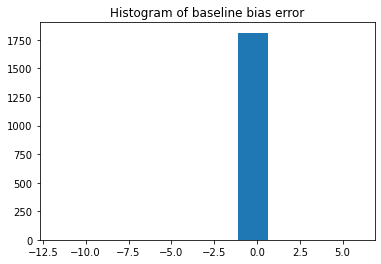

In [21]:
bba = np.array(baseline_bias_list)
print('Frequencies:')
print(np.histogram(bba)[0], '\n')
print(np.histogram(bba)[1], '\n')
plt.hist(bba)
plt.title('Histogram of baseline bias error')
plt.show()

C:\Users\penny\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


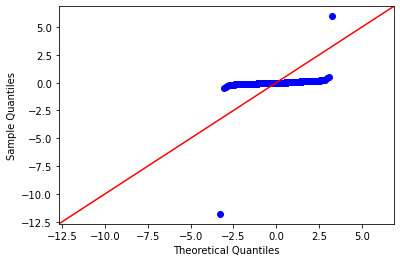

In [22]:
sm.qqplot(bba, line ='45')
plt.show()

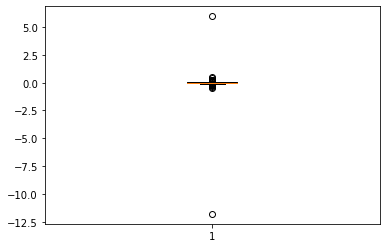

In [23]:
plt.boxplot(bba)
plt.show()

In [24]:
print('Mean: ', np.mean(bba))
print('Median: ', np.median(bba))
print('Mode: ', mode(bba))
print('Standard deviation: ', np.std(bba))

Mean:  -0.005962865052312999
Median:  0.0
Mode:  ModeResult(mode=array([0.]), count=array([340]))
Standard deviation:  0.3182314906037458


In [25]:
print('W test value: ', stats.shapiro(bba)[0])
print('p-value less than 0.05: ', stats.shapiro(bba)[1]<0.05)


W test value:  0.10384047031402588
p-value less than 0.05:  True


### Multi-variate linear regression

Frequencies:
(array([   1,    0,    0,    0,    0,    0,    0,    0,    0, 1814],
      dtype=int64), array([-3.96367340e+13, -3.56730606e+13, -3.17093872e+13, -2.77457138e+13,
       -2.37820404e+13, -1.98183670e+13, -1.58546936e+13, -1.18910202e+13,
       -7.92734680e+12, -3.96367340e+12,  1.07018434e+03])) 



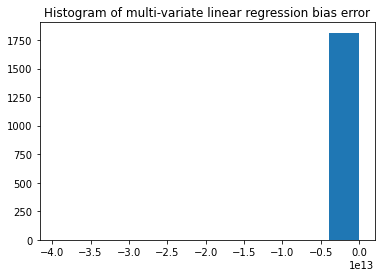

In [26]:
lrba = np.array(lr_bias_list)
print('Frequencies:')
print(np.histogram(lrba), '\n')
plt.hist(lrba)
plt.title('Histogram of multi-variate linear regression bias error')
plt.show()

In [27]:
print('Mean: ', np.mean(lrba))
print('Median: ', np.median(lrba))
print('Mode: ', mode(lrba))
print('Standard deviation: ', np.std(lrba))

Mean:  -21838421389.559082
Median:  -5.890979314337566e-17
Mode:  ModeResult(mode=array([0.]), count=array([74]))
Standard deviation:  930121909047.6918


In [28]:
print('W test value: ', stats.shapiro(lrba)[0])
print('p-value less than 0.05: ', stats.shapiro(lrba)[1]<0.05)

W test value:  0.00720369815826416
p-value less than 0.05:  True


### Decision tree

Frequencies:
(array([1809,    0,    0,    0,    0,    5,    0,    0,    0,    1],
      dtype=int64), array([-0.61969854,  0.6364831 ,  1.89266474,  3.14884638,  4.40502803,
        5.66120967,  6.91739131,  8.17357295,  9.4297546 , 10.68593624,
       11.94211788])) 



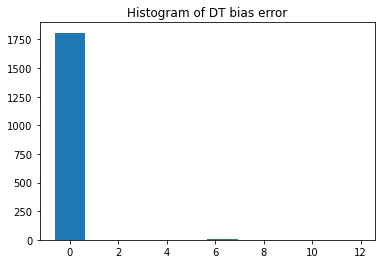

In [29]:
dtba = np.array(dt_bias_list)
print('Frequencies:')
print(np.histogram(dtba), '\n')
plt.hist(dtba)
plt.title('Histogram of DT bias error')
plt.show()

In [30]:
print('Mean: ', np.mean(dtba))
print('Median: ', np.median(dtba))
print('Mode: ', mode(dtba))
print('Standard deviation: ', np.std(dtba))

Mean:  0.018004549456165125
Median:  0.0
Mode:  ModeResult(mode=array([0.]), count=array([151]))
Standard deviation:  0.44476009201382655


In [31]:
print('W test value: ', stats.shapiro(dtba)[0])
print('p-value less than 0.05: ', stats.shapiro(dtba)[1]<0.05)

W test value:  0.23265713453292847
p-value less than 0.05:  True


### Random forest

Frequencies:
(array([1809,    0,    0,    0,    0,    5,    0,    0,    0,    1],
      dtype=int64), array([-0.48515395,  0.75757323,  2.00030042,  3.2430276 ,  4.48575478,
        5.72848197,  6.97120915,  8.21393633,  9.45666352, 10.6993907 ,
       11.94211788])) 



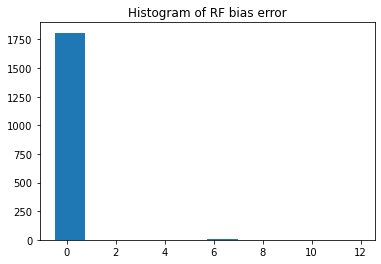

In [32]:
rfba = np.array(rf_bias_list)
print('Frequencies:')
print(np.histogram(rfba), '\n')
plt.hist(rfba)
plt.title('Histogram of RF bias error')
plt.show()

In [33]:
print('Mean: ', np.mean(rfba))
print('Median: ', np.median(rfba))
print('Mode: ', mode(rfba))
print('Standard deviation: ', np.std(rfba))

Mean:  0.026060180464525757
Median:  0.0
Mode:  ModeResult(mode=array([0.]), count=array([112]))
Standard deviation:  0.4371292197464457


In [34]:
print('W test value: ', stats.shapiro(rfba)[0])
print('p-value less than 0.05: ', stats.shapiro(rfba)[1]<0.05)

W test value:  0.1910037398338318
p-value less than 0.05:  True


### Multi-layer perceptron

Frequencies:
(array([   1,    0,    0,    0,    0,    0,    0,    0,    1, 1813],
      dtype=int64), array([-4046.95893593, -3641.65073157, -3236.3425272 , -2831.03432284,
       -2425.72611848, -2020.41791411, -1615.10970975, -1209.80150539,
        -804.49330102,  -399.18509666,     6.1231077 ])) 



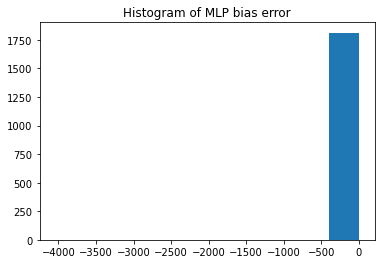

In [35]:
mlpba = np.array(mlp_bias_list)
print('Frequencies:')
print(np.histogram(mlpba), '\n')
plt.hist(mlpba)
plt.title('Histogram of MLP bias error')
plt.show()

In [36]:
print('Mean: ', np.mean(mlpba))
print('Median: ', np.median(mlpba))
print('Mode: ', mode(mlpba))
print('Standard deviation: ', np.std(mlpba))

Mean:  -3.5207985900575043
Median:  -0.05184673310756079
Mode:  ModeResult(mode=array([0.01523215]), count=array([54]))
Standard deviation:  96.05791826457053


In [37]:
print('W test value: ', stats.shapiro(mlpba)[0])
print('p-value less than 0.05: ', stats.shapiro(mlpba)[1]<0.05)

W test value:  0.014249444007873535
p-value less than 0.05:  True


All bias errors have been tested to be not normally distributed. Besides, the observations are dependent, as they were applied to the same neighborhoods (just with different ML techniques). Therefore, the Wilcoxon-signed rank test will be used to test if there are significant differences among ML techniques.

### LSTM

Frequencies:
(array([ 17, 854, 782, 129,  24,   3,   4,   0,   1,   1], dtype=int64), array([-1.66922273, -0.82464998,  0.01992277,  0.86449553,  1.70906828,
        2.55364103,  3.39821378,  4.24278653,  5.08735929,  5.93193204,
        6.77650479])) 



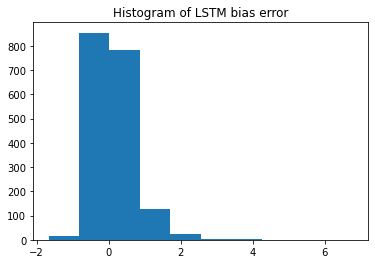

In [38]:
lstmba = np.array(lstm_bias_list)
print('Frequencies:')
print(np.histogram(lstmba), '\n')
plt.hist(lstmba)
plt.title('Histogram of LSTM bias error')
plt.show()

In [39]:
print('Mean: ', np.mean(lstmba))
print('Median: ', np.median(lstmba))
print('Mode: ', mode(lstmba))
print('Standard deviation: ', np.std(lstmba))

Mean:  0.17401801649468138
Median:  0.03742860896246774
Mode:  ModeResult(mode=array([0.]), count=array([54]))
Standard deviation:  0.5564944631871068


In [40]:
print('W test value: ', stats.shapiro(lstmba)[0])
print('p-value less than 0.05: ', stats.shapiro(lstmba)[1]<0.05)

W test value:  0.7980749607086182
p-value less than 0.05:  True


All bias errors have been tested to be not normally distributed. Besides, the observations are dependent, as they were applied to the same neighborhoods (just with different ML techniques). Therefore, the Wilcoxon-signed rank test will be used to test if there are significant differences among ML techniques.

In [41]:
# Wilcoxon-signed rank test

print(stats.wilcoxon(bba, lrba))
print(stats.wilcoxon(bba, dtba))
print(stats.wilcoxon(bba, rfba))
print(stats.wilcoxon(bba, mlpba))
print(stats.wilcoxon(bba, lstmba))
print()
print(stats.wilcoxon(lrba, dtba))
print(stats.wilcoxon(lrba, rfba))
print(stats.wilcoxon(lrba, mlpba))
print(stats.wilcoxon(lrba, lstmba))
print()
print(stats.wilcoxon(dtba, rfba))
print(stats.wilcoxon(dtba, mlpba))
print(stats.wilcoxon(dtba, lstmba))
print()
print(stats.wilcoxon(rfba, mlpba))
print(stats.wilcoxon(rfba, lstmba))
print()
print(stats.wilcoxon(mlpba, lstmba))


WilcoxonResult(statistic=742460.0, pvalue=0.45294196650319185)
WilcoxonResult(statistic=698498.5, pvalue=0.4511888682491343)
WilcoxonResult(statistic=697267.0, pvalue=0.15252849132574703)
WilcoxonResult(statistic=446920.0, pvalue=5.644640273375583e-64)
WilcoxonResult(statistic=522284.0, pvalue=1.5951858168919098e-32)

WilcoxonResult(statistic=728438.0, pvalue=0.7220252175974733)
WilcoxonResult(statistic=704544.0, pvalue=0.02251282912908841)
WilcoxonResult(statistic=488643.0, pvalue=5.579874915514144e-51)
WilcoxonResult(statistic=538290.0, pvalue=9.471994779564963e-29)

WilcoxonResult(statistic=622141.5, pvalue=2.0789311459642823e-05)
WilcoxonResult(statistic=500126.0, pvalue=1.1432479618942098e-47)
WilcoxonResult(statistic=523444.0, pvalue=3.0510457274519594e-32)

WilcoxonResult(statistic=413576.0, pvalue=1.9063507644539851e-75)
WilcoxonResult(statistic=555477.0, pvalue=5.736393079743052e-25)

WilcoxonResult(statistic=372941.0, pvalue=9.888888987638034e-91)


## Mean Absolute Error comparison

In [42]:
len(baseline_mae_list)

1815

### Baseline

Frequencies:
[1808    0    0    0    1    0    0    0    0    6] 

[ 0.          1.19421179  2.38842358  3.58263536  4.77684715  5.97105894
  7.16527073  8.35948252  9.55369431 10.74790609 11.94211788] 



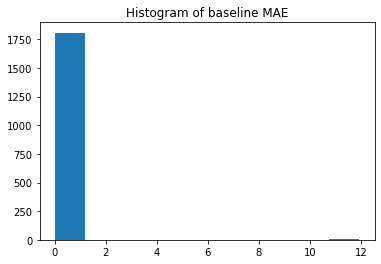

In [43]:
bmae = np.array(baseline_mae_list)
print('Frequencies:')
print(np.histogram(bmae)[0], '\n')
print(np.histogram(bmae)[1], '\n')
plt.hist(bmae)
plt.title('Histogram of baseline MAE')
plt.show()

C:\Users\penny\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


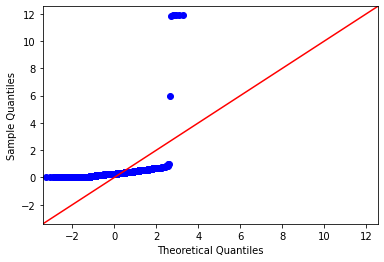

In [44]:
sm.qqplot(bmae, line ='45')
plt.show()

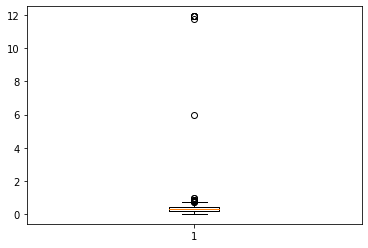

In [45]:
plt.boxplot(bmae)
plt.show()

In [46]:
print('Mean: ', np.mean(bmae))
print('Median: ', np.median(bmae))
print('Mode: ', mode(bmae))
print('Standard deviation: ', np.std(bmae))

Mean:  0.3325903736222506
Median:  0.2857142857142857
Mode:  ModeResult(mode=array([0.]), count=array([222]))
Standard deviation:  0.70268466504003


In [47]:
print('W test value: ', stats.shapiro(bmae)[0])
print('p-value less than 0.05: ', stats.shapiro(bmae)[1]<0.05)


W test value:  0.17556965351104736
p-value less than 0.05:  True


### Multi-variate linear regression

Frequencies:
(array([1814,    0,    0,    0,    0,    0,    0,    0,    0,    1],
      dtype=int64), array([0.00000000e+00, 3.96367340e+12, 7.92734680e+12, 1.18910202e+13,
       1.58546936e+13, 1.98183670e+13, 2.37820404e+13, 2.77457138e+13,
       3.17093872e+13, 3.56730606e+13, 3.96367340e+13])) 



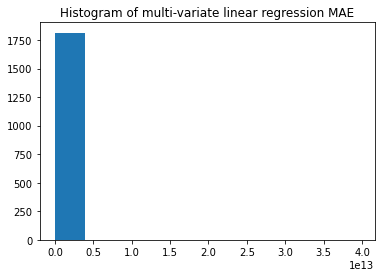

In [48]:
lrmae = np.array(lr_mae_list)
print('Frequencies:')
print(np.histogram(lrmae), '\n')
plt.hist(lrmae)
plt.title('Histogram of multi-variate linear regression MAE')
plt.show()

In [49]:
print('Mean: ', np.mean(lrmae))
print('Median: ', np.median(lrmae))
print('Mode: ', mode(lrmae))
print('Standard deviation: ', np.std(lrmae))

Mean:  21838421414.365376
Median:  0.2616656409264693
Mode:  ModeResult(mode=array([0.]), count=array([73]))
Standard deviation:  930121909047.1118


In [50]:
print('W test value: ', stats.shapiro(lrmae)[0])
print('p-value less than 0.05: ', stats.shapiro(lrmae)[1]<0.05)

W test value:  0.0072037577629089355
p-value less than 0.05:  True


### Decision tree

Frequencies:
(array([1809,    0,    0,    0,    5,    0,    0,    0,    0,    1],
      dtype=int64), array([ 0.        ,  1.19421179,  2.38842358,  3.58263536,  4.77684715,
        5.97105894,  7.16527073,  8.35948252,  9.55369431, 10.74790609,
       11.94211788])) 



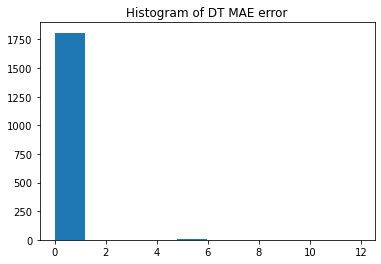

In [51]:
dtmae = np.array(dt_mae_list)
print('Frequencies:')
print(np.histogram(dtmae), '\n')
plt.hist(dtmae)
plt.title('Histogram of DT MAE error')
plt.show()

In [52]:
print('Mean: ', np.mean(dtmae))
print('Median: ', np.median(dtmae))
print('Mode: ', mode(dtmae))
print('Standard deviation: ', np.std(dtmae))

Mean:  0.25296440009087773
Median:  0.22954906553968618
Mode:  ModeResult(mode=array([0.]), count=array([135]))
Standard deviation:  0.4276736642487542


In [53]:
print('W test value: ', stats.shapiro(dtmae)[0])
print('p-value less than 0.05: ', stats.shapiro(dtmae)[1]<0.05)

W test value:  0.21153336763381958
p-value less than 0.05:  True


### Random forest

Frequencies:
(array([1809,    0,    0,    0,    5,    0,    0,    0,    0,    1],
      dtype=int64), array([ 0.        ,  1.19421179,  2.38842358,  3.58263536,  4.77684715,
        5.97105894,  7.16527073,  8.35948252,  9.55369431, 10.74790609,
       11.94211788])) 



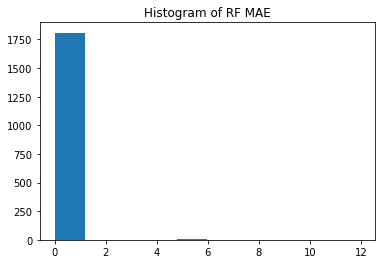

In [54]:
rfmae = np.array(rf_mae_list)
print('Frequencies:')
print(np.histogram(rfmae), '\n')
plt.hist(rfmae)
plt.title('Histogram of RF MAE')
plt.show()

In [55]:
print('Mean: ', np.mean(rfmae))
print('Median: ', np.median(rfmae))
print('Mode: ', mode(rfmae))
print('Standard deviation: ', np.std(rfmae))

Mean:  0.22832070762851508
Median:  0.20018529634506524
Mode:  ModeResult(mode=array([0.]), count=array([112]))
Standard deviation:  0.4239803296326863


In [56]:
print('W test value: ', stats.shapiro(rfmae)[0])
print('p-value less than 0.05: ', stats.shapiro(rfmae)[1]<0.05)

W test value:  0.18010419607162476
p-value less than 0.05:  True


### Multi-layer perceptron

Frequencies:
(array([1813,    1,    0,    0,    0,    0,    0,    0,    0,    1],
      dtype=int64), array([2.44560710e-04, 4.04721679e+02, 8.09443113e+02, 1.21416455e+03,
       1.61888598e+03, 2.02360742e+03, 2.42832885e+03, 2.83305028e+03,
       3.23777172e+03, 3.64249315e+03, 4.04721459e+03])) 



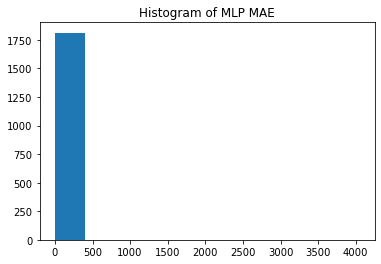

In [57]:
mlpmae = np.array(mlp_mae_list)
print('Frequencies:')
print(np.histogram(mlpmae), '\n')
plt.hist(mlpmae)
plt.title('Histogram of MLP MAE')
plt.show()

In [58]:
print('Mean: ', np.mean(mlpmae))
print('Median: ', np.median(mlpmae))
print('Mode: ', mode(mlpmae))
print('Standard deviation: ', np.std(mlpmae))

Mean:  3.7491412787720546
Median:  0.2435977349672373
Mode:  ModeResult(mode=array([0.01523215]), count=array([54]))
Standard deviation:  96.05845438163578


In [59]:
print('W test value: ', stats.shapiro(mlpmae)[0])
print('p-value less than 0.05: ', stats.shapiro(mlpmae)[1]<0.05)

W test value:  0.014214396476745605
p-value less than 0.05:  True


### LSTM

Frequencies:
(array([967, 578, 184,  57,  21,   3,   1,   2,   0,   2], dtype=int64), array([0.        , 0.74298671, 1.48597341, 2.22896012, 2.97194683,
       3.71493353, 4.45792024, 5.20090694, 5.94389365, 6.68688036,
       7.42986706])) 



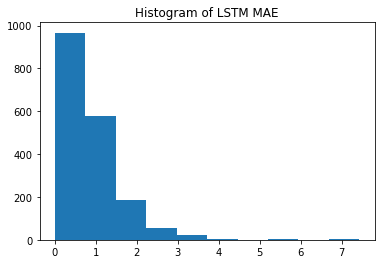

In [60]:
lstmmae = np.array(lstm_mae_list)
print('Frequencies:')
print(np.histogram(lstmmae), '\n')
plt.hist(lstmmae)
plt.title('Histogram of LSTM MAE')
plt.show()

In [63]:
print('Mean: ', np.mean(lstmmae))
print('Median: ', np.median(lstmmae))
print('Mode: ', mode(lstmmae))
print('Standard deviation: ', np.std(lstmmae))

Mean:  0.8580216571558583
Median:  0.6863883989197868
Mode:  ModeResult(mode=array([0.]), count=array([54]))
Standard deviation:  0.7199246966048478


In [62]:
print('W test value: ', stats.shapiro(lstmmae)[0])
print('p-value less than 0.05: ', stats.shapiro(lstmmae)[1]<0.05)

W test value:  0.8504369258880615
p-value less than 0.05:  True


All bias errors have been tested to be not normally distributed. Besides, the observations are dependent, as they were applied to the same neighborhoods (just with different ML techniques). Therefore, the Wilcoxon-signed rank test will be used to test if there are significant differences among ML techniques.

In [64]:
# Wilcoxon-signed rank test
print(stats.wilcoxon(bmae, lrmae))
print("p-value is less than 0.05: ", stats.wilcoxon(bmae, lrmae)[1]<0.05, '\n')
print(stats.wilcoxon(bmae, dtmae))
print(stats.wilcoxon(bmae, rfmae))
print(stats.wilcoxon(bmae, mlpmae))
print(stats.wilcoxon(bmae, lstmmae))
print()
print(stats.wilcoxon(lrmae, dtmae))
print(stats.wilcoxon(lrmae, rfmae))
print(stats.wilcoxon(lrmae, mlpmae))
print(stats.wilcoxon(lrmae, lstmmae))
print()
print(stats.wilcoxon(dtmae, rfmae))
print(stats.wilcoxon(dtmae, mlpmae))
print(stats.wilcoxon(dtmae, lstmmae))
print()
print(stats.wilcoxon(rfmae, mlpmae))
print(stats.wilcoxon(rfmae, lstmmae))
print()
print(stats.wilcoxon(mlpmae, lstmmae))


WilcoxonResult(statistic=700872.0, pvalue=0.007943842305793076)
p-value is less than 0.05:  True 

WilcoxonResult(statistic=428743.0, pvalue=2.7008279998295507e-47)
WilcoxonResult(statistic=235462.0, pvalue=1.4662339408953926e-128)
WilcoxonResult(statistic=820436.0, pvalue=0.8728426867517529)
WilcoxonResult(statistic=94974.0, pvalue=2.9230159185496874e-223)

WilcoxonResult(statistic=420346.5, pvalue=3.2518501232708192e-52)
WilcoxonResult(statistic=197384.0, pvalue=4.639460633506845e-155)
WilcoxonResult(statistic=773242.0, pvalue=0.022998339927179933)
WilcoxonResult(statistic=109206.0, pvalue=4.1326936310714895e-214)

WilcoxonResult(statistic=414454.5, pvalue=7.434848995836501e-49)
WilcoxonResult(statistic=601746.0, pvalue=2.4397230130254667e-23)
WilcoxonResult(statistic=23134.0, pvalue=2.1450035007229098e-272)

WilcoxonResult(statistic=305758.0, pvalue=3.776002126804463e-119)
WilcoxonResult(statistic=17675.0, pvalue=2.493352887160718e-276)

WilcoxonResult(statistic=388720.0, pvalue=1.2

## Root Mean Squared Error comparison

In [66]:
len(baseline_rmse_list)

1815

### Baseline

Frequencies:
[1808    0    0    0    0    0    0    1    0    6] 

[ 0.          2.23416568  4.46833136  6.70249704  8.93666272 11.1708284
 13.40499408 15.63915976 17.87332543 20.10749111 22.34165679] 



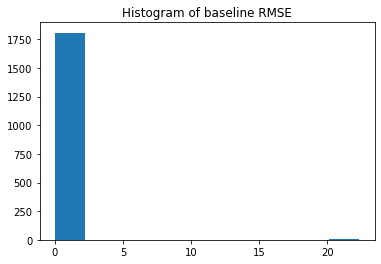

In [67]:
brmse = np.array(baseline_rmse_list)
print('Frequencies:')
print(np.histogram(brmse)[0], '\n')
print(np.histogram(brmse)[1], '\n')
plt.hist(brmse)
plt.title('Histogram of baseline RMSE')
plt.show()

C:\Users\penny\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


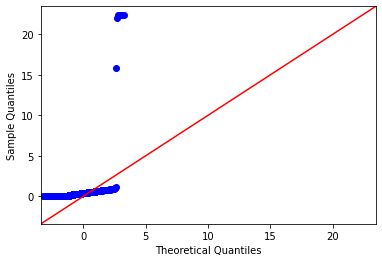

In [68]:
sm.qqplot(brmse, line ='45')
plt.show()

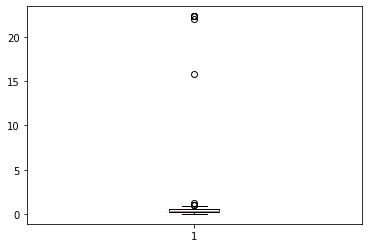

In [69]:
plt.boxplot(brmse)
plt.show()

In [70]:
print('Mean: ', np.mean(brmse))
print('Median: ', np.median(brmse))
print('Mode: ', mode(brmse))
print('Standard deviation: ', np.std(brmse))

Mean:  0.46641212209749155
Median:  0.38424562530551837
Mode:  ModeResult(mode=array([0.]), count=array([222]))
Standard deviation:  1.3259271647493065


In [71]:
print('W test value: ', stats.shapiro(brmse)[0])
print('p-value less than 0.05: ', stats.shapiro(brmse)[1]<0.05)


W test value:  0.11580866575241089
p-value less than 0.05:  True


### Multi-variate linear regression

Frequencies:
(array([1814,    0,    0,    0,    0,    0,    0,    0,    0,    1],
      dtype=int64), array([0.00000000e+00, 1.04868941e+13, 2.09737882e+13, 3.14606823e+13,
       4.19475764e+13, 5.24344705e+13, 6.29213646e+13, 7.34082587e+13,
       8.38951528e+13, 9.43820469e+13, 1.04868941e+14])) 



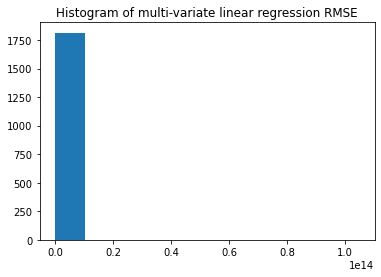

In [72]:
lrrmse = np.array(lr_rmse_list)
print('Frequencies:')
print(np.histogram(lrrmse), '\n')
plt.hist(lrrmse)
plt.title('Histogram of multi-variate linear regression RMSE')
plt.show()

In [73]:
print('Mean: ', np.mean(lrrmse))
print('Median: ', np.median(lrrmse))
print('Mode: ', mode(lrrmse))
print('Standard deviation: ', np.std(lrrmse))

Mean:  57779032069.21562
Median:  0.3405568842053682
Mode:  ModeResult(mode=array([0.]), count=array([73]))
Standard deviation:  2460871260311.749


In [74]:
print('W test value: ', stats.shapiro(lrrmse)[0])
print('p-value less than 0.05: ', stats.shapiro(lrrmse)[1]<0.05)

W test value:  0.0072037577629089355
p-value less than 0.05:  True


### Decision tree

Frequencies:
(array([1809,    0,    0,    0,    0,    0,    0,    5,    0,    1],
      dtype=int64), array([ 0.        ,  2.23416568,  4.46833136,  6.70249704,  8.93666272,
       11.1708284 , 13.40499408, 15.63915976, 17.87332543, 20.10749111,
       22.34165679])) 



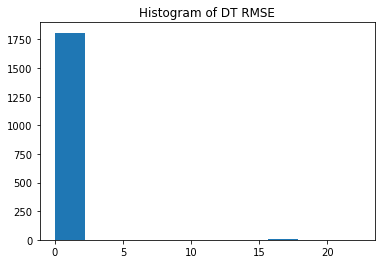

In [75]:
dtrmse = np.array(dt_rmse_list)
print('Frequencies:')
print(np.histogram(dtrmse), '\n')
plt.hist(dtrmse)
plt.title('Histogram of DT RMSE')
plt.show()

In [76]:
print('Mean: ', np.mean(dtrmse))
print('Median: ', np.median(dtrmse))
print('Mode: ', mode(dtrmse))
print('Standard deviation: ', np.std(dtrmse))

Mean:  0.36586467800942485
Median:  0.32594393254687937
Mode:  ModeResult(mode=array([0.]), count=array([135]))
Standard deviation:  0.9760120876285766


In [77]:
print('W test value: ', stats.shapiro(dtrmse)[0])
print('p-value less than 0.05: ', stats.shapiro(dtrmse)[1]<0.05)

W test value:  0.11385238170623779
p-value less than 0.05:  True


### Random forest

Frequencies:
(array([1809,    0,    0,    0,    0,    0,    0,    5,    0,    1],
      dtype=int64), array([ 0.        ,  2.23416568,  4.46833136,  6.70249704,  8.93666272,
       11.1708284 , 13.40499408, 15.63915976, 17.87332543, 20.10749111,
       22.34165679])) 



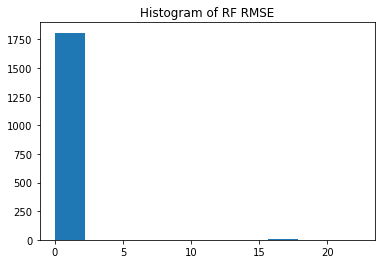

In [78]:
rfrmse = np.array(rf_rmse_list)
print('Frequencies:')
print(np.histogram(rfrmse), '\n')
plt.hist(rfrmse)
plt.title('Histogram of RF RMSE')
plt.show()

In [79]:
print('Mean: ', np.mean(rfrmse))
print('Median: ', np.median(rfrmse))
print('Mode: ', mode(rfrmse))
print('Standard deviation: ', np.std(rfrmse))

Mean:  0.3176706074663451
Median:  0.26000334274792936
Mode:  ModeResult(mode=array([0.]), count=array([112]))
Standard deviation:  0.9749348133903774


In [80]:
print('W test value: ', stats.shapiro(rfrmse)[0])
print('p-value less than 0.05: ', stats.shapiro(rfrmse)[1]<0.05)

W test value:  0.09908038377761841
p-value less than 0.05:  True


### Multi-layer perceptron

Frequencies:
(array([1813,    1,    0,    0,    0,    0,    0,    0,    0,    1],
      dtype=int64), array([2.44560710e-04, 9.54631458e+02, 1.90926267e+03, 2.86389388e+03,
       3.81852510e+03, 4.77315631e+03, 5.72778752e+03, 6.68241874e+03,
       7.63704995e+03, 8.59168116e+03, 9.54631237e+03])) 



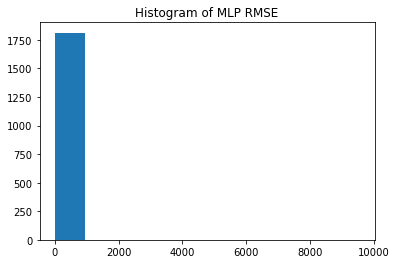

In [81]:
mlprmse = np.array(mlp_rmse_list)
print('Frequencies:')
print(np.histogram(mlprmse), '\n')
plt.hist(mlprmse)
plt.title('Histogram of MLP RMSE')
plt.show()

In [82]:
print('Mean: ', np.mean(mlprmse))
print('Median: ', np.median(mlprmse))
print('Mode: ', mode(mlprmse))
print('Standard deviation: ', np.std(mlprmse))

Mean:  8.471845211409862
Median:  0.3025672613608799
Mode:  ModeResult(mode=array([0.01523215]), count=array([54]))
Standard deviation:  226.83938351536128


In [83]:
print('W test value: ', stats.shapiro(mlprmse)[0])
print('p-value less than 0.05: ', stats.shapiro(mlprmse)[1]<0.05)

W test value:  0.013904392719268799
p-value less than 0.05:  True


### LSTM

Frequencies:
(array([972, 564, 187,  69,  12,   5,   3,   1,   1,   1], dtype=int64), array([0.        , 0.90686231, 1.81372462, 2.72058692, 3.62744923,
       4.53431154, 5.44117385, 6.34803616, 7.25489846, 8.16176077,
       9.06862308])) 



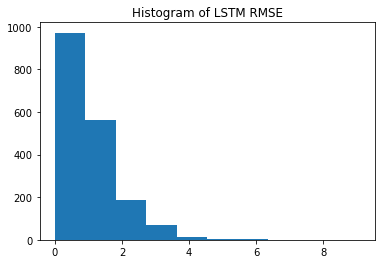

In [84]:
lstmrmse = np.array(lstm_rmse_list)
print('Frequencies:')
print(np.histogram(lstmrmse), '\n')
plt.hist(lstmrmse)
plt.title('Histogram of LSTM RMSE')
plt.show()

In [85]:
print('Mean: ', np.mean(lstmrmse))
print('Median: ', np.median(lstmrmse))
print('Mode: ', mode(lstmrmse))
print('Standard deviation: ', np.std(lstmrmse))

Mean:  1.0518413407917893
Median:  0.837382054638831
Mode:  ModeResult(mode=array([0.]), count=array([54]))
Standard deviation:  0.8821118914457932


In [86]:
print('W test value: ', stats.shapiro(lstmrmse)[0])
print('p-value less than 0.05: ', stats.shapiro(lstmrmse)[1]<0.05)

W test value:  0.8552401065826416
p-value less than 0.05:  True


In [87]:
# Wilcoxon-signed rank test
print(stats.wilcoxon(brmse, lrrmse))
print("p-value is less than 0.05: ", stats.wilcoxon(brmse, lrrmse)[1]<0.05, '\n')
print(stats.wilcoxon(brmse, dtrmse))
print(stats.wilcoxon(brmse, rfrmse))
print(stats.wilcoxon(brmse, mlprmse))
print(stats.wilcoxon(brmse, lstmrmse))

print()
print(stats.wilcoxon(lrrmse, dtrmse))
print(stats.wilcoxon(lrrmse, rfrmse))
print(stats.wilcoxon(lrrmse, mlprmse))
print(stats.wilcoxon(lrrmse, lstmrmse))

print()
print(stats.wilcoxon(dtrmse, rfrmse))
print(stats.wilcoxon(dtrmse, mlprmse))
print(stats.wilcoxon(dtrmse, lstmrmse))
print()
print(stats.wilcoxon(rfrmse, mlprmse))
print(stats.wilcoxon(rfrmse, lstmrmse))
print()
print(stats.wilcoxon(mlprmse, lstmrmse))


WilcoxonResult(statistic=622536.0, pvalue=1.6073171278578671e-10)
p-value is less than 0.05:  True 

WilcoxonResult(statistic=390401.5, pvalue=1.2335548057374768e-60)
WilcoxonResult(statistic=129677.0, pvalue=3.3356038879144037e-189)
WilcoxonResult(statistic=746366.0, pvalue=0.0005070442129705669)
WilcoxonResult(statistic=151345.0, pvalue=3.784723153333411e-188)

WilcoxonResult(statistic=515509.0, pvalue=4.406573308375695e-25)
WilcoxonResult(statistic=199354.5, pvalue=6.839838080945153e-153)
WilcoxonResult(statistic=769507.0, pvalue=0.01465798377629242)
WilcoxonResult(statistic=144106.0, pvalue=1.731432577130923e-192)

WilcoxonResult(statistic=214131.0, pvalue=2.774013240154207e-135)
WilcoxonResult(statistic=732323.0, pvalue=4.027917495811809e-05)
WilcoxonResult(statistic=54086.0, pvalue=1.2694881503826419e-250)

WilcoxonResult(statistic=304991.0, pvalue=1.6980283288615819e-119)
WilcoxonResult(statistic=35468.0, pvalue=1.308502779528983e-263)

WilcoxonResult(statistic=452687.0, pvalue=